In [1]:
import tensorflow as tf

2023-07-31 21:56:43.067138: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-31 21:56:44.065016: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
import wrapt
wrapt.__version__   # should be 1.14.1

'1.14.1'

In [3]:
from tensorflow import keras as keras
from keras import layers as layers

In [4]:
import os, timeit
from skimage.filters import threshold_otsu
import numpy as np
from math import inf as inf

In [5]:
import pandas as pd

In [6]:
from spectral.io import envi as envi
from spectral import imshow

In [7]:
from sklearn.decomposition import IncrementalPCA

In [8]:
import sys

In [9]:
from tensorflow.keras.utils import set_random_seed
set_random_seed(42)

In [10]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [11]:
from sys import platform
DATA_DIRECTORY = ""
SLASH = ""
if platform == "linux" or platform == "linux2":
    DATA_DIRECTORY = "/home/tyagi/Desktop/wheat/data/BULK/"
    SLASH = "/"
elif platform == "win32":
    DATA_DIRECTORY = "D:\mvl\wheat\data\BULK\\"
    SLASH="\\"

In [12]:
#Constants
BAND_NUMBER = 60
FILLED_AREA_RATIO = 0.9
TOTAL_IMAGE_COUNT = 2400
IMAGE_COUNT = int(TOTAL_IMAGE_COUNT/4)
NUM_VARIETIES = 4

IMAGE_WIDTH = 30
IMAGE_HEIGHT = 30

In [13]:
ACTIVATION_TYPE =  "relu"
BATCH_SIZE = 2*NUM_VARIETIES

LEARNING_RATE_BASE = 0.0001

In [14]:
from enum import Enum

class filter_method(Enum):
    none = 0
    snv = 1
    msc = 2
    savgol = 3
    
FILTER = filter_method(1).name

# to be set if filter chosen is savgol
WINDOW = 7
ORDER = 2
DERIVATIVE = "none"

In [15]:
from enum import Enum
 
class feature_extraction_method(Enum):
    none = 0
    pca_loading = 1
    lda = 2
    ipca = 3

FEATURE_EXTRACTION = feature_extraction_method(0).name

NUM_OF_BANDS = 3
if FEATURE_EXTRACTION == "pca_loading" or FEATURE_EXTRACTION == "ipca":
    NUM_OF_BANDS = 8
elif FEATURE_EXTRACTION == "lda":
    NUM_OF_BANDS = 3
    assert NUM_OF_BANDS <= min(NUM_VARIETIES-1,168),"NUM_OF_BANDS is greater."


REMOVE_NOISY_BANDS = False
FIRST_BAND = 15
LAST_BAND = 161

In [16]:
def start_timer():
    print("Testing started")
    return timeit.default_timer()

def end_timer():
    return timeit.default_timer()

def show_time(tic,toc): 
    test_time = toc - tic
    print('Testing time (s) = ' + str(test_time) + '\n')

In [17]:
# List for All varieties
VARIETIES = []
VARIETIES_CODE = {}

for name in os.listdir(DATA_DIRECTORY):
    if (name.endswith(".hdr") or name.endswith(".bil")):
        continue
    VARIETIES_CODE[name] = len(VARIETIES)
    VARIETIES.append(name)
    if len(VARIETIES)==NUM_VARIETIES:
        break

In [18]:
def dataset_file_name(variety):
    name = "./dataset/V"+str(variety).zfill(3)+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
    if REMOVE_NOISY_BANDS:
        name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)
    if FILTER == "savgol":
        name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)
    return name

In [19]:
train_dataset = []
train_dataset_label = []
test_dataset=[]
test_dataset_label = []

for idx, v in enumerate(VARIETIES):
    print("idx: ",idx)
    if idx >= NUM_VARIETIES:
        break
    train_dataset= train_dataset + np.load(dataset_file_name(v)+"_train_dataset.npy").tolist()
    train_dataset_label = train_dataset_label + np.load(dataset_file_name(v)+"_train_dataset_label.npy").tolist()
    test_dataset = test_dataset + np.load(dataset_file_name(v)+"_test_dataset.npy").tolist()
    test_dataset_label = test_dataset_label + np.load(dataset_file_name(v)+"_test_dataset_label.npy").tolist()
    
train_dataset = np.array(train_dataset)
train_dataset_label = np.array(train_dataset_label)
test_dataset = np.array(test_dataset)
test_dataset_label = np.array(test_dataset_label)

idx:  0
idx:  1
idx:  2
idx:  3


In [20]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses, Model
from keras.layers import Input, Conv2D, MaxPool2D, MaxPooling2D, Activation, Flatten, Dense, AveragePooling2D, GlobalAveragePooling2D
from keras.layers.core import Dropout
from keras.optimizers import Adam

In [21]:
def normalizeDataWholeSeed(data,normalization_type='max'):
    
    if normalization_type == 'max':
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/np.max(abs(data[idx,:,:,:]))
            
    elif normalization_type == 'l2norm':
        from numpy import linalg as LA
        for idx in range(data.shape[0]):
            data[idx,:,:,:] = data[idx,:,:,:]/LA.norm(data[idx,:,:,:])       
        
    return data

In [22]:
def inception(x,filters_1x1,filters_3x3_reduce,filters_3x3,filters_5x5_reduce,filters_5x5,filters_pool,activation_type='relu'):
    path1 = Conv2D(filters_1x1,        (1, 1), padding='same', activation=activation_type)(x)
    
    path2 = Conv2D(filters_3x3_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path2 = Conv2D(filters_3x3,        (1, 1), padding='same', activation=activation_type)(path2)
    
    path3 = Conv2D(filters_5x5_reduce, (1, 1), padding='same', activation=activation_type)(x)
    path3 = Conv2D(filters_5x5,        (1, 1), padding='same', activation=activation_type)(path3)
    
    path4 = MaxPool2D((3, 3),  strides=(1, 1), padding='same')(x)
    path4 = Conv2D(filters_pool,       (1, 1), padding='same', activation=activation_type)(path4)
    
    return tf.concat([path1, path2, path3, path4], axis=3)

In [23]:
def auxiliary_classifier(x,num_classes,activation_type='relu'):
    aux = AveragePooling2D((5, 5), strides=3)(x)
    aux = Conv2D(128, 1, padding='same', activation=activation_type)(aux)
    aux = Flatten()(aux)
    aux = Dense(1024, activation=activation_type)(aux)
    aux = Dropout(0.7)(aux)
    aux = Dense(num_classes, activation='softmax')(aux)
    return aux

In [24]:
def GoogleNetModel(data_num_rows, data_num_cols, num_input_chans=1, num_classes=NUM_VARIETIES, activation_type='relu', dropout_rate=0.0):

    inp = Input(shape=(data_num_rows, data_num_cols, num_input_chans))
    input_tensor = layers.experimental.preprocessing.Resizing(224, 224, interpolation="bilinear", input_shape=train_dataset.shape[1:])(inp)
    x = Conv2D(64,  7, strides=2, padding='same', activation=activation_type)(input_tensor)
    x = MaxPooling2D(3, strides=2)(x)
    x = Conv2D(64,  1, strides=1, padding='same', activation=activation_type)(x)
    x = Conv2D(192, 3, strides=1, padding='same', activation=activation_type)(x)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=64 , filters_3x3_reduce=96 , filters_3x3=128, filters_5x5_reduce=16, filters_5x5=32, filters_pool=32)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=192, filters_5x5_reduce=32, filters_5x5=96, filters_pool=64)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=192, filters_3x3_reduce=96 , filters_3x3=208, filters_5x5_reduce=16, filters_5x5=48, filters_pool=64)
    5023
    aux1 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=160, filters_3x3_reduce=112, filters_3x3=224, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=128, filters_3x3_reduce=128, filters_3x3=256, filters_5x5_reduce=24, filters_5x5=64, filters_pool=64)
    x = inception(x, filters_1x1=112, filters_3x3_reduce=144, filters_3x3=288, filters_5x5_reduce=32, filters_5x5=64, filters_pool=64)
    
    aux2 = auxiliary_classifier(x,num_classes)
    
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = MaxPooling2D(3, strides=2)(x)
    x = inception(x, filters_1x1=256, filters_3x3_reduce=160, filters_3x3=320, filters_5x5_reduce=32, filters_5x5=128, filters_pool=128)
    x = inception(x, filters_1x1=384, filters_3x3_reduce=192, filters_3x3=384, filters_5x5_reduce=48, filters_5x5=128, filters_pool=128)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    out = Dense(num_classes, activation='softmax')(x)
    
    return Model(inputs = inp, outputs = [out, aux1, aux2])

In [25]:
def getGoogleNetModel():
    learning_rate_base = LEARNING_RATE_BASE
    activation_type = ACTIVATION_TYPE
    wheat_types =  VARIETIES
    num_classes = len(wheat_types)
    dropout_rate = 0.4
    print("--------------Load Data--------------")

    x_training = np.array(train_dataset)
    labels_training = np.array(train_dataset_label)
    
    # Normalize the data
    x_training = normalizeDataWholeSeed(x_training)
    
    # Extract some information
    num_train = x_training.shape[0]
    N_spatial = x_training.shape[1:3]
    N_channel = x_training.shape[3]
    
    print("--------------Done--------------")
    
    ############ Create a model ############
    print("--------------Create a model--------------")
    
    # Generate a model
    model = GoogleNetModel(data_num_rows = N_spatial[0], 
                           data_num_cols = N_spatial[1],
                           num_input_chans = N_channel, 
                           num_classes = num_classes,
                           activation_type = activation_type,
                           dropout_rate = dropout_rate)

    # Compile the model
    adam_opt = Adam(learning_rate=LEARNING_RATE_BASE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.01)
    model.compile(optimizer=adam_opt, loss=[losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy,losses.sparse_categorical_crossentropy],loss_weights=[1, 0.3, 0.3],metrics=['accuracy'])
    print("---------Completed---------")
    return model

In [26]:
def plot_graph(df,title,xlabel,ylabel,values=['loss'],legends=[]):
    
    for value in values:
        epoch_count = range(1, len(df.index) + 1)
        plt.plot(epoch_count, df[value].tolist())
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    if legends==[]:
        legends = values
    plt.legend(legends, loc='upper left')
    plt.show()

In [27]:
x_train = []
y_train = []
x_val = []
y_val = []

for i in range(len(train_dataset)):
    if i%5==0:
        x_val.append(train_dataset[i])
        y_val.append(train_dataset_label[i])
    else:
        x_train.append(train_dataset[i])
        y_train.append(train_dataset_label[i])
        
x_train = np.array(x_train)
y_train = np.array(y_train)
y_train = [y_train,y_train,y_train]

x_val = np.array(x_val)

y_val = np.array(y_val)
y_val = [y_val,y_val,y_val]

In [28]:
import pandas as pd
import os

def save_to_csv(file_path, data_frame, header=False):
    file_exists = os.path.exists(file_path)

    if not file_exists or not header:
        data_frame.to_csv(file_path, index=False, mode='w')
    else:
        data_frame.to_csv(file_path, index=False, mode='a', header=False)

In [29]:
VARIETIES

['PBW 291', 'DBW 187', 'DBW222', 'HD 3086']

In [30]:
model = None

In [31]:
start_epoch = 1

In [32]:
model_name = "GN_"+"_IC_"+str(TOTAL_IMAGE_COUNT).zfill(5)+"_FilledArea_"+str(FILLED_AREA_RATIO)+"_BandNo_"+str(BAND_NUMBER)+"_ImageHeight_"+str(IMAGE_HEIGHT)+"_ImageWidth_"+str(IMAGE_WIDTH)+"_FILTER_"+str(FILTER)+"_FeatureExtraction_"+str(FEATURE_EXTRACTION)
if REMOVE_NOISY_BANDS:
    model_name+="_REMOVE_NOISY_BANDS_"+str(REMOVE_NOISY_BANDS)+"_NumOfBands_"+str(NUM_OF_BANDS)+"_FB_"+str(FIRST_BAND)+"_LB_"+str(LAST_BAND)
if FILTER == "savgol":
    model_name+="_WINDOW_"+str(WINDOW)+"_ORDER_"+str(ORDER)

if start_epoch != 1:
    model = tf.keras.models.load_model('./GNmodels/'+str(start_epoch-1)+model_name)
else:
    model = getGoogleNetModel()

--------------Load Data--------------
--------------Done--------------
--------------Create a model--------------


2023-07-31 22:01:53.740382: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21753 MB memory:  -> device: 0, name: NVIDIA RTX A5000, pci bus id: 0000:9b:00.0, compute capability: 8.6


---------Completed---------


In [33]:
last_epoch = 200

In [34]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 30, 30, 168  0           []                               
                                )]                                                                
                                                                                                  
 resizing (Resizing)            (None, 224, 224, 16  0           ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  526912      ['resizing[0][0]']               
                                )                                                             

In [36]:
import warnings
warnings.filterwarnings('ignore')

In [37]:
tic = start_timer()
while start_epoch<last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1


2023-07-31 22:08:41.280829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-31 22:08:42.937150: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


768/768 - 43s - loss: 1.9717 - dense_4_loss: 1.2215 - dense_1_loss: 1.2482 - dense_3_loss: 1.2523 - dense_4_accuracy: 0.4142 - dense_1_accuracy: 0.3955 - dense_3_accuracy: 0.3841 - val_loss: 1.7837 - val_dense_4_loss: 1.1066 - val_dense_1_loss: 1.1227 - val_dense_3_loss: 1.1344 - val_dense_4_accuracy: 0.4779 - val_dense_1_accuracy: 0.4987 - val_dense_3_accuracy: 0.4714 - 43s/epoch - 55ms/step


2023-07-31 22:09:21.180491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:09:21.189267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:09:21.196916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/1GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1
added to csv

Epoch:  2
768/768 - 31s - loss: 1.7924 - dense_4_loss: 1.1058 - dense_1_loss: 1.1383 - dense_3_loss: 1.1504 - dense_4_accuracy: 0.4940 - dense_1_accuracy: 0.4757 - dense_3_accuracy: 0.4647 - val_loss: 1.7183 - val_dense_4_loss: 1.0661 - val_dense_1_loss: 1.0725 - val_dense_3_loss: 1.1013 - val_dense_4_accuracy: 0.5039 - val_dense_1_accuracy: 0.5312 - val_dense_3_accuracy: 0.5033 - 31s/epoch - 41ms/step


2023-07-31 22:10:13.622267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:10:13.630760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:10:13.638377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/2GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2
added to csv

Epoch:  3
768/768 - 32s - loss: 1.7246 - dense_4_loss: 1.0630 - dense_1_loss: 1.0939 - dense_3_loss: 1.1115 - dense_4_accuracy: 0.5215 - dense_1_accuracy: 0.5119 - dense_3_accuracy: 0.4849 - val_loss: 1.6515 - val_dense_4_loss: 1.0236 - val_dense_1_loss: 1.0265 - val_dense_3_loss: 1.0664 - val_dense_4_accuracy: 0.5319 - val_dense_1_accuracy: 0.5553 - val_dense_3_accuracy: 0.5286 - 32s/epoch - 42ms/step


2023-07-31 22:11:07.235137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:11:07.243306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:11:07.250801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/3GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/3GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  3
added to csv

Epoch:  4
768/768 - 31s - loss: 1.6530 - dense_4_loss: 1.0126 - dense_1_loss: 1.0582 - dense_3_loss: 1.0765 - dense_4_accuracy: 0.5560 - dense_1_accuracy: 0.5334 - dense_3_accuracy: 0.5143 - val_loss: 1.5739 - val_dense_4_loss: 0.9681 - val_dense_1_loss: 0.9934 - val_dense_3_loss: 1.0259 - val_dense_4_accuracy: 0.5736 - val_dense_1_accuracy: 0.5749 - val_dense_3_accuracy: 0.5462 - 31s/epoch - 41ms/step


2023-07-31 22:11:58.439673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:11:58.450240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:11:58.458150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/4GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/4GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  4
added to csv

Epoch:  5
768/768 - 33s - loss: 1.5910 - dense_4_loss: 0.9706 - dense_1_loss: 1.0276 - dense_3_loss: 1.0403 - dense_4_accuracy: 0.5765 - dense_1_accuracy: 0.5459 - dense_3_accuracy: 0.5355 - val_loss: 1.5124 - val_dense_4_loss: 0.9247 - val_dense_1_loss: 0.9689 - val_dense_3_loss: 0.9900 - val_dense_4_accuracy: 0.5996 - val_dense_1_accuracy: 0.5794 - val_dense_3_accuracy: 0.5625 - 33s/epoch - 43ms/step


2023-07-31 22:12:52.068032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:12:52.076502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:12:52.084157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/5GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/5GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  5
added to csv

Epoch:  6
768/768 - 33s - loss: 1.5410 - dense_4_loss: 0.9318 - dense_1_loss: 1.0122 - dense_3_loss: 1.0184 - dense_4_accuracy: 0.6025 - dense_1_accuracy: 0.5575 - dense_3_accuracy: 0.5498 - val_loss: 1.4637 - val_dense_4_loss: 0.8896 - val_dense_1_loss: 0.9499 - val_dense_3_loss: 0.9635 - val_dense_4_accuracy: 0.6191 - val_dense_1_accuracy: 0.6009 - val_dense_3_accuracy: 0.5814 - 33s/epoch - 43ms/step


2023-07-31 22:13:45.474902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:13:45.483077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:13:45.490611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/6GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/6GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  6
added to csv

Epoch:  7
768/768 - 33s - loss: 1.4954 - dense_4_loss: 0.9030 - dense_1_loss: 0.9909 - dense_3_loss: 0.9838 - dense_4_accuracy: 0.6167 - dense_1_accuracy: 0.5763 - dense_3_accuracy: 0.5659 - val_loss: 1.4200 - val_dense_4_loss: 0.8587 - val_dense_1_loss: 0.9321 - val_dense_3_loss: 0.9390 - val_dense_4_accuracy: 0.6380 - val_dense_1_accuracy: 0.6087 - val_dense_3_accuracy: 0.6029 - 33s/epoch - 43ms/step


2023-07-31 22:14:38.562849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:14:38.570812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:14:38.578440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/7GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/7GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  7
added to csv

Epoch:  8
768/768 - 32s - loss: 1.4563 - dense_4_loss: 0.8741 - dense_1_loss: 0.9704 - dense_3_loss: 0.9701 - dense_4_accuracy: 0.6300 - dense_1_accuracy: 0.5817 - dense_3_accuracy: 0.5770 - val_loss: 1.3841 - val_dense_4_loss: 0.8333 - val_dense_1_loss: 0.9166 - val_dense_3_loss: 0.9193 - val_dense_4_accuracy: 0.6536 - val_dense_1_accuracy: 0.6224 - val_dense_3_accuracy: 0.6159 - 32s/epoch - 42ms/step


2023-07-31 22:15:31.703100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:15:31.711939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:15:31.719558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/8GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/8GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  8
added to csv

Epoch:  9
768/768 - 32s - loss: 1.4148 - dense_4_loss: 0.8460 - dense_1_loss: 0.9536 - dense_3_loss: 0.9424 - dense_4_accuracy: 0.6538 - dense_1_accuracy: 0.5881 - dense_3_accuracy: 0.5933 - val_loss: 1.3450 - val_dense_4_loss: 0.8049 - val_dense_1_loss: 0.9021 - val_dense_3_loss: 0.8982 - val_dense_4_accuracy: 0.6745 - val_dense_1_accuracy: 0.6341 - val_dense_3_accuracy: 0.6250 - 32s/epoch - 41ms/step


2023-07-31 22:16:23.567617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:16:23.577902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:16:23.585474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/9GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/9GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  9
added to csv

Epoch:  10
768/768 - 31s - loss: 1.3902 - dense_4_loss: 0.8252 - dense_1_loss: 0.9540 - dense_3_loss: 0.9292 - dense_4_accuracy: 0.6610 - dense_1_accuracy: 0.5960 - dense_3_accuracy: 0.6016 - val_loss: 1.3143 - val_dense_4_loss: 0.7832 - val_dense_1_loss: 0.8899 - val_dense_3_loss: 0.8802 - val_dense_4_accuracy: 0.6784 - val_dense_1_accuracy: 0.6393 - val_dense_3_accuracy: 0.6322 - 31s/epoch - 41ms/step


2023-07-31 22:17:15.715946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:17:15.724035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:17:15.731640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/10GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/10GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  10
added to csv

Epoch:  11
768/768 - 31s - loss: 1.3555 - dense_4_loss: 0.8027 - dense_1_loss: 0.9324 - dense_3_loss: 0.9102 - dense_4_accuracy: 0.6694 - dense_1_accuracy: 0.5999 - dense_3_accuracy: 0.6069 - val_loss: 1.2767 - val_dense_4_loss: 0.7554 - val_dense_1_loss: 0.8766 - val_dense_3_loss: 0.8610 - val_dense_4_accuracy: 0.7005 - val_dense_1_accuracy: 0.6484 - val_dense_3_accuracy: 0.6458 - 31s/epoch - 41ms/step


2023-07-31 22:18:07.554573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:18:07.564001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:18:07.572401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/11GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/11GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  11
added to csv

Epoch:  12
768/768 - 32s - loss: 1.3215 - dense_4_loss: 0.7803 - dense_1_loss: 0.9121 - dense_3_loss: 0.8919 - dense_4_accuracy: 0.6932 - dense_1_accuracy: 0.6162 - dense_3_accuracy: 0.6198 - val_loss: 1.2466 - val_dense_4_loss: 0.7340 - val_dense_1_loss: 0.8644 - val_dense_3_loss: 0.8441 - val_dense_4_accuracy: 0.7096 - val_dense_1_accuracy: 0.6576 - val_dense_3_accuracy: 0.6582 - 32s/epoch - 41ms/step


2023-07-31 22:18:59.796797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:18:59.805215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:18:59.813212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/12GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/12GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  12
added to csv

Epoch:  13
768/768 - 32s - loss: 1.2808 - dense_4_loss: 0.7486 - dense_1_loss: 0.9018 - dense_3_loss: 0.8724 - dense_4_accuracy: 0.7056 - dense_1_accuracy: 0.6318 - dense_3_accuracy: 0.6317 - val_loss: 1.2159 - val_dense_4_loss: 0.7116 - val_dense_1_loss: 0.8527 - val_dense_3_loss: 0.8281 - val_dense_4_accuracy: 0.7194 - val_dense_1_accuracy: 0.6641 - val_dense_3_accuracy: 0.6608 - 32s/epoch - 42ms/step


2023-07-31 22:19:52.971183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:19:52.979760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:19:52.987466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/13GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/13GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  13
added to csv

Epoch:  14
768/768 - 31s - loss: 1.2645 - dense_4_loss: 0.7366 - dense_1_loss: 0.8962 - dense_3_loss: 0.8633 - dense_4_accuracy: 0.7085 - dense_1_accuracy: 0.6235 - dense_3_accuracy: 0.6392 - val_loss: 1.1886 - val_dense_4_loss: 0.6917 - val_dense_1_loss: 0.8424 - val_dense_3_loss: 0.8137 - val_dense_4_accuracy: 0.7350 - val_dense_1_accuracy: 0.6699 - val_dense_3_accuracy: 0.6693 - 31s/epoch - 41ms/step


2023-07-31 22:20:45.493128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:20:45.501454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:20:45.509041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/14GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/14GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  14
added to csv

Epoch:  15
768/768 - 32s - loss: 1.2310 - dense_4_loss: 0.7146 - dense_1_loss: 0.8781 - dense_3_loss: 0.8430 - dense_4_accuracy: 0.7230 - dense_1_accuracy: 0.6421 - dense_3_accuracy: 0.6585 - val_loss: 1.1605 - val_dense_4_loss: 0.6717 - val_dense_1_loss: 0.8316 - val_dense_3_loss: 0.7977 - val_dense_4_accuracy: 0.7435 - val_dense_1_accuracy: 0.6764 - val_dense_3_accuracy: 0.6823 - 32s/epoch - 42ms/step


2023-07-31 22:21:37.655596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:21:37.663912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:21:37.671566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/15GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/15GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  15
added to csv

Epoch:  16
768/768 - 33s - loss: 1.2017 - dense_4_loss: 0.6929 - dense_1_loss: 0.8666 - dense_3_loss: 0.8293 - dense_4_accuracy: 0.7339 - dense_1_accuracy: 0.6413 - dense_3_accuracy: 0.6595 - val_loss: 1.1366 - val_dense_4_loss: 0.6548 - val_dense_1_loss: 0.8219 - val_dense_3_loss: 0.7843 - val_dense_4_accuracy: 0.7546 - val_dense_1_accuracy: 0.6751 - val_dense_3_accuracy: 0.6855 - 33s/epoch - 43ms/step


2023-07-31 22:22:30.932060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:22:30.941190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:22:30.949003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/16GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/16GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  16
added to csv

Epoch:  17
768/768 - 33s - loss: 1.1838 - dense_4_loss: 0.6786 - dense_1_loss: 0.8656 - dense_3_loss: 0.8182 - dense_4_accuracy: 0.7393 - dense_1_accuracy: 0.6427 - dense_3_accuracy: 0.6561 - val_loss: 1.1131 - val_dense_4_loss: 0.6382 - val_dense_1_loss: 0.8125 - val_dense_3_loss: 0.7706 - val_dense_4_accuracy: 0.7650 - val_dense_1_accuracy: 0.6810 - val_dense_3_accuracy: 0.6986 - 33s/epoch - 43ms/step


2023-07-31 22:23:24.721429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:23:24.730034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:23:24.737766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/17GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/17GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  17
added to csv

Epoch:  18
768/768 - 32s - loss: 1.1639 - dense_4_loss: 0.6661 - dense_1_loss: 0.8517 - dense_3_loss: 0.8078 - dense_4_accuracy: 0.7454 - dense_1_accuracy: 0.6538 - dense_3_accuracy: 0.6740 - val_loss: 1.0938 - val_dense_4_loss: 0.6246 - val_dense_1_loss: 0.8050 - val_dense_3_loss: 0.7590 - val_dense_4_accuracy: 0.7656 - val_dense_1_accuracy: 0.6855 - val_dense_3_accuracy: 0.7038 - 32s/epoch - 42ms/step


2023-07-31 22:24:17.749365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:24:17.758151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:24:17.766019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/18GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/18GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  18
added to csv

Epoch:  19
768/768 - 33s - loss: 1.1451 - dense_4_loss: 0.6537 - dense_1_loss: 0.8443 - dense_3_loss: 0.7938 - dense_4_accuracy: 0.7505 - dense_1_accuracy: 0.6597 - dense_3_accuracy: 0.6756 - val_loss: 1.0763 - val_dense_4_loss: 0.6124 - val_dense_1_loss: 0.7973 - val_dense_3_loss: 0.7488 - val_dense_4_accuracy: 0.7715 - val_dense_1_accuracy: 0.6914 - val_dense_3_accuracy: 0.7070 - 33s/epoch - 43ms/step


2023-07-31 22:25:09.908719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:25:09.918663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:25:09.926468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/19GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/19GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  19
added to csv

Epoch:  20
768/768 - 33s - loss: 1.1238 - dense_4_loss: 0.6384 - dense_1_loss: 0.8393 - dense_3_loss: 0.7790 - dense_4_accuracy: 0.7578 - dense_1_accuracy: 0.6623 - dense_3_accuracy: 0.6833 - val_loss: 1.0570 - val_dense_4_loss: 0.5991 - val_dense_1_loss: 0.7893 - val_dense_3_loss: 0.7369 - val_dense_4_accuracy: 0.7780 - val_dense_1_accuracy: 0.6966 - val_dense_3_accuracy: 0.7142 - 33s/epoch - 43ms/step


2023-07-31 22:26:03.778120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:26:03.786685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:26:03.794670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/20GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/20GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  20
added to csv

Epoch:  21
768/768 - 32s - loss: 1.1059 - dense_4_loss: 0.6242 - dense_1_loss: 0.8372 - dense_3_loss: 0.7684 - dense_4_accuracy: 0.7651 - dense_1_accuracy: 0.6634 - dense_3_accuracy: 0.6899 - val_loss: 1.0406 - val_dense_4_loss: 0.5879 - val_dense_1_loss: 0.7824 - val_dense_3_loss: 0.7267 - val_dense_4_accuracy: 0.7826 - val_dense_1_accuracy: 0.6979 - val_dense_3_accuracy: 0.7188 - 32s/epoch - 42ms/step


2023-07-31 22:26:56.229682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:26:56.238050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:26:56.245685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/21GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/21GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  21
added to csv

Epoch:  22
768/768 - 32s - loss: 1.0841 - dense_4_loss: 0.6111 - dense_1_loss: 0.8240 - dense_3_loss: 0.7528 - dense_4_accuracy: 0.7692 - dense_1_accuracy: 0.6688 - dense_3_accuracy: 0.7041 - val_loss: 1.0262 - val_dense_4_loss: 0.5783 - val_dense_1_loss: 0.7756 - val_dense_3_loss: 0.7173 - val_dense_4_accuracy: 0.7858 - val_dense_1_accuracy: 0.7005 - val_dense_3_accuracy: 0.7201 - 32s/epoch - 42ms/step


2023-07-31 22:27:49.001815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:27:49.010530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:27:49.018438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/22GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/22GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  22
added to csv

Epoch:  23
768/768 - 32s - loss: 1.0812 - dense_4_loss: 0.6083 - dense_1_loss: 0.8225 - dense_3_loss: 0.7536 - dense_4_accuracy: 0.7689 - dense_1_accuracy: 0.6611 - dense_3_accuracy: 0.7002 - val_loss: 1.0120 - val_dense_4_loss: 0.5685 - val_dense_1_loss: 0.7697 - val_dense_3_loss: 0.7087 - val_dense_4_accuracy: 0.7917 - val_dense_1_accuracy: 0.7031 - val_dense_3_accuracy: 0.7240 - 32s/epoch - 42ms/step


2023-07-31 22:28:42.006906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:28:42.015426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:28:42.023077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/23GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/23GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  23
added to csv

Epoch:  24
768/768 - 32s - loss: 1.0582 - dense_4_loss: 0.5930 - dense_1_loss: 0.8124 - dense_3_loss: 0.7382 - dense_4_accuracy: 0.7765 - dense_1_accuracy: 0.6764 - dense_3_accuracy: 0.7132 - val_loss: 0.9996 - val_dense_4_loss: 0.5602 - val_dense_1_loss: 0.7642 - val_dense_3_loss: 0.7004 - val_dense_4_accuracy: 0.7936 - val_dense_1_accuracy: 0.7018 - val_dense_3_accuracy: 0.7272 - 32s/epoch - 42ms/step


2023-07-31 22:29:34.570835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:29:34.579238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:29:34.586869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/24GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/24GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  24
added to csv

Epoch:  25
768/768 - 32s - loss: 1.0517 - dense_4_loss: 0.5889 - dense_1_loss: 0.8109 - dense_3_loss: 0.7320 - dense_4_accuracy: 0.7791 - dense_1_accuracy: 0.6803 - dense_3_accuracy: 0.7116 - val_loss: 0.9874 - val_dense_4_loss: 0.5519 - val_dense_1_loss: 0.7584 - val_dense_3_loss: 0.6933 - val_dense_4_accuracy: 0.8008 - val_dense_1_accuracy: 0.7051 - val_dense_3_accuracy: 0.7311 - 32s/epoch - 42ms/step


2023-07-31 22:30:27.189966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:30:27.198477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:30:27.206155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/25GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/25GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  25
added to csv

Epoch:  26
768/768 - 33s - loss: 1.0348 - dense_4_loss: 0.5776 - dense_1_loss: 0.8012 - dense_3_loss: 0.7229 - dense_4_accuracy: 0.7814 - dense_1_accuracy: 0.6753 - dense_3_accuracy: 0.7236 - val_loss: 0.9748 - val_dense_4_loss: 0.5435 - val_dense_1_loss: 0.7529 - val_dense_3_loss: 0.6848 - val_dense_4_accuracy: 0.8040 - val_dense_1_accuracy: 0.7057 - val_dense_3_accuracy: 0.7428 - 33s/epoch - 43ms/step


2023-07-31 22:31:20.781578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:31:20.789868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:31:20.797522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/26GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/26GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  26
added to csv

Epoch:  27
768/768 - 33s - loss: 1.0217 - dense_4_loss: 0.5671 - dense_1_loss: 0.7993 - dense_3_loss: 0.7160 - dense_4_accuracy: 0.7871 - dense_1_accuracy: 0.6799 - dense_3_accuracy: 0.7205 - val_loss: 0.9657 - val_dense_4_loss: 0.5377 - val_dense_1_loss: 0.7482 - val_dense_3_loss: 0.6784 - val_dense_4_accuracy: 0.8040 - val_dense_1_accuracy: 0.7077 - val_dense_3_accuracy: 0.7409 - 33s/epoch - 43ms/step


2023-07-31 22:32:13.575434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:32:13.583692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:32:13.591365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/27GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/27GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  27
added to csv

Epoch:  28
768/768 - 32s - loss: 1.0066 - dense_4_loss: 0.5586 - dense_1_loss: 0.7905 - dense_3_loss: 0.7028 - dense_4_accuracy: 0.7965 - dense_1_accuracy: 0.6872 - dense_3_accuracy: 0.7256 - val_loss: 0.9539 - val_dense_4_loss: 0.5297 - val_dense_1_loss: 0.7431 - val_dense_3_loss: 0.6709 - val_dense_4_accuracy: 0.8099 - val_dense_1_accuracy: 0.7090 - val_dense_3_accuracy: 0.7507 - 32s/epoch - 42ms/step


2023-07-31 22:33:07.308043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:33:07.317035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:33:07.325325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/28GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/28GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  28
added to csv

Epoch:  29
768/768 - 32s - loss: 1.0093 - dense_4_loss: 0.5616 - dense_1_loss: 0.7860 - dense_3_loss: 0.7065 - dense_4_accuracy: 0.7850 - dense_1_accuracy: 0.6847 - dense_3_accuracy: 0.7215 - val_loss: 0.9437 - val_dense_4_loss: 0.5226 - val_dense_1_loss: 0.7389 - val_dense_3_loss: 0.6648 - val_dense_4_accuracy: 0.8132 - val_dense_1_accuracy: 0.7122 - val_dense_3_accuracy: 0.7533 - 32s/epoch - 41ms/step


2023-07-31 22:33:59.686955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:33:59.695180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:33:59.702829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/29GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/29GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  29
added to csv

Epoch:  30
768/768 - 33s - loss: 0.9933 - dense_4_loss: 0.5539 - dense_1_loss: 0.7767 - dense_3_loss: 0.6881 - dense_4_accuracy: 0.7871 - dense_1_accuracy: 0.6921 - dense_3_accuracy: 0.7337 - val_loss: 0.9373 - val_dense_4_loss: 0.5190 - val_dense_1_loss: 0.7352 - val_dense_3_loss: 0.6592 - val_dense_4_accuracy: 0.8158 - val_dense_1_accuracy: 0.7135 - val_dense_3_accuracy: 0.7526 - 33s/epoch - 42ms/step


2023-07-31 22:34:52.831796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:34:52.840630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:34:52.848427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/30GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/30GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  30
added to csv

Epoch:  31
768/768 - 33s - loss: 0.9870 - dense_4_loss: 0.5477 - dense_1_loss: 0.7737 - dense_3_loss: 0.6907 - dense_4_accuracy: 0.7889 - dense_1_accuracy: 0.6903 - dense_3_accuracy: 0.7293 - val_loss: 0.9265 - val_dense_4_loss: 0.5117 - val_dense_1_loss: 0.7301 - val_dense_3_loss: 0.6527 - val_dense_4_accuracy: 0.8184 - val_dense_1_accuracy: 0.7135 - val_dense_3_accuracy: 0.7552 - 33s/epoch - 43ms/step


2023-07-31 22:35:47.233602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:35:47.246502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:35:47.254412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/31GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/31GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  31
added to csv

Epoch:  32
768/768 - 32s - loss: 0.9813 - dense_4_loss: 0.5421 - dense_1_loss: 0.7793 - dense_3_loss: 0.6845 - dense_4_accuracy: 0.7988 - dense_1_accuracy: 0.6906 - dense_3_accuracy: 0.7365 - val_loss: 0.9192 - val_dense_4_loss: 0.5071 - val_dense_1_loss: 0.7266 - val_dense_3_loss: 0.6473 - val_dense_4_accuracy: 0.8210 - val_dense_1_accuracy: 0.7168 - val_dense_3_accuracy: 0.7552 - 32s/epoch - 41ms/step


2023-07-31 22:36:39.934563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:36:39.943050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:36:39.950672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/32GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/32GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  32
added to csv

Epoch:  33
768/768 - 32s - loss: 0.9714 - dense_4_loss: 0.5355 - dense_1_loss: 0.7745 - dense_3_loss: 0.6789 - dense_4_accuracy: 0.7975 - dense_1_accuracy: 0.6968 - dense_3_accuracy: 0.7376 - val_loss: 0.9117 - val_dense_4_loss: 0.5022 - val_dense_1_loss: 0.7226 - val_dense_3_loss: 0.6425 - val_dense_4_accuracy: 0.8236 - val_dense_1_accuracy: 0.7174 - val_dense_3_accuracy: 0.7617 - 32s/epoch - 41ms/step


2023-07-31 22:37:32.217479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:37:32.225922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:37:32.233465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/33GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/33GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  33
added to csv

Epoch:  34
768/768 - 32s - loss: 0.9574 - dense_4_loss: 0.5247 - dense_1_loss: 0.7699 - dense_3_loss: 0.6725 - dense_4_accuracy: 0.8037 - dense_1_accuracy: 0.6992 - dense_3_accuracy: 0.7450 - val_loss: 0.9031 - val_dense_4_loss: 0.4964 - val_dense_1_loss: 0.7189 - val_dense_3_loss: 0.6368 - val_dense_4_accuracy: 0.8242 - val_dense_1_accuracy: 0.7214 - val_dense_3_accuracy: 0.7624 - 32s/epoch - 41ms/step


2023-07-31 22:38:24.476954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:38:24.485854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:38:24.493529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/34GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/34GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  34
added to csv

Epoch:  35
768/768 - 33s - loss: 0.9470 - dense_4_loss: 0.5195 - dense_1_loss: 0.7577 - dense_3_loss: 0.6675 - dense_4_accuracy: 0.8016 - dense_1_accuracy: 0.7017 - dense_3_accuracy: 0.7438 - val_loss: 0.8979 - val_dense_4_loss: 0.4933 - val_dense_1_loss: 0.7160 - val_dense_3_loss: 0.6326 - val_dense_4_accuracy: 0.8255 - val_dense_1_accuracy: 0.7207 - val_dense_3_accuracy: 0.7676 - 33s/epoch - 42ms/step


2023-07-31 22:39:16.851146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:39:16.859452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:39:16.867180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/35GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/35GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  35
added to csv

Epoch:  36
768/768 - 32s - loss: 0.9473 - dense_4_loss: 0.5206 - dense_1_loss: 0.7579 - dense_3_loss: 0.6643 - dense_4_accuracy: 0.8073 - dense_1_accuracy: 0.6971 - dense_3_accuracy: 0.7409 - val_loss: 0.8906 - val_dense_4_loss: 0.4885 - val_dense_1_loss: 0.7122 - val_dense_3_loss: 0.6281 - val_dense_4_accuracy: 0.8255 - val_dense_1_accuracy: 0.7259 - val_dense_3_accuracy: 0.7682 - 32s/epoch - 42ms/step


2023-07-31 22:40:10.125109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:40:10.133693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:40:10.141722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/36GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/36GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  36
added to csv

Epoch:  37
768/768 - 33s - loss: 0.9393 - dense_4_loss: 0.5141 - dense_1_loss: 0.7587 - dense_3_loss: 0.6583 - dense_4_accuracy: 0.8070 - dense_1_accuracy: 0.6973 - dense_3_accuracy: 0.7489 - val_loss: 0.8837 - val_dense_4_loss: 0.4839 - val_dense_1_loss: 0.7094 - val_dense_3_loss: 0.6231 - val_dense_4_accuracy: 0.8275 - val_dense_1_accuracy: 0.7253 - val_dense_3_accuracy: 0.7656 - 33s/epoch - 42ms/step


2023-07-31 22:41:04.207946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:41:04.216672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:41:04.224328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/37GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/37GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  37
added to csv

Epoch:  38
768/768 - 33s - loss: 0.9336 - dense_4_loss: 0.5119 - dense_1_loss: 0.7537 - dense_3_loss: 0.6519 - dense_4_accuracy: 0.8078 - dense_1_accuracy: 0.7013 - dense_3_accuracy: 0.7495 - val_loss: 0.8782 - val_dense_4_loss: 0.4804 - val_dense_1_loss: 0.7069 - val_dense_3_loss: 0.6192 - val_dense_4_accuracy: 0.8294 - val_dense_1_accuracy: 0.7253 - val_dense_3_accuracy: 0.7676 - 33s/epoch - 43ms/step


2023-07-31 22:41:55.706168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:41:55.714308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:41:55.721919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/38GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/38GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  38
added to csv

Epoch:  39
768/768 - 32s - loss: 0.9281 - dense_4_loss: 0.5073 - dense_1_loss: 0.7534 - dense_3_loss: 0.6493 - dense_4_accuracy: 0.8118 - dense_1_accuracy: 0.6992 - dense_3_accuracy: 0.7487 - val_loss: 0.8735 - val_dense_4_loss: 0.4778 - val_dense_1_loss: 0.7037 - val_dense_3_loss: 0.6153 - val_dense_4_accuracy: 0.8307 - val_dense_1_accuracy: 0.7285 - val_dense_3_accuracy: 0.7715 - 32s/epoch - 42ms/step


2023-07-31 22:42:48.457491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:42:48.466181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:42:48.473869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/39GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/39GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  39
added to csv

Epoch:  40
768/768 - 33s - loss: 0.9168 - dense_4_loss: 0.4979 - dense_1_loss: 0.7487 - dense_3_loss: 0.6475 - dense_4_accuracy: 0.8117 - dense_1_accuracy: 0.7041 - dense_3_accuracy: 0.7534 - val_loss: 0.8672 - val_dense_4_loss: 0.4735 - val_dense_1_loss: 0.7008 - val_dense_3_loss: 0.6115 - val_dense_4_accuracy: 0.8294 - val_dense_1_accuracy: 0.7324 - val_dense_3_accuracy: 0.7728 - 33s/epoch - 42ms/step


2023-07-31 22:43:41.607219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:43:41.615760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:43:41.623642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/40GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/40GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  40
added to csv

Epoch:  41
768/768 - 32s - loss: 0.9166 - dense_4_loss: 0.4991 - dense_1_loss: 0.7520 - dense_3_loss: 0.6395 - dense_4_accuracy: 0.8127 - dense_1_accuracy: 0.7091 - dense_3_accuracy: 0.7572 - val_loss: 0.8625 - val_dense_4_loss: 0.4706 - val_dense_1_loss: 0.6986 - val_dense_3_loss: 0.6078 - val_dense_4_accuracy: 0.8307 - val_dense_1_accuracy: 0.7311 - val_dense_3_accuracy: 0.7715 - 32s/epoch - 42ms/step


2023-07-31 22:44:34.376181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:44:34.384482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:44:34.392157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/41GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/41GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  41
added to csv

Epoch:  42
768/768 - 33s - loss: 0.9091 - dense_4_loss: 0.4958 - dense_1_loss: 0.7420 - dense_3_loss: 0.6358 - dense_4_accuracy: 0.8159 - dense_1_accuracy: 0.7067 - dense_3_accuracy: 0.7614 - val_loss: 0.8577 - val_dense_4_loss: 0.4676 - val_dense_1_loss: 0.6959 - val_dense_3_loss: 0.6045 - val_dense_4_accuracy: 0.8320 - val_dense_1_accuracy: 0.7337 - val_dense_3_accuracy: 0.7734 - 33s/epoch - 43ms/step


2023-07-31 22:45:27.700248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:45:27.708855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:45:27.716858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/42GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/42GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  42
added to csv

Epoch:  43
768/768 - 33s - loss: 0.9054 - dense_4_loss: 0.4940 - dense_1_loss: 0.7380 - dense_3_loss: 0.6333 - dense_4_accuracy: 0.8102 - dense_1_accuracy: 0.7082 - dense_3_accuracy: 0.7596 - val_loss: 0.8524 - val_dense_4_loss: 0.4643 - val_dense_1_loss: 0.6930 - val_dense_3_loss: 0.6007 - val_dense_4_accuracy: 0.8327 - val_dense_1_accuracy: 0.7357 - val_dense_3_accuracy: 0.7760 - 33s/epoch - 43ms/step


2023-07-31 22:46:18.720613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:46:18.729371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:46:18.736984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/43GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/43GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  43
added to csv

Epoch:  44
768/768 - 32s - loss: 0.9001 - dense_4_loss: 0.4891 - dense_1_loss: 0.7370 - dense_3_loss: 0.6331 - dense_4_accuracy: 0.8133 - dense_1_accuracy: 0.7103 - dense_3_accuracy: 0.7612 - val_loss: 0.8483 - val_dense_4_loss: 0.4617 - val_dense_1_loss: 0.6909 - val_dense_3_loss: 0.5977 - val_dense_4_accuracy: 0.8340 - val_dense_1_accuracy: 0.7357 - val_dense_3_accuracy: 0.7780 - 32s/epoch - 42ms/step


2023-07-31 22:47:12.233695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:47:12.243801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:47:12.254116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/44GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/44GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  44
added to csv

Epoch:  45
768/768 - 32s - loss: 0.8902 - dense_4_loss: 0.4823 - dense_1_loss: 0.7320 - dense_3_loss: 0.6277 - dense_4_accuracy: 0.8180 - dense_1_accuracy: 0.7124 - dense_3_accuracy: 0.7596 - val_loss: 0.8444 - val_dense_4_loss: 0.4594 - val_dense_1_loss: 0.6886 - val_dense_3_loss: 0.5948 - val_dense_4_accuracy: 0.8346 - val_dense_1_accuracy: 0.7370 - val_dense_3_accuracy: 0.7786 - 32s/epoch - 42ms/step


2023-07-31 22:48:04.977807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:48:04.986510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:48:04.994115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/45GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/45GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  45
added to csv

Epoch:  46
768/768 - 33s - loss: 0.8850 - dense_4_loss: 0.4806 - dense_1_loss: 0.7240 - dense_3_loss: 0.6240 - dense_4_accuracy: 0.8182 - dense_1_accuracy: 0.7199 - dense_3_accuracy: 0.7633 - val_loss: 0.8398 - val_dense_4_loss: 0.4564 - val_dense_1_loss: 0.6865 - val_dense_3_loss: 0.5917 - val_dense_4_accuracy: 0.8340 - val_dense_1_accuracy: 0.7363 - val_dense_3_accuracy: 0.7793 - 33s/epoch - 43ms/step


2023-07-31 22:48:58.144462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:48:58.156604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:48:58.164422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/46GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/46GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  46
added to csv

Epoch:  47
768/768 - 32s - loss: 0.8829 - dense_4_loss: 0.4785 - dense_1_loss: 0.7249 - dense_3_loss: 0.6232 - dense_4_accuracy: 0.8208 - dense_1_accuracy: 0.7124 - dense_3_accuracy: 0.7612 - val_loss: 0.8355 - val_dense_4_loss: 0.4539 - val_dense_1_loss: 0.6835 - val_dense_3_loss: 0.5886 - val_dense_4_accuracy: 0.8353 - val_dense_1_accuracy: 0.7402 - val_dense_3_accuracy: 0.7799 - 32s/epoch - 41ms/step


2023-07-31 22:49:50.717453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:49:50.726096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:49:50.733881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/47GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/47GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  47
added to csv

Epoch:  48
768/768 - 32s - loss: 0.8827 - dense_4_loss: 0.4765 - dense_1_loss: 0.7321 - dense_3_loss: 0.6220 - dense_4_accuracy: 0.8188 - dense_1_accuracy: 0.7093 - dense_3_accuracy: 0.7642 - val_loss: 0.8321 - val_dense_4_loss: 0.4518 - val_dense_1_loss: 0.6818 - val_dense_3_loss: 0.5860 - val_dense_4_accuracy: 0.8359 - val_dense_1_accuracy: 0.7383 - val_dense_3_accuracy: 0.7812 - 32s/epoch - 42ms/step


2023-07-31 22:50:42.780190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:50:42.788969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:50:42.796610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/48GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/48GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  48
added to csv

Epoch:  49
768/768 - 32s - loss: 0.8781 - dense_4_loss: 0.4745 - dense_1_loss: 0.7252 - dense_3_loss: 0.6200 - dense_4_accuracy: 0.8201 - dense_1_accuracy: 0.7176 - dense_3_accuracy: 0.7601 - val_loss: 0.8281 - val_dense_4_loss: 0.4492 - val_dense_1_loss: 0.6798 - val_dense_3_loss: 0.5831 - val_dense_4_accuracy: 0.8372 - val_dense_1_accuracy: 0.7376 - val_dense_3_accuracy: 0.7826 - 32s/epoch - 42ms/step


2023-07-31 22:51:35.954523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:51:35.963320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:51:35.971074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/49GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/49GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  49
added to csv

Epoch:  50
768/768 - 32s - loss: 0.8726 - dense_4_loss: 0.4729 - dense_1_loss: 0.7178 - dense_3_loss: 0.6145 - dense_4_accuracy: 0.8190 - dense_1_accuracy: 0.7161 - dense_3_accuracy: 0.7620 - val_loss: 0.8244 - val_dense_4_loss: 0.4469 - val_dense_1_loss: 0.6777 - val_dense_3_loss: 0.5806 - val_dense_4_accuracy: 0.8379 - val_dense_1_accuracy: 0.7389 - val_dense_3_accuracy: 0.7845 - 32s/epoch - 42ms/step


2023-07-31 22:52:28.618694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:52:28.627224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:52:28.634890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/50GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/50GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  50
added to csv

Epoch:  51
768/768 - 33s - loss: 0.8643 - dense_4_loss: 0.4667 - dense_1_loss: 0.7160 - dense_3_loss: 0.6093 - dense_4_accuracy: 0.8236 - dense_1_accuracy: 0.7225 - dense_3_accuracy: 0.7668 - val_loss: 0.8211 - val_dense_4_loss: 0.4449 - val_dense_1_loss: 0.6757 - val_dense_3_loss: 0.5783 - val_dense_4_accuracy: 0.8366 - val_dense_1_accuracy: 0.7409 - val_dense_3_accuracy: 0.7858 - 33s/epoch - 43ms/step


2023-07-31 22:53:22.088492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:53:22.097028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:53:22.104832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/51GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/51GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  51
added to csv

Epoch:  52
768/768 - 32s - loss: 0.8661 - dense_4_loss: 0.4684 - dense_1_loss: 0.7134 - dense_3_loss: 0.6122 - dense_4_accuracy: 0.8231 - dense_1_accuracy: 0.7170 - dense_3_accuracy: 0.7663 - val_loss: 0.8181 - val_dense_4_loss: 0.4432 - val_dense_1_loss: 0.6738 - val_dense_3_loss: 0.5759 - val_dense_4_accuracy: 0.8392 - val_dense_1_accuracy: 0.7422 - val_dense_3_accuracy: 0.7852 - 32s/epoch - 42ms/step


2023-07-31 22:54:15.349658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:54:15.358465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:54:15.366379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/52GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/52GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  52
added to csv

Epoch:  53
768/768 - 32s - loss: 0.8647 - dense_4_loss: 0.4665 - dense_1_loss: 0.7195 - dense_3_loss: 0.6079 - dense_4_accuracy: 0.8260 - dense_1_accuracy: 0.7173 - dense_3_accuracy: 0.7775 - val_loss: 0.8149 - val_dense_4_loss: 0.4412 - val_dense_1_loss: 0.6720 - val_dense_3_loss: 0.5738 - val_dense_4_accuracy: 0.8379 - val_dense_1_accuracy: 0.7428 - val_dense_3_accuracy: 0.7878 - 32s/epoch - 42ms/step


2023-07-31 22:55:08.435858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:55:08.445686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:55:08.453408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/53GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/53GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  53
added to csv

Epoch:  54
768/768 - 33s - loss: 0.8526 - dense_4_loss: 0.4616 - dense_1_loss: 0.7031 - dense_3_loss: 0.6002 - dense_4_accuracy: 0.8250 - dense_1_accuracy: 0.7337 - dense_3_accuracy: 0.7721 - val_loss: 0.8112 - val_dense_4_loss: 0.4388 - val_dense_1_loss: 0.6700 - val_dense_3_loss: 0.5714 - val_dense_4_accuracy: 0.8385 - val_dense_1_accuracy: 0.7441 - val_dense_3_accuracy: 0.7891 - 33s/epoch - 42ms/step


2023-07-31 22:56:01.200764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:56:01.209132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:56:01.216669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/54GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/54GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  54
added to csv

Epoch:  55
768/768 - 32s - loss: 0.8574 - dense_4_loss: 0.4604 - dense_1_loss: 0.7191 - dense_3_loss: 0.6041 - dense_4_accuracy: 0.8270 - dense_1_accuracy: 0.7166 - dense_3_accuracy: 0.7692 - val_loss: 0.8088 - val_dense_4_loss: 0.4374 - val_dense_1_loss: 0.6685 - val_dense_3_loss: 0.5695 - val_dense_4_accuracy: 0.8385 - val_dense_1_accuracy: 0.7422 - val_dense_3_accuracy: 0.7871 - 32s/epoch - 42ms/step


2023-07-31 22:56:54.669407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:56:54.677850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:56:54.685643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/55GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/55GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  55
added to csv

Epoch:  56
768/768 - 33s - loss: 0.8535 - dense_4_loss: 0.4608 - dense_1_loss: 0.7109 - dense_3_loss: 0.5981 - dense_4_accuracy: 0.8280 - dense_1_accuracy: 0.7201 - dense_3_accuracy: 0.7767 - val_loss: 0.8056 - val_dense_4_loss: 0.4355 - val_dense_1_loss: 0.6665 - val_dense_3_loss: 0.5671 - val_dense_4_accuracy: 0.8398 - val_dense_1_accuracy: 0.7435 - val_dense_3_accuracy: 0.7897 - 33s/epoch - 43ms/step


2023-07-31 22:57:48.621602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:57:48.630522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:57:48.638793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/56GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/56GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  56
added to csv

Epoch:  57
768/768 - 32s - loss: 0.8464 - dense_4_loss: 0.4537 - dense_1_loss: 0.7091 - dense_3_loss: 0.6000 - dense_4_accuracy: 0.8280 - dense_1_accuracy: 0.7207 - dense_3_accuracy: 0.7729 - val_loss: 0.8028 - val_dense_4_loss: 0.4338 - val_dense_1_loss: 0.6652 - val_dense_3_loss: 0.5651 - val_dense_4_accuracy: 0.8398 - val_dense_1_accuracy: 0.7448 - val_dense_3_accuracy: 0.7923 - 32s/epoch - 42ms/step


2023-07-31 22:58:41.425936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:58:41.434935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:58:41.443047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/57GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/57GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  57
added to csv

Epoch:  58
768/768 - 33s - loss: 0.8448 - dense_4_loss: 0.4518 - dense_1_loss: 0.7110 - dense_3_loss: 0.5990 - dense_4_accuracy: 0.8312 - dense_1_accuracy: 0.7230 - dense_3_accuracy: 0.7757 - val_loss: 0.8001 - val_dense_4_loss: 0.4320 - val_dense_1_loss: 0.6638 - val_dense_3_loss: 0.5631 - val_dense_4_accuracy: 0.8405 - val_dense_1_accuracy: 0.7441 - val_dense_3_accuracy: 0.7936 - 33s/epoch - 43ms/step


2023-07-31 22:59:35.769441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:59:35.777942: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22:59:35.785663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 22

INFO:tensorflow:Assets written to: ./GNmodels/58GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/58GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  58
added to csv

Epoch:  59
768/768 - 33s - loss: 0.8427 - dense_4_loss: 0.4521 - dense_1_loss: 0.7047 - dense_3_loss: 0.5973 - dense_4_accuracy: 0.8288 - dense_1_accuracy: 0.7220 - dense_3_accuracy: 0.7791 - val_loss: 0.7977 - val_dense_4_loss: 0.4306 - val_dense_1_loss: 0.6622 - val_dense_3_loss: 0.5613 - val_dense_4_accuracy: 0.8418 - val_dense_1_accuracy: 0.7441 - val_dense_3_accuracy: 0.7910 - 33s/epoch - 43ms/step


2023-07-31 23:00:27.242763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:00:27.262133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:00:27.273044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/59GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/59GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  59
added to csv

Epoch:  60
768/768 - 33s - loss: 0.8350 - dense_4_loss: 0.4474 - dense_1_loss: 0.7026 - dense_3_loss: 0.5895 - dense_4_accuracy: 0.8280 - dense_1_accuracy: 0.7267 - dense_3_accuracy: 0.7816 - val_loss: 0.7945 - val_dense_4_loss: 0.4287 - val_dense_1_loss: 0.6602 - val_dense_3_loss: 0.5592 - val_dense_4_accuracy: 0.8457 - val_dense_1_accuracy: 0.7435 - val_dense_3_accuracy: 0.7975 - 33s/epoch - 43ms/step


2023-07-31 23:01:20.839127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:01:20.848084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:01:20.856131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/60GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/60GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  60
added to csv

Epoch:  61
768/768 - 33s - loss: 0.8382 - dense_4_loss: 0.4498 - dense_1_loss: 0.7046 - dense_3_loss: 0.5901 - dense_4_accuracy: 0.8298 - dense_1_accuracy: 0.7257 - dense_3_accuracy: 0.7729 - val_loss: 0.7922 - val_dense_4_loss: 0.4273 - val_dense_1_loss: 0.6587 - val_dense_3_loss: 0.5575 - val_dense_4_accuracy: 0.8451 - val_dense_1_accuracy: 0.7461 - val_dense_3_accuracy: 0.7956 - 33s/epoch - 42ms/step


2023-07-31 23:02:14.211324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:02:14.220120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:02:14.227950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/61GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/61GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  61
added to csv

Epoch:  62
768/768 - 32s - loss: 0.8394 - dense_4_loss: 0.4517 - dense_1_loss: 0.7050 - dense_3_loss: 0.5874 - dense_4_accuracy: 0.8289 - dense_1_accuracy: 0.7209 - dense_3_accuracy: 0.7782 - val_loss: 0.7901 - val_dense_4_loss: 0.4261 - val_dense_1_loss: 0.6572 - val_dense_3_loss: 0.5559 - val_dense_4_accuracy: 0.8444 - val_dense_1_accuracy: 0.7487 - val_dense_3_accuracy: 0.7962 - 32s/epoch - 42ms/step


2023-07-31 23:03:06.920794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:03:06.928962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:03:06.936563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/62GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/62GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  62
added to csv

Epoch:  63
768/768 - 32s - loss: 0.8329 - dense_4_loss: 0.4459 - dense_1_loss: 0.7012 - dense_3_loss: 0.5885 - dense_4_accuracy: 0.8337 - dense_1_accuracy: 0.7166 - dense_3_accuracy: 0.7786 - val_loss: 0.7875 - val_dense_4_loss: 0.4245 - val_dense_1_loss: 0.6561 - val_dense_3_loss: 0.5540 - val_dense_4_accuracy: 0.8470 - val_dense_1_accuracy: 0.7500 - val_dense_3_accuracy: 0.7949 - 32s/epoch - 42ms/step


2023-07-31 23:03:59.259492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:03:59.267847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:03:59.275352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/63GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/63GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  63
added to csv

Epoch:  64
768/768 - 32s - loss: 0.8293 - dense_4_loss: 0.4467 - dense_1_loss: 0.6962 - dense_3_loss: 0.5793 - dense_4_accuracy: 0.8286 - dense_1_accuracy: 0.7287 - dense_3_accuracy: 0.7811 - val_loss: 0.7847 - val_dense_4_loss: 0.4227 - val_dense_1_loss: 0.6543 - val_dense_3_loss: 0.5522 - val_dense_4_accuracy: 0.8444 - val_dense_1_accuracy: 0.7474 - val_dense_3_accuracy: 0.7975 - 32s/epoch - 41ms/step


2023-07-31 23:04:51.255107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:04:51.264040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:04:51.271843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/64GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/64GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  64
added to csv

Epoch:  65
768/768 - 33s - loss: 0.8286 - dense_4_loss: 0.4447 - dense_1_loss: 0.6931 - dense_3_loss: 0.5864 - dense_4_accuracy: 0.8309 - dense_1_accuracy: 0.7329 - dense_3_accuracy: 0.7773 - val_loss: 0.7825 - val_dense_4_loss: 0.4214 - val_dense_1_loss: 0.6529 - val_dense_3_loss: 0.5505 - val_dense_4_accuracy: 0.8457 - val_dense_1_accuracy: 0.7474 - val_dense_3_accuracy: 0.7975 - 33s/epoch - 43ms/step


2023-07-31 23:05:45.805028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:05:45.813722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:05:45.821839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/65GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/65GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  65
added to csv

Epoch:  66
768/768 - 33s - loss: 0.8292 - dense_4_loss: 0.4467 - dense_1_loss: 0.6901 - dense_3_loss: 0.5849 - dense_4_accuracy: 0.8273 - dense_1_accuracy: 0.7349 - dense_3_accuracy: 0.7785 - val_loss: 0.7800 - val_dense_4_loss: 0.4199 - val_dense_1_loss: 0.6518 - val_dense_3_loss: 0.5487 - val_dense_4_accuracy: 0.8490 - val_dense_1_accuracy: 0.7520 - val_dense_3_accuracy: 0.7988 - 33s/epoch - 43ms/step


2023-07-31 23:06:37.881531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:06:37.889720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:06:37.897558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/66GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/66GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  66
added to csv

Epoch:  67
768/768 - 32s - loss: 0.8238 - dense_4_loss: 0.4413 - dense_1_loss: 0.6943 - dense_3_loss: 0.5805 - dense_4_accuracy: 0.8338 - dense_1_accuracy: 0.7378 - dense_3_accuracy: 0.7847 - val_loss: 0.7785 - val_dense_4_loss: 0.4191 - val_dense_1_loss: 0.6507 - val_dense_3_loss: 0.5474 - val_dense_4_accuracy: 0.8496 - val_dense_1_accuracy: 0.7533 - val_dense_3_accuracy: 0.7988 - 32s/epoch - 42ms/step


2023-07-31 23:07:31.929136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:07:31.937653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:07:31.945356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/67GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/67GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  67
added to csv

Epoch:  68
768/768 - 32s - loss: 0.8156 - dense_4_loss: 0.4348 - dense_1_loss: 0.6950 - dense_3_loss: 0.5745 - dense_4_accuracy: 0.8385 - dense_1_accuracy: 0.7266 - dense_3_accuracy: 0.7817 - val_loss: 0.7760 - val_dense_4_loss: 0.4176 - val_dense_1_loss: 0.6489 - val_dense_3_loss: 0.5458 - val_dense_4_accuracy: 0.8470 - val_dense_1_accuracy: 0.7520 - val_dense_3_accuracy: 0.7995 - 32s/epoch - 41ms/step


2023-07-31 23:08:24.569242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:08:24.577548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:08:24.585373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/68GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/68GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  68
added to csv

Epoch:  69
768/768 - 33s - loss: 0.8179 - dense_4_loss: 0.4398 - dense_1_loss: 0.6879 - dense_3_loss: 0.5726 - dense_4_accuracy: 0.8348 - dense_1_accuracy: 0.7326 - dense_3_accuracy: 0.7817 - val_loss: 0.7738 - val_dense_4_loss: 0.4162 - val_dense_1_loss: 0.6477 - val_dense_3_loss: 0.5442 - val_dense_4_accuracy: 0.8483 - val_dense_1_accuracy: 0.7513 - val_dense_3_accuracy: 0.7982 - 33s/epoch - 43ms/step


2023-07-31 23:09:17.879611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:09:17.888262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:09:17.896200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/69GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/69GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  69
added to csv

Epoch:  70
768/768 - 32s - loss: 0.8137 - dense_4_loss: 0.4355 - dense_1_loss: 0.6858 - dense_3_loss: 0.5750 - dense_4_accuracy: 0.8359 - dense_1_accuracy: 0.7357 - dense_3_accuracy: 0.7826 - val_loss: 0.7719 - val_dense_4_loss: 0.4152 - val_dense_1_loss: 0.6464 - val_dense_3_loss: 0.5429 - val_dense_4_accuracy: 0.8490 - val_dense_1_accuracy: 0.7533 - val_dense_3_accuracy: 0.8040 - 32s/epoch - 42ms/step


2023-07-31 23:10:10.779835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:10:10.788381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:10:10.796068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/70GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/70GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  70
added to csv

Epoch:  71
768/768 - 32s - loss: 0.8138 - dense_4_loss: 0.4349 - dense_1_loss: 0.6946 - dense_3_loss: 0.5685 - dense_4_accuracy: 0.8384 - dense_1_accuracy: 0.7269 - dense_3_accuracy: 0.7886 - val_loss: 0.7699 - val_dense_4_loss: 0.4139 - val_dense_1_loss: 0.6452 - val_dense_3_loss: 0.5413 - val_dense_4_accuracy: 0.8490 - val_dense_1_accuracy: 0.7526 - val_dense_3_accuracy: 0.8040 - 32s/epoch - 42ms/step


2023-07-31 23:11:03.305469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:11:03.313718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:11:03.321322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/71GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/71GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  71
added to csv

Epoch:  72
768/768 - 32s - loss: 0.8153 - dense_4_loss: 0.4366 - dense_1_loss: 0.6897 - dense_3_loss: 0.5728 - dense_4_accuracy: 0.8332 - dense_1_accuracy: 0.7354 - dense_3_accuracy: 0.7816 - val_loss: 0.7682 - val_dense_4_loss: 0.4130 - val_dense_1_loss: 0.6443 - val_dense_3_loss: 0.5399 - val_dense_4_accuracy: 0.8503 - val_dense_1_accuracy: 0.7539 - val_dense_3_accuracy: 0.8047 - 32s/epoch - 41ms/step


2023-07-31 23:11:54.981755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:11:54.990118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:11:54.997717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/72GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/72GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  72
added to csv

Epoch:  73
768/768 - 32s - loss: 0.8031 - dense_4_loss: 0.4287 - dense_1_loss: 0.6803 - dense_3_loss: 0.5675 - dense_4_accuracy: 0.8392 - dense_1_accuracy: 0.7415 - dense_3_accuracy: 0.7860 - val_loss: 0.7657 - val_dense_4_loss: 0.4114 - val_dense_1_loss: 0.6429 - val_dense_3_loss: 0.5383 - val_dense_4_accuracy: 0.8483 - val_dense_1_accuracy: 0.7552 - val_dense_3_accuracy: 0.8060 - 32s/epoch - 42ms/step


2023-07-31 23:12:47.375610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:12:47.383915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:12:47.391535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/73GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/73GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  73
added to csv

Epoch:  74
768/768 - 32s - loss: 0.8063 - dense_4_loss: 0.4318 - dense_1_loss: 0.6807 - dense_3_loss: 0.5676 - dense_4_accuracy: 0.8333 - dense_1_accuracy: 0.7378 - dense_3_accuracy: 0.7868 - val_loss: 0.7643 - val_dense_4_loss: 0.4106 - val_dense_1_loss: 0.6418 - val_dense_3_loss: 0.5374 - val_dense_4_accuracy: 0.8483 - val_dense_1_accuracy: 0.7565 - val_dense_3_accuracy: 0.8040 - 32s/epoch - 41ms/step


2023-07-31 23:13:39.943473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:13:39.952741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:13:39.961458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/74GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/74GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  74
added to csv

Epoch:  75
768/768 - 32s - loss: 0.8026 - dense_4_loss: 0.4303 - dense_1_loss: 0.6816 - dense_3_loss: 0.5592 - dense_4_accuracy: 0.8343 - dense_1_accuracy: 0.7339 - dense_3_accuracy: 0.7853 - val_loss: 0.7622 - val_dense_4_loss: 0.4093 - val_dense_1_loss: 0.6406 - val_dense_3_loss: 0.5358 - val_dense_4_accuracy: 0.8503 - val_dense_1_accuracy: 0.7572 - val_dense_3_accuracy: 0.8047 - 32s/epoch - 42ms/step


2023-07-31 23:14:32.794666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:14:32.803668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:14:32.811786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/75GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/75GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  75
added to csv

Epoch:  76
768/768 - 32s - loss: 0.8025 - dense_4_loss: 0.4267 - dense_1_loss: 0.6830 - dense_3_loss: 0.5698 - dense_4_accuracy: 0.8363 - dense_1_accuracy: 0.7342 - dense_3_accuracy: 0.7777 - val_loss: 0.7606 - val_dense_4_loss: 0.4084 - val_dense_1_loss: 0.6394 - val_dense_3_loss: 0.5347 - val_dense_4_accuracy: 0.8496 - val_dense_1_accuracy: 0.7559 - val_dense_3_accuracy: 0.8060 - 32s/epoch - 42ms/step


2023-07-31 23:15:25.757770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:15:25.768446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:15:25.776658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/76GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/76GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  76
added to csv

Epoch:  77
768/768 - 32s - loss: 0.8021 - dense_4_loss: 0.4280 - dense_1_loss: 0.6815 - dense_3_loss: 0.5654 - dense_4_accuracy: 0.8379 - dense_1_accuracy: 0.7433 - dense_3_accuracy: 0.7873 - val_loss: 0.7587 - val_dense_4_loss: 0.4072 - val_dense_1_loss: 0.6383 - val_dense_3_loss: 0.5333 - val_dense_4_accuracy: 0.8490 - val_dense_1_accuracy: 0.7552 - val_dense_3_accuracy: 0.8060 - 32s/epoch - 42ms/step


2023-07-31 23:16:19.100535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:16:19.110503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:16:19.118214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/77GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/77GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  77
added to csv

Epoch:  78
768/768 - 32s - loss: 0.7975 - dense_4_loss: 0.4241 - dense_1_loss: 0.6806 - dense_3_loss: 0.5642 - dense_4_accuracy: 0.8389 - dense_1_accuracy: 0.7347 - dense_3_accuracy: 0.7855 - val_loss: 0.7575 - val_dense_4_loss: 0.4065 - val_dense_1_loss: 0.6375 - val_dense_3_loss: 0.5323 - val_dense_4_accuracy: 0.8522 - val_dense_1_accuracy: 0.7585 - val_dense_3_accuracy: 0.8092 - 32s/epoch - 42ms/step


2023-07-31 23:17:11.663115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:17:11.672521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:17:11.683237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/78GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/78GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  78
added to csv

Epoch:  79
768/768 - 32s - loss: 0.7952 - dense_4_loss: 0.4246 - dense_1_loss: 0.6770 - dense_3_loss: 0.5583 - dense_4_accuracy: 0.8392 - dense_1_accuracy: 0.7430 - dense_3_accuracy: 0.7853 - val_loss: 0.7554 - val_dense_4_loss: 0.4054 - val_dense_1_loss: 0.6362 - val_dense_3_loss: 0.5308 - val_dense_4_accuracy: 0.8522 - val_dense_1_accuracy: 0.7578 - val_dense_3_accuracy: 0.8079 - 32s/epoch - 42ms/step


2023-07-31 23:18:04.216567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:18:04.227561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:18:04.235765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/79GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/79GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  79
added to csv

Epoch:  80
768/768 - 32s - loss: 0.7925 - dense_4_loss: 0.4223 - dense_1_loss: 0.6808 - dense_3_loss: 0.5534 - dense_4_accuracy: 0.8372 - dense_1_accuracy: 0.7376 - dense_3_accuracy: 0.7931 - val_loss: 0.7536 - val_dense_4_loss: 0.4042 - val_dense_1_loss: 0.6351 - val_dense_3_loss: 0.5295 - val_dense_4_accuracy: 0.8522 - val_dense_1_accuracy: 0.7572 - val_dense_3_accuracy: 0.8079 - 32s/epoch - 41ms/step


2023-07-31 23:18:57.304781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:18:57.312969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:18:57.320560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/80GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/80GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  80
added to csv

Epoch:  81
768/768 - 32s - loss: 0.7908 - dense_4_loss: 0.4221 - dense_1_loss: 0.6717 - dense_3_loss: 0.5573 - dense_4_accuracy: 0.8381 - dense_1_accuracy: 0.7381 - dense_3_accuracy: 0.7866 - val_loss: 0.7521 - val_dense_4_loss: 0.4034 - val_dense_1_loss: 0.6340 - val_dense_3_loss: 0.5283 - val_dense_4_accuracy: 0.8529 - val_dense_1_accuracy: 0.7585 - val_dense_3_accuracy: 0.8079 - 32s/epoch - 41ms/step


2023-07-31 23:19:49.004922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:19:49.014446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:19:49.022519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/81GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/81GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  81
added to csv

Epoch:  82
768/768 - 32s - loss: 0.7907 - dense_4_loss: 0.4220 - dense_1_loss: 0.6725 - dense_3_loss: 0.5563 - dense_4_accuracy: 0.8403 - dense_1_accuracy: 0.7396 - dense_3_accuracy: 0.7899 - val_loss: 0.7507 - val_dense_4_loss: 0.4026 - val_dense_1_loss: 0.6328 - val_dense_3_loss: 0.5274 - val_dense_4_accuracy: 0.8516 - val_dense_1_accuracy: 0.7591 - val_dense_3_accuracy: 0.8099 - 32s/epoch - 42ms/step


2023-07-31 23:20:42.118139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:20:42.127127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:20:42.135054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/82GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/82GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  82
added to csv

Epoch:  83
768/768 - 33s - loss: 0.7950 - dense_4_loss: 0.4261 - dense_1_loss: 0.6707 - dense_3_loss: 0.5589 - dense_4_accuracy: 0.8364 - dense_1_accuracy: 0.7419 - dense_3_accuracy: 0.7848 - val_loss: 0.7486 - val_dense_4_loss: 0.4013 - val_dense_1_loss: 0.6320 - val_dense_3_loss: 0.5258 - val_dense_4_accuracy: 0.8529 - val_dense_1_accuracy: 0.7578 - val_dense_3_accuracy: 0.8086 - 33s/epoch - 42ms/step


2023-07-31 23:21:35.718299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:21:35.726879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:21:35.734823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/83GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/83GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  83
added to csv

Epoch:  84
768/768 - 32s - loss: 0.7863 - dense_4_loss: 0.4166 - dense_1_loss: 0.6757 - dense_3_loss: 0.5567 - dense_4_accuracy: 0.8421 - dense_1_accuracy: 0.7371 - dense_3_accuracy: 0.7920 - val_loss: 0.7474 - val_dense_4_loss: 0.4006 - val_dense_1_loss: 0.6311 - val_dense_3_loss: 0.5249 - val_dense_4_accuracy: 0.8529 - val_dense_1_accuracy: 0.7585 - val_dense_3_accuracy: 0.8105 - 32s/epoch - 42ms/step


2023-07-31 23:22:27.947175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:22:27.955646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:22:27.963285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/84GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/84GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  84
added to csv

Epoch:  85
768/768 - 32s - loss: 0.7829 - dense_4_loss: 0.4151 - dense_1_loss: 0.6715 - dense_3_loss: 0.5545 - dense_4_accuracy: 0.8439 - dense_1_accuracy: 0.7367 - dense_3_accuracy: 0.7882 - val_loss: 0.7458 - val_dense_4_loss: 0.3996 - val_dense_1_loss: 0.6302 - val_dense_3_loss: 0.5238 - val_dense_4_accuracy: 0.8522 - val_dense_1_accuracy: 0.7611 - val_dense_3_accuracy: 0.8118 - 32s/epoch - 42ms/step


2023-07-31 23:23:21.684963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:23:21.694013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:23:21.701641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/85GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/85GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  85
added to csv

Epoch:  86
768/768 - 33s - loss: 0.7799 - dense_4_loss: 0.4160 - dense_1_loss: 0.6651 - dense_3_loss: 0.5478 - dense_4_accuracy: 0.8423 - dense_1_accuracy: 0.7410 - dense_3_accuracy: 0.7900 - val_loss: 0.7443 - val_dense_4_loss: 0.3987 - val_dense_1_loss: 0.6291 - val_dense_3_loss: 0.5227 - val_dense_4_accuracy: 0.8535 - val_dense_1_accuracy: 0.7591 - val_dense_3_accuracy: 0.8105 - 33s/epoch - 44ms/step


2023-07-31 23:24:16.566252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:24:16.575327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:24:16.583681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/86GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/86GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  86
added to csv

Epoch:  87
768/768 - 33s - loss: 0.7804 - dense_4_loss: 0.4167 - dense_1_loss: 0.6664 - dense_3_loss: 0.5459 - dense_4_accuracy: 0.8411 - dense_1_accuracy: 0.7433 - dense_3_accuracy: 0.7977 - val_loss: 0.7424 - val_dense_4_loss: 0.3976 - val_dense_1_loss: 0.6282 - val_dense_3_loss: 0.5212 - val_dense_4_accuracy: 0.8516 - val_dense_1_accuracy: 0.7591 - val_dense_3_accuracy: 0.8112 - 33s/epoch - 43ms/step


2023-07-31 23:25:09.311636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:25:09.320420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:25:09.328312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/87GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/87GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  87
added to csv

Epoch:  88
768/768 - 31s - loss: 0.7815 - dense_4_loss: 0.4176 - dense_1_loss: 0.6663 - dense_3_loss: 0.5469 - dense_4_accuracy: 0.8428 - dense_1_accuracy: 0.7425 - dense_3_accuracy: 0.7899 - val_loss: 0.7412 - val_dense_4_loss: 0.3970 - val_dense_1_loss: 0.6272 - val_dense_3_loss: 0.5203 - val_dense_4_accuracy: 0.8542 - val_dense_1_accuracy: 0.7598 - val_dense_3_accuracy: 0.8118 - 31s/epoch - 41ms/step


2023-07-31 23:26:02.605663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:26:02.616049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:26:02.623795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/88GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/88GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  88
added to csv

Epoch:  89
768/768 - 33s - loss: 0.7817 - dense_4_loss: 0.4163 - dense_1_loss: 0.6669 - dense_3_loss: 0.5511 - dense_4_accuracy: 0.8434 - dense_1_accuracy: 0.7422 - dense_3_accuracy: 0.7917 - val_loss: 0.7398 - val_dense_4_loss: 0.3962 - val_dense_1_loss: 0.6262 - val_dense_3_loss: 0.5193 - val_dense_4_accuracy: 0.8535 - val_dense_1_accuracy: 0.7604 - val_dense_3_accuracy: 0.8105 - 33s/epoch - 43ms/step


2023-07-31 23:26:56.505556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:26:56.515943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:26:56.523587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/89GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/89GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  89
added to csv

Epoch:  90
768/768 - 32s - loss: 0.7760 - dense_4_loss: 0.4113 - dense_1_loss: 0.6680 - dense_3_loss: 0.5476 - dense_4_accuracy: 0.8405 - dense_1_accuracy: 0.7428 - dense_3_accuracy: 0.7909 - val_loss: 0.7384 - val_dense_4_loss: 0.3952 - val_dense_1_loss: 0.6255 - val_dense_3_loss: 0.5183 - val_dense_4_accuracy: 0.8542 - val_dense_1_accuracy: 0.7604 - val_dense_3_accuracy: 0.8112 - 32s/epoch - 42ms/step


2023-07-31 23:27:48.839480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:27:48.850049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:27:48.858061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/90GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/90GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  90
added to csv

Epoch:  91
768/768 - 33s - loss: 0.7738 - dense_4_loss: 0.4099 - dense_1_loss: 0.6691 - dense_3_loss: 0.5438 - dense_4_accuracy: 0.8403 - dense_1_accuracy: 0.7424 - dense_3_accuracy: 0.7925 - val_loss: 0.7370 - val_dense_4_loss: 0.3944 - val_dense_1_loss: 0.6246 - val_dense_3_loss: 0.5173 - val_dense_4_accuracy: 0.8555 - val_dense_1_accuracy: 0.7617 - val_dense_3_accuracy: 0.8138 - 33s/epoch - 43ms/step


2023-07-31 23:28:42.613705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:28:42.624259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:28:42.632164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/91GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/91GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  91
added to csv

Epoch:  92
768/768 - 32s - loss: 0.7749 - dense_4_loss: 0.4137 - dense_1_loss: 0.6599 - dense_3_loss: 0.5441 - dense_4_accuracy: 0.8457 - dense_1_accuracy: 0.7414 - dense_3_accuracy: 0.7946 - val_loss: 0.7358 - val_dense_4_loss: 0.3938 - val_dense_1_loss: 0.6236 - val_dense_3_loss: 0.5165 - val_dense_4_accuracy: 0.8542 - val_dense_1_accuracy: 0.7604 - val_dense_3_accuracy: 0.8125 - 32s/epoch - 41ms/step


2023-07-31 23:29:35.600576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:29:35.608952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:29:35.616665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/92GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/92GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  92
added to csv

Epoch:  93
768/768 - 32s - loss: 0.7680 - dense_4_loss: 0.4088 - dense_1_loss: 0.6588 - dense_3_loss: 0.5387 - dense_4_accuracy: 0.8465 - dense_1_accuracy: 0.7480 - dense_3_accuracy: 0.7922 - val_loss: 0.7343 - val_dense_4_loss: 0.3929 - val_dense_1_loss: 0.6227 - val_dense_3_loss: 0.5154 - val_dense_4_accuracy: 0.8548 - val_dense_1_accuracy: 0.7617 - val_dense_3_accuracy: 0.8145 - 32s/epoch - 42ms/step


2023-07-31 23:30:27.938092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:30:27.946680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:30:27.954358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/93GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/93GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  93
added to csv

Epoch:  94
768/768 - 32s - loss: 0.7716 - dense_4_loss: 0.4100 - dense_1_loss: 0.6679 - dense_3_loss: 0.5374 - dense_4_accuracy: 0.8444 - dense_1_accuracy: 0.7440 - dense_3_accuracy: 0.7962 - val_loss: 0.7328 - val_dense_4_loss: 0.3920 - val_dense_1_loss: 0.6219 - val_dense_3_loss: 0.5143 - val_dense_4_accuracy: 0.8542 - val_dense_1_accuracy: 0.7630 - val_dense_3_accuracy: 0.8138 - 32s/epoch - 42ms/step


2023-07-31 23:31:21.384397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:31:21.394666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:31:21.402600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/94GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/94GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  94
added to csv

Epoch:  95
768/768 - 32s - loss: 0.7727 - dense_4_loss: 0.4127 - dense_1_loss: 0.6591 - dense_3_loss: 0.5409 - dense_4_accuracy: 0.8434 - dense_1_accuracy: 0.7440 - dense_3_accuracy: 0.7886 - val_loss: 0.7316 - val_dense_4_loss: 0.3912 - val_dense_1_loss: 0.6210 - val_dense_3_loss: 0.5134 - val_dense_4_accuracy: 0.8548 - val_dense_1_accuracy: 0.7624 - val_dense_3_accuracy: 0.8132 - 32s/epoch - 42ms/step


2023-07-31 23:32:14.489160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:32:14.497741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:32:14.507442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/95GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/95GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  95
added to csv

Epoch:  96
768/768 - 32s - loss: 0.7683 - dense_4_loss: 0.4068 - dense_1_loss: 0.6649 - dense_3_loss: 0.5401 - dense_4_accuracy: 0.8460 - dense_1_accuracy: 0.7425 - dense_3_accuracy: 0.7941 - val_loss: 0.7301 - val_dense_4_loss: 0.3903 - val_dense_1_loss: 0.6201 - val_dense_3_loss: 0.5124 - val_dense_4_accuracy: 0.8555 - val_dense_1_accuracy: 0.7637 - val_dense_3_accuracy: 0.8138 - 32s/epoch - 41ms/step


2023-07-31 23:33:06.526198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:33:06.534911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:33:06.542954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/96GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/96GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  96
added to csv

Epoch:  97
768/768 - 33s - loss: 0.7691 - dense_4_loss: 0.4085 - dense_1_loss: 0.6638 - dense_3_loss: 0.5382 - dense_4_accuracy: 0.8428 - dense_1_accuracy: 0.7454 - dense_3_accuracy: 0.7996 - val_loss: 0.7290 - val_dense_4_loss: 0.3897 - val_dense_1_loss: 0.6193 - val_dense_3_loss: 0.5116 - val_dense_4_accuracy: 0.8561 - val_dense_1_accuracy: 0.7637 - val_dense_3_accuracy: 0.8145 - 33s/epoch - 42ms/step


2023-07-31 23:34:00.212292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:34:00.221288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:34:00.229487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/97GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/97GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  97
added to csv

Epoch:  98
768/768 - 33s - loss: 0.7686 - dense_4_loss: 0.4089 - dense_1_loss: 0.6615 - dense_3_loss: 0.5374 - dense_4_accuracy: 0.8429 - dense_1_accuracy: 0.7430 - dense_3_accuracy: 0.7969 - val_loss: 0.7276 - val_dense_4_loss: 0.3889 - val_dense_1_loss: 0.6185 - val_dense_3_loss: 0.5104 - val_dense_4_accuracy: 0.8555 - val_dense_1_accuracy: 0.7643 - val_dense_3_accuracy: 0.8164 - 33s/epoch - 43ms/step


2023-07-31 23:34:54.057810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:34:54.066294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:34:54.074070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/98GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/98GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  98
added to csv

Epoch:  99
768/768 - 32s - loss: 0.7609 - dense_4_loss: 0.4017 - dense_1_loss: 0.6589 - dense_3_loss: 0.5385 - dense_4_accuracy: 0.8485 - dense_1_accuracy: 0.7472 - dense_3_accuracy: 0.7943 - val_loss: 0.7266 - val_dense_4_loss: 0.3884 - val_dense_1_loss: 0.6178 - val_dense_3_loss: 0.5096 - val_dense_4_accuracy: 0.8548 - val_dense_1_accuracy: 0.7650 - val_dense_3_accuracy: 0.8171 - 32s/epoch - 42ms/step


2023-07-31 23:35:46.689381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:35:46.698360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:35:46.705992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/99GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/99GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  99
added to csv

Epoch:  100
768/768 - 32s - loss: 0.7651 - dense_4_loss: 0.4059 - dense_1_loss: 0.6637 - dense_3_loss: 0.5336 - dense_4_accuracy: 0.8465 - dense_1_accuracy: 0.7492 - dense_3_accuracy: 0.8014 - val_loss: 0.7255 - val_dense_4_loss: 0.3878 - val_dense_1_loss: 0.6168 - val_dense_3_loss: 0.5090 - val_dense_4_accuracy: 0.8574 - val_dense_1_accuracy: 0.7663 - val_dense_3_accuracy: 0.8164 - 32s/epoch - 42ms/step


2023-07-31 23:36:39.925807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:36:39.934512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:36:39.942259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  100
added to csv

Epoch:  101
768/768 - 32s - loss: 0.7543 - dense_4_loss: 0.3972 - dense_1_loss: 0.6563 - dense_3_loss: 0.5341 - dense_4_accuracy: 0.8499 - dense_1_accuracy: 0.7464 - dense_3_accuracy: 0.8013 - val_loss: 0.7243 - val_dense_4_loss: 0.3870 - val_dense_1_loss: 0.6162 - val_dense_3_loss: 0.5079 - val_dense_4_accuracy: 0.8561 - val_dense_1_accuracy: 0.7630 - val_dense_3_accuracy: 0.8151 - 32s/epoch - 41ms/step


2023-07-31 23:37:33.818846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:37:33.827256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:37:33.834933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  101
added to csv

Epoch:  102
768/768 - 32s - loss: 0.7589 - dense_4_loss: 0.4003 - dense_1_loss: 0.6590 - dense_3_loss: 0.5362 - dense_4_accuracy: 0.8488 - dense_1_accuracy: 0.7459 - dense_3_accuracy: 0.7993 - val_loss: 0.7229 - val_dense_4_loss: 0.3862 - val_dense_1_loss: 0.6154 - val_dense_3_loss: 0.5071 - val_dense_4_accuracy: 0.8574 - val_dense_1_accuracy: 0.7643 - val_dense_3_accuracy: 0.8164 - 32s/epoch - 42ms/step


2023-07-31 23:38:26.385889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:38:26.396347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:38:26.404811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  102
added to csv

Epoch:  103
768/768 - 33s - loss: 0.7603 - dense_4_loss: 0.4049 - dense_1_loss: 0.6524 - dense_3_loss: 0.5320 - dense_4_accuracy: 0.8485 - dense_1_accuracy: 0.7536 - dense_3_accuracy: 0.8029 - val_loss: 0.7219 - val_dense_4_loss: 0.3856 - val_dense_1_loss: 0.6145 - val_dense_3_loss: 0.5064 - val_dense_4_accuracy: 0.8561 - val_dense_1_accuracy: 0.7643 - val_dense_3_accuracy: 0.8177 - 33s/epoch - 43ms/step


2023-07-31 23:39:19.801217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:39:19.809845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:39:19.817731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  103
added to csv

Epoch:  104
768/768 - 33s - loss: 0.7577 - dense_4_loss: 0.3998 - dense_1_loss: 0.6603 - dense_3_loss: 0.5325 - dense_4_accuracy: 0.8452 - dense_1_accuracy: 0.7437 - dense_3_accuracy: 0.8000 - val_loss: 0.7206 - val_dense_4_loss: 0.3848 - val_dense_1_loss: 0.6139 - val_dense_3_loss: 0.5055 - val_dense_4_accuracy: 0.8581 - val_dense_1_accuracy: 0.7656 - val_dense_3_accuracy: 0.8138 - 33s/epoch - 43ms/step


2023-07-31 23:40:14.284647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:40:14.293344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:40:14.300958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  104
added to csv

Epoch:  105
768/768 - 32s - loss: 0.7556 - dense_4_loss: 0.4013 - dense_1_loss: 0.6532 - dense_3_loss: 0.5279 - dense_4_accuracy: 0.8511 - dense_1_accuracy: 0.7490 - dense_3_accuracy: 0.8039 - val_loss: 0.7195 - val_dense_4_loss: 0.3842 - val_dense_1_loss: 0.6132 - val_dense_3_loss: 0.5046 - val_dense_4_accuracy: 0.8568 - val_dense_1_accuracy: 0.7656 - val_dense_3_accuracy: 0.8190 - 32s/epoch - 42ms/step


2023-07-31 23:41:06.561885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:41:06.570855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:41:06.578599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  105
added to csv

Epoch:  106
768/768 - 32s - loss: 0.7520 - dense_4_loss: 0.3972 - dense_1_loss: 0.6551 - dense_3_loss: 0.5278 - dense_4_accuracy: 0.8501 - dense_1_accuracy: 0.7495 - dense_3_accuracy: 0.7982 - val_loss: 0.7185 - val_dense_4_loss: 0.3836 - val_dense_1_loss: 0.6124 - val_dense_3_loss: 0.5039 - val_dense_4_accuracy: 0.8581 - val_dense_1_accuracy: 0.7650 - val_dense_3_accuracy: 0.8184 - 32s/epoch - 41ms/step


2023-07-31 23:41:59.105028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:41:59.114337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:41:59.122824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  106
added to csv

Epoch:  107
768/768 - 33s - loss: 0.7576 - dense_4_loss: 0.4030 - dense_1_loss: 0.6514 - dense_3_loss: 0.5306 - dense_4_accuracy: 0.8455 - dense_1_accuracy: 0.7480 - dense_3_accuracy: 0.7982 - val_loss: 0.7176 - val_dense_4_loss: 0.3831 - val_dense_1_loss: 0.6116 - val_dense_3_loss: 0.5033 - val_dense_4_accuracy: 0.8581 - val_dense_1_accuracy: 0.7663 - val_dense_3_accuracy: 0.8184 - 33s/epoch - 42ms/step


2023-07-31 23:42:52.849484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:42:52.857789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:42:52.865418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  107
added to csv

Epoch:  108
768/768 - 32s - loss: 0.7494 - dense_4_loss: 0.3942 - dense_1_loss: 0.6550 - dense_3_loss: 0.5290 - dense_4_accuracy: 0.8473 - dense_1_accuracy: 0.7480 - dense_3_accuracy: 0.8001 - val_loss: 0.7163 - val_dense_4_loss: 0.3823 - val_dense_1_loss: 0.6111 - val_dense_3_loss: 0.5024 - val_dense_4_accuracy: 0.8587 - val_dense_1_accuracy: 0.7643 - val_dense_3_accuracy: 0.8184 - 32s/epoch - 42ms/step


2023-07-31 23:43:45.193796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:43:45.202307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:43:45.209921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  108
added to csv

Epoch:  109
768/768 - 33s - loss: 0.7516 - dense_4_loss: 0.3990 - dense_1_loss: 0.6489 - dense_3_loss: 0.5263 - dense_4_accuracy: 0.8480 - dense_1_accuracy: 0.7484 - dense_3_accuracy: 0.8006 - val_loss: 0.7150 - val_dense_4_loss: 0.3815 - val_dense_1_loss: 0.6104 - val_dense_3_loss: 0.5014 - val_dense_4_accuracy: 0.8587 - val_dense_1_accuracy: 0.7650 - val_dense_3_accuracy: 0.8190 - 33s/epoch - 43ms/step


2023-07-31 23:44:38.669272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:44:38.678122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:44:38.685951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  109
added to csv

Epoch:  110
768/768 - 32s - loss: 0.7459 - dense_4_loss: 0.3936 - dense_1_loss: 0.6495 - dense_3_loss: 0.5247 - dense_4_accuracy: 0.8532 - dense_1_accuracy: 0.7524 - dense_3_accuracy: 0.8005 - val_loss: 0.7144 - val_dense_4_loss: 0.3812 - val_dense_1_loss: 0.6096 - val_dense_3_loss: 0.5010 - val_dense_4_accuracy: 0.8587 - val_dense_1_accuracy: 0.7669 - val_dense_3_accuracy: 0.8177 - 32s/epoch - 41ms/step


2023-07-31 23:45:31.156623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:45:31.164820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:45:31.172560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  110
added to csv

Epoch:  111
768/768 - 32s - loss: 0.7550 - dense_4_loss: 0.4003 - dense_1_loss: 0.6510 - dense_3_loss: 0.5314 - dense_4_accuracy: 0.8473 - dense_1_accuracy: 0.7524 - dense_3_accuracy: 0.7964 - val_loss: 0.7136 - val_dense_4_loss: 0.3808 - val_dense_1_loss: 0.6089 - val_dense_3_loss: 0.5004 - val_dense_4_accuracy: 0.8594 - val_dense_1_accuracy: 0.7650 - val_dense_3_accuracy: 0.8184 - 32s/epoch - 42ms/step


2023-07-31 23:46:23.400433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:46:23.410527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:46:23.418150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  111
added to csv

Epoch:  112
768/768 - 33s - loss: 0.7416 - dense_4_loss: 0.3895 - dense_1_loss: 0.6498 - dense_3_loss: 0.5238 - dense_4_accuracy: 0.8532 - dense_1_accuracy: 0.7485 - dense_3_accuracy: 0.8003 - val_loss: 0.7119 - val_dense_4_loss: 0.3798 - val_dense_1_loss: 0.6081 - val_dense_3_loss: 0.4992 - val_dense_4_accuracy: 0.8587 - val_dense_1_accuracy: 0.7656 - val_dense_3_accuracy: 0.8197 - 33s/epoch - 43ms/step


2023-07-31 23:47:16.820326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:47:16.829097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:47:16.836785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  112
added to csv

Epoch:  113
768/768 - 32s - loss: 0.7427 - dense_4_loss: 0.3929 - dense_1_loss: 0.6476 - dense_3_loss: 0.5184 - dense_4_accuracy: 0.8532 - dense_1_accuracy: 0.7520 - dense_3_accuracy: 0.8024 - val_loss: 0.7109 - val_dense_4_loss: 0.3792 - val_dense_1_loss: 0.6075 - val_dense_3_loss: 0.4984 - val_dense_4_accuracy: 0.8587 - val_dense_1_accuracy: 0.7663 - val_dense_3_accuracy: 0.8210 - 32s/epoch - 42ms/step


2023-07-31 23:48:10.078816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:48:10.087011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:48:10.094697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  113
added to csv

Epoch:  114
768/768 - 32s - loss: 0.7435 - dense_4_loss: 0.3931 - dense_1_loss: 0.6457 - dense_3_loss: 0.5224 - dense_4_accuracy: 0.8504 - dense_1_accuracy: 0.7557 - dense_3_accuracy: 0.8057 - val_loss: 0.7098 - val_dense_4_loss: 0.3784 - val_dense_1_loss: 0.6068 - val_dense_3_loss: 0.4977 - val_dense_4_accuracy: 0.8613 - val_dense_1_accuracy: 0.7676 - val_dense_3_accuracy: 0.8210 - 32s/epoch - 41ms/step


2023-07-31 23:49:01.962903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:49:01.971390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:49:01.979128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  114
added to csv

Epoch:  115
768/768 - 33s - loss: 0.7484 - dense_4_loss: 0.3959 - dense_1_loss: 0.6486 - dense_3_loss: 0.5263 - dense_4_accuracy: 0.8498 - dense_1_accuracy: 0.7526 - dense_3_accuracy: 0.8009 - val_loss: 0.7092 - val_dense_4_loss: 0.3781 - val_dense_1_loss: 0.6061 - val_dense_3_loss: 0.4973 - val_dense_4_accuracy: 0.8607 - val_dense_1_accuracy: 0.7663 - val_dense_3_accuracy: 0.8197 - 33s/epoch - 43ms/step


2023-07-31 23:49:55.402298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:49:55.412252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:49:55.420023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  115
added to csv

Epoch:  116
768/768 - 33s - loss: 0.7431 - dense_4_loss: 0.3924 - dense_1_loss: 0.6475 - dense_3_loss: 0.5215 - dense_4_accuracy: 0.8529 - dense_1_accuracy: 0.7479 - dense_3_accuracy: 0.8032 - val_loss: 0.7081 - val_dense_4_loss: 0.3775 - val_dense_1_loss: 0.6055 - val_dense_3_loss: 0.4966 - val_dense_4_accuracy: 0.8594 - val_dense_1_accuracy: 0.7663 - val_dense_3_accuracy: 0.8203 - 33s/epoch - 43ms/step


2023-07-31 23:50:49.196027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:50:49.204122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:50:49.211680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  116
added to csv

Epoch:  117
768/768 - 32s - loss: 0.7407 - dense_4_loss: 0.3898 - dense_1_loss: 0.6473 - dense_3_loss: 0.5226 - dense_4_accuracy: 0.8532 - dense_1_accuracy: 0.7511 - dense_3_accuracy: 0.8044 - val_loss: 0.7071 - val_dense_4_loss: 0.3769 - val_dense_1_loss: 0.6049 - val_dense_3_loss: 0.4958 - val_dense_4_accuracy: 0.8594 - val_dense_1_accuracy: 0.7663 - val_dense_3_accuracy: 0.8210 - 32s/epoch - 42ms/step


2023-07-31 23:51:41.267486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:51:41.277733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:51:41.285463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  117
added to csv

Epoch:  118
768/768 - 33s - loss: 0.7430 - dense_4_loss: 0.3941 - dense_1_loss: 0.6433 - dense_3_loss: 0.5198 - dense_4_accuracy: 0.8522 - dense_1_accuracy: 0.7502 - dense_3_accuracy: 0.8032 - val_loss: 0.7060 - val_dense_4_loss: 0.3762 - val_dense_1_loss: 0.6043 - val_dense_3_loss: 0.4949 - val_dense_4_accuracy: 0.8600 - val_dense_1_accuracy: 0.7669 - val_dense_3_accuracy: 0.8236 - 33s/epoch - 43ms/step


2023-07-31 23:52:36.117978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:52:36.127042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:52:36.135222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  118
added to csv

Epoch:  119
768/768 - 32s - loss: 0.7422 - dense_4_loss: 0.3906 - dense_1_loss: 0.6475 - dense_3_loss: 0.5247 - dense_4_accuracy: 0.8529 - dense_1_accuracy: 0.7505 - dense_3_accuracy: 0.8018 - val_loss: 0.7049 - val_dense_4_loss: 0.3755 - val_dense_1_loss: 0.6036 - val_dense_3_loss: 0.4942 - val_dense_4_accuracy: 0.8633 - val_dense_1_accuracy: 0.7676 - val_dense_3_accuracy: 0.8216 - 32s/epoch - 41ms/step


2023-07-31 23:53:29.079682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:53:29.088238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:53:29.095917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  119
added to csv

Epoch:  120
768/768 - 32s - loss: 0.7383 - dense_4_loss: 0.3868 - dense_1_loss: 0.6452 - dense_3_loss: 0.5264 - dense_4_accuracy: 0.8542 - dense_1_accuracy: 0.7534 - dense_3_accuracy: 0.7972 - val_loss: 0.7043 - val_dense_4_loss: 0.3753 - val_dense_1_loss: 0.6031 - val_dense_3_loss: 0.4937 - val_dense_4_accuracy: 0.8620 - val_dense_1_accuracy: 0.7676 - val_dense_3_accuracy: 0.8223 - 32s/epoch - 42ms/step


2023-07-31 23:54:21.235580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:54:21.243998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:54:21.251640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  120
added to csv

Epoch:  121
768/768 - 33s - loss: 0.7359 - dense_4_loss: 0.3896 - dense_1_loss: 0.6390 - dense_3_loss: 0.5153 - dense_4_accuracy: 0.8563 - dense_1_accuracy: 0.7557 - dense_3_accuracy: 0.8037 - val_loss: 0.7029 - val_dense_4_loss: 0.3743 - val_dense_1_loss: 0.6025 - val_dense_3_loss: 0.4929 - val_dense_4_accuracy: 0.8646 - val_dense_1_accuracy: 0.7669 - val_dense_3_accuracy: 0.8223 - 33s/epoch - 42ms/step


2023-07-31 23:55:15.390627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:55:15.399575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:55:15.407284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  121
added to csv

Epoch:  122
768/768 - 32s - loss: 0.7355 - dense_4_loss: 0.3884 - dense_1_loss: 0.6396 - dense_3_loss: 0.5176 - dense_4_accuracy: 0.8551 - dense_1_accuracy: 0.7563 - dense_3_accuracy: 0.8063 - val_loss: 0.7022 - val_dense_4_loss: 0.3739 - val_dense_1_loss: 0.6020 - val_dense_3_loss: 0.4924 - val_dense_4_accuracy: 0.8613 - val_dense_1_accuracy: 0.7676 - val_dense_3_accuracy: 0.8223 - 32s/epoch - 42ms/step


2023-07-31 23:56:08.710916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:56:08.719203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:56:08.726896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  122
added to csv

Epoch:  123
768/768 - 33s - loss: 0.7382 - dense_4_loss: 0.3879 - dense_1_loss: 0.6495 - dense_3_loss: 0.5182 - dense_4_accuracy: 0.8511 - dense_1_accuracy: 0.7472 - dense_3_accuracy: 0.8094 - val_loss: 0.7013 - val_dense_4_loss: 0.3734 - val_dense_1_loss: 0.6012 - val_dense_3_loss: 0.4917 - val_dense_4_accuracy: 0.8613 - val_dense_1_accuracy: 0.7676 - val_dense_3_accuracy: 0.8236 - 33s/epoch - 43ms/step


2023-07-31 23:57:01.586905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:57:01.595379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:57:01.603070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  123
added to csv

Epoch:  124
768/768 - 33s - loss: 0.7376 - dense_4_loss: 0.3905 - dense_1_loss: 0.6397 - dense_3_loss: 0.5172 - dense_4_accuracy: 0.8509 - dense_1_accuracy: 0.7511 - dense_3_accuracy: 0.8081 - val_loss: 0.7004 - val_dense_4_loss: 0.3730 - val_dense_1_loss: 0.6006 - val_dense_3_loss: 0.4910 - val_dense_4_accuracy: 0.8620 - val_dense_1_accuracy: 0.7676 - val_dense_3_accuracy: 0.8229 - 33s/epoch - 43ms/step


2023-07-31 23:57:54.849056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:57:54.857631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:57:54.865326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  124
added to csv

Epoch:  125
768/768 - 32s - loss: 0.7329 - dense_4_loss: 0.3868 - dense_1_loss: 0.6395 - dense_3_loss: 0.5140 - dense_4_accuracy: 0.8527 - dense_1_accuracy: 0.7578 - dense_3_accuracy: 0.8055 - val_loss: 0.6995 - val_dense_4_loss: 0.3724 - val_dense_1_loss: 0.6000 - val_dense_3_loss: 0.4904 - val_dense_4_accuracy: 0.8639 - val_dense_1_accuracy: 0.7689 - val_dense_3_accuracy: 0.8229 - 32s/epoch - 42ms/step


2023-07-31 23:58:48.073322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:58:48.081698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:58:48.091263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  125
added to csv

Epoch:  126
768/768 - 33s - loss: 0.7398 - dense_4_loss: 0.3900 - dense_1_loss: 0.6419 - dense_3_loss: 0.5242 - dense_4_accuracy: 0.8525 - dense_1_accuracy: 0.7500 - dense_3_accuracy: 0.8018 - val_loss: 0.6984 - val_dense_4_loss: 0.3717 - val_dense_1_loss: 0.5994 - val_dense_3_loss: 0.4896 - val_dense_4_accuracy: 0.8620 - val_dense_1_accuracy: 0.7689 - val_dense_3_accuracy: 0.8223 - 33s/epoch - 42ms/step


2023-07-31 23:59:40.903117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:59:40.911503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23:59:40.919324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-07-31 23

INFO:tensorflow:Assets written to: ./GNmodels/126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  126
added to csv

Epoch:  127
768/768 - 33s - loss: 0.7312 - dense_4_loss: 0.3863 - dense_1_loss: 0.6381 - dense_3_loss: 0.5114 - dense_4_accuracy: 0.8529 - dense_1_accuracy: 0.7526 - dense_3_accuracy: 0.8110 - val_loss: 0.6979 - val_dense_4_loss: 0.3715 - val_dense_1_loss: 0.5989 - val_dense_3_loss: 0.4893 - val_dense_4_accuracy: 0.8620 - val_dense_1_accuracy: 0.7689 - val_dense_3_accuracy: 0.8223 - 33s/epoch - 42ms/step


2023-08-01 00:00:34.443707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:00:34.452801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:00:34.460706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  127
added to csv

Epoch:  128
768/768 - 32s - loss: 0.7282 - dense_4_loss: 0.3827 - dense_1_loss: 0.6389 - dense_3_loss: 0.5128 - dense_4_accuracy: 0.8542 - dense_1_accuracy: 0.7550 - dense_3_accuracy: 0.8039 - val_loss: 0.6971 - val_dense_4_loss: 0.3710 - val_dense_1_loss: 0.5982 - val_dense_3_loss: 0.4887 - val_dense_4_accuracy: 0.8646 - val_dense_1_accuracy: 0.7695 - val_dense_3_accuracy: 0.8242 - 32s/epoch - 42ms/step


2023-08-01 00:01:27.254776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:01:27.263009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:01:27.270631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  128
added to csv

Epoch:  129
768/768 - 32s - loss: 0.7303 - dense_4_loss: 0.3855 - dense_1_loss: 0.6385 - dense_3_loss: 0.5108 - dense_4_accuracy: 0.8579 - dense_1_accuracy: 0.7546 - dense_3_accuracy: 0.8078 - val_loss: 0.6961 - val_dense_4_loss: 0.3704 - val_dense_1_loss: 0.5978 - val_dense_3_loss: 0.4879 - val_dense_4_accuracy: 0.8639 - val_dense_1_accuracy: 0.7695 - val_dense_3_accuracy: 0.8236 - 32s/epoch - 42ms/step


2023-08-01 00:02:19.420379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:02:19.428917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:02:19.436619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  129
added to csv

Epoch:  130
768/768 - 32s - loss: 0.7280 - dense_4_loss: 0.3832 - dense_1_loss: 0.6361 - dense_3_loss: 0.5132 - dense_4_accuracy: 0.8574 - dense_1_accuracy: 0.7559 - dense_3_accuracy: 0.8045 - val_loss: 0.6955 - val_dense_4_loss: 0.3701 - val_dense_1_loss: 0.5972 - val_dense_3_loss: 0.4874 - val_dense_4_accuracy: 0.8665 - val_dense_1_accuracy: 0.7689 - val_dense_3_accuracy: 0.8249 - 32s/epoch - 42ms/step


2023-08-01 00:03:12.888536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:03:12.898840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:03:12.906864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  130
added to csv

Epoch:  131
768/768 - 32s - loss: 0.7274 - dense_4_loss: 0.3851 - dense_1_loss: 0.6326 - dense_3_loss: 0.5085 - dense_4_accuracy: 0.8553 - dense_1_accuracy: 0.7511 - dense_3_accuracy: 0.8075 - val_loss: 0.6943 - val_dense_4_loss: 0.3693 - val_dense_1_loss: 0.5967 - val_dense_3_loss: 0.4866 - val_dense_4_accuracy: 0.8639 - val_dense_1_accuracy: 0.7702 - val_dense_3_accuracy: 0.8236 - 32s/epoch - 42ms/step


2023-08-01 00:04:05.973906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:04:05.984062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:04:05.991805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  131
added to csv

Epoch:  132
768/768 - 32s - loss: 0.7229 - dense_4_loss: 0.3812 - dense_1_loss: 0.6297 - dense_3_loss: 0.5091 - dense_4_accuracy: 0.8558 - dense_1_accuracy: 0.7544 - dense_3_accuracy: 0.8070 - val_loss: 0.6938 - val_dense_4_loss: 0.3691 - val_dense_1_loss: 0.5961 - val_dense_3_loss: 0.4862 - val_dense_4_accuracy: 0.8659 - val_dense_1_accuracy: 0.7689 - val_dense_3_accuracy: 0.8249 - 32s/epoch - 42ms/step


2023-08-01 00:04:58.345316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:04:58.355543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:04:58.363427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  132
added to csv

Epoch:  133
768/768 - 32s - loss: 0.7276 - dense_4_loss: 0.3844 - dense_1_loss: 0.6329 - dense_3_loss: 0.5113 - dense_4_accuracy: 0.8550 - dense_1_accuracy: 0.7550 - dense_3_accuracy: 0.8076 - val_loss: 0.6930 - val_dense_4_loss: 0.3686 - val_dense_1_loss: 0.5957 - val_dense_3_loss: 0.4855 - val_dense_4_accuracy: 0.8652 - val_dense_1_accuracy: 0.7695 - val_dense_3_accuracy: 0.8229 - 32s/epoch - 41ms/step


2023-08-01 00:05:51.236753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:05:51.247683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:05:51.256064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  133
added to csv

Epoch:  134
768/768 - 32s - loss: 0.7212 - dense_4_loss: 0.3834 - dense_1_loss: 0.6186 - dense_3_loss: 0.5077 - dense_4_accuracy: 0.8547 - dense_1_accuracy: 0.7643 - dense_3_accuracy: 0.8089 - val_loss: 0.6920 - val_dense_4_loss: 0.3680 - val_dense_1_loss: 0.5950 - val_dense_3_loss: 0.4849 - val_dense_4_accuracy: 0.8659 - val_dense_1_accuracy: 0.7702 - val_dense_3_accuracy: 0.8242 - 32s/epoch - 42ms/step


2023-08-01 00:06:45.160866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:06:45.171255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:06:45.179066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  134
added to csv

Epoch:  135
768/768 - 34s - loss: 0.7256 - dense_4_loss: 0.3820 - dense_1_loss: 0.6375 - dense_3_loss: 0.5078 - dense_4_accuracy: 0.8521 - dense_1_accuracy: 0.7542 - dense_3_accuracy: 0.8109 - val_loss: 0.6911 - val_dense_4_loss: 0.3675 - val_dense_1_loss: 0.5945 - val_dense_3_loss: 0.4843 - val_dense_4_accuracy: 0.8659 - val_dense_1_accuracy: 0.7708 - val_dense_3_accuracy: 0.8242 - 34s/epoch - 45ms/step


2023-08-01 00:07:39.096633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:07:39.105894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:07:39.114160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  135
added to csv

Epoch:  136
768/768 - 32s - loss: 0.7211 - dense_4_loss: 0.3799 - dense_1_loss: 0.6276 - dense_3_loss: 0.5097 - dense_4_accuracy: 0.8560 - dense_1_accuracy: 0.7580 - dense_3_accuracy: 0.8060 - val_loss: 0.6907 - val_dense_4_loss: 0.3673 - val_dense_1_loss: 0.5939 - val_dense_3_loss: 0.4840 - val_dense_4_accuracy: 0.8665 - val_dense_1_accuracy: 0.7708 - val_dense_3_accuracy: 0.8268 - 32s/epoch - 42ms/step


2023-08-01 00:08:32.072485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:08:32.081055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:08:32.088826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  136
added to csv

Epoch:  137
768/768 - 33s - loss: 0.7245 - dense_4_loss: 0.3822 - dense_1_loss: 0.6313 - dense_3_loss: 0.5097 - dense_4_accuracy: 0.8573 - dense_1_accuracy: 0.7588 - dense_3_accuracy: 0.8105 - val_loss: 0.6896 - val_dense_4_loss: 0.3666 - val_dense_1_loss: 0.5935 - val_dense_3_loss: 0.4832 - val_dense_4_accuracy: 0.8652 - val_dense_1_accuracy: 0.7708 - val_dense_3_accuracy: 0.8268 - 33s/epoch - 42ms/step


2023-08-01 00:09:25.504877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:09:25.513194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:09:25.520900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  137
added to csv

Epoch:  138
768/768 - 32s - loss: 0.7140 - dense_4_loss: 0.3726 - dense_1_loss: 0.6320 - dense_3_loss: 0.5060 - dense_4_accuracy: 0.8628 - dense_1_accuracy: 0.7523 - dense_3_accuracy: 0.8086 - val_loss: 0.6889 - val_dense_4_loss: 0.3663 - val_dense_1_loss: 0.5928 - val_dense_3_loss: 0.4826 - val_dense_4_accuracy: 0.8678 - val_dense_1_accuracy: 0.7708 - val_dense_3_accuracy: 0.8255 - 32s/epoch - 42ms/step


2023-08-01 00:10:18.089603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:10:18.099506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:10:18.107140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  138
added to csv

Epoch:  139
768/768 - 33s - loss: 0.7218 - dense_4_loss: 0.3815 - dense_1_loss: 0.6269 - dense_3_loss: 0.5075 - dense_4_accuracy: 0.8545 - dense_1_accuracy: 0.7593 - dense_3_accuracy: 0.8115 - val_loss: 0.6884 - val_dense_4_loss: 0.3660 - val_dense_1_loss: 0.5923 - val_dense_3_loss: 0.4823 - val_dense_4_accuracy: 0.8691 - val_dense_1_accuracy: 0.7708 - val_dense_3_accuracy: 0.8262 - 33s/epoch - 42ms/step


2023-08-01 00:11:11.557158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:11:11.566225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:11:11.574538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  139
added to csv

Epoch:  140
768/768 - 33s - loss: 0.7201 - dense_4_loss: 0.3777 - dense_1_loss: 0.6339 - dense_3_loss: 0.5076 - dense_4_accuracy: 0.8551 - dense_1_accuracy: 0.7572 - dense_3_accuracy: 0.8118 - val_loss: 0.6873 - val_dense_4_loss: 0.3653 - val_dense_1_loss: 0.5919 - val_dense_3_loss: 0.4815 - val_dense_4_accuracy: 0.8685 - val_dense_1_accuracy: 0.7721 - val_dense_3_accuracy: 0.8255 - 33s/epoch - 43ms/step


2023-08-01 00:12:05.327725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:12:05.338061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:12:05.346049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  140
added to csv

Epoch:  141
768/768 - 33s - loss: 0.7135 - dense_4_loss: 0.3736 - dense_1_loss: 0.6292 - dense_3_loss: 0.5038 - dense_4_accuracy: 0.8621 - dense_1_accuracy: 0.7570 - dense_3_accuracy: 0.8102 - val_loss: 0.6869 - val_dense_4_loss: 0.3652 - val_dense_1_loss: 0.5913 - val_dense_3_loss: 0.4813 - val_dense_4_accuracy: 0.8698 - val_dense_1_accuracy: 0.7715 - val_dense_3_accuracy: 0.8262 - 33s/epoch - 42ms/step


2023-08-01 00:12:58.173294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:12:58.181622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:12:58.189243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  141
added to csv

Epoch:  142
768/768 - 32s - loss: 0.7206 - dense_4_loss: 0.3800 - dense_1_loss: 0.6276 - dense_3_loss: 0.5081 - dense_4_accuracy: 0.8564 - dense_1_accuracy: 0.7604 - dense_3_accuracy: 0.8146 - val_loss: 0.6855 - val_dense_4_loss: 0.3642 - val_dense_1_loss: 0.5907 - val_dense_3_loss: 0.4803 - val_dense_4_accuracy: 0.8672 - val_dense_1_accuracy: 0.7721 - val_dense_3_accuracy: 0.8275 - 32s/epoch - 42ms/step


2023-08-01 00:13:51.442667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:13:51.451711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:13:51.459924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  142
added to csv

Epoch:  143
768/768 - 32s - loss: 0.7164 - dense_4_loss: 0.3767 - dense_1_loss: 0.6286 - dense_3_loss: 0.5037 - dense_4_accuracy: 0.8560 - dense_1_accuracy: 0.7603 - dense_3_accuracy: 0.8107 - val_loss: 0.6851 - val_dense_4_loss: 0.3641 - val_dense_1_loss: 0.5902 - val_dense_3_loss: 0.4799 - val_dense_4_accuracy: 0.8685 - val_dense_1_accuracy: 0.7728 - val_dense_3_accuracy: 0.8262 - 32s/epoch - 42ms/step


2023-08-01 00:14:44.947014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:14:44.955646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:14:44.963250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  143
added to csv

Epoch:  144
768/768 - 33s - loss: 0.7127 - dense_4_loss: 0.3734 - dense_1_loss: 0.6293 - dense_3_loss: 0.5018 - dense_4_accuracy: 0.8566 - dense_1_accuracy: 0.7583 - dense_3_accuracy: 0.8102 - val_loss: 0.6842 - val_dense_4_loss: 0.3635 - val_dense_1_loss: 0.5898 - val_dense_3_loss: 0.4792 - val_dense_4_accuracy: 0.8698 - val_dense_1_accuracy: 0.7728 - val_dense_3_accuracy: 0.8262 - 33s/epoch - 42ms/step


2023-08-01 00:15:37.467875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:15:37.476790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:15:37.484668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  144
added to csv

Epoch:  145
768/768 - 32s - loss: 0.7181 - dense_4_loss: 0.3773 - dense_1_loss: 0.6285 - dense_3_loss: 0.5074 - dense_4_accuracy: 0.8551 - dense_1_accuracy: 0.7567 - dense_3_accuracy: 0.8081 - val_loss: 0.6836 - val_dense_4_loss: 0.3631 - val_dense_1_loss: 0.5892 - val_dense_3_loss: 0.4789 - val_dense_4_accuracy: 0.8691 - val_dense_1_accuracy: 0.7728 - val_dense_3_accuracy: 0.8268 - 32s/epoch - 42ms/step


2023-08-01 00:16:30.463741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:16:30.472857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:16:30.480686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  145
added to csv

Epoch:  146
768/768 - 32s - loss: 0.7051 - dense_4_loss: 0.3682 - dense_1_loss: 0.6228 - dense_3_loss: 0.5001 - dense_4_accuracy: 0.8633 - dense_1_accuracy: 0.7656 - dense_3_accuracy: 0.8159 - val_loss: 0.6827 - val_dense_4_loss: 0.3626 - val_dense_1_loss: 0.5888 - val_dense_3_loss: 0.4782 - val_dense_4_accuracy: 0.8691 - val_dense_1_accuracy: 0.7734 - val_dense_3_accuracy: 0.8255 - 32s/epoch - 42ms/step


2023-08-01 00:17:23.784102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:17:23.794013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:17:23.801624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  146
added to csv

Epoch:  147
768/768 - 32s - loss: 0.7136 - dense_4_loss: 0.3736 - dense_1_loss: 0.6293 - dense_3_loss: 0.5039 - dense_4_accuracy: 0.8581 - dense_1_accuracy: 0.7578 - dense_3_accuracy: 0.8107 - val_loss: 0.6818 - val_dense_4_loss: 0.3621 - val_dense_1_loss: 0.5882 - val_dense_3_loss: 0.4776 - val_dense_4_accuracy: 0.8691 - val_dense_1_accuracy: 0.7734 - val_dense_3_accuracy: 0.8268 - 32s/epoch - 42ms/step


2023-08-01 00:18:17.003949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:18:17.012289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:18:17.020117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  147
added to csv

Epoch:  148
768/768 - 32s - loss: 0.7124 - dense_4_loss: 0.3731 - dense_1_loss: 0.6252 - dense_3_loss: 0.5057 - dense_4_accuracy: 0.8608 - dense_1_accuracy: 0.7619 - dense_3_accuracy: 0.8107 - val_loss: 0.6810 - val_dense_4_loss: 0.3615 - val_dense_1_loss: 0.5877 - val_dense_3_loss: 0.4771 - val_dense_4_accuracy: 0.8685 - val_dense_1_accuracy: 0.7734 - val_dense_3_accuracy: 0.8268 - 32s/epoch - 41ms/step


2023-08-01 00:19:09.647372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:19:09.656659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:19:09.664948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  148
added to csv

Epoch:  149
768/768 - 33s - loss: 0.7147 - dense_4_loss: 0.3773 - dense_1_loss: 0.6209 - dense_3_loss: 0.5037 - dense_4_accuracy: 0.8631 - dense_1_accuracy: 0.7638 - dense_3_accuracy: 0.8079 - val_loss: 0.6805 - val_dense_4_loss: 0.3613 - val_dense_1_loss: 0.5872 - val_dense_3_loss: 0.4767 - val_dense_4_accuracy: 0.8698 - val_dense_1_accuracy: 0.7741 - val_dense_3_accuracy: 0.8281 - 33s/epoch - 42ms/step


2023-08-01 00:20:03.898675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:20:03.906960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:20:03.914512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  149
added to csv

Epoch:  150
768/768 - 32s - loss: 0.7130 - dense_4_loss: 0.3754 - dense_1_loss: 0.6235 - dense_3_loss: 0.5020 - dense_4_accuracy: 0.8600 - dense_1_accuracy: 0.7635 - dense_3_accuracy: 0.8092 - val_loss: 0.6797 - val_dense_4_loss: 0.3609 - val_dense_1_loss: 0.5868 - val_dense_3_loss: 0.4761 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7747 - val_dense_3_accuracy: 0.8262 - 32s/epoch - 42ms/step


2023-08-01 00:20:56.488308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:20:56.498957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:20:56.507452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  150
added to csv

Epoch:  151
768/768 - 34s - loss: 0.7120 - dense_4_loss: 0.3736 - dense_1_loss: 0.6251 - dense_3_loss: 0.5028 - dense_4_accuracy: 0.8617 - dense_1_accuracy: 0.7581 - dense_3_accuracy: 0.8120 - val_loss: 0.6793 - val_dense_4_loss: 0.3607 - val_dense_1_loss: 0.5863 - val_dense_3_loss: 0.4758 - val_dense_4_accuracy: 0.8704 - val_dense_1_accuracy: 0.7734 - val_dense_3_accuracy: 0.8294 - 34s/epoch - 44ms/step


2023-08-01 00:21:50.290243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:21:50.299023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:21:50.307024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  151
added to csv

Epoch:  152
768/768 - 32s - loss: 0.7129 - dense_4_loss: 0.3738 - dense_1_loss: 0.6265 - dense_3_loss: 0.5040 - dense_4_accuracy: 0.8582 - dense_1_accuracy: 0.7591 - dense_3_accuracy: 0.8125 - val_loss: 0.6783 - val_dense_4_loss: 0.3601 - val_dense_1_loss: 0.5858 - val_dense_3_loss: 0.4751 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7741 - val_dense_3_accuracy: 0.8275 - 32s/epoch - 42ms/step


2023-08-01 00:22:44.570373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:22:44.580748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:22:44.588319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  152
added to csv

Epoch:  153
768/768 - 31s - loss: 0.7082 - dense_4_loss: 0.3717 - dense_1_loss: 0.6240 - dense_3_loss: 0.4979 - dense_4_accuracy: 0.8628 - dense_1_accuracy: 0.7557 - dense_3_accuracy: 0.8162 - val_loss: 0.6778 - val_dense_4_loss: 0.3598 - val_dense_1_loss: 0.5853 - val_dense_3_loss: 0.4747 - val_dense_4_accuracy: 0.8704 - val_dense_1_accuracy: 0.7741 - val_dense_3_accuracy: 0.8294 - 31s/epoch - 41ms/step


2023-08-01 00:23:36.082239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:23:36.090975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:23:36.098729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  153
added to csv

Epoch:  154
768/768 - 33s - loss: 0.7119 - dense_4_loss: 0.3744 - dense_1_loss: 0.6247 - dense_3_loss: 0.5003 - dense_4_accuracy: 0.8587 - dense_1_accuracy: 0.7575 - dense_3_accuracy: 0.8081 - val_loss: 0.6772 - val_dense_4_loss: 0.3594 - val_dense_1_loss: 0.5849 - val_dense_3_loss: 0.4742 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7754 - val_dense_3_accuracy: 0.8262 - 33s/epoch - 43ms/step


2023-08-01 00:24:29.393396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:24:29.401870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:24:29.409644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  154
added to csv

Epoch:  155
768/768 - 32s - loss: 0.7083 - dense_4_loss: 0.3718 - dense_1_loss: 0.6227 - dense_3_loss: 0.4990 - dense_4_accuracy: 0.8608 - dense_1_accuracy: 0.7656 - dense_3_accuracy: 0.8133 - val_loss: 0.6766 - val_dense_4_loss: 0.3590 - val_dense_1_loss: 0.5845 - val_dense_3_loss: 0.4740 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7741 - val_dense_3_accuracy: 0.8262 - 32s/epoch - 41ms/step


2023-08-01 00:25:21.785748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:25:21.794222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:25:21.802097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  155
added to csv

Epoch:  156
768/768 - 32s - loss: 0.7095 - dense_4_loss: 0.3720 - dense_1_loss: 0.6241 - dense_3_loss: 0.5011 - dense_4_accuracy: 0.8543 - dense_1_accuracy: 0.7568 - dense_3_accuracy: 0.8114 - val_loss: 0.6756 - val_dense_4_loss: 0.3584 - val_dense_1_loss: 0.5839 - val_dense_3_loss: 0.4733 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7754 - val_dense_3_accuracy: 0.8288 - 32s/epoch - 42ms/step


2023-08-01 00:26:14.369252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:26:14.379300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:26:14.386989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  156
added to csv

Epoch:  157
768/768 - 32s - loss: 0.7046 - dense_4_loss: 0.3703 - dense_1_loss: 0.6166 - dense_3_loss: 0.4977 - dense_4_accuracy: 0.8555 - dense_1_accuracy: 0.7633 - dense_3_accuracy: 0.8075 - val_loss: 0.6752 - val_dense_4_loss: 0.3582 - val_dense_1_loss: 0.5835 - val_dense_3_loss: 0.4730 - val_dense_4_accuracy: 0.8717 - val_dense_1_accuracy: 0.7741 - val_dense_3_accuracy: 0.8275 - 32s/epoch - 41ms/step


2023-08-01 00:27:06.882181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:27:06.890757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:27:06.898537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  157
added to csv

Epoch:  158
768/768 - 32s - loss: 0.7056 - dense_4_loss: 0.3700 - dense_1_loss: 0.6199 - dense_3_loss: 0.4987 - dense_4_accuracy: 0.8586 - dense_1_accuracy: 0.7666 - dense_3_accuracy: 0.8145 - val_loss: 0.6743 - val_dense_4_loss: 0.3577 - val_dense_1_loss: 0.5831 - val_dense_3_loss: 0.4722 - val_dense_4_accuracy: 0.8724 - val_dense_1_accuracy: 0.7754 - val_dense_3_accuracy: 0.8281 - 32s/epoch - 41ms/step


2023-08-01 00:27:59.739957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:27:59.748314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:27:59.756016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  158
added to csv

Epoch:  159
768/768 - 32s - loss: 0.7057 - dense_4_loss: 0.3698 - dense_1_loss: 0.6218 - dense_3_loss: 0.4979 - dense_4_accuracy: 0.8623 - dense_1_accuracy: 0.7604 - dense_3_accuracy: 0.8115 - val_loss: 0.6737 - val_dense_4_loss: 0.3573 - val_dense_1_loss: 0.5827 - val_dense_3_loss: 0.4718 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7754 - val_dense_3_accuracy: 0.8288 - 32s/epoch - 42ms/step


2023-08-01 00:28:52.228421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:28:52.236854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:28:52.245104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  159
added to csv

Epoch:  160
768/768 - 32s - loss: 0.7058 - dense_4_loss: 0.3697 - dense_1_loss: 0.6276 - dense_3_loss: 0.4925 - dense_4_accuracy: 0.8582 - dense_1_accuracy: 0.7563 - dense_3_accuracy: 0.8148 - val_loss: 0.6729 - val_dense_4_loss: 0.3569 - val_dense_1_loss: 0.5822 - val_dense_3_loss: 0.4713 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 42ms/step


2023-08-01 00:29:44.817897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:29:44.826649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:29:44.834588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  160
added to csv

Epoch:  161
768/768 - 31s - loss: 0.7013 - dense_4_loss: 0.3688 - dense_1_loss: 0.6194 - dense_3_loss: 0.4892 - dense_4_accuracy: 0.8581 - dense_1_accuracy: 0.7586 - dense_3_accuracy: 0.8182 - val_loss: 0.6721 - val_dense_4_loss: 0.3563 - val_dense_1_loss: 0.5818 - val_dense_3_loss: 0.4707 - val_dense_4_accuracy: 0.8724 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.8275 - 31s/epoch - 41ms/step


2023-08-01 00:30:37.255714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:30:37.263891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:30:37.271560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  161
added to csv

Epoch:  162
768/768 - 33s - loss: 0.7035 - dense_4_loss: 0.3677 - dense_1_loss: 0.6222 - dense_3_loss: 0.4973 - dense_4_accuracy: 0.8644 - dense_1_accuracy: 0.7633 - dense_3_accuracy: 0.8146 - val_loss: 0.6716 - val_dense_4_loss: 0.3561 - val_dense_1_loss: 0.5814 - val_dense_3_loss: 0.4704 - val_dense_4_accuracy: 0.8717 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.8294 - 33s/epoch - 43ms/step


2023-08-01 00:31:30.422778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:31:30.431647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:31:30.439823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  162
added to csv

Epoch:  163
768/768 - 33s - loss: 0.6989 - dense_4_loss: 0.3690 - dense_1_loss: 0.6074 - dense_3_loss: 0.4924 - dense_4_accuracy: 0.8630 - dense_1_accuracy: 0.7676 - dense_3_accuracy: 0.8184 - val_loss: 0.6713 - val_dense_4_loss: 0.3559 - val_dense_1_loss: 0.5809 - val_dense_3_loss: 0.4703 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.8288 - 33s/epoch - 42ms/step


2023-08-01 00:32:24.114669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:32:24.123546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:32:24.131382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  163
added to csv

Epoch:  164
768/768 - 34s - loss: 0.7018 - dense_4_loss: 0.3670 - dense_1_loss: 0.6272 - dense_3_loss: 0.4888 - dense_4_accuracy: 0.8654 - dense_1_accuracy: 0.7603 - dense_3_accuracy: 0.8169 - val_loss: 0.6703 - val_dense_4_loss: 0.3552 - val_dense_1_loss: 0.5805 - val_dense_3_loss: 0.4695 - val_dense_4_accuracy: 0.8717 - val_dense_1_accuracy: 0.7773 - val_dense_3_accuracy: 0.8294 - 34s/epoch - 44ms/step


2023-08-01 00:33:19.353582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:33:19.361774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:33:19.371212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  164
added to csv

Epoch:  165
768/768 - 32s - loss: 0.7030 - dense_4_loss: 0.3679 - dense_1_loss: 0.6242 - dense_3_loss: 0.4929 - dense_4_accuracy: 0.8628 - dense_1_accuracy: 0.7664 - dense_3_accuracy: 0.8153 - val_loss: 0.6696 - val_dense_4_loss: 0.3549 - val_dense_1_loss: 0.5801 - val_dense_3_loss: 0.4689 - val_dense_4_accuracy: 0.8724 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.8281 - 32s/epoch - 42ms/step


2023-08-01 00:34:11.980841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:34:11.990016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:34:11.998408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  165
added to csv

Epoch:  166
768/768 - 32s - loss: 0.6954 - dense_4_loss: 0.3646 - dense_1_loss: 0.6140 - dense_3_loss: 0.4886 - dense_4_accuracy: 0.8626 - dense_1_accuracy: 0.7632 - dense_3_accuracy: 0.8158 - val_loss: 0.6694 - val_dense_4_loss: 0.3549 - val_dense_1_loss: 0.5795 - val_dense_3_loss: 0.4689 - val_dense_4_accuracy: 0.8711 - val_dense_1_accuracy: 0.7767 - val_dense_3_accuracy: 0.8301 - 32s/epoch - 42ms/step


2023-08-01 00:35:05.633354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:35:05.642627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:35:05.650951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  166
added to csv

Epoch:  167
768/768 - 33s - loss: 0.6992 - dense_4_loss: 0.3662 - dense_1_loss: 0.6178 - dense_3_loss: 0.4922 - dense_4_accuracy: 0.8626 - dense_1_accuracy: 0.7642 - dense_3_accuracy: 0.8102 - val_loss: 0.6685 - val_dense_4_loss: 0.3544 - val_dense_1_loss: 0.5792 - val_dense_3_loss: 0.4681 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7773 - val_dense_3_accuracy: 0.8275 - 33s/epoch - 42ms/step


2023-08-01 00:35:59.588805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:35:59.597184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:35:59.604818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  167
added to csv

Epoch:  168
768/768 - 32s - loss: 0.6958 - dense_4_loss: 0.3617 - dense_1_loss: 0.6179 - dense_3_loss: 0.4957 - dense_4_accuracy: 0.8617 - dense_1_accuracy: 0.7642 - dense_3_accuracy: 0.8140 - val_loss: 0.6679 - val_dense_4_loss: 0.3540 - val_dense_1_loss: 0.5788 - val_dense_3_loss: 0.4676 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7773 - val_dense_3_accuracy: 0.8275 - 32s/epoch - 42ms/step


2023-08-01 00:36:51.545566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:36:51.553803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:36:51.561446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  168
added to csv

Epoch:  169
768/768 - 32s - loss: 0.6975 - dense_4_loss: 0.3633 - dense_1_loss: 0.6179 - dense_3_loss: 0.4960 - dense_4_accuracy: 0.8618 - dense_1_accuracy: 0.7594 - dense_3_accuracy: 0.8120 - val_loss: 0.6674 - val_dense_4_loss: 0.3537 - val_dense_1_loss: 0.5783 - val_dense_3_loss: 0.4673 - val_dense_4_accuracy: 0.8724 - val_dense_1_accuracy: 0.7773 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 42ms/step


2023-08-01 00:37:44.250969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:37:44.261538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:37:44.269394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  169
added to csv

Epoch:  170
768/768 - 32s - loss: 0.6944 - dense_4_loss: 0.3639 - dense_1_loss: 0.6147 - dense_3_loss: 0.4870 - dense_4_accuracy: 0.8618 - dense_1_accuracy: 0.7624 - dense_3_accuracy: 0.8221 - val_loss: 0.6667 - val_dense_4_loss: 0.3532 - val_dense_1_loss: 0.5779 - val_dense_3_loss: 0.4667 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7760 - val_dense_3_accuracy: 0.8301 - 32s/epoch - 42ms/step


2023-08-01 00:38:39.191202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:38:39.199791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:38:39.207900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  170
added to csv

Epoch:  171
768/768 - 32s - loss: 0.6999 - dense_4_loss: 0.3695 - dense_1_loss: 0.6078 - dense_3_loss: 0.4936 - dense_4_accuracy: 0.8608 - dense_1_accuracy: 0.7702 - dense_3_accuracy: 0.8143 - val_loss: 0.6661 - val_dense_4_loss: 0.3529 - val_dense_1_loss: 0.5776 - val_dense_3_loss: 0.4664 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7786 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 42ms/step


2023-08-01 00:39:31.770045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:39:31.778461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:39:31.786234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  171
added to csv

Epoch:  172
768/768 - 33s - loss: 0.6935 - dense_4_loss: 0.3625 - dense_1_loss: 0.6151 - dense_3_loss: 0.4884 - dense_4_accuracy: 0.8649 - dense_1_accuracy: 0.7673 - dense_3_accuracy: 0.8143 - val_loss: 0.6656 - val_dense_4_loss: 0.3527 - val_dense_1_loss: 0.5771 - val_dense_3_loss: 0.4660 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7780 - val_dense_3_accuracy: 0.8288 - 33s/epoch - 43ms/step


2023-08-01 00:40:25.734907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:40:25.743805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:40:25.753241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  172
added to csv

Epoch:  173
768/768 - 33s - loss: 0.6987 - dense_4_loss: 0.3655 - dense_1_loss: 0.6188 - dense_3_loss: 0.4919 - dense_4_accuracy: 0.8607 - dense_1_accuracy: 0.7697 - dense_3_accuracy: 0.8125 - val_loss: 0.6648 - val_dense_4_loss: 0.3521 - val_dense_1_loss: 0.5767 - val_dense_3_loss: 0.4654 - val_dense_4_accuracy: 0.8724 - val_dense_1_accuracy: 0.7773 - val_dense_3_accuracy: 0.8314 - 33s/epoch - 42ms/step


2023-08-01 00:41:19.552590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:41:19.560707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:41:19.568333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  173
added to csv

Epoch:  174
768/768 - 32s - loss: 0.6941 - dense_4_loss: 0.3637 - dense_1_loss: 0.6162 - dense_3_loss: 0.4852 - dense_4_accuracy: 0.8605 - dense_1_accuracy: 0.7616 - dense_3_accuracy: 0.8179 - val_loss: 0.6644 - val_dense_4_loss: 0.3520 - val_dense_1_loss: 0.5764 - val_dense_3_loss: 0.4651 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7780 - val_dense_3_accuracy: 0.8288 - 32s/epoch - 42ms/step


2023-08-01 00:42:11.803264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:42:11.811690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:42:11.819484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  174
added to csv

Epoch:  175
768/768 - 33s - loss: 0.6963 - dense_4_loss: 0.3652 - dense_1_loss: 0.6144 - dense_3_loss: 0.4892 - dense_4_accuracy: 0.8595 - dense_1_accuracy: 0.7635 - dense_3_accuracy: 0.8145 - val_loss: 0.6637 - val_dense_4_loss: 0.3515 - val_dense_1_loss: 0.5760 - val_dense_3_loss: 0.4646 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7767 - val_dense_3_accuracy: 0.8281 - 33s/epoch - 42ms/step


2023-08-01 00:43:05.881969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:43:05.890855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:43:05.899031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  175
added to csv

Epoch:  176
768/768 - 32s - loss: 0.6914 - dense_4_loss: 0.3650 - dense_1_loss: 0.6084 - dense_3_loss: 0.4799 - dense_4_accuracy: 0.8636 - dense_1_accuracy: 0.7674 - dense_3_accuracy: 0.8198 - val_loss: 0.6633 - val_dense_4_loss: 0.3513 - val_dense_1_loss: 0.5756 - val_dense_3_loss: 0.4643 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7780 - val_dense_3_accuracy: 0.8301 - 32s/epoch - 42ms/step


2023-08-01 00:43:59.486108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:43:59.495935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:43:59.503594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  176
added to csv

Epoch:  177
768/768 - 32s - loss: 0.6955 - dense_4_loss: 0.3637 - dense_1_loss: 0.6144 - dense_3_loss: 0.4915 - dense_4_accuracy: 0.8621 - dense_1_accuracy: 0.7648 - dense_3_accuracy: 0.8120 - val_loss: 0.6624 - val_dense_4_loss: 0.3507 - val_dense_1_loss: 0.5752 - val_dense_3_loss: 0.4638 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7773 - val_dense_3_accuracy: 0.8320 - 32s/epoch - 42ms/step


2023-08-01 00:44:52.986708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:44:52.996878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:44:53.004698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  177
added to csv

Epoch:  178
768/768 - 32s - loss: 0.6891 - dense_4_loss: 0.3592 - dense_1_loss: 0.6110 - dense_3_loss: 0.4886 - dense_4_accuracy: 0.8688 - dense_1_accuracy: 0.7614 - dense_3_accuracy: 0.8184 - val_loss: 0.6620 - val_dense_4_loss: 0.3505 - val_dense_1_loss: 0.5748 - val_dense_3_loss: 0.4635 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8301 - 32s/epoch - 42ms/step


2023-08-01 00:45:45.743928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:45:45.752579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:45:45.760427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  178
added to csv

Epoch:  179
768/768 - 32s - loss: 0.6958 - dense_4_loss: 0.3632 - dense_1_loss: 0.6185 - dense_3_loss: 0.4905 - dense_4_accuracy: 0.8605 - dense_1_accuracy: 0.7617 - dense_3_accuracy: 0.8145 - val_loss: 0.6616 - val_dense_4_loss: 0.3503 - val_dense_1_loss: 0.5744 - val_dense_3_loss: 0.4632 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7786 - val_dense_3_accuracy: 0.8307 - 32s/epoch - 42ms/step


2023-08-01 00:46:39.733115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:46:39.741492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:46:39.749195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  179
added to csv

Epoch:  180
768/768 - 32s - loss: 0.6869 - dense_4_loss: 0.3593 - dense_1_loss: 0.6132 - dense_3_loss: 0.4789 - dense_4_accuracy: 0.8615 - dense_1_accuracy: 0.7643 - dense_3_accuracy: 0.8198 - val_loss: 0.6609 - val_dense_4_loss: 0.3499 - val_dense_1_loss: 0.5741 - val_dense_3_loss: 0.4627 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 42ms/step


2023-08-01 00:47:31.911265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:47:31.919722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:47:31.927502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  180
added to csv

Epoch:  181
768/768 - 32s - loss: 0.6886 - dense_4_loss: 0.3596 - dense_1_loss: 0.6115 - dense_3_loss: 0.4851 - dense_4_accuracy: 0.8617 - dense_1_accuracy: 0.7677 - dense_3_accuracy: 0.8198 - val_loss: 0.6603 - val_dense_4_loss: 0.3495 - val_dense_1_loss: 0.5738 - val_dense_3_loss: 0.4623 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7780 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 42ms/step


2023-08-01 00:48:24.923247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:48:24.932513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:48:24.941057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  181
added to csv

Epoch:  182
768/768 - 33s - loss: 0.6878 - dense_4_loss: 0.3576 - dense_1_loss: 0.6166 - dense_3_loss: 0.4840 - dense_4_accuracy: 0.8657 - dense_1_accuracy: 0.7629 - dense_3_accuracy: 0.8130 - val_loss: 0.6602 - val_dense_4_loss: 0.3495 - val_dense_1_loss: 0.5734 - val_dense_3_loss: 0.4622 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8281 - 33s/epoch - 43ms/step


2023-08-01 00:49:19.153814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:49:19.162389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:49:19.170173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  182
added to csv

Epoch:  183
768/768 - 32s - loss: 0.6913 - dense_4_loss: 0.3600 - dense_1_loss: 0.6165 - dense_3_loss: 0.4878 - dense_4_accuracy: 0.8633 - dense_1_accuracy: 0.7721 - dense_3_accuracy: 0.8153 - val_loss: 0.6593 - val_dense_4_loss: 0.3489 - val_dense_1_loss: 0.5730 - val_dense_3_loss: 0.4615 - val_dense_4_accuracy: 0.8750 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8281 - 32s/epoch - 42ms/step


2023-08-01 00:50:11.342400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:50:11.351047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:50:11.358939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  183
added to csv

Epoch:  184
768/768 - 33s - loss: 0.6862 - dense_4_loss: 0.3569 - dense_1_loss: 0.6137 - dense_3_loss: 0.4842 - dense_4_accuracy: 0.8631 - dense_1_accuracy: 0.7601 - dense_3_accuracy: 0.8177 - val_loss: 0.6588 - val_dense_4_loss: 0.3486 - val_dense_1_loss: 0.5726 - val_dense_3_loss: 0.4613 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8307 - 33s/epoch - 43ms/step


2023-08-01 00:51:05.138688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:51:05.147354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:51:05.155174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  184
added to csv

Epoch:  185
768/768 - 33s - loss: 0.6884 - dense_4_loss: 0.3599 - dense_1_loss: 0.6101 - dense_3_loss: 0.4849 - dense_4_accuracy: 0.8675 - dense_1_accuracy: 0.7638 - dense_3_accuracy: 0.8197 - val_loss: 0.6585 - val_dense_4_loss: 0.3485 - val_dense_1_loss: 0.5723 - val_dense_3_loss: 0.4610 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7786 - val_dense_3_accuracy: 0.8314 - 33s/epoch - 42ms/step


2023-08-01 00:51:58.579324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:51:58.587669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:51:58.595354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  185
added to csv

Epoch:  186
768/768 - 32s - loss: 0.6875 - dense_4_loss: 0.3584 - dense_1_loss: 0.6144 - dense_3_loss: 0.4828 - dense_4_accuracy: 0.8654 - dense_1_accuracy: 0.7646 - dense_3_accuracy: 0.8205 - val_loss: 0.6578 - val_dense_4_loss: 0.3480 - val_dense_1_loss: 0.5720 - val_dense_3_loss: 0.4606 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7786 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 41ms/step


2023-08-01 00:52:50.306064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:52:50.314622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:52:50.322567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  186
added to csv

Epoch:  187
768/768 - 32s - loss: 0.6889 - dense_4_loss: 0.3623 - dense_1_loss: 0.6051 - dense_3_loss: 0.4835 - dense_4_accuracy: 0.8646 - dense_1_accuracy: 0.7700 - dense_3_accuracy: 0.8175 - val_loss: 0.6570 - val_dense_4_loss: 0.3476 - val_dense_1_loss: 0.5716 - val_dense_3_loss: 0.4600 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7786 - val_dense_3_accuracy: 0.8294 - 32s/epoch - 42ms/step


2023-08-01 00:53:43.264247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:53:43.272682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:53:43.280499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  187
added to csv

Epoch:  188
768/768 - 31s - loss: 0.6835 - dense_4_loss: 0.3571 - dense_1_loss: 0.6074 - dense_3_loss: 0.4803 - dense_4_accuracy: 0.8660 - dense_1_accuracy: 0.7673 - dense_3_accuracy: 0.8190 - val_loss: 0.6572 - val_dense_4_loss: 0.3478 - val_dense_1_loss: 0.5713 - val_dense_3_loss: 0.4599 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8301 - 31s/epoch - 41ms/step


2023-08-01 00:54:35.293385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:54:35.301661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:54:35.309337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  188
added to csv

Epoch:  189
768/768 - 32s - loss: 0.6776 - dense_4_loss: 0.3523 - dense_1_loss: 0.6091 - dense_3_loss: 0.4754 - dense_4_accuracy: 0.8675 - dense_1_accuracy: 0.7651 - dense_3_accuracy: 0.8211 - val_loss: 0.6566 - val_dense_4_loss: 0.3474 - val_dense_1_loss: 0.5709 - val_dense_3_loss: 0.4596 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7780 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 41ms/step


2023-08-01 00:55:27.016123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:55:27.024683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:55:27.032401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  189
added to csv

Epoch:  190
768/768 - 33s - loss: 0.6860 - dense_4_loss: 0.3577 - dense_1_loss: 0.6113 - dense_3_loss: 0.4829 - dense_4_accuracy: 0.8669 - dense_1_accuracy: 0.7677 - dense_3_accuracy: 0.8180 - val_loss: 0.6556 - val_dense_4_loss: 0.3467 - val_dense_1_loss: 0.5706 - val_dense_3_loss: 0.4588 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7793 - val_dense_3_accuracy: 0.8301 - 33s/epoch - 42ms/step


2023-08-01 00:56:20.136770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:56:20.145294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:56:20.153040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  190
added to csv

Epoch:  191
768/768 - 33s - loss: 0.6862 - dense_4_loss: 0.3584 - dense_1_loss: 0.6125 - dense_3_loss: 0.4802 - dense_4_accuracy: 0.8678 - dense_1_accuracy: 0.7674 - dense_3_accuracy: 0.8203 - val_loss: 0.6551 - val_dense_4_loss: 0.3465 - val_dense_1_loss: 0.5703 - val_dense_3_loss: 0.4584 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7806 - val_dense_3_accuracy: 0.8327 - 33s/epoch - 43ms/step


2023-08-01 00:57:13.962711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:57:13.971221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:57:13.979029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  191
added to csv

Epoch:  192
768/768 - 33s - loss: 0.6848 - dense_4_loss: 0.3562 - dense_1_loss: 0.6151 - dense_3_loss: 0.4800 - dense_4_accuracy: 0.8683 - dense_1_accuracy: 0.7606 - dense_3_accuracy: 0.8208 - val_loss: 0.6544 - val_dense_4_loss: 0.3461 - val_dense_1_loss: 0.5699 - val_dense_3_loss: 0.4580 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7806 - val_dense_3_accuracy: 0.8346 - 33s/epoch - 43ms/step


2023-08-01 00:58:07.233249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:58:07.241767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:58:07.249473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  192
added to csv

Epoch:  193
768/768 - 32s - loss: 0.6812 - dense_4_loss: 0.3548 - dense_1_loss: 0.6086 - dense_3_loss: 0.4794 - dense_4_accuracy: 0.8667 - dense_1_accuracy: 0.7679 - dense_3_accuracy: 0.8206 - val_loss: 0.6542 - val_dense_4_loss: 0.3460 - val_dense_1_loss: 0.5696 - val_dense_3_loss: 0.4578 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7799 - val_dense_3_accuracy: 0.8340 - 32s/epoch - 42ms/step


2023-08-01 00:59:00.608798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:59:00.617366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:59:00.625187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  193
added to csv

Epoch:  194
768/768 - 33s - loss: 0.6828 - dense_4_loss: 0.3563 - dense_1_loss: 0.6054 - dense_3_loss: 0.4829 - dense_4_accuracy: 0.8636 - dense_1_accuracy: 0.7674 - dense_3_accuracy: 0.8162 - val_loss: 0.6539 - val_dense_4_loss: 0.3459 - val_dense_1_loss: 0.5692 - val_dense_3_loss: 0.4577 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7812 - val_dense_3_accuracy: 0.8333 - 33s/epoch - 43ms/step


2023-08-01 00:59:54.382994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:59:54.391236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00:59:54.398982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 00

INFO:tensorflow:Assets written to: ./GNmodels/194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  194
added to csv

Epoch:  195
768/768 - 33s - loss: 0.6792 - dense_4_loss: 0.3546 - dense_1_loss: 0.6064 - dense_3_loss: 0.4755 - dense_4_accuracy: 0.8647 - dense_1_accuracy: 0.7716 - dense_3_accuracy: 0.8161 - val_loss: 0.6529 - val_dense_4_loss: 0.3451 - val_dense_1_loss: 0.5687 - val_dense_3_loss: 0.4570 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7832 - val_dense_3_accuracy: 0.8327 - 33s/epoch - 43ms/step


2023-08-01 01:00:47.173009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:00:47.182027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:00:47.189908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  195
added to csv

Epoch:  196
768/768 - 33s - loss: 0.6841 - dense_4_loss: 0.3587 - dense_1_loss: 0.6102 - dense_3_loss: 0.4745 - dense_4_accuracy: 0.8651 - dense_1_accuracy: 0.7663 - dense_3_accuracy: 0.8260 - val_loss: 0.6525 - val_dense_4_loss: 0.3449 - val_dense_1_loss: 0.5684 - val_dense_3_loss: 0.4568 - val_dense_4_accuracy: 0.8737 - val_dense_1_accuracy: 0.7819 - val_dense_3_accuracy: 0.8327 - 33s/epoch - 43ms/step


2023-08-01 01:01:40.858305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:01:40.867471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:01:40.875737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  196
added to csv

Epoch:  197
768/768 - 32s - loss: 0.6807 - dense_4_loss: 0.3556 - dense_1_loss: 0.6050 - dense_3_loss: 0.4786 - dense_4_accuracy: 0.8664 - dense_1_accuracy: 0.7689 - dense_3_accuracy: 0.8221 - val_loss: 0.6521 - val_dense_4_loss: 0.3447 - val_dense_1_loss: 0.5681 - val_dense_3_loss: 0.4565 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7826 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 41ms/step


2023-08-01 01:02:34.714209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:02:34.723989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:02:34.732426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  197
added to csv

Epoch:  198
768/768 - 33s - loss: 0.6822 - dense_4_loss: 0.3562 - dense_1_loss: 0.6044 - dense_3_loss: 0.4820 - dense_4_accuracy: 0.8672 - dense_1_accuracy: 0.7690 - dense_3_accuracy: 0.8162 - val_loss: 0.6515 - val_dense_4_loss: 0.3443 - val_dense_1_loss: 0.5677 - val_dense_3_loss: 0.4562 - val_dense_4_accuracy: 0.8757 - val_dense_1_accuracy: 0.7806 - val_dense_3_accuracy: 0.8327 - 33s/epoch - 42ms/step


2023-08-01 01:03:27.747849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:03:27.756846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:03:27.764731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  198
added to csv

Epoch:  199
768/768 - 33s - loss: 0.6755 - dense_4_loss: 0.3518 - dense_1_loss: 0.6001 - dense_3_loss: 0.4788 - dense_4_accuracy: 0.8696 - dense_1_accuracy: 0.7671 - dense_3_accuracy: 0.8234 - val_loss: 0.6510 - val_dense_4_loss: 0.3441 - val_dense_1_loss: 0.5674 - val_dense_3_loss: 0.4559 - val_dense_4_accuracy: 0.8743 - val_dense_1_accuracy: 0.7826 - val_dense_3_accuracy: 0.8320 - 33s/epoch - 43ms/step


2023-08-01 01:04:21.203732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:04:21.213993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:04:21.221757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  199
added to csv
Testing time (s) = 10560.908789379988



In [38]:
last_epoch = 800

In [39]:
tic = start_timer()
while start_epoch<last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  200
768/768 - 33s - loss: 0.6814 - dense_4_loss: 0.3574 - dense_1_loss: 0.6050 - dense_3_loss: 0.4747 - dense_4_accuracy: 0.8620 - dense_1_accuracy: 0.7710 - dense_3_accuracy: 0.8223 - val_loss: 0.6505 - val_dense_4_loss: 0.3438 - val_dense_1_loss: 0.5672 - val_dense_3_loss: 0.4553 - val_dense_4_accuracy: 0.8750 - val_dense_1_accuracy: 0.7812 - val_dense_3_accuracy: 0.8327 - 33s/epoch - 43ms/step


2023-08-01 01:05:15.838158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:05:15.846196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:05:15.853887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  200
added to csv

Epoch:  201
768/768 - 32s - loss: 0.6759 - dense_4_loss: 0.3519 - dense_1_loss: 0.5993 - dense_3_loss: 0.4809 - dense_4_accuracy: 0.8670 - dense_1_accuracy: 0.7674 - dense_3_accuracy: 0.8192 - val_loss: 0.6504 - val_dense_4_loss: 0.3438 - val_dense_1_loss: 0.5668 - val_dense_3_loss: 0.4553 - val_dense_4_accuracy: 0.8730 - val_dense_1_accuracy: 0.7826 - val_dense_3_accuracy: 0.8327 - 32s/epoch - 42ms/step


2023-08-01 01:06:07.979922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:06:07.988622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:06:07.996548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  201
added to csv

Epoch:  202
768/768 - 32s - loss: 0.6729 - dense_4_loss: 0.3480 - dense_1_loss: 0.6035 - dense_3_loss: 0.4797 - dense_4_accuracy: 0.8711 - dense_1_accuracy: 0.7661 - dense_3_accuracy: 0.8167 - val_loss: 0.6495 - val_dense_4_loss: 0.3432 - val_dense_1_loss: 0.5665 - val_dense_3_loss: 0.4546 - val_dense_4_accuracy: 0.8763 - val_dense_1_accuracy: 0.7819 - val_dense_3_accuracy: 0.8327 - 32s/epoch - 42ms/step


2023-08-01 01:07:01.247274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:07:01.257596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:07:01.265578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  202
added to csv

Epoch:  203
768/768 - 33s - loss: 0.6808 - dense_4_loss: 0.3543 - dense_1_loss: 0.6069 - dense_3_loss: 0.4816 - dense_4_accuracy: 0.8674 - dense_1_accuracy: 0.7668 - dense_3_accuracy: 0.8164 - val_loss: 0.6490 - val_dense_4_loss: 0.3429 - val_dense_1_loss: 0.5661 - val_dense_3_loss: 0.4543 - val_dense_4_accuracy: 0.8750 - val_dense_1_accuracy: 0.7832 - val_dense_3_accuracy: 0.8333 - 33s/epoch - 43ms/step


2023-08-01 01:07:55.139413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:07:55.147738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:07:55.158145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  203
added to csv

Epoch:  204
768/768 - 32s - loss: 0.6806 - dense_4_loss: 0.3569 - dense_1_loss: 0.6064 - dense_3_loss: 0.4724 - dense_4_accuracy: 0.8713 - dense_1_accuracy: 0.7666 - dense_3_accuracy: 0.8241 - val_loss: 0.6487 - val_dense_4_loss: 0.3427 - val_dense_1_loss: 0.5658 - val_dense_3_loss: 0.4540 - val_dense_4_accuracy: 0.8750 - val_dense_1_accuracy: 0.7845 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 42ms/step


2023-08-01 01:08:47.415400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:08:47.424320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:08:47.431962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  204
added to csv

Epoch:  205
768/768 - 32s - loss: 0.6742 - dense_4_loss: 0.3512 - dense_1_loss: 0.6033 - dense_3_loss: 0.4734 - dense_4_accuracy: 0.8665 - dense_1_accuracy: 0.7700 - dense_3_accuracy: 0.8215 - val_loss: 0.6484 - val_dense_4_loss: 0.3426 - val_dense_1_loss: 0.5655 - val_dense_3_loss: 0.4538 - val_dense_4_accuracy: 0.8750 - val_dense_1_accuracy: 0.7839 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 41ms/step


2023-08-01 01:09:40.059330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:09:40.068063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:09:40.075870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  205
added to csv

Epoch:  206
768/768 - 32s - loss: 0.6745 - dense_4_loss: 0.3510 - dense_1_loss: 0.5986 - dense_3_loss: 0.4798 - dense_4_accuracy: 0.8690 - dense_1_accuracy: 0.7726 - dense_3_accuracy: 0.8198 - val_loss: 0.6476 - val_dense_4_loss: 0.3421 - val_dense_1_loss: 0.5651 - val_dense_3_loss: 0.4533 - val_dense_4_accuracy: 0.8763 - val_dense_1_accuracy: 0.7845 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 41ms/step


2023-08-01 01:10:32.907516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:10:32.915905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:10:32.923616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  206
added to csv

Epoch:  207
768/768 - 33s - loss: 0.6776 - dense_4_loss: 0.3552 - dense_1_loss: 0.5977 - dense_3_loss: 0.4770 - dense_4_accuracy: 0.8639 - dense_1_accuracy: 0.7703 - dense_3_accuracy: 0.8223 - val_loss: 0.6475 - val_dense_4_loss: 0.3421 - val_dense_1_loss: 0.5648 - val_dense_3_loss: 0.4533 - val_dense_4_accuracy: 0.8757 - val_dense_1_accuracy: 0.7845 - val_dense_3_accuracy: 0.8346 - 33s/epoch - 42ms/step


2023-08-01 01:11:27.207704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:11:27.216460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:11:27.224114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  207
added to csv

Epoch:  208
768/768 - 32s - loss: 0.6694 - dense_4_loss: 0.3482 - dense_1_loss: 0.5984 - dense_3_loss: 0.4723 - dense_4_accuracy: 0.8674 - dense_1_accuracy: 0.7690 - dense_3_accuracy: 0.8257 - val_loss: 0.6472 - val_dense_4_loss: 0.3419 - val_dense_1_loss: 0.5645 - val_dense_3_loss: 0.4530 - val_dense_4_accuracy: 0.8757 - val_dense_1_accuracy: 0.7845 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:12:20.213364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:12:20.221850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:12:20.229604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  208
added to csv

Epoch:  209
768/768 - 32s - loss: 0.6736 - dense_4_loss: 0.3509 - dense_1_loss: 0.5969 - dense_3_loss: 0.4787 - dense_4_accuracy: 0.8674 - dense_1_accuracy: 0.7699 - dense_3_accuracy: 0.8203 - val_loss: 0.6461 - val_dense_4_loss: 0.3412 - val_dense_1_loss: 0.5642 - val_dense_3_loss: 0.4522 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7839 - val_dense_3_accuracy: 0.8340 - 32s/epoch - 41ms/step


2023-08-01 01:13:12.611071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:13:12.619259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:13:12.627055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  209
added to csv

Epoch:  210
768/768 - 32s - loss: 0.6775 - dense_4_loss: 0.3550 - dense_1_loss: 0.5973 - dense_3_loss: 0.4777 - dense_4_accuracy: 0.8652 - dense_1_accuracy: 0.7747 - dense_3_accuracy: 0.8188 - val_loss: 0.6455 - val_dense_4_loss: 0.3408 - val_dense_1_loss: 0.5638 - val_dense_3_loss: 0.4518 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7852 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:14:04.941185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:14:04.949600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:14:04.957597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  210
added to csv

Epoch:  211
768/768 - 33s - loss: 0.6691 - dense_4_loss: 0.3466 - dense_1_loss: 0.5998 - dense_3_loss: 0.4753 - dense_4_accuracy: 0.8685 - dense_1_accuracy: 0.7713 - dense_3_accuracy: 0.8229 - val_loss: 0.6454 - val_dense_4_loss: 0.3408 - val_dense_1_loss: 0.5637 - val_dense_3_loss: 0.4516 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7832 - val_dense_3_accuracy: 0.8333 - 33s/epoch - 42ms/step


2023-08-01 01:14:58.239980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:14:58.248548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:14:58.256302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  211
added to csv

Epoch:  212
768/768 - 32s - loss: 0.6722 - dense_4_loss: 0.3511 - dense_1_loss: 0.5987 - dense_3_loss: 0.4717 - dense_4_accuracy: 0.8683 - dense_1_accuracy: 0.7712 - dense_3_accuracy: 0.8234 - val_loss: 0.6450 - val_dense_4_loss: 0.3406 - val_dense_1_loss: 0.5633 - val_dense_3_loss: 0.4514 - val_dense_4_accuracy: 0.8763 - val_dense_1_accuracy: 0.7845 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 42ms/step


2023-08-01 01:15:53.706575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:15:53.714877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:15:53.722555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  212
added to csv

Epoch:  213
768/768 - 32s - loss: 0.6723 - dense_4_loss: 0.3501 - dense_1_loss: 0.6005 - dense_3_loss: 0.4736 - dense_4_accuracy: 0.8647 - dense_1_accuracy: 0.7646 - dense_3_accuracy: 0.8216 - val_loss: 0.6444 - val_dense_4_loss: 0.3402 - val_dense_1_loss: 0.5630 - val_dense_3_loss: 0.4511 - val_dense_4_accuracy: 0.8763 - val_dense_1_accuracy: 0.7852 - val_dense_3_accuracy: 0.8333 - 32s/epoch - 42ms/step


2023-08-01 01:16:45.507498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:16:45.516068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:16:45.523745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  213
added to csv

Epoch:  214
768/768 - 33s - loss: 0.6657 - dense_4_loss: 0.3444 - dense_1_loss: 0.5953 - dense_3_loss: 0.4758 - dense_4_accuracy: 0.8714 - dense_1_accuracy: 0.7728 - dense_3_accuracy: 0.8188 - val_loss: 0.6441 - val_dense_4_loss: 0.3401 - val_dense_1_loss: 0.5627 - val_dense_3_loss: 0.4508 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7858 - val_dense_3_accuracy: 0.8333 - 33s/epoch - 43ms/step


2023-08-01 01:17:38.687908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:17:38.697584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:17:38.705739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  214
added to csv

Epoch:  215
768/768 - 32s - loss: 0.6746 - dense_4_loss: 0.3509 - dense_1_loss: 0.6023 - dense_3_loss: 0.4767 - dense_4_accuracy: 0.8649 - dense_1_accuracy: 0.7751 - dense_3_accuracy: 0.8201 - val_loss: 0.6442 - val_dense_4_loss: 0.3403 - val_dense_1_loss: 0.5624 - val_dense_3_loss: 0.4508 - val_dense_4_accuracy: 0.8757 - val_dense_1_accuracy: 0.7852 - val_dense_3_accuracy: 0.8353 - 32s/epoch - 41ms/step


2023-08-01 01:18:31.056229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:18:31.064609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:18:31.072246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  215
added to csv

Epoch:  216
768/768 - 32s - loss: 0.6702 - dense_4_loss: 0.3483 - dense_1_loss: 0.5993 - dense_3_loss: 0.4736 - dense_4_accuracy: 0.8696 - dense_1_accuracy: 0.7723 - dense_3_accuracy: 0.8218 - val_loss: 0.6432 - val_dense_4_loss: 0.3395 - val_dense_1_loss: 0.5621 - val_dense_3_loss: 0.4501 - val_dense_4_accuracy: 0.8776 - val_dense_1_accuracy: 0.7845 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:19:22.780828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:19:22.789251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:19:22.796867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  216
added to csv

Epoch:  217
768/768 - 32s - loss: 0.6674 - dense_4_loss: 0.3451 - dense_1_loss: 0.6036 - dense_3_loss: 0.4708 - dense_4_accuracy: 0.8696 - dense_1_accuracy: 0.7682 - dense_3_accuracy: 0.8205 - val_loss: 0.6423 - val_dense_4_loss: 0.3389 - val_dense_1_loss: 0.5618 - val_dense_3_loss: 0.4495 - val_dense_4_accuracy: 0.8789 - val_dense_1_accuracy: 0.7865 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:20:15.789402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:20:15.797941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:20:15.806320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  217
added to csv

Epoch:  218
768/768 - 32s - loss: 0.6730 - dense_4_loss: 0.3507 - dense_1_loss: 0.6014 - dense_3_loss: 0.4731 - dense_4_accuracy: 0.8672 - dense_1_accuracy: 0.7694 - dense_3_accuracy: 0.8193 - val_loss: 0.6424 - val_dense_4_loss: 0.3390 - val_dense_1_loss: 0.5616 - val_dense_3_loss: 0.4496 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7858 - val_dense_3_accuracy: 0.8340 - 32s/epoch - 42ms/step


2023-08-01 01:21:09.278241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:21:09.286437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:21:09.294057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  218
added to csv

Epoch:  219
768/768 - 32s - loss: 0.6728 - dense_4_loss: 0.3510 - dense_1_loss: 0.6020 - dense_3_loss: 0.4706 - dense_4_accuracy: 0.8693 - dense_1_accuracy: 0.7686 - dense_3_accuracy: 0.8231 - val_loss: 0.6420 - val_dense_4_loss: 0.3388 - val_dense_1_loss: 0.5612 - val_dense_3_loss: 0.4493 - val_dense_4_accuracy: 0.8776 - val_dense_1_accuracy: 0.7852 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:22:01.291621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:22:01.302112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:22:01.310313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  219
added to csv

Epoch:  220
768/768 - 33s - loss: 0.6703 - dense_4_loss: 0.3488 - dense_1_loss: 0.5981 - dense_3_loss: 0.4735 - dense_4_accuracy: 0.8691 - dense_1_accuracy: 0.7689 - dense_3_accuracy: 0.8270 - val_loss: 0.6416 - val_dense_4_loss: 0.3386 - val_dense_1_loss: 0.5610 - val_dense_3_loss: 0.4490 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7852 - val_dense_3_accuracy: 0.8353 - 33s/epoch - 43ms/step


2023-08-01 01:22:54.809269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:22:54.818096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:22:54.825841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  220
added to csv

Epoch:  221
768/768 - 32s - loss: 0.6675 - dense_4_loss: 0.3475 - dense_1_loss: 0.5949 - dense_3_loss: 0.4718 - dense_4_accuracy: 0.8724 - dense_1_accuracy: 0.7775 - dense_3_accuracy: 0.8215 - val_loss: 0.6408 - val_dense_4_loss: 0.3381 - val_dense_1_loss: 0.5606 - val_dense_3_loss: 0.4485 - val_dense_4_accuracy: 0.8776 - val_dense_1_accuracy: 0.7865 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:23:48.342947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:23:48.351621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:23:48.359953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  221
added to csv

Epoch:  222
768/768 - 32s - loss: 0.6676 - dense_4_loss: 0.3465 - dense_1_loss: 0.5955 - dense_3_loss: 0.4747 - dense_4_accuracy: 0.8732 - dense_1_accuracy: 0.7705 - dense_3_accuracy: 0.8215 - val_loss: 0.6403 - val_dense_4_loss: 0.3378 - val_dense_1_loss: 0.5603 - val_dense_3_loss: 0.4481 - val_dense_4_accuracy: 0.8789 - val_dense_1_accuracy: 0.7871 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:24:40.904049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:24:40.913937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:24:40.922339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  222
added to csv

Epoch:  223
768/768 - 32s - loss: 0.6662 - dense_4_loss: 0.3476 - dense_1_loss: 0.5950 - dense_3_loss: 0.4669 - dense_4_accuracy: 0.8685 - dense_1_accuracy: 0.7726 - dense_3_accuracy: 0.8249 - val_loss: 0.6402 - val_dense_4_loss: 0.3378 - val_dense_1_loss: 0.5601 - val_dense_3_loss: 0.4480 - val_dense_4_accuracy: 0.8802 - val_dense_1_accuracy: 0.7878 - val_dense_3_accuracy: 0.8346 - 32s/epoch - 42ms/step


2023-08-01 01:25:33.157105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:25:33.165911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:25:33.173844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  223
added to csv

Epoch:  224
768/768 - 32s - loss: 0.6685 - dense_4_loss: 0.3487 - dense_1_loss: 0.5964 - dense_3_loss: 0.4697 - dense_4_accuracy: 0.8696 - dense_1_accuracy: 0.7786 - dense_3_accuracy: 0.8210 - val_loss: 0.6400 - val_dense_4_loss: 0.3377 - val_dense_1_loss: 0.5597 - val_dense_3_loss: 0.4479 - val_dense_4_accuracy: 0.8770 - val_dense_1_accuracy: 0.7871 - val_dense_3_accuracy: 0.8353 - 32s/epoch - 41ms/step


2023-08-01 01:26:25.405967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:26:25.415956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:26:25.423783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  224
added to csv

Epoch:  225
768/768 - 32s - loss: 0.6647 - dense_4_loss: 0.3446 - dense_1_loss: 0.5951 - dense_3_loss: 0.4720 - dense_4_accuracy: 0.8716 - dense_1_accuracy: 0.7760 - dense_3_accuracy: 0.8231 - val_loss: 0.6390 - val_dense_4_loss: 0.3370 - val_dense_1_loss: 0.5595 - val_dense_3_loss: 0.4472 - val_dense_4_accuracy: 0.8783 - val_dense_1_accuracy: 0.7884 - val_dense_3_accuracy: 0.8353 - 32s/epoch - 42ms/step


2023-08-01 01:27:18.078014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:27:18.086709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:27:18.096150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  225
added to csv

Epoch:  226
768/768 - 33s - loss: 0.6643 - dense_4_loss: 0.3443 - dense_1_loss: 0.5926 - dense_3_loss: 0.4741 - dense_4_accuracy: 0.8714 - dense_1_accuracy: 0.7728 - dense_3_accuracy: 0.8218 - val_loss: 0.6389 - val_dense_4_loss: 0.3371 - val_dense_1_loss: 0.5591 - val_dense_3_loss: 0.4471 - val_dense_4_accuracy: 0.8783 - val_dense_1_accuracy: 0.7878 - val_dense_3_accuracy: 0.8353 - 33s/epoch - 43ms/step


2023-08-01 01:28:11.939899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:28:11.948316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:28:11.956015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  226
added to csv

Epoch:  227
768/768 - 32s - loss: 0.6677 - dense_4_loss: 0.3471 - dense_1_loss: 0.5935 - dense_3_loss: 0.4753 - dense_4_accuracy: 0.8704 - dense_1_accuracy: 0.7715 - dense_3_accuracy: 0.8193 - val_loss: 0.6389 - val_dense_4_loss: 0.3371 - val_dense_1_loss: 0.5589 - val_dense_3_loss: 0.4470 - val_dense_4_accuracy: 0.8789 - val_dense_1_accuracy: 0.7871 - val_dense_3_accuracy: 0.8353 - 32s/epoch - 42ms/step


2023-08-01 01:29:05.095643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:29:05.104213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:29:05.111826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  227
added to csv

Epoch:  228
768/768 - 32s - loss: 0.6640 - dense_4_loss: 0.3447 - dense_1_loss: 0.5955 - dense_3_loss: 0.4691 - dense_4_accuracy: 0.8688 - dense_1_accuracy: 0.7728 - dense_3_accuracy: 0.8288 - val_loss: 0.6379 - val_dense_4_loss: 0.3365 - val_dense_1_loss: 0.5585 - val_dense_3_loss: 0.4464 - val_dense_4_accuracy: 0.8783 - val_dense_1_accuracy: 0.7891 - val_dense_3_accuracy: 0.8353 - 32s/epoch - 41ms/step


2023-08-01 01:29:54.863945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:29:54.873391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:29:54.881263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  228
added to csv

Epoch:  229
768/768 - 32s - loss: 0.6692 - dense_4_loss: 0.3494 - dense_1_loss: 0.5979 - dense_3_loss: 0.4681 - dense_4_accuracy: 0.8691 - dense_1_accuracy: 0.7697 - dense_3_accuracy: 0.8245 - val_loss: 0.6374 - val_dense_4_loss: 0.3361 - val_dense_1_loss: 0.5583 - val_dense_3_loss: 0.4460 - val_dense_4_accuracy: 0.8809 - val_dense_1_accuracy: 0.7884 - val_dense_3_accuracy: 0.8353 - 32s/epoch - 42ms/step


2023-08-01 01:30:47.324480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:30:47.334793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:30:47.342926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  229
added to csv

Epoch:  230
768/768 - 33s - loss: 0.6707 - dense_4_loss: 0.3493 - dense_1_loss: 0.5954 - dense_3_loss: 0.4759 - dense_4_accuracy: 0.8664 - dense_1_accuracy: 0.7743 - dense_3_accuracy: 0.8206 - val_loss: 0.6373 - val_dense_4_loss: 0.3361 - val_dense_1_loss: 0.5580 - val_dense_3_loss: 0.4459 - val_dense_4_accuracy: 0.8809 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8359 - 33s/epoch - 44ms/step


2023-08-01 01:31:41.592754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:31:41.600968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:31:41.608662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  230
added to csv

Epoch:  231
768/768 - 33s - loss: 0.6614 - dense_4_loss: 0.3429 - dense_1_loss: 0.5941 - dense_3_loss: 0.4676 - dense_4_accuracy: 0.8721 - dense_1_accuracy: 0.7712 - dense_3_accuracy: 0.8270 - val_loss: 0.6369 - val_dense_4_loss: 0.3358 - val_dense_1_loss: 0.5576 - val_dense_3_loss: 0.4457 - val_dense_4_accuracy: 0.8783 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8372 - 33s/epoch - 43ms/step


2023-08-01 01:32:34.811182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:32:34.819608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:32:34.827405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  231
added to csv

Epoch:  232
768/768 - 32s - loss: 0.6606 - dense_4_loss: 0.3445 - dense_1_loss: 0.5929 - dense_3_loss: 0.4605 - dense_4_accuracy: 0.8708 - dense_1_accuracy: 0.7770 - dense_3_accuracy: 0.8276 - val_loss: 0.6364 - val_dense_4_loss: 0.3356 - val_dense_1_loss: 0.5574 - val_dense_3_loss: 0.4454 - val_dense_4_accuracy: 0.8783 - val_dense_1_accuracy: 0.7884 - val_dense_3_accuracy: 0.8366 - 32s/epoch - 42ms/step


2023-08-01 01:33:27.359070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:33:27.367997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:33:27.375604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  232
added to csv

Epoch:  233
768/768 - 32s - loss: 0.6660 - dense_4_loss: 0.3463 - dense_1_loss: 0.5958 - dense_3_loss: 0.4698 - dense_4_accuracy: 0.8726 - dense_1_accuracy: 0.7762 - dense_3_accuracy: 0.8249 - val_loss: 0.6360 - val_dense_4_loss: 0.3353 - val_dense_1_loss: 0.5572 - val_dense_3_loss: 0.4451 - val_dense_4_accuracy: 0.8789 - val_dense_1_accuracy: 0.7884 - val_dense_3_accuracy: 0.8379 - 32s/epoch - 41ms/step


2023-08-01 01:34:19.716141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:34:19.724529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:34:19.732200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  233
added to csv

Epoch:  234
768/768 - 33s - loss: 0.6650 - dense_4_loss: 0.3460 - dense_1_loss: 0.5924 - dense_3_loss: 0.4711 - dense_4_accuracy: 0.8695 - dense_1_accuracy: 0.7744 - dense_3_accuracy: 0.8232 - val_loss: 0.6357 - val_dense_4_loss: 0.3352 - val_dense_1_loss: 0.5569 - val_dense_3_loss: 0.4449 - val_dense_4_accuracy: 0.8783 - val_dense_1_accuracy: 0.7884 - val_dense_3_accuracy: 0.8359 - 33s/epoch - 42ms/step


2023-08-01 01:35:12.164232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:35:12.172764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:35:12.180526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  234
added to csv

Epoch:  235
768/768 - 32s - loss: 0.6634 - dense_4_loss: 0.3458 - dense_1_loss: 0.5916 - dense_3_loss: 0.4669 - dense_4_accuracy: 0.8729 - dense_1_accuracy: 0.7759 - dense_3_accuracy: 0.8239 - val_loss: 0.6350 - val_dense_4_loss: 0.3347 - val_dense_1_loss: 0.5566 - val_dense_3_loss: 0.4443 - val_dense_4_accuracy: 0.8802 - val_dense_1_accuracy: 0.7891 - val_dense_3_accuracy: 0.8366 - 32s/epoch - 41ms/step


2023-08-01 01:36:04.321731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:36:04.330617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:36:04.338849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  235
added to csv

Epoch:  236
768/768 - 33s - loss: 0.6626 - dense_4_loss: 0.3444 - dense_1_loss: 0.5922 - dense_3_loss: 0.4686 - dense_4_accuracy: 0.8703 - dense_1_accuracy: 0.7759 - dense_3_accuracy: 0.8255 - val_loss: 0.6344 - val_dense_4_loss: 0.3343 - val_dense_1_loss: 0.5563 - val_dense_3_loss: 0.4440 - val_dense_4_accuracy: 0.8815 - val_dense_1_accuracy: 0.7891 - val_dense_3_accuracy: 0.8379 - 33s/epoch - 42ms/step


2023-08-01 01:36:58.528961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:36:58.538564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:36:58.547320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  236
added to csv

Epoch:  237
768/768 - 33s - loss: 0.6611 - dense_4_loss: 0.3441 - dense_1_loss: 0.5900 - dense_3_loss: 0.4666 - dense_4_accuracy: 0.8711 - dense_1_accuracy: 0.7788 - dense_3_accuracy: 0.8286 - val_loss: 0.6337 - val_dense_4_loss: 0.3339 - val_dense_1_loss: 0.5559 - val_dense_3_loss: 0.4436 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7891 - val_dense_3_accuracy: 0.8379 - 33s/epoch - 42ms/step


2023-08-01 01:37:51.471289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:37:51.480183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:37:51.487936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  237
added to csv

Epoch:  238
768/768 - 32s - loss: 0.6611 - dense_4_loss: 0.3432 - dense_1_loss: 0.5941 - dense_3_loss: 0.4655 - dense_4_accuracy: 0.8688 - dense_1_accuracy: 0.7715 - dense_3_accuracy: 0.8250 - val_loss: 0.6328 - val_dense_4_loss: 0.3333 - val_dense_1_loss: 0.5555 - val_dense_3_loss: 0.4429 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8366 - 32s/epoch - 42ms/step


2023-08-01 01:38:44.531271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:38:44.541368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:38:44.549130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  238
added to csv

Epoch:  239
768/768 - 32s - loss: 0.6602 - dense_4_loss: 0.3438 - dense_1_loss: 0.5894 - dense_3_loss: 0.4652 - dense_4_accuracy: 0.8726 - dense_1_accuracy: 0.7780 - dense_3_accuracy: 0.8283 - val_loss: 0.6324 - val_dense_4_loss: 0.3331 - val_dense_1_loss: 0.5552 - val_dense_3_loss: 0.4426 - val_dense_4_accuracy: 0.8809 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8366 - 32s/epoch - 42ms/step


2023-08-01 01:39:37.480856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:39:37.489030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:39:37.496817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  239
added to csv

Epoch:  240
768/768 - 33s - loss: 0.6596 - dense_4_loss: 0.3426 - dense_1_loss: 0.5962 - dense_3_loss: 0.4607 - dense_4_accuracy: 0.8722 - dense_1_accuracy: 0.7762 - dense_3_accuracy: 0.8276 - val_loss: 0.6321 - val_dense_4_loss: 0.3328 - val_dense_1_loss: 0.5549 - val_dense_3_loss: 0.4425 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7891 - val_dense_3_accuracy: 0.8385 - 33s/epoch - 43ms/step


2023-08-01 01:40:30.756602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:40:30.765028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:40:30.772725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  240
added to csv

Epoch:  241
768/768 - 33s - loss: 0.6588 - dense_4_loss: 0.3393 - dense_1_loss: 0.5991 - dense_3_loss: 0.4658 - dense_4_accuracy: 0.8752 - dense_1_accuracy: 0.7681 - dense_3_accuracy: 0.8252 - val_loss: 0.6316 - val_dense_4_loss: 0.3326 - val_dense_1_loss: 0.5546 - val_dense_3_loss: 0.4421 - val_dense_4_accuracy: 0.8802 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8372 - 33s/epoch - 42ms/step


2023-08-01 01:41:23.906966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:41:23.915428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:41:23.923210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  241
added to csv

Epoch:  242
768/768 - 32s - loss: 0.6565 - dense_4_loss: 0.3410 - dense_1_loss: 0.5917 - dense_3_loss: 0.4599 - dense_4_accuracy: 0.8729 - dense_1_accuracy: 0.7788 - dense_3_accuracy: 0.8276 - val_loss: 0.6309 - val_dense_4_loss: 0.3321 - val_dense_1_loss: 0.5544 - val_dense_3_loss: 0.4416 - val_dense_4_accuracy: 0.8828 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 01:42:17.109233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:42:17.118192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:42:17.126306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  242
added to csv

Epoch:  243
768/768 - 33s - loss: 0.6553 - dense_4_loss: 0.3398 - dense_1_loss: 0.5933 - dense_3_loss: 0.4581 - dense_4_accuracy: 0.8743 - dense_1_accuracy: 0.7747 - dense_3_accuracy: 0.8289 - val_loss: 0.6307 - val_dense_4_loss: 0.3320 - val_dense_1_loss: 0.5542 - val_dense_3_loss: 0.4414 - val_dense_4_accuracy: 0.8809 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8385 - 33s/epoch - 43ms/step


2023-08-01 01:43:10.334369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:43:10.344317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:43:10.352098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  243
added to csv

Epoch:  244
768/768 - 32s - loss: 0.6604 - dense_4_loss: 0.3427 - dense_1_loss: 0.5964 - dense_3_loss: 0.4627 - dense_4_accuracy: 0.8698 - dense_1_accuracy: 0.7736 - dense_3_accuracy: 0.8267 - val_loss: 0.6303 - val_dense_4_loss: 0.3318 - val_dense_1_loss: 0.5539 - val_dense_3_loss: 0.4411 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 01:44:03.748859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:44:03.757324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:44:03.764996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  244
added to csv

Epoch:  245
768/768 - 32s - loss: 0.6593 - dense_4_loss: 0.3424 - dense_1_loss: 0.5939 - dense_3_loss: 0.4625 - dense_4_accuracy: 0.8688 - dense_1_accuracy: 0.7738 - dense_3_accuracy: 0.8294 - val_loss: 0.6300 - val_dense_4_loss: 0.3316 - val_dense_1_loss: 0.5536 - val_dense_3_loss: 0.4408 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 01:44:56.664661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:44:56.673194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:44:56.680978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  245
added to csv

Epoch:  246
768/768 - 32s - loss: 0.6567 - dense_4_loss: 0.3398 - dense_1_loss: 0.5936 - dense_3_loss: 0.4626 - dense_4_accuracy: 0.8742 - dense_1_accuracy: 0.7726 - dense_3_accuracy: 0.8276 - val_loss: 0.6297 - val_dense_4_loss: 0.3315 - val_dense_1_loss: 0.5533 - val_dense_3_loss: 0.4407 - val_dense_4_accuracy: 0.8815 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 01:45:48.569905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:45:48.578343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:45:48.586172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  246
added to csv

Epoch:  247
768/768 - 32s - loss: 0.6591 - dense_4_loss: 0.3428 - dense_1_loss: 0.5857 - dense_3_loss: 0.4688 - dense_4_accuracy: 0.8713 - dense_1_accuracy: 0.7736 - dense_3_accuracy: 0.8213 - val_loss: 0.6290 - val_dense_4_loss: 0.3310 - val_dense_1_loss: 0.5531 - val_dense_3_loss: 0.4402 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8398 - 32s/epoch - 42ms/step


2023-08-01 01:46:41.558983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:46:41.567316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:46:41.576241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  247
added to csv

Epoch:  248
768/768 - 33s - loss: 0.6516 - dense_4_loss: 0.3374 - dense_1_loss: 0.5865 - dense_3_loss: 0.4609 - dense_4_accuracy: 0.8753 - dense_1_accuracy: 0.7749 - dense_3_accuracy: 0.8245 - val_loss: 0.6289 - val_dense_4_loss: 0.3310 - val_dense_1_loss: 0.5529 - val_dense_3_loss: 0.4399 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8392 - 33s/epoch - 43ms/step


2023-08-01 01:47:35.140558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:47:35.148941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:47:35.156754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  248
added to csv

Epoch:  249
768/768 - 33s - loss: 0.6566 - dense_4_loss: 0.3408 - dense_1_loss: 0.5918 - dense_3_loss: 0.4609 - dense_4_accuracy: 0.8716 - dense_1_accuracy: 0.7772 - dense_3_accuracy: 0.8298 - val_loss: 0.6282 - val_dense_4_loss: 0.3305 - val_dense_1_loss: 0.5525 - val_dense_3_loss: 0.4396 - val_dense_4_accuracy: 0.8828 - val_dense_1_accuracy: 0.7897 - val_dense_3_accuracy: 0.8385 - 33s/epoch - 43ms/step


2023-08-01 01:48:28.254004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:48:28.262644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:48:28.272388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  249
added to csv

Epoch:  250
768/768 - 33s - loss: 0.6510 - dense_4_loss: 0.3379 - dense_1_loss: 0.5850 - dense_3_loss: 0.4585 - dense_4_accuracy: 0.8713 - dense_1_accuracy: 0.7738 - dense_3_accuracy: 0.8312 - val_loss: 0.6277 - val_dense_4_loss: 0.3303 - val_dense_1_loss: 0.5522 - val_dense_3_loss: 0.4392 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8379 - 33s/epoch - 43ms/step


2023-08-01 01:49:21.706569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:49:21.715161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:49:21.723627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  250
added to csv

Epoch:  251
768/768 - 32s - loss: 0.6561 - dense_4_loss: 0.3419 - dense_1_loss: 0.5871 - dense_3_loss: 0.4604 - dense_4_accuracy: 0.8727 - dense_1_accuracy: 0.7780 - dense_3_accuracy: 0.8267 - val_loss: 0.6277 - val_dense_4_loss: 0.3303 - val_dense_1_loss: 0.5520 - val_dense_3_loss: 0.4392 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7910 - val_dense_3_accuracy: 0.8398 - 32s/epoch - 42ms/step


2023-08-01 01:50:15.047648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:50:15.055998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:50:15.063861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  251
added to csv

Epoch:  252
768/768 - 32s - loss: 0.6527 - dense_4_loss: 0.3386 - dense_1_loss: 0.5889 - dense_3_loss: 0.4582 - dense_4_accuracy: 0.8726 - dense_1_accuracy: 0.7770 - dense_3_accuracy: 0.8298 - val_loss: 0.6272 - val_dense_4_loss: 0.3300 - val_dense_1_loss: 0.5517 - val_dense_3_loss: 0.4389 - val_dense_4_accuracy: 0.8828 - val_dense_1_accuracy: 0.7910 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 01:51:07.083492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:51:07.092132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:51:07.099830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  252
added to csv

Epoch:  253
768/768 - 32s - loss: 0.6559 - dense_4_loss: 0.3414 - dense_1_loss: 0.5875 - dense_3_loss: 0.4610 - dense_4_accuracy: 0.8732 - dense_1_accuracy: 0.7804 - dense_3_accuracy: 0.8228 - val_loss: 0.6269 - val_dense_4_loss: 0.3298 - val_dense_1_loss: 0.5515 - val_dense_3_loss: 0.4387 - val_dense_4_accuracy: 0.8809 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 01:51:59.692487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:51:59.700767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:51:59.711522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  253
added to csv

Epoch:  254
768/768 - 31s - loss: 0.6560 - dense_4_loss: 0.3404 - dense_1_loss: 0.5939 - dense_3_loss: 0.4578 - dense_4_accuracy: 0.8748 - dense_1_accuracy: 0.7699 - dense_3_accuracy: 0.8283 - val_loss: 0.6266 - val_dense_4_loss: 0.3297 - val_dense_1_loss: 0.5512 - val_dense_3_loss: 0.4385 - val_dense_4_accuracy: 0.8815 - val_dense_1_accuracy: 0.7910 - val_dense_3_accuracy: 0.8385 - 31s/epoch - 41ms/step


2023-08-01 01:52:51.797934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:52:51.806230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:52:51.813882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  254
added to csv

Epoch:  255
768/768 - 33s - loss: 0.6554 - dense_4_loss: 0.3417 - dense_1_loss: 0.5887 - dense_3_loss: 0.4567 - dense_4_accuracy: 0.8709 - dense_1_accuracy: 0.7752 - dense_3_accuracy: 0.8273 - val_loss: 0.6258 - val_dense_4_loss: 0.3292 - val_dense_1_loss: 0.5509 - val_dense_3_loss: 0.4380 - val_dense_4_accuracy: 0.8815 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8379 - 33s/epoch - 43ms/step


2023-08-01 01:53:44.695601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:53:44.704216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:53:44.711911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  255
added to csv

Epoch:  256
768/768 - 33s - loss: 0.6558 - dense_4_loss: 0.3411 - dense_1_loss: 0.5914 - dense_3_loss: 0.4574 - dense_4_accuracy: 0.8730 - dense_1_accuracy: 0.7773 - dense_3_accuracy: 0.8291 - val_loss: 0.6260 - val_dense_4_loss: 0.3294 - val_dense_1_loss: 0.5507 - val_dense_3_loss: 0.4380 - val_dense_4_accuracy: 0.8815 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8385 - 33s/epoch - 43ms/step


2023-08-01 01:54:38.770348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:54:38.779414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:54:38.787119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  256
added to csv

Epoch:  257
768/768 - 32s - loss: 0.6526 - dense_4_loss: 0.3372 - dense_1_loss: 0.5915 - dense_3_loss: 0.4596 - dense_4_accuracy: 0.8747 - dense_1_accuracy: 0.7762 - dense_3_accuracy: 0.8270 - val_loss: 0.6253 - val_dense_4_loss: 0.3289 - val_dense_1_loss: 0.5504 - val_dense_3_loss: 0.4375 - val_dense_4_accuracy: 0.8828 - val_dense_1_accuracy: 0.7904 - val_dense_3_accuracy: 0.8398 - 32s/epoch - 41ms/step


2023-08-01 01:55:31.002945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:55:31.011468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:55:31.019107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  257
added to csv

Epoch:  258
768/768 - 33s - loss: 0.6507 - dense_4_loss: 0.3364 - dense_1_loss: 0.5866 - dense_3_loss: 0.4612 - dense_4_accuracy: 0.8781 - dense_1_accuracy: 0.7785 - dense_3_accuracy: 0.8288 - val_loss: 0.6250 - val_dense_4_loss: 0.3288 - val_dense_1_loss: 0.5502 - val_dense_3_loss: 0.4374 - val_dense_4_accuracy: 0.8828 - val_dense_1_accuracy: 0.7930 - val_dense_3_accuracy: 0.8398 - 33s/epoch - 43ms/step


2023-08-01 01:56:23.669418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:56:23.678157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:56:23.686067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  258
added to csv

Epoch:  259
768/768 - 33s - loss: 0.6461 - dense_4_loss: 0.3345 - dense_1_loss: 0.5851 - dense_3_loss: 0.4534 - dense_4_accuracy: 0.8734 - dense_1_accuracy: 0.7762 - dense_3_accuracy: 0.8328 - val_loss: 0.6249 - val_dense_4_loss: 0.3287 - val_dense_1_loss: 0.5499 - val_dense_3_loss: 0.4372 - val_dense_4_accuracy: 0.8835 - val_dense_1_accuracy: 0.7923 - val_dense_3_accuracy: 0.8398 - 33s/epoch - 43ms/step


2023-08-01 01:57:17.305072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:57:17.313608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:57:17.321421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  259
added to csv

Epoch:  260
768/768 - 33s - loss: 0.6483 - dense_4_loss: 0.3359 - dense_1_loss: 0.5862 - dense_3_loss: 0.4549 - dense_4_accuracy: 0.8716 - dense_1_accuracy: 0.7770 - dense_3_accuracy: 0.8285 - val_loss: 0.6241 - val_dense_4_loss: 0.3281 - val_dense_1_loss: 0.5498 - val_dense_3_loss: 0.4366 - val_dense_4_accuracy: 0.8828 - val_dense_1_accuracy: 0.7917 - val_dense_3_accuracy: 0.8392 - 33s/epoch - 43ms/step


2023-08-01 01:58:10.637106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:58:10.645420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:58:10.654105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  260
added to csv

Epoch:  261
768/768 - 32s - loss: 0.6513 - dense_4_loss: 0.3381 - dense_1_loss: 0.5861 - dense_3_loss: 0.4578 - dense_4_accuracy: 0.8722 - dense_1_accuracy: 0.7756 - dense_3_accuracy: 0.8306 - val_loss: 0.6239 - val_dense_4_loss: 0.3281 - val_dense_1_loss: 0.5495 - val_dense_3_loss: 0.4366 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7923 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 41ms/step


2023-08-01 01:59:02.452445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:59:02.460988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:59:02.468752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  261
added to csv

Epoch:  262
768/768 - 33s - loss: 0.6484 - dense_4_loss: 0.3375 - dense_1_loss: 0.5791 - dense_3_loss: 0.4572 - dense_4_accuracy: 0.8737 - dense_1_accuracy: 0.7767 - dense_3_accuracy: 0.8247 - val_loss: 0.6237 - val_dense_4_loss: 0.3280 - val_dense_1_loss: 0.5493 - val_dense_3_loss: 0.4366 - val_dense_4_accuracy: 0.8841 - val_dense_1_accuracy: 0.7923 - val_dense_3_accuracy: 0.8405 - 33s/epoch - 43ms/step


2023-08-01 01:59:56.106526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:59:56.114850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01:59:56.122607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 01

INFO:tensorflow:Assets written to: ./GNmodels/262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  262
added to csv

Epoch:  263
768/768 - 32s - loss: 0.6476 - dense_4_loss: 0.3349 - dense_1_loss: 0.5842 - dense_3_loss: 0.4581 - dense_4_accuracy: 0.8743 - dense_1_accuracy: 0.7803 - dense_3_accuracy: 0.8293 - val_loss: 0.6232 - val_dense_4_loss: 0.3276 - val_dense_1_loss: 0.5491 - val_dense_3_loss: 0.4362 - val_dense_4_accuracy: 0.8835 - val_dense_1_accuracy: 0.7923 - val_dense_3_accuracy: 0.8392 - 32s/epoch - 42ms/step


2023-08-01 02:00:49.458321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:00:49.466711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:00:49.474432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  263
added to csv

Epoch:  264
768/768 - 33s - loss: 0.6478 - dense_4_loss: 0.3361 - dense_1_loss: 0.5816 - dense_3_loss: 0.4574 - dense_4_accuracy: 0.8696 - dense_1_accuracy: 0.7795 - dense_3_accuracy: 0.8299 - val_loss: 0.6226 - val_dense_4_loss: 0.3272 - val_dense_1_loss: 0.5488 - val_dense_3_loss: 0.4358 - val_dense_4_accuracy: 0.8835 - val_dense_1_accuracy: 0.7910 - val_dense_3_accuracy: 0.8411 - 33s/epoch - 43ms/step


2023-08-01 02:01:43.080262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:01:43.088843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:01:43.096522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  264
added to csv

Epoch:  265
768/768 - 32s - loss: 0.6463 - dense_4_loss: 0.3382 - dense_1_loss: 0.5764 - dense_3_loss: 0.4506 - dense_4_accuracy: 0.8724 - dense_1_accuracy: 0.7843 - dense_3_accuracy: 0.8307 - val_loss: 0.6222 - val_dense_4_loss: 0.3270 - val_dense_1_loss: 0.5486 - val_dense_3_loss: 0.4354 - val_dense_4_accuracy: 0.8841 - val_dense_1_accuracy: 0.7917 - val_dense_3_accuracy: 0.8398 - 32s/epoch - 42ms/step


2023-08-01 02:02:35.739801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:02:35.748390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:02:35.756107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  265
added to csv

Epoch:  266
768/768 - 33s - loss: 0.6481 - dense_4_loss: 0.3355 - dense_1_loss: 0.5824 - dense_3_loss: 0.4596 - dense_4_accuracy: 0.8747 - dense_1_accuracy: 0.7783 - dense_3_accuracy: 0.8288 - val_loss: 0.6221 - val_dense_4_loss: 0.3270 - val_dense_1_loss: 0.5484 - val_dense_3_loss: 0.4353 - val_dense_4_accuracy: 0.8835 - val_dense_1_accuracy: 0.7930 - val_dense_3_accuracy: 0.8392 - 33s/epoch - 43ms/step


2023-08-01 02:03:29.333872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:03:29.342081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:03:29.349761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  266
added to csv

Epoch:  267
768/768 - 32s - loss: 0.6517 - dense_4_loss: 0.3387 - dense_1_loss: 0.5860 - dense_3_loss: 0.4572 - dense_4_accuracy: 0.8766 - dense_1_accuracy: 0.7754 - dense_3_accuracy: 0.8252 - val_loss: 0.6219 - val_dense_4_loss: 0.3269 - val_dense_1_loss: 0.5481 - val_dense_3_loss: 0.4352 - val_dense_4_accuracy: 0.8841 - val_dense_1_accuracy: 0.7930 - val_dense_3_accuracy: 0.8398 - 32s/epoch - 42ms/step


2023-08-01 02:04:21.250135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:04:21.258561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:04:21.266269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  267
added to csv

Epoch:  268
768/768 - 32s - loss: 0.6545 - dense_4_loss: 0.3397 - dense_1_loss: 0.5948 - dense_3_loss: 0.4548 - dense_4_accuracy: 0.8745 - dense_1_accuracy: 0.7723 - dense_3_accuracy: 0.8278 - val_loss: 0.6212 - val_dense_4_loss: 0.3264 - val_dense_1_loss: 0.5478 - val_dense_3_loss: 0.4347 - val_dense_4_accuracy: 0.8835 - val_dense_1_accuracy: 0.7936 - val_dense_3_accuracy: 0.8405 - 32s/epoch - 42ms/step


2023-08-01 02:05:14.190853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:05:14.199575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:05:14.207491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  268
added to csv

Epoch:  269
768/768 - 32s - loss: 0.6498 - dense_4_loss: 0.3373 - dense_1_loss: 0.5850 - dense_3_loss: 0.4567 - dense_4_accuracy: 0.8714 - dense_1_accuracy: 0.7773 - dense_3_accuracy: 0.8252 - val_loss: 0.6212 - val_dense_4_loss: 0.3265 - val_dense_1_loss: 0.5476 - val_dense_3_loss: 0.4346 - val_dense_4_accuracy: 0.8835 - val_dense_1_accuracy: 0.7943 - val_dense_3_accuracy: 0.8405 - 32s/epoch - 42ms/step


2023-08-01 02:06:07.397401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:06:07.405814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:06:07.413639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  269
added to csv

Epoch:  270
768/768 - 32s - loss: 0.6489 - dense_4_loss: 0.3353 - dense_1_loss: 0.5900 - dense_3_loss: 0.4553 - dense_4_accuracy: 0.8740 - dense_1_accuracy: 0.7736 - dense_3_accuracy: 0.8276 - val_loss: 0.6207 - val_dense_4_loss: 0.3262 - val_dense_1_loss: 0.5474 - val_dense_3_loss: 0.4343 - val_dense_4_accuracy: 0.8822 - val_dense_1_accuracy: 0.7949 - val_dense_3_accuracy: 0.8405 - 32s/epoch - 42ms/step


2023-08-01 02:07:00.003277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:07:00.011879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:07:00.019509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  270
added to csv

Epoch:  271
768/768 - 32s - loss: 0.6471 - dense_4_loss: 0.3330 - dense_1_loss: 0.5883 - dense_3_loss: 0.4584 - dense_4_accuracy: 0.8760 - dense_1_accuracy: 0.7764 - dense_3_accuracy: 0.8275 - val_loss: 0.6202 - val_dense_4_loss: 0.3259 - val_dense_1_loss: 0.5471 - val_dense_3_loss: 0.4341 - val_dense_4_accuracy: 0.8841 - val_dense_1_accuracy: 0.7930 - val_dense_3_accuracy: 0.8405 - 32s/epoch - 42ms/step


2023-08-01 02:07:53.226445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:07:53.235078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:07:53.242932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  271
added to csv

Epoch:  272
768/768 - 32s - loss: 0.6418 - dense_4_loss: 0.3284 - dense_1_loss: 0.5827 - dense_3_loss: 0.4619 - dense_4_accuracy: 0.8794 - dense_1_accuracy: 0.7783 - dense_3_accuracy: 0.8285 - val_loss: 0.6198 - val_dense_4_loss: 0.3256 - val_dense_1_loss: 0.5470 - val_dense_3_loss: 0.4337 - val_dense_4_accuracy: 0.8848 - val_dense_1_accuracy: 0.7936 - val_dense_3_accuracy: 0.8385 - 32s/epoch - 42ms/step


2023-08-01 02:08:46.326653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:08:46.335126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:08:46.342920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  272
added to csv

Epoch:  273
768/768 - 33s - loss: 0.6442 - dense_4_loss: 0.3352 - dense_1_loss: 0.5801 - dense_3_loss: 0.4500 - dense_4_accuracy: 0.8719 - dense_1_accuracy: 0.7809 - dense_3_accuracy: 0.8320 - val_loss: 0.6195 - val_dense_4_loss: 0.3254 - val_dense_1_loss: 0.5467 - val_dense_3_loss: 0.4336 - val_dense_4_accuracy: 0.8848 - val_dense_1_accuracy: 0.7936 - val_dense_3_accuracy: 0.8418 - 33s/epoch - 44ms/step


2023-08-01 02:09:39.309261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:09:39.318090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:09:39.325839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  273
added to csv

Epoch:  274
768/768 - 33s - loss: 0.6492 - dense_4_loss: 0.3391 - dense_1_loss: 0.5827 - dense_3_loss: 0.4510 - dense_4_accuracy: 0.8727 - dense_1_accuracy: 0.7786 - dense_3_accuracy: 0.8307 - val_loss: 0.6192 - val_dense_4_loss: 0.3253 - val_dense_1_loss: 0.5464 - val_dense_3_loss: 0.4334 - val_dense_4_accuracy: 0.8848 - val_dense_1_accuracy: 0.7936 - val_dense_3_accuracy: 0.8418 - 33s/epoch - 42ms/step


2023-08-01 02:10:32.326332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:10:32.334723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:10:32.342554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  274
added to csv

Epoch:  275
768/768 - 32s - loss: 0.6470 - dense_4_loss: 0.3353 - dense_1_loss: 0.5878 - dense_3_loss: 0.4510 - dense_4_accuracy: 0.8711 - dense_1_accuracy: 0.7713 - dense_3_accuracy: 0.8299 - val_loss: 0.6191 - val_dense_4_loss: 0.3252 - val_dense_1_loss: 0.5463 - val_dense_3_loss: 0.4333 - val_dense_4_accuracy: 0.8848 - val_dense_1_accuracy: 0.7949 - val_dense_3_accuracy: 0.8418 - 32s/epoch - 42ms/step


2023-08-01 02:11:25.331655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:11:25.340107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:11:25.347873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  275
added to csv

Epoch:  276
768/768 - 33s - loss: 0.6449 - dense_4_loss: 0.3347 - dense_1_loss: 0.5814 - dense_3_loss: 0.4525 - dense_4_accuracy: 0.8757 - dense_1_accuracy: 0.7782 - dense_3_accuracy: 0.8333 - val_loss: 0.6184 - val_dense_4_loss: 0.3247 - val_dense_1_loss: 0.5460 - val_dense_3_loss: 0.4327 - val_dense_4_accuracy: 0.8848 - val_dense_1_accuracy: 0.7936 - val_dense_3_accuracy: 0.8411 - 33s/epoch - 43ms/step


2023-08-01 02:12:18.032595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:12:18.041050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:12:18.048897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  276
added to csv

Epoch:  277
768/768 - 33s - loss: 0.6453 - dense_4_loss: 0.3328 - dense_1_loss: 0.5850 - dense_3_loss: 0.4566 - dense_4_accuracy: 0.8765 - dense_1_accuracy: 0.7812 - dense_3_accuracy: 0.8338 - val_loss: 0.6184 - val_dense_4_loss: 0.3248 - val_dense_1_loss: 0.5459 - val_dense_3_loss: 0.4327 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7923 - val_dense_3_accuracy: 0.8398 - 33s/epoch - 43ms/step


2023-08-01 02:13:11.515472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:13:11.524498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:13:11.532652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  277
added to csv

Epoch:  278
768/768 - 32s - loss: 0.6409 - dense_4_loss: 0.3317 - dense_1_loss: 0.5827 - dense_3_loss: 0.4478 - dense_4_accuracy: 0.8734 - dense_1_accuracy: 0.7754 - dense_3_accuracy: 0.8317 - val_loss: 0.6182 - val_dense_4_loss: 0.3247 - val_dense_1_loss: 0.5456 - val_dense_3_loss: 0.4326 - val_dense_4_accuracy: 0.8841 - val_dense_1_accuracy: 0.7956 - val_dense_3_accuracy: 0.8411 - 32s/epoch - 42ms/step


2023-08-01 02:14:04.414782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:14:04.423018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:14:04.430648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  278
added to csv

Epoch:  279
768/768 - 32s - loss: 0.6425 - dense_4_loss: 0.3320 - dense_1_loss: 0.5801 - dense_3_loss: 0.4548 - dense_4_accuracy: 0.8755 - dense_1_accuracy: 0.7817 - dense_3_accuracy: 0.8285 - val_loss: 0.6178 - val_dense_4_loss: 0.3245 - val_dense_1_loss: 0.5454 - val_dense_3_loss: 0.4323 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7949 - val_dense_3_accuracy: 0.8398 - 32s/epoch - 42ms/step


2023-08-01 02:14:56.668330: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:14:56.678289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:14:56.685957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  279
added to csv

Epoch:  280
768/768 - 33s - loss: 0.6415 - dense_4_loss: 0.3328 - dense_1_loss: 0.5801 - dense_3_loss: 0.4487 - dense_4_accuracy: 0.8784 - dense_1_accuracy: 0.7808 - dense_3_accuracy: 0.8325 - val_loss: 0.6175 - val_dense_4_loss: 0.3243 - val_dense_1_loss: 0.5451 - val_dense_3_loss: 0.4320 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7930 - val_dense_3_accuracy: 0.8392 - 33s/epoch - 43ms/step


2023-08-01 02:15:50.818570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:15:50.828974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:15:50.836773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  280
added to csv

Epoch:  281
768/768 - 33s - loss: 0.6436 - dense_4_loss: 0.3341 - dense_1_loss: 0.5836 - dense_3_loss: 0.4479 - dense_4_accuracy: 0.8783 - dense_1_accuracy: 0.7796 - dense_3_accuracy: 0.8345 - val_loss: 0.6172 - val_dense_4_loss: 0.3241 - val_dense_1_loss: 0.5449 - val_dense_3_loss: 0.4318 - val_dense_4_accuracy: 0.8841 - val_dense_1_accuracy: 0.7956 - val_dense_3_accuracy: 0.8398 - 33s/epoch - 43ms/step


2023-08-01 02:16:44.873561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:16:44.882179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:16:44.890161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  281
added to csv

Epoch:  282
768/768 - 32s - loss: 0.6449 - dense_4_loss: 0.3347 - dense_1_loss: 0.5831 - dense_3_loss: 0.4509 - dense_4_accuracy: 0.8758 - dense_1_accuracy: 0.7821 - dense_3_accuracy: 0.8311 - val_loss: 0.6167 - val_dense_4_loss: 0.3238 - val_dense_1_loss: 0.5447 - val_dense_3_loss: 0.4315 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7949 - val_dense_3_accuracy: 0.8411 - 32s/epoch - 41ms/step


2023-08-01 02:17:36.636464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:17:36.645038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:17:36.652703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  282
added to csv

Epoch:  283
768/768 - 32s - loss: 0.6439 - dense_4_loss: 0.3333 - dense_1_loss: 0.5795 - dense_3_loss: 0.4557 - dense_4_accuracy: 0.8724 - dense_1_accuracy: 0.7845 - dense_3_accuracy: 0.8302 - val_loss: 0.6166 - val_dense_4_loss: 0.3238 - val_dense_1_loss: 0.5445 - val_dense_3_loss: 0.4313 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7949 - val_dense_3_accuracy: 0.8411 - 32s/epoch - 41ms/step


2023-08-01 02:18:28.650915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:18:28.659583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:18:28.667424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  283
added to csv

Epoch:  284
768/768 - 32s - loss: 0.6464 - dense_4_loss: 0.3355 - dense_1_loss: 0.5817 - dense_3_loss: 0.4546 - dense_4_accuracy: 0.8737 - dense_1_accuracy: 0.7780 - dense_3_accuracy: 0.8278 - val_loss: 0.6163 - val_dense_4_loss: 0.3236 - val_dense_1_loss: 0.5442 - val_dense_3_loss: 0.4312 - val_dense_4_accuracy: 0.8854 - val_dense_1_accuracy: 0.7988 - val_dense_3_accuracy: 0.8418 - 32s/epoch - 42ms/step


2023-08-01 02:19:21.545661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:19:21.554249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:19:21.562744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  284
added to csv

Epoch:  285
768/768 - 32s - loss: 0.6470 - dense_4_loss: 0.3371 - dense_1_loss: 0.5800 - dense_3_loss: 0.4529 - dense_4_accuracy: 0.8721 - dense_1_accuracy: 0.7829 - dense_3_accuracy: 0.8275 - val_loss: 0.6159 - val_dense_4_loss: 0.3234 - val_dense_1_loss: 0.5441 - val_dense_3_loss: 0.4309 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7949 - val_dense_3_accuracy: 0.8431 - 32s/epoch - 41ms/step


2023-08-01 02:20:13.028272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:20:13.036903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:20:13.044565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  285
added to csv

Epoch:  286
768/768 - 33s - loss: 0.6394 - dense_4_loss: 0.3325 - dense_1_loss: 0.5760 - dense_3_loss: 0.4469 - dense_4_accuracy: 0.8761 - dense_1_accuracy: 0.7812 - dense_3_accuracy: 0.8364 - val_loss: 0.6155 - val_dense_4_loss: 0.3231 - val_dense_1_loss: 0.5440 - val_dense_3_loss: 0.4307 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7943 - val_dense_3_accuracy: 0.8418 - 33s/epoch - 42ms/step


2023-08-01 02:21:05.885153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:21:05.893649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:21:05.901287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/286GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/286GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  286
added to csv

Epoch:  287
768/768 - 33s - loss: 0.6414 - dense_4_loss: 0.3320 - dense_1_loss: 0.5830 - dense_3_loss: 0.4481 - dense_4_accuracy: 0.8726 - dense_1_accuracy: 0.7804 - dense_3_accuracy: 0.8314 - val_loss: 0.6155 - val_dense_4_loss: 0.3232 - val_dense_1_loss: 0.5437 - val_dense_3_loss: 0.4307 - val_dense_4_accuracy: 0.8848 - val_dense_1_accuracy: 0.7975 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 42ms/step


2023-08-01 02:21:59.222421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:21:59.232629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:21:59.240326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/287GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/287GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  287
added to csv

Epoch:  288
768/768 - 32s - loss: 0.6434 - dense_4_loss: 0.3338 - dense_1_loss: 0.5827 - dense_3_loss: 0.4496 - dense_4_accuracy: 0.8726 - dense_1_accuracy: 0.7790 - dense_3_accuracy: 0.8361 - val_loss: 0.6152 - val_dense_4_loss: 0.3230 - val_dense_1_loss: 0.5435 - val_dense_3_loss: 0.4305 - val_dense_4_accuracy: 0.8854 - val_dense_1_accuracy: 0.7975 - val_dense_3_accuracy: 0.8424 - 32s/epoch - 42ms/step


2023-08-01 02:22:51.486273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:22:51.496310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:22:51.504063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/288GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/288GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  288
added to csv

Epoch:  289
768/768 - 32s - loss: 0.6367 - dense_4_loss: 0.3287 - dense_1_loss: 0.5799 - dense_3_loss: 0.4467 - dense_4_accuracy: 0.8768 - dense_1_accuracy: 0.7806 - dense_3_accuracy: 0.8350 - val_loss: 0.6144 - val_dense_4_loss: 0.3225 - val_dense_1_loss: 0.5433 - val_dense_3_loss: 0.4299 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7956 - val_dense_3_accuracy: 0.8431 - 32s/epoch - 41ms/step


2023-08-01 02:23:43.761236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:23:43.769954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:23:43.777684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/289GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/289GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  289
added to csv

Epoch:  290
768/768 - 32s - loss: 0.6455 - dense_4_loss: 0.3376 - dense_1_loss: 0.5789 - dense_3_loss: 0.4474 - dense_4_accuracy: 0.8717 - dense_1_accuracy: 0.7785 - dense_3_accuracy: 0.8330 - val_loss: 0.6142 - val_dense_4_loss: 0.3224 - val_dense_1_loss: 0.5431 - val_dense_3_loss: 0.4296 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7962 - val_dense_3_accuracy: 0.8431 - 32s/epoch - 42ms/step


2023-08-01 02:24:37.336378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:24:37.344890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:24:37.352710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/290GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/290GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  290
added to csv

Epoch:  291
768/768 - 32s - loss: 0.6356 - dense_4_loss: 0.3284 - dense_1_loss: 0.5735 - dense_3_loss: 0.4505 - dense_4_accuracy: 0.8758 - dense_1_accuracy: 0.7819 - dense_3_accuracy: 0.8302 - val_loss: 0.6138 - val_dense_4_loss: 0.3221 - val_dense_1_loss: 0.5428 - val_dense_3_loss: 0.4294 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7975 - val_dense_3_accuracy: 0.8431 - 32s/epoch - 42ms/step


2023-08-01 02:25:29.459452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:25:29.467897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:25:29.475601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/291GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/291GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  291
added to csv

Epoch:  292
768/768 - 33s - loss: 0.6436 - dense_4_loss: 0.3338 - dense_1_loss: 0.5813 - dense_3_loss: 0.4513 - dense_4_accuracy: 0.8737 - dense_1_accuracy: 0.7799 - dense_3_accuracy: 0.8263 - val_loss: 0.6139 - val_dense_4_loss: 0.3222 - val_dense_1_loss: 0.5426 - val_dense_3_loss: 0.4295 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7962 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 43ms/step


2023-08-01 02:26:22.881736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:26:22.891749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:26:22.899858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/292GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/292GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  292
added to csv

Epoch:  293
768/768 - 33s - loss: 0.6400 - dense_4_loss: 0.3313 - dense_1_loss: 0.5788 - dense_3_loss: 0.4502 - dense_4_accuracy: 0.8784 - dense_1_accuracy: 0.7752 - dense_3_accuracy: 0.8262 - val_loss: 0.6134 - val_dense_4_loss: 0.3219 - val_dense_1_loss: 0.5424 - val_dense_3_loss: 0.4292 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7969 - val_dense_3_accuracy: 0.8418 - 33s/epoch - 43ms/step


2023-08-01 02:27:16.555450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:27:16.565671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:27:16.573551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/293GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/293GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  293
added to csv

Epoch:  294
768/768 - 33s - loss: 0.6440 - dense_4_loss: 0.3340 - dense_1_loss: 0.5800 - dense_3_loss: 0.4532 - dense_4_accuracy: 0.8743 - dense_1_accuracy: 0.7795 - dense_3_accuracy: 0.8311 - val_loss: 0.6131 - val_dense_4_loss: 0.3218 - val_dense_1_loss: 0.5422 - val_dense_3_loss: 0.4289 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7982 - val_dense_3_accuracy: 0.8411 - 33s/epoch - 43ms/step


2023-08-01 02:28:09.145014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:28:09.155192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:28:09.162895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/294GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/294GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  294
added to csv

Epoch:  295
768/768 - 33s - loss: 0.6406 - dense_4_loss: 0.3323 - dense_1_loss: 0.5780 - dense_3_loss: 0.4496 - dense_4_accuracy: 0.8740 - dense_1_accuracy: 0.7832 - dense_3_accuracy: 0.8327 - val_loss: 0.6128 - val_dense_4_loss: 0.3216 - val_dense_1_loss: 0.5420 - val_dense_3_loss: 0.4288 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.8001 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 43ms/step


2023-08-01 02:29:02.015985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:29:02.026750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:29:02.034523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/295GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/295GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  295
added to csv

Epoch:  296
768/768 - 32s - loss: 0.6364 - dense_4_loss: 0.3287 - dense_1_loss: 0.5805 - dense_3_loss: 0.4453 - dense_4_accuracy: 0.8800 - dense_1_accuracy: 0.7808 - dense_3_accuracy: 0.8327 - val_loss: 0.6128 - val_dense_4_loss: 0.3217 - val_dense_1_loss: 0.5418 - val_dense_3_loss: 0.4288 - val_dense_4_accuracy: 0.8861 - val_dense_1_accuracy: 0.7995 - val_dense_3_accuracy: 0.8418 - 32s/epoch - 42ms/step


2023-08-01 02:29:55.222760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:29:55.231055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:29:55.240150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/296GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/296GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  296
added to csv

Epoch:  297
768/768 - 32s - loss: 0.6404 - dense_4_loss: 0.3335 - dense_1_loss: 0.5755 - dense_3_loss: 0.4474 - dense_4_accuracy: 0.8758 - dense_1_accuracy: 0.7847 - dense_3_accuracy: 0.8309 - val_loss: 0.6120 - val_dense_4_loss: 0.3211 - val_dense_1_loss: 0.5416 - val_dense_3_loss: 0.4282 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7982 - val_dense_3_accuracy: 0.8431 - 32s/epoch - 42ms/step


2023-08-01 02:30:47.719046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:30:47.727534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:30:47.735357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/297GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/297GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  297
added to csv

Epoch:  298
768/768 - 32s - loss: 0.6409 - dense_4_loss: 0.3336 - dense_1_loss: 0.5746 - dense_3_loss: 0.4498 - dense_4_accuracy: 0.8758 - dense_1_accuracy: 0.7835 - dense_3_accuracy: 0.8346 - val_loss: 0.6120 - val_dense_4_loss: 0.3212 - val_dense_1_loss: 0.5414 - val_dense_3_loss: 0.4281 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.7988 - val_dense_3_accuracy: 0.8418 - 32s/epoch - 42ms/step


2023-08-01 02:31:40.936838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:31:40.945201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:31:40.952853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/298GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/298GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  298
added to csv

Epoch:  299
768/768 - 33s - loss: 0.6324 - dense_4_loss: 0.3267 - dense_1_loss: 0.5732 - dense_3_loss: 0.4455 - dense_4_accuracy: 0.8773 - dense_1_accuracy: 0.7796 - dense_3_accuracy: 0.8317 - val_loss: 0.6116 - val_dense_4_loss: 0.3210 - val_dense_1_loss: 0.5411 - val_dense_3_loss: 0.4278 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.7995 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 43ms/step


2023-08-01 02:32:34.809312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:32:34.832804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:32:34.848682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/299GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/299GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  299
added to csv

Epoch:  300
768/768 - 33s - loss: 0.6320 - dense_4_loss: 0.3248 - dense_1_loss: 0.5733 - dense_3_loss: 0.4504 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7799 - dense_3_accuracy: 0.8278 - val_loss: 0.6111 - val_dense_4_loss: 0.3205 - val_dense_1_loss: 0.5409 - val_dense_3_loss: 0.4275 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8001 - val_dense_3_accuracy: 0.8431 - 33s/epoch - 43ms/step


2023-08-01 02:33:28.178360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:33:28.187076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:33:28.194917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/300GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/300GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  300
added to csv

Epoch:  301
768/768 - 33s - loss: 0.6386 - dense_4_loss: 0.3300 - dense_1_loss: 0.5783 - dense_3_loss: 0.4505 - dense_4_accuracy: 0.8778 - dense_1_accuracy: 0.7769 - dense_3_accuracy: 0.8296 - val_loss: 0.6108 - val_dense_4_loss: 0.3204 - val_dense_1_loss: 0.5406 - val_dense_3_loss: 0.4274 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8438 - 33s/epoch - 42ms/step


2023-08-01 02:34:21.409671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:34:21.418483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:34:21.428071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/301GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/301GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  301
added to csv

Epoch:  302
768/768 - 33s - loss: 0.6368 - dense_4_loss: 0.3286 - dense_1_loss: 0.5766 - dense_3_loss: 0.4509 - dense_4_accuracy: 0.8760 - dense_1_accuracy: 0.7832 - dense_3_accuracy: 0.8312 - val_loss: 0.6106 - val_dense_4_loss: 0.3203 - val_dense_1_loss: 0.5405 - val_dense_3_loss: 0.4273 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8014 - val_dense_3_accuracy: 0.8431 - 33s/epoch - 42ms/step


2023-08-01 02:35:15.135344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:35:15.143921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:35:15.151586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/302GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/302GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  302
added to csv

Epoch:  303
768/768 - 33s - loss: 0.6389 - dense_4_loss: 0.3302 - dense_1_loss: 0.5830 - dense_3_loss: 0.4459 - dense_4_accuracy: 0.8758 - dense_1_accuracy: 0.7751 - dense_3_accuracy: 0.8312 - val_loss: 0.6103 - val_dense_4_loss: 0.3201 - val_dense_1_loss: 0.5403 - val_dense_3_loss: 0.4270 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8001 - val_dense_3_accuracy: 0.8418 - 33s/epoch - 43ms/step


2023-08-01 02:36:08.302268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:36:08.310706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:36:08.318442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/303GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/303GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  303
added to csv

Epoch:  304
768/768 - 33s - loss: 0.6336 - dense_4_loss: 0.3268 - dense_1_loss: 0.5761 - dense_3_loss: 0.4466 - dense_4_accuracy: 0.8799 - dense_1_accuracy: 0.7865 - dense_3_accuracy: 0.8389 - val_loss: 0.6102 - val_dense_4_loss: 0.3200 - val_dense_1_loss: 0.5401 - val_dense_3_loss: 0.4270 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.8008 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 43ms/step


2023-08-01 02:37:02.331489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:37:02.340080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:37:02.347915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/304GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/304GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  304
added to csv

Epoch:  305
768/768 - 33s - loss: 0.6357 - dense_4_loss: 0.3299 - dense_1_loss: 0.5719 - dense_3_loss: 0.4475 - dense_4_accuracy: 0.8771 - dense_1_accuracy: 0.7860 - dense_3_accuracy: 0.8315 - val_loss: 0.6097 - val_dense_4_loss: 0.3197 - val_dense_1_loss: 0.5399 - val_dense_3_loss: 0.4267 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8027 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 43ms/step


2023-08-01 02:37:55.728057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:37:55.736239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:37:55.743991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/305GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/305GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  305
added to csv

Epoch:  306
768/768 - 32s - loss: 0.6364 - dense_4_loss: 0.3301 - dense_1_loss: 0.5775 - dense_3_loss: 0.4434 - dense_4_accuracy: 0.8734 - dense_1_accuracy: 0.7747 - dense_3_accuracy: 0.8366 - val_loss: 0.6097 - val_dense_4_loss: 0.3198 - val_dense_1_loss: 0.5397 - val_dense_3_loss: 0.4267 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.8027 - val_dense_3_accuracy: 0.8438 - 32s/epoch - 42ms/step


2023-08-01 02:38:47.950726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:38:47.959209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:38:47.966966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/306GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/306GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  306
added to csv

Epoch:  307
768/768 - 32s - loss: 0.6335 - dense_4_loss: 0.3248 - dense_1_loss: 0.5776 - dense_3_loss: 0.4513 - dense_4_accuracy: 0.8791 - dense_1_accuracy: 0.7765 - dense_3_accuracy: 0.8294 - val_loss: 0.6097 - val_dense_4_loss: 0.3199 - val_dense_1_loss: 0.5395 - val_dense_3_loss: 0.4267 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8431 - 32s/epoch - 42ms/step


2023-08-01 02:39:41.036720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:39:41.045648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:39:41.053345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/307GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/307GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  307
added to csv

Epoch:  308
768/768 - 33s - loss: 0.6333 - dense_4_loss: 0.3270 - dense_1_loss: 0.5738 - dense_3_loss: 0.4474 - dense_4_accuracy: 0.8760 - dense_1_accuracy: 0.7808 - dense_3_accuracy: 0.8307 - val_loss: 0.6091 - val_dense_4_loss: 0.3195 - val_dense_1_loss: 0.5394 - val_dense_3_loss: 0.4261 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8008 - val_dense_3_accuracy: 0.8451 - 33s/epoch - 43ms/step


2023-08-01 02:40:34.917379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:40:34.926199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:40:34.933967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/308GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/308GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  308
added to csv

Epoch:  309
768/768 - 32s - loss: 0.6343 - dense_4_loss: 0.3269 - dense_1_loss: 0.5785 - dense_3_loss: 0.4463 - dense_4_accuracy: 0.8779 - dense_1_accuracy: 0.7798 - dense_3_accuracy: 0.8379 - val_loss: 0.6092 - val_dense_4_loss: 0.3196 - val_dense_1_loss: 0.5391 - val_dense_3_loss: 0.4262 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8014 - val_dense_3_accuracy: 0.8424 - 32s/epoch - 42ms/step


2023-08-01 02:41:27.173246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:41:27.182147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:41:27.189837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/309GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/309GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  309
added to csv

Epoch:  310
768/768 - 32s - loss: 0.6331 - dense_4_loss: 0.3262 - dense_1_loss: 0.5787 - dense_3_loss: 0.4443 - dense_4_accuracy: 0.8784 - dense_1_accuracy: 0.7806 - dense_3_accuracy: 0.8311 - val_loss: 0.6083 - val_dense_4_loss: 0.3190 - val_dense_1_loss: 0.5389 - val_dense_3_loss: 0.4256 - val_dense_4_accuracy: 0.8867 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8438 - 32s/epoch - 42ms/step


2023-08-01 02:42:20.194779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:42:20.203642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:42:20.211511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/310GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/310GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  310
added to csv

Epoch:  311
768/768 - 32s - loss: 0.6341 - dense_4_loss: 0.3269 - dense_1_loss: 0.5784 - dense_3_loss: 0.4454 - dense_4_accuracy: 0.8752 - dense_1_accuracy: 0.7847 - dense_3_accuracy: 0.8341 - val_loss: 0.6080 - val_dense_4_loss: 0.3188 - val_dense_1_loss: 0.5387 - val_dense_3_loss: 0.4254 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8027 - val_dense_3_accuracy: 0.8438 - 32s/epoch - 42ms/step


2023-08-01 02:43:13.239147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:43:13.247822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:43:13.255515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/311GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/311GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  311
added to csv

Epoch:  312
768/768 - 33s - loss: 0.6326 - dense_4_loss: 0.3269 - dense_1_loss: 0.5745 - dense_3_loss: 0.4445 - dense_4_accuracy: 0.8778 - dense_1_accuracy: 0.7790 - dense_3_accuracy: 0.8322 - val_loss: 0.6083 - val_dense_4_loss: 0.3191 - val_dense_1_loss: 0.5385 - val_dense_3_loss: 0.4256 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8027 - val_dense_3_accuracy: 0.8424 - 33s/epoch - 43ms/step


2023-08-01 02:44:06.257225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:44:06.265863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:44:06.273532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/312GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/312GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  312
added to csv

Epoch:  313
768/768 - 33s - loss: 0.6354 - dense_4_loss: 0.3285 - dense_1_loss: 0.5771 - dense_3_loss: 0.4460 - dense_4_accuracy: 0.8763 - dense_1_accuracy: 0.7808 - dense_3_accuracy: 0.8324 - val_loss: 0.6075 - val_dense_4_loss: 0.3185 - val_dense_1_loss: 0.5384 - val_dense_3_loss: 0.4250 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8438 - 33s/epoch - 43ms/step


2023-08-01 02:44:59.876486: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:44:59.885640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:44:59.893388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/313GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/313GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  313
added to csv

Epoch:  314
768/768 - 32s - loss: 0.6286 - dense_4_loss: 0.3226 - dense_1_loss: 0.5738 - dense_3_loss: 0.4460 - dense_4_accuracy: 0.8807 - dense_1_accuracy: 0.7889 - dense_3_accuracy: 0.8301 - val_loss: 0.6068 - val_dense_4_loss: 0.3180 - val_dense_1_loss: 0.5382 - val_dense_3_loss: 0.4246 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8444 - 32s/epoch - 42ms/step


2023-08-01 02:45:53.326218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:45:53.334522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:45:53.342160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/314GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/314GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  314
added to csv

Epoch:  315
768/768 - 32s - loss: 0.6317 - dense_4_loss: 0.3276 - dense_1_loss: 0.5759 - dense_3_loss: 0.4378 - dense_4_accuracy: 0.8781 - dense_1_accuracy: 0.7762 - dense_3_accuracy: 0.8379 - val_loss: 0.6068 - val_dense_4_loss: 0.3180 - val_dense_1_loss: 0.5380 - val_dense_3_loss: 0.4246 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8457 - 32s/epoch - 42ms/step


2023-08-01 02:46:44.927234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:46:44.935821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:46:44.943484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/315GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/315GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  315
added to csv

Epoch:  316
768/768 - 32s - loss: 0.6356 - dense_4_loss: 0.3274 - dense_1_loss: 0.5754 - dense_3_loss: 0.4522 - dense_4_accuracy: 0.8783 - dense_1_accuracy: 0.7782 - dense_3_accuracy: 0.8302 - val_loss: 0.6063 - val_dense_4_loss: 0.3177 - val_dense_1_loss: 0.5378 - val_dense_3_loss: 0.4243 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8457 - 32s/epoch - 41ms/step


2023-08-01 02:47:37.137956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:47:37.146510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:47:37.154242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/316GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/316GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  316
added to csv

Epoch:  317
768/768 - 33s - loss: 0.6308 - dense_4_loss: 0.3239 - dense_1_loss: 0.5768 - dense_3_loss: 0.4464 - dense_4_accuracy: 0.8781 - dense_1_accuracy: 0.7827 - dense_3_accuracy: 0.8327 - val_loss: 0.6063 - val_dense_4_loss: 0.3177 - val_dense_1_loss: 0.5376 - val_dense_3_loss: 0.4243 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8027 - val_dense_3_accuracy: 0.8444 - 33s/epoch - 43ms/step


2023-08-01 02:48:30.820800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:48:30.829106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:48:30.836746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/317GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/317GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  317
added to csv

Epoch:  318
768/768 - 32s - loss: 0.6323 - dense_4_loss: 0.3264 - dense_1_loss: 0.5747 - dense_3_loss: 0.4450 - dense_4_accuracy: 0.8799 - dense_1_accuracy: 0.7814 - dense_3_accuracy: 0.8324 - val_loss: 0.6061 - val_dense_4_loss: 0.3176 - val_dense_1_loss: 0.5374 - val_dense_3_loss: 0.4240 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8451 - 32s/epoch - 41ms/step


2023-08-01 02:49:22.495524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:49:22.503967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:49:22.511723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/318GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/318GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  318
added to csv

Epoch:  319
768/768 - 32s - loss: 0.6298 - dense_4_loss: 0.3246 - dense_1_loss: 0.5714 - dense_3_loss: 0.4458 - dense_4_accuracy: 0.8783 - dense_1_accuracy: 0.7876 - dense_3_accuracy: 0.8293 - val_loss: 0.6057 - val_dense_4_loss: 0.3174 - val_dense_1_loss: 0.5372 - val_dense_3_loss: 0.4237 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8444 - 32s/epoch - 41ms/step


2023-08-01 02:50:14.714482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:50:14.722983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:50:14.730676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/319GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/319GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  319
added to csv

Epoch:  320
768/768 - 33s - loss: 0.6327 - dense_4_loss: 0.3269 - dense_1_loss: 0.5741 - dense_3_loss: 0.4451 - dense_4_accuracy: 0.8750 - dense_1_accuracy: 0.7795 - dense_3_accuracy: 0.8281 - val_loss: 0.6054 - val_dense_4_loss: 0.3172 - val_dense_1_loss: 0.5370 - val_dense_3_loss: 0.4235 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8457 - 33s/epoch - 43ms/step


2023-08-01 02:51:08.568982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:51:08.577182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:51:08.584832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/320GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/320GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  320
added to csv

Epoch:  321
768/768 - 33s - loss: 0.6308 - dense_4_loss: 0.3245 - dense_1_loss: 0.5741 - dense_3_loss: 0.4470 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7866 - dense_3_accuracy: 0.8340 - val_loss: 0.6051 - val_dense_4_loss: 0.3171 - val_dense_1_loss: 0.5369 - val_dense_3_loss: 0.4233 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8451 - 33s/epoch - 43ms/step


2023-08-01 02:52:01.266897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:52:01.275475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:52:01.283174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/321GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/321GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  321
added to csv

Epoch:  322
768/768 - 32s - loss: 0.6370 - dense_4_loss: 0.3283 - dense_1_loss: 0.5833 - dense_3_loss: 0.4454 - dense_4_accuracy: 0.8802 - dense_1_accuracy: 0.7770 - dense_3_accuracy: 0.8351 - val_loss: 0.6052 - val_dense_4_loss: 0.3172 - val_dense_1_loss: 0.5368 - val_dense_3_loss: 0.4232 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8444 - 32s/epoch - 42ms/step


2023-08-01 02:52:54.226212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:52:54.234873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:52:54.242741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/322GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/322GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  322
added to csv

Epoch:  323
768/768 - 33s - loss: 0.6288 - dense_4_loss: 0.3239 - dense_1_loss: 0.5711 - dense_3_loss: 0.4452 - dense_4_accuracy: 0.8844 - dense_1_accuracy: 0.7830 - dense_3_accuracy: 0.8346 - val_loss: 0.6045 - val_dense_4_loss: 0.3167 - val_dense_1_loss: 0.5365 - val_dense_3_loss: 0.4229 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8464 - 33s/epoch - 42ms/step


2023-08-01 02:53:47.376236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:53:47.384664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:53:47.392363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/323GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/323GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  323
added to csv

Epoch:  324
768/768 - 33s - loss: 0.6317 - dense_4_loss: 0.3272 - dense_1_loss: 0.5752 - dense_3_loss: 0.4399 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7842 - dense_3_accuracy: 0.8345 - val_loss: 0.6042 - val_dense_4_loss: 0.3165 - val_dense_1_loss: 0.5363 - val_dense_3_loss: 0.4226 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8464 - 33s/epoch - 42ms/step


2023-08-01 02:54:39.880669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:54:39.890844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:54:39.898644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/324GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/324GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  324
added to csv

Epoch:  325
768/768 - 32s - loss: 0.6253 - dense_4_loss: 0.3204 - dense_1_loss: 0.5717 - dense_3_loss: 0.4444 - dense_4_accuracy: 0.8813 - dense_1_accuracy: 0.7816 - dense_3_accuracy: 0.8361 - val_loss: 0.6042 - val_dense_4_loss: 0.3165 - val_dense_1_loss: 0.5362 - val_dense_3_loss: 0.4227 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8470 - 32s/epoch - 42ms/step


2023-08-01 02:55:33.109922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:55:33.118490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:55:33.126438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/325GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/325GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  325
added to csv

Epoch:  326
768/768 - 32s - loss: 0.6330 - dense_4_loss: 0.3259 - dense_1_loss: 0.5761 - dense_3_loss: 0.4478 - dense_4_accuracy: 0.8778 - dense_1_accuracy: 0.7796 - dense_3_accuracy: 0.8320 - val_loss: 0.6039 - val_dense_4_loss: 0.3164 - val_dense_1_loss: 0.5360 - val_dense_3_loss: 0.4224 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8457 - 32s/epoch - 42ms/step


2023-08-01 02:56:26.057429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:56:26.066213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:56:26.074098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/326GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/326GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  326
added to csv

Epoch:  327
768/768 - 33s - loss: 0.6252 - dense_4_loss: 0.3220 - dense_1_loss: 0.5695 - dense_3_loss: 0.4411 - dense_4_accuracy: 0.8813 - dense_1_accuracy: 0.7882 - dense_3_accuracy: 0.8327 - val_loss: 0.6038 - val_dense_4_loss: 0.3163 - val_dense_1_loss: 0.5359 - val_dense_3_loss: 0.4223 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8021 - val_dense_3_accuracy: 0.8457 - 33s/epoch - 43ms/step


2023-08-01 02:57:18.875173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:57:18.884110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:57:18.891827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/327GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/327GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  327
added to csv

Epoch:  328
768/768 - 32s - loss: 0.6265 - dense_4_loss: 0.3218 - dense_1_loss: 0.5757 - dense_3_loss: 0.4400 - dense_4_accuracy: 0.8792 - dense_1_accuracy: 0.7832 - dense_3_accuracy: 0.8327 - val_loss: 0.6034 - val_dense_4_loss: 0.3161 - val_dense_1_loss: 0.5357 - val_dense_3_loss: 0.4221 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8457 - 32s/epoch - 42ms/step


2023-08-01 02:58:11.003913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:58:11.012898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:58:11.021240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/328GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/328GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  328
added to csv

Epoch:  329
768/768 - 33s - loss: 0.6329 - dense_4_loss: 0.3299 - dense_1_loss: 0.5692 - dense_3_loss: 0.4407 - dense_4_accuracy: 0.8755 - dense_1_accuracy: 0.7843 - dense_3_accuracy: 0.8322 - val_loss: 0.6028 - val_dense_4_loss: 0.3157 - val_dense_1_loss: 0.5355 - val_dense_3_loss: 0.4217 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8477 - 33s/epoch - 43ms/step


2023-08-01 02:59:04.898060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:59:04.906243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:59:04.914072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02

INFO:tensorflow:Assets written to: ./GNmodels/329GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/329GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  329
added to csv

Epoch:  330
768/768 - 33s - loss: 0.6228 - dense_4_loss: 0.3205 - dense_1_loss: 0.5700 - dense_3_loss: 0.4378 - dense_4_accuracy: 0.8791 - dense_1_accuracy: 0.7852 - dense_3_accuracy: 0.8376 - val_loss: 0.6030 - val_dense_4_loss: 0.3159 - val_dense_1_loss: 0.5353 - val_dense_3_loss: 0.4218 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8457 - 33s/epoch - 43ms/step


2023-08-01 02:59:57.834454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:59:57.843164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 02:59:57.850831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/330GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/330GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  330
added to csv

Epoch:  331
768/768 - 34s - loss: 0.6277 - dense_4_loss: 0.3225 - dense_1_loss: 0.5745 - dense_3_loss: 0.4428 - dense_4_accuracy: 0.8809 - dense_1_accuracy: 0.7850 - dense_3_accuracy: 0.8332 - val_loss: 0.6023 - val_dense_4_loss: 0.3154 - val_dense_1_loss: 0.5351 - val_dense_3_loss: 0.4213 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8034 - val_dense_3_accuracy: 0.8470 - 34s/epoch - 44ms/step


2023-08-01 03:00:51.938613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:00:51.947257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:00:51.954918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/331GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/331GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  331
added to csv

Epoch:  332
768/768 - 33s - loss: 0.6269 - dense_4_loss: 0.3247 - dense_1_loss: 0.5706 - dense_3_loss: 0.4367 - dense_4_accuracy: 0.8781 - dense_1_accuracy: 0.7871 - dense_3_accuracy: 0.8390 - val_loss: 0.6022 - val_dense_4_loss: 0.3154 - val_dense_1_loss: 0.5350 - val_dense_3_loss: 0.4212 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8464 - 33s/epoch - 43ms/step


2023-08-01 03:01:45.521996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:01:45.530390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:01:45.538070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/332GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/332GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  332
added to csv

Epoch:  333
768/768 - 33s - loss: 0.6241 - dense_4_loss: 0.3217 - dense_1_loss: 0.5691 - dense_3_loss: 0.4389 - dense_4_accuracy: 0.8818 - dense_1_accuracy: 0.7834 - dense_3_accuracy: 0.8385 - val_loss: 0.6019 - val_dense_4_loss: 0.3152 - val_dense_1_loss: 0.5348 - val_dense_3_loss: 0.4210 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8464 - 33s/epoch - 42ms/step


2023-08-01 03:02:38.001252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:02:38.009854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:02:38.017536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/333GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/333GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  333
added to csv

Epoch:  334
768/768 - 32s - loss: 0.6291 - dense_4_loss: 0.3244 - dense_1_loss: 0.5722 - dense_3_loss: 0.4436 - dense_4_accuracy: 0.8783 - dense_1_accuracy: 0.7835 - dense_3_accuracy: 0.8324 - val_loss: 0.6014 - val_dense_4_loss: 0.3148 - val_dense_1_loss: 0.5346 - val_dense_3_loss: 0.4208 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8470 - 32s/epoch - 41ms/step


2023-08-01 03:03:30.233091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:03:30.241567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:03:30.249278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/334GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/334GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  334
added to csv

Epoch:  335
768/768 - 32s - loss: 0.6225 - dense_4_loss: 0.3202 - dense_1_loss: 0.5699 - dense_3_loss: 0.4378 - dense_4_accuracy: 0.8828 - dense_1_accuracy: 0.7882 - dense_3_accuracy: 0.8389 - val_loss: 0.6013 - val_dense_4_loss: 0.3148 - val_dense_1_loss: 0.5345 - val_dense_3_loss: 0.4207 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8483 - 32s/epoch - 42ms/step


2023-08-01 03:04:23.502416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:04:23.511046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:04:23.520424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/335GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/335GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  335
added to csv

Epoch:  336
768/768 - 33s - loss: 0.6280 - dense_4_loss: 0.3252 - dense_1_loss: 0.5693 - dense_3_loss: 0.4398 - dense_4_accuracy: 0.8789 - dense_1_accuracy: 0.7839 - dense_3_accuracy: 0.8392 - val_loss: 0.6009 - val_dense_4_loss: 0.3145 - val_dense_1_loss: 0.5342 - val_dense_3_loss: 0.4203 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8470 - 33s/epoch - 43ms/step


2023-08-01 03:05:16.691022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:05:16.699739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:05:16.707760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/336GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/336GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  336
added to csv

Epoch:  337
768/768 - 32s - loss: 0.6254 - dense_4_loss: 0.3226 - dense_1_loss: 0.5746 - dense_3_loss: 0.4347 - dense_4_accuracy: 0.8820 - dense_1_accuracy: 0.7853 - dense_3_accuracy: 0.8358 - val_loss: 0.6008 - val_dense_4_loss: 0.3145 - val_dense_1_loss: 0.5341 - val_dense_3_loss: 0.4202 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8464 - 32s/epoch - 42ms/step


2023-08-01 03:06:09.362944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:06:09.371974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:06:09.380402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/337GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/337GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  337
added to csv

Epoch:  338
768/768 - 32s - loss: 0.6247 - dense_4_loss: 0.3229 - dense_1_loss: 0.5614 - dense_3_loss: 0.4445 - dense_4_accuracy: 0.8747 - dense_1_accuracy: 0.7866 - dense_3_accuracy: 0.8298 - val_loss: 0.6007 - val_dense_4_loss: 0.3145 - val_dense_1_loss: 0.5339 - val_dense_3_loss: 0.4202 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8464 - 32s/epoch - 42ms/step


2023-08-01 03:07:02.459778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:07:02.467975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:07:02.475574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/338GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/338GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  338
added to csv

Epoch:  339
768/768 - 32s - loss: 0.6240 - dense_4_loss: 0.3226 - dense_1_loss: 0.5680 - dense_3_loss: 0.4368 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7824 - dense_3_accuracy: 0.8371 - val_loss: 0.6003 - val_dense_4_loss: 0.3142 - val_dense_1_loss: 0.5337 - val_dense_3_loss: 0.4199 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8457 - 32s/epoch - 42ms/step


2023-08-01 03:07:54.534915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:07:54.543387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:07:54.551106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/339GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/339GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  339
added to csv

Epoch:  340
768/768 - 33s - loss: 0.6209 - dense_4_loss: 0.3201 - dense_1_loss: 0.5652 - dense_3_loss: 0.4373 - dense_4_accuracy: 0.8797 - dense_1_accuracy: 0.7860 - dense_3_accuracy: 0.8314 - val_loss: 0.6003 - val_dense_4_loss: 0.3143 - val_dense_1_loss: 0.5335 - val_dense_3_loss: 0.4199 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8470 - 33s/epoch - 43ms/step


2023-08-01 03:08:47.729658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:08:47.738497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:08:47.746242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/340GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/340GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  340
added to csv

Epoch:  341
768/768 - 33s - loss: 0.6220 - dense_4_loss: 0.3207 - dense_1_loss: 0.5689 - dense_3_loss: 0.4355 - dense_4_accuracy: 0.8833 - dense_1_accuracy: 0.7834 - dense_3_accuracy: 0.8330 - val_loss: 0.5997 - val_dense_4_loss: 0.3139 - val_dense_1_loss: 0.5333 - val_dense_3_loss: 0.4195 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8477 - 33s/epoch - 43ms/step


2023-08-01 03:09:41.752340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:09:41.760554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:09:41.768279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/341GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/341GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  341
added to csv

Epoch:  342
768/768 - 32s - loss: 0.6223 - dense_4_loss: 0.3218 - dense_1_loss: 0.5654 - dense_3_loss: 0.4362 - dense_4_accuracy: 0.8809 - dense_1_accuracy: 0.7856 - dense_3_accuracy: 0.8359 - val_loss: 0.5997 - val_dense_4_loss: 0.3139 - val_dense_1_loss: 0.5332 - val_dense_3_loss: 0.4195 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8477 - 32s/epoch - 42ms/step


2023-08-01 03:10:34.029553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:10:34.038721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:10:34.047041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/342GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/342GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  342
added to csv

Epoch:  343
768/768 - 32s - loss: 0.6162 - dense_4_loss: 0.3145 - dense_1_loss: 0.5678 - dense_3_loss: 0.4379 - dense_4_accuracy: 0.8840 - dense_1_accuracy: 0.7799 - dense_3_accuracy: 0.8341 - val_loss: 0.5996 - val_dense_4_loss: 0.3139 - val_dense_1_loss: 0.5330 - val_dense_3_loss: 0.4194 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8483 - 32s/epoch - 42ms/step


2023-08-01 03:11:27.548019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:11:27.556849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:11:27.564559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/343GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/343GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  343
added to csv

Epoch:  344
768/768 - 33s - loss: 0.6212 - dense_4_loss: 0.3202 - dense_1_loss: 0.5684 - dense_3_loss: 0.4347 - dense_4_accuracy: 0.8807 - dense_1_accuracy: 0.7826 - dense_3_accuracy: 0.8376 - val_loss: 0.5994 - val_dense_4_loss: 0.3138 - val_dense_1_loss: 0.5328 - val_dense_3_loss: 0.4192 - val_dense_4_accuracy: 0.8874 - val_dense_1_accuracy: 0.8040 - val_dense_3_accuracy: 0.8483 - 33s/epoch - 43ms/step


2023-08-01 03:12:21.268889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:12:21.277345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:12:21.285030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/344GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/344GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  344
added to csv

Epoch:  345
768/768 - 32s - loss: 0.6259 - dense_4_loss: 0.3205 - dense_1_loss: 0.5742 - dense_3_loss: 0.4437 - dense_4_accuracy: 0.8799 - dense_1_accuracy: 0.7886 - dense_3_accuracy: 0.8335 - val_loss: 0.5996 - val_dense_4_loss: 0.3141 - val_dense_1_loss: 0.5327 - val_dense_3_loss: 0.4191 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8451 - 32s/epoch - 42ms/step


2023-08-01 03:13:13.052167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:13:13.060564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:13:13.068253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/345GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/345GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  345
added to csv

Epoch:  346
768/768 - 32s - loss: 0.6235 - dense_4_loss: 0.3208 - dense_1_loss: 0.5693 - dense_3_loss: 0.4397 - dense_4_accuracy: 0.8817 - dense_1_accuracy: 0.7832 - dense_3_accuracy: 0.8350 - val_loss: 0.5989 - val_dense_4_loss: 0.3135 - val_dense_1_loss: 0.5325 - val_dense_3_loss: 0.4189 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8496 - 32s/epoch - 42ms/step


2023-08-01 03:14:06.013049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:14:06.021611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:14:06.029375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/346GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/346GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  346
added to csv

Epoch:  347
768/768 - 32s - loss: 0.6238 - dense_4_loss: 0.3214 - dense_1_loss: 0.5705 - dense_3_loss: 0.4373 - dense_4_accuracy: 0.8841 - dense_1_accuracy: 0.7843 - dense_3_accuracy: 0.8341 - val_loss: 0.5987 - val_dense_4_loss: 0.3134 - val_dense_1_loss: 0.5323 - val_dense_3_loss: 0.4187 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8496 - 32s/epoch - 42ms/step


2023-08-01 03:14:58.928733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:14:58.937063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:14:58.944700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/347GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/347GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  347
added to csv

Epoch:  348
768/768 - 31s - loss: 0.6234 - dense_4_loss: 0.3215 - dense_1_loss: 0.5766 - dense_3_loss: 0.4297 - dense_4_accuracy: 0.8809 - dense_1_accuracy: 0.7814 - dense_3_accuracy: 0.8408 - val_loss: 0.5983 - val_dense_4_loss: 0.3131 - val_dense_1_loss: 0.5321 - val_dense_3_loss: 0.4185 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8490 - 31s/epoch - 41ms/step


2023-08-01 03:15:50.369511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:15:50.378190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:15:50.385856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/348GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/348GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  348
added to csv

Epoch:  349
768/768 - 33s - loss: 0.6213 - dense_4_loss: 0.3197 - dense_1_loss: 0.5673 - dense_3_loss: 0.4382 - dense_4_accuracy: 0.8809 - dense_1_accuracy: 0.7840 - dense_3_accuracy: 0.8350 - val_loss: 0.5980 - val_dense_4_loss: 0.3129 - val_dense_1_loss: 0.5320 - val_dense_3_loss: 0.4181 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8490 - 33s/epoch - 43ms/step


2023-08-01 03:16:44.291980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:16:44.302465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:16:44.310255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/349GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/349GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  349
added to csv

Epoch:  350
768/768 - 32s - loss: 0.6273 - dense_4_loss: 0.3223 - dense_1_loss: 0.5757 - dense_3_loss: 0.4408 - dense_4_accuracy: 0.8773 - dense_1_accuracy: 0.7819 - dense_3_accuracy: 0.8369 - val_loss: 0.5974 - val_dense_4_loss: 0.3125 - val_dense_1_loss: 0.5318 - val_dense_3_loss: 0.4178 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8509 - 32s/epoch - 42ms/step


2023-08-01 03:17:37.550009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:17:37.558619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:17:37.568127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/350GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/350GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  350
added to csv

Epoch:  351
768/768 - 33s - loss: 0.6172 - dense_4_loss: 0.3172 - dense_1_loss: 0.5631 - dense_3_loss: 0.4370 - dense_4_accuracy: 0.8825 - dense_1_accuracy: 0.7855 - dense_3_accuracy: 0.8366 - val_loss: 0.5973 - val_dense_4_loss: 0.3125 - val_dense_1_loss: 0.5317 - val_dense_3_loss: 0.4177 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8503 - 33s/epoch - 42ms/step


2023-08-01 03:18:30.476798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:18:30.485283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:18:30.492958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/351GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/351GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  351
added to csv

Epoch:  352
768/768 - 33s - loss: 0.6215 - dense_4_loss: 0.3206 - dense_1_loss: 0.5681 - dense_3_loss: 0.4348 - dense_4_accuracy: 0.8854 - dense_1_accuracy: 0.7848 - dense_3_accuracy: 0.8403 - val_loss: 0.5971 - val_dense_4_loss: 0.3124 - val_dense_1_loss: 0.5315 - val_dense_3_loss: 0.4176 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8496 - 33s/epoch - 43ms/step


2023-08-01 03:19:23.613404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:19:23.621862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:19:23.629678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/352GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/352GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  352
added to csv

Epoch:  353
768/768 - 33s - loss: 0.6172 - dense_4_loss: 0.3190 - dense_1_loss: 0.5618 - dense_3_loss: 0.4322 - dense_4_accuracy: 0.8804 - dense_1_accuracy: 0.7897 - dense_3_accuracy: 0.8410 - val_loss: 0.5971 - val_dense_4_loss: 0.3124 - val_dense_1_loss: 0.5314 - val_dense_3_loss: 0.4175 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8496 - 33s/epoch - 42ms/step


2023-08-01 03:20:17.112047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:20:17.120327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:20:17.127958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/353GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/353GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  353
added to csv

Epoch:  354
768/768 - 32s - loss: 0.6217 - dense_4_loss: 0.3206 - dense_1_loss: 0.5650 - dense_3_loss: 0.4385 - dense_4_accuracy: 0.8805 - dense_1_accuracy: 0.7866 - dense_3_accuracy: 0.8341 - val_loss: 0.5964 - val_dense_4_loss: 0.3119 - val_dense_1_loss: 0.5312 - val_dense_3_loss: 0.4171 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8503 - 32s/epoch - 42ms/step


2023-08-01 03:21:09.119983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:21:09.128519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:21:09.136121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/354GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/354GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  354
added to csv

Epoch:  355
768/768 - 32s - loss: 0.6237 - dense_4_loss: 0.3200 - dense_1_loss: 0.5689 - dense_3_loss: 0.4434 - dense_4_accuracy: 0.8770 - dense_1_accuracy: 0.7796 - dense_3_accuracy: 0.8304 - val_loss: 0.5964 - val_dense_4_loss: 0.3120 - val_dense_1_loss: 0.5311 - val_dense_3_loss: 0.4171 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8496 - 32s/epoch - 42ms/step


2023-08-01 03:22:02.354516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:22:02.363186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:22:02.370874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/355GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/355GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  355
added to csv

Epoch:  356
768/768 - 33s - loss: 0.6207 - dense_4_loss: 0.3209 - dense_1_loss: 0.5657 - dense_3_loss: 0.4336 - dense_4_accuracy: 0.8835 - dense_1_accuracy: 0.7853 - dense_3_accuracy: 0.8389 - val_loss: 0.5961 - val_dense_4_loss: 0.3118 - val_dense_1_loss: 0.5309 - val_dense_3_loss: 0.4170 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8509 - 33s/epoch - 43ms/step


2023-08-01 03:22:55.609918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:22:55.617992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:22:55.625664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/356GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/356GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  356
added to csv

Epoch:  357
768/768 - 33s - loss: 0.6216 - dense_4_loss: 0.3200 - dense_1_loss: 0.5688 - dense_3_loss: 0.4366 - dense_4_accuracy: 0.8843 - dense_1_accuracy: 0.7860 - dense_3_accuracy: 0.8413 - val_loss: 0.5959 - val_dense_4_loss: 0.3116 - val_dense_1_loss: 0.5307 - val_dense_3_loss: 0.4167 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8509 - 33s/epoch - 43ms/step


2023-08-01 03:23:48.591001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:23:48.599538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:23:48.607281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/357GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/357GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  357
added to csv

Epoch:  358
768/768 - 32s - loss: 0.6204 - dense_4_loss: 0.3193 - dense_1_loss: 0.5703 - dense_3_loss: 0.4335 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7806 - dense_3_accuracy: 0.8424 - val_loss: 0.5957 - val_dense_4_loss: 0.3115 - val_dense_1_loss: 0.5306 - val_dense_3_loss: 0.4166 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8490 - 32s/epoch - 42ms/step


2023-08-01 03:24:41.566595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:24:41.575321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:24:41.583224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/358GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/358GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  358
added to csv

Epoch:  359
768/768 - 32s - loss: 0.6213 - dense_4_loss: 0.3199 - dense_1_loss: 0.5674 - dense_3_loss: 0.4372 - dense_4_accuracy: 0.8804 - dense_1_accuracy: 0.7856 - dense_3_accuracy: 0.8384 - val_loss: 0.5959 - val_dense_4_loss: 0.3117 - val_dense_1_loss: 0.5305 - val_dense_3_loss: 0.4168 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8503 - 32s/epoch - 42ms/step


2023-08-01 03:25:35.032226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:25:35.040689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:25:35.048442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/359GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/359GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  359
added to csv

Epoch:  360
768/768 - 33s - loss: 0.6168 - dense_4_loss: 0.3155 - dense_1_loss: 0.5645 - dense_3_loss: 0.4400 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7847 - dense_3_accuracy: 0.8346 - val_loss: 0.5958 - val_dense_4_loss: 0.3117 - val_dense_1_loss: 0.5303 - val_dense_3_loss: 0.4166 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8490 - 33s/epoch - 43ms/step


2023-08-01 03:26:27.503182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:26:27.512063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:26:27.519750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/360GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/360GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  360
added to csv

Epoch:  361
768/768 - 32s - loss: 0.6191 - dense_4_loss: 0.3209 - dense_1_loss: 0.5624 - dense_3_loss: 0.4316 - dense_4_accuracy: 0.8807 - dense_1_accuracy: 0.7863 - dense_3_accuracy: 0.8385 - val_loss: 0.5949 - val_dense_4_loss: 0.3111 - val_dense_1_loss: 0.5300 - val_dense_3_loss: 0.4161 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8503 - 32s/epoch - 42ms/step


2023-08-01 03:27:20.887429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:27:20.897805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:27:20.905630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/361GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/361GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  361
added to csv

Epoch:  362
768/768 - 32s - loss: 0.6189 - dense_4_loss: 0.3179 - dense_1_loss: 0.5667 - dense_3_loss: 0.4367 - dense_4_accuracy: 0.8822 - dense_1_accuracy: 0.7835 - dense_3_accuracy: 0.8368 - val_loss: 0.5949 - val_dense_4_loss: 0.3112 - val_dense_1_loss: 0.5299 - val_dense_3_loss: 0.4159 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8490 - 32s/epoch - 42ms/step


2023-08-01 03:28:14.185109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:28:14.194280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:28:14.202449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/362GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/362GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  362
added to csv

Epoch:  363
768/768 - 32s - loss: 0.6182 - dense_4_loss: 0.3187 - dense_1_loss: 0.5689 - dense_3_loss: 0.4296 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7817 - dense_3_accuracy: 0.8405 - val_loss: 0.5949 - val_dense_4_loss: 0.3112 - val_dense_1_loss: 0.5297 - val_dense_3_loss: 0.4160 - val_dense_4_accuracy: 0.8880 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8509 - 32s/epoch - 42ms/step


2023-08-01 03:29:06.033356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:29:06.042120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:29:06.049687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/363GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/363GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  363
added to csv

Epoch:  364
768/768 - 32s - loss: 0.6187 - dense_4_loss: 0.3198 - dense_1_loss: 0.5603 - dense_3_loss: 0.4361 - dense_4_accuracy: 0.8794 - dense_1_accuracy: 0.7909 - dense_3_accuracy: 0.8379 - val_loss: 0.5944 - val_dense_4_loss: 0.3109 - val_dense_1_loss: 0.5296 - val_dense_3_loss: 0.4155 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8477 - 32s/epoch - 42ms/step


2023-08-01 03:29:58.911519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:29:58.920025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:29:58.927774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/364GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/364GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  364
added to csv

Epoch:  365
768/768 - 33s - loss: 0.6167 - dense_4_loss: 0.3152 - dense_1_loss: 0.5694 - dense_3_loss: 0.4357 - dense_4_accuracy: 0.8830 - dense_1_accuracy: 0.7842 - dense_3_accuracy: 0.8353 - val_loss: 0.5942 - val_dense_4_loss: 0.3107 - val_dense_1_loss: 0.5295 - val_dense_3_loss: 0.4155 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8503 - 33s/epoch - 42ms/step


2023-08-01 03:30:52.214927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:30:52.223595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:30:52.231475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/365GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/365GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  365
added to csv

Epoch:  366
768/768 - 33s - loss: 0.6174 - dense_4_loss: 0.3196 - dense_1_loss: 0.5619 - dense_3_loss: 0.4309 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7853 - dense_3_accuracy: 0.8384 - val_loss: 0.5935 - val_dense_4_loss: 0.3102 - val_dense_1_loss: 0.5292 - val_dense_3_loss: 0.4151 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8503 - 33s/epoch - 43ms/step


2023-08-01 03:31:45.337208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:31:45.345333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:31:45.352974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/366GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/366GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  366
added to csv

Epoch:  367
768/768 - 32s - loss: 0.6173 - dense_4_loss: 0.3163 - dense_1_loss: 0.5669 - dense_3_loss: 0.4362 - dense_4_accuracy: 0.8817 - dense_1_accuracy: 0.7796 - dense_3_accuracy: 0.8343 - val_loss: 0.5938 - val_dense_4_loss: 0.3105 - val_dense_1_loss: 0.5292 - val_dense_3_loss: 0.4152 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8509 - 32s/epoch - 42ms/step


2023-08-01 03:32:38.101251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:32:38.109857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:32:38.117732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/367GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/367GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  367
added to csv

Epoch:  368
768/768 - 33s - loss: 0.6172 - dense_4_loss: 0.3154 - dense_1_loss: 0.5643 - dense_3_loss: 0.4420 - dense_4_accuracy: 0.8792 - dense_1_accuracy: 0.7874 - dense_3_accuracy: 0.8353 - val_loss: 0.5935 - val_dense_4_loss: 0.3103 - val_dense_1_loss: 0.5290 - val_dense_3_loss: 0.4149 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8496 - 33s/epoch - 42ms/step


2023-08-01 03:33:31.316072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:33:31.324405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:33:31.332018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/368GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/368GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  368
added to csv

Epoch:  369
768/768 - 32s - loss: 0.6179 - dense_4_loss: 0.3196 - dense_1_loss: 0.5599 - dense_3_loss: 0.4345 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7904 - dense_3_accuracy: 0.8358 - val_loss: 0.5933 - val_dense_4_loss: 0.3102 - val_dense_1_loss: 0.5288 - val_dense_3_loss: 0.4148 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8503 - 32s/epoch - 42ms/step


2023-08-01 03:34:23.902162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:34:23.910644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:34:23.918357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/369GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/369GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  369
added to csv

Epoch:  370
768/768 - 32s - loss: 0.6142 - dense_4_loss: 0.3137 - dense_1_loss: 0.5698 - dense_3_loss: 0.4319 - dense_4_accuracy: 0.8856 - dense_1_accuracy: 0.7835 - dense_3_accuracy: 0.8351 - val_loss: 0.5928 - val_dense_4_loss: 0.3099 - val_dense_1_loss: 0.5287 - val_dense_3_loss: 0.4144 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8503 - 32s/epoch - 42ms/step


2023-08-01 03:35:16.551287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:35:16.560071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:35:16.568014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/370GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/370GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  370
added to csv

Epoch:  371
768/768 - 31s - loss: 0.6153 - dense_4_loss: 0.3171 - dense_1_loss: 0.5617 - dense_3_loss: 0.4322 - dense_4_accuracy: 0.8765 - dense_1_accuracy: 0.7865 - dense_3_accuracy: 0.8348 - val_loss: 0.5925 - val_dense_4_loss: 0.3097 - val_dense_1_loss: 0.5285 - val_dense_3_loss: 0.4143 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8516 - 31s/epoch - 41ms/step


2023-08-01 03:36:08.439871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:36:08.448333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:36:08.456039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/371GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/371GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  371
added to csv

Epoch:  372
768/768 - 32s - loss: 0.6134 - dense_4_loss: 0.3146 - dense_1_loss: 0.5651 - dense_3_loss: 0.4309 - dense_4_accuracy: 0.8857 - dense_1_accuracy: 0.7837 - dense_3_accuracy: 0.8384 - val_loss: 0.5923 - val_dense_4_loss: 0.3096 - val_dense_1_loss: 0.5283 - val_dense_3_loss: 0.4142 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8509 - 32s/epoch - 42ms/step


2023-08-01 03:37:00.522899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:37:00.531403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:37:00.539096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/372GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/372GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  372
added to csv

Epoch:  373
768/768 - 32s - loss: 0.6146 - dense_4_loss: 0.3156 - dense_1_loss: 0.5625 - dense_3_loss: 0.4341 - dense_4_accuracy: 0.8840 - dense_1_accuracy: 0.7886 - dense_3_accuracy: 0.8384 - val_loss: 0.5920 - val_dense_4_loss: 0.3093 - val_dense_1_loss: 0.5282 - val_dense_3_loss: 0.4140 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8516 - 32s/epoch - 42ms/step


2023-08-01 03:37:53.285547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:37:53.295235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:37:53.303847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/373GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/373GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  373
added to csv

Epoch:  374
768/768 - 32s - loss: 0.6149 - dense_4_loss: 0.3141 - dense_1_loss: 0.5721 - dense_3_loss: 0.4306 - dense_4_accuracy: 0.8849 - dense_1_accuracy: 0.7795 - dense_3_accuracy: 0.8389 - val_loss: 0.5919 - val_dense_4_loss: 0.3093 - val_dense_1_loss: 0.5281 - val_dense_3_loss: 0.4139 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8503 - 32s/epoch - 42ms/step


2023-08-01 03:38:44.471524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:38:44.479787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:38:44.487487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/374GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/374GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  374
added to csv

Epoch:  375
768/768 - 32s - loss: 0.6163 - dense_4_loss: 0.3192 - dense_1_loss: 0.5640 - dense_3_loss: 0.4264 - dense_4_accuracy: 0.8791 - dense_1_accuracy: 0.7868 - dense_3_accuracy: 0.8447 - val_loss: 0.5917 - val_dense_4_loss: 0.3092 - val_dense_1_loss: 0.5280 - val_dense_3_loss: 0.4137 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8509 - 32s/epoch - 42ms/step


2023-08-01 03:39:37.338704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:39:37.347245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:39:37.354927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/375GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/375GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  375
added to csv

Epoch:  376
768/768 - 33s - loss: 0.6139 - dense_4_loss: 0.3165 - dense_1_loss: 0.5559 - dense_3_loss: 0.4354 - dense_4_accuracy: 0.8830 - dense_1_accuracy: 0.7892 - dense_3_accuracy: 0.8364 - val_loss: 0.5917 - val_dense_4_loss: 0.3092 - val_dense_1_loss: 0.5279 - val_dense_3_loss: 0.4136 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8503 - 33s/epoch - 42ms/step


2023-08-01 03:40:30.827191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:40:30.836020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:40:30.843893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/376GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/376GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  376
added to csv

Epoch:  377
768/768 - 33s - loss: 0.6166 - dense_4_loss: 0.3169 - dense_1_loss: 0.5649 - dense_3_loss: 0.4340 - dense_4_accuracy: 0.8805 - dense_1_accuracy: 0.7821 - dense_3_accuracy: 0.8374 - val_loss: 0.5910 - val_dense_4_loss: 0.3087 - val_dense_1_loss: 0.5277 - val_dense_3_loss: 0.4133 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8516 - 33s/epoch - 43ms/step


2023-08-01 03:41:24.356506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:41:24.364988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:41:24.372817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/377GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/377GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  377
added to csv

Epoch:  378
768/768 - 33s - loss: 0.6126 - dense_4_loss: 0.3131 - dense_1_loss: 0.5632 - dense_3_loss: 0.4352 - dense_4_accuracy: 0.8818 - dense_1_accuracy: 0.7869 - dense_3_accuracy: 0.8382 - val_loss: 0.5914 - val_dense_4_loss: 0.3091 - val_dense_1_loss: 0.5276 - val_dense_3_loss: 0.4137 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8516 - 33s/epoch - 43ms/step


2023-08-01 03:42:17.429377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:42:17.437894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:42:17.445681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/378GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/378GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  378
added to csv

Epoch:  379
768/768 - 33s - loss: 0.6140 - dense_4_loss: 0.3163 - dense_1_loss: 0.5588 - dense_3_loss: 0.4334 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7909 - dense_3_accuracy: 0.8374 - val_loss: 0.5908 - val_dense_4_loss: 0.3086 - val_dense_1_loss: 0.5274 - val_dense_3_loss: 0.4131 - val_dense_4_accuracy: 0.8887 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8516 - 33s/epoch - 43ms/step


2023-08-01 03:43:11.057087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:43:11.066050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:43:11.073816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/379GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/379GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  379
added to csv

Epoch:  380
768/768 - 32s - loss: 0.6124 - dense_4_loss: 0.3125 - dense_1_loss: 0.5667 - dense_3_loss: 0.4329 - dense_4_accuracy: 0.8823 - dense_1_accuracy: 0.7842 - dense_3_accuracy: 0.8389 - val_loss: 0.5905 - val_dense_4_loss: 0.3084 - val_dense_1_loss: 0.5273 - val_dense_3_loss: 0.4129 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8516 - 32s/epoch - 42ms/step


2023-08-01 03:44:04.141351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:44:04.150175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:44:04.157949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/380GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/380GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  380
added to csv

Epoch:  381
768/768 - 33s - loss: 0.6118 - dense_4_loss: 0.3148 - dense_1_loss: 0.5604 - dense_3_loss: 0.4294 - dense_4_accuracy: 0.8844 - dense_1_accuracy: 0.7894 - dense_3_accuracy: 0.8343 - val_loss: 0.5906 - val_dense_4_loss: 0.3085 - val_dense_1_loss: 0.5271 - val_dense_3_loss: 0.4131 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8516 - 33s/epoch - 43ms/step


2023-08-01 03:44:56.832470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:44:56.840946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:44:56.848771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/381GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/381GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  381
added to csv

Epoch:  382
768/768 - 33s - loss: 0.6098 - dense_4_loss: 0.3129 - dense_1_loss: 0.5585 - dense_3_loss: 0.4312 - dense_4_accuracy: 0.8862 - dense_1_accuracy: 0.7897 - dense_3_accuracy: 0.8381 - val_loss: 0.5904 - val_dense_4_loss: 0.3084 - val_dense_1_loss: 0.5270 - val_dense_3_loss: 0.4129 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8516 - 33s/epoch - 42ms/step


2023-08-01 03:45:49.685070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:45:49.695232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:45:49.702927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/382GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/382GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  382
added to csv

Epoch:  383
768/768 - 33s - loss: 0.6100 - dense_4_loss: 0.3133 - dense_1_loss: 0.5587 - dense_3_loss: 0.4303 - dense_4_accuracy: 0.8846 - dense_1_accuracy: 0.7887 - dense_3_accuracy: 0.8376 - val_loss: 0.5895 - val_dense_4_loss: 0.3078 - val_dense_1_loss: 0.5268 - val_dense_3_loss: 0.4122 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 03:46:43.557975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:46:43.566533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:46:43.574385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/383GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/383GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  383
added to csv

Epoch:  384
768/768 - 32s - loss: 0.6122 - dense_4_loss: 0.3159 - dense_1_loss: 0.5589 - dense_3_loss: 0.4285 - dense_4_accuracy: 0.8820 - dense_1_accuracy: 0.7855 - dense_3_accuracy: 0.8381 - val_loss: 0.5898 - val_dense_4_loss: 0.3080 - val_dense_1_loss: 0.5266 - val_dense_3_loss: 0.4124 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8516 - 32s/epoch - 41ms/step


2023-08-01 03:47:35.325680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:47:35.334499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:47:35.342860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/384GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/384GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  384
added to csv

Epoch:  385
768/768 - 33s - loss: 0.6152 - dense_4_loss: 0.3147 - dense_1_loss: 0.5653 - dense_3_loss: 0.4362 - dense_4_accuracy: 0.8809 - dense_1_accuracy: 0.7868 - dense_3_accuracy: 0.8364 - val_loss: 0.5898 - val_dense_4_loss: 0.3081 - val_dense_1_loss: 0.5265 - val_dense_3_loss: 0.4124 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8516 - 33s/epoch - 42ms/step


2023-08-01 03:48:28.288173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:48:28.297119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:48:28.305358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/385GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/385GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  385
added to csv

Epoch:  386
768/768 - 33s - loss: 0.6119 - dense_4_loss: 0.3134 - dense_1_loss: 0.5647 - dense_3_loss: 0.4303 - dense_4_accuracy: 0.8826 - dense_1_accuracy: 0.7819 - dense_3_accuracy: 0.8407 - val_loss: 0.5895 - val_dense_4_loss: 0.3079 - val_dense_1_loss: 0.5263 - val_dense_3_loss: 0.4122 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8522 - 33s/epoch - 43ms/step


2023-08-01 03:49:21.862950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:49:21.872899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:49:21.880740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/386GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/386GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  386
added to csv

Epoch:  387
768/768 - 33s - loss: 0.6143 - dense_4_loss: 0.3158 - dense_1_loss: 0.5628 - dense_3_loss: 0.4321 - dense_4_accuracy: 0.8830 - dense_1_accuracy: 0.7858 - dense_3_accuracy: 0.8397 - val_loss: 0.5890 - val_dense_4_loss: 0.3076 - val_dense_1_loss: 0.5261 - val_dense_3_loss: 0.4118 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 03:50:14.520348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:50:14.528834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:50:14.536515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/387GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/387GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  387
added to csv

Epoch:  388
768/768 - 32s - loss: 0.6100 - dense_4_loss: 0.3126 - dense_1_loss: 0.5623 - dense_3_loss: 0.4289 - dense_4_accuracy: 0.8799 - dense_1_accuracy: 0.7896 - dense_3_accuracy: 0.8340 - val_loss: 0.5893 - val_dense_4_loss: 0.3079 - val_dense_1_loss: 0.5260 - val_dense_3_loss: 0.4121 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8516 - 32s/epoch - 41ms/step


2023-08-01 03:51:07.137280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:51:07.146171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:51:07.153951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/388GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/388GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  388
added to csv

Epoch:  389
768/768 - 32s - loss: 0.6121 - dense_4_loss: 0.3129 - dense_1_loss: 0.5659 - dense_3_loss: 0.4316 - dense_4_accuracy: 0.8853 - dense_1_accuracy: 0.7843 - dense_3_accuracy: 0.8408 - val_loss: 0.5889 - val_dense_4_loss: 0.3076 - val_dense_1_loss: 0.5259 - val_dense_3_loss: 0.4117 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8509 - 32s/epoch - 42ms/step


2023-08-01 03:51:59.911914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:51:59.920562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:51:59.928290: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/389GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/389GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  389
added to csv

Epoch:  390
768/768 - 33s - loss: 0.6078 - dense_4_loss: 0.3134 - dense_1_loss: 0.5513 - dense_3_loss: 0.4301 - dense_4_accuracy: 0.8859 - dense_1_accuracy: 0.7878 - dense_3_accuracy: 0.8416 - val_loss: 0.5883 - val_dense_4_loss: 0.3072 - val_dense_1_loss: 0.5257 - val_dense_3_loss: 0.4113 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8522 - 33s/epoch - 42ms/step


2023-08-01 03:52:52.591300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:52:52.599738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:52:52.607451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/390GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/390GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  390
added to csv

Epoch:  391
768/768 - 32s - loss: 0.6149 - dense_4_loss: 0.3183 - dense_1_loss: 0.5610 - dense_3_loss: 0.4276 - dense_4_accuracy: 0.8776 - dense_1_accuracy: 0.7918 - dense_3_accuracy: 0.8424 - val_loss: 0.5886 - val_dense_4_loss: 0.3075 - val_dense_1_loss: 0.5256 - val_dense_3_loss: 0.4113 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8522 - 32s/epoch - 41ms/step


2023-08-01 03:53:44.754352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:53:44.762868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:53:44.770744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/391GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/391GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  391
added to csv

Epoch:  392
768/768 - 33s - loss: 0.6151 - dense_4_loss: 0.3148 - dense_1_loss: 0.5635 - dense_3_loss: 0.4378 - dense_4_accuracy: 0.8826 - dense_1_accuracy: 0.7834 - dense_3_accuracy: 0.8327 - val_loss: 0.5884 - val_dense_4_loss: 0.3074 - val_dense_1_loss: 0.5254 - val_dense_3_loss: 0.4113 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 03:54:38.184733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:54:38.193130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:54:38.200840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/392GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/392GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  392
added to csv

Epoch:  393
768/768 - 33s - loss: 0.6113 - dense_4_loss: 0.3170 - dense_1_loss: 0.5530 - dense_3_loss: 0.4280 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7935 - dense_3_accuracy: 0.8390 - val_loss: 0.5880 - val_dense_4_loss: 0.3071 - val_dense_1_loss: 0.5253 - val_dense_3_loss: 0.4110 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8522 - 33s/epoch - 43ms/step


2023-08-01 03:55:30.926907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:55:30.935287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:55:30.942941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/393GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/393GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  393
added to csv

Epoch:  394
768/768 - 33s - loss: 0.6095 - dense_4_loss: 0.3139 - dense_1_loss: 0.5558 - dense_3_loss: 0.4294 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7909 - dense_3_accuracy: 0.8424 - val_loss: 0.5877 - val_dense_4_loss: 0.3070 - val_dense_1_loss: 0.5251 - val_dense_3_loss: 0.4108 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 03:56:24.675289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:56:24.683797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:56:24.691487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/394GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/394GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  394
added to csv

Epoch:  395
768/768 - 33s - loss: 0.6085 - dense_4_loss: 0.3119 - dense_1_loss: 0.5639 - dense_3_loss: 0.4248 - dense_4_accuracy: 0.8826 - dense_1_accuracy: 0.7876 - dense_3_accuracy: 0.8400 - val_loss: 0.5876 - val_dense_4_loss: 0.3069 - val_dense_1_loss: 0.5250 - val_dense_3_loss: 0.4107 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 03:57:18.354485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:57:18.362837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:57:18.370724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/395GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/395GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  395
added to csv

Epoch:  396
768/768 - 32s - loss: 0.6107 - dense_4_loss: 0.3139 - dense_1_loss: 0.5568 - dense_3_loss: 0.4325 - dense_4_accuracy: 0.8809 - dense_1_accuracy: 0.7891 - dense_3_accuracy: 0.8392 - val_loss: 0.5870 - val_dense_4_loss: 0.3064 - val_dense_1_loss: 0.5248 - val_dense_3_loss: 0.4103 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8535 - 32s/epoch - 42ms/step


2023-08-01 03:58:10.302778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:58:10.311364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:58:10.319063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/396GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/396GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  396
added to csv

Epoch:  397
768/768 - 32s - loss: 0.6115 - dense_4_loss: 0.3132 - dense_1_loss: 0.5653 - dense_3_loss: 0.4291 - dense_4_accuracy: 0.8838 - dense_1_accuracy: 0.7829 - dense_3_accuracy: 0.8415 - val_loss: 0.5871 - val_dense_4_loss: 0.3066 - val_dense_1_loss: 0.5247 - val_dense_3_loss: 0.4105 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8535 - 32s/epoch - 41ms/step


2023-08-01 03:59:02.462921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:59:02.471392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:59:02.479085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/397GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/397GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  397
added to csv

Epoch:  398
768/768 - 33s - loss: 0.6124 - dense_4_loss: 0.3149 - dense_1_loss: 0.5611 - dense_3_loss: 0.4305 - dense_4_accuracy: 0.8823 - dense_1_accuracy: 0.7850 - dense_3_accuracy: 0.8420 - val_loss: 0.5872 - val_dense_4_loss: 0.3067 - val_dense_1_loss: 0.5246 - val_dense_3_loss: 0.4103 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 42ms/step


2023-08-01 03:59:55.624671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:59:55.632904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03:59:55.640712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 03

INFO:tensorflow:Assets written to: ./GNmodels/398GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/398GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  398
added to csv

Epoch:  399
768/768 - 32s - loss: 0.6107 - dense_4_loss: 0.3138 - dense_1_loss: 0.5598 - dense_3_loss: 0.4301 - dense_4_accuracy: 0.8799 - dense_1_accuracy: 0.7909 - dense_3_accuracy: 0.8407 - val_loss: 0.5865 - val_dense_4_loss: 0.3062 - val_dense_1_loss: 0.5245 - val_dense_3_loss: 0.4100 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8522 - 32s/epoch - 42ms/step


2023-08-01 04:00:47.925187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:00:47.933604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:00:47.941296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/399GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/399GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  399
added to csv

Epoch:  400
768/768 - 33s - loss: 0.6115 - dense_4_loss: 0.3135 - dense_1_loss: 0.5603 - dense_3_loss: 0.4330 - dense_4_accuracy: 0.8833 - dense_1_accuracy: 0.7884 - dense_3_accuracy: 0.8374 - val_loss: 0.5869 - val_dense_4_loss: 0.3065 - val_dense_1_loss: 0.5244 - val_dense_3_loss: 0.4102 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 04:01:41.814612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:01:41.823245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:01:41.830886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/400GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/400GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  400
added to csv

Epoch:  401
768/768 - 33s - loss: 0.6126 - dense_4_loss: 0.3146 - dense_1_loss: 0.5618 - dense_3_loss: 0.4317 - dense_4_accuracy: 0.8807 - dense_1_accuracy: 0.7861 - dense_3_accuracy: 0.8337 - val_loss: 0.5862 - val_dense_4_loss: 0.3060 - val_dense_1_loss: 0.5242 - val_dense_3_loss: 0.4097 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8529 - 33s/epoch - 43ms/step


2023-08-01 04:02:35.427439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:02:35.436182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:02:35.443918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/401GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/401GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  401
added to csv

Epoch:  402
768/768 - 32s - loss: 0.6080 - dense_4_loss: 0.3117 - dense_1_loss: 0.5572 - dense_3_loss: 0.4307 - dense_4_accuracy: 0.8854 - dense_1_accuracy: 0.7861 - dense_3_accuracy: 0.8411 - val_loss: 0.5862 - val_dense_4_loss: 0.3061 - val_dense_1_loss: 0.5241 - val_dense_3_loss: 0.4097 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:03:28.612400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:03:28.621077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:03:28.628772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/402GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/402GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  402
added to csv

Epoch:  403
768/768 - 33s - loss: 0.6074 - dense_4_loss: 0.3101 - dense_1_loss: 0.5602 - dense_3_loss: 0.4308 - dense_4_accuracy: 0.8835 - dense_1_accuracy: 0.7889 - dense_3_accuracy: 0.8377 - val_loss: 0.5854 - val_dense_4_loss: 0.3055 - val_dense_1_loss: 0.5239 - val_dense_3_loss: 0.4092 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8542 - 33s/epoch - 42ms/step


2023-08-01 04:04:21.641560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:04:21.649988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:04:21.657741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/403GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/403GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  403
added to csv

Epoch:  404
768/768 - 32s - loss: 0.6089 - dense_4_loss: 0.3126 - dense_1_loss: 0.5629 - dense_3_loss: 0.4248 - dense_4_accuracy: 0.8836 - dense_1_accuracy: 0.7869 - dense_3_accuracy: 0.8429 - val_loss: 0.5857 - val_dense_4_loss: 0.3058 - val_dense_1_loss: 0.5238 - val_dense_3_loss: 0.4093 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:05:14.771447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:05:14.780001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:05:14.787794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/404GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/404GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  404
added to csv

Epoch:  405
768/768 - 33s - loss: 0.6084 - dense_4_loss: 0.3130 - dense_1_loss: 0.5608 - dense_3_loss: 0.4239 - dense_4_accuracy: 0.8784 - dense_1_accuracy: 0.7922 - dense_3_accuracy: 0.8468 - val_loss: 0.5852 - val_dense_4_loss: 0.3054 - val_dense_1_loss: 0.5236 - val_dense_3_loss: 0.4090 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8542 - 33s/epoch - 43ms/step


2023-08-01 04:06:07.962875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:06:07.972897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:06:07.980571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/405GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/405GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  405
added to csv

Epoch:  406
768/768 - 32s - loss: 0.6081 - dense_4_loss: 0.3124 - dense_1_loss: 0.5569 - dense_3_loss: 0.4287 - dense_4_accuracy: 0.8843 - dense_1_accuracy: 0.7910 - dense_3_accuracy: 0.8402 - val_loss: 0.5851 - val_dense_4_loss: 0.3054 - val_dense_1_loss: 0.5235 - val_dense_3_loss: 0.4090 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:07:00.727348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:07:00.735997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:07:00.743796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/406GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/406GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  406
added to csv

Epoch:  407
768/768 - 33s - loss: 0.6060 - dense_4_loss: 0.3113 - dense_1_loss: 0.5577 - dense_3_loss: 0.4246 - dense_4_accuracy: 0.8853 - dense_1_accuracy: 0.7920 - dense_3_accuracy: 0.8403 - val_loss: 0.5848 - val_dense_4_loss: 0.3052 - val_dense_1_loss: 0.5234 - val_dense_3_loss: 0.4087 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8542 - 33s/epoch - 43ms/step


2023-08-01 04:07:53.793028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:07:53.801377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:07:53.809088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/407GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/407GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  407
added to csv

Epoch:  408
768/768 - 32s - loss: 0.6099 - dense_4_loss: 0.3130 - dense_1_loss: 0.5610 - dense_3_loss: 0.4286 - dense_4_accuracy: 0.8867 - dense_1_accuracy: 0.7925 - dense_3_accuracy: 0.8402 - val_loss: 0.5848 - val_dense_4_loss: 0.3052 - val_dense_1_loss: 0.5233 - val_dense_3_loss: 0.4086 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:08:45.806105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:08:45.814658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:08:45.822404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/408GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/408GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  408
added to csv

Epoch:  409
768/768 - 32s - loss: 0.6117 - dense_4_loss: 0.3145 - dense_1_loss: 0.5593 - dense_3_loss: 0.4313 - dense_4_accuracy: 0.8796 - dense_1_accuracy: 0.7873 - dense_3_accuracy: 0.8397 - val_loss: 0.5846 - val_dense_4_loss: 0.3051 - val_dense_1_loss: 0.5232 - val_dense_3_loss: 0.4085 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8047 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:09:38.200004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:09:38.208742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:09:38.216582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/409GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/409GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  409
added to csv

Epoch:  410
768/768 - 32s - loss: 0.6072 - dense_4_loss: 0.3097 - dense_1_loss: 0.5651 - dense_3_loss: 0.4267 - dense_4_accuracy: 0.8851 - dense_1_accuracy: 0.7860 - dense_3_accuracy: 0.8402 - val_loss: 0.5843 - val_dense_4_loss: 0.3049 - val_dense_1_loss: 0.5230 - val_dense_3_loss: 0.4083 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8548 - 32s/epoch - 42ms/step


2023-08-01 04:10:31.250944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:10:31.259279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:10:31.267077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/410GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/410GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  410
added to csv

Epoch:  411
768/768 - 32s - loss: 0.6096 - dense_4_loss: 0.3141 - dense_1_loss: 0.5589 - dense_3_loss: 0.4264 - dense_4_accuracy: 0.8800 - dense_1_accuracy: 0.7855 - dense_3_accuracy: 0.8394 - val_loss: 0.5840 - val_dense_4_loss: 0.3047 - val_dense_1_loss: 0.5228 - val_dense_3_loss: 0.4082 - val_dense_4_accuracy: 0.8893 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8535 - 32s/epoch - 42ms/step


2023-08-01 04:11:23.767214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:11:23.775805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:11:23.783713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/411GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/411GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  411
added to csv

Epoch:  412
768/768 - 32s - loss: 0.6066 - dense_4_loss: 0.3105 - dense_1_loss: 0.5561 - dense_3_loss: 0.4309 - dense_4_accuracy: 0.8885 - dense_1_accuracy: 0.7915 - dense_3_accuracy: 0.8387 - val_loss: 0.5839 - val_dense_4_loss: 0.3047 - val_dense_1_loss: 0.5227 - val_dense_3_loss: 0.4081 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:12:16.401722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:12:16.410346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:12:16.418059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/412GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/412GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  412
added to csv

Epoch:  413
768/768 - 32s - loss: 0.6066 - dense_4_loss: 0.3118 - dense_1_loss: 0.5565 - dense_3_loss: 0.4260 - dense_4_accuracy: 0.8856 - dense_1_accuracy: 0.7882 - dense_3_accuracy: 0.8392 - val_loss: 0.5838 - val_dense_4_loss: 0.3046 - val_dense_1_loss: 0.5226 - val_dense_3_loss: 0.4080 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8548 - 32s/epoch - 42ms/step


2023-08-01 04:13:09.810360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:13:09.818696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:13:09.826563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/413GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/413GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  413
added to csv

Epoch:  414
768/768 - 33s - loss: 0.6053 - dense_4_loss: 0.3079 - dense_1_loss: 0.5676 - dense_3_loss: 0.4237 - dense_4_accuracy: 0.8875 - dense_1_accuracy: 0.7837 - dense_3_accuracy: 0.8455 - val_loss: 0.5836 - val_dense_4_loss: 0.3045 - val_dense_1_loss: 0.5224 - val_dense_3_loss: 0.4079 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8548 - 33s/epoch - 43ms/step


2023-08-01 04:14:02.401898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:14:02.410675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:14:02.418830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/414GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/414GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  414
added to csv

Epoch:  415
768/768 - 32s - loss: 0.6096 - dense_4_loss: 0.3128 - dense_1_loss: 0.5586 - dense_3_loss: 0.4307 - dense_4_accuracy: 0.8864 - dense_1_accuracy: 0.7917 - dense_3_accuracy: 0.8361 - val_loss: 0.5830 - val_dense_4_loss: 0.3040 - val_dense_1_loss: 0.5222 - val_dense_3_loss: 0.4076 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8548 - 32s/epoch - 42ms/step


2023-08-01 04:14:55.154182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:14:55.162696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:14:55.170561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/415GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/415GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  415
added to csv

Epoch:  416
768/768 - 33s - loss: 0.6092 - dense_4_loss: 0.3161 - dense_1_loss: 0.5521 - dense_3_loss: 0.4248 - dense_4_accuracy: 0.8849 - dense_1_accuracy: 0.7922 - dense_3_accuracy: 0.8407 - val_loss: 0.5829 - val_dense_4_loss: 0.3040 - val_dense_1_loss: 0.5221 - val_dense_3_loss: 0.4075 - val_dense_4_accuracy: 0.8900 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8548 - 33s/epoch - 43ms/step


2023-08-01 04:15:48.965101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:15:48.974537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:15:48.982297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/416GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/416GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  416
added to csv

Epoch:  417
768/768 - 33s - loss: 0.6033 - dense_4_loss: 0.3101 - dense_1_loss: 0.5570 - dense_3_loss: 0.4204 - dense_4_accuracy: 0.8872 - dense_1_accuracy: 0.7879 - dense_3_accuracy: 0.8408 - val_loss: 0.5830 - val_dense_4_loss: 0.3041 - val_dense_1_loss: 0.5221 - val_dense_3_loss: 0.4075 - val_dense_4_accuracy: 0.8913 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8548 - 33s/epoch - 42ms/step


2023-08-01 04:16:41.558557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:16:41.568260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:16:41.579000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/417GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/417GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  417
added to csv

Epoch:  418
768/768 - 31s - loss: 0.6016 - dense_4_loss: 0.3082 - dense_1_loss: 0.5529 - dense_3_loss: 0.4253 - dense_4_accuracy: 0.8851 - dense_1_accuracy: 0.7915 - dense_3_accuracy: 0.8413 - val_loss: 0.5827 - val_dense_4_loss: 0.3040 - val_dense_1_loss: 0.5219 - val_dense_3_loss: 0.4073 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8542 - 31s/epoch - 40ms/step


2023-08-01 04:17:33.184054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:17:33.193015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:17:33.201025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/418GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/418GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  418
added to csv

Epoch:  419
768/768 - 32s - loss: 0.6060 - dense_4_loss: 0.3115 - dense_1_loss: 0.5595 - dense_3_loss: 0.4221 - dense_4_accuracy: 0.8874 - dense_1_accuracy: 0.7881 - dense_3_accuracy: 0.8390 - val_loss: 0.5825 - val_dense_4_loss: 0.3038 - val_dense_1_loss: 0.5218 - val_dense_3_loss: 0.4072 - val_dense_4_accuracy: 0.8906 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:18:26.657375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:18:26.665557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:18:26.673278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/419GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/419GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  419
added to csv

Epoch:  420
768/768 - 33s - loss: 0.6057 - dense_4_loss: 0.3103 - dense_1_loss: 0.5618 - dense_3_loss: 0.4229 - dense_4_accuracy: 0.8879 - dense_1_accuracy: 0.7863 - dense_3_accuracy: 0.8387 - val_loss: 0.5823 - val_dense_4_loss: 0.3037 - val_dense_1_loss: 0.5216 - val_dense_3_loss: 0.4069 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8555 - 33s/epoch - 43ms/step


2023-08-01 04:19:19.566380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:19:19.574817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:19:19.585213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/420GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/420GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  420
added to csv

Epoch:  421
768/768 - 32s - loss: 0.6052 - dense_4_loss: 0.3093 - dense_1_loss: 0.5597 - dense_3_loss: 0.4268 - dense_4_accuracy: 0.8856 - dense_1_accuracy: 0.7902 - dense_3_accuracy: 0.8377 - val_loss: 0.5822 - val_dense_4_loss: 0.3036 - val_dense_1_loss: 0.5216 - val_dense_3_loss: 0.4069 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 41ms/step


2023-08-01 04:20:12.433672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:20:12.442895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:20:12.451243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/421GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/421GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  421
added to csv

Epoch:  422
768/768 - 32s - loss: 0.6042 - dense_4_loss: 0.3101 - dense_1_loss: 0.5553 - dense_3_loss: 0.4253 - dense_4_accuracy: 0.8838 - dense_1_accuracy: 0.7922 - dense_3_accuracy: 0.8421 - val_loss: 0.5821 - val_dense_4_loss: 0.3036 - val_dense_1_loss: 0.5214 - val_dense_3_loss: 0.4069 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8542 - 32s/epoch - 42ms/step


2023-08-01 04:21:05.689294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:21:05.699188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:21:05.706844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/422GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/422GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  422
added to csv

Epoch:  423
768/768 - 32s - loss: 0.6037 - dense_4_loss: 0.3085 - dense_1_loss: 0.5578 - dense_3_loss: 0.4260 - dense_4_accuracy: 0.8864 - dense_1_accuracy: 0.7900 - dense_3_accuracy: 0.8379 - val_loss: 0.5817 - val_dense_4_loss: 0.3033 - val_dense_1_loss: 0.5213 - val_dense_3_loss: 0.4065 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8053 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:21:58.431208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:21:58.439759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:21:58.447522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/423GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/423GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  423
added to csv

Epoch:  424
768/768 - 32s - loss: 0.6061 - dense_4_loss: 0.3105 - dense_1_loss: 0.5619 - dense_3_loss: 0.4235 - dense_4_accuracy: 0.8838 - dense_1_accuracy: 0.7876 - dense_3_accuracy: 0.8420 - val_loss: 0.5816 - val_dense_4_loss: 0.3033 - val_dense_1_loss: 0.5212 - val_dense_3_loss: 0.4065 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8060 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 41ms/step


2023-08-01 04:22:50.647698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:22:50.656305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:22:50.664279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/424GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/424GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  424
added to csv

Epoch:  425
768/768 - 33s - loss: 0.6034 - dense_4_loss: 0.3092 - dense_1_loss: 0.5556 - dense_3_loss: 0.4252 - dense_4_accuracy: 0.8833 - dense_1_accuracy: 0.7910 - dense_3_accuracy: 0.8385 - val_loss: 0.5815 - val_dense_4_loss: 0.3033 - val_dense_1_loss: 0.5210 - val_dense_3_loss: 0.4064 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8555 - 33s/epoch - 43ms/step


2023-08-01 04:23:44.362043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:23:44.371678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:23:44.381713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/425GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/425GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  425
added to csv

Epoch:  426
768/768 - 33s - loss: 0.6034 - dense_4_loss: 0.3103 - dense_1_loss: 0.5503 - dense_3_loss: 0.4266 - dense_4_accuracy: 0.8840 - dense_1_accuracy: 0.7965 - dense_3_accuracy: 0.8382 - val_loss: 0.5812 - val_dense_4_loss: 0.3031 - val_dense_1_loss: 0.5208 - val_dense_3_loss: 0.4062 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8555 - 33s/epoch - 43ms/step


2023-08-01 04:24:37.310747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:24:37.319210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:24:37.326902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/426GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/426GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  426
added to csv

Epoch:  427
768/768 - 33s - loss: 0.6049 - dense_4_loss: 0.3109 - dense_1_loss: 0.5512 - dense_3_loss: 0.4287 - dense_4_accuracy: 0.8825 - dense_1_accuracy: 0.7899 - dense_3_accuracy: 0.8413 - val_loss: 0.5811 - val_dense_4_loss: 0.3030 - val_dense_1_loss: 0.5207 - val_dense_3_loss: 0.4061 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8079 - val_dense_3_accuracy: 0.8555 - 33s/epoch - 43ms/step


2023-08-01 04:25:30.718765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:25:30.727809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:25:30.735611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/427GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/427GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  427
added to csv

Epoch:  428
768/768 - 32s - loss: 0.6010 - dense_4_loss: 0.3067 - dense_1_loss: 0.5546 - dense_3_loss: 0.4263 - dense_4_accuracy: 0.8864 - dense_1_accuracy: 0.7874 - dense_3_accuracy: 0.8390 - val_loss: 0.5807 - val_dense_4_loss: 0.3027 - val_dense_1_loss: 0.5206 - val_dense_3_loss: 0.4058 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8079 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:26:23.936080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:26:23.944408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:26:23.952294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/428GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/428GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  428
added to csv

Epoch:  429
768/768 - 33s - loss: 0.6030 - dense_4_loss: 0.3105 - dense_1_loss: 0.5565 - dense_3_loss: 0.4187 - dense_4_accuracy: 0.8856 - dense_1_accuracy: 0.7879 - dense_3_accuracy: 0.8423 - val_loss: 0.5809 - val_dense_4_loss: 0.3030 - val_dense_1_loss: 0.5206 - val_dense_3_loss: 0.4060 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8548 - 33s/epoch - 42ms/step


2023-08-01 04:27:16.624581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:27:16.633121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:27:16.640774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/429GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/429GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  429
added to csv

Epoch:  430
768/768 - 33s - loss: 0.6017 - dense_4_loss: 0.3099 - dense_1_loss: 0.5493 - dense_3_loss: 0.4233 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8408 - val_loss: 0.5801 - val_dense_4_loss: 0.3023 - val_dense_1_loss: 0.5204 - val_dense_3_loss: 0.4055 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8548 - 33s/epoch - 43ms/step


2023-08-01 04:28:09.956737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:28:09.965370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:28:09.973234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/430GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/430GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  430
added to csv

Epoch:  431
768/768 - 32s - loss: 0.6037 - dense_4_loss: 0.3087 - dense_1_loss: 0.5587 - dense_3_loss: 0.4244 - dense_4_accuracy: 0.8826 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8390 - val_loss: 0.5802 - val_dense_4_loss: 0.3025 - val_dense_1_loss: 0.5203 - val_dense_3_loss: 0.4054 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:29:00.802438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:29:00.810913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:29:00.818619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/431GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/431GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  431
added to csv

Epoch:  432
768/768 - 32s - loss: 0.6046 - dense_4_loss: 0.3101 - dense_1_loss: 0.5550 - dense_3_loss: 0.4267 - dense_4_accuracy: 0.8848 - dense_1_accuracy: 0.7884 - dense_3_accuracy: 0.8397 - val_loss: 0.5797 - val_dense_4_loss: 0.3021 - val_dense_1_loss: 0.5201 - val_dense_3_loss: 0.4052 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:29:52.918627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:29:52.927202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:29:52.934825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/432GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/432GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  432
added to csv

Epoch:  433
768/768 - 32s - loss: 0.6028 - dense_4_loss: 0.3094 - dense_1_loss: 0.5543 - dense_3_loss: 0.4235 - dense_4_accuracy: 0.8828 - dense_1_accuracy: 0.7957 - dense_3_accuracy: 0.8408 - val_loss: 0.5797 - val_dense_4_loss: 0.3022 - val_dense_1_loss: 0.5200 - val_dense_3_loss: 0.4051 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8066 - val_dense_3_accuracy: 0.8561 - 32s/epoch - 42ms/step


2023-08-01 04:30:46.130340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:30:46.139402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:30:46.147626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/433GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/433GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  433
added to csv

Epoch:  434
768/768 - 32s - loss: 0.6042 - dense_4_loss: 0.3087 - dense_1_loss: 0.5572 - dense_3_loss: 0.4278 - dense_4_accuracy: 0.8831 - dense_1_accuracy: 0.7855 - dense_3_accuracy: 0.8413 - val_loss: 0.5796 - val_dense_4_loss: 0.3021 - val_dense_1_loss: 0.5199 - val_dense_3_loss: 0.4051 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:31:38.670457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:31:38.678937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:31:38.686734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/434GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/434GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  434
added to csv

Epoch:  435
768/768 - 32s - loss: 0.5999 - dense_4_loss: 0.3093 - dense_1_loss: 0.5510 - dense_3_loss: 0.4179 - dense_4_accuracy: 0.8823 - dense_1_accuracy: 0.7913 - dense_3_accuracy: 0.8447 - val_loss: 0.5793 - val_dense_4_loss: 0.3019 - val_dense_1_loss: 0.5197 - val_dense_3_loss: 0.4048 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8079 - val_dense_3_accuracy: 0.8561 - 32s/epoch - 42ms/step


2023-08-01 04:32:30.869813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:32:30.878529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:32:30.886711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/435GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/435GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  435
added to csv

Epoch:  436
768/768 - 32s - loss: 0.6007 - dense_4_loss: 0.3076 - dense_1_loss: 0.5585 - dense_3_loss: 0.4186 - dense_4_accuracy: 0.8853 - dense_1_accuracy: 0.7892 - dense_3_accuracy: 0.8420 - val_loss: 0.5794 - val_dense_4_loss: 0.3021 - val_dense_1_loss: 0.5196 - val_dense_3_loss: 0.4049 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8079 - val_dense_3_accuracy: 0.8555 - 32s/epoch - 42ms/step


2023-08-01 04:33:24.539128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:33:24.549211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:33:24.557573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/436GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/436GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  436
added to csv

Epoch:  437
768/768 - 32s - loss: 0.6002 - dense_4_loss: 0.3061 - dense_1_loss: 0.5566 - dense_3_loss: 0.4236 - dense_4_accuracy: 0.8893 - dense_1_accuracy: 0.7860 - dense_3_accuracy: 0.8398 - val_loss: 0.5791 - val_dense_4_loss: 0.3019 - val_dense_1_loss: 0.5195 - val_dense_3_loss: 0.4047 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8561 - 32s/epoch - 42ms/step


2023-08-01 04:34:18.313700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:34:18.323520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:34:18.331230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/437GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/437GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  437
added to csv

Epoch:  438
768/768 - 33s - loss: 0.5964 - dense_4_loss: 0.3064 - dense_1_loss: 0.5504 - dense_3_loss: 0.4163 - dense_4_accuracy: 0.8861 - dense_1_accuracy: 0.7944 - dense_3_accuracy: 0.8446 - val_loss: 0.5789 - val_dense_4_loss: 0.3017 - val_dense_1_loss: 0.5194 - val_dense_3_loss: 0.4045 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8555 - 33s/epoch - 43ms/step


2023-08-01 04:35:11.188178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:35:11.196759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:35:11.204505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/438GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/438GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  438
added to csv

Epoch:  439
768/768 - 33s - loss: 0.6027 - dense_4_loss: 0.3092 - dense_1_loss: 0.5540 - dense_3_loss: 0.4242 - dense_4_accuracy: 0.8825 - dense_1_accuracy: 0.7873 - dense_3_accuracy: 0.8377 - val_loss: 0.5789 - val_dense_4_loss: 0.3018 - val_dense_1_loss: 0.5193 - val_dense_3_loss: 0.4045 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8079 - val_dense_3_accuracy: 0.8561 - 33s/epoch - 43ms/step


2023-08-01 04:36:03.465356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:36:03.473996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:36:03.482005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/439GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/439GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  439
added to csv

Epoch:  440
768/768 - 33s - loss: 0.5979 - dense_4_loss: 0.3055 - dense_1_loss: 0.5541 - dense_3_loss: 0.4205 - dense_4_accuracy: 0.8885 - dense_1_accuracy: 0.7935 - dense_3_accuracy: 0.8426 - val_loss: 0.5787 - val_dense_4_loss: 0.3016 - val_dense_1_loss: 0.5192 - val_dense_3_loss: 0.4043 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8073 - val_dense_3_accuracy: 0.8568 - 33s/epoch - 43ms/step


2023-08-01 04:36:57.420831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:36:57.429479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:36:57.437160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/440GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/440GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  440
added to csv

Epoch:  441
768/768 - 32s - loss: 0.6051 - dense_4_loss: 0.3098 - dense_1_loss: 0.5589 - dense_3_loss: 0.4254 - dense_4_accuracy: 0.8836 - dense_1_accuracy: 0.7882 - dense_3_accuracy: 0.8385 - val_loss: 0.5783 - val_dense_4_loss: 0.3014 - val_dense_1_loss: 0.5190 - val_dense_3_loss: 0.4042 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8561 - 32s/epoch - 42ms/step


2023-08-01 04:37:49.326148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:37:49.336478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:37:49.344269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/441GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/441GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  441
added to csv

Epoch:  442
768/768 - 33s - loss: 0.6003 - dense_4_loss: 0.3068 - dense_1_loss: 0.5539 - dense_3_loss: 0.4244 - dense_4_accuracy: 0.8853 - dense_1_accuracy: 0.7882 - dense_3_accuracy: 0.8389 - val_loss: 0.5785 - val_dense_4_loss: 0.3015 - val_dense_1_loss: 0.5189 - val_dense_3_loss: 0.4042 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8568 - 33s/epoch - 42ms/step


2023-08-01 04:38:42.643088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:38:42.652648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:38:42.660636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/442GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/442GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  442
added to csv

Epoch:  443
768/768 - 33s - loss: 0.5993 - dense_4_loss: 0.3053 - dense_1_loss: 0.5568 - dense_3_loss: 0.4232 - dense_4_accuracy: 0.8864 - dense_1_accuracy: 0.7878 - dense_3_accuracy: 0.8398 - val_loss: 0.5779 - val_dense_4_loss: 0.3011 - val_dense_1_loss: 0.5187 - val_dense_3_loss: 0.4038 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8561 - 33s/epoch - 43ms/step


2023-08-01 04:39:36.224821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:39:36.233289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:39:36.241013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/443GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/443GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  443
added to csv

Epoch:  444
768/768 - 33s - loss: 0.6007 - dense_4_loss: 0.3055 - dense_1_loss: 0.5571 - dense_3_loss: 0.4267 - dense_4_accuracy: 0.8851 - dense_1_accuracy: 0.7887 - dense_3_accuracy: 0.8400 - val_loss: 0.5778 - val_dense_4_loss: 0.3011 - val_dense_1_loss: 0.5187 - val_dense_3_loss: 0.4038 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8561 - 33s/epoch - 43ms/step


2023-08-01 04:40:28.539021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:40:28.547949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:40:28.555604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/444GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/444GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  444
added to csv

Epoch:  445
768/768 - 32s - loss: 0.6000 - dense_4_loss: 0.3057 - dense_1_loss: 0.5521 - dense_3_loss: 0.4287 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7959 - dense_3_accuracy: 0.8381 - val_loss: 0.5777 - val_dense_4_loss: 0.3011 - val_dense_1_loss: 0.5185 - val_dense_3_loss: 0.4037 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8568 - 32s/epoch - 41ms/step


2023-08-01 04:41:20.842715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:41:20.851306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:41:20.859201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/445GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/445GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  445
added to csv

Epoch:  446
768/768 - 32s - loss: 0.5969 - dense_4_loss: 0.3053 - dense_1_loss: 0.5536 - dense_3_loss: 0.4185 - dense_4_accuracy: 0.8896 - dense_1_accuracy: 0.7873 - dense_3_accuracy: 0.8491 - val_loss: 0.5774 - val_dense_4_loss: 0.3008 - val_dense_1_loss: 0.5184 - val_dense_3_loss: 0.4033 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8079 - val_dense_3_accuracy: 0.8561 - 32s/epoch - 42ms/step


2023-08-01 04:42:13.847764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:42:13.857949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:42:13.865722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/446GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/446GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  446
added to csv

Epoch:  447
768/768 - 33s - loss: 0.6014 - dense_4_loss: 0.3056 - dense_1_loss: 0.5578 - dense_3_loss: 0.4281 - dense_4_accuracy: 0.8888 - dense_1_accuracy: 0.7876 - dense_3_accuracy: 0.8359 - val_loss: 0.5770 - val_dense_4_loss: 0.3006 - val_dense_1_loss: 0.5183 - val_dense_3_loss: 0.4032 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8561 - 33s/epoch - 42ms/step


2023-08-01 04:43:04.076071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:43:04.086315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:43:04.094263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/447GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/447GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  447
added to csv

Epoch:  448
768/768 - 33s - loss: 0.6023 - dense_4_loss: 0.3071 - dense_1_loss: 0.5589 - dense_3_loss: 0.4248 - dense_4_accuracy: 0.8872 - dense_1_accuracy: 0.7856 - dense_3_accuracy: 0.8423 - val_loss: 0.5772 - val_dense_4_loss: 0.3007 - val_dense_1_loss: 0.5182 - val_dense_3_loss: 0.4033 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8568 - 33s/epoch - 43ms/step


2023-08-01 04:43:57.714363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:43:57.723400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:43:57.731195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/448GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/448GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  448
added to csv

Epoch:  449
768/768 - 33s - loss: 0.5991 - dense_4_loss: 0.3062 - dense_1_loss: 0.5537 - dense_3_loss: 0.4224 - dense_4_accuracy: 0.8869 - dense_1_accuracy: 0.7946 - dense_3_accuracy: 0.8376 - val_loss: 0.5769 - val_dense_4_loss: 0.3006 - val_dense_1_loss: 0.5181 - val_dense_3_loss: 0.4032 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8561 - 33s/epoch - 43ms/step


2023-08-01 04:44:51.455584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:44:51.463958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:44:51.471593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/449GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/449GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  449
added to csv

Epoch:  450
768/768 - 33s - loss: 0.6040 - dense_4_loss: 0.3123 - dense_1_loss: 0.5487 - dense_3_loss: 0.4234 - dense_4_accuracy: 0.8825 - dense_1_accuracy: 0.7936 - dense_3_accuracy: 0.8447 - val_loss: 0.5765 - val_dense_4_loss: 0.3003 - val_dense_1_loss: 0.5180 - val_dense_3_loss: 0.4028 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8086 - val_dense_3_accuracy: 0.8568 - 33s/epoch - 43ms/step


2023-08-01 04:45:44.407608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:45:44.417951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:45:44.425594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/450GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/450GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  450
added to csv

Epoch:  451
768/768 - 32s - loss: 0.6032 - dense_4_loss: 0.3103 - dense_1_loss: 0.5541 - dense_3_loss: 0.4221 - dense_4_accuracy: 0.8833 - dense_1_accuracy: 0.7935 - dense_3_accuracy: 0.8449 - val_loss: 0.5764 - val_dense_4_loss: 0.3002 - val_dense_1_loss: 0.5178 - val_dense_3_loss: 0.4028 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8574 - 32s/epoch - 42ms/step


2023-08-01 04:46:37.146329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:46:37.155641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:46:37.163569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/451GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/451GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  451
added to csv

Epoch:  452
768/768 - 33s - loss: 0.6040 - dense_4_loss: 0.3113 - dense_1_loss: 0.5571 - dense_3_loss: 0.4184 - dense_4_accuracy: 0.8817 - dense_1_accuracy: 0.7855 - dense_3_accuracy: 0.8410 - val_loss: 0.5763 - val_dense_4_loss: 0.3002 - val_dense_1_loss: 0.5177 - val_dense_3_loss: 0.4028 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8099 - val_dense_3_accuracy: 0.8574 - 33s/epoch - 43ms/step


2023-08-01 04:47:30.609460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:47:30.617863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:47:30.625529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/452GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/452GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  452
added to csv

Epoch:  453
768/768 - 32s - loss: 0.5992 - dense_4_loss: 0.3071 - dense_1_loss: 0.5515 - dense_3_loss: 0.4222 - dense_4_accuracy: 0.8903 - dense_1_accuracy: 0.7897 - dense_3_accuracy: 0.8439 - val_loss: 0.5760 - val_dense_4_loss: 0.2999 - val_dense_1_loss: 0.5176 - val_dense_3_loss: 0.4025 - val_dense_4_accuracy: 0.8919 - val_dense_1_accuracy: 0.8099 - val_dense_3_accuracy: 0.8574 - 32s/epoch - 42ms/step


2023-08-01 04:48:23.146927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:48:23.155726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:48:23.163526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/453GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/453GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  453
added to csv

Epoch:  454
768/768 - 33s - loss: 0.6006 - dense_4_loss: 0.3092 - dense_1_loss: 0.5557 - dense_3_loss: 0.4158 - dense_4_accuracy: 0.8875 - dense_1_accuracy: 0.7850 - dense_3_accuracy: 0.8438 - val_loss: 0.5763 - val_dense_4_loss: 0.3003 - val_dense_1_loss: 0.5175 - val_dense_3_loss: 0.4026 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8099 - val_dense_3_accuracy: 0.8568 - 33s/epoch - 42ms/step


2023-08-01 04:49:16.425228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:49:16.433685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:49:16.441377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/454GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/454GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  454
added to csv

Epoch:  455
768/768 - 33s - loss: 0.6005 - dense_4_loss: 0.3086 - dense_1_loss: 0.5502 - dense_3_loss: 0.4231 - dense_4_accuracy: 0.8866 - dense_1_accuracy: 0.7957 - dense_3_accuracy: 0.8407 - val_loss: 0.5760 - val_dense_4_loss: 0.3001 - val_dense_1_loss: 0.5173 - val_dense_3_loss: 0.4024 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8574 - 33s/epoch - 43ms/step


2023-08-01 04:50:10.187303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:50:10.195534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:50:10.203227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/455GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/455GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  455
added to csv

Epoch:  456
768/768 - 32s - loss: 0.5938 - dense_4_loss: 0.3036 - dense_1_loss: 0.5481 - dense_3_loss: 0.4195 - dense_4_accuracy: 0.8854 - dense_1_accuracy: 0.7917 - dense_3_accuracy: 0.8397 - val_loss: 0.5755 - val_dense_4_loss: 0.2997 - val_dense_1_loss: 0.5172 - val_dense_3_loss: 0.4021 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8581 - 32s/epoch - 42ms/step


2023-08-01 04:51:02.004331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:51:02.012983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:51:02.020676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/456GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/456GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  456
added to csv

Epoch:  457
768/768 - 33s - loss: 0.5932 - dense_4_loss: 0.3030 - dense_1_loss: 0.5494 - dense_3_loss: 0.4180 - dense_4_accuracy: 0.8926 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8446 - val_loss: 0.5752 - val_dense_4_loss: 0.2995 - val_dense_1_loss: 0.5171 - val_dense_3_loss: 0.4019 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8099 - val_dense_3_accuracy: 0.8574 - 33s/epoch - 43ms/step


2023-08-01 04:51:56.517796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:51:56.527983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:51:56.535759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/457GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/457GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  457
added to csv

Epoch:  458
768/768 - 32s - loss: 0.5982 - dense_4_loss: 0.3061 - dense_1_loss: 0.5523 - dense_3_loss: 0.4214 - dense_4_accuracy: 0.8910 - dense_1_accuracy: 0.7926 - dense_3_accuracy: 0.8403 - val_loss: 0.5751 - val_dense_4_loss: 0.2995 - val_dense_1_loss: 0.5170 - val_dense_3_loss: 0.4018 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8581 - 32s/epoch - 42ms/step


2023-08-01 04:52:50.048600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:52:50.057018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:52:50.064713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/458GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/458GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  458
added to csv

Epoch:  459
768/768 - 32s - loss: 0.5993 - dense_4_loss: 0.3071 - dense_1_loss: 0.5531 - dense_3_loss: 0.4211 - dense_4_accuracy: 0.8851 - dense_1_accuracy: 0.7871 - dense_3_accuracy: 0.8385 - val_loss: 0.5751 - val_dense_4_loss: 0.2995 - val_dense_1_loss: 0.5169 - val_dense_3_loss: 0.4017 - val_dense_4_accuracy: 0.8932 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8574 - 32s/epoch - 42ms/step


2023-08-01 04:53:42.540396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:53:42.551571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:53:42.559741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/459GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/459GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  459
added to csv

Epoch:  460
768/768 - 33s - loss: 0.5919 - dense_4_loss: 0.3019 - dense_1_loss: 0.5505 - dense_3_loss: 0.4161 - dense_4_accuracy: 0.8895 - dense_1_accuracy: 0.7952 - dense_3_accuracy: 0.8457 - val_loss: 0.5750 - val_dense_4_loss: 0.2994 - val_dense_1_loss: 0.5168 - val_dense_3_loss: 0.4017 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8568 - 33s/epoch - 43ms/step


2023-08-01 04:54:36.654513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:54:36.663239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:54:36.670960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/460GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/460GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  460
added to csv

Epoch:  461
768/768 - 32s - loss: 0.6012 - dense_4_loss: 0.3079 - dense_1_loss: 0.5545 - dense_3_loss: 0.4231 - dense_4_accuracy: 0.8844 - dense_1_accuracy: 0.7904 - dense_3_accuracy: 0.8403 - val_loss: 0.5747 - val_dense_4_loss: 0.2992 - val_dense_1_loss: 0.5166 - val_dense_3_loss: 0.4016 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8574 - 32s/epoch - 41ms/step


2023-08-01 04:55:28.909801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:55:28.919925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:55:28.927620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/461GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/461GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  461
added to csv

Epoch:  462
768/768 - 33s - loss: 0.5990 - dense_4_loss: 0.3058 - dense_1_loss: 0.5548 - dense_3_loss: 0.4227 - dense_4_accuracy: 0.8872 - dense_1_accuracy: 0.7861 - dense_3_accuracy: 0.8405 - val_loss: 0.5744 - val_dense_4_loss: 0.2991 - val_dense_1_loss: 0.5165 - val_dense_3_loss: 0.4014 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 04:56:22.019103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:56:22.027519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:56:22.035386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/462GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/462GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  462
added to csv

Epoch:  463
768/768 - 32s - loss: 0.5996 - dense_4_loss: 0.3076 - dense_1_loss: 0.5556 - dense_3_loss: 0.4179 - dense_4_accuracy: 0.8840 - dense_1_accuracy: 0.7873 - dense_3_accuracy: 0.8444 - val_loss: 0.5746 - val_dense_4_loss: 0.2992 - val_dense_1_loss: 0.5164 - val_dense_3_loss: 0.4015 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8581 - 32s/epoch - 42ms/step


2023-08-01 04:57:15.023254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:57:15.032305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:57:15.040214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/463GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/463GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  463
added to csv

Epoch:  464
768/768 - 33s - loss: 0.5980 - dense_4_loss: 0.3075 - dense_1_loss: 0.5529 - dense_3_loss: 0.4153 - dense_4_accuracy: 0.8874 - dense_1_accuracy: 0.7884 - dense_3_accuracy: 0.8405 - val_loss: 0.5740 - val_dense_4_loss: 0.2988 - val_dense_1_loss: 0.5163 - val_dense_3_loss: 0.4011 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8099 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 04:58:08.776654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:58:08.785819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:58:08.793633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/464GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/464GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  464
added to csv

Epoch:  465
768/768 - 33s - loss: 0.6023 - dense_4_loss: 0.3095 - dense_1_loss: 0.5525 - dense_3_loss: 0.4235 - dense_4_accuracy: 0.8857 - dense_1_accuracy: 0.7900 - dense_3_accuracy: 0.8398 - val_loss: 0.5739 - val_dense_4_loss: 0.2988 - val_dense_1_loss: 0.5162 - val_dense_3_loss: 0.4010 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 04:59:01.589155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:59:01.597697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:59:01.605358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/465GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/465GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  465
added to csv

Epoch:  466
768/768 - 33s - loss: 0.5918 - dense_4_loss: 0.3020 - dense_1_loss: 0.5484 - dense_3_loss: 0.4175 - dense_4_accuracy: 0.8883 - dense_1_accuracy: 0.7902 - dense_3_accuracy: 0.8407 - val_loss: 0.5735 - val_dense_4_loss: 0.2984 - val_dense_1_loss: 0.5160 - val_dense_3_loss: 0.4008 - val_dense_4_accuracy: 0.8926 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 04:59:54.842958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:59:54.851925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04:59:54.859610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 04

INFO:tensorflow:Assets written to: ./GNmodels/466GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/466GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  466
added to csv

Epoch:  467
768/768 - 33s - loss: 0.5980 - dense_4_loss: 0.3072 - dense_1_loss: 0.5519 - dense_3_loss: 0.4174 - dense_4_accuracy: 0.8869 - dense_1_accuracy: 0.7915 - dense_3_accuracy: 0.8400 - val_loss: 0.5734 - val_dense_4_loss: 0.2985 - val_dense_1_loss: 0.5159 - val_dense_3_loss: 0.4007 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 05:00:48.820762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:00:48.829442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:00:48.837648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/467GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/467GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  467
added to csv

Epoch:  468
768/768 - 32s - loss: 0.5948 - dense_4_loss: 0.3037 - dense_1_loss: 0.5481 - dense_3_loss: 0.4224 - dense_4_accuracy: 0.8890 - dense_1_accuracy: 0.7946 - dense_3_accuracy: 0.8416 - val_loss: 0.5736 - val_dense_4_loss: 0.2986 - val_dense_1_loss: 0.5158 - val_dense_3_loss: 0.4008 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8581 - 32s/epoch - 42ms/step


2023-08-01 05:01:41.702978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:01:41.713478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:01:41.721204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/468GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/468GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  468
added to csv

Epoch:  469
768/768 - 32s - loss: 0.5907 - dense_4_loss: 0.3009 - dense_1_loss: 0.5480 - dense_3_loss: 0.4181 - dense_4_accuracy: 0.8916 - dense_1_accuracy: 0.7873 - dense_3_accuracy: 0.8441 - val_loss: 0.5733 - val_dense_4_loss: 0.2984 - val_dense_1_loss: 0.5157 - val_dense_3_loss: 0.4006 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8099 - val_dense_3_accuracy: 0.8587 - 32s/epoch - 42ms/step


2023-08-01 05:02:34.826342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:02:34.835336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:02:34.843087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/469GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/469GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  469
added to csv

Epoch:  470
768/768 - 33s - loss: 0.5944 - dense_4_loss: 0.3026 - dense_1_loss: 0.5509 - dense_3_loss: 0.4216 - dense_4_accuracy: 0.8875 - dense_1_accuracy: 0.7920 - dense_3_accuracy: 0.8395 - val_loss: 0.5725 - val_dense_4_loss: 0.2979 - val_dense_1_loss: 0.5156 - val_dense_3_loss: 0.4001 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 05:03:28.546133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:03:28.554521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:03:28.562357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/470GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/470GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  470
added to csv

Epoch:  471
768/768 - 33s - loss: 0.5948 - dense_4_loss: 0.3063 - dense_1_loss: 0.5452 - dense_3_loss: 0.4165 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8459 - val_loss: 0.5728 - val_dense_4_loss: 0.2981 - val_dense_1_loss: 0.5154 - val_dense_3_loss: 0.4002 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8092 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 43ms/step


2023-08-01 05:04:21.668629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:04:21.677207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:04:21.685040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/471GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/471GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  471
added to csv

Epoch:  472
768/768 - 33s - loss: 0.5916 - dense_4_loss: 0.3010 - dense_1_loss: 0.5514 - dense_3_loss: 0.4175 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7920 - dense_3_accuracy: 0.8418 - val_loss: 0.5727 - val_dense_4_loss: 0.2980 - val_dense_1_loss: 0.5153 - val_dense_3_loss: 0.4003 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 05:05:15.010457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:05:15.019314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:05:15.027167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/472GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/472GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  472
added to csv

Epoch:  473
768/768 - 33s - loss: 0.5920 - dense_4_loss: 0.3027 - dense_1_loss: 0.5486 - dense_3_loss: 0.4156 - dense_4_accuracy: 0.8846 - dense_1_accuracy: 0.7905 - dense_3_accuracy: 0.8444 - val_loss: 0.5727 - val_dense_4_loss: 0.2981 - val_dense_1_loss: 0.5153 - val_dense_3_loss: 0.4003 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 42ms/step


2023-08-01 05:06:08.585448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:06:08.593914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:06:08.602118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/473GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/473GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  473
added to csv

Epoch:  474
768/768 - 32s - loss: 0.5974 - dense_4_loss: 0.3059 - dense_1_loss: 0.5548 - dense_3_loss: 0.4170 - dense_4_accuracy: 0.8846 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8449 - val_loss: 0.5727 - val_dense_4_loss: 0.2981 - val_dense_1_loss: 0.5151 - val_dense_3_loss: 0.4002 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8594 - 32s/epoch - 42ms/step


2023-08-01 05:07:00.956320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:07:00.964768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:07:00.972485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/474GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/474GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  474
added to csv

Epoch:  475
768/768 - 33s - loss: 0.5928 - dense_4_loss: 0.3015 - dense_1_loss: 0.5566 - dense_3_loss: 0.4145 - dense_4_accuracy: 0.8866 - dense_1_accuracy: 0.7899 - dense_3_accuracy: 0.8486 - val_loss: 0.5723 - val_dense_4_loss: 0.2978 - val_dense_1_loss: 0.5150 - val_dense_3_loss: 0.3998 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 43ms/step


2023-08-01 05:07:54.366561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:07:54.376901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:07:54.384683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/475GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/475GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  475
added to csv

Epoch:  476
768/768 - 33s - loss: 0.5943 - dense_4_loss: 0.3030 - dense_1_loss: 0.5498 - dense_3_loss: 0.4210 - dense_4_accuracy: 0.8862 - dense_1_accuracy: 0.7922 - dense_3_accuracy: 0.8429 - val_loss: 0.5718 - val_dense_4_loss: 0.2975 - val_dense_1_loss: 0.5149 - val_dense_3_loss: 0.3995 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 05:08:48.600909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:08:48.609479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:08:48.617445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/476GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/476GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  476
added to csv

Epoch:  477
768/768 - 32s - loss: 0.5914 - dense_4_loss: 0.3025 - dense_1_loss: 0.5465 - dense_3_loss: 0.4168 - dense_4_accuracy: 0.8840 - dense_1_accuracy: 0.7980 - dense_3_accuracy: 0.8418 - val_loss: 0.5718 - val_dense_4_loss: 0.2976 - val_dense_1_loss: 0.5148 - val_dense_3_loss: 0.3995 - val_dense_4_accuracy: 0.8939 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8587 - 32s/epoch - 42ms/step


2023-08-01 05:09:41.112123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:09:41.120790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:09:41.128473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/477GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/477GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  477
added to csv

Epoch:  478
768/768 - 33s - loss: 0.5953 - dense_4_loss: 0.3026 - dense_1_loss: 0.5549 - dense_3_loss: 0.4207 - dense_4_accuracy: 0.8862 - dense_1_accuracy: 0.7905 - dense_3_accuracy: 0.8418 - val_loss: 0.5713 - val_dense_4_loss: 0.2972 - val_dense_1_loss: 0.5146 - val_dense_3_loss: 0.3992 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 43ms/step


2023-08-01 05:10:34.627458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:10:34.636580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:10:34.644923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/478GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/478GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  478
added to csv

Epoch:  479
768/768 - 32s - loss: 0.5950 - dense_4_loss: 0.3058 - dense_1_loss: 0.5472 - dense_3_loss: 0.4171 - dense_4_accuracy: 0.8875 - dense_1_accuracy: 0.7918 - dense_3_accuracy: 0.8460 - val_loss: 0.5718 - val_dense_4_loss: 0.2976 - val_dense_1_loss: 0.5145 - val_dense_3_loss: 0.3995 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8581 - 32s/epoch - 42ms/step


2023-08-01 05:11:27.970657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:11:27.979328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:11:27.987107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/479GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/479GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  479
added to csv

Epoch:  480
768/768 - 33s - loss: 0.5922 - dense_4_loss: 0.3031 - dense_1_loss: 0.5452 - dense_3_loss: 0.4184 - dense_4_accuracy: 0.8877 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8434 - val_loss: 0.5717 - val_dense_4_loss: 0.2976 - val_dense_1_loss: 0.5144 - val_dense_3_loss: 0.3994 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 43ms/step


2023-08-01 05:12:20.899731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:12:20.908217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:12:20.915886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/480GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/480GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  480
added to csv

Epoch:  481
768/768 - 33s - loss: 0.5909 - dense_4_loss: 0.2997 - dense_1_loss: 0.5524 - dense_3_loss: 0.4183 - dense_4_accuracy: 0.8895 - dense_1_accuracy: 0.7917 - dense_3_accuracy: 0.8460 - val_loss: 0.5712 - val_dense_4_loss: 0.2972 - val_dense_1_loss: 0.5143 - val_dense_3_loss: 0.3991 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 05:13:14.435173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:13:14.443815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:13:14.451458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/481GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/481GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  481
added to csv

Epoch:  482
768/768 - 33s - loss: 0.5932 - dense_4_loss: 0.3021 - dense_1_loss: 0.5514 - dense_3_loss: 0.4189 - dense_4_accuracy: 0.8883 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8438 - val_loss: 0.5714 - val_dense_4_loss: 0.2974 - val_dense_1_loss: 0.5142 - val_dense_3_loss: 0.3991 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8594 - 33s/epoch - 43ms/step


2023-08-01 05:14:08.669111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:14:08.677428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:14:08.685289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/482GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/482GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  482
added to csv

Epoch:  483
768/768 - 32s - loss: 0.5934 - dense_4_loss: 0.3037 - dense_1_loss: 0.5489 - dense_3_loss: 0.4165 - dense_4_accuracy: 0.8887 - dense_1_accuracy: 0.7904 - dense_3_accuracy: 0.8451 - val_loss: 0.5708 - val_dense_4_loss: 0.2970 - val_dense_1_loss: 0.5141 - val_dense_3_loss: 0.3987 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8587 - 32s/epoch - 42ms/step


2023-08-01 05:15:01.026249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:15:01.034714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:15:01.042428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/483GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/483GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  483
added to csv

Epoch:  484
768/768 - 33s - loss: 0.5972 - dense_4_loss: 0.3071 - dense_1_loss: 0.5499 - dense_3_loss: 0.4172 - dense_4_accuracy: 0.8870 - dense_1_accuracy: 0.7874 - dense_3_accuracy: 0.8444 - val_loss: 0.5707 - val_dense_4_loss: 0.2969 - val_dense_1_loss: 0.5140 - val_dense_3_loss: 0.3986 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8581 - 33s/epoch - 43ms/step


2023-08-01 05:15:54.742742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:15:54.751261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:15:54.759200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/484GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/484GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  484
added to csv

Epoch:  485
768/768 - 33s - loss: 0.5954 - dense_4_loss: 0.3073 - dense_1_loss: 0.5478 - dense_3_loss: 0.4124 - dense_4_accuracy: 0.8836 - dense_1_accuracy: 0.7913 - dense_3_accuracy: 0.8465 - val_loss: 0.5704 - val_dense_4_loss: 0.2968 - val_dense_1_loss: 0.5138 - val_dense_3_loss: 0.3985 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 43ms/step


2023-08-01 05:16:48.738313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:16:48.746607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:16:48.754311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/485GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/485GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  485
added to csv

Epoch:  486
768/768 - 34s - loss: 0.5924 - dense_4_loss: 0.3014 - dense_1_loss: 0.5515 - dense_3_loss: 0.4186 - dense_4_accuracy: 0.8892 - dense_1_accuracy: 0.7930 - dense_3_accuracy: 0.8433 - val_loss: 0.5704 - val_dense_4_loss: 0.2968 - val_dense_1_loss: 0.5138 - val_dense_3_loss: 0.3984 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8587 - 34s/epoch - 44ms/step


2023-08-01 05:17:42.594871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:17:42.603284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:17:42.611004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/486GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/486GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  486
added to csv

Epoch:  487
768/768 - 33s - loss: 0.5890 - dense_4_loss: 0.3017 - dense_1_loss: 0.5469 - dense_3_loss: 0.4106 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7896 - dense_3_accuracy: 0.8514 - val_loss: 0.5702 - val_dense_4_loss: 0.2967 - val_dense_1_loss: 0.5137 - val_dense_3_loss: 0.3982 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8600 - 33s/epoch - 43ms/step


2023-08-01 05:18:36.366502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:18:36.375534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:18:36.383509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/487GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/487GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  487
added to csv

Epoch:  488
768/768 - 33s - loss: 0.5910 - dense_4_loss: 0.3014 - dense_1_loss: 0.5505 - dense_3_loss: 0.4149 - dense_4_accuracy: 0.8888 - dense_1_accuracy: 0.7965 - dense_3_accuracy: 0.8449 - val_loss: 0.5703 - val_dense_4_loss: 0.2967 - val_dense_1_loss: 0.5136 - val_dense_3_loss: 0.3983 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 42ms/step


2023-08-01 05:19:28.978080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:19:28.988496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:19:28.996261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/488GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/488GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  488
added to csv

Epoch:  489
768/768 - 32s - loss: 0.5894 - dense_4_loss: 0.3008 - dense_1_loss: 0.5457 - dense_3_loss: 0.4163 - dense_4_accuracy: 0.8910 - dense_1_accuracy: 0.7944 - dense_3_accuracy: 0.8460 - val_loss: 0.5698 - val_dense_4_loss: 0.2964 - val_dense_1_loss: 0.5134 - val_dense_3_loss: 0.3979 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8594 - 32s/epoch - 42ms/step


2023-08-01 05:20:21.975773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:20:21.984393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:20:21.992137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/489GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/489GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  489
added to csv

Epoch:  490
768/768 - 32s - loss: 0.5966 - dense_4_loss: 0.3064 - dense_1_loss: 0.5505 - dense_3_loss: 0.4170 - dense_4_accuracy: 0.8825 - dense_1_accuracy: 0.7886 - dense_3_accuracy: 0.8402 - val_loss: 0.5697 - val_dense_4_loss: 0.2964 - val_dense_1_loss: 0.5133 - val_dense_3_loss: 0.3979 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8587 - 32s/epoch - 42ms/step


2023-08-01 05:21:14.943632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:21:14.952632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:21:14.960473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/490GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/490GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  490
added to csv

Epoch:  491
768/768 - 33s - loss: 0.5906 - dense_4_loss: 0.3020 - dense_1_loss: 0.5449 - dense_3_loss: 0.4170 - dense_4_accuracy: 0.8859 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8429 - val_loss: 0.5693 - val_dense_4_loss: 0.2961 - val_dense_1_loss: 0.5132 - val_dense_3_loss: 0.3977 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8105 - val_dense_3_accuracy: 0.8594 - 33s/epoch - 43ms/step


2023-08-01 05:22:08.392876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:22:08.401541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:22:08.409715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/491GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/491GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  491
added to csv

Epoch:  492
768/768 - 32s - loss: 0.5908 - dense_4_loss: 0.3019 - dense_1_loss: 0.5477 - dense_3_loss: 0.4154 - dense_4_accuracy: 0.8890 - dense_1_accuracy: 0.7959 - dense_3_accuracy: 0.8491 - val_loss: 0.5693 - val_dense_4_loss: 0.2961 - val_dense_1_loss: 0.5131 - val_dense_3_loss: 0.3977 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8587 - 32s/epoch - 42ms/step


2023-08-01 05:23:01.250280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:23:01.258760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:23:01.266455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/492GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/492GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  492
added to csv

Epoch:  493
768/768 - 33s - loss: 0.5911 - dense_4_loss: 0.3024 - dense_1_loss: 0.5487 - dense_3_loss: 0.4137 - dense_4_accuracy: 0.8870 - dense_1_accuracy: 0.7957 - dense_3_accuracy: 0.8460 - val_loss: 0.5693 - val_dense_4_loss: 0.2961 - val_dense_1_loss: 0.5130 - val_dense_3_loss: 0.3976 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8594 - 33s/epoch - 43ms/step


2023-08-01 05:23:54.599675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:23:54.607980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:23:54.615621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/493GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/493GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  493
added to csv

Epoch:  494
768/768 - 34s - loss: 0.5877 - dense_4_loss: 0.3005 - dense_1_loss: 0.5396 - dense_3_loss: 0.4179 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7931 - dense_3_accuracy: 0.8455 - val_loss: 0.5688 - val_dense_4_loss: 0.2958 - val_dense_1_loss: 0.5129 - val_dense_3_loss: 0.3974 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8600 - 34s/epoch - 45ms/step


2023-08-01 05:24:47.244413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:24:47.252901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:24:47.260710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/494GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/494GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  494
added to csv

Epoch:  495
768/768 - 33s - loss: 0.5925 - dense_4_loss: 0.3015 - dense_1_loss: 0.5476 - dense_3_loss: 0.4225 - dense_4_accuracy: 0.8864 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8444 - val_loss: 0.5688 - val_dense_4_loss: 0.2958 - val_dense_1_loss: 0.5128 - val_dense_3_loss: 0.3973 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8587 - 33s/epoch - 43ms/step


2023-08-01 05:25:39.820711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:25:39.829354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:25:39.837056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/495GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/495GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  495
added to csv

Epoch:  496
768/768 - 33s - loss: 0.5899 - dense_4_loss: 0.3000 - dense_1_loss: 0.5469 - dense_3_loss: 0.4195 - dense_4_accuracy: 0.8900 - dense_1_accuracy: 0.7917 - dense_3_accuracy: 0.8418 - val_loss: 0.5688 - val_dense_4_loss: 0.2958 - val_dense_1_loss: 0.5127 - val_dense_3_loss: 0.3972 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8594 - 33s/epoch - 43ms/step


2023-08-01 05:26:33.854710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:26:33.863358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:26:33.871050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/496GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/496GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  496
added to csv

Epoch:  497
768/768 - 32s - loss: 0.5903 - dense_4_loss: 0.3004 - dense_1_loss: 0.5470 - dense_3_loss: 0.4193 - dense_4_accuracy: 0.8919 - dense_1_accuracy: 0.7992 - dense_3_accuracy: 0.8444 - val_loss: 0.5685 - val_dense_4_loss: 0.2956 - val_dense_1_loss: 0.5126 - val_dense_3_loss: 0.3970 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 42ms/step


2023-08-01 05:27:26.922375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:27:26.931315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:27:26.939278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/497GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/497GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  497
added to csv

Epoch:  498
768/768 - 32s - loss: 0.5899 - dense_4_loss: 0.2993 - dense_1_loss: 0.5514 - dense_3_loss: 0.4171 - dense_4_accuracy: 0.8869 - dense_1_accuracy: 0.7925 - dense_3_accuracy: 0.8446 - val_loss: 0.5684 - val_dense_4_loss: 0.2955 - val_dense_1_loss: 0.5125 - val_dense_3_loss: 0.3970 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 42ms/step


2023-08-01 05:28:20.676300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:28:20.684619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:28:20.692247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/498GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/498GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  498
added to csv

Epoch:  499
768/768 - 32s - loss: 0.5952 - dense_4_loss: 0.3045 - dense_1_loss: 0.5495 - dense_3_loss: 0.4194 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7918 - dense_3_accuracy: 0.8431 - val_loss: 0.5683 - val_dense_4_loss: 0.2955 - val_dense_1_loss: 0.5124 - val_dense_3_loss: 0.3969 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 42ms/step


2023-08-01 05:29:13.788278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:29:13.797052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:29:13.805247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/499GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/499GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  499
added to csv

Epoch:  500
768/768 - 33s - loss: 0.5897 - dense_4_loss: 0.2996 - dense_1_loss: 0.5493 - dense_3_loss: 0.4175 - dense_4_accuracy: 0.8882 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8454 - val_loss: 0.5682 - val_dense_4_loss: 0.2955 - val_dense_1_loss: 0.5123 - val_dense_3_loss: 0.3968 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8594 - 33s/epoch - 42ms/step


2023-08-01 05:30:07.850354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:30:07.858599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:30:07.866550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/500GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/500GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  500
added to csv

Epoch:  501
768/768 - 32s - loss: 0.5934 - dense_4_loss: 0.3025 - dense_1_loss: 0.5518 - dense_3_loss: 0.4181 - dense_4_accuracy: 0.8879 - dense_1_accuracy: 0.7878 - dense_3_accuracy: 0.8444 - val_loss: 0.5679 - val_dense_4_loss: 0.2952 - val_dense_1_loss: 0.5122 - val_dense_3_loss: 0.3966 - val_dense_4_accuracy: 0.8965 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 42ms/step


2023-08-01 05:30:59.138950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:30:59.149278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:30:59.157161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/501GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/501GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  501
added to csv

Epoch:  502
768/768 - 34s - loss: 0.5907 - dense_4_loss: 0.2998 - dense_1_loss: 0.5530 - dense_3_loss: 0.4166 - dense_4_accuracy: 0.8892 - dense_1_accuracy: 0.7863 - dense_3_accuracy: 0.8436 - val_loss: 0.5679 - val_dense_4_loss: 0.2953 - val_dense_1_loss: 0.5121 - val_dense_3_loss: 0.3967 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8600 - 34s/epoch - 44ms/step


2023-08-01 05:31:53.461030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:31:53.469844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:31:53.477623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/502GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/502GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  502
added to csv

Epoch:  503
768/768 - 32s - loss: 0.5889 - dense_4_loss: 0.3007 - dense_1_loss: 0.5440 - dense_3_loss: 0.4167 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7917 - dense_3_accuracy: 0.8431 - val_loss: 0.5675 - val_dense_4_loss: 0.2950 - val_dense_1_loss: 0.5120 - val_dense_3_loss: 0.3964 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8112 - val_dense_3_accuracy: 0.8607 - 32s/epoch - 42ms/step


2023-08-01 05:32:46.484552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:32:46.493444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:32:46.501144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/503GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/503GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  503
added to csv

Epoch:  504
768/768 - 32s - loss: 0.5895 - dense_4_loss: 0.2988 - dense_1_loss: 0.5539 - dense_3_loss: 0.4151 - dense_4_accuracy: 0.8900 - dense_1_accuracy: 0.7878 - dense_3_accuracy: 0.8410 - val_loss: 0.5673 - val_dense_4_loss: 0.2949 - val_dense_1_loss: 0.5119 - val_dense_3_loss: 0.3963 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8607 - 32s/epoch - 42ms/step


2023-08-01 05:33:38.458317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:33:38.467203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:33:38.475352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/504GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/504GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  504
added to csv

Epoch:  505
768/768 - 32s - loss: 0.5919 - dense_4_loss: 0.3017 - dense_1_loss: 0.5487 - dense_3_loss: 0.4188 - dense_4_accuracy: 0.8893 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8418 - val_loss: 0.5671 - val_dense_4_loss: 0.2948 - val_dense_1_loss: 0.5118 - val_dense_3_loss: 0.3961 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8118 - val_dense_3_accuracy: 0.8607 - 32s/epoch - 42ms/step


2023-08-01 05:34:31.903623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:34:31.912127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:34:31.919897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/505GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/505GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  505
added to csv

Epoch:  506
768/768 - 33s - loss: 0.5860 - dense_4_loss: 0.2989 - dense_1_loss: 0.5492 - dense_3_loss: 0.4077 - dense_4_accuracy: 0.8892 - dense_1_accuracy: 0.7964 - dense_3_accuracy: 0.8459 - val_loss: 0.5675 - val_dense_4_loss: 0.2950 - val_dense_1_loss: 0.5118 - val_dense_3_loss: 0.3964 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8600 - 33s/epoch - 43ms/step


2023-08-01 05:35:25.254414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:35:25.262612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:35:25.270332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/506GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/506GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  506
added to csv

Epoch:  507
768/768 - 33s - loss: 0.5918 - dense_4_loss: 0.3019 - dense_1_loss: 0.5545 - dense_3_loss: 0.4116 - dense_4_accuracy: 0.8893 - dense_1_accuracy: 0.7881 - dense_3_accuracy: 0.8465 - val_loss: 0.5669 - val_dense_4_loss: 0.2946 - val_dense_1_loss: 0.5116 - val_dense_3_loss: 0.3960 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 43ms/step


2023-08-01 05:36:17.783147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:36:17.791469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:36:17.799105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/507GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/507GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  507
added to csv

Epoch:  508
768/768 - 33s - loss: 0.5883 - dense_4_loss: 0.3017 - dense_1_loss: 0.5437 - dense_3_loss: 0.4118 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8480 - val_loss: 0.5665 - val_dense_4_loss: 0.2944 - val_dense_1_loss: 0.5114 - val_dense_3_loss: 0.3958 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8125 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 43ms/step


2023-08-01 05:37:10.956020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:37:10.964608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:37:10.972496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/508GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/508GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  508
added to csv

Epoch:  509
768/768 - 33s - loss: 0.5875 - dense_4_loss: 0.3002 - dense_1_loss: 0.5426 - dense_3_loss: 0.4147 - dense_4_accuracy: 0.8866 - dense_1_accuracy: 0.7944 - dense_3_accuracy: 0.8457 - val_loss: 0.5669 - val_dense_4_loss: 0.2947 - val_dense_1_loss: 0.5113 - val_dense_3_loss: 0.3959 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 43ms/step


2023-08-01 05:38:05.040195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:38:05.051798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:38:05.059609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/509GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/509GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  509
added to csv

Epoch:  510
768/768 - 32s - loss: 0.5927 - dense_4_loss: 0.3034 - dense_1_loss: 0.5541 - dense_3_loss: 0.4103 - dense_4_accuracy: 0.8846 - dense_1_accuracy: 0.7855 - dense_3_accuracy: 0.8428 - val_loss: 0.5668 - val_dense_4_loss: 0.2947 - val_dense_1_loss: 0.5112 - val_dense_3_loss: 0.3958 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8125 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 42ms/step


2023-08-01 05:38:57.485635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:38:57.494035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:38:57.501751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/510GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/510GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  510
added to csv

Epoch:  511
768/768 - 33s - loss: 0.5872 - dense_4_loss: 0.3001 - dense_1_loss: 0.5429 - dense_3_loss: 0.4140 - dense_4_accuracy: 0.8872 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8429 - val_loss: 0.5662 - val_dense_4_loss: 0.2942 - val_dense_1_loss: 0.5111 - val_dense_3_loss: 0.3955 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8125 - val_dense_3_accuracy: 0.8613 - 33s/epoch - 43ms/step


2023-08-01 05:39:51.266564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:39:51.275068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:39:51.282933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/511GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/511GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  511
added to csv

Epoch:  512
768/768 - 32s - loss: 0.5903 - dense_4_loss: 0.3025 - dense_1_loss: 0.5443 - dense_3_loss: 0.4148 - dense_4_accuracy: 0.8872 - dense_1_accuracy: 0.7926 - dense_3_accuracy: 0.8441 - val_loss: 0.5661 - val_dense_4_loss: 0.2942 - val_dense_1_loss: 0.5110 - val_dense_3_loss: 0.3955 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8613 - 32s/epoch - 42ms/step


2023-08-01 05:40:44.032792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:40:44.040947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:40:44.048636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/512GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/512GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  512
added to csv

Epoch:  513
768/768 - 34s - loss: 0.5889 - dense_4_loss: 0.3003 - dense_1_loss: 0.5475 - dense_3_loss: 0.4147 - dense_4_accuracy: 0.8879 - dense_1_accuracy: 0.7939 - dense_3_accuracy: 0.8444 - val_loss: 0.5660 - val_dense_4_loss: 0.2941 - val_dense_1_loss: 0.5109 - val_dense_3_loss: 0.3953 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8600 - 34s/epoch - 44ms/step


2023-08-01 05:41:37.461874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:41:37.470494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:41:37.478636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/513GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/513GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  513
added to csv

Epoch:  514
768/768 - 32s - loss: 0.5910 - dense_4_loss: 0.3029 - dense_1_loss: 0.5441 - dense_3_loss: 0.4163 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7944 - dense_3_accuracy: 0.8442 - val_loss: 0.5659 - val_dense_4_loss: 0.2941 - val_dense_1_loss: 0.5109 - val_dense_3_loss: 0.3953 - val_dense_4_accuracy: 0.8965 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8607 - 32s/epoch - 42ms/step


2023-08-01 05:42:30.661613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:42:30.670615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:42:30.678632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/514GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/514GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  514
added to csv

Epoch:  515
768/768 - 33s - loss: 0.5908 - dense_4_loss: 0.3007 - dense_1_loss: 0.5523 - dense_3_loss: 0.4149 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7894 - dense_3_accuracy: 0.8424 - val_loss: 0.5659 - val_dense_4_loss: 0.2941 - val_dense_1_loss: 0.5108 - val_dense_3_loss: 0.3952 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 43ms/step


2023-08-01 05:43:24.395538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:43:24.403958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:43:24.411626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/515GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/515GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  515
added to csv

Epoch:  516
768/768 - 33s - loss: 0.5870 - dense_4_loss: 0.2994 - dense_1_loss: 0.5438 - dense_3_loss: 0.4147 - dense_4_accuracy: 0.8890 - dense_1_accuracy: 0.7985 - dense_3_accuracy: 0.8464 - val_loss: 0.5652 - val_dense_4_loss: 0.2936 - val_dense_1_loss: 0.5106 - val_dense_3_loss: 0.3948 - val_dense_4_accuracy: 0.8965 - val_dense_1_accuracy: 0.8125 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 42ms/step


2023-08-01 05:44:16.772544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:44:16.780983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:44:16.788729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/516GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/516GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  516
added to csv

Epoch:  517
768/768 - 33s - loss: 0.5868 - dense_4_loss: 0.2996 - dense_1_loss: 0.5434 - dense_3_loss: 0.4139 - dense_4_accuracy: 0.8929 - dense_1_accuracy: 0.7977 - dense_3_accuracy: 0.8486 - val_loss: 0.5656 - val_dense_4_loss: 0.2939 - val_dense_1_loss: 0.5106 - val_dense_3_loss: 0.3951 - val_dense_4_accuracy: 0.8945 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8600 - 33s/epoch - 43ms/step


2023-08-01 05:45:10.016899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:45:10.025593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:45:10.033697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/517GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/517GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  517
added to csv

Epoch:  518
768/768 - 32s - loss: 0.5890 - dense_4_loss: 0.3005 - dense_1_loss: 0.5481 - dense_3_loss: 0.4134 - dense_4_accuracy: 0.8906 - dense_1_accuracy: 0.7886 - dense_3_accuracy: 0.8446 - val_loss: 0.5653 - val_dense_4_loss: 0.2937 - val_dense_1_loss: 0.5104 - val_dense_3_loss: 0.3949 - val_dense_4_accuracy: 0.8965 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8613 - 32s/epoch - 42ms/step


2023-08-01 05:46:02.652479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:46:02.660709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:46:02.668347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/518GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/518GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  518
added to csv

Epoch:  519
768/768 - 32s - loss: 0.5869 - dense_4_loss: 0.3016 - dense_1_loss: 0.5420 - dense_3_loss: 0.4092 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7920 - dense_3_accuracy: 0.8481 - val_loss: 0.5653 - val_dense_4_loss: 0.2937 - val_dense_1_loss: 0.5103 - val_dense_3_loss: 0.3949 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 42ms/step


2023-08-01 05:46:54.465292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:46:54.473869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:46:54.481639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/519GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/519GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  519
added to csv

Epoch:  520
768/768 - 32s - loss: 0.5877 - dense_4_loss: 0.3003 - dense_1_loss: 0.5442 - dense_3_loss: 0.4137 - dense_4_accuracy: 0.8893 - dense_1_accuracy: 0.7913 - dense_3_accuracy: 0.8420 - val_loss: 0.5653 - val_dense_4_loss: 0.2938 - val_dense_1_loss: 0.5102 - val_dense_3_loss: 0.3948 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8600 - 32s/epoch - 41ms/step


2023-08-01 05:47:46.504659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:47:46.513303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:47:46.520988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/520GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/520GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  520
added to csv

Epoch:  521
768/768 - 33s - loss: 0.5856 - dense_4_loss: 0.2996 - dense_1_loss: 0.5437 - dense_3_loss: 0.4097 - dense_4_accuracy: 0.8937 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8481 - val_loss: 0.5652 - val_dense_4_loss: 0.2937 - val_dense_1_loss: 0.5101 - val_dense_3_loss: 0.3948 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 43ms/step


2023-08-01 05:48:39.934212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:48:39.943946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:48:39.951610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/521GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/521GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  521
added to csv

Epoch:  522
768/768 - 33s - loss: 0.5813 - dense_4_loss: 0.2947 - dense_1_loss: 0.5440 - dense_3_loss: 0.4114 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7922 - dense_3_accuracy: 0.8477 - val_loss: 0.5645 - val_dense_4_loss: 0.2932 - val_dense_1_loss: 0.5099 - val_dense_3_loss: 0.3943 - val_dense_4_accuracy: 0.8965 - val_dense_1_accuracy: 0.8125 - val_dense_3_accuracy: 0.8613 - 33s/epoch - 42ms/step


2023-08-01 05:49:32.447000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:49:32.457121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:49:32.464971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/522GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/522GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  522
added to csv

Epoch:  523
768/768 - 33s - loss: 0.5846 - dense_4_loss: 0.2964 - dense_1_loss: 0.5472 - dense_3_loss: 0.4135 - dense_4_accuracy: 0.8916 - dense_1_accuracy: 0.7892 - dense_3_accuracy: 0.8504 - val_loss: 0.5648 - val_dense_4_loss: 0.2935 - val_dense_1_loss: 0.5098 - val_dense_3_loss: 0.3944 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8600 - 33s/epoch - 43ms/step


2023-08-01 05:50:26.709304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:50:26.719155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:50:26.726999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/523GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/523GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  523
added to csv

Epoch:  524
768/768 - 33s - loss: 0.5863 - dense_4_loss: 0.2977 - dense_1_loss: 0.5468 - dense_3_loss: 0.4150 - dense_4_accuracy: 0.8901 - dense_1_accuracy: 0.7904 - dense_3_accuracy: 0.8491 - val_loss: 0.5649 - val_dense_4_loss: 0.2936 - val_dense_1_loss: 0.5098 - val_dense_3_loss: 0.3945 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8613 - 33s/epoch - 43ms/step


2023-08-01 05:51:20.846337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:51:20.855946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:51:20.863799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/524GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/524GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  524
added to csv

Epoch:  525
768/768 - 33s - loss: 0.5884 - dense_4_loss: 0.3016 - dense_1_loss: 0.5467 - dense_3_loss: 0.4092 - dense_4_accuracy: 0.8923 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8470 - val_loss: 0.5640 - val_dense_4_loss: 0.2930 - val_dense_1_loss: 0.5097 - val_dense_3_loss: 0.3938 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 44ms/step


2023-08-01 05:52:14.562449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:52:14.571024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:52:14.578863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/525GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/525GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  525
added to csv

Epoch:  526
768/768 - 33s - loss: 0.5865 - dense_4_loss: 0.3012 - dense_1_loss: 0.5477 - dense_3_loss: 0.4032 - dense_4_accuracy: 0.8906 - dense_1_accuracy: 0.7938 - dense_3_accuracy: 0.8485 - val_loss: 0.5640 - val_dense_4_loss: 0.2929 - val_dense_1_loss: 0.5096 - val_dense_3_loss: 0.3938 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8613 - 33s/epoch - 43ms/step


2023-08-01 05:53:09.412717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:53:09.421603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:53:09.429275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/526GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/526GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  526
added to csv

Epoch:  527
768/768 - 31s - loss: 0.5827 - dense_4_loss: 0.2955 - dense_1_loss: 0.5462 - dense_3_loss: 0.4112 - dense_4_accuracy: 0.8892 - dense_1_accuracy: 0.7930 - dense_3_accuracy: 0.8438 - val_loss: 0.5639 - val_dense_4_loss: 0.2929 - val_dense_1_loss: 0.5096 - val_dense_3_loss: 0.3938 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 31s/epoch - 40ms/step


2023-08-01 05:54:01.212367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:54:01.221030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:54:01.228619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/527GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/527GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  527
added to csv

Epoch:  528
768/768 - 34s - loss: 0.5819 - dense_4_loss: 0.2969 - dense_1_loss: 0.5422 - dense_3_loss: 0.4076 - dense_4_accuracy: 0.8901 - dense_1_accuracy: 0.7959 - dense_3_accuracy: 0.8454 - val_loss: 0.5639 - val_dense_4_loss: 0.2929 - val_dense_1_loss: 0.5095 - val_dense_3_loss: 0.3938 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 34s/epoch - 44ms/step


2023-08-01 05:54:54.807546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:54:54.817337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:54:54.824969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/528GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/528GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  528
added to csv

Epoch:  529
768/768 - 33s - loss: 0.5857 - dense_4_loss: 0.2985 - dense_1_loss: 0.5450 - dense_3_loss: 0.4124 - dense_4_accuracy: 0.8885 - dense_1_accuracy: 0.7979 - dense_3_accuracy: 0.8433 - val_loss: 0.5637 - val_dense_4_loss: 0.2928 - val_dense_1_loss: 0.5093 - val_dense_3_loss: 0.3937 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 05:55:48.048313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:55:48.057254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:55:48.064970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/529GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/529GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  529
added to csv

Epoch:  530
768/768 - 32s - loss: 0.5860 - dense_4_loss: 0.2989 - dense_1_loss: 0.5471 - dense_3_loss: 0.4099 - dense_4_accuracy: 0.8874 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8441 - val_loss: 0.5636 - val_dense_4_loss: 0.2928 - val_dense_1_loss: 0.5092 - val_dense_3_loss: 0.3936 - val_dense_4_accuracy: 0.8984 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 41ms/step


2023-08-01 05:56:40.583015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:56:40.591194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:56:40.601318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/530GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/530GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  530
added to csv

Epoch:  531
768/768 - 32s - loss: 0.5843 - dense_4_loss: 0.2963 - dense_1_loss: 0.5473 - dense_3_loss: 0.4127 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.7923 - dense_3_accuracy: 0.8491 - val_loss: 0.5633 - val_dense_4_loss: 0.2925 - val_dense_1_loss: 0.5092 - val_dense_3_loss: 0.3935 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8613 - 32s/epoch - 42ms/step


2023-08-01 05:57:32.824433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:57:32.832903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:57:32.840598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/531GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/531GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  531
added to csv

Epoch:  532
768/768 - 32s - loss: 0.5851 - dense_4_loss: 0.2986 - dense_1_loss: 0.5460 - dense_3_loss: 0.4089 - dense_4_accuracy: 0.8906 - dense_1_accuracy: 0.7939 - dense_3_accuracy: 0.8504 - val_loss: 0.5630 - val_dense_4_loss: 0.2923 - val_dense_1_loss: 0.5090 - val_dense_3_loss: 0.3932 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 41ms/step


2023-08-01 05:58:25.068400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:58:25.077891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:58:25.086152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/532GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/532GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  532
added to csv

Epoch:  533
768/768 - 32s - loss: 0.5846 - dense_4_loss: 0.2983 - dense_1_loss: 0.5389 - dense_3_loss: 0.4157 - dense_4_accuracy: 0.8883 - dense_1_accuracy: 0.7980 - dense_3_accuracy: 0.8428 - val_loss: 0.5632 - val_dense_4_loss: 0.2925 - val_dense_1_loss: 0.5089 - val_dense_3_loss: 0.3934 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8613 - 32s/epoch - 42ms/step


2023-08-01 05:59:18.555063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:59:18.564199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05:59:18.572686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 05

INFO:tensorflow:Assets written to: ./GNmodels/533GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/533GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  533
added to csv

Epoch:  534
768/768 - 33s - loss: 0.5828 - dense_4_loss: 0.2976 - dense_1_loss: 0.5423 - dense_3_loss: 0.4084 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7974 - dense_3_accuracy: 0.8517 - val_loss: 0.5628 - val_dense_4_loss: 0.2922 - val_dense_1_loss: 0.5088 - val_dense_3_loss: 0.3931 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 43ms/step


2023-08-01 06:00:13.308577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:00:13.316933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:00:13.324571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/534GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/534GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  534
added to csv

Epoch:  535
768/768 - 32s - loss: 0.5880 - dense_4_loss: 0.3023 - dense_1_loss: 0.5459 - dense_3_loss: 0.4065 - dense_4_accuracy: 0.8879 - dense_1_accuracy: 0.7946 - dense_3_accuracy: 0.8490 - val_loss: 0.5625 - val_dense_4_loss: 0.2921 - val_dense_1_loss: 0.5087 - val_dense_3_loss: 0.3929 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:01:05.909309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:01:05.918008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:01:05.925854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/535GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/535GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  535
added to csv

Epoch:  536
768/768 - 32s - loss: 0.5854 - dense_4_loss: 0.2977 - dense_1_loss: 0.5475 - dense_3_loss: 0.4116 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7926 - dense_3_accuracy: 0.8452 - val_loss: 0.5624 - val_dense_4_loss: 0.2920 - val_dense_1_loss: 0.5086 - val_dense_3_loss: 0.3928 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:01:59.566341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:01:59.574746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:01:59.582638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/536GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/536GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  536
added to csv

Epoch:  537
768/768 - 32s - loss: 0.5878 - dense_4_loss: 0.3018 - dense_1_loss: 0.5441 - dense_3_loss: 0.4094 - dense_4_accuracy: 0.8870 - dense_1_accuracy: 0.7952 - dense_3_accuracy: 0.8467 - val_loss: 0.5624 - val_dense_4_loss: 0.2920 - val_dense_1_loss: 0.5086 - val_dense_3_loss: 0.3927 - val_dense_4_accuracy: 0.8965 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:02:51.494657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:02:51.503323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:02:51.511536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/537GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/537GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  537
added to csv

Epoch:  538
768/768 - 32s - loss: 0.5864 - dense_4_loss: 0.2970 - dense_1_loss: 0.5483 - dense_3_loss: 0.4165 - dense_4_accuracy: 0.8896 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8397 - val_loss: 0.5622 - val_dense_4_loss: 0.2919 - val_dense_1_loss: 0.5085 - val_dense_3_loss: 0.3926 - val_dense_4_accuracy: 0.8958 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:03:44.314431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:03:44.323091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:03:44.330997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/538GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/538GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  538
added to csv

Epoch:  539
768/768 - 33s - loss: 0.5821 - dense_4_loss: 0.2968 - dense_1_loss: 0.5414 - dense_3_loss: 0.4098 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7970 - dense_3_accuracy: 0.8429 - val_loss: 0.5618 - val_dense_4_loss: 0.2916 - val_dense_1_loss: 0.5083 - val_dense_3_loss: 0.3924 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 42ms/step


2023-08-01 06:04:37.662860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:04:37.671267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:04:37.681731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/539GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/539GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  539
added to csv

Epoch:  540
768/768 - 33s - loss: 0.5801 - dense_4_loss: 0.2944 - dense_1_loss: 0.5367 - dense_3_loss: 0.4156 - dense_4_accuracy: 0.8919 - dense_1_accuracy: 0.8000 - dense_3_accuracy: 0.8491 - val_loss: 0.5620 - val_dense_4_loss: 0.2918 - val_dense_1_loss: 0.5083 - val_dense_3_loss: 0.3925 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 43ms/step


2023-08-01 06:05:30.682438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:05:30.691354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:05:30.699173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/540GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/540GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  540
added to csv

Epoch:  541
768/768 - 33s - loss: 0.5822 - dense_4_loss: 0.2962 - dense_1_loss: 0.5401 - dense_3_loss: 0.4129 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7974 - dense_3_accuracy: 0.8415 - val_loss: 0.5617 - val_dense_4_loss: 0.2915 - val_dense_1_loss: 0.5081 - val_dense_3_loss: 0.3923 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 42ms/step


2023-08-01 06:06:23.845798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:06:23.854720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:06:23.863227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/541GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/541GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  541
added to csv

Epoch:  542
768/768 - 32s - loss: 0.5846 - dense_4_loss: 0.2975 - dense_1_loss: 0.5475 - dense_3_loss: 0.4093 - dense_4_accuracy: 0.8893 - dense_1_accuracy: 0.7915 - dense_3_accuracy: 0.8483 - val_loss: 0.5620 - val_dense_4_loss: 0.2918 - val_dense_1_loss: 0.5081 - val_dense_3_loss: 0.3925 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:07:16.946265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:07:16.954679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:07:16.962357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/542GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/542GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  542
added to csv

Epoch:  543
768/768 - 33s - loss: 0.5835 - dense_4_loss: 0.2975 - dense_1_loss: 0.5405 - dense_3_loss: 0.4130 - dense_4_accuracy: 0.8877 - dense_1_accuracy: 0.7951 - dense_3_accuracy: 0.8431 - val_loss: 0.5613 - val_dense_4_loss: 0.2913 - val_dense_1_loss: 0.5079 - val_dense_3_loss: 0.3921 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:08:09.708882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:08:09.717538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:08:09.725349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/543GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/543GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  543
added to csv

Epoch:  544
768/768 - 32s - loss: 0.5797 - dense_4_loss: 0.2946 - dense_1_loss: 0.5406 - dense_3_loss: 0.4097 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7939 - dense_3_accuracy: 0.8464 - val_loss: 0.5615 - val_dense_4_loss: 0.2915 - val_dense_1_loss: 0.5079 - val_dense_3_loss: 0.3922 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:09:02.533578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:09:02.542559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:09:02.550755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/544GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/544GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  544
added to csv

Epoch:  545
768/768 - 33s - loss: 0.5827 - dense_4_loss: 0.2976 - dense_1_loss: 0.5441 - dense_3_loss: 0.4064 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8498 - val_loss: 0.5611 - val_dense_4_loss: 0.2912 - val_dense_1_loss: 0.5078 - val_dense_3_loss: 0.3918 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 43ms/step


2023-08-01 06:09:56.980555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:09:56.989285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:09:56.997255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/545GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/545GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  545
added to csv

Epoch:  546
768/768 - 32s - loss: 0.5825 - dense_4_loss: 0.2968 - dense_1_loss: 0.5431 - dense_3_loss: 0.4089 - dense_4_accuracy: 0.8877 - dense_1_accuracy: 0.7970 - dense_3_accuracy: 0.8477 - val_loss: 0.5606 - val_dense_4_loss: 0.2909 - val_dense_1_loss: 0.5076 - val_dense_3_loss: 0.3915 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:10:49.311347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:10:49.319940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:10:49.327810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/546GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/546GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  546
added to csv

Epoch:  547
768/768 - 32s - loss: 0.5834 - dense_4_loss: 0.2997 - dense_1_loss: 0.5361 - dense_3_loss: 0.4095 - dense_4_accuracy: 0.8882 - dense_1_accuracy: 0.7977 - dense_3_accuracy: 0.8459 - val_loss: 0.5606 - val_dense_4_loss: 0.2909 - val_dense_1_loss: 0.5075 - val_dense_3_loss: 0.3916 - val_dense_4_accuracy: 0.8984 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 41ms/step


2023-08-01 06:11:41.684730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:11:41.693863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:11:41.702076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/547GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/547GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  547
added to csv

Epoch:  548
768/768 - 32s - loss: 0.5781 - dense_4_loss: 0.2940 - dense_1_loss: 0.5427 - dense_3_loss: 0.4045 - dense_4_accuracy: 0.8906 - dense_1_accuracy: 0.7944 - dense_3_accuracy: 0.8481 - val_loss: 0.5607 - val_dense_4_loss: 0.2909 - val_dense_1_loss: 0.5075 - val_dense_3_loss: 0.3916 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:12:34.732360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:12:34.740883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:12:34.748594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/548GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/548GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  548
added to csv

Epoch:  549
768/768 - 32s - loss: 0.5800 - dense_4_loss: 0.2950 - dense_1_loss: 0.5422 - dense_3_loss: 0.4078 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8459 - val_loss: 0.5607 - val_dense_4_loss: 0.2911 - val_dense_1_loss: 0.5074 - val_dense_3_loss: 0.3916 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:13:26.932237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:13:26.940669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:13:26.948394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/549GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/549GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  549
added to csv

Epoch:  550
768/768 - 33s - loss: 0.5835 - dense_4_loss: 0.2970 - dense_1_loss: 0.5451 - dense_3_loss: 0.4100 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.7900 - dense_3_accuracy: 0.8462 - val_loss: 0.5604 - val_dense_4_loss: 0.2908 - val_dense_1_loss: 0.5073 - val_dense_3_loss: 0.3913 - val_dense_4_accuracy: 0.8984 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:14:20.043049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:14:20.051893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:14:20.059591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/550GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/550GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  550
added to csv

Epoch:  551
768/768 - 32s - loss: 0.5801 - dense_4_loss: 0.2933 - dense_1_loss: 0.5496 - dense_3_loss: 0.4063 - dense_4_accuracy: 0.8931 - dense_1_accuracy: 0.7904 - dense_3_accuracy: 0.8449 - val_loss: 0.5601 - val_dense_4_loss: 0.2906 - val_dense_1_loss: 0.5072 - val_dense_3_loss: 0.3911 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:15:13.068527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:15:13.076920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:15:13.084715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/551GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/551GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  551
added to csv

Epoch:  552
768/768 - 33s - loss: 0.5801 - dense_4_loss: 0.2955 - dense_1_loss: 0.5445 - dense_3_loss: 0.4042 - dense_4_accuracy: 0.8931 - dense_1_accuracy: 0.7931 - dense_3_accuracy: 0.8499 - val_loss: 0.5601 - val_dense_4_loss: 0.2907 - val_dense_1_loss: 0.5071 - val_dense_3_loss: 0.3911 - val_dense_4_accuracy: 0.8952 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8607 - 33s/epoch - 43ms/step


2023-08-01 06:16:06.007411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:16:06.016047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:16:06.023818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/552GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/552GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  552
added to csv

Epoch:  553
768/768 - 33s - loss: 0.5825 - dense_4_loss: 0.2971 - dense_1_loss: 0.5421 - dense_3_loss: 0.4093 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7952 - dense_3_accuracy: 0.8446 - val_loss: 0.5604 - val_dense_4_loss: 0.2909 - val_dense_1_loss: 0.5070 - val_dense_3_loss: 0.3913 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:16:59.774494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:16:59.784243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:16:59.792468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/553GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/553GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  553
added to csv

Epoch:  554
768/768 - 32s - loss: 0.5801 - dense_4_loss: 0.2943 - dense_1_loss: 0.5425 - dense_3_loss: 0.4100 - dense_4_accuracy: 0.8914 - dense_1_accuracy: 0.7933 - dense_3_accuracy: 0.8426 - val_loss: 0.5602 - val_dense_4_loss: 0.2908 - val_dense_1_loss: 0.5069 - val_dense_3_loss: 0.3912 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:17:53.164369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:17:53.172825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:17:53.180485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/554GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/554GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  554
added to csv

Epoch:  555
768/768 - 32s - loss: 0.5836 - dense_4_loss: 0.2994 - dense_1_loss: 0.5396 - dense_3_loss: 0.4077 - dense_4_accuracy: 0.8910 - dense_1_accuracy: 0.7915 - dense_3_accuracy: 0.8478 - val_loss: 0.5599 - val_dense_4_loss: 0.2906 - val_dense_1_loss: 0.5068 - val_dense_3_loss: 0.3910 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:18:45.228898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:18:45.237789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:18:45.245449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/555GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/555GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  555
added to csv

Epoch:  556
768/768 - 32s - loss: 0.5771 - dense_4_loss: 0.2923 - dense_1_loss: 0.5392 - dense_3_loss: 0.4099 - dense_4_accuracy: 0.8900 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8486 - val_loss: 0.5596 - val_dense_4_loss: 0.2903 - val_dense_1_loss: 0.5067 - val_dense_3_loss: 0.3908 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:19:38.534134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:19:38.544111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:19:38.552859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/556GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/556GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  556
added to csv

Epoch:  557
768/768 - 33s - loss: 0.5795 - dense_4_loss: 0.2922 - dense_1_loss: 0.5452 - dense_3_loss: 0.4126 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.7910 - dense_3_accuracy: 0.8503 - val_loss: 0.5592 - val_dense_4_loss: 0.2901 - val_dense_1_loss: 0.5066 - val_dense_3_loss: 0.3905 - val_dense_4_accuracy: 0.8978 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:20:32.452341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:20:32.462175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:20:32.470046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/557GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/557GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  557
added to csv

Epoch:  558
768/768 - 32s - loss: 0.5768 - dense_4_loss: 0.2927 - dense_1_loss: 0.5421 - dense_3_loss: 0.4050 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7896 - dense_3_accuracy: 0.8473 - val_loss: 0.5591 - val_dense_4_loss: 0.2900 - val_dense_1_loss: 0.5065 - val_dense_3_loss: 0.3904 - val_dense_4_accuracy: 0.8984 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 41ms/step


2023-08-01 06:21:25.022240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:21:25.030854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:21:25.038784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/558GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/558GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  558
added to csv

Epoch:  559
768/768 - 32s - loss: 0.5840 - dense_4_loss: 0.2978 - dense_1_loss: 0.5397 - dense_3_loss: 0.4145 - dense_4_accuracy: 0.8872 - dense_1_accuracy: 0.7982 - dense_3_accuracy: 0.8452 - val_loss: 0.5590 - val_dense_4_loss: 0.2900 - val_dense_1_loss: 0.5064 - val_dense_3_loss: 0.3903 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:22:17.398659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:22:17.407229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:22:17.414889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/559GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/559GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  559
added to csv

Epoch:  560
768/768 - 32s - loss: 0.5798 - dense_4_loss: 0.2951 - dense_1_loss: 0.5380 - dense_3_loss: 0.4110 - dense_4_accuracy: 0.8903 - dense_1_accuracy: 0.7902 - dense_3_accuracy: 0.8478 - val_loss: 0.5592 - val_dense_4_loss: 0.2901 - val_dense_1_loss: 0.5063 - val_dense_3_loss: 0.3905 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:23:10.554254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:23:10.562674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:23:10.570446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/560GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/560GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  560
added to csv

Epoch:  561
768/768 - 33s - loss: 0.5796 - dense_4_loss: 0.2958 - dense_1_loss: 0.5395 - dense_3_loss: 0.4064 - dense_4_accuracy: 0.8890 - dense_1_accuracy: 0.7912 - dense_3_accuracy: 0.8486 - val_loss: 0.5590 - val_dense_4_loss: 0.2901 - val_dense_1_loss: 0.5062 - val_dense_3_loss: 0.3904 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:24:03.181162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:24:03.712855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:24:03.726321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/561GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/561GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  561
added to csv

Epoch:  562
768/768 - 32s - loss: 0.5774 - dense_4_loss: 0.2947 - dense_1_loss: 0.5410 - dense_3_loss: 0.4013 - dense_4_accuracy: 0.8898 - dense_1_accuracy: 0.7930 - dense_3_accuracy: 0.8521 - val_loss: 0.5586 - val_dense_4_loss: 0.2897 - val_dense_1_loss: 0.5061 - val_dense_3_loss: 0.3901 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:24:56.177873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:24:56.186372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:24:56.194004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/562GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/562GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  562
added to csv

Epoch:  563
768/768 - 33s - loss: 0.5794 - dense_4_loss: 0.2933 - dense_1_loss: 0.5388 - dense_3_loss: 0.4151 - dense_4_accuracy: 0.8937 - dense_1_accuracy: 0.7939 - dense_3_accuracy: 0.8451 - val_loss: 0.5585 - val_dense_4_loss: 0.2896 - val_dense_1_loss: 0.5061 - val_dense_3_loss: 0.3900 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:25:49.610060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:25:49.618283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:25:49.625935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/563GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/563GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  563
added to csv

Epoch:  564
768/768 - 32s - loss: 0.5769 - dense_4_loss: 0.2922 - dense_1_loss: 0.5365 - dense_3_loss: 0.4124 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8480 - val_loss: 0.5582 - val_dense_4_loss: 0.2895 - val_dense_1_loss: 0.5060 - val_dense_3_loss: 0.3899 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:26:41.629188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:26:41.637728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:26:41.646185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/564GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/564GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  564
added to csv

Epoch:  565
768/768 - 33s - loss: 0.5741 - dense_4_loss: 0.2912 - dense_1_loss: 0.5359 - dense_3_loss: 0.4071 - dense_4_accuracy: 0.8870 - dense_1_accuracy: 0.7985 - dense_3_accuracy: 0.8481 - val_loss: 0.5586 - val_dense_4_loss: 0.2898 - val_dense_1_loss: 0.5059 - val_dense_3_loss: 0.3901 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:27:35.103765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:27:35.112269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:27:35.119952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/565GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/565GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  565
added to csv

Epoch:  566
768/768 - 33s - loss: 0.5795 - dense_4_loss: 0.2935 - dense_1_loss: 0.5460 - dense_3_loss: 0.4073 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.7899 - dense_3_accuracy: 0.8465 - val_loss: 0.5578 - val_dense_4_loss: 0.2893 - val_dense_1_loss: 0.5057 - val_dense_3_loss: 0.3895 - val_dense_4_accuracy: 0.8971 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:28:28.310887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:28:28.319177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:28:28.326810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/566GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/566GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  566
added to csv

Epoch:  567
768/768 - 32s - loss: 0.5789 - dense_4_loss: 0.2935 - dense_1_loss: 0.5396 - dense_3_loss: 0.4116 - dense_4_accuracy: 0.8875 - dense_1_accuracy: 0.8013 - dense_3_accuracy: 0.8499 - val_loss: 0.5580 - val_dense_4_loss: 0.2894 - val_dense_1_loss: 0.5057 - val_dense_3_loss: 0.3896 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:29:20.163143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:29:20.171689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:29:20.179357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/567GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/567GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  567
added to csv

Epoch:  568
768/768 - 32s - loss: 0.5761 - dense_4_loss: 0.2915 - dense_1_loss: 0.5403 - dense_3_loss: 0.4083 - dense_4_accuracy: 0.8940 - dense_1_accuracy: 0.7952 - dense_3_accuracy: 0.8467 - val_loss: 0.5580 - val_dense_4_loss: 0.2895 - val_dense_1_loss: 0.5056 - val_dense_3_loss: 0.3897 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:30:12.245355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:30:12.256276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:30:12.265256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/568GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/568GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  568
added to csv

Epoch:  569
768/768 - 33s - loss: 0.5796 - dense_4_loss: 0.2943 - dense_1_loss: 0.5422 - dense_3_loss: 0.4088 - dense_4_accuracy: 0.8937 - dense_1_accuracy: 0.7959 - dense_3_accuracy: 0.8503 - val_loss: 0.5579 - val_dense_4_loss: 0.2894 - val_dense_1_loss: 0.5055 - val_dense_3_loss: 0.3896 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:31:05.861888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:31:05.870147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:31:05.878536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/569GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/569GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  569
added to csv

Epoch:  570
768/768 - 33s - loss: 0.5823 - dense_4_loss: 0.2965 - dense_1_loss: 0.5433 - dense_3_loss: 0.4094 - dense_4_accuracy: 0.8926 - dense_1_accuracy: 0.7977 - dense_3_accuracy: 0.8460 - val_loss: 0.5574 - val_dense_4_loss: 0.2890 - val_dense_1_loss: 0.5054 - val_dense_3_loss: 0.3892 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:31:58.234496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:31:58.243014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:31:58.250796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/570GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/570GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  570
added to csv

Epoch:  571
768/768 - 32s - loss: 0.5771 - dense_4_loss: 0.2943 - dense_1_loss: 0.5349 - dense_3_loss: 0.4079 - dense_4_accuracy: 0.8916 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8490 - val_loss: 0.5572 - val_dense_4_loss: 0.2889 - val_dense_1_loss: 0.5053 - val_dense_3_loss: 0.3891 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 42ms/step


2023-08-01 06:32:50.727607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:32:50.736004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:32:50.743732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/571GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/571GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  571
added to csv

Epoch:  572
768/768 - 32s - loss: 0.5818 - dense_4_loss: 0.2981 - dense_1_loss: 0.5391 - dense_3_loss: 0.4065 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7957 - dense_3_accuracy: 0.8486 - val_loss: 0.5570 - val_dense_4_loss: 0.2887 - val_dense_1_loss: 0.5052 - val_dense_3_loss: 0.3890 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 42ms/step


2023-08-01 06:33:43.347580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:33:43.356196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:33:43.363835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/572GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/572GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  572
added to csv

Epoch:  573
768/768 - 32s - loss: 0.5823 - dense_4_loss: 0.2988 - dense_1_loss: 0.5384 - dense_3_loss: 0.4068 - dense_4_accuracy: 0.8883 - dense_1_accuracy: 0.7951 - dense_3_accuracy: 0.8480 - val_loss: 0.5574 - val_dense_4_loss: 0.2891 - val_dense_1_loss: 0.5052 - val_dense_3_loss: 0.3892 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:34:36.098195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:34:36.106374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:34:36.114203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/573GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/573GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  573
added to csv

Epoch:  574
768/768 - 32s - loss: 0.5763 - dense_4_loss: 0.2920 - dense_1_loss: 0.5430 - dense_3_loss: 0.4049 - dense_4_accuracy: 0.8955 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8493 - val_loss: 0.5570 - val_dense_4_loss: 0.2888 - val_dense_1_loss: 0.5051 - val_dense_3_loss: 0.3889 - val_dense_4_accuracy: 0.8991 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:35:28.789758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:35:28.798138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:35:28.805879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/574GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/574GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  574
added to csv

Epoch:  575
768/768 - 32s - loss: 0.5849 - dense_4_loss: 0.2999 - dense_1_loss: 0.5419 - dense_3_loss: 0.4080 - dense_4_accuracy: 0.8869 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8464 - val_loss: 0.5567 - val_dense_4_loss: 0.2886 - val_dense_1_loss: 0.5050 - val_dense_3_loss: 0.3888 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:36:21.567450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:36:21.576447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:36:21.584194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/575GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/575GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  575
added to csv

Epoch:  576
768/768 - 32s - loss: 0.5759 - dense_4_loss: 0.2961 - dense_1_loss: 0.5321 - dense_3_loss: 0.4005 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.8018 - dense_3_accuracy: 0.8490 - val_loss: 0.5568 - val_dense_4_loss: 0.2886 - val_dense_1_loss: 0.5049 - val_dense_3_loss: 0.3888 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:37:13.966417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:37:13.974974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:37:13.982556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/576GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/576GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  576
added to csv

Epoch:  577
768/768 - 33s - loss: 0.5805 - dense_4_loss: 0.2969 - dense_1_loss: 0.5414 - dense_3_loss: 0.4041 - dense_4_accuracy: 0.8892 - dense_1_accuracy: 0.7926 - dense_3_accuracy: 0.8470 - val_loss: 0.5566 - val_dense_4_loss: 0.2886 - val_dense_1_loss: 0.5048 - val_dense_3_loss: 0.3887 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:38:07.753015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:38:07.761684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:38:07.769542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/577GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/577GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  577
added to csv

Epoch:  578
768/768 - 33s - loss: 0.5767 - dense_4_loss: 0.2941 - dense_1_loss: 0.5336 - dense_3_loss: 0.4084 - dense_4_accuracy: 0.8919 - dense_1_accuracy: 0.7952 - dense_3_accuracy: 0.8434 - val_loss: 0.5565 - val_dense_4_loss: 0.2885 - val_dense_1_loss: 0.5047 - val_dense_3_loss: 0.3886 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:39:01.166484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:39:01.174771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:39:01.182583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/578GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/578GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  578
added to csv

Epoch:  579
768/768 - 31s - loss: 0.5753 - dense_4_loss: 0.2926 - dense_1_loss: 0.5360 - dense_3_loss: 0.4060 - dense_4_accuracy: 0.8916 - dense_1_accuracy: 0.7954 - dense_3_accuracy: 0.8480 - val_loss: 0.5565 - val_dense_4_loss: 0.2885 - val_dense_1_loss: 0.5046 - val_dense_3_loss: 0.3886 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 31s/epoch - 41ms/step


2023-08-01 06:39:52.428159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:39:52.436549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:39:52.444256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/579GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/579GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  579
added to csv

Epoch:  580
768/768 - 32s - loss: 0.5763 - dense_4_loss: 0.2928 - dense_1_loss: 0.5361 - dense_3_loss: 0.4087 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8486 - val_loss: 0.5560 - val_dense_4_loss: 0.2881 - val_dense_1_loss: 0.5045 - val_dense_3_loss: 0.3882 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 42ms/step


2023-08-01 06:40:45.191786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:40:45.202414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:40:45.210577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/580GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/580GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  580
added to csv

Epoch:  581
768/768 - 33s - loss: 0.5742 - dense_4_loss: 0.2912 - dense_1_loss: 0.5350 - dense_3_loss: 0.4084 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8480 - val_loss: 0.5559 - val_dense_4_loss: 0.2882 - val_dense_1_loss: 0.5044 - val_dense_3_loss: 0.3882 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:41:38.894057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:41:38.902699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:41:38.910479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/581GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/581GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  581
added to csv

Epoch:  582
768/768 - 33s - loss: 0.5786 - dense_4_loss: 0.2942 - dense_1_loss: 0.5405 - dense_3_loss: 0.4076 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7964 - dense_3_accuracy: 0.8511 - val_loss: 0.5559 - val_dense_4_loss: 0.2882 - val_dense_1_loss: 0.5043 - val_dense_3_loss: 0.3882 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 43ms/step


2023-08-01 06:42:32.848693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:42:32.857176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:42:32.864941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/582GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/582GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  582
added to csv

Epoch:  583
768/768 - 32s - loss: 0.5803 - dense_4_loss: 0.2974 - dense_1_loss: 0.5400 - dense_3_loss: 0.4030 - dense_4_accuracy: 0.8888 - dense_1_accuracy: 0.7930 - dense_3_accuracy: 0.8525 - val_loss: 0.5555 - val_dense_4_loss: 0.2879 - val_dense_1_loss: 0.5043 - val_dense_3_loss: 0.3879 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 42ms/step


2023-08-01 06:43:26.195616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:43:26.204643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:43:26.213071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/583GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/583GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  583
added to csv

Epoch:  584
768/768 - 31s - loss: 0.5758 - dense_4_loss: 0.2909 - dense_1_loss: 0.5424 - dense_3_loss: 0.4073 - dense_4_accuracy: 0.8940 - dense_1_accuracy: 0.7941 - dense_3_accuracy: 0.8452 - val_loss: 0.5554 - val_dense_4_loss: 0.2878 - val_dense_1_loss: 0.5042 - val_dense_3_loss: 0.3878 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 31s/epoch - 41ms/step


2023-08-01 06:44:17.365562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:44:17.374034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:44:17.381753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/584GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/584GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  584
added to csv

Epoch:  585
768/768 - 32s - loss: 0.5748 - dense_4_loss: 0.2907 - dense_1_loss: 0.5410 - dense_3_loss: 0.4059 - dense_4_accuracy: 0.8929 - dense_1_accuracy: 0.7964 - dense_3_accuracy: 0.8441 - val_loss: 0.5555 - val_dense_4_loss: 0.2879 - val_dense_1_loss: 0.5041 - val_dense_3_loss: 0.3879 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:45:10.181013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:45:10.189665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:45:10.197379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/585GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/585GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  585
added to csv

Epoch:  586
768/768 - 32s - loss: 0.5805 - dense_4_loss: 0.2963 - dense_1_loss: 0.5410 - dense_3_loss: 0.4064 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7935 - dense_3_accuracy: 0.8460 - val_loss: 0.5556 - val_dense_4_loss: 0.2880 - val_dense_1_loss: 0.5040 - val_dense_3_loss: 0.3879 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 42ms/step


2023-08-01 06:46:03.151111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:46:03.161890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:46:03.170137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/586GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/586GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  586
added to csv

Epoch:  587
768/768 - 32s - loss: 0.5765 - dense_4_loss: 0.2951 - dense_1_loss: 0.5382 - dense_3_loss: 0.3998 - dense_4_accuracy: 0.8883 - dense_1_accuracy: 0.8018 - dense_3_accuracy: 0.8483 - val_loss: 0.5554 - val_dense_4_loss: 0.2879 - val_dense_1_loss: 0.5039 - val_dense_3_loss: 0.3878 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:46:56.287655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:46:56.296121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:46:56.303854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/587GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/587GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  587
added to csv

Epoch:  588
768/768 - 32s - loss: 0.5755 - dense_4_loss: 0.2923 - dense_1_loss: 0.5409 - dense_3_loss: 0.4028 - dense_4_accuracy: 0.8924 - dense_1_accuracy: 0.7910 - dense_3_accuracy: 0.8493 - val_loss: 0.5555 - val_dense_4_loss: 0.2880 - val_dense_1_loss: 0.5038 - val_dense_3_loss: 0.3877 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 41ms/step


2023-08-01 06:47:48.446681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:47:48.455463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:47:48.463146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/588GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/588GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  588
added to csv

Epoch:  589
768/768 - 33s - loss: 0.5802 - dense_4_loss: 0.2956 - dense_1_loss: 0.5374 - dense_3_loss: 0.4114 - dense_4_accuracy: 0.8880 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8464 - val_loss: 0.5547 - val_dense_4_loss: 0.2874 - val_dense_1_loss: 0.5036 - val_dense_3_loss: 0.3873 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8633 - 33s/epoch - 43ms/step


2023-08-01 06:48:41.096509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:48:41.105302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:48:41.113083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/589GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/589GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  589
added to csv

Epoch:  590
768/768 - 33s - loss: 0.5742 - dense_4_loss: 0.2930 - dense_1_loss: 0.5334 - dense_3_loss: 0.4040 - dense_4_accuracy: 0.8929 - dense_1_accuracy: 0.7995 - dense_3_accuracy: 0.8512 - val_loss: 0.5548 - val_dense_4_loss: 0.2875 - val_dense_1_loss: 0.5036 - val_dense_3_loss: 0.3873 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 42ms/step


2023-08-01 06:49:34.230858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:49:34.239261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:49:34.246888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/590GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/590GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  590
added to csv

Epoch:  591
768/768 - 32s - loss: 0.5740 - dense_4_loss: 0.2925 - dense_1_loss: 0.5353 - dense_3_loss: 0.4032 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.7979 - dense_3_accuracy: 0.8442 - val_loss: 0.5547 - val_dense_4_loss: 0.2875 - val_dense_1_loss: 0.5035 - val_dense_3_loss: 0.3873 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 06:50:26.860587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:50:26.868874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:50:26.876470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/591GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/591GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  591
added to csv

Epoch:  592
768/768 - 32s - loss: 0.5746 - dense_4_loss: 0.2920 - dense_1_loss: 0.5364 - dense_3_loss: 0.4055 - dense_4_accuracy: 0.8940 - dense_1_accuracy: 0.7964 - dense_3_accuracy: 0.8498 - val_loss: 0.5550 - val_dense_4_loss: 0.2877 - val_dense_1_loss: 0.5034 - val_dense_3_loss: 0.3874 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:51:19.152881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:51:19.161070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:51:19.168747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/592GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/592GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  592
added to csv

Epoch:  593
768/768 - 32s - loss: 0.5806 - dense_4_loss: 0.2966 - dense_1_loss: 0.5407 - dense_3_loss: 0.4058 - dense_4_accuracy: 0.8919 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8494 - val_loss: 0.5540 - val_dense_4_loss: 0.2870 - val_dense_1_loss: 0.5032 - val_dense_3_loss: 0.3868 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 41ms/step


2023-08-01 06:52:10.582296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:52:10.591918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:52:10.602670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/593GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/593GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  593
added to csv

Epoch:  594
768/768 - 33s - loss: 0.5772 - dense_4_loss: 0.2930 - dense_1_loss: 0.5396 - dense_3_loss: 0.4077 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8473 - val_loss: 0.5540 - val_dense_4_loss: 0.2871 - val_dense_1_loss: 0.5032 - val_dense_3_loss: 0.3867 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8633 - 33s/epoch - 42ms/step


2023-08-01 06:53:03.659601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:53:03.668119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:53:03.675795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/594GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/594GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  594
added to csv

Epoch:  595
768/768 - 33s - loss: 0.5753 - dense_4_loss: 0.2930 - dense_1_loss: 0.5405 - dense_3_loss: 0.4005 - dense_4_accuracy: 0.8931 - dense_1_accuracy: 0.7917 - dense_3_accuracy: 0.8540 - val_loss: 0.5542 - val_dense_4_loss: 0.2872 - val_dense_1_loss: 0.5031 - val_dense_3_loss: 0.3868 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 43ms/step


2023-08-01 06:53:57.815422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:53:57.823580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:53:57.831197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/595GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/595GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  595
added to csv

Epoch:  596
768/768 - 33s - loss: 0.5731 - dense_4_loss: 0.2907 - dense_1_loss: 0.5359 - dense_3_loss: 0.4056 - dense_4_accuracy: 0.8913 - dense_1_accuracy: 0.7988 - dense_3_accuracy: 0.8457 - val_loss: 0.5537 - val_dense_4_loss: 0.2869 - val_dense_1_loss: 0.5030 - val_dense_3_loss: 0.3865 - val_dense_4_accuracy: 0.8997 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:54:50.791716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:54:50.800134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:54:50.809912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/596GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/596GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  596
added to csv

Epoch:  597
768/768 - 33s - loss: 0.5742 - dense_4_loss: 0.2908 - dense_1_loss: 0.5376 - dense_3_loss: 0.4068 - dense_4_accuracy: 0.8962 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8483 - val_loss: 0.5541 - val_dense_4_loss: 0.2872 - val_dense_1_loss: 0.5030 - val_dense_3_loss: 0.3868 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 43ms/step


2023-08-01 06:55:44.002322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:55:44.010822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:55:44.018537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/597GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/597GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  597
added to csv

Epoch:  598
768/768 - 33s - loss: 0.5749 - dense_4_loss: 0.2930 - dense_1_loss: 0.5373 - dense_3_loss: 0.4027 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.7992 - dense_3_accuracy: 0.8542 - val_loss: 0.5537 - val_dense_4_loss: 0.2869 - val_dense_1_loss: 0.5029 - val_dense_3_loss: 0.3865 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 42ms/step


2023-08-01 06:56:37.490446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:56:37.500422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:56:37.508223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/598GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/598GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  598
added to csv

Epoch:  599
768/768 - 32s - loss: 0.5741 - dense_4_loss: 0.2918 - dense_1_loss: 0.5396 - dense_3_loss: 0.4016 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.7938 - dense_3_accuracy: 0.8522 - val_loss: 0.5539 - val_dense_4_loss: 0.2871 - val_dense_1_loss: 0.5029 - val_dense_3_loss: 0.3867 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 32s/epoch - 42ms/step


2023-08-01 06:57:29.920654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:57:29.929744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:57:29.937858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/599GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/599GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  599
added to csv

Epoch:  600
768/768 - 33s - loss: 0.5768 - dense_4_loss: 0.2936 - dense_1_loss: 0.5348 - dense_3_loss: 0.4090 - dense_4_accuracy: 0.8901 - dense_1_accuracy: 0.7965 - dense_3_accuracy: 0.8468 - val_loss: 0.5536 - val_dense_4_loss: 0.2868 - val_dense_1_loss: 0.5028 - val_dense_3_loss: 0.3865 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 06:58:24.739370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:58:24.749687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:58:24.757498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/600GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/600GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  600
added to csv

Epoch:  601
768/768 - 33s - loss: 0.5732 - dense_4_loss: 0.2929 - dense_1_loss: 0.5339 - dense_3_loss: 0.4004 - dense_4_accuracy: 0.8903 - dense_1_accuracy: 0.7979 - dense_3_accuracy: 0.8423 - val_loss: 0.5535 - val_dense_4_loss: 0.2868 - val_dense_1_loss: 0.5027 - val_dense_3_loss: 0.3865 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 33s/epoch - 42ms/step


2023-08-01 06:59:18.599211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:59:18.607715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06:59:18.615335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 06

INFO:tensorflow:Assets written to: ./GNmodels/601GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/601GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  601
added to csv

Epoch:  602
768/768 - 32s - loss: 0.5719 - dense_4_loss: 0.2896 - dense_1_loss: 0.5327 - dense_3_loss: 0.4082 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7980 - dense_3_accuracy: 0.8452 - val_loss: 0.5532 - val_dense_4_loss: 0.2866 - val_dense_1_loss: 0.5026 - val_dense_3_loss: 0.3863 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 42ms/step


2023-08-01 07:00:10.333306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:00:10.341872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:00:10.349671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/602GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/602GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  602
added to csv

Epoch:  603
768/768 - 32s - loss: 0.5776 - dense_4_loss: 0.2935 - dense_1_loss: 0.5420 - dense_3_loss: 0.4052 - dense_4_accuracy: 0.8895 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8494 - val_loss: 0.5530 - val_dense_4_loss: 0.2864 - val_dense_1_loss: 0.5025 - val_dense_3_loss: 0.3861 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 42ms/step


2023-08-01 07:01:03.385966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:01:03.394484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:01:03.402262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/603GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/603GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  603
added to csv

Epoch:  604
768/768 - 32s - loss: 0.5684 - dense_4_loss: 0.2877 - dense_1_loss: 0.5365 - dense_3_loss: 0.3991 - dense_4_accuracy: 0.8953 - dense_1_accuracy: 0.8006 - dense_3_accuracy: 0.8519 - val_loss: 0.5529 - val_dense_4_loss: 0.2864 - val_dense_1_loss: 0.5024 - val_dense_3_loss: 0.3861 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8132 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 07:01:56.294965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:01:56.303401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:01:56.311173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/604GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/604GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  604
added to csv

Epoch:  605
768/768 - 32s - loss: 0.5752 - dense_4_loss: 0.2939 - dense_1_loss: 0.5355 - dense_3_loss: 0.4020 - dense_4_accuracy: 0.8918 - dense_1_accuracy: 0.8005 - dense_3_accuracy: 0.8478 - val_loss: 0.5528 - val_dense_4_loss: 0.2863 - val_dense_1_loss: 0.5023 - val_dense_3_loss: 0.3860 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8620 - 32s/epoch - 42ms/step


2023-08-01 07:02:48.247755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:02:48.257450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:02:48.265073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/605GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/605GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  605
added to csv

Epoch:  606
768/768 - 33s - loss: 0.5740 - dense_4_loss: 0.2896 - dense_1_loss: 0.5459 - dense_3_loss: 0.4018 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.7910 - dense_3_accuracy: 0.8496 - val_loss: 0.5528 - val_dense_4_loss: 0.2864 - val_dense_1_loss: 0.5023 - val_dense_3_loss: 0.3858 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:03:41.810203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:03:41.819004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:03:41.826676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/606GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/606GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  606
added to csv

Epoch:  607
768/768 - 32s - loss: 0.5755 - dense_4_loss: 0.2946 - dense_1_loss: 0.5367 - dense_3_loss: 0.3996 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8529 - val_loss: 0.5523 - val_dense_4_loss: 0.2860 - val_dense_1_loss: 0.5022 - val_dense_3_loss: 0.3856 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 42ms/step


2023-08-01 07:04:35.357469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:04:35.365748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:04:35.373555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/607GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/607GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  607
added to csv

Epoch:  608
768/768 - 33s - loss: 0.5738 - dense_4_loss: 0.2926 - dense_1_loss: 0.5391 - dense_3_loss: 0.3984 - dense_4_accuracy: 0.8919 - dense_1_accuracy: 0.7954 - dense_3_accuracy: 0.8488 - val_loss: 0.5527 - val_dense_4_loss: 0.2863 - val_dense_1_loss: 0.5021 - val_dense_3_loss: 0.3858 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8138 - val_dense_3_accuracy: 0.8626 - 33s/epoch - 43ms/step


2023-08-01 07:05:27.494940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:05:27.505805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:05:27.514001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/608GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/608GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  608
added to csv

Epoch:  609
768/768 - 33s - loss: 0.5746 - dense_4_loss: 0.2929 - dense_1_loss: 0.5363 - dense_3_loss: 0.4028 - dense_4_accuracy: 0.8914 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8491 - val_loss: 0.5522 - val_dense_4_loss: 0.2860 - val_dense_1_loss: 0.5019 - val_dense_3_loss: 0.3855 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:06:20.877901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:06:20.886808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:06:20.899431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/609GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/609GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  609
added to csv

Epoch:  610
768/768 - 33s - loss: 0.5757 - dense_4_loss: 0.2948 - dense_1_loss: 0.5362 - dense_3_loss: 0.4002 - dense_4_accuracy: 0.8919 - dense_1_accuracy: 0.7962 - dense_3_accuracy: 0.8516 - val_loss: 0.5520 - val_dense_4_loss: 0.2858 - val_dense_1_loss: 0.5018 - val_dense_3_loss: 0.3854 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 42ms/step


2023-08-01 07:07:15.373196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:07:15.383249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:07:15.390995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/610GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/610GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  610
added to csv

Epoch:  611
768/768 - 33s - loss: 0.5733 - dense_4_loss: 0.2904 - dense_1_loss: 0.5375 - dense_3_loss: 0.4054 - dense_4_accuracy: 0.8929 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8438 - val_loss: 0.5517 - val_dense_4_loss: 0.2856 - val_dense_1_loss: 0.5017 - val_dense_3_loss: 0.3851 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:08:08.331560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:08:08.340031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:08:08.347716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/611GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/611GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  611
added to csv

Epoch:  612
768/768 - 33s - loss: 0.5730 - dense_4_loss: 0.2887 - dense_1_loss: 0.5433 - dense_3_loss: 0.4046 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7946 - dense_3_accuracy: 0.8481 - val_loss: 0.5515 - val_dense_4_loss: 0.2855 - val_dense_1_loss: 0.5016 - val_dense_3_loss: 0.3851 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 42ms/step


2023-08-01 07:09:01.484509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:09:01.493778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:09:01.502133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/612GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/612GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  612
added to csv

Epoch:  613
768/768 - 33s - loss: 0.5730 - dense_4_loss: 0.2913 - dense_1_loss: 0.5350 - dense_3_loss: 0.4040 - dense_4_accuracy: 0.8924 - dense_1_accuracy: 0.7988 - dense_3_accuracy: 0.8473 - val_loss: 0.5515 - val_dense_4_loss: 0.2855 - val_dense_1_loss: 0.5015 - val_dense_3_loss: 0.3851 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:09:55.345366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:09:55.355183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:09:55.362963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/613GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/613GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  613
added to csv

Epoch:  614
768/768 - 32s - loss: 0.5727 - dense_4_loss: 0.2910 - dense_1_loss: 0.5361 - dense_3_loss: 0.4029 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8485 - val_loss: 0.5516 - val_dense_4_loss: 0.2857 - val_dense_1_loss: 0.5015 - val_dense_3_loss: 0.3851 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 42ms/step


2023-08-01 07:10:47.954636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:10:47.963519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:10:47.971194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/614GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/614GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  614
added to csv

Epoch:  615
768/768 - 32s - loss: 0.5685 - dense_4_loss: 0.2900 - dense_1_loss: 0.5312 - dense_3_loss: 0.3970 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8511 - val_loss: 0.5511 - val_dense_4_loss: 0.2853 - val_dense_1_loss: 0.5014 - val_dense_3_loss: 0.3847 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:11:40.677201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:11:40.685702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:11:40.693485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/615GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/615GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  615
added to csv

Epoch:  616
768/768 - 32s - loss: 0.5691 - dense_4_loss: 0.2889 - dense_1_loss: 0.5294 - dense_3_loss: 0.4048 - dense_4_accuracy: 0.8968 - dense_1_accuracy: 0.7964 - dense_3_accuracy: 0.8529 - val_loss: 0.5514 - val_dense_4_loss: 0.2856 - val_dense_1_loss: 0.5013 - val_dense_3_loss: 0.3849 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:12:33.860238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:12:33.869252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:12:33.878792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/616GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/616GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  616
added to csv

Epoch:  617
768/768 - 33s - loss: 0.5703 - dense_4_loss: 0.2888 - dense_1_loss: 0.5372 - dense_3_loss: 0.4011 - dense_4_accuracy: 0.8945 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8504 - val_loss: 0.5513 - val_dense_4_loss: 0.2854 - val_dense_1_loss: 0.5013 - val_dense_3_loss: 0.3849 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8633 - 33s/epoch - 43ms/step


2023-08-01 07:13:29.251804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:13:29.260438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:13:29.268308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/617GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/617GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  617
added to csv

Epoch:  618
768/768 - 33s - loss: 0.5651 - dense_4_loss: 0.2831 - dense_1_loss: 0.5334 - dense_3_loss: 0.4066 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.7954 - dense_3_accuracy: 0.8506 - val_loss: 0.5510 - val_dense_4_loss: 0.2852 - val_dense_1_loss: 0.5012 - val_dense_3_loss: 0.3847 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8633 - 33s/epoch - 43ms/step


2023-08-01 07:14:22.039208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:14:22.047928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:14:22.055644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/618GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/618GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  618
added to csv

Epoch:  619
768/768 - 31s - loss: 0.5735 - dense_4_loss: 0.2910 - dense_1_loss: 0.5351 - dense_3_loss: 0.4065 - dense_4_accuracy: 0.8924 - dense_1_accuracy: 0.7995 - dense_3_accuracy: 0.8447 - val_loss: 0.5510 - val_dense_4_loss: 0.2852 - val_dense_1_loss: 0.5011 - val_dense_3_loss: 0.3847 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8626 - 31s/epoch - 41ms/step


2023-08-01 07:15:14.507033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:15:14.515249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:15:14.522964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/619GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/619GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  619
added to csv

Epoch:  620
768/768 - 31s - loss: 0.5633 - dense_4_loss: 0.2830 - dense_1_loss: 0.5293 - dense_3_loss: 0.4048 - dense_4_accuracy: 0.8962 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8490 - val_loss: 0.5507 - val_dense_4_loss: 0.2850 - val_dense_1_loss: 0.5010 - val_dense_3_loss: 0.3844 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 31s/epoch - 41ms/step


2023-08-01 07:16:06.093640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:16:06.102283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:16:06.110338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/620GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/620GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  620
added to csv

Epoch:  621
768/768 - 32s - loss: 0.5744 - dense_4_loss: 0.2922 - dense_1_loss: 0.5366 - dense_3_loss: 0.4041 - dense_4_accuracy: 0.8890 - dense_1_accuracy: 0.7909 - dense_3_accuracy: 0.8488 - val_loss: 0.5502 - val_dense_4_loss: 0.2847 - val_dense_1_loss: 0.5009 - val_dense_3_loss: 0.3841 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 41ms/step


2023-08-01 07:16:58.186002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:16:58.194525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:16:58.202385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/621GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/621GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  621
added to csv

Epoch:  622
768/768 - 31s - loss: 0.5732 - dense_4_loss: 0.2891 - dense_1_loss: 0.5385 - dense_3_loss: 0.4086 - dense_4_accuracy: 0.8945 - dense_1_accuracy: 0.7941 - dense_3_accuracy: 0.8496 - val_loss: 0.5506 - val_dense_4_loss: 0.2851 - val_dense_1_loss: 0.5009 - val_dense_3_loss: 0.3844 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 31s/epoch - 41ms/step


2023-08-01 07:17:50.143565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:17:50.151983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:17:50.159682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/622GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/622GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  622
added to csv

Epoch:  623
768/768 - 32s - loss: 0.5748 - dense_4_loss: 0.2915 - dense_1_loss: 0.5385 - dense_3_loss: 0.4057 - dense_4_accuracy: 0.8905 - dense_1_accuracy: 0.7943 - dense_3_accuracy: 0.8521 - val_loss: 0.5509 - val_dense_4_loss: 0.2853 - val_dense_1_loss: 0.5009 - val_dense_3_loss: 0.3845 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 41ms/step


2023-08-01 07:18:41.830332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:18:41.838865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:18:41.846477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/623GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/623GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  623
added to csv

Epoch:  624
768/768 - 32s - loss: 0.5690 - dense_4_loss: 0.2871 - dense_1_loss: 0.5361 - dense_3_loss: 0.4038 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8506 - val_loss: 0.5502 - val_dense_4_loss: 0.2847 - val_dense_1_loss: 0.5007 - val_dense_3_loss: 0.3841 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:19:34.730405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:19:34.738998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:19:34.746763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/624GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/624GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  624
added to csv

Epoch:  625
768/768 - 32s - loss: 0.5687 - dense_4_loss: 0.2882 - dense_1_loss: 0.5368 - dense_3_loss: 0.3984 - dense_4_accuracy: 0.8913 - dense_1_accuracy: 0.7918 - dense_3_accuracy: 0.8538 - val_loss: 0.5503 - val_dense_4_loss: 0.2849 - val_dense_1_loss: 0.5007 - val_dense_3_loss: 0.3841 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 42ms/step


2023-08-01 07:20:27.505366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:20:27.515045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:20:27.522883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/625GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/625GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  625
added to csv

Epoch:  626
768/768 - 33s - loss: 0.5770 - dense_4_loss: 0.2939 - dense_1_loss: 0.5384 - dense_3_loss: 0.4053 - dense_4_accuracy: 0.8914 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8480 - val_loss: 0.5501 - val_dense_4_loss: 0.2847 - val_dense_1_loss: 0.5006 - val_dense_3_loss: 0.3840 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:21:20.015037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:21:20.024190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:21:20.031817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/626GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/626GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  626
added to csv

Epoch:  627
768/768 - 33s - loss: 0.5713 - dense_4_loss: 0.2906 - dense_1_loss: 0.5381 - dense_3_loss: 0.3977 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8525 - val_loss: 0.5500 - val_dense_4_loss: 0.2847 - val_dense_1_loss: 0.5005 - val_dense_3_loss: 0.3840 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:22:13.521049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:22:13.529730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:22:13.537557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/627GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/627GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  627
added to csv

Epoch:  628
768/768 - 33s - loss: 0.5708 - dense_4_loss: 0.2894 - dense_1_loss: 0.5347 - dense_3_loss: 0.4034 - dense_4_accuracy: 0.8926 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8473 - val_loss: 0.5496 - val_dense_4_loss: 0.2844 - val_dense_1_loss: 0.5005 - val_dense_3_loss: 0.3837 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 42ms/step


2023-08-01 07:23:06.932732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:23:06.941151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:23:06.948876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/628GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/628GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  628
added to csv

Epoch:  629
768/768 - 32s - loss: 0.5724 - dense_4_loss: 0.2909 - dense_1_loss: 0.5371 - dense_3_loss: 0.4015 - dense_4_accuracy: 0.8913 - dense_1_accuracy: 0.7907 - dense_3_accuracy: 0.8493 - val_loss: 0.5496 - val_dense_4_loss: 0.2844 - val_dense_1_loss: 0.5004 - val_dense_3_loss: 0.3837 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:23:59.382719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:23:59.390969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:23:59.399960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/629GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/629GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  629
added to csv

Epoch:  630
768/768 - 32s - loss: 0.5682 - dense_4_loss: 0.2898 - dense_1_loss: 0.5268 - dense_3_loss: 0.4009 - dense_4_accuracy: 0.8945 - dense_1_accuracy: 0.7954 - dense_3_accuracy: 0.8522 - val_loss: 0.5495 - val_dense_4_loss: 0.2843 - val_dense_1_loss: 0.5003 - val_dense_3_loss: 0.3835 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 41ms/step


2023-08-01 07:24:51.555454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:24:51.564321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:24:51.571938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/630GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/630GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  630
added to csv

Epoch:  631
768/768 - 32s - loss: 0.5652 - dense_4_loss: 0.2847 - dense_1_loss: 0.5318 - dense_3_loss: 0.4032 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8478 - val_loss: 0.5493 - val_dense_4_loss: 0.2842 - val_dense_1_loss: 0.5002 - val_dense_3_loss: 0.3834 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 41ms/step


2023-08-01 07:25:43.809381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:25:43.817819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:25:43.825572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/631GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/631GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  631
added to csv

Epoch:  632
768/768 - 33s - loss: 0.5682 - dense_4_loss: 0.2885 - dense_1_loss: 0.5350 - dense_3_loss: 0.3971 - dense_4_accuracy: 0.8926 - dense_1_accuracy: 0.7974 - dense_3_accuracy: 0.8538 - val_loss: 0.5492 - val_dense_4_loss: 0.2841 - val_dense_1_loss: 0.5001 - val_dense_3_loss: 0.3834 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:26:36.651226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:26:36.659607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:26:36.667224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/632GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/632GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  632
added to csv

Epoch:  633
768/768 - 33s - loss: 0.5691 - dense_4_loss: 0.2890 - dense_1_loss: 0.5308 - dense_3_loss: 0.4031 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.8013 - dense_3_accuracy: 0.8511 - val_loss: 0.5492 - val_dense_4_loss: 0.2842 - val_dense_1_loss: 0.5001 - val_dense_3_loss: 0.3833 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:27:30.171145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:27:30.179804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:27:30.187898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/633GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/633GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  633
added to csv

Epoch:  634
768/768 - 33s - loss: 0.5657 - dense_4_loss: 0.2837 - dense_1_loss: 0.5330 - dense_3_loss: 0.4068 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.7974 - dense_3_accuracy: 0.8475 - val_loss: 0.5489 - val_dense_4_loss: 0.2839 - val_dense_1_loss: 0.4999 - val_dense_3_loss: 0.3831 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 42ms/step


2023-08-01 07:28:23.647581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:28:23.656424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:28:23.664582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/634GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/634GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  634
added to csv

Epoch:  635
768/768 - 32s - loss: 0.5704 - dense_4_loss: 0.2898 - dense_1_loss: 0.5357 - dense_3_loss: 0.3994 - dense_4_accuracy: 0.8962 - dense_1_accuracy: 0.7948 - dense_3_accuracy: 0.8511 - val_loss: 0.5488 - val_dense_4_loss: 0.2839 - val_dense_1_loss: 0.4999 - val_dense_3_loss: 0.3831 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:29:16.344506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:29:16.353424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:29:16.361323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/635GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/635GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  635
added to csv

Epoch:  636
768/768 - 33s - loss: 0.5712 - dense_4_loss: 0.2898 - dense_1_loss: 0.5368 - dense_3_loss: 0.4010 - dense_4_accuracy: 0.8921 - dense_1_accuracy: 0.7977 - dense_3_accuracy: 0.8462 - val_loss: 0.5488 - val_dense_4_loss: 0.2840 - val_dense_1_loss: 0.4998 - val_dense_3_loss: 0.3831 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8639 - 33s/epoch - 43ms/step


2023-08-01 07:30:09.955013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:30:09.964004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:30:09.971815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/636GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/636GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  636
added to csv

Epoch:  637
768/768 - 32s - loss: 0.5671 - dense_4_loss: 0.2891 - dense_1_loss: 0.5312 - dense_3_loss: 0.3952 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.7967 - dense_3_accuracy: 0.8600 - val_loss: 0.5485 - val_dense_4_loss: 0.2837 - val_dense_1_loss: 0.4997 - val_dense_3_loss: 0.3829 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:31:03.116893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:31:03.125604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:31:03.133825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/637GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/637GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  637
added to csv

Epoch:  638
768/768 - 33s - loss: 0.5710 - dense_4_loss: 0.2901 - dense_1_loss: 0.5356 - dense_3_loss: 0.4007 - dense_4_accuracy: 0.8918 - dense_1_accuracy: 0.7944 - dense_3_accuracy: 0.8534 - val_loss: 0.5486 - val_dense_4_loss: 0.2838 - val_dense_1_loss: 0.4996 - val_dense_3_loss: 0.3829 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8633 - 33s/epoch - 43ms/step


2023-08-01 07:31:56.100322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:31:56.108980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:31:56.119149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/638GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/638GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  638
added to csv

Epoch:  639
768/768 - 33s - loss: 0.5690 - dense_4_loss: 0.2890 - dense_1_loss: 0.5327 - dense_3_loss: 0.4008 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8524 - val_loss: 0.5485 - val_dense_4_loss: 0.2838 - val_dense_1_loss: 0.4996 - val_dense_3_loss: 0.3829 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:32:49.559982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:32:49.568541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:32:49.576334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/639GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/639GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  639
added to csv

Epoch:  640
768/768 - 32s - loss: 0.5666 - dense_4_loss: 0.2874 - dense_1_loss: 0.5324 - dense_3_loss: 0.3980 - dense_4_accuracy: 0.8944 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8498 - val_loss: 0.5481 - val_dense_4_loss: 0.2835 - val_dense_1_loss: 0.4994 - val_dense_3_loss: 0.3826 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8633 - 32s/epoch - 42ms/step


2023-08-01 07:33:42.558679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:33:42.567059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:33:42.574863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/640GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/640GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  640
added to csv

Epoch:  641
768/768 - 32s - loss: 0.5659 - dense_4_loss: 0.2871 - dense_1_loss: 0.5325 - dense_3_loss: 0.3968 - dense_4_accuracy: 0.8929 - dense_1_accuracy: 0.7988 - dense_3_accuracy: 0.8561 - val_loss: 0.5479 - val_dense_4_loss: 0.2834 - val_dense_1_loss: 0.4994 - val_dense_3_loss: 0.3824 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:34:34.538783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:34:34.547529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:34:34.555404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/641GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/641GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  641
added to csv

Epoch:  642
768/768 - 32s - loss: 0.5661 - dense_4_loss: 0.2869 - dense_1_loss: 0.5278 - dense_3_loss: 0.4027 - dense_4_accuracy: 0.8924 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8496 - val_loss: 0.5477 - val_dense_4_loss: 0.2832 - val_dense_1_loss: 0.4993 - val_dense_3_loss: 0.3824 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8639 - 32s/epoch - 42ms/step


2023-08-01 07:35:27.662463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:35:27.671140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:35:27.679004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/642GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/642GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  642
added to csv

Epoch:  643
768/768 - 33s - loss: 0.5678 - dense_4_loss: 0.2874 - dense_1_loss: 0.5347 - dense_3_loss: 0.4000 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.7959 - dense_3_accuracy: 0.8490 - val_loss: 0.5479 - val_dense_4_loss: 0.2834 - val_dense_1_loss: 0.4992 - val_dense_3_loss: 0.3824 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:36:21.541229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:36:21.549580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:36:21.557469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/643GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/643GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  643
added to csv

Epoch:  644
768/768 - 32s - loss: 0.5730 - dense_4_loss: 0.2938 - dense_1_loss: 0.5330 - dense_3_loss: 0.3975 - dense_4_accuracy: 0.8892 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8507 - val_loss: 0.5476 - val_dense_4_loss: 0.2832 - val_dense_1_loss: 0.4991 - val_dense_3_loss: 0.3823 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:37:14.014103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:37:14.022575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:37:14.030200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/644GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/644GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  644
added to csv

Epoch:  645
768/768 - 32s - loss: 0.5665 - dense_4_loss: 0.2876 - dense_1_loss: 0.5310 - dense_3_loss: 0.3984 - dense_4_accuracy: 0.8955 - dense_1_accuracy: 0.7975 - dense_3_accuracy: 0.8529 - val_loss: 0.5481 - val_dense_4_loss: 0.2836 - val_dense_1_loss: 0.4991 - val_dense_3_loss: 0.3825 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:38:06.607211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:38:06.615926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:38:06.623968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/645GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/645GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  645
added to csv

Epoch:  646
768/768 - 32s - loss: 0.5677 - dense_4_loss: 0.2876 - dense_1_loss: 0.5336 - dense_3_loss: 0.4002 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8517 - val_loss: 0.5479 - val_dense_4_loss: 0.2835 - val_dense_1_loss: 0.4990 - val_dense_3_loss: 0.3825 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 41ms/step


2023-08-01 07:38:59.472268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:38:59.480664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:38:59.488547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/646GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/646GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  646
added to csv

Epoch:  647
768/768 - 32s - loss: 0.5654 - dense_4_loss: 0.2870 - dense_1_loss: 0.5286 - dense_3_loss: 0.3996 - dense_4_accuracy: 0.8932 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8481 - val_loss: 0.5474 - val_dense_4_loss: 0.2831 - val_dense_1_loss: 0.4989 - val_dense_3_loss: 0.3821 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:39:51.515258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:39:51.523845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:39:51.531770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/647GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/647GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  647
added to csv

Epoch:  648
768/768 - 33s - loss: 0.5658 - dense_4_loss: 0.2861 - dense_1_loss: 0.5320 - dense_3_loss: 0.4004 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8478 - val_loss: 0.5473 - val_dense_4_loss: 0.2831 - val_dense_1_loss: 0.4989 - val_dense_3_loss: 0.3820 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:40:44.913702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:40:44.922542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:40:44.930495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/648GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/648GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  648
added to csv

Epoch:  649
768/768 - 33s - loss: 0.5696 - dense_4_loss: 0.2887 - dense_1_loss: 0.5338 - dense_3_loss: 0.4024 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.8008 - dense_3_accuracy: 0.8444 - val_loss: 0.5472 - val_dense_4_loss: 0.2830 - val_dense_1_loss: 0.4988 - val_dense_3_loss: 0.3820 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:41:38.465756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:41:38.474226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:41:38.482007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/649GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/649GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  649
added to csv

Epoch:  650
768/768 - 33s - loss: 0.5662 - dense_4_loss: 0.2865 - dense_1_loss: 0.5330 - dense_3_loss: 0.3993 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.7952 - dense_3_accuracy: 0.8506 - val_loss: 0.5472 - val_dense_4_loss: 0.2831 - val_dense_1_loss: 0.4987 - val_dense_3_loss: 0.3819 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:42:31.771623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:42:31.779896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:42:31.787589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/650GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/650GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  650
added to csv

Epoch:  651
768/768 - 33s - loss: 0.5678 - dense_4_loss: 0.2897 - dense_1_loss: 0.5282 - dense_3_loss: 0.3987 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8499 - val_loss: 0.5473 - val_dense_4_loss: 0.2831 - val_dense_1_loss: 0.4986 - val_dense_3_loss: 0.3819 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:43:25.050153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:43:25.058634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:43:25.066406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/651GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/651GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  651
added to csv

Epoch:  652
768/768 - 33s - loss: 0.5634 - dense_4_loss: 0.2871 - dense_1_loss: 0.5243 - dense_3_loss: 0.3966 - dense_4_accuracy: 0.8939 - dense_1_accuracy: 0.8014 - dense_3_accuracy: 0.8525 - val_loss: 0.5468 - val_dense_4_loss: 0.2828 - val_dense_1_loss: 0.4985 - val_dense_3_loss: 0.3817 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:44:18.868556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:44:18.876899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:44:18.884538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/652GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/652GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  652
added to csv

Epoch:  653
768/768 - 31s - loss: 0.5675 - dense_4_loss: 0.2887 - dense_1_loss: 0.5331 - dense_3_loss: 0.3961 - dense_4_accuracy: 0.8937 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8514 - val_loss: 0.5467 - val_dense_4_loss: 0.2827 - val_dense_1_loss: 0.4984 - val_dense_3_loss: 0.3815 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 31s/epoch - 41ms/step


2023-08-01 07:45:09.920629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:45:09.929011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:45:09.936711: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/653GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/653GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  653
added to csv

Epoch:  654
768/768 - 33s - loss: 0.5711 - dense_4_loss: 0.2878 - dense_1_loss: 0.5394 - dense_3_loss: 0.4049 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7964 - dense_3_accuracy: 0.8472 - val_loss: 0.5466 - val_dense_4_loss: 0.2827 - val_dense_1_loss: 0.4983 - val_dense_3_loss: 0.3815 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:46:03.725137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:46:03.734185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:46:03.742055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/654GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/654GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  654
added to csv

Epoch:  655
768/768 - 32s - loss: 0.5670 - dense_4_loss: 0.2874 - dense_1_loss: 0.5322 - dense_3_loss: 0.3995 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8521 - val_loss: 0.5464 - val_dense_4_loss: 0.2825 - val_dense_1_loss: 0.4982 - val_dense_3_loss: 0.3813 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 07:46:56.920050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:46:56.928279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:46:56.935989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/655GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/655GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  655
added to csv

Epoch:  656
768/768 - 33s - loss: 0.5671 - dense_4_loss: 0.2872 - dense_1_loss: 0.5319 - dense_3_loss: 0.4011 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.7956 - dense_3_accuracy: 0.8494 - val_loss: 0.5461 - val_dense_4_loss: 0.2823 - val_dense_1_loss: 0.4982 - val_dense_3_loss: 0.3811 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8665 - 33s/epoch - 43ms/step


2023-08-01 07:47:49.530596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:47:49.539413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:47:49.547403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/656GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/656GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  656
added to csv

Epoch:  657
768/768 - 33s - loss: 0.5657 - dense_4_loss: 0.2865 - dense_1_loss: 0.5314 - dense_3_loss: 0.3993 - dense_4_accuracy: 0.8944 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8527 - val_loss: 0.5463 - val_dense_4_loss: 0.2825 - val_dense_1_loss: 0.4981 - val_dense_3_loss: 0.3813 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:48:42.791752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:48:42.800317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:48:42.808224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/657GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/657GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  657
added to csv

Epoch:  658
768/768 - 32s - loss: 0.5658 - dense_4_loss: 0.2872 - dense_1_loss: 0.5304 - dense_3_loss: 0.3981 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.7982 - dense_3_accuracy: 0.8509 - val_loss: 0.5462 - val_dense_4_loss: 0.2824 - val_dense_1_loss: 0.4980 - val_dense_3_loss: 0.3811 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 07:49:36.395591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:49:36.404499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:49:36.412754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/658GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/658GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  658
added to csv

Epoch:  659
768/768 - 33s - loss: 0.5694 - dense_4_loss: 0.2914 - dense_1_loss: 0.5327 - dense_3_loss: 0.3941 - dense_4_accuracy: 0.8927 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8521 - val_loss: 0.5459 - val_dense_4_loss: 0.2822 - val_dense_1_loss: 0.4980 - val_dense_3_loss: 0.3810 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:50:29.381528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:50:29.390391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:50:29.398198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/659GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/659GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  659
added to csv

Epoch:  660
768/768 - 32s - loss: 0.5667 - dense_4_loss: 0.2866 - dense_1_loss: 0.5307 - dense_3_loss: 0.4030 - dense_4_accuracy: 0.8911 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8457 - val_loss: 0.5458 - val_dense_4_loss: 0.2822 - val_dense_1_loss: 0.4979 - val_dense_3_loss: 0.3810 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:51:22.245303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:51:22.253803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:51:22.261685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/660GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/660GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  660
added to csv

Epoch:  661
768/768 - 32s - loss: 0.5649 - dense_4_loss: 0.2880 - dense_1_loss: 0.5269 - dense_3_loss: 0.3961 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8498 - val_loss: 0.5458 - val_dense_4_loss: 0.2822 - val_dense_1_loss: 0.4978 - val_dense_3_loss: 0.3809 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 07:52:15.091081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:52:15.099337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:52:15.107011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/661GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/661GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  661
added to csv

Epoch:  662
768/768 - 32s - loss: 0.5673 - dense_4_loss: 0.2882 - dense_1_loss: 0.5306 - dense_3_loss: 0.3999 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8522 - val_loss: 0.5457 - val_dense_4_loss: 0.2821 - val_dense_1_loss: 0.4978 - val_dense_3_loss: 0.3808 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 07:53:06.980232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:53:06.989207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:53:06.997517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/662GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/662GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  662
added to csv

Epoch:  663
768/768 - 33s - loss: 0.5662 - dense_4_loss: 0.2863 - dense_1_loss: 0.5352 - dense_3_loss: 0.3979 - dense_4_accuracy: 0.8937 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8507 - val_loss: 0.5457 - val_dense_4_loss: 0.2822 - val_dense_1_loss: 0.4977 - val_dense_3_loss: 0.3809 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:54:00.847625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:54:00.856150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:54:00.863822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/663GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/663GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  663
added to csv

Epoch:  664
768/768 - 33s - loss: 0.5660 - dense_4_loss: 0.2853 - dense_1_loss: 0.5412 - dense_3_loss: 0.3944 - dense_4_accuracy: 0.8932 - dense_1_accuracy: 0.7949 - dense_3_accuracy: 0.8499 - val_loss: 0.5456 - val_dense_4_loss: 0.2821 - val_dense_1_loss: 0.4976 - val_dense_3_loss: 0.3807 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 42ms/step


2023-08-01 07:54:54.152984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:54:54.161253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:54:54.168927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/664GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/664GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  664
added to csv

Epoch:  665
768/768 - 32s - loss: 0.5668 - dense_4_loss: 0.2891 - dense_1_loss: 0.5305 - dense_3_loss: 0.3953 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7939 - dense_3_accuracy: 0.8534 - val_loss: 0.5453 - val_dense_4_loss: 0.2819 - val_dense_1_loss: 0.4974 - val_dense_3_loss: 0.3805 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 07:55:46.376730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:55:46.385248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:55:46.392854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/665GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/665GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  665
added to csv

Epoch:  666
768/768 - 33s - loss: 0.5644 - dense_4_loss: 0.2862 - dense_1_loss: 0.5301 - dense_3_loss: 0.3971 - dense_4_accuracy: 0.8931 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8470 - val_loss: 0.5452 - val_dense_4_loss: 0.2818 - val_dense_1_loss: 0.4974 - val_dense_3_loss: 0.3805 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 07:56:39.059275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:56:39.067990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:56:39.075742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/666GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/666GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  666
added to csv

Epoch:  667
768/768 - 33s - loss: 0.5658 - dense_4_loss: 0.2844 - dense_1_loss: 0.5355 - dense_3_loss: 0.4026 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7904 - dense_3_accuracy: 0.8475 - val_loss: 0.5451 - val_dense_4_loss: 0.2818 - val_dense_1_loss: 0.4973 - val_dense_3_loss: 0.3804 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 07:57:32.737017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:57:32.745675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:57:32.753652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/667GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/667GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  667
added to csv

Epoch:  668
768/768 - 33s - loss: 0.5662 - dense_4_loss: 0.2871 - dense_1_loss: 0.5303 - dense_3_loss: 0.4001 - dense_4_accuracy: 0.8955 - dense_1_accuracy: 0.8000 - dense_3_accuracy: 0.8512 - val_loss: 0.5447 - val_dense_4_loss: 0.2815 - val_dense_1_loss: 0.4973 - val_dense_3_loss: 0.3801 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 42ms/step


2023-08-01 07:58:25.504655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:58:25.515019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:58:25.522798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/668GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/668GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  668
added to csv

Epoch:  669
768/768 - 32s - loss: 0.5677 - dense_4_loss: 0.2857 - dense_1_loss: 0.5343 - dense_3_loss: 0.4056 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.7957 - dense_3_accuracy: 0.8494 - val_loss: 0.5450 - val_dense_4_loss: 0.2817 - val_dense_1_loss: 0.4973 - val_dense_3_loss: 0.3804 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8151 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 07:59:18.679035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:59:18.687982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07:59:18.696193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 07

INFO:tensorflow:Assets written to: ./GNmodels/669GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/669GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  669
added to csv

Epoch:  670
768/768 - 33s - loss: 0.5620 - dense_4_loss: 0.2845 - dense_1_loss: 0.5266 - dense_3_loss: 0.3985 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8507 - val_loss: 0.5446 - val_dense_4_loss: 0.2814 - val_dense_1_loss: 0.4972 - val_dense_3_loss: 0.3801 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:00:12.483092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:00:12.491925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:00:12.499621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/670GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/670GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  670
added to csv

Epoch:  671
768/768 - 32s - loss: 0.5692 - dense_4_loss: 0.2897 - dense_1_loss: 0.5315 - dense_3_loss: 0.4001 - dense_4_accuracy: 0.8908 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8517 - val_loss: 0.5448 - val_dense_4_loss: 0.2816 - val_dense_1_loss: 0.4972 - val_dense_3_loss: 0.3802 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8145 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 08:01:04.741099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:01:04.749836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:01:04.757518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/671GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/671GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  671
added to csv

Epoch:  672
768/768 - 33s - loss: 0.5683 - dense_4_loss: 0.2901 - dense_1_loss: 0.5303 - dense_3_loss: 0.3972 - dense_4_accuracy: 0.8895 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8504 - val_loss: 0.5446 - val_dense_4_loss: 0.2815 - val_dense_1_loss: 0.4970 - val_dense_3_loss: 0.3800 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:01:58.246580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:01:58.255122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:01:58.262953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/672GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/672GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  672
added to csv

Epoch:  673
768/768 - 33s - loss: 0.5623 - dense_4_loss: 0.2841 - dense_1_loss: 0.5319 - dense_3_loss: 0.3953 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8529 - val_loss: 0.5446 - val_dense_4_loss: 0.2815 - val_dense_1_loss: 0.4970 - val_dense_3_loss: 0.3800 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:02:52.022521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:02:52.030931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:02:52.038631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/673GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/673GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  673
added to csv

Epoch:  674
768/768 - 33s - loss: 0.5666 - dense_4_loss: 0.2880 - dense_1_loss: 0.5341 - dense_3_loss: 0.3948 - dense_4_accuracy: 0.8932 - dense_1_accuracy: 0.7938 - dense_3_accuracy: 0.8569 - val_loss: 0.5442 - val_dense_4_loss: 0.2812 - val_dense_1_loss: 0.4969 - val_dense_3_loss: 0.3797 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:03:44.513110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:03:44.523145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:03:44.530732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/674GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/674GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  674
added to csv

Epoch:  675
768/768 - 34s - loss: 0.5709 - dense_4_loss: 0.2887 - dense_1_loss: 0.5368 - dense_3_loss: 0.4038 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.7930 - dense_3_accuracy: 0.8494 - val_loss: 0.5441 - val_dense_4_loss: 0.2811 - val_dense_1_loss: 0.4968 - val_dense_3_loss: 0.3797 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 34s/epoch - 44ms/step


2023-08-01 08:04:39.167713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:04:39.177123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:04:39.186703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/675GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/675GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  675
added to csv

Epoch:  676
768/768 - 32s - loss: 0.5616 - dense_4_loss: 0.2847 - dense_1_loss: 0.5280 - dense_3_loss: 0.3950 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.7992 - dense_3_accuracy: 0.8535 - val_loss: 0.5438 - val_dense_4_loss: 0.2809 - val_dense_1_loss: 0.4967 - val_dense_3_loss: 0.3795 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 41ms/step


2023-08-01 08:05:33.296202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:05:33.305173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:05:33.313410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/676GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/676GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  676
added to csv

Epoch:  677
768/768 - 33s - loss: 0.5621 - dense_4_loss: 0.2829 - dense_1_loss: 0.5322 - dense_3_loss: 0.3985 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8534 - val_loss: 0.5440 - val_dense_4_loss: 0.2811 - val_dense_1_loss: 0.4967 - val_dense_3_loss: 0.3797 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8158 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 08:06:26.056215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:06:26.064653: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:06:26.072466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/677GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/677GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  677
added to csv

Epoch:  678
768/768 - 33s - loss: 0.5629 - dense_4_loss: 0.2842 - dense_1_loss: 0.5309 - dense_3_loss: 0.3979 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8524 - val_loss: 0.5437 - val_dense_4_loss: 0.2809 - val_dense_1_loss: 0.4966 - val_dense_3_loss: 0.3795 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 42ms/step


2023-08-01 08:07:19.106394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:07:19.114960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:07:19.122731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/678GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/678GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  678
added to csv

Epoch:  679
768/768 - 34s - loss: 0.5633 - dense_4_loss: 0.2849 - dense_1_loss: 0.5301 - dense_3_loss: 0.3980 - dense_4_accuracy: 0.8958 - dense_1_accuracy: 0.7977 - dense_3_accuracy: 0.8478 - val_loss: 0.5440 - val_dense_4_loss: 0.2812 - val_dense_1_loss: 0.4965 - val_dense_3_loss: 0.3796 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 34s/epoch - 44ms/step


2023-08-01 08:08:13.414236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:08:13.422501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:08:13.430165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/679GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/679GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  679
added to csv

Epoch:  680
768/768 - 33s - loss: 0.5665 - dense_4_loss: 0.2869 - dense_1_loss: 0.5275 - dense_3_loss: 0.4043 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.7977 - dense_3_accuracy: 0.8504 - val_loss: 0.5436 - val_dense_4_loss: 0.2809 - val_dense_1_loss: 0.4964 - val_dense_3_loss: 0.3793 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:09:05.841803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:09:05.850374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:09:05.859372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/680GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/680GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  680
added to csv

Epoch:  681
768/768 - 32s - loss: 0.5663 - dense_4_loss: 0.2870 - dense_1_loss: 0.5349 - dense_3_loss: 0.3962 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7956 - dense_3_accuracy: 0.8537 - val_loss: 0.5438 - val_dense_4_loss: 0.2810 - val_dense_1_loss: 0.4963 - val_dense_3_loss: 0.3795 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 32s/epoch - 42ms/step


2023-08-01 08:09:58.799313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:09:58.808003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:09:58.815639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/681GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/681GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  681
added to csv

Epoch:  682
768/768 - 33s - loss: 0.5621 - dense_4_loss: 0.2865 - dense_1_loss: 0.5241 - dense_3_loss: 0.3943 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8579 - val_loss: 0.5434 - val_dense_4_loss: 0.2808 - val_dense_1_loss: 0.4962 - val_dense_3_loss: 0.3792 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8646 - 33s/epoch - 43ms/step


2023-08-01 08:10:52.370961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:10:52.379378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:10:52.386866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/682GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/682GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  682
added to csv

Epoch:  683
768/768 - 32s - loss: 0.5632 - dense_4_loss: 0.2846 - dense_1_loss: 0.5304 - dense_3_loss: 0.3983 - dense_4_accuracy: 0.8962 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8527 - val_loss: 0.5432 - val_dense_4_loss: 0.2807 - val_dense_1_loss: 0.4961 - val_dense_3_loss: 0.3791 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:11:44.399558: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:11:44.408028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:11:44.415686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/683GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/683GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  683
added to csv

Epoch:  684
768/768 - 33s - loss: 0.5624 - dense_4_loss: 0.2854 - dense_1_loss: 0.5261 - dense_3_loss: 0.3973 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8534 - val_loss: 0.5435 - val_dense_4_loss: 0.2809 - val_dense_1_loss: 0.4961 - val_dense_3_loss: 0.3792 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 42ms/step


2023-08-01 08:12:37.460250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:12:37.468811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:12:37.478088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/684GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/684GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  684
added to csv

Epoch:  685
768/768 - 33s - loss: 0.5632 - dense_4_loss: 0.2835 - dense_1_loss: 0.5335 - dense_3_loss: 0.3990 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.7954 - dense_3_accuracy: 0.8516 - val_loss: 0.5431 - val_dense_4_loss: 0.2807 - val_dense_1_loss: 0.4960 - val_dense_3_loss: 0.3789 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 42ms/step


2023-08-01 08:13:30.835831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:13:30.844318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:13:30.852016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/685GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/685GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  685
added to csv

Epoch:  686
768/768 - 34s - loss: 0.5627 - dense_4_loss: 0.2859 - dense_1_loss: 0.5277 - dense_3_loss: 0.3948 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8517 - val_loss: 0.5427 - val_dense_4_loss: 0.2804 - val_dense_1_loss: 0.4959 - val_dense_3_loss: 0.3786 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 34s/epoch - 44ms/step


2023-08-01 08:14:24.201681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:14:24.210406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:14:24.218259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/686GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/686GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  686
added to csv

Epoch:  687
768/768 - 32s - loss: 0.5649 - dense_4_loss: 0.2853 - dense_1_loss: 0.5291 - dense_3_loss: 0.4031 - dense_4_accuracy: 0.8929 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8480 - val_loss: 0.5425 - val_dense_4_loss: 0.2802 - val_dense_1_loss: 0.4959 - val_dense_3_loss: 0.3786 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:15:16.962509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:15:16.971236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:15:16.979233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/687GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/687GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  687
added to csv

Epoch:  688
768/768 - 32s - loss: 0.5591 - dense_4_loss: 0.2820 - dense_1_loss: 0.5305 - dense_3_loss: 0.3933 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8529 - val_loss: 0.5426 - val_dense_4_loss: 0.2803 - val_dense_1_loss: 0.4958 - val_dense_3_loss: 0.3786 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:16:10.415357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:16:10.425014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:16:10.432769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/688GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/688GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  688
added to csv

Epoch:  689
768/768 - 33s - loss: 0.5612 - dense_4_loss: 0.2822 - dense_1_loss: 0.5277 - dense_3_loss: 0.4022 - dense_4_accuracy: 0.8937 - dense_1_accuracy: 0.7988 - dense_3_accuracy: 0.8491 - val_loss: 0.5424 - val_dense_4_loss: 0.2801 - val_dense_1_loss: 0.4957 - val_dense_3_loss: 0.3784 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 43ms/step


2023-08-01 08:17:03.620189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:17:03.628634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:17:03.636327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/689GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/689GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  689
added to csv

Epoch:  690
768/768 - 32s - loss: 0.5631 - dense_4_loss: 0.2856 - dense_1_loss: 0.5312 - dense_3_loss: 0.3938 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8044 - dense_3_accuracy: 0.8535 - val_loss: 0.5427 - val_dense_4_loss: 0.2804 - val_dense_1_loss: 0.4958 - val_dense_3_loss: 0.3787 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:17:56.262034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:17:56.270749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:17:56.278539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/690GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/690GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  690
added to csv

Epoch:  691
768/768 - 33s - loss: 0.5587 - dense_4_loss: 0.2835 - dense_1_loss: 0.5269 - dense_3_loss: 0.3903 - dense_4_accuracy: 0.8945 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8558 - val_loss: 0.5424 - val_dense_4_loss: 0.2802 - val_dense_1_loss: 0.4957 - val_dense_3_loss: 0.3785 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:18:49.894456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:18:49.903003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:18:49.910679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/691GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/691GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  691
added to csv

Epoch:  692
768/768 - 32s - loss: 0.5621 - dense_4_loss: 0.2829 - dense_1_loss: 0.5330 - dense_3_loss: 0.3977 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8509 - val_loss: 0.5420 - val_dense_4_loss: 0.2799 - val_dense_1_loss: 0.4955 - val_dense_3_loss: 0.3782 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:19:42.017409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:19:42.027400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:19:42.036263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/692GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/692GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  692
added to csv

Epoch:  693
768/768 - 32s - loss: 0.5596 - dense_4_loss: 0.2830 - dense_1_loss: 0.5244 - dense_3_loss: 0.3973 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8532 - val_loss: 0.5422 - val_dense_4_loss: 0.2800 - val_dense_1_loss: 0.4955 - val_dense_3_loss: 0.3783 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:20:35.316412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:20:35.325403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:20:35.333791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/693GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/693GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  693
added to csv

Epoch:  694
768/768 - 33s - loss: 0.5617 - dense_4_loss: 0.2835 - dense_1_loss: 0.5323 - dense_3_loss: 0.3948 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8519 - val_loss: 0.5420 - val_dense_4_loss: 0.2799 - val_dense_1_loss: 0.4955 - val_dense_3_loss: 0.3782 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:21:29.328072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:21:29.338103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:21:29.345985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/694GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/694GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  694
added to csv

Epoch:  695
768/768 - 33s - loss: 0.5633 - dense_4_loss: 0.2851 - dense_1_loss: 0.5315 - dense_3_loss: 0.3958 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.8029 - dense_3_accuracy: 0.8521 - val_loss: 0.5418 - val_dense_4_loss: 0.2798 - val_dense_1_loss: 0.4954 - val_dense_3_loss: 0.3780 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 42ms/step


2023-08-01 08:22:21.976222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:22:21.986455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:22:21.994258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/695GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/695GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  695
added to csv

Epoch:  696
768/768 - 33s - loss: 0.5648 - dense_4_loss: 0.2856 - dense_1_loss: 0.5315 - dense_3_loss: 0.3990 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.8000 - dense_3_accuracy: 0.8506 - val_loss: 0.5416 - val_dense_4_loss: 0.2796 - val_dense_1_loss: 0.4953 - val_dense_3_loss: 0.3780 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:23:15.900470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:23:15.908984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:23:15.916784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/696GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/696GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  696
added to csv

Epoch:  697
768/768 - 32s - loss: 0.5618 - dense_4_loss: 0.2825 - dense_1_loss: 0.5269 - dense_3_loss: 0.4043 - dense_4_accuracy: 0.8979 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8457 - val_loss: 0.5419 - val_dense_4_loss: 0.2798 - val_dense_1_loss: 0.4953 - val_dense_3_loss: 0.3781 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:24:09.286433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:24:09.294803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:24:09.302627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/697GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/697GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  697
added to csv

Epoch:  698
768/768 - 32s - loss: 0.5625 - dense_4_loss: 0.2849 - dense_1_loss: 0.5296 - dense_3_loss: 0.3958 - dense_4_accuracy: 0.8960 - dense_1_accuracy: 0.7969 - dense_3_accuracy: 0.8501 - val_loss: 0.5418 - val_dense_4_loss: 0.2798 - val_dense_1_loss: 0.4952 - val_dense_3_loss: 0.3780 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:25:01.866456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:25:01.875350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:25:01.882962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/698GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/698GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  698
added to csv

Epoch:  699
768/768 - 32s - loss: 0.5615 - dense_4_loss: 0.2841 - dense_1_loss: 0.5308 - dense_3_loss: 0.3938 - dense_4_accuracy: 0.8975 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8555 - val_loss: 0.5415 - val_dense_4_loss: 0.2796 - val_dense_1_loss: 0.4951 - val_dense_3_loss: 0.3779 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:25:54.980848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:25:54.989518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:25:54.997402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/699GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/699GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  699
added to csv

Epoch:  700
768/768 - 31s - loss: 0.5635 - dense_4_loss: 0.2868 - dense_1_loss: 0.5263 - dense_3_loss: 0.3959 - dense_4_accuracy: 0.8958 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8522 - val_loss: 0.5415 - val_dense_4_loss: 0.2796 - val_dense_1_loss: 0.4950 - val_dense_3_loss: 0.3778 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 31s/epoch - 41ms/step


2023-08-01 08:26:47.002799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:26:47.012369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:26:47.022293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/700GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/700GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  700
added to csv

Epoch:  701
768/768 - 33s - loss: 0.5637 - dense_4_loss: 0.2843 - dense_1_loss: 0.5343 - dense_3_loss: 0.3972 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.7959 - dense_3_accuracy: 0.8522 - val_loss: 0.5413 - val_dense_4_loss: 0.2795 - val_dense_1_loss: 0.4950 - val_dense_3_loss: 0.3777 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 42ms/step


2023-08-01 08:27:39.971210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:27:39.981136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:27:39.989003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/701GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/701GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  701
added to csv

Epoch:  702
768/768 - 32s - loss: 0.5600 - dense_4_loss: 0.2835 - dense_1_loss: 0.5238 - dense_3_loss: 0.3981 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8519 - val_loss: 0.5412 - val_dense_4_loss: 0.2795 - val_dense_1_loss: 0.4948 - val_dense_3_loss: 0.3775 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:28:32.796275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:28:32.805251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:28:32.813043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/702GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/702GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  702
added to csv

Epoch:  703
768/768 - 32s - loss: 0.5647 - dense_4_loss: 0.2865 - dense_1_loss: 0.5255 - dense_3_loss: 0.4020 - dense_4_accuracy: 0.8975 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8509 - val_loss: 0.5412 - val_dense_4_loss: 0.2795 - val_dense_1_loss: 0.4948 - val_dense_3_loss: 0.3776 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 41ms/step


2023-08-01 08:29:25.202975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:29:25.211257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:29:25.220871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/703GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/703GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  703
added to csv

Epoch:  704
768/768 - 32s - loss: 0.5591 - dense_4_loss: 0.2825 - dense_1_loss: 0.5256 - dense_3_loss: 0.3964 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8514 - val_loss: 0.5407 - val_dense_4_loss: 0.2791 - val_dense_1_loss: 0.4947 - val_dense_3_loss: 0.3773 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:30:17.156243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:30:17.164656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:30:17.172353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/704GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/704GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  704
added to csv

Epoch:  705
768/768 - 33s - loss: 0.5587 - dense_4_loss: 0.2814 - dense_1_loss: 0.5303 - dense_3_loss: 0.3938 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8532 - val_loss: 0.5408 - val_dense_4_loss: 0.2792 - val_dense_1_loss: 0.4946 - val_dense_3_loss: 0.3773 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 33s/epoch - 43ms/step


2023-08-01 08:31:10.609125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:31:10.617796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:31:10.625622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/705GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/705GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  705
added to csv

Epoch:  706
768/768 - 32s - loss: 0.5591 - dense_4_loss: 0.2815 - dense_1_loss: 0.5286 - dense_3_loss: 0.3967 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8551 - val_loss: 0.5408 - val_dense_4_loss: 0.2792 - val_dense_1_loss: 0.4946 - val_dense_3_loss: 0.3773 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:32:03.757249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:32:03.765675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:32:03.773429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/706GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/706GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  706
added to csv

Epoch:  707
768/768 - 33s - loss: 0.5593 - dense_4_loss: 0.2819 - dense_1_loss: 0.5298 - dense_3_loss: 0.3946 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.7954 - dense_3_accuracy: 0.8540 - val_loss: 0.5407 - val_dense_4_loss: 0.2792 - val_dense_1_loss: 0.4945 - val_dense_3_loss: 0.3772 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 43ms/step


2023-08-01 08:32:57.121044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:32:57.129401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:32:57.137120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/707GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/707GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  707
added to csv

Epoch:  708
768/768 - 33s - loss: 0.5593 - dense_4_loss: 0.2839 - dense_1_loss: 0.5199 - dense_3_loss: 0.3981 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8547 - val_loss: 0.5406 - val_dense_4_loss: 0.2791 - val_dense_1_loss: 0.4944 - val_dense_3_loss: 0.3770 - val_dense_4_accuracy: 0.9004 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8665 - 33s/epoch - 43ms/step


2023-08-01 08:33:50.467624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:33:50.477675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:33:50.485505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/708GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/708GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  708
added to csv

Epoch:  709
768/768 - 33s - loss: 0.5572 - dense_4_loss: 0.2830 - dense_1_loss: 0.5182 - dense_3_loss: 0.3957 - dense_4_accuracy: 0.8968 - dense_1_accuracy: 0.8063 - dense_3_accuracy: 0.8486 - val_loss: 0.5405 - val_dense_4_loss: 0.2790 - val_dense_1_loss: 0.4943 - val_dense_3_loss: 0.3771 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8665 - 33s/epoch - 43ms/step


2023-08-01 08:34:44.318786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:34:44.327277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:34:44.335086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/709GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/709GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  709
added to csv

Epoch:  710
768/768 - 32s - loss: 0.5595 - dense_4_loss: 0.2842 - dense_1_loss: 0.5283 - dense_3_loss: 0.3895 - dense_4_accuracy: 0.8968 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8586 - val_loss: 0.5404 - val_dense_4_loss: 0.2790 - val_dense_1_loss: 0.4943 - val_dense_3_loss: 0.3770 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8652 - 32s/epoch - 42ms/step


2023-08-01 08:35:36.862289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:35:36.871193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:35:36.879341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/710GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/710GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  710
added to csv

Epoch:  711
768/768 - 32s - loss: 0.5591 - dense_4_loss: 0.2824 - dense_1_loss: 0.5266 - dense_3_loss: 0.3960 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8519 - val_loss: 0.5399 - val_dense_4_loss: 0.2786 - val_dense_1_loss: 0.4942 - val_dense_3_loss: 0.3766 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:36:30.014221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:36:30.022945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:36:30.030730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/711GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/711GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  711
added to csv

Epoch:  712
768/768 - 33s - loss: 0.5584 - dense_4_loss: 0.2787 - dense_1_loss: 0.5333 - dense_3_loss: 0.3989 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.7949 - dense_3_accuracy: 0.8498 - val_loss: 0.5398 - val_dense_4_loss: 0.2786 - val_dense_1_loss: 0.4941 - val_dense_3_loss: 0.3766 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 42ms/step


2023-08-01 08:37:23.432786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:37:23.442707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:37:23.450518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/712GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/712GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  712
added to csv

Epoch:  713
768/768 - 33s - loss: 0.5578 - dense_4_loss: 0.2809 - dense_1_loss: 0.5259 - dense_3_loss: 0.3973 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8529 - val_loss: 0.5396 - val_dense_4_loss: 0.2785 - val_dense_1_loss: 0.4940 - val_dense_3_loss: 0.3766 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 08:38:16.956399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:38:16.965596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:38:16.973283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/713GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/713GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  713
added to csv

Epoch:  714
768/768 - 33s - loss: 0.5593 - dense_4_loss: 0.2820 - dense_1_loss: 0.5285 - dense_3_loss: 0.3959 - dense_4_accuracy: 0.8968 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8540 - val_loss: 0.5397 - val_dense_4_loss: 0.2786 - val_dense_1_loss: 0.4939 - val_dense_3_loss: 0.3766 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 43ms/step


2023-08-01 08:39:10.798953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:39:10.807606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:39:10.815397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/714GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/714GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  714
added to csv

Epoch:  715
768/768 - 32s - loss: 0.5621 - dense_4_loss: 0.2842 - dense_1_loss: 0.5318 - dense_3_loss: 0.3946 - dense_4_accuracy: 0.8931 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8491 - val_loss: 0.5400 - val_dense_4_loss: 0.2788 - val_dense_1_loss: 0.4939 - val_dense_3_loss: 0.3767 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8665 - 32s/epoch - 42ms/step


2023-08-01 08:40:03.538098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:40:03.546358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:40:03.554010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/715GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/715GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  715
added to csv

Epoch:  716
768/768 - 33s - loss: 0.5646 - dense_4_loss: 0.2868 - dense_1_loss: 0.5298 - dense_3_loss: 0.3960 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8501 - val_loss: 0.5398 - val_dense_4_loss: 0.2786 - val_dense_1_loss: 0.4938 - val_dense_3_loss: 0.3766 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 42ms/step


2023-08-01 08:40:56.004450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:40:56.012945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:40:56.020714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/716GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/716GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  716
added to csv

Epoch:  717
768/768 - 34s - loss: 0.5615 - dense_4_loss: 0.2830 - dense_1_loss: 0.5329 - dense_3_loss: 0.3954 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.7965 - dense_3_accuracy: 0.8527 - val_loss: 0.5393 - val_dense_4_loss: 0.2783 - val_dense_1_loss: 0.4937 - val_dense_3_loss: 0.3763 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 34s/epoch - 44ms/step


2023-08-01 08:41:49.946921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:41:49.955678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:41:49.963448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/717GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/717GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  717
added to csv

Epoch:  718
768/768 - 32s - loss: 0.5639 - dense_4_loss: 0.2882 - dense_1_loss: 0.5253 - dense_3_loss: 0.3939 - dense_4_accuracy: 0.8914 - dense_1_accuracy: 0.8009 - dense_3_accuracy: 0.8555 - val_loss: 0.5394 - val_dense_4_loss: 0.2784 - val_dense_1_loss: 0.4937 - val_dense_3_loss: 0.3763 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8665 - 32s/epoch - 42ms/step


2023-08-01 08:42:43.230761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:42:43.239033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:42:43.246765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/718GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/718GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  718
added to csv

Epoch:  719
768/768 - 32s - loss: 0.5545 - dense_4_loss: 0.2783 - dense_1_loss: 0.5300 - dense_3_loss: 0.3905 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8032 - dense_3_accuracy: 0.8527 - val_loss: 0.5391 - val_dense_4_loss: 0.2782 - val_dense_1_loss: 0.4936 - val_dense_3_loss: 0.3762 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:43:35.442528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:43:35.451067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:43:35.458844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/719GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/719GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  719
added to csv

Epoch:  720
768/768 - 32s - loss: 0.5590 - dense_4_loss: 0.2799 - dense_1_loss: 0.5345 - dense_3_loss: 0.3958 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8483 - val_loss: 0.5393 - val_dense_4_loss: 0.2784 - val_dense_1_loss: 0.4936 - val_dense_3_loss: 0.3762 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:44:28.268269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:44:28.277118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:44:28.284862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/720GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/720GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  720
added to csv

Epoch:  721
768/768 - 32s - loss: 0.5585 - dense_4_loss: 0.2820 - dense_1_loss: 0.5292 - dense_3_loss: 0.3923 - dense_4_accuracy: 0.8923 - dense_1_accuracy: 0.8053 - dense_3_accuracy: 0.8553 - val_loss: 0.5391 - val_dense_4_loss: 0.2782 - val_dense_1_loss: 0.4935 - val_dense_3_loss: 0.3760 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:45:21.562461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:45:21.571098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:45:21.578875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/721GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/721GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  721
added to csv

Epoch:  722
768/768 - 33s - loss: 0.5569 - dense_4_loss: 0.2813 - dense_1_loss: 0.5285 - dense_3_loss: 0.3901 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8529 - val_loss: 0.5390 - val_dense_4_loss: 0.2781 - val_dense_1_loss: 0.4935 - val_dense_3_loss: 0.3760 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8665 - 33s/epoch - 43ms/step


2023-08-01 08:46:14.929230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:46:14.939069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:46:14.946778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/722GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/722GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  722
added to csv

Epoch:  723
768/768 - 33s - loss: 0.5557 - dense_4_loss: 0.2814 - dense_1_loss: 0.5236 - dense_3_loss: 0.3907 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.7996 - dense_3_accuracy: 0.8529 - val_loss: 0.5387 - val_dense_4_loss: 0.2780 - val_dense_1_loss: 0.4933 - val_dense_3_loss: 0.3758 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8659 - 33s/epoch - 43ms/step


2023-08-01 08:47:08.555473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:47:08.564210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:47:08.571952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/723GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/723GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  723
added to csv

Epoch:  724
768/768 - 32s - loss: 0.5572 - dense_4_loss: 0.2831 - dense_1_loss: 0.5233 - dense_3_loss: 0.3902 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8547 - val_loss: 0.5387 - val_dense_4_loss: 0.2780 - val_dense_1_loss: 0.4933 - val_dense_3_loss: 0.3758 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8659 - 32s/epoch - 42ms/step


2023-08-01 08:48:01.809257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:48:01.817786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:48:01.825731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/724GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/724GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  724
added to csv

Epoch:  725
768/768 - 32s - loss: 0.5584 - dense_4_loss: 0.2811 - dense_1_loss: 0.5272 - dense_3_loss: 0.3971 - dense_4_accuracy: 0.8999 - dense_1_accuracy: 0.7988 - dense_3_accuracy: 0.8514 - val_loss: 0.5384 - val_dense_4_loss: 0.2777 - val_dense_1_loss: 0.4932 - val_dense_3_loss: 0.3756 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8665 - 32s/epoch - 42ms/step


2023-08-01 08:48:53.951505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:48:53.960046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:48:53.967779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/725GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/725GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  725
added to csv

Epoch:  726
768/768 - 31s - loss: 0.5605 - dense_4_loss: 0.2827 - dense_1_loss: 0.5288 - dense_3_loss: 0.3974 - dense_4_accuracy: 0.8973 - dense_1_accuracy: 0.7943 - dense_3_accuracy: 0.8503 - val_loss: 0.5384 - val_dense_4_loss: 0.2777 - val_dense_1_loss: 0.4931 - val_dense_3_loss: 0.3756 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8678 - 31s/epoch - 41ms/step


2023-08-01 08:49:45.633678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:49:45.642102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:49:45.649807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/726GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/726GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  726
added to csv

Epoch:  727
768/768 - 33s - loss: 0.5555 - dense_4_loss: 0.2792 - dense_1_loss: 0.5253 - dense_3_loss: 0.3959 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8532 - val_loss: 0.5383 - val_dense_4_loss: 0.2777 - val_dense_1_loss: 0.4930 - val_dense_3_loss: 0.3756 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 42ms/step


2023-08-01 08:50:38.933606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:50:38.942098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:50:38.949909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/727GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/727GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  727
added to csv

Epoch:  728
768/768 - 33s - loss: 0.5588 - dense_4_loss: 0.2832 - dense_1_loss: 0.5250 - dense_3_loss: 0.3938 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.8005 - dense_3_accuracy: 0.8529 - val_loss: 0.5382 - val_dense_4_loss: 0.2776 - val_dense_1_loss: 0.4930 - val_dense_3_loss: 0.3755 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 42ms/step


2023-08-01 08:51:31.554264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:51:31.562664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:51:31.570283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/728GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/728GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  728
added to csv

Epoch:  729
768/768 - 31s - loss: 0.5562 - dense_4_loss: 0.2810 - dense_1_loss: 0.5237 - dense_3_loss: 0.3934 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.7998 - dense_3_accuracy: 0.8529 - val_loss: 0.5385 - val_dense_4_loss: 0.2779 - val_dense_1_loss: 0.4930 - val_dense_3_loss: 0.3756 - val_dense_4_accuracy: 0.9010 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8665 - 31s/epoch - 41ms/step


2023-08-01 08:52:24.268957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:52:24.277485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:52:24.285154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/729GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/729GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  729
added to csv

Epoch:  730
768/768 - 32s - loss: 0.5600 - dense_4_loss: 0.2839 - dense_1_loss: 0.5277 - dense_3_loss: 0.3926 - dense_4_accuracy: 0.8955 - dense_1_accuracy: 0.8029 - dense_3_accuracy: 0.8504 - val_loss: 0.5382 - val_dense_4_loss: 0.2777 - val_dense_1_loss: 0.4929 - val_dense_3_loss: 0.3755 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 08:53:17.699693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:53:17.708219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:53:17.716225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/730GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/730GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  730
added to csv

Epoch:  731
768/768 - 33s - loss: 0.5635 - dense_4_loss: 0.2865 - dense_1_loss: 0.5297 - dense_3_loss: 0.3934 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.7974 - dense_3_accuracy: 0.8522 - val_loss: 0.5381 - val_dense_4_loss: 0.2777 - val_dense_1_loss: 0.4928 - val_dense_3_loss: 0.3753 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 08:54:08.769984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:54:08.779221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:54:08.787620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/731GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/731GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  731
added to csv

Epoch:  732
768/768 - 33s - loss: 0.5571 - dense_4_loss: 0.2814 - dense_1_loss: 0.5267 - dense_3_loss: 0.3922 - dense_4_accuracy: 0.8968 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8537 - val_loss: 0.5376 - val_dense_4_loss: 0.2773 - val_dense_1_loss: 0.4927 - val_dense_3_loss: 0.3750 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8672 - 33s/epoch - 43ms/step


2023-08-01 08:55:03.532052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:55:03.540796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:55:03.548686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/732GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/732GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  732
added to csv

Epoch:  733
768/768 - 31s - loss: 0.5567 - dense_4_loss: 0.2811 - dense_1_loss: 0.5248 - dense_3_loss: 0.3939 - dense_4_accuracy: 0.8953 - dense_1_accuracy: 0.8013 - dense_3_accuracy: 0.8519 - val_loss: 0.5380 - val_dense_4_loss: 0.2776 - val_dense_1_loss: 0.4928 - val_dense_3_loss: 0.3753 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 31s/epoch - 41ms/step


2023-08-01 08:55:55.761273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:55:55.769622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:55:55.777278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/733GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/733GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  733
added to csv

Epoch:  734
768/768 - 32s - loss: 0.5581 - dense_4_loss: 0.2810 - dense_1_loss: 0.5292 - dense_3_loss: 0.3945 - dense_4_accuracy: 0.8981 - dense_1_accuracy: 0.8016 - dense_3_accuracy: 0.8503 - val_loss: 0.5376 - val_dense_4_loss: 0.2773 - val_dense_1_loss: 0.4927 - val_dense_3_loss: 0.3750 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 08:56:47.707408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:56:47.716123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:56:47.723784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/734GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/734GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  734
added to csv

Epoch:  735
768/768 - 33s - loss: 0.5598 - dense_4_loss: 0.2846 - dense_1_loss: 0.5241 - dense_3_loss: 0.3934 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8547 - val_loss: 0.5375 - val_dense_4_loss: 0.2773 - val_dense_1_loss: 0.4926 - val_dense_3_loss: 0.3750 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 08:57:41.381413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:57:41.389941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:57:41.397665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/735GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/735GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  735
added to csv

Epoch:  736
768/768 - 32s - loss: 0.5594 - dense_4_loss: 0.2851 - dense_1_loss: 0.5213 - dense_3_loss: 0.3932 - dense_4_accuracy: 0.8947 - dense_1_accuracy: 0.7993 - dense_3_accuracy: 0.8516 - val_loss: 0.5376 - val_dense_4_loss: 0.2773 - val_dense_1_loss: 0.4925 - val_dense_3_loss: 0.3750 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 08:58:34.142223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:58:34.152125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:58:34.159964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/736GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/736GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  736
added to csv

Epoch:  737
768/768 - 32s - loss: 0.5536 - dense_4_loss: 0.2800 - dense_1_loss: 0.5212 - dense_3_loss: 0.3908 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8581 - val_loss: 0.5371 - val_dense_4_loss: 0.2770 - val_dense_1_loss: 0.4924 - val_dense_3_loss: 0.3747 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 08:59:25.160688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:59:25.169424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08:59:25.177083: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 08

INFO:tensorflow:Assets written to: ./GNmodels/737GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/737GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  737
added to csv

Epoch:  738
768/768 - 33s - loss: 0.5543 - dense_4_loss: 0.2791 - dense_1_loss: 0.5277 - dense_3_loss: 0.3895 - dense_4_accuracy: 0.8970 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8537 - val_loss: 0.5369 - val_dense_4_loss: 0.2769 - val_dense_1_loss: 0.4923 - val_dense_3_loss: 0.3746 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 09:00:18.329698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:00:18.338191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:00:18.346022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/738GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/738GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  738
added to csv

Epoch:  739
768/768 - 33s - loss: 0.5524 - dense_4_loss: 0.2770 - dense_1_loss: 0.5292 - dense_3_loss: 0.3889 - dense_4_accuracy: 0.8942 - dense_1_accuracy: 0.8008 - dense_3_accuracy: 0.8556 - val_loss: 0.5370 - val_dense_4_loss: 0.2769 - val_dense_1_loss: 0.4923 - val_dense_3_loss: 0.3746 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 09:01:11.875668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:01:11.883952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:01:11.891726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/739GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/739GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  739
added to csv

Epoch:  740
768/768 - 33s - loss: 0.5579 - dense_4_loss: 0.2821 - dense_1_loss: 0.5248 - dense_3_loss: 0.3945 - dense_4_accuracy: 0.8979 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8550 - val_loss: 0.5371 - val_dense_4_loss: 0.2771 - val_dense_1_loss: 0.4922 - val_dense_3_loss: 0.3746 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 09:02:04.230777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:02:04.239281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:02:04.246923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/740GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/740GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  740
added to csv

Epoch:  741
768/768 - 33s - loss: 0.5539 - dense_4_loss: 0.2780 - dense_1_loss: 0.5251 - dense_3_loss: 0.3944 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8034 - dense_3_accuracy: 0.8532 - val_loss: 0.5368 - val_dense_4_loss: 0.2768 - val_dense_1_loss: 0.4921 - val_dense_3_loss: 0.3744 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8164 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:02:57.702988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:02:57.711488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:02:57.719231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/741GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/741GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  741
added to csv

Epoch:  742
768/768 - 32s - loss: 0.5615 - dense_4_loss: 0.2852 - dense_1_loss: 0.5292 - dense_3_loss: 0.3916 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.7992 - dense_3_accuracy: 0.8542 - val_loss: 0.5368 - val_dense_4_loss: 0.2768 - val_dense_1_loss: 0.4921 - val_dense_3_loss: 0.3745 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 41ms/step


2023-08-01 09:03:49.973788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:03:49.982144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:03:49.989790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/742GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/742GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  742
added to csv

Epoch:  743
768/768 - 32s - loss: 0.5566 - dense_4_loss: 0.2817 - dense_1_loss: 0.5256 - dense_3_loss: 0.3911 - dense_4_accuracy: 0.8958 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8540 - val_loss: 0.5367 - val_dense_4_loss: 0.2767 - val_dense_1_loss: 0.4921 - val_dense_3_loss: 0.3744 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:04:42.384886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:04:42.393837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:04:42.401632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/743GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/743GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  743
added to csv

Epoch:  744
768/768 - 32s - loss: 0.5574 - dense_4_loss: 0.2822 - dense_1_loss: 0.5262 - dense_3_loss: 0.3912 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8540 - val_loss: 0.5366 - val_dense_4_loss: 0.2767 - val_dense_1_loss: 0.4920 - val_dense_3_loss: 0.3744 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:05:34.916246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:05:34.925110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:05:34.932861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/744GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/744GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  744
added to csv

Epoch:  745
768/768 - 33s - loss: 0.5559 - dense_4_loss: 0.2821 - dense_1_loss: 0.5243 - dense_3_loss: 0.3884 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8517 - val_loss: 0.5363 - val_dense_4_loss: 0.2765 - val_dense_1_loss: 0.4919 - val_dense_3_loss: 0.3741 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8672 - 33s/epoch - 43ms/step


2023-08-01 09:06:28.320172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:06:28.328515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:06:28.336289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/745GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/745GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  745
added to csv

Epoch:  746
768/768 - 32s - loss: 0.5591 - dense_4_loss: 0.2828 - dense_1_loss: 0.5266 - dense_3_loss: 0.3945 - dense_4_accuracy: 0.8955 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8548 - val_loss: 0.5363 - val_dense_4_loss: 0.2765 - val_dense_1_loss: 0.4918 - val_dense_3_loss: 0.3741 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:07:20.836320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:07:20.844866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:07:20.852548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/746GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/746GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  746
added to csv

Epoch:  747
768/768 - 33s - loss: 0.5580 - dense_4_loss: 0.2820 - dense_1_loss: 0.5307 - dense_3_loss: 0.3894 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8537 - val_loss: 0.5365 - val_dense_4_loss: 0.2767 - val_dense_1_loss: 0.4918 - val_dense_3_loss: 0.3742 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:08:14.193268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:08:14.201944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:08:14.209867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/747GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/747GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  747
added to csv

Epoch:  748
768/768 - 33s - loss: 0.5563 - dense_4_loss: 0.2811 - dense_1_loss: 0.5204 - dense_3_loss: 0.3969 - dense_4_accuracy: 0.8997 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8532 - val_loss: 0.5364 - val_dense_4_loss: 0.2766 - val_dense_1_loss: 0.4918 - val_dense_3_loss: 0.3742 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:09:07.567903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:09:07.576493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:09:07.584165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/748GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/748GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  748
added to csv

Epoch:  749
768/768 - 33s - loss: 0.5540 - dense_4_loss: 0.2787 - dense_1_loss: 0.5245 - dense_3_loss: 0.3932 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8499 - val_loss: 0.5361 - val_dense_4_loss: 0.2764 - val_dense_1_loss: 0.4917 - val_dense_3_loss: 0.3740 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:10:00.305696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:10:00.314151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:10:00.321827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/749GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/749GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  749
added to csv

Epoch:  750
768/768 - 32s - loss: 0.5559 - dense_4_loss: 0.2806 - dense_1_loss: 0.5228 - dense_3_loss: 0.3948 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8516 - val_loss: 0.5362 - val_dense_4_loss: 0.2765 - val_dense_1_loss: 0.4916 - val_dense_3_loss: 0.3740 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 09:10:52.779121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:10:52.787843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:10:52.795598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/750GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/750GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  750
added to csv

Epoch:  751
768/768 - 32s - loss: 0.5530 - dense_4_loss: 0.2798 - dense_1_loss: 0.5217 - dense_3_loss: 0.3888 - dense_4_accuracy: 0.8976 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8558 - val_loss: 0.5360 - val_dense_4_loss: 0.2764 - val_dense_1_loss: 0.4915 - val_dense_3_loss: 0.3738 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:11:46.321181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:11:46.331161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:11:46.340281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/751GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/751GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  751
added to csv

Epoch:  752
768/768 - 33s - loss: 0.5525 - dense_4_loss: 0.2801 - dense_1_loss: 0.5213 - dense_3_loss: 0.3868 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8551 - val_loss: 0.5360 - val_dense_4_loss: 0.2764 - val_dense_1_loss: 0.4915 - val_dense_3_loss: 0.3738 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:12:39.871412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:12:39.880518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:12:39.888224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/752GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/752GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  752
added to csv

Epoch:  753
768/768 - 32s - loss: 0.5548 - dense_4_loss: 0.2814 - dense_1_loss: 0.5221 - dense_3_loss: 0.3894 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8543 - val_loss: 0.5358 - val_dense_4_loss: 0.2763 - val_dense_1_loss: 0.4914 - val_dense_3_loss: 0.3737 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 09:13:32.720209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:13:32.729454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:13:32.737843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/753GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/753GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  753
added to csv

Epoch:  754
768/768 - 33s - loss: 0.5569 - dense_4_loss: 0.2840 - dense_1_loss: 0.5239 - dense_3_loss: 0.3859 - dense_4_accuracy: 0.8960 - dense_1_accuracy: 0.8006 - dense_3_accuracy: 0.8573 - val_loss: 0.5358 - val_dense_4_loss: 0.2763 - val_dense_1_loss: 0.4913 - val_dense_3_loss: 0.3737 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8672 - 33s/epoch - 42ms/step


2023-08-01 09:14:26.623737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:14:26.632171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:14:26.639797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/754GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/754GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  754
added to csv

Epoch:  755
768/768 - 32s - loss: 0.5559 - dense_4_loss: 0.2829 - dense_1_loss: 0.5233 - dense_3_loss: 0.3867 - dense_4_accuracy: 0.9001 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8577 - val_loss: 0.5354 - val_dense_4_loss: 0.2760 - val_dense_1_loss: 0.4913 - val_dense_3_loss: 0.3734 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:15:18.541313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:15:18.551527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:15:18.559238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/755GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/755GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  755
added to csv

Epoch:  756
768/768 - 32s - loss: 0.5513 - dense_4_loss: 0.2753 - dense_1_loss: 0.5246 - dense_3_loss: 0.3954 - dense_4_accuracy: 0.8957 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8517 - val_loss: 0.5353 - val_dense_4_loss: 0.2759 - val_dense_1_loss: 0.4912 - val_dense_3_loss: 0.3733 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8171 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:16:11.366669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:16:11.377491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:16:11.386181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/756GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/756GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  756
added to csv

Epoch:  757
768/768 - 32s - loss: 0.5519 - dense_4_loss: 0.2782 - dense_1_loss: 0.5241 - dense_3_loss: 0.3879 - dense_4_accuracy: 0.8975 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8574 - val_loss: 0.5354 - val_dense_4_loss: 0.2761 - val_dense_1_loss: 0.4911 - val_dense_3_loss: 0.3734 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8177 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:17:04.872305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:17:04.883264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:17:04.891445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/757GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/757GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  757
added to csv

Epoch:  758
768/768 - 33s - loss: 0.5535 - dense_4_loss: 0.2806 - dense_1_loss: 0.5215 - dense_3_loss: 0.3882 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.7974 - dense_3_accuracy: 0.8538 - val_loss: 0.5353 - val_dense_4_loss: 0.2760 - val_dense_1_loss: 0.4911 - val_dense_3_loss: 0.3733 - val_dense_4_accuracy: 0.9023 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 09:17:57.842683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:17:57.851166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:17:57.858948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/758GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/758GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  758
added to csv

Epoch:  759
768/768 - 33s - loss: 0.5523 - dense_4_loss: 0.2770 - dense_1_loss: 0.5290 - dense_3_loss: 0.3886 - dense_4_accuracy: 0.8970 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8538 - val_loss: 0.5352 - val_dense_4_loss: 0.2760 - val_dense_1_loss: 0.4910 - val_dense_3_loss: 0.3732 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:18:51.264609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:18:51.273288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:18:51.281068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/759GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/759GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  759
added to csv

Epoch:  760
768/768 - 32s - loss: 0.5568 - dense_4_loss: 0.2820 - dense_1_loss: 0.5260 - dense_3_loss: 0.3900 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8555 - val_loss: 0.5348 - val_dense_4_loss: 0.2756 - val_dense_1_loss: 0.4909 - val_dense_3_loss: 0.3729 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:19:44.578647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:19:44.587022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:19:44.596630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/760GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/760GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  760
added to csv

Epoch:  761
768/768 - 32s - loss: 0.5555 - dense_4_loss: 0.2823 - dense_1_loss: 0.5241 - dense_3_loss: 0.3865 - dense_4_accuracy: 0.8945 - dense_1_accuracy: 0.8009 - dense_3_accuracy: 0.8566 - val_loss: 0.5348 - val_dense_4_loss: 0.2756 - val_dense_1_loss: 0.4909 - val_dense_3_loss: 0.3729 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 09:20:36.536609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:20:36.545132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:20:36.552850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/761GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/761GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  761
added to csv

Epoch:  762
768/768 - 33s - loss: 0.5535 - dense_4_loss: 0.2775 - dense_1_loss: 0.5276 - dense_3_loss: 0.3923 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.7985 - dense_3_accuracy: 0.8503 - val_loss: 0.5350 - val_dense_4_loss: 0.2758 - val_dense_1_loss: 0.4908 - val_dense_3_loss: 0.3731 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:21:30.454750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:21:30.464821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:21:30.472645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/762GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/762GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  762
added to csv

Epoch:  763
768/768 - 33s - loss: 0.5530 - dense_4_loss: 0.2776 - dense_1_loss: 0.5252 - dense_3_loss: 0.3930 - dense_4_accuracy: 0.8968 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8543 - val_loss: 0.5347 - val_dense_4_loss: 0.2756 - val_dense_1_loss: 0.4907 - val_dense_3_loss: 0.3729 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:22:24.346226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:22:24.354309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:22:24.364679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/763GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/763GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  763
added to csv

Epoch:  764
768/768 - 33s - loss: 0.5545 - dense_4_loss: 0.2821 - dense_1_loss: 0.5220 - dense_3_loss: 0.3860 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.8044 - dense_3_accuracy: 0.8517 - val_loss: 0.5346 - val_dense_4_loss: 0.2755 - val_dense_1_loss: 0.4907 - val_dense_3_loss: 0.3728 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:23:16.347514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:23:16.356104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:23:16.363783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/764GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/764GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  764
added to csv

Epoch:  765
768/768 - 33s - loss: 0.5546 - dense_4_loss: 0.2796 - dense_1_loss: 0.5267 - dense_3_loss: 0.3898 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8555 - val_loss: 0.5350 - val_dense_4_loss: 0.2759 - val_dense_1_loss: 0.4907 - val_dense_3_loss: 0.3731 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8672 - 33s/epoch - 43ms/step


2023-08-01 09:24:09.671896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:24:09.680795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:24:09.688590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/765GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/765GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  765
added to csv

Epoch:  766
768/768 - 33s - loss: 0.5566 - dense_4_loss: 0.2823 - dense_1_loss: 0.5232 - dense_3_loss: 0.3911 - dense_4_accuracy: 0.8958 - dense_1_accuracy: 0.7982 - dense_3_accuracy: 0.8525 - val_loss: 0.5347 - val_dense_4_loss: 0.2756 - val_dense_1_loss: 0.4906 - val_dense_3_loss: 0.3728 - val_dense_4_accuracy: 0.9017 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8672 - 33s/epoch - 42ms/step


2023-08-01 09:25:03.059169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:25:03.069384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:25:03.077112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/766GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/766GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  766
added to csv

Epoch:  767
768/768 - 31s - loss: 0.5527 - dense_4_loss: 0.2805 - dense_1_loss: 0.5228 - dense_3_loss: 0.3847 - dense_4_accuracy: 0.8944 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8597 - val_loss: 0.5346 - val_dense_4_loss: 0.2756 - val_dense_1_loss: 0.4905 - val_dense_3_loss: 0.3727 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8685 - 31s/epoch - 41ms/step


2023-08-01 09:25:54.701387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:25:54.709798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:25:54.717458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/767GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/767GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  767
added to csv

Epoch:  768
768/768 - 32s - loss: 0.5502 - dense_4_loss: 0.2778 - dense_1_loss: 0.5174 - dense_3_loss: 0.3905 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8592 - val_loss: 0.5341 - val_dense_4_loss: 0.2752 - val_dense_1_loss: 0.4904 - val_dense_3_loss: 0.3724 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:26:47.647510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:26:47.659031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:26:47.667009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/768GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/768GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  768
added to csv

Epoch:  769
768/768 - 33s - loss: 0.5567 - dense_4_loss: 0.2841 - dense_1_loss: 0.5195 - dense_3_loss: 0.3892 - dense_4_accuracy: 0.8976 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8555 - val_loss: 0.5339 - val_dense_4_loss: 0.2751 - val_dense_1_loss: 0.4903 - val_dense_3_loss: 0.3724 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 09:27:41.347040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:27:41.355429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:27:41.363375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/769GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/769GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  769
added to csv

Epoch:  770
768/768 - 32s - loss: 0.5546 - dense_4_loss: 0.2784 - dense_1_loss: 0.5255 - dense_3_loss: 0.3951 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.7985 - dense_3_accuracy: 0.8485 - val_loss: 0.5340 - val_dense_4_loss: 0.2751 - val_dense_1_loss: 0.4903 - val_dense_3_loss: 0.3724 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:28:33.045146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:28:33.055465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:28:33.063267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/770GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/770GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  770
added to csv

Epoch:  771
768/768 - 31s - loss: 0.5490 - dense_4_loss: 0.2764 - dense_1_loss: 0.5208 - dense_3_loss: 0.3879 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8527 - val_loss: 0.5339 - val_dense_4_loss: 0.2751 - val_dense_1_loss: 0.4902 - val_dense_3_loss: 0.3724 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8691 - 31s/epoch - 41ms/step


2023-08-01 09:29:25.066386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:29:25.074939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:29:25.082879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/771GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/771GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  771
added to csv

Epoch:  772
768/768 - 32s - loss: 0.5545 - dense_4_loss: 0.2799 - dense_1_loss: 0.5228 - dense_3_loss: 0.3927 - dense_4_accuracy: 0.8936 - dense_1_accuracy: 0.7979 - dense_3_accuracy: 0.8517 - val_loss: 0.5340 - val_dense_4_loss: 0.2752 - val_dense_1_loss: 0.4902 - val_dense_3_loss: 0.3724 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:30:18.402625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:30:18.410970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:30:18.418783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/772GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/772GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  772
added to csv

Epoch:  773
768/768 - 32s - loss: 0.5532 - dense_4_loss: 0.2817 - dense_1_loss: 0.5214 - dense_3_loss: 0.3836 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8029 - dense_3_accuracy: 0.8579 - val_loss: 0.5338 - val_dense_4_loss: 0.2751 - val_dense_1_loss: 0.4901 - val_dense_3_loss: 0.3723 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:31:10.439935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:31:10.449562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:31:10.457220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/773GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/773GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  773
added to csv

Epoch:  774
768/768 - 33s - loss: 0.5534 - dense_4_loss: 0.2803 - dense_1_loss: 0.5203 - dense_3_loss: 0.3902 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8569 - val_loss: 0.5335 - val_dense_4_loss: 0.2749 - val_dense_1_loss: 0.4901 - val_dense_3_loss: 0.3721 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 09:32:04.328683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:32:04.337464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:32:04.345277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/774GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/774GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  774
added to csv

Epoch:  775
768/768 - 32s - loss: 0.5547 - dense_4_loss: 0.2802 - dense_1_loss: 0.5249 - dense_3_loss: 0.3899 - dense_4_accuracy: 0.8958 - dense_1_accuracy: 0.8045 - dense_3_accuracy: 0.8587 - val_loss: 0.5337 - val_dense_4_loss: 0.2751 - val_dense_1_loss: 0.4900 - val_dense_3_loss: 0.3722 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:32:57.540500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:32:57.548804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:32:57.556590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/775GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/775GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  775
added to csv

Epoch:  776
768/768 - 32s - loss: 0.5518 - dense_4_loss: 0.2767 - dense_1_loss: 0.5284 - dense_3_loss: 0.3886 - dense_4_accuracy: 0.8997 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8535 - val_loss: 0.5332 - val_dense_4_loss: 0.2747 - val_dense_1_loss: 0.4900 - val_dense_3_loss: 0.3719 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:33:50.359658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:33:50.369205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:33:50.376893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/776GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/776GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  776
added to csv

Epoch:  777
768/768 - 33s - loss: 0.5521 - dense_4_loss: 0.2781 - dense_1_loss: 0.5209 - dense_3_loss: 0.3923 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8525 - val_loss: 0.5334 - val_dense_4_loss: 0.2749 - val_dense_1_loss: 0.4899 - val_dense_3_loss: 0.3720 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:34:43.943740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:34:43.952671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:34:43.960380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/777GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/777GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  777
added to csv

Epoch:  778
768/768 - 33s - loss: 0.5536 - dense_4_loss: 0.2800 - dense_1_loss: 0.5235 - dense_3_loss: 0.3883 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8571 - val_loss: 0.5334 - val_dense_4_loss: 0.2749 - val_dense_1_loss: 0.4899 - val_dense_3_loss: 0.3720 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:35:37.737418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:35:37.745657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:35:37.753366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/778GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/778GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  778
added to csv

Epoch:  779
768/768 - 33s - loss: 0.5452 - dense_4_loss: 0.2736 - dense_1_loss: 0.5199 - dense_3_loss: 0.3853 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8586 - val_loss: 0.5332 - val_dense_4_loss: 0.2747 - val_dense_1_loss: 0.4898 - val_dense_3_loss: 0.3718 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:36:30.517104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:36:30.526865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:36:30.534736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/779GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/779GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  779
added to csv

Epoch:  780
768/768 - 32s - loss: 0.5521 - dense_4_loss: 0.2806 - dense_1_loss: 0.5206 - dense_3_loss: 0.3844 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8558 - val_loss: 0.5329 - val_dense_4_loss: 0.2745 - val_dense_1_loss: 0.4897 - val_dense_3_loss: 0.3717 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:37:23.789285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:37:23.797879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:37:23.805810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/780GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/780GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  780
added to csv

Epoch:  781
768/768 - 32s - loss: 0.5526 - dense_4_loss: 0.2781 - dense_1_loss: 0.5291 - dense_3_loss: 0.3858 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.7985 - dense_3_accuracy: 0.8569 - val_loss: 0.5330 - val_dense_4_loss: 0.2746 - val_dense_1_loss: 0.4897 - val_dense_3_loss: 0.3717 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 09:38:16.294099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:38:16.302460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:38:16.310148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/781GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/781GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  781
added to csv

Epoch:  782
768/768 - 33s - loss: 0.5522 - dense_4_loss: 0.2805 - dense_1_loss: 0.5221 - dense_3_loss: 0.3838 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8521 - val_loss: 0.5331 - val_dense_4_loss: 0.2747 - val_dense_1_loss: 0.4896 - val_dense_3_loss: 0.3717 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:39:09.101894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:39:09.110495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:39:09.118707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/782GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/782GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  782
added to csv

Epoch:  783
768/768 - 32s - loss: 0.5495 - dense_4_loss: 0.2751 - dense_1_loss: 0.5231 - dense_3_loss: 0.3916 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.7992 - dense_3_accuracy: 0.8507 - val_loss: 0.5327 - val_dense_4_loss: 0.2744 - val_dense_1_loss: 0.4895 - val_dense_3_loss: 0.3714 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:40:02.259012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:40:02.267936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:40:02.275667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/783GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/783GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  783
added to csv

Epoch:  784
768/768 - 32s - loss: 0.5532 - dense_4_loss: 0.2809 - dense_1_loss: 0.5162 - dense_3_loss: 0.3913 - dense_4_accuracy: 0.8979 - dense_1_accuracy: 0.8063 - dense_3_accuracy: 0.8551 - val_loss: 0.5327 - val_dense_4_loss: 0.2744 - val_dense_1_loss: 0.4894 - val_dense_3_loss: 0.3715 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8184 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 09:40:55.498046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:40:55.506349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:40:55.514297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/784GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/784GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  784
added to csv

Epoch:  785
768/768 - 33s - loss: 0.5527 - dense_4_loss: 0.2804 - dense_1_loss: 0.5212 - dense_3_loss: 0.3864 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.7982 - dense_3_accuracy: 0.8590 - val_loss: 0.5326 - val_dense_4_loss: 0.2744 - val_dense_1_loss: 0.4894 - val_dense_3_loss: 0.3714 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:41:48.747053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:41:48.757943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:41:48.766490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/785GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/785GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  785
added to csv

Epoch:  786
768/768 - 32s - loss: 0.5518 - dense_4_loss: 0.2789 - dense_1_loss: 0.5230 - dense_3_loss: 0.3865 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.7995 - dense_3_accuracy: 0.8553 - val_loss: 0.5326 - val_dense_4_loss: 0.2744 - val_dense_1_loss: 0.4893 - val_dense_3_loss: 0.3713 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:42:42.051108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:42:42.059853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:42:42.068030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/786GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/786GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  786
added to csv

Epoch:  787
768/768 - 33s - loss: 0.5497 - dense_4_loss: 0.2775 - dense_1_loss: 0.5212 - dense_3_loss: 0.3861 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8540 - val_loss: 0.5323 - val_dense_4_loss: 0.2742 - val_dense_1_loss: 0.4893 - val_dense_3_loss: 0.3712 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8190 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 09:43:35.935678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:43:35.943951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:43:35.951521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/787GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/787GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  787
added to csv

Epoch:  788
768/768 - 32s - loss: 0.5516 - dense_4_loss: 0.2782 - dense_1_loss: 0.5204 - dense_3_loss: 0.3909 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8534 - val_loss: 0.5325 - val_dense_4_loss: 0.2744 - val_dense_1_loss: 0.4892 - val_dense_3_loss: 0.3712 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 09:44:28.556506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:44:28.565589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:44:28.573895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/788GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/788GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  788
added to csv

Epoch:  789
768/768 - 31s - loss: 0.5515 - dense_4_loss: 0.2777 - dense_1_loss: 0.5206 - dense_3_loss: 0.3921 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8600 - val_loss: 0.5323 - val_dense_4_loss: 0.2742 - val_dense_1_loss: 0.4892 - val_dense_3_loss: 0.3712 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 31s/epoch - 41ms/step


2023-08-01 09:45:21.048387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:45:21.056996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:45:21.064701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/789GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/789GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  789
added to csv

Epoch:  790
768/768 - 33s - loss: 0.5529 - dense_4_loss: 0.2783 - dense_1_loss: 0.5246 - dense_3_loss: 0.3909 - dense_4_accuracy: 0.9002 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8524 - val_loss: 0.5323 - val_dense_4_loss: 0.2742 - val_dense_1_loss: 0.4891 - val_dense_3_loss: 0.3711 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:46:14.979987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:46:14.988908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:46:14.997077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/790GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/790GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  790
added to csv

Epoch:  791
768/768 - 33s - loss: 0.5492 - dense_4_loss: 0.2777 - dense_1_loss: 0.5163 - dense_3_loss: 0.3887 - dense_4_accuracy: 0.8970 - dense_1_accuracy: 0.8055 - dense_3_accuracy: 0.8543 - val_loss: 0.5321 - val_dense_4_loss: 0.2741 - val_dense_1_loss: 0.4890 - val_dense_3_loss: 0.3709 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 09:47:08.140105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:47:08.148689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:47:08.156356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/791GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/791GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  791
added to csv

Epoch:  792
768/768 - 32s - loss: 0.5510 - dense_4_loss: 0.2783 - dense_1_loss: 0.5204 - dense_3_loss: 0.3888 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8501 - val_loss: 0.5320 - val_dense_4_loss: 0.2740 - val_dense_1_loss: 0.4890 - val_dense_3_loss: 0.3709 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:48:00.893111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:48:00.901887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:48:00.909634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/792GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/792GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  792
added to csv

Epoch:  793
768/768 - 32s - loss: 0.5503 - dense_4_loss: 0.2758 - dense_1_loss: 0.5255 - dense_3_loss: 0.3895 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8587 - val_loss: 0.5320 - val_dense_4_loss: 0.2741 - val_dense_1_loss: 0.4890 - val_dense_3_loss: 0.3709 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 41ms/step


2023-08-01 09:48:53.543950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:48:53.552006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:48:53.561853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/793GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/793GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  793
added to csv

Epoch:  794
768/768 - 32s - loss: 0.5480 - dense_4_loss: 0.2755 - dense_1_loss: 0.5227 - dense_3_loss: 0.3858 - dense_4_accuracy: 0.9012 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8597 - val_loss: 0.5317 - val_dense_4_loss: 0.2738 - val_dense_1_loss: 0.4889 - val_dense_3_loss: 0.3707 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:49:45.642823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:49:45.651831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:49:45.660048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/794GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/794GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  794
added to csv

Epoch:  795
768/768 - 33s - loss: 0.5512 - dense_4_loss: 0.2780 - dense_1_loss: 0.5232 - dense_3_loss: 0.3877 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.8055 - dense_3_accuracy: 0.8560 - val_loss: 0.5317 - val_dense_4_loss: 0.2738 - val_dense_1_loss: 0.4889 - val_dense_3_loss: 0.3707 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:50:40.056666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:50:40.065948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:50:40.073695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/795GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/795GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  795
added to csv

Epoch:  796
768/768 - 32s - loss: 0.5509 - dense_4_loss: 0.2775 - dense_1_loss: 0.5182 - dense_3_loss: 0.3931 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8517 - val_loss: 0.5316 - val_dense_4_loss: 0.2738 - val_dense_1_loss: 0.4888 - val_dense_3_loss: 0.3707 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:51:33.363285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:51:33.371813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:51:33.379626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/796GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/796GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  796
added to csv

Epoch:  797
768/768 - 33s - loss: 0.5572 - dense_4_loss: 0.2816 - dense_1_loss: 0.5293 - dense_3_loss: 0.3892 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8016 - dense_3_accuracy: 0.8537 - val_loss: 0.5315 - val_dense_4_loss: 0.2737 - val_dense_1_loss: 0.4887 - val_dense_3_loss: 0.3706 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:52:26.801465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:52:26.810121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:52:26.818056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/797GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/797GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  797
added to csv

Epoch:  798
768/768 - 33s - loss: 0.5517 - dense_4_loss: 0.2793 - dense_1_loss: 0.5228 - dense_3_loss: 0.3852 - dense_4_accuracy: 0.8934 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8530 - val_loss: 0.5313 - val_dense_4_loss: 0.2736 - val_dense_1_loss: 0.4886 - val_dense_3_loss: 0.3705 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 09:53:20.664504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:53:20.673038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:53:20.680832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/798GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/798GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  798
added to csv

Epoch:  799
768/768 - 32s - loss: 0.5488 - dense_4_loss: 0.2764 - dense_1_loss: 0.5213 - dense_3_loss: 0.3866 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8594 - val_loss: 0.5312 - val_dense_4_loss: 0.2735 - val_dense_1_loss: 0.4885 - val_dense_3_loss: 0.3704 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 09:54:13.439325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:54:13.447813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09:54:13.455951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 09

INFO:tensorflow:Assets written to: ./GNmodels/799GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/799GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  799
added to csv
Testing time (s) = 31791.841628337046



In [40]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 4s 54ms/step


In [41]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [42]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.8989583333333333
Confusion Matrix:
[[427  28  12  13]
 [ 38 410   3  29]
 [  6   3 465   6]
 [ 19  31   6 424]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       480
           1       0.87      0.85      0.86       480
           2       0.96      0.97      0.96       480
           3       0.90      0.88      0.89       480

    accuracy                           0.90      1920
   macro avg       0.90      0.90      0.90      1920
weighted avg       0.90      0.90      0.90      1920

Accuracy: 0.8192708333333333
Confusion Matrix:
[[359  59  28  34]
 [ 71 378   2  29]
 [ 22   1 443  14]
 [ 38  39  10 393]]
Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74       480
           1       0.79      0.79      0.79       480
           2       0.92      0.92      0.92       480
           3       0.84      0.82      0.83       480


In [43]:
last_epoch = 1000

In [44]:
tic = start_timer()
while start_epoch<last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  800
768/768 - 32s - loss: 0.5523 - dense_4_loss: 0.2790 - dense_1_loss: 0.5227 - dense_3_loss: 0.3882 - dense_4_accuracy: 0.8970 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8571 - val_loss: 0.5312 - val_dense_4_loss: 0.2735 - val_dense_1_loss: 0.4885 - val_dense_3_loss: 0.3704 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 41ms/step


2023-08-01 10:51:22.678725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:51:22.687181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:51:22.694907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/800GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/800GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  800
added to csv

Epoch:  801
768/768 - 32s - loss: 0.5468 - dense_4_loss: 0.2735 - dense_1_loss: 0.5238 - dense_3_loss: 0.3870 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8568 - val_loss: 0.5309 - val_dense_4_loss: 0.2733 - val_dense_1_loss: 0.4884 - val_dense_3_loss: 0.3702 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 10:52:15.862167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:52:15.870613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:52:15.878580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/801GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/801GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  801
added to csv

Epoch:  802
768/768 - 33s - loss: 0.5468 - dense_4_loss: 0.2744 - dense_1_loss: 0.5262 - dense_3_loss: 0.3818 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.8029 - dense_3_accuracy: 0.8571 - val_loss: 0.5309 - val_dense_4_loss: 0.2733 - val_dense_1_loss: 0.4883 - val_dense_3_loss: 0.3701 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 10:53:09.970270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:53:09.978764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:53:09.986555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/802GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/802GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  802
added to csv

Epoch:  803
768/768 - 31s - loss: 0.5519 - dense_4_loss: 0.2786 - dense_1_loss: 0.5190 - dense_3_loss: 0.3919 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8532 - val_loss: 0.5311 - val_dense_4_loss: 0.2736 - val_dense_1_loss: 0.4883 - val_dense_3_loss: 0.3703 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 31s/epoch - 41ms/step


2023-08-01 10:54:01.659982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:54:01.668073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:54:01.675705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/803GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/803GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  803
added to csv

Epoch:  804
768/768 - 32s - loss: 0.5514 - dense_4_loss: 0.2793 - dense_1_loss: 0.5229 - dense_3_loss: 0.3840 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8566 - val_loss: 0.5310 - val_dense_4_loss: 0.2735 - val_dense_1_loss: 0.4883 - val_dense_3_loss: 0.3702 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 10:54:54.155505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:54:54.164115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:54:54.171951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/804GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/804GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  804
added to csv

Epoch:  805
768/768 - 33s - loss: 0.5514 - dense_4_loss: 0.2787 - dense_1_loss: 0.5228 - dense_3_loss: 0.3863 - dense_4_accuracy: 0.8970 - dense_1_accuracy: 0.7993 - dense_3_accuracy: 0.8569 - val_loss: 0.5306 - val_dense_4_loss: 0.2732 - val_dense_1_loss: 0.4881 - val_dense_3_loss: 0.3700 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 10:55:49.337883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:55:49.346577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:55:49.354470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/805GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/805GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  805
added to csv

Epoch:  806
768/768 - 32s - loss: 0.5513 - dense_4_loss: 0.2769 - dense_1_loss: 0.5256 - dense_3_loss: 0.3891 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8516 - val_loss: 0.5305 - val_dense_4_loss: 0.2731 - val_dense_1_loss: 0.4882 - val_dense_3_loss: 0.3700 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 41ms/step


2023-08-01 10:56:41.385423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:56:41.394115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:56:41.401977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/806GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/806GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  806
added to csv

Epoch:  807
768/768 - 33s - loss: 0.5483 - dense_4_loss: 0.2746 - dense_1_loss: 0.5244 - dense_3_loss: 0.3880 - dense_4_accuracy: 0.8981 - dense_1_accuracy: 0.8013 - dense_3_accuracy: 0.8558 - val_loss: 0.5306 - val_dense_4_loss: 0.2732 - val_dense_1_loss: 0.4881 - val_dense_3_loss: 0.3700 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 10:57:35.442206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:57:35.453445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:57:35.461173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/807GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/807GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  807
added to csv

Epoch:  808
768/768 - 32s - loss: 0.5496 - dense_4_loss: 0.2791 - dense_1_loss: 0.5203 - dense_3_loss: 0.3811 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.8045 - dense_3_accuracy: 0.8573 - val_loss: 0.5304 - val_dense_4_loss: 0.2730 - val_dense_1_loss: 0.4880 - val_dense_3_loss: 0.3698 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 10:58:29.050247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:58:29.058635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:58:29.066565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/808GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/808GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  808
added to csv

Epoch:  809
768/768 - 33s - loss: 0.5440 - dense_4_loss: 0.2726 - dense_1_loss: 0.5157 - dense_3_loss: 0.3886 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8538 - val_loss: 0.5303 - val_dense_4_loss: 0.2730 - val_dense_1_loss: 0.4880 - val_dense_3_loss: 0.3698 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 42ms/step


2023-08-01 10:59:22.087132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:59:22.097781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10:59:22.105571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 10

INFO:tensorflow:Assets written to: ./GNmodels/809GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/809GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  809
added to csv

Epoch:  810
768/768 - 33s - loss: 0.5489 - dense_4_loss: 0.2793 - dense_1_loss: 0.5199 - dense_3_loss: 0.3786 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8613 - val_loss: 0.5303 - val_dense_4_loss: 0.2729 - val_dense_1_loss: 0.4880 - val_dense_3_loss: 0.3697 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 11:00:16.618710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:00:16.627296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:00:16.635265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/810GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/810GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  810
added to csv

Epoch:  811
768/768 - 33s - loss: 0.5489 - dense_4_loss: 0.2756 - dense_1_loss: 0.5237 - dense_3_loss: 0.3872 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.7980 - dense_3_accuracy: 0.8555 - val_loss: 0.5302 - val_dense_4_loss: 0.2729 - val_dense_1_loss: 0.4879 - val_dense_3_loss: 0.3696 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 11:01:11.587909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:01:11.598279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:01:11.606204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/811GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/811GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  811
added to csv

Epoch:  812
768/768 - 32s - loss: 0.5472 - dense_4_loss: 0.2760 - dense_1_loss: 0.5183 - dense_3_loss: 0.3856 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8576 - val_loss: 0.5302 - val_dense_4_loss: 0.2730 - val_dense_1_loss: 0.4878 - val_dense_3_loss: 0.3697 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 11:02:04.182476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:02:04.191224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:02:04.199140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/812GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/812GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  812
added to csv

Epoch:  813
768/768 - 32s - loss: 0.5555 - dense_4_loss: 0.2809 - dense_1_loss: 0.5247 - dense_3_loss: 0.3905 - dense_4_accuracy: 0.8963 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8542 - val_loss: 0.5301 - val_dense_4_loss: 0.2729 - val_dense_1_loss: 0.4878 - val_dense_3_loss: 0.3695 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 11:02:57.650064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:02:57.658583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:02:57.666437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/813GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/813GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  813
added to csv

Epoch:  814
768/768 - 32s - loss: 0.5509 - dense_4_loss: 0.2783 - dense_1_loss: 0.5181 - dense_3_loss: 0.3905 - dense_4_accuracy: 0.8950 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8517 - val_loss: 0.5298 - val_dense_4_loss: 0.2727 - val_dense_1_loss: 0.4877 - val_dense_3_loss: 0.3693 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:03:51.128550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:03:51.136744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:03:51.144415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/814GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/814GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  814
added to csv

Epoch:  815
768/768 - 32s - loss: 0.5500 - dense_4_loss: 0.2768 - dense_1_loss: 0.5260 - dense_3_loss: 0.3847 - dense_4_accuracy: 0.8976 - dense_1_accuracy: 0.7987 - dense_3_accuracy: 0.8545 - val_loss: 0.5297 - val_dense_4_loss: 0.2726 - val_dense_1_loss: 0.4876 - val_dense_3_loss: 0.3693 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:04:43.163791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:04:43.172282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:04:43.180325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/815GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/815GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  815
added to csv

Epoch:  816
768/768 - 32s - loss: 0.5508 - dense_4_loss: 0.2794 - dense_1_loss: 0.5200 - dense_3_loss: 0.3847 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8553 - val_loss: 0.5299 - val_dense_4_loss: 0.2728 - val_dense_1_loss: 0.4876 - val_dense_3_loss: 0.3694 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 41ms/step


2023-08-01 11:05:35.946532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:05:35.955299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:05:35.963746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/816GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/816GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  816
added to csv

Epoch:  817
768/768 - 32s - loss: 0.5478 - dense_4_loss: 0.2772 - dense_1_loss: 0.5131 - dense_3_loss: 0.3886 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8034 - dense_3_accuracy: 0.8534 - val_loss: 0.5295 - val_dense_4_loss: 0.2725 - val_dense_1_loss: 0.4875 - val_dense_3_loss: 0.3692 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:06:29.431207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:06:29.439976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:06:29.448267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/817GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/817GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  817
added to csv

Epoch:  818
768/768 - 32s - loss: 0.5500 - dense_4_loss: 0.2780 - dense_1_loss: 0.5221 - dense_3_loss: 0.3847 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8537 - val_loss: 0.5296 - val_dense_4_loss: 0.2726 - val_dense_1_loss: 0.4875 - val_dense_3_loss: 0.3693 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:07:22.773549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:07:22.782004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:07:22.789667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/818GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/818GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  818
added to csv

Epoch:  819
768/768 - 33s - loss: 0.5506 - dense_4_loss: 0.2761 - dense_1_loss: 0.5241 - dense_3_loss: 0.3908 - dense_4_accuracy: 0.9012 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8545 - val_loss: 0.5293 - val_dense_4_loss: 0.2724 - val_dense_1_loss: 0.4874 - val_dense_3_loss: 0.3691 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 43ms/step


2023-08-01 11:08:15.900146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:08:16.430758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:08:16.445950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/819GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/819GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  819
added to csv

Epoch:  820
768/768 - 32s - loss: 0.5491 - dense_4_loss: 0.2754 - dense_1_loss: 0.5226 - dense_3_loss: 0.3895 - dense_4_accuracy: 0.9001 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8551 - val_loss: 0.5293 - val_dense_4_loss: 0.2724 - val_dense_1_loss: 0.4874 - val_dense_3_loss: 0.3691 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 11:09:08.710974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:09:08.719435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:09:08.727136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/820GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/820GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  820
added to csv

Epoch:  821
768/768 - 32s - loss: 0.5468 - dense_4_loss: 0.2766 - dense_1_loss: 0.5209 - dense_3_loss: 0.3798 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8613 - val_loss: 0.5292 - val_dense_4_loss: 0.2723 - val_dense_1_loss: 0.4873 - val_dense_3_loss: 0.3689 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:10:01.599207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:10:01.607521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:10:01.615399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/821GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/821GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  821
added to csv

Epoch:  822
768/768 - 33s - loss: 0.5514 - dense_4_loss: 0.2799 - dense_1_loss: 0.5183 - dense_3_loss: 0.3866 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8555 - val_loss: 0.5294 - val_dense_4_loss: 0.2726 - val_dense_1_loss: 0.4872 - val_dense_3_loss: 0.3691 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:10:54.341845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:10:54.350754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:10:54.358608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/822GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/822GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  822
added to csv

Epoch:  823
768/768 - 32s - loss: 0.5497 - dense_4_loss: 0.2781 - dense_1_loss: 0.5218 - dense_3_loss: 0.3834 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8070 - dense_3_accuracy: 0.8529 - val_loss: 0.5293 - val_dense_4_loss: 0.2724 - val_dense_1_loss: 0.4872 - val_dense_3_loss: 0.3690 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:11:47.533904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:11:47.542360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:11:47.550934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/823GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/823GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  823
added to csv

Epoch:  824
768/768 - 33s - loss: 0.5456 - dense_4_loss: 0.2744 - dense_1_loss: 0.5176 - dense_3_loss: 0.3864 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8530 - val_loss: 0.5290 - val_dense_4_loss: 0.2723 - val_dense_1_loss: 0.4871 - val_dense_3_loss: 0.3688 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8197 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 42ms/step


2023-08-01 11:12:42.170893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:12:42.179712: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:12:42.188288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/824GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/824GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  824
added to csv

Epoch:  825
768/768 - 33s - loss: 0.5474 - dense_4_loss: 0.2737 - dense_1_loss: 0.5235 - dense_3_loss: 0.3888 - dense_4_accuracy: 0.9002 - dense_1_accuracy: 0.8011 - dense_3_accuracy: 0.8574 - val_loss: 0.5287 - val_dense_4_loss: 0.2720 - val_dense_1_loss: 0.4870 - val_dense_3_loss: 0.3686 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 11:13:34.574178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:13:34.582840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:13:34.590590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/825GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/825GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  825
added to csv

Epoch:  826
768/768 - 31s - loss: 0.5525 - dense_4_loss: 0.2800 - dense_1_loss: 0.5173 - dense_3_loss: 0.3910 - dense_4_accuracy: 0.8975 - dense_1_accuracy: 0.8053 - dense_3_accuracy: 0.8532 - val_loss: 0.5290 - val_dense_4_loss: 0.2722 - val_dense_1_loss: 0.4870 - val_dense_3_loss: 0.3688 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 31s/epoch - 40ms/step


2023-08-01 11:14:27.302281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:14:27.312388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:14:27.320403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/826GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/826GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  826
added to csv

Epoch:  827
768/768 - 32s - loss: 0.5502 - dense_4_loss: 0.2762 - dense_1_loss: 0.5244 - dense_3_loss: 0.3888 - dense_4_accuracy: 0.8979 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8586 - val_loss: 0.5287 - val_dense_4_loss: 0.2720 - val_dense_1_loss: 0.4870 - val_dense_3_loss: 0.3686 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:15:19.946307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:15:19.954651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:15:19.964052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/827GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/827GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  827
added to csv

Epoch:  828
768/768 - 32s - loss: 0.5433 - dense_4_loss: 0.2714 - dense_1_loss: 0.5193 - dense_3_loss: 0.3871 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8573 - val_loss: 0.5286 - val_dense_4_loss: 0.2720 - val_dense_1_loss: 0.4869 - val_dense_3_loss: 0.3685 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 11:16:12.623293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:16:12.631619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:16:12.639341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/828GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/828GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  828
added to csv

Epoch:  829
768/768 - 32s - loss: 0.5471 - dense_4_loss: 0.2744 - dense_1_loss: 0.5249 - dense_3_loss: 0.3839 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8558 - val_loss: 0.5284 - val_dense_4_loss: 0.2719 - val_dense_1_loss: 0.4868 - val_dense_3_loss: 0.3684 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:17:04.675807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:17:04.685350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:17:04.693096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/829GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/829GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  829
added to csv

Epoch:  830
768/768 - 33s - loss: 0.5470 - dense_4_loss: 0.2746 - dense_1_loss: 0.5206 - dense_3_loss: 0.3875 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.8018 - dense_3_accuracy: 0.8538 - val_loss: 0.5284 - val_dense_4_loss: 0.2719 - val_dense_1_loss: 0.4867 - val_dense_3_loss: 0.3684 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 11:17:58.878516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:17:58.888769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:17:58.896722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/830GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/830GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  830
added to csv

Epoch:  831
768/768 - 32s - loss: 0.5489 - dense_4_loss: 0.2771 - dense_1_loss: 0.5218 - dense_3_loss: 0.3842 - dense_4_accuracy: 0.8981 - dense_1_accuracy: 0.7965 - dense_3_accuracy: 0.8584 - val_loss: 0.5286 - val_dense_4_loss: 0.2720 - val_dense_1_loss: 0.4867 - val_dense_3_loss: 0.3685 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 11:18:52.457787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:18:52.466909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:18:52.475267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/831GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/831GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  831
added to csv

Epoch:  832
768/768 - 32s - loss: 0.5449 - dense_4_loss: 0.2740 - dense_1_loss: 0.5197 - dense_3_loss: 0.3835 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8073 - dense_3_accuracy: 0.8566 - val_loss: 0.5283 - val_dense_4_loss: 0.2718 - val_dense_1_loss: 0.4867 - val_dense_3_loss: 0.3683 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 41ms/step


2023-08-01 11:19:45.254905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:19:45.263437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:19:45.271168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/832GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/832GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  832
added to csv

Epoch:  833
768/768 - 33s - loss: 0.5470 - dense_4_loss: 0.2742 - dense_1_loss: 0.5162 - dense_3_loss: 0.3932 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8044 - dense_3_accuracy: 0.8542 - val_loss: 0.5283 - val_dense_4_loss: 0.2719 - val_dense_1_loss: 0.4866 - val_dense_3_loss: 0.3683 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:20:39.547432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:20:39.556356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:20:39.564155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/833GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/833GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  833
added to csv

Epoch:  834
768/768 - 32s - loss: 0.5525 - dense_4_loss: 0.2798 - dense_1_loss: 0.5228 - dense_3_loss: 0.3860 - dense_4_accuracy: 0.8949 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8595 - val_loss: 0.5279 - val_dense_4_loss: 0.2716 - val_dense_1_loss: 0.4865 - val_dense_3_loss: 0.3681 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:21:33.537892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:21:33.546285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:21:33.553932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/834GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/834GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  834
added to csv

Epoch:  835
768/768 - 32s - loss: 0.5482 - dense_4_loss: 0.2766 - dense_1_loss: 0.5219 - dense_3_loss: 0.3835 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8576 - val_loss: 0.5282 - val_dense_4_loss: 0.2717 - val_dense_1_loss: 0.4865 - val_dense_3_loss: 0.3682 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:22:27.274152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:22:27.282846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:22:27.290726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/835GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/835GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  835
added to csv

Epoch:  836
768/768 - 32s - loss: 0.5474 - dense_4_loss: 0.2775 - dense_1_loss: 0.5151 - dense_3_loss: 0.3847 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8551 - val_loss: 0.5280 - val_dense_4_loss: 0.2716 - val_dense_1_loss: 0.4864 - val_dense_3_loss: 0.3681 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:23:20.756823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:23:20.765901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:23:20.774215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/836GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/836GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  836
added to csv

Epoch:  837
768/768 - 32s - loss: 0.5493 - dense_4_loss: 0.2758 - dense_1_loss: 0.5232 - dense_3_loss: 0.3883 - dense_4_accuracy: 0.8960 - dense_1_accuracy: 0.8018 - dense_3_accuracy: 0.8560 - val_loss: 0.5280 - val_dense_4_loss: 0.2717 - val_dense_1_loss: 0.4864 - val_dense_3_loss: 0.3681 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:24:14.713853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:24:14.722932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:24:14.731213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/837GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/837GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  837
added to csv

Epoch:  838
768/768 - 32s - loss: 0.5426 - dense_4_loss: 0.2734 - dense_1_loss: 0.5130 - dense_3_loss: 0.3845 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8534 - val_loss: 0.5276 - val_dense_4_loss: 0.2714 - val_dense_1_loss: 0.4863 - val_dense_3_loss: 0.3679 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:25:07.536708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:25:07.545301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:25:07.552981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/838GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/838GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  838
added to csv

Epoch:  839
768/768 - 32s - loss: 0.5428 - dense_4_loss: 0.2727 - dense_1_loss: 0.5150 - dense_3_loss: 0.3852 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8569 - val_loss: 0.5279 - val_dense_4_loss: 0.2716 - val_dense_1_loss: 0.4863 - val_dense_3_loss: 0.3680 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:26:00.990875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:26:00.999209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:26:01.006866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/839GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/839GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  839
added to csv

Epoch:  840
768/768 - 33s - loss: 0.5480 - dense_4_loss: 0.2748 - dense_1_loss: 0.5261 - dense_3_loss: 0.3847 - dense_4_accuracy: 0.8999 - dense_1_accuracy: 0.8032 - dense_3_accuracy: 0.8582 - val_loss: 0.5278 - val_dense_4_loss: 0.2715 - val_dense_1_loss: 0.4862 - val_dense_3_loss: 0.3680 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 11:26:53.978403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:26:53.986504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:26:53.996829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/840GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/840GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  840
added to csv

Epoch:  841
768/768 - 32s - loss: 0.5440 - dense_4_loss: 0.2728 - dense_1_loss: 0.5158 - dense_3_loss: 0.3882 - dense_4_accuracy: 0.8997 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8590 - val_loss: 0.5273 - val_dense_4_loss: 0.2712 - val_dense_1_loss: 0.4861 - val_dense_3_loss: 0.3676 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:27:47.307830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:27:47.316248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:27:47.324080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/841GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/841GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  841
added to csv

Epoch:  842
768/768 - 32s - loss: 0.5396 - dense_4_loss: 0.2701 - dense_1_loss: 0.5165 - dense_3_loss: 0.3820 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8564 - val_loss: 0.5276 - val_dense_4_loss: 0.2714 - val_dense_1_loss: 0.4861 - val_dense_3_loss: 0.3678 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 11:28:39.734743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:28:39.743097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:28:39.751726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/842GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/842GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  842
added to csv

Epoch:  843
768/768 - 32s - loss: 0.5487 - dense_4_loss: 0.2768 - dense_1_loss: 0.5197 - dense_3_loss: 0.3867 - dense_4_accuracy: 0.8973 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8566 - val_loss: 0.5275 - val_dense_4_loss: 0.2714 - val_dense_1_loss: 0.4860 - val_dense_3_loss: 0.3677 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:29:32.850501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:29:32.858992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:29:32.866821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/843GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/843GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  843
added to csv

Epoch:  844
768/768 - 32s - loss: 0.5485 - dense_4_loss: 0.2773 - dense_1_loss: 0.5173 - dense_3_loss: 0.3869 - dense_4_accuracy: 0.8976 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8582 - val_loss: 0.5273 - val_dense_4_loss: 0.2712 - val_dense_1_loss: 0.4860 - val_dense_3_loss: 0.3676 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:30:26.826783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:30:26.835251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:30:26.843110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/844GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/844GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  844
added to csv

Epoch:  845
768/768 - 32s - loss: 0.5471 - dense_4_loss: 0.2748 - dense_1_loss: 0.5209 - dense_3_loss: 0.3866 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8512 - val_loss: 0.5272 - val_dense_4_loss: 0.2712 - val_dense_1_loss: 0.4859 - val_dense_3_loss: 0.3675 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:31:20.443131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:31:20.451367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:31:20.459015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/845GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/845GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  845
added to csv

Epoch:  846
768/768 - 32s - loss: 0.5475 - dense_4_loss: 0.2768 - dense_1_loss: 0.5183 - dense_3_loss: 0.3841 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8053 - dense_3_accuracy: 0.8589 - val_loss: 0.5270 - val_dense_4_loss: 0.2710 - val_dense_1_loss: 0.4859 - val_dense_3_loss: 0.3675 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:32:13.055318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:32:13.063972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:32:13.071769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/846GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/846GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  846
added to csv

Epoch:  847
768/768 - 32s - loss: 0.5464 - dense_4_loss: 0.2752 - dense_1_loss: 0.5226 - dense_3_loss: 0.3815 - dense_4_accuracy: 0.8973 - dense_1_accuracy: 0.8013 - dense_3_accuracy: 0.8626 - val_loss: 0.5272 - val_dense_4_loss: 0.2712 - val_dense_1_loss: 0.4859 - val_dense_3_loss: 0.3675 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:33:07.071794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:33:07.083148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:33:07.090819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/847GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/847GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  847
added to csv

Epoch:  848
768/768 - 33s - loss: 0.5466 - dense_4_loss: 0.2734 - dense_1_loss: 0.5220 - dense_3_loss: 0.3887 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8563 - val_loss: 0.5266 - val_dense_4_loss: 0.2707 - val_dense_1_loss: 0.4857 - val_dense_3_loss: 0.3671 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 11:34:01.068352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:34:01.077076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:34:01.085128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/848GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/848GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  848
added to csv

Epoch:  849
768/768 - 32s - loss: 0.5424 - dense_4_loss: 0.2722 - dense_1_loss: 0.5183 - dense_3_loss: 0.3822 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8587 - val_loss: 0.5268 - val_dense_4_loss: 0.2709 - val_dense_1_loss: 0.4857 - val_dense_3_loss: 0.3672 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8203 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:34:55.182166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:34:55.190578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:34:55.198383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/849GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/849GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  849
added to csv

Epoch:  850
768/768 - 33s - loss: 0.5465 - dense_4_loss: 0.2739 - dense_1_loss: 0.5206 - dense_3_loss: 0.3880 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.8000 - dense_3_accuracy: 0.8550 - val_loss: 0.5270 - val_dense_4_loss: 0.2711 - val_dense_1_loss: 0.4857 - val_dense_3_loss: 0.3673 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:35:49.646243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:35:49.654554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:35:49.662440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/850GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/850GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  850
added to csv

Epoch:  851
768/768 - 34s - loss: 0.5479 - dense_4_loss: 0.2760 - dense_1_loss: 0.5202 - dense_3_loss: 0.3863 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.7990 - dense_3_accuracy: 0.8538 - val_loss: 0.5266 - val_dense_4_loss: 0.2708 - val_dense_1_loss: 0.4856 - val_dense_3_loss: 0.3671 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 34s/epoch - 44ms/step


2023-08-01 11:36:43.062704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:36:43.071832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:36:43.080088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/851GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/851GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  851
added to csv

Epoch:  852
768/768 - 32s - loss: 0.5467 - dense_4_loss: 0.2750 - dense_1_loss: 0.5222 - dense_3_loss: 0.3834 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8055 - dense_3_accuracy: 0.8558 - val_loss: 0.5266 - val_dense_4_loss: 0.2708 - val_dense_1_loss: 0.4856 - val_dense_3_loss: 0.3671 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 11:37:37.523122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:37:37.531930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:37:37.539692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/852GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/852GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  852
added to csv

Epoch:  853
768/768 - 32s - loss: 0.5427 - dense_4_loss: 0.2712 - dense_1_loss: 0.5179 - dense_3_loss: 0.3873 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8560 - val_loss: 0.5266 - val_dense_4_loss: 0.2708 - val_dense_1_loss: 0.4855 - val_dense_3_loss: 0.3671 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 11:38:30.711365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:38:30.719641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:38:30.727525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/853GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/853GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  853
added to csv

Epoch:  854
768/768 - 32s - loss: 0.5477 - dense_4_loss: 0.2758 - dense_1_loss: 0.5219 - dense_3_loss: 0.3845 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8560 - val_loss: 0.5264 - val_dense_4_loss: 0.2707 - val_dense_1_loss: 0.4854 - val_dense_3_loss: 0.3669 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:39:24.080661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:39:24.089334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:39:24.097427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/854GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/854GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  854
added to csv

Epoch:  855
768/768 - 33s - loss: 0.5427 - dense_4_loss: 0.2713 - dense_1_loss: 0.5191 - dense_3_loss: 0.3855 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8587 - val_loss: 0.5266 - val_dense_4_loss: 0.2708 - val_dense_1_loss: 0.4854 - val_dense_3_loss: 0.3671 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8678 - 33s/epoch - 42ms/step


2023-08-01 11:40:17.199378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:40:17.208027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:40:17.216753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/855GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/855GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  855
added to csv

Epoch:  856
768/768 - 33s - loss: 0.5485 - dense_4_loss: 0.2772 - dense_1_loss: 0.5155 - dense_3_loss: 0.3887 - dense_4_accuracy: 0.9001 - dense_1_accuracy: 0.8018 - dense_3_accuracy: 0.8597 - val_loss: 0.5264 - val_dense_4_loss: 0.2707 - val_dense_1_loss: 0.4854 - val_dense_3_loss: 0.3670 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:41:11.834872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:41:11.844722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:41:11.852503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/856GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/856GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  856
added to csv

Epoch:  857
768/768 - 32s - loss: 0.5483 - dense_4_loss: 0.2761 - dense_1_loss: 0.5216 - dense_3_loss: 0.3859 - dense_4_accuracy: 0.8988 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8597 - val_loss: 0.5264 - val_dense_4_loss: 0.2707 - val_dense_1_loss: 0.4853 - val_dense_3_loss: 0.3670 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 41ms/step


2023-08-01 11:42:05.855168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:42:05.863759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:42:05.871365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/857GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/857GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  857
added to csv

Epoch:  858
768/768 - 32s - loss: 0.5445 - dense_4_loss: 0.2728 - dense_1_loss: 0.5199 - dense_3_loss: 0.3857 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8574 - val_loss: 0.5260 - val_dense_4_loss: 0.2705 - val_dense_1_loss: 0.4852 - val_dense_3_loss: 0.3667 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8678 - 32s/epoch - 42ms/step


2023-08-01 11:42:59.024823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:42:59.033628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:42:59.041781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/858GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/858GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  858
added to csv

Epoch:  859
768/768 - 32s - loss: 0.5410 - dense_4_loss: 0.2714 - dense_1_loss: 0.5155 - dense_3_loss: 0.3831 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8555 - val_loss: 0.5257 - val_dense_4_loss: 0.2702 - val_dense_1_loss: 0.4851 - val_dense_3_loss: 0.3665 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:43:51.991138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:43:52.000321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:43:52.011101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/859GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/859GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  859
added to csv

Epoch:  860
768/768 - 33s - loss: 0.5482 - dense_4_loss: 0.2764 - dense_1_loss: 0.5187 - dense_3_loss: 0.3875 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8582 - val_loss: 0.5260 - val_dense_4_loss: 0.2704 - val_dense_1_loss: 0.4851 - val_dense_3_loss: 0.3667 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 11:44:46.080990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:44:46.089787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:44:46.097849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/860GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/860GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  860
added to csv

Epoch:  861
768/768 - 33s - loss: 0.5449 - dense_4_loss: 0.2752 - dense_1_loss: 0.5187 - dense_3_loss: 0.3805 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.7995 - dense_3_accuracy: 0.8597 - val_loss: 0.5257 - val_dense_4_loss: 0.2702 - val_dense_1_loss: 0.4850 - val_dense_3_loss: 0.3665 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 11:45:39.533365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:45:39.541823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:45:39.549746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/861GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/861GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  861
added to csv

Epoch:  862
768/768 - 33s - loss: 0.5436 - dense_4_loss: 0.2729 - dense_1_loss: 0.5245 - dense_3_loss: 0.3779 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8026 - dense_3_accuracy: 0.8595 - val_loss: 0.5259 - val_dense_4_loss: 0.2704 - val_dense_1_loss: 0.4851 - val_dense_3_loss: 0.3667 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:46:34.423203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:46:34.431816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:46:34.439691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/862GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/862GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  862
added to csv

Epoch:  863
768/768 - 33s - loss: 0.5430 - dense_4_loss: 0.2724 - dense_1_loss: 0.5139 - dense_3_loss: 0.3878 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8564 - val_loss: 0.5257 - val_dense_4_loss: 0.2703 - val_dense_1_loss: 0.4849 - val_dense_3_loss: 0.3665 - val_dense_4_accuracy: 0.9036 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:47:28.630237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:47:28.638738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:47:28.646781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/863GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/863GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  863
added to csv

Epoch:  864
768/768 - 33s - loss: 0.5464 - dense_4_loss: 0.2740 - dense_1_loss: 0.5204 - dense_3_loss: 0.3876 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8547 - val_loss: 0.5257 - val_dense_4_loss: 0.2703 - val_dense_1_loss: 0.4849 - val_dense_3_loss: 0.3664 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 42ms/step


2023-08-01 11:48:22.365861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:48:22.374514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:48:22.382428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/864GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/864GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  864
added to csv

Epoch:  865
768/768 - 32s - loss: 0.5446 - dense_4_loss: 0.2753 - dense_1_loss: 0.5170 - dense_3_loss: 0.3805 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8573 - val_loss: 0.5253 - val_dense_4_loss: 0.2700 - val_dense_1_loss: 0.4848 - val_dense_3_loss: 0.3662 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:49:16.285690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:49:16.295065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:49:16.303028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/865GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/865GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  865
added to csv

Epoch:  866
768/768 - 33s - loss: 0.5476 - dense_4_loss: 0.2746 - dense_1_loss: 0.5197 - dense_3_loss: 0.3901 - dense_4_accuracy: 0.8979 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8566 - val_loss: 0.5253 - val_dense_4_loss: 0.2701 - val_dense_1_loss: 0.4848 - val_dense_3_loss: 0.3661 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 11:50:09.893599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:50:09.902874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:50:09.910905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/866GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/866GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  866
added to csv

Epoch:  867
768/768 - 32s - loss: 0.5483 - dense_4_loss: 0.2739 - dense_1_loss: 0.5264 - dense_3_loss: 0.3881 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8529 - val_loss: 0.5251 - val_dense_4_loss: 0.2699 - val_dense_1_loss: 0.4847 - val_dense_3_loss: 0.3660 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 41ms/step


2023-08-01 11:51:03.124046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:51:03.132619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:51:03.140329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/867GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/867GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  867
added to csv

Epoch:  868
768/768 - 32s - loss: 0.5413 - dense_4_loss: 0.2721 - dense_1_loss: 0.5182 - dense_3_loss: 0.3791 - dense_4_accuracy: 0.9009 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8621 - val_loss: 0.5254 - val_dense_4_loss: 0.2702 - val_dense_1_loss: 0.4847 - val_dense_3_loss: 0.3662 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 32s/epoch - 42ms/step


2023-08-01 11:51:56.549519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:51:56.557949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:51:56.565854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/868GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/868GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  868
added to csv

Epoch:  869
768/768 - 33s - loss: 0.5467 - dense_4_loss: 0.2754 - dense_1_loss: 0.5219 - dense_3_loss: 0.3825 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8577 - val_loss: 0.5255 - val_dense_4_loss: 0.2702 - val_dense_1_loss: 0.4846 - val_dense_3_loss: 0.3662 - val_dense_4_accuracy: 0.9030 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 11:52:50.271393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:52:50.280110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:52:50.287764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/869GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/869GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  869
added to csv

Epoch:  870
768/768 - 32s - loss: 0.5479 - dense_4_loss: 0.2752 - dense_1_loss: 0.5237 - dense_3_loss: 0.3852 - dense_4_accuracy: 0.8971 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8561 - val_loss: 0.5252 - val_dense_4_loss: 0.2700 - val_dense_1_loss: 0.4845 - val_dense_3_loss: 0.3660 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 41ms/step


2023-08-01 11:53:43.344741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:53:43.353104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:53:43.360898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/870GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/870GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  870
added to csv

Epoch:  871
768/768 - 32s - loss: 0.5444 - dense_4_loss: 0.2739 - dense_1_loss: 0.5195 - dense_3_loss: 0.3822 - dense_4_accuracy: 0.8997 - dense_1_accuracy: 0.8009 - dense_3_accuracy: 0.8574 - val_loss: 0.5251 - val_dense_4_loss: 0.2700 - val_dense_1_loss: 0.4845 - val_dense_3_loss: 0.3659 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 41ms/step


2023-08-01 11:54:36.509510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:54:36.517936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:54:36.525808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/871GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/871GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  871
added to csv

Epoch:  872
768/768 - 33s - loss: 0.5438 - dense_4_loss: 0.2728 - dense_1_loss: 0.5201 - dense_3_loss: 0.3833 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8561 - val_loss: 0.5252 - val_dense_4_loss: 0.2701 - val_dense_1_loss: 0.4844 - val_dense_3_loss: 0.3659 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8685 - 33s/epoch - 43ms/step


2023-08-01 11:55:30.109808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:55:30.118307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:55:30.126023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/872GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/872GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  872
added to csv

Epoch:  873
768/768 - 32s - loss: 0.5414 - dense_4_loss: 0.2710 - dense_1_loss: 0.5154 - dense_3_loss: 0.3861 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8534 - val_loss: 0.5249 - val_dense_4_loss: 0.2698 - val_dense_1_loss: 0.4844 - val_dense_3_loss: 0.3658 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 11:56:24.265891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:56:24.274537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:56:24.282485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/873GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/873GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  873
added to csv

Epoch:  874
768/768 - 31s - loss: 0.5419 - dense_4_loss: 0.2712 - dense_1_loss: 0.5178 - dense_3_loss: 0.3845 - dense_4_accuracy: 0.8966 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8553 - val_loss: 0.5246 - val_dense_4_loss: 0.2696 - val_dense_1_loss: 0.4843 - val_dense_3_loss: 0.3656 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8691 - 31s/epoch - 41ms/step


2023-08-01 11:57:16.819595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:57:16.828007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:57:16.835567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/874GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/874GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  874
added to csv

Epoch:  875
768/768 - 32s - loss: 0.5467 - dense_4_loss: 0.2761 - dense_1_loss: 0.5187 - dense_3_loss: 0.3833 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8016 - dense_3_accuracy: 0.8576 - val_loss: 0.5248 - val_dense_4_loss: 0.2698 - val_dense_1_loss: 0.4842 - val_dense_3_loss: 0.3657 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 11:58:08.896720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:58:08.905110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:58:08.912650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/875GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/875GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  875
added to csv

Epoch:  876
768/768 - 32s - loss: 0.5452 - dense_4_loss: 0.2753 - dense_1_loss: 0.5171 - dense_3_loss: 0.3827 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8586 - val_loss: 0.5247 - val_dense_4_loss: 0.2697 - val_dense_1_loss: 0.4842 - val_dense_3_loss: 0.3656 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 11:59:02.029742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:59:02.039821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:59:02.047524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/876GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/876GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  876
added to csv

Epoch:  877
768/768 - 33s - loss: 0.5414 - dense_4_loss: 0.2713 - dense_1_loss: 0.5159 - dense_3_loss: 0.3846 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8029 - dense_3_accuracy: 0.8595 - val_loss: 0.5246 - val_dense_4_loss: 0.2697 - val_dense_1_loss: 0.4842 - val_dense_3_loss: 0.3655 - val_dense_4_accuracy: 0.9043 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 11:59:57.015010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:59:57.023329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11:59:57.031203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 11

INFO:tensorflow:Assets written to: ./GNmodels/877GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/877GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  877
added to csv

Epoch:  878
768/768 - 33s - loss: 0.5467 - dense_4_loss: 0.2746 - dense_1_loss: 0.5213 - dense_3_loss: 0.3857 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8566 - val_loss: 0.5245 - val_dense_4_loss: 0.2696 - val_dense_1_loss: 0.4841 - val_dense_3_loss: 0.3655 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 12:00:51.030179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:00:51.038465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:00:51.046306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/878GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/878GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  878
added to csv

Epoch:  879
768/768 - 32s - loss: 0.5447 - dense_4_loss: 0.2748 - dense_1_loss: 0.5142 - dense_3_loss: 0.3855 - dense_4_accuracy: 0.8962 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8551 - val_loss: 0.5244 - val_dense_4_loss: 0.2696 - val_dense_1_loss: 0.4841 - val_dense_3_loss: 0.3654 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 12:01:43.896399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:01:43.904832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:01:43.912591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/879GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/879GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  879
added to csv

Epoch:  880
768/768 - 32s - loss: 0.5364 - dense_4_loss: 0.2685 - dense_1_loss: 0.5124 - dense_3_loss: 0.3808 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8582 - val_loss: 0.5242 - val_dense_4_loss: 0.2694 - val_dense_1_loss: 0.4840 - val_dense_3_loss: 0.3652 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 12:02:37.872802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:02:37.883073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:02:37.891313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/880GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/880GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  880
added to csv

Epoch:  881
768/768 - 32s - loss: 0.5429 - dense_4_loss: 0.2730 - dense_1_loss: 0.5135 - dense_3_loss: 0.3860 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8597 - val_loss: 0.5242 - val_dense_4_loss: 0.2694 - val_dense_1_loss: 0.4840 - val_dense_3_loss: 0.3653 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:03:31.513377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:03:31.521650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:03:31.529291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/881GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/881GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  881
added to csv

Epoch:  882
768/768 - 32s - loss: 0.5415 - dense_4_loss: 0.2723 - dense_1_loss: 0.5167 - dense_3_loss: 0.3806 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.8044 - dense_3_accuracy: 0.8581 - val_loss: 0.5243 - val_dense_4_loss: 0.2695 - val_dense_1_loss: 0.4839 - val_dense_3_loss: 0.3653 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 32s/epoch - 42ms/step


2023-08-01 12:04:24.540265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:04:24.548884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:04:24.556744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/882GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/882GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  882
added to csv

Epoch:  883
768/768 - 31s - loss: 0.5453 - dense_4_loss: 0.2765 - dense_1_loss: 0.5156 - dense_3_loss: 0.3805 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8608 - val_loss: 0.5240 - val_dense_4_loss: 0.2693 - val_dense_1_loss: 0.4839 - val_dense_3_loss: 0.3651 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 31s/epoch - 41ms/step


2023-08-01 12:05:17.178027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:05:17.186586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:05:17.194557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/883GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/883GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  883
added to csv

Epoch:  884
768/768 - 32s - loss: 0.5391 - dense_4_loss: 0.2681 - dense_1_loss: 0.5179 - dense_3_loss: 0.3857 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8005 - dense_3_accuracy: 0.8548 - val_loss: 0.5238 - val_dense_4_loss: 0.2692 - val_dense_1_loss: 0.4838 - val_dense_3_loss: 0.3651 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:06:11.191601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:06:11.200387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:06:11.208142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/884GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/884GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  884
added to csv

Epoch:  885
768/768 - 33s - loss: 0.5446 - dense_4_loss: 0.2750 - dense_1_loss: 0.5194 - dense_3_loss: 0.3791 - dense_4_accuracy: 0.8952 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8582 - val_loss: 0.5236 - val_dense_4_loss: 0.2690 - val_dense_1_loss: 0.4837 - val_dense_3_loss: 0.3649 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 12:07:05.310576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:07:05.319115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:07:05.326897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/885GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/885GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  885
added to csv

Epoch:  886
768/768 - 33s - loss: 0.5488 - dense_4_loss: 0.2771 - dense_1_loss: 0.5198 - dense_3_loss: 0.3859 - dense_4_accuracy: 0.8983 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8566 - val_loss: 0.5238 - val_dense_4_loss: 0.2692 - val_dense_1_loss: 0.4837 - val_dense_3_loss: 0.3650 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8691 - 33s/epoch - 43ms/step


2023-08-01 12:07:59.439999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:07:59.448908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:07:59.456794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/886GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/886GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  886
added to csv

Epoch:  887
768/768 - 33s - loss: 0.5461 - dense_4_loss: 0.2758 - dense_1_loss: 0.5198 - dense_3_loss: 0.3812 - dense_4_accuracy: 0.8973 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8501 - val_loss: 0.5236 - val_dense_4_loss: 0.2691 - val_dense_1_loss: 0.4837 - val_dense_3_loss: 0.3649 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 12:08:54.856062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:08:54.864861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:08:54.873215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/887GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/887GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  887
added to csv

Epoch:  888
768/768 - 32s - loss: 0.5403 - dense_4_loss: 0.2700 - dense_1_loss: 0.5193 - dense_3_loss: 0.3816 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8044 - dense_3_accuracy: 0.8589 - val_loss: 0.5236 - val_dense_4_loss: 0.2691 - val_dense_1_loss: 0.4836 - val_dense_3_loss: 0.3648 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:09:47.790961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:09:47.799455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:09:47.807179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/888GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/888GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  888
added to csv

Epoch:  889
768/768 - 31s - loss: 0.5412 - dense_4_loss: 0.2738 - dense_1_loss: 0.5132 - dense_3_loss: 0.3781 - dense_4_accuracy: 0.9014 - dense_1_accuracy: 0.8045 - dense_3_accuracy: 0.8579 - val_loss: 0.5235 - val_dense_4_loss: 0.2690 - val_dense_1_loss: 0.4835 - val_dense_3_loss: 0.3648 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 31s/epoch - 41ms/step


2023-08-01 12:10:40.663066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:10:40.671340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:10:40.679111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/889GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/889GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  889
added to csv

Epoch:  890
768/768 - 32s - loss: 0.5434 - dense_4_loss: 0.2709 - dense_1_loss: 0.5195 - dense_3_loss: 0.3889 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8545 - val_loss: 0.5237 - val_dense_4_loss: 0.2692 - val_dense_1_loss: 0.4835 - val_dense_3_loss: 0.3649 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 41ms/step


2023-08-01 12:11:33.695741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:11:33.703800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:11:33.711503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/890GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/890GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  890
added to csv

Epoch:  891
768/768 - 32s - loss: 0.5365 - dense_4_loss: 0.2691 - dense_1_loss: 0.5160 - dense_3_loss: 0.3752 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8600 - val_loss: 0.5234 - val_dense_4_loss: 0.2690 - val_dense_1_loss: 0.4834 - val_dense_3_loss: 0.3647 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:12:26.974138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:12:26.983188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:12:26.990943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/891GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/891GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  891
added to csv

Epoch:  892
768/768 - 32s - loss: 0.5403 - dense_4_loss: 0.2713 - dense_1_loss: 0.5157 - dense_3_loss: 0.3810 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8604 - val_loss: 0.5231 - val_dense_4_loss: 0.2688 - val_dense_1_loss: 0.4833 - val_dense_3_loss: 0.3645 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:13:19.897014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:13:19.905881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:13:19.913539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/892GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/892GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  892
added to csv

Epoch:  893
768/768 - 32s - loss: 0.5474 - dense_4_loss: 0.2776 - dense_1_loss: 0.5183 - dense_3_loss: 0.3809 - dense_4_accuracy: 0.8986 - dense_1_accuracy: 0.8063 - dense_3_accuracy: 0.8595 - val_loss: 0.5233 - val_dense_4_loss: 0.2689 - val_dense_1_loss: 0.4833 - val_dense_3_loss: 0.3647 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:14:13.028051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:14:13.036725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:14:13.044482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/893GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/893GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  893
added to csv

Epoch:  894
768/768 - 33s - loss: 0.5379 - dense_4_loss: 0.2689 - dense_1_loss: 0.5126 - dense_3_loss: 0.3842 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8581 - val_loss: 0.5231 - val_dense_4_loss: 0.2688 - val_dense_1_loss: 0.4833 - val_dense_3_loss: 0.3645 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 12:15:07.328841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:15:07.337161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:15:07.344930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/894GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/894GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  894
added to csv

Epoch:  895
768/768 - 32s - loss: 0.5465 - dense_4_loss: 0.2755 - dense_1_loss: 0.5198 - dense_3_loss: 0.3838 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8579 - val_loss: 0.5231 - val_dense_4_loss: 0.2688 - val_dense_1_loss: 0.4832 - val_dense_3_loss: 0.3645 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:15:59.946658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:15:59.955159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:15:59.962859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/895GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/895GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  895
added to csv

Epoch:  896
768/768 - 33s - loss: 0.5405 - dense_4_loss: 0.2721 - dense_1_loss: 0.5170 - dense_3_loss: 0.3775 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8006 - dense_3_accuracy: 0.8605 - val_loss: 0.5230 - val_dense_4_loss: 0.2687 - val_dense_1_loss: 0.4832 - val_dense_3_loss: 0.3644 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:16:53.769888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:16:53.778424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:16:53.786204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/896GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/896GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  896
added to csv

Epoch:  897
768/768 - 34s - loss: 0.5425 - dense_4_loss: 0.2719 - dense_1_loss: 0.5190 - dense_3_loss: 0.3828 - dense_4_accuracy: 0.8978 - dense_1_accuracy: 0.8053 - dense_3_accuracy: 0.8581 - val_loss: 0.5226 - val_dense_4_loss: 0.2685 - val_dense_1_loss: 0.4831 - val_dense_3_loss: 0.3642 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 34s/epoch - 44ms/step


2023-08-01 12:17:49.011142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:17:49.019679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:17:49.027477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/897GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/897GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  897
added to csv

Epoch:  898
768/768 - 32s - loss: 0.5379 - dense_4_loss: 0.2694 - dense_1_loss: 0.5165 - dense_3_loss: 0.3785 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8594 - val_loss: 0.5227 - val_dense_4_loss: 0.2685 - val_dense_1_loss: 0.4830 - val_dense_3_loss: 0.3643 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:18:40.966418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:18:40.975680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:18:40.984201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/898GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/898GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  898
added to csv

Epoch:  899
768/768 - 33s - loss: 0.5398 - dense_4_loss: 0.2708 - dense_1_loss: 0.5147 - dense_3_loss: 0.3819 - dense_4_accuracy: 0.9002 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8582 - val_loss: 0.5227 - val_dense_4_loss: 0.2686 - val_dense_1_loss: 0.4830 - val_dense_3_loss: 0.3642 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 12:19:35.220180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:19:35.230197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:19:35.238095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/899GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/899GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  899
added to csv

Epoch:  900
768/768 - 32s - loss: 0.5406 - dense_4_loss: 0.2719 - dense_1_loss: 0.5197 - dense_3_loss: 0.3760 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8621 - val_loss: 0.5225 - val_dense_4_loss: 0.2684 - val_dense_1_loss: 0.4830 - val_dense_3_loss: 0.3642 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:20:28.512891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:20:28.521313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:20:28.529096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/900GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/900GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  900
added to csv

Epoch:  901
768/768 - 32s - loss: 0.5398 - dense_4_loss: 0.2703 - dense_1_loss: 0.5177 - dense_3_loss: 0.3808 - dense_4_accuracy: 0.8981 - dense_1_accuracy: 0.8001 - dense_3_accuracy: 0.8587 - val_loss: 0.5224 - val_dense_4_loss: 0.2683 - val_dense_1_loss: 0.4829 - val_dense_3_loss: 0.3640 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 41ms/step


2023-08-01 12:21:19.992473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:21:20.001067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:21:20.008764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/901GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/901GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  901
added to csv

Epoch:  902
768/768 - 33s - loss: 0.5369 - dense_4_loss: 0.2708 - dense_1_loss: 0.5099 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8618 - val_loss: 0.5225 - val_dense_4_loss: 0.2684 - val_dense_1_loss: 0.4829 - val_dense_3_loss: 0.3641 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 12:22:14.082461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:22:14.091142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:22:14.099068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/902GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/902GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  902
added to csv

Epoch:  903
768/768 - 32s - loss: 0.5375 - dense_4_loss: 0.2702 - dense_1_loss: 0.5113 - dense_3_loss: 0.3796 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8076 - dense_3_accuracy: 0.8587 - val_loss: 0.5225 - val_dense_4_loss: 0.2684 - val_dense_1_loss: 0.4828 - val_dense_3_loss: 0.3641 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:23:07.144066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:23:07.154113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:23:07.161882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/903GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/903GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  903
added to csv

Epoch:  904
768/768 - 33s - loss: 0.5393 - dense_4_loss: 0.2711 - dense_1_loss: 0.5155 - dense_3_loss: 0.3783 - dense_4_accuracy: 0.9006 - dense_1_accuracy: 0.8031 - dense_3_accuracy: 0.8628 - val_loss: 0.5223 - val_dense_4_loss: 0.2683 - val_dense_1_loss: 0.4827 - val_dense_3_loss: 0.3640 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:24:00.158064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:24:00.166421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:24:00.174168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/904GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/904GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  904
added to csv

Epoch:  905
768/768 - 33s - loss: 0.5407 - dense_4_loss: 0.2710 - dense_1_loss: 0.5156 - dense_3_loss: 0.3835 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8576 - val_loss: 0.5223 - val_dense_4_loss: 0.2683 - val_dense_1_loss: 0.4827 - val_dense_3_loss: 0.3638 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:24:52.696198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:24:52.705583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:24:52.713295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/905GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/905GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  905
added to csv

Epoch:  906
768/768 - 32s - loss: 0.5396 - dense_4_loss: 0.2691 - dense_1_loss: 0.5167 - dense_3_loss: 0.3851 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8543 - val_loss: 0.5221 - val_dense_4_loss: 0.2682 - val_dense_1_loss: 0.4826 - val_dense_3_loss: 0.3638 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:25:45.486159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:25:45.494706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:25:45.502456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/906GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/906GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  906
added to csv

Epoch:  907
768/768 - 32s - loss: 0.5399 - dense_4_loss: 0.2731 - dense_1_loss: 0.5068 - dense_3_loss: 0.3823 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8590 - val_loss: 0.5221 - val_dense_4_loss: 0.2682 - val_dense_1_loss: 0.4826 - val_dense_3_loss: 0.3637 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 41ms/step


2023-08-01 12:26:37.801724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:26:37.810005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:26:37.817737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/907GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/907GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  907
added to csv

Epoch:  908
768/768 - 32s - loss: 0.5396 - dense_4_loss: 0.2710 - dense_1_loss: 0.5186 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8576 - val_loss: 0.5218 - val_dense_4_loss: 0.2680 - val_dense_1_loss: 0.4825 - val_dense_3_loss: 0.3635 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:27:30.491848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:27:30.500676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:27:30.508524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/908GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/908GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  908
added to csv

Epoch:  909
768/768 - 32s - loss: 0.5390 - dense_4_loss: 0.2680 - dense_1_loss: 0.5180 - dense_3_loss: 0.3854 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8568 - val_loss: 0.5218 - val_dense_4_loss: 0.2680 - val_dense_1_loss: 0.4824 - val_dense_3_loss: 0.3636 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 41ms/step


2023-08-01 12:28:23.685710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:28:23.694409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:28:23.702677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/909GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/909GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  909
added to csv

Epoch:  910
768/768 - 32s - loss: 0.5429 - dense_4_loss: 0.2736 - dense_1_loss: 0.5163 - dense_3_loss: 0.3813 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8612 - val_loss: 0.5217 - val_dense_4_loss: 0.2679 - val_dense_1_loss: 0.4824 - val_dense_3_loss: 0.3635 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:29:16.175133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:29:16.183482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:29:16.191072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/910GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/910GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  910
added to csv

Epoch:  911
768/768 - 33s - loss: 0.5468 - dense_4_loss: 0.2758 - dense_1_loss: 0.5191 - dense_3_loss: 0.3845 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8529 - val_loss: 0.5218 - val_dense_4_loss: 0.2681 - val_dense_1_loss: 0.4824 - val_dense_3_loss: 0.3636 - val_dense_4_accuracy: 0.9049 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 44ms/step


2023-08-01 12:30:09.583792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:30:09.591962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:30:09.599601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/911GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/911GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  911
added to csv

Epoch:  912
768/768 - 32s - loss: 0.5413 - dense_4_loss: 0.2717 - dense_1_loss: 0.5168 - dense_3_loss: 0.3817 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8079 - dense_3_accuracy: 0.8569 - val_loss: 0.5214 - val_dense_4_loss: 0.2677 - val_dense_1_loss: 0.4823 - val_dense_3_loss: 0.3632 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 32s/epoch - 42ms/step


2023-08-01 12:31:01.067460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:31:01.076016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:31:01.083684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/912GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/912GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  912
added to csv

Epoch:  913
768/768 - 32s - loss: 0.5397 - dense_4_loss: 0.2699 - dense_1_loss: 0.5164 - dense_3_loss: 0.3828 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8566 - val_loss: 0.5215 - val_dense_4_loss: 0.2679 - val_dense_1_loss: 0.4823 - val_dense_3_loss: 0.3634 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:31:53.368750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:31:53.377424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:31:53.388904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/913GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/913GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  913
added to csv

Epoch:  914
768/768 - 33s - loss: 0.5426 - dense_4_loss: 0.2732 - dense_1_loss: 0.5194 - dense_3_loss: 0.3786 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8597 - val_loss: 0.5216 - val_dense_4_loss: 0.2679 - val_dense_1_loss: 0.4822 - val_dense_3_loss: 0.3634 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:32:46.415447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:32:46.423955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:32:46.431589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/914GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/914GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  914
added to csv

Epoch:  915
768/768 - 32s - loss: 0.5422 - dense_4_loss: 0.2749 - dense_1_loss: 0.5118 - dense_3_loss: 0.3790 - dense_4_accuracy: 0.8976 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8564 - val_loss: 0.5213 - val_dense_4_loss: 0.2677 - val_dense_1_loss: 0.4821 - val_dense_3_loss: 0.3632 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:33:37.735306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:33:37.743826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:33:37.751519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/915GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/915GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  915
added to csv

Epoch:  916
768/768 - 33s - loss: 0.5380 - dense_4_loss: 0.2704 - dense_1_loss: 0.5141 - dense_3_loss: 0.3781 - dense_4_accuracy: 0.9020 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8597 - val_loss: 0.5213 - val_dense_4_loss: 0.2677 - val_dense_1_loss: 0.4821 - val_dense_3_loss: 0.3633 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 12:34:30.825377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:34:30.833928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:34:30.841762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/916GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/916GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  916
added to csv

Epoch:  917
768/768 - 33s - loss: 0.5408 - dense_4_loss: 0.2709 - dense_1_loss: 0.5214 - dense_3_loss: 0.3781 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8005 - dense_3_accuracy: 0.8573 - val_loss: 0.5211 - val_dense_4_loss: 0.2676 - val_dense_1_loss: 0.4820 - val_dense_3_loss: 0.3630 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8698 - 33s/epoch - 43ms/step


2023-08-01 12:35:25.376527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:35:25.385082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:35:25.392680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/917GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/917GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  917
added to csv

Epoch:  918
768/768 - 32s - loss: 0.5422 - dense_4_loss: 0.2725 - dense_1_loss: 0.5148 - dense_3_loss: 0.3841 - dense_4_accuracy: 0.8973 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8577 - val_loss: 0.5214 - val_dense_4_loss: 0.2679 - val_dense_1_loss: 0.4821 - val_dense_3_loss: 0.3633 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:36:17.816900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:36:17.825530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:36:17.833175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/918GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/918GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  918
added to csv

Epoch:  919
768/768 - 33s - loss: 0.5412 - dense_4_loss: 0.2716 - dense_1_loss: 0.5161 - dense_3_loss: 0.3829 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8021 - dense_3_accuracy: 0.8587 - val_loss: 0.5210 - val_dense_4_loss: 0.2675 - val_dense_1_loss: 0.4819 - val_dense_3_loss: 0.3629 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:37:10.703429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:37:10.712159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:37:10.720033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/919GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/919GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  919
added to csv

Epoch:  920
768/768 - 32s - loss: 0.5356 - dense_4_loss: 0.2654 - dense_1_loss: 0.5162 - dense_3_loss: 0.3843 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8604 - val_loss: 0.5210 - val_dense_4_loss: 0.2675 - val_dense_1_loss: 0.4819 - val_dense_3_loss: 0.3630 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:38:03.042103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:38:03.052315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:38:03.059998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/920GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/920GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  920
added to csv

Epoch:  921
768/768 - 33s - loss: 0.5416 - dense_4_loss: 0.2717 - dense_1_loss: 0.5150 - dense_3_loss: 0.3845 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8574 - val_loss: 0.5208 - val_dense_4_loss: 0.2674 - val_dense_1_loss: 0.4819 - val_dense_3_loss: 0.3629 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:38:55.305025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:38:55.313868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:38:55.321525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/921GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/921GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  921
added to csv

Epoch:  922
768/768 - 32s - loss: 0.5372 - dense_4_loss: 0.2667 - dense_1_loss: 0.5205 - dense_3_loss: 0.3814 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8594 - val_loss: 0.5207 - val_dense_4_loss: 0.2674 - val_dense_1_loss: 0.4818 - val_dense_3_loss: 0.3628 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8210 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 41ms/step


2023-08-01 12:39:47.458854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:39:47.467347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:39:47.474999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/922GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/922GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  922
added to csv

Epoch:  923
768/768 - 32s - loss: 0.5413 - dense_4_loss: 0.2705 - dense_1_loss: 0.5187 - dense_3_loss: 0.3840 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8551 - val_loss: 0.5203 - val_dense_4_loss: 0.2670 - val_dense_1_loss: 0.4817 - val_dense_3_loss: 0.3625 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 41ms/step


2023-08-01 12:40:39.408297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:40:39.418182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:40:39.426021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/923GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/923GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  923
added to csv

Epoch:  924
768/768 - 33s - loss: 0.5406 - dense_4_loss: 0.2723 - dense_1_loss: 0.5162 - dense_3_loss: 0.3781 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8605 - val_loss: 0.5206 - val_dense_4_loss: 0.2673 - val_dense_1_loss: 0.4817 - val_dense_3_loss: 0.3627 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 42ms/step


2023-08-01 12:41:32.366000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:41:32.374633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:41:32.382680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/924GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/924GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  924
added to csv

Epoch:  925
768/768 - 32s - loss: 0.5384 - dense_4_loss: 0.2706 - dense_1_loss: 0.5118 - dense_3_loss: 0.3810 - dense_4_accuracy: 0.9012 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8581 - val_loss: 0.5211 - val_dense_4_loss: 0.2677 - val_dense_1_loss: 0.4818 - val_dense_3_loss: 0.3630 - val_dense_4_accuracy: 0.9056 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:42:24.767954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:42:24.776672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:42:24.785413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/925GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/925GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  925
added to csv

Epoch:  926
768/768 - 32s - loss: 0.5389 - dense_4_loss: 0.2704 - dense_1_loss: 0.5167 - dense_3_loss: 0.3781 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8019 - dense_3_accuracy: 0.8612 - val_loss: 0.5204 - val_dense_4_loss: 0.2672 - val_dense_1_loss: 0.4816 - val_dense_3_loss: 0.3626 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:43:17.814798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:43:17.823317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:43:17.831087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/926GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/926GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  926
added to csv

Epoch:  927
768/768 - 33s - loss: 0.5377 - dense_4_loss: 0.2679 - dense_1_loss: 0.5143 - dense_3_loss: 0.3849 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8566 - val_loss: 0.5205 - val_dense_4_loss: 0.2673 - val_dense_1_loss: 0.4816 - val_dense_3_loss: 0.3626 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 44ms/step


2023-08-01 12:44:11.716253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:44:11.724948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:44:11.733217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/927GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/927GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  927
added to csv

Epoch:  928
768/768 - 33s - loss: 0.5400 - dense_4_loss: 0.2729 - dense_1_loss: 0.5139 - dense_3_loss: 0.3763 - dense_4_accuracy: 0.8965 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8657 - val_loss: 0.5203 - val_dense_4_loss: 0.2671 - val_dense_1_loss: 0.4815 - val_dense_3_loss: 0.3625 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 42ms/step


2023-08-01 12:45:04.050068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:45:04.058610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:45:04.066479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/928GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/928GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  928
added to csv

Epoch:  929
768/768 - 32s - loss: 0.5386 - dense_4_loss: 0.2696 - dense_1_loss: 0.5194 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8003 - dense_3_accuracy: 0.8623 - val_loss: 0.5202 - val_dense_4_loss: 0.2670 - val_dense_1_loss: 0.4815 - val_dense_3_loss: 0.3624 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:45:57.070298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:45:57.082325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:45:57.090892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/929GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/929GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  929
added to csv

Epoch:  930
768/768 - 32s - loss: 0.5342 - dense_4_loss: 0.2679 - dense_1_loss: 0.5070 - dense_3_loss: 0.3805 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8594 - val_loss: 0.5203 - val_dense_4_loss: 0.2671 - val_dense_1_loss: 0.4815 - val_dense_3_loss: 0.3624 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:46:50.096716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:46:50.105762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:46:50.114282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/930GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/930GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  930
added to csv

Epoch:  931
768/768 - 33s - loss: 0.5375 - dense_4_loss: 0.2716 - dense_1_loss: 0.5089 - dense_3_loss: 0.3776 - dense_4_accuracy: 0.8960 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8577 - val_loss: 0.5198 - val_dense_4_loss: 0.2668 - val_dense_1_loss: 0.4814 - val_dense_3_loss: 0.3622 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 44ms/step


2023-08-01 12:47:43.136728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:47:43.145195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:47:43.152887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/931GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/931GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  931
added to csv

Epoch:  932
768/768 - 32s - loss: 0.5337 - dense_4_loss: 0.2671 - dense_1_loss: 0.5113 - dense_3_loss: 0.3774 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8618 - val_loss: 0.5199 - val_dense_4_loss: 0.2668 - val_dense_1_loss: 0.4813 - val_dense_3_loss: 0.3622 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:48:36.268406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:48:36.277157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:48:36.285133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/932GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/932GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  932
added to csv

Epoch:  933
768/768 - 33s - loss: 0.5358 - dense_4_loss: 0.2705 - dense_1_loss: 0.5059 - dense_3_loss: 0.3785 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8577 - val_loss: 0.5200 - val_dense_4_loss: 0.2669 - val_dense_1_loss: 0.4813 - val_dense_3_loss: 0.3623 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:49:30.297388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:49:30.305814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:49:30.313696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/933GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/933GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  933
added to csv

Epoch:  934
768/768 - 32s - loss: 0.5378 - dense_4_loss: 0.2707 - dense_1_loss: 0.5115 - dense_3_loss: 0.3789 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8571 - val_loss: 0.5199 - val_dense_4_loss: 0.2669 - val_dense_1_loss: 0.4813 - val_dense_3_loss: 0.3622 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:50:23.892984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:50:23.902286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:50:23.910488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/934GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/934GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  934
added to csv

Epoch:  935
768/768 - 32s - loss: 0.5406 - dense_4_loss: 0.2719 - dense_1_loss: 0.5145 - dense_3_loss: 0.3811 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8584 - val_loss: 0.5198 - val_dense_4_loss: 0.2668 - val_dense_1_loss: 0.4812 - val_dense_3_loss: 0.3621 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:51:17.633099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:51:17.641758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:51:17.649546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/935GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/935GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  935
added to csv

Epoch:  936
768/768 - 33s - loss: 0.5377 - dense_4_loss: 0.2698 - dense_1_loss: 0.5119 - dense_3_loss: 0.3812 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8607 - val_loss: 0.5201 - val_dense_4_loss: 0.2670 - val_dense_1_loss: 0.4812 - val_dense_3_loss: 0.3623 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 12:52:11.902000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:52:11.910342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:52:11.918014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/936GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/936GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  936
added to csv

Epoch:  937
768/768 - 33s - loss: 0.5361 - dense_4_loss: 0.2676 - dense_1_loss: 0.5161 - dense_3_loss: 0.3788 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8016 - dense_3_accuracy: 0.8587 - val_loss: 0.5200 - val_dense_4_loss: 0.2670 - val_dense_1_loss: 0.4812 - val_dense_3_loss: 0.3622 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8704 - 33s/epoch - 43ms/step


2023-08-01 12:53:04.541624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:53:04.551668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:53:04.559377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/937GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/937GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  937
added to csv

Epoch:  938
768/768 - 32s - loss: 0.5366 - dense_4_loss: 0.2675 - dense_1_loss: 0.5134 - dense_3_loss: 0.3836 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8592 - val_loss: 0.5196 - val_dense_4_loss: 0.2667 - val_dense_1_loss: 0.4810 - val_dense_3_loss: 0.3620 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 41ms/step


2023-08-01 12:53:56.809500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:53:56.817853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:53:56.825512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/938GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/938GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  938
added to csv

Epoch:  939
768/768 - 32s - loss: 0.5371 - dense_4_loss: 0.2690 - dense_1_loss: 0.5119 - dense_3_loss: 0.3817 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8592 - val_loss: 0.5196 - val_dense_4_loss: 0.2667 - val_dense_1_loss: 0.4810 - val_dense_3_loss: 0.3620 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:54:49.191634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:54:49.200733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:54:49.208947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/939GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/939GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  939
added to csv

Epoch:  940
768/768 - 32s - loss: 0.5402 - dense_4_loss: 0.2714 - dense_1_loss: 0.5150 - dense_3_loss: 0.3811 - dense_4_accuracy: 0.9002 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8564 - val_loss: 0.5196 - val_dense_4_loss: 0.2667 - val_dense_1_loss: 0.4810 - val_dense_3_loss: 0.3619 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:55:41.969188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:55:41.977880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:55:41.985963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/940GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/940GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  940
added to csv

Epoch:  941
768/768 - 32s - loss: 0.5413 - dense_4_loss: 0.2722 - dense_1_loss: 0.5163 - dense_3_loss: 0.3808 - dense_4_accuracy: 0.8970 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8594 - val_loss: 0.5195 - val_dense_4_loss: 0.2667 - val_dense_1_loss: 0.4809 - val_dense_3_loss: 0.3619 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 12:56:33.980071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:56:33.989762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:56:33.997571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/941GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/941GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  941
added to csv

Epoch:  942
768/768 - 32s - loss: 0.5362 - dense_4_loss: 0.2677 - dense_1_loss: 0.5163 - dense_3_loss: 0.3785 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8063 - dense_3_accuracy: 0.8597 - val_loss: 0.5194 - val_dense_4_loss: 0.2666 - val_dense_1_loss: 0.4809 - val_dense_3_loss: 0.3618 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8704 - 32s/epoch - 42ms/step


2023-08-01 12:57:27.013350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:57:27.022164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:57:27.029916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/942GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/942GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  942
added to csv

Epoch:  943
768/768 - 33s - loss: 0.5363 - dense_4_loss: 0.2673 - dense_1_loss: 0.5171 - dense_3_loss: 0.3797 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8594 - val_loss: 0.5191 - val_dense_4_loss: 0.2664 - val_dense_1_loss: 0.4808 - val_dense_3_loss: 0.3616 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 42ms/step


2023-08-01 12:58:20.006467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:58:20.014784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:58:20.022494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/943GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/943GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  943
added to csv

Epoch:  944
768/768 - 32s - loss: 0.5332 - dense_4_loss: 0.2658 - dense_1_loss: 0.5121 - dense_3_loss: 0.3793 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8592 - val_loss: 0.5189 - val_dense_4_loss: 0.2663 - val_dense_1_loss: 0.4807 - val_dense_3_loss: 0.3615 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 12:59:11.988662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:59:11.997363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12:59:12.005110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 12

INFO:tensorflow:Assets written to: ./GNmodels/944GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/944GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  944
added to csv

Epoch:  945
768/768 - 32s - loss: 0.5365 - dense_4_loss: 0.2694 - dense_1_loss: 0.5115 - dense_3_loss: 0.3788 - dense_4_accuracy: 0.9009 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8574 - val_loss: 0.5188 - val_dense_4_loss: 0.2662 - val_dense_1_loss: 0.4807 - val_dense_3_loss: 0.3614 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 13:00:05.238913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:00:05.247487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:00:05.255076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/945GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/945GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  945
added to csv

Epoch:  946
768/768 - 32s - loss: 0.5387 - dense_4_loss: 0.2693 - dense_1_loss: 0.5154 - dense_3_loss: 0.3828 - dense_4_accuracy: 0.8979 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8542 - val_loss: 0.5189 - val_dense_4_loss: 0.2662 - val_dense_1_loss: 0.4806 - val_dense_3_loss: 0.3615 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 13:00:58.518049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:00:58.527103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:00:58.535052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/946GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/946GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  946
added to csv

Epoch:  947
768/768 - 33s - loss: 0.5349 - dense_4_loss: 0.2660 - dense_1_loss: 0.5140 - dense_3_loss: 0.3822 - dense_4_accuracy: 0.9007 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8535 - val_loss: 0.5189 - val_dense_4_loss: 0.2663 - val_dense_1_loss: 0.4806 - val_dense_3_loss: 0.3615 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:01:50.612273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:01:50.620883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:01:50.628637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/947GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/947GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  947
added to csv

Epoch:  948
768/768 - 32s - loss: 0.5367 - dense_4_loss: 0.2674 - dense_1_loss: 0.5172 - dense_3_loss: 0.3805 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8576 - val_loss: 0.5188 - val_dense_4_loss: 0.2662 - val_dense_1_loss: 0.4805 - val_dense_3_loss: 0.3614 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 13:02:43.170378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:02:43.180763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:02:43.189040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/948GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/948GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  948
added to csv

Epoch:  949
768/768 - 32s - loss: 0.5393 - dense_4_loss: 0.2715 - dense_1_loss: 0.5171 - dense_3_loss: 0.3753 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8636 - val_loss: 0.5187 - val_dense_4_loss: 0.2662 - val_dense_1_loss: 0.4805 - val_dense_3_loss: 0.3613 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 41ms/step


2023-08-01 13:03:36.895159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:03:36.903965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:03:36.912203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/949GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/949GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  949
added to csv

Epoch:  950
768/768 - 33s - loss: 0.5400 - dense_4_loss: 0.2706 - dense_1_loss: 0.5167 - dense_3_loss: 0.3812 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8599 - val_loss: 0.5187 - val_dense_4_loss: 0.2662 - val_dense_1_loss: 0.4805 - val_dense_3_loss: 0.3613 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:04:30.520890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:04:30.529355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:04:30.537042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/950GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/950GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  950
added to csv

Epoch:  951
768/768 - 33s - loss: 0.5380 - dense_4_loss: 0.2693 - dense_1_loss: 0.5164 - dense_3_loss: 0.3794 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8070 - dense_3_accuracy: 0.8589 - val_loss: 0.5186 - val_dense_4_loss: 0.2661 - val_dense_1_loss: 0.4804 - val_dense_3_loss: 0.3612 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:05:24.540336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:05:24.549748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:05:24.557568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/951GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/951GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  951
added to csv

Epoch:  952
768/768 - 32s - loss: 0.5328 - dense_4_loss: 0.2665 - dense_1_loss: 0.5083 - dense_3_loss: 0.3791 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8584 - val_loss: 0.5187 - val_dense_4_loss: 0.2662 - val_dense_1_loss: 0.4804 - val_dense_3_loss: 0.3613 - val_dense_4_accuracy: 0.9062 - val_dense_1_accuracy: 0.8216 - val_dense_3_accuracy: 0.8711 - 32s/epoch - 42ms/step


2023-08-01 13:06:17.297225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:06:17.305884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:06:17.313601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/952GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/952GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  952
added to csv

Epoch:  953
768/768 - 33s - loss: 0.5372 - dense_4_loss: 0.2699 - dense_1_loss: 0.5146 - dense_3_loss: 0.3763 - dense_4_accuracy: 0.9014 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8621 - val_loss: 0.5183 - val_dense_4_loss: 0.2660 - val_dense_1_loss: 0.4803 - val_dense_3_loss: 0.3610 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 13:07:10.468522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:07:10.476769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:07:10.484421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/953GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/953GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  953
added to csv

Epoch:  954
768/768 - 32s - loss: 0.5365 - dense_4_loss: 0.2686 - dense_1_loss: 0.5167 - dense_3_loss: 0.3763 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8040 - dense_3_accuracy: 0.8599 - val_loss: 0.5182 - val_dense_4_loss: 0.2658 - val_dense_1_loss: 0.4802 - val_dense_3_loss: 0.3609 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 13:08:03.965627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:08:03.974129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:08:03.981906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/954GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/954GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  954
added to csv

Epoch:  955
768/768 - 33s - loss: 0.5363 - dense_4_loss: 0.2701 - dense_1_loss: 0.5128 - dense_3_loss: 0.3745 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8599 - val_loss: 0.5185 - val_dense_4_loss: 0.2661 - val_dense_1_loss: 0.4802 - val_dense_3_loss: 0.3611 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:08:58.542014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:08:58.550256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:08:58.557958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/955GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/955GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  955
added to csv

Epoch:  956
768/768 - 33s - loss: 0.5319 - dense_4_loss: 0.2663 - dense_1_loss: 0.5077 - dense_3_loss: 0.3775 - dense_4_accuracy: 0.9007 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8561 - val_loss: 0.5180 - val_dense_4_loss: 0.2657 - val_dense_1_loss: 0.4801 - val_dense_3_loss: 0.3608 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:09:52.127403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:09:52.135874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:09:52.143683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/956GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/956GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  956
added to csv

Epoch:  957
768/768 - 33s - loss: 0.5381 - dense_4_loss: 0.2692 - dense_1_loss: 0.5172 - dense_3_loss: 0.3790 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8574 - val_loss: 0.5183 - val_dense_4_loss: 0.2659 - val_dense_1_loss: 0.4802 - val_dense_3_loss: 0.3609 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 42ms/step


2023-08-01 13:10:45.910861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:10:45.919145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:10:45.926849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/957GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/957GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  957
added to csv

Epoch:  958
768/768 - 33s - loss: 0.5390 - dense_4_loss: 0.2704 - dense_1_loss: 0.5152 - dense_3_loss: 0.3799 - dense_4_accuracy: 0.8989 - dense_1_accuracy: 0.8034 - dense_3_accuracy: 0.8519 - val_loss: 0.5181 - val_dense_4_loss: 0.2658 - val_dense_1_loss: 0.4801 - val_dense_3_loss: 0.3608 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:11:39.789682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:11:39.799200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:11:39.806905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/958GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/958GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  958
added to csv

Epoch:  959
768/768 - 32s - loss: 0.5352 - dense_4_loss: 0.2678 - dense_1_loss: 0.5121 - dense_3_loss: 0.3794 - dense_4_accuracy: 0.9012 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8581 - val_loss: 0.5183 - val_dense_4_loss: 0.2660 - val_dense_1_loss: 0.4801 - val_dense_3_loss: 0.3610 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 13:12:32.146983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:12:32.155348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:12:32.162997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/959GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/959GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  959
added to csv

Epoch:  960
768/768 - 32s - loss: 0.5384 - dense_4_loss: 0.2712 - dense_1_loss: 0.5131 - dense_3_loss: 0.3775 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8589 - val_loss: 0.5177 - val_dense_4_loss: 0.2655 - val_dense_1_loss: 0.4800 - val_dense_3_loss: 0.3607 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 13:13:24.018135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:13:24.026660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:13:24.035250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/960GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/960GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  960
added to csv

Epoch:  961
768/768 - 33s - loss: 0.5389 - dense_4_loss: 0.2707 - dense_1_loss: 0.5103 - dense_3_loss: 0.3835 - dense_4_accuracy: 0.9009 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8558 - val_loss: 0.5177 - val_dense_4_loss: 0.2655 - val_dense_1_loss: 0.4799 - val_dense_3_loss: 0.3605 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 42ms/step


2023-08-01 13:14:17.140628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:14:17.149212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:14:17.156999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/961GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/961GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  961
added to csv

Epoch:  962
768/768 - 33s - loss: 0.5370 - dense_4_loss: 0.2706 - dense_1_loss: 0.5132 - dense_3_loss: 0.3748 - dense_4_accuracy: 0.9020 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8621 - val_loss: 0.5178 - val_dense_4_loss: 0.2657 - val_dense_1_loss: 0.4799 - val_dense_3_loss: 0.3607 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:15:10.223150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:15:10.231811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:15:10.239616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/962GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/962GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  962
added to csv

Epoch:  963
768/768 - 32s - loss: 0.5352 - dense_4_loss: 0.2688 - dense_1_loss: 0.5114 - dense_3_loss: 0.3768 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8612 - val_loss: 0.5177 - val_dense_4_loss: 0.2656 - val_dense_1_loss: 0.4798 - val_dense_3_loss: 0.3606 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 13:16:01.849459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:16:01.858379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:16:01.866540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/963GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/963GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  963
added to csv

Epoch:  964
768/768 - 32s - loss: 0.5318 - dense_4_loss: 0.2669 - dense_1_loss: 0.5093 - dense_3_loss: 0.3735 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8617 - val_loss: 0.5172 - val_dense_4_loss: 0.2652 - val_dense_1_loss: 0.4797 - val_dense_3_loss: 0.3603 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 13:16:54.535112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:16:54.544033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:16:54.552188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/964GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/964GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  964
added to csv

Epoch:  965
768/768 - 32s - loss: 0.5343 - dense_4_loss: 0.2671 - dense_1_loss: 0.5128 - dense_3_loss: 0.3780 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8058 - dense_3_accuracy: 0.8573 - val_loss: 0.5174 - val_dense_4_loss: 0.2654 - val_dense_1_loss: 0.4797 - val_dense_3_loss: 0.3604 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 13:17:47.242283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:17:47.250612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:17:47.258320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/965GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/965GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  965
added to csv

Epoch:  966
768/768 - 33s - loss: 0.5322 - dense_4_loss: 0.2652 - dense_1_loss: 0.5096 - dense_3_loss: 0.3803 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8592 - val_loss: 0.5173 - val_dense_4_loss: 0.2653 - val_dense_1_loss: 0.4797 - val_dense_3_loss: 0.3603 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:18:39.979862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:18:39.988921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:18:39.997513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/966GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/966GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  966
added to csv

Epoch:  967
768/768 - 33s - loss: 0.5333 - dense_4_loss: 0.2670 - dense_1_loss: 0.5121 - dense_3_loss: 0.3758 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8612 - val_loss: 0.5170 - val_dense_4_loss: 0.2651 - val_dense_1_loss: 0.4796 - val_dense_3_loss: 0.3602 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 13:19:33.593758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:19:33.602461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:19:33.610573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/967GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/967GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  967
added to csv

Epoch:  968
768/768 - 33s - loss: 0.5344 - dense_4_loss: 0.2656 - dense_1_loss: 0.5157 - dense_3_loss: 0.3805 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8024 - dense_3_accuracy: 0.8595 - val_loss: 0.5172 - val_dense_4_loss: 0.2652 - val_dense_1_loss: 0.4796 - val_dense_3_loss: 0.3603 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:20:26.746908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:20:26.755852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:20:26.763603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/968GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/968GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  968
added to csv

Epoch:  969
768/768 - 33s - loss: 0.5380 - dense_4_loss: 0.2710 - dense_1_loss: 0.5129 - dense_3_loss: 0.3772 - dense_4_accuracy: 0.9007 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8561 - val_loss: 0.5171 - val_dense_4_loss: 0.2652 - val_dense_1_loss: 0.4795 - val_dense_3_loss: 0.3602 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 13:21:19.567446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:21:19.576070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:21:19.583742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/969GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/969GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  969
added to csv

Epoch:  970
768/768 - 33s - loss: 0.5366 - dense_4_loss: 0.2698 - dense_1_loss: 0.5164 - dense_3_loss: 0.3729 - dense_4_accuracy: 0.8997 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8613 - val_loss: 0.5171 - val_dense_4_loss: 0.2652 - val_dense_1_loss: 0.4795 - val_dense_3_loss: 0.3602 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8223 - val_dense_3_accuracy: 0.8711 - 33s/epoch - 43ms/step


2023-08-01 13:22:13.072920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:22:13.081253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:22:13.088926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/970GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/970GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  970
added to csv

Epoch:  971
768/768 - 33s - loss: 0.5346 - dense_4_loss: 0.2682 - dense_1_loss: 0.5112 - dense_3_loss: 0.3768 - dense_4_accuracy: 0.9051 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8566 - val_loss: 0.5169 - val_dense_4_loss: 0.2651 - val_dense_1_loss: 0.4795 - val_dense_3_loss: 0.3601 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 13:23:05.754901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:23:05.764588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:23:05.772447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/971GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/971GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  971
added to csv

Epoch:  972
768/768 - 33s - loss: 0.5363 - dense_4_loss: 0.2694 - dense_1_loss: 0.5125 - dense_3_loss: 0.3773 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8079 - dense_3_accuracy: 0.8589 - val_loss: 0.5170 - val_dense_4_loss: 0.2652 - val_dense_1_loss: 0.4794 - val_dense_3_loss: 0.3602 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 13:23:58.703313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:23:58.711551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:23:58.719269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/972GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/972GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  972
added to csv

Epoch:  973
768/768 - 33s - loss: 0.5369 - dense_4_loss: 0.2702 - dense_1_loss: 0.5110 - dense_3_loss: 0.3780 - dense_4_accuracy: 0.8993 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8548 - val_loss: 0.5169 - val_dense_4_loss: 0.2651 - val_dense_1_loss: 0.4794 - val_dense_3_loss: 0.3601 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 42ms/step


2023-08-01 13:24:50.628637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:24:50.637025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:24:50.645285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/973GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/973GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  973
added to csv

Epoch:  974
768/768 - 32s - loss: 0.5398 - dense_4_loss: 0.2707 - dense_1_loss: 0.5161 - dense_3_loss: 0.3810 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8592 - val_loss: 0.5167 - val_dense_4_loss: 0.2649 - val_dense_1_loss: 0.4793 - val_dense_3_loss: 0.3600 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 13:25:43.589070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:25:43.598957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:25:43.606749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/974GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/974GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  974
added to csv

Epoch:  975
768/768 - 32s - loss: 0.5382 - dense_4_loss: 0.2695 - dense_1_loss: 0.5213 - dense_3_loss: 0.3744 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8042 - dense_3_accuracy: 0.8618 - val_loss: 0.5167 - val_dense_4_loss: 0.2649 - val_dense_1_loss: 0.4792 - val_dense_3_loss: 0.3599 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 13:26:36.352378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:26:36.362734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:26:36.370591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/975GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/975GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  975
added to csv

Epoch:  976
768/768 - 33s - loss: 0.5395 - dense_4_loss: 0.2716 - dense_1_loss: 0.5163 - dense_3_loss: 0.3766 - dense_4_accuracy: 0.8981 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8605 - val_loss: 0.5166 - val_dense_4_loss: 0.2649 - val_dense_1_loss: 0.4792 - val_dense_3_loss: 0.3598 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 13:27:29.116092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:27:29.124619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:27:29.132345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/976GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/976GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  976
added to csv

Epoch:  977
768/768 - 33s - loss: 0.5374 - dense_4_loss: 0.2720 - dense_1_loss: 0.5081 - dense_3_loss: 0.3766 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8615 - val_loss: 0.5166 - val_dense_4_loss: 0.2649 - val_dense_1_loss: 0.4791 - val_dense_3_loss: 0.3598 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:28:21.795563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:28:21.804242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:28:21.812105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/977GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/977GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  977
added to csv

Epoch:  978
768/768 - 32s - loss: 0.5378 - dense_4_loss: 0.2701 - dense_1_loss: 0.5153 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8604 - val_loss: 0.5165 - val_dense_4_loss: 0.2649 - val_dense_1_loss: 0.4790 - val_dense_3_loss: 0.3598 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 13:29:14.391792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:29:14.400095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:29:14.407768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/978GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/978GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  978
added to csv

Epoch:  979
768/768 - 33s - loss: 0.5385 - dense_4_loss: 0.2715 - dense_1_loss: 0.5124 - dense_3_loss: 0.3777 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8079 - dense_3_accuracy: 0.8592 - val_loss: 0.5166 - val_dense_4_loss: 0.2649 - val_dense_1_loss: 0.4790 - val_dense_3_loss: 0.3598 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 42ms/step


2023-08-01 13:30:06.428869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:30:06.437803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:30:06.445503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/979GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/979GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  979
added to csv

Epoch:  980
768/768 - 32s - loss: 0.5324 - dense_4_loss: 0.2667 - dense_1_loss: 0.5071 - dense_3_loss: 0.3784 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8604 - val_loss: 0.5160 - val_dense_4_loss: 0.2645 - val_dense_1_loss: 0.4789 - val_dense_3_loss: 0.3595 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 41ms/step


2023-08-01 13:30:58.219075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:30:58.228051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:30:58.236158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/980GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/980GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  980
added to csv

Epoch:  981
768/768 - 32s - loss: 0.5337 - dense_4_loss: 0.2686 - dense_1_loss: 0.5081 - dense_3_loss: 0.3755 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8615 - val_loss: 0.5161 - val_dense_4_loss: 0.2646 - val_dense_1_loss: 0.4789 - val_dense_3_loss: 0.3595 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 41ms/step


2023-08-01 13:31:50.644088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:31:50.652470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:31:50.660347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/981GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/981GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  981
added to csv

Epoch:  982
768/768 - 33s - loss: 0.5307 - dense_4_loss: 0.2654 - dense_1_loss: 0.5091 - dense_3_loss: 0.3752 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8643 - val_loss: 0.5159 - val_dense_4_loss: 0.2645 - val_dense_1_loss: 0.4788 - val_dense_3_loss: 0.3594 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:32:43.003856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:32:43.012859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:32:43.020572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/982GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/982GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  982
added to csv

Epoch:  983
768/768 - 33s - loss: 0.5330 - dense_4_loss: 0.2663 - dense_1_loss: 0.5097 - dense_3_loss: 0.3791 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8587 - val_loss: 0.5158 - val_dense_4_loss: 0.2644 - val_dense_1_loss: 0.4788 - val_dense_3_loss: 0.3593 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 44ms/step


2023-08-01 13:33:37.457346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:33:37.467097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:33:37.474898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/983GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/983GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  983
added to csv

Epoch:  984
768/768 - 32s - loss: 0.5324 - dense_4_loss: 0.2645 - dense_1_loss: 0.5142 - dense_3_loss: 0.3788 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8560 - val_loss: 0.5160 - val_dense_4_loss: 0.2645 - val_dense_1_loss: 0.4788 - val_dense_3_loss: 0.3594 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 13:34:29.601900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:34:29.610131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:34:29.617751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/984GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/984GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  984
added to csv

Epoch:  985
768/768 - 32s - loss: 0.5355 - dense_4_loss: 0.2675 - dense_1_loss: 0.5135 - dense_3_loss: 0.3801 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8037 - dense_3_accuracy: 0.8561 - val_loss: 0.5160 - val_dense_4_loss: 0.2645 - val_dense_1_loss: 0.4788 - val_dense_3_loss: 0.3594 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 13:35:21.748464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:35:21.757946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:35:21.766106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/985GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/985GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  985
added to csv

Epoch:  986
768/768 - 33s - loss: 0.5320 - dense_4_loss: 0.2649 - dense_1_loss: 0.5134 - dense_3_loss: 0.3768 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8574 - val_loss: 0.5160 - val_dense_4_loss: 0.2645 - val_dense_1_loss: 0.4787 - val_dense_3_loss: 0.3594 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 13:36:14.528391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:36:14.539719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:36:14.548032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/986GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/986GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  986
added to csv

Epoch:  987
768/768 - 33s - loss: 0.5338 - dense_4_loss: 0.2660 - dense_1_loss: 0.5135 - dense_3_loss: 0.3791 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8083 - dense_3_accuracy: 0.8597 - val_loss: 0.5156 - val_dense_4_loss: 0.2643 - val_dense_1_loss: 0.4787 - val_dense_3_loss: 0.3592 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 13:37:08.099534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:37:08.108525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:37:08.116615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/987GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/987GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  987
added to csv

Epoch:  988
768/768 - 33s - loss: 0.5343 - dense_4_loss: 0.2672 - dense_1_loss: 0.5087 - dense_3_loss: 0.3813 - dense_4_accuracy: 0.9020 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8573 - val_loss: 0.5155 - val_dense_4_loss: 0.2642 - val_dense_1_loss: 0.4786 - val_dense_3_loss: 0.3592 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:38:01.733255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:38:01.741771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:38:01.749336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/988GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/988GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  988
added to csv

Epoch:  989
768/768 - 32s - loss: 0.5366 - dense_4_loss: 0.2701 - dense_1_loss: 0.5109 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8579 - val_loss: 0.5157 - val_dense_4_loss: 0.2643 - val_dense_1_loss: 0.4786 - val_dense_3_loss: 0.3593 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 13:38:53.487338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:38:53.496817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:38:53.504523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/989GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/989GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  989
added to csv

Epoch:  990
768/768 - 33s - loss: 0.5346 - dense_4_loss: 0.2688 - dense_1_loss: 0.5092 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9007 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8620 - val_loss: 0.5158 - val_dense_4_loss: 0.2645 - val_dense_1_loss: 0.4785 - val_dense_3_loss: 0.3594 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 42ms/step


2023-08-01 13:39:46.578018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:39:46.586420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:39:46.594270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/990GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/990GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  990
added to csv

Epoch:  991
768/768 - 33s - loss: 0.5359 - dense_4_loss: 0.2694 - dense_1_loss: 0.5156 - dense_3_loss: 0.3727 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8618 - val_loss: 0.5155 - val_dense_4_loss: 0.2642 - val_dense_1_loss: 0.4785 - val_dense_3_loss: 0.3591 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 42ms/step


2023-08-01 13:40:39.178725: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:40:39.187081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:40:39.194792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/991GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/991GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  991
added to csv

Epoch:  992
768/768 - 34s - loss: 0.5308 - dense_4_loss: 0.2669 - dense_1_loss: 0.5051 - dense_3_loss: 0.3747 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8630 - val_loss: 0.5154 - val_dense_4_loss: 0.2641 - val_dense_1_loss: 0.4784 - val_dense_3_loss: 0.3590 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 34s/epoch - 44ms/step


2023-08-01 13:41:32.162541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:41:32.171368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:41:32.179115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/992GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/992GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  992
added to csv

Epoch:  993
768/768 - 32s - loss: 0.5302 - dense_4_loss: 0.2662 - dense_1_loss: 0.5069 - dense_3_loss: 0.3730 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8587 - val_loss: 0.5153 - val_dense_4_loss: 0.2641 - val_dense_1_loss: 0.4784 - val_dense_3_loss: 0.3590 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 41ms/step


2023-08-01 13:42:25.354994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:42:25.364287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:42:25.372041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/993GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/993GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  993
added to csv

Epoch:  994
768/768 - 33s - loss: 0.5395 - dense_4_loss: 0.2726 - dense_1_loss: 0.5124 - dense_3_loss: 0.3774 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8605 - val_loss: 0.5153 - val_dense_4_loss: 0.2641 - val_dense_1_loss: 0.4784 - val_dense_3_loss: 0.3590 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:43:19.745230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:43:19.754158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:43:19.762408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/994GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/994GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  994
added to csv

Epoch:  995
768/768 - 33s - loss: 0.5287 - dense_4_loss: 0.2649 - dense_1_loss: 0.5087 - dense_3_loss: 0.3706 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8039 - dense_3_accuracy: 0.8649 - val_loss: 0.5151 - val_dense_4_loss: 0.2640 - val_dense_1_loss: 0.4783 - val_dense_3_loss: 0.3588 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:44:12.693741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:44:12.702861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:44:12.710885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/995GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/995GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  995
added to csv

Epoch:  996
768/768 - 33s - loss: 0.5300 - dense_4_loss: 0.2652 - dense_1_loss: 0.5062 - dense_3_loss: 0.3765 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8604 - val_loss: 0.5152 - val_dense_4_loss: 0.2640 - val_dense_1_loss: 0.4783 - val_dense_3_loss: 0.3589 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 13:45:05.731201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:45:05.740131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:45:05.748140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/996GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/996GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  996
added to csv

Epoch:  997
768/768 - 32s - loss: 0.5336 - dense_4_loss: 0.2672 - dense_1_loss: 0.5125 - dense_3_loss: 0.3755 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8568 - val_loss: 0.5151 - val_dense_4_loss: 0.2640 - val_dense_1_loss: 0.4782 - val_dense_3_loss: 0.3589 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 13:45:58.674654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:45:58.683202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:45:58.691029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/997GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/997GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  997
added to csv

Epoch:  998
768/768 - 33s - loss: 0.5337 - dense_4_loss: 0.2685 - dense_1_loss: 0.5092 - dense_3_loss: 0.3748 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8083 - dense_3_accuracy: 0.8584 - val_loss: 0.5151 - val_dense_4_loss: 0.2640 - val_dense_1_loss: 0.4782 - val_dense_3_loss: 0.3589 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 43ms/step


2023-08-01 13:46:52.995268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:46:53.004421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:46:53.012226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/998GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/998GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  998
added to csv

Epoch:  999
768/768 - 33s - loss: 0.5351 - dense_4_loss: 0.2680 - dense_1_loss: 0.5148 - dense_3_loss: 0.3754 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8029 - dense_3_accuracy: 0.8600 - val_loss: 0.5150 - val_dense_4_loss: 0.2639 - val_dense_1_loss: 0.4782 - val_dense_3_loss: 0.3588 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8717 - 33s/epoch - 43ms/step


2023-08-01 13:47:46.606038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:47:46.614900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13:47:46.623073: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 13

INFO:tensorflow:Assets written to: ./GNmodels/999GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/999GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  999
added to csv
Testing time (s) = 10636.128292028909



In [45]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 3s 53ms/step


In [46]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [47]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.9015625
Confusion Matrix:
[[428  28  11  13]
 [ 37 412   3  28]
 [  6   3 466   5]
 [ 19  30   6 425]]
Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       480
           1       0.87      0.86      0.86       480
           2       0.96      0.97      0.96       480
           3       0.90      0.89      0.89       480

    accuracy                           0.90      1920
   macro avg       0.90      0.90      0.90      1920
weighted avg       0.90      0.90      0.90      1920

Accuracy: 0.821875
Confusion Matrix:
[[361  58  27  34]
 [ 71 378   2  29]
 [ 21   1 445  13]
 [ 38  39   9 394]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.74       480
           1       0.79      0.79      0.79       480
           2       0.92      0.93      0.92       480
           3       0.84      0.82      0.83       480

    accuracy      

In [48]:
last_epoch = 1200

In [49]:
tic = start_timer()
while start_epoch<last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1000
768/768 - 32s - loss: 0.5255 - dense_4_loss: 0.2627 - dense_1_loss: 0.5080 - dense_3_loss: 0.3682 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8618 - val_loss: 0.5147 - val_dense_4_loss: 0.2637 - val_dense_1_loss: 0.4781 - val_dense_3_loss: 0.3586 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 41ms/step


2023-08-01 18:01:53.502453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:01:53.511150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:01:53.519801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1000GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1000GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1000
added to csv

Epoch:  1001
768/768 - 32s - loss: 0.5308 - dense_4_loss: 0.2632 - dense_1_loss: 0.5115 - dense_3_loss: 0.3806 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8584 - val_loss: 0.5150 - val_dense_4_loss: 0.2639 - val_dense_1_loss: 0.4781 - val_dense_3_loss: 0.3588 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 18:02:46.812178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:02:46.820783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:02:46.828786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1001GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1001GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1001
added to csv

Epoch:  1002
768/768 - 32s - loss: 0.5321 - dense_4_loss: 0.2662 - dense_1_loss: 0.5079 - dense_3_loss: 0.3783 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8594 - val_loss: 0.5147 - val_dense_4_loss: 0.2637 - val_dense_1_loss: 0.4780 - val_dense_3_loss: 0.3586 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:03:39.605716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:03:39.614193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:03:39.622044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1002GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1002GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1002
added to csv

Epoch:  1003
768/768 - 32s - loss: 0.5369 - dense_4_loss: 0.2703 - dense_1_loss: 0.5134 - dense_3_loss: 0.3751 - dense_4_accuracy: 0.9009 - dense_1_accuracy: 0.8058 - dense_3_accuracy: 0.8618 - val_loss: 0.5146 - val_dense_4_loss: 0.2637 - val_dense_1_loss: 0.4780 - val_dense_3_loss: 0.3586 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 18:04:31.948315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:04:31.956568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:04:31.965201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1003GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1003GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1003
added to csv

Epoch:  1004
768/768 - 32s - loss: 0.5323 - dense_4_loss: 0.2671 - dense_1_loss: 0.5050 - dense_3_loss: 0.3789 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8586 - val_loss: 0.5146 - val_dense_4_loss: 0.2637 - val_dense_1_loss: 0.4779 - val_dense_3_loss: 0.3585 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 18:05:24.448644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:05:24.457204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:05:24.464991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1004GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1004GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1004
added to csv

Epoch:  1005
768/768 - 34s - loss: 0.5312 - dense_4_loss: 0.2655 - dense_1_loss: 0.5130 - dense_3_loss: 0.3729 - dense_4_accuracy: 0.9004 - dense_1_accuracy: 0.8070 - dense_3_accuracy: 0.8628 - val_loss: 0.5144 - val_dense_4_loss: 0.2635 - val_dense_1_loss: 0.4779 - val_dense_3_loss: 0.3584 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8724 - 34s/epoch - 44ms/step


2023-08-01 18:06:19.157638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:06:19.167405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:06:19.175395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1005GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1005GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1005
added to csv

Epoch:  1006
768/768 - 32s - loss: 0.5341 - dense_4_loss: 0.2677 - dense_1_loss: 0.5140 - dense_3_loss: 0.3742 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8576 - val_loss: 0.5143 - val_dense_4_loss: 0.2635 - val_dense_1_loss: 0.4778 - val_dense_3_loss: 0.3583 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 18:07:13.193535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:07:13.201833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:07:13.209540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1006GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1006GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1006
added to csv

Epoch:  1007
768/768 - 32s - loss: 0.5289 - dense_4_loss: 0.2642 - dense_1_loss: 0.5110 - dense_3_loss: 0.3713 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8641 - val_loss: 0.5143 - val_dense_4_loss: 0.2635 - val_dense_1_loss: 0.4778 - val_dense_3_loss: 0.3583 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 42ms/step


2023-08-01 18:08:05.285681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:08:05.293815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:08:05.301548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1007GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1007GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1007
added to csv

Epoch:  1008
768/768 - 32s - loss: 0.5356 - dense_4_loss: 0.2683 - dense_1_loss: 0.5128 - dense_3_loss: 0.3783 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8548 - val_loss: 0.5144 - val_dense_4_loss: 0.2636 - val_dense_1_loss: 0.4777 - val_dense_3_loss: 0.3583 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 18:08:57.201405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:08:57.210114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:08:57.217826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1008GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1008GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1008
added to csv

Epoch:  1009
768/768 - 32s - loss: 0.5327 - dense_4_loss: 0.2648 - dense_1_loss: 0.5144 - dense_3_loss: 0.3786 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8589 - val_loss: 0.5142 - val_dense_4_loss: 0.2634 - val_dense_1_loss: 0.4777 - val_dense_3_loss: 0.3582 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8717 - 32s/epoch - 41ms/step


2023-08-01 18:09:49.304061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:09:49.312947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:09:49.320794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1009GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1009GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1009
added to csv

Epoch:  1010
768/768 - 33s - loss: 0.5339 - dense_4_loss: 0.2684 - dense_1_loss: 0.5095 - dense_3_loss: 0.3754 - dense_4_accuracy: 0.9007 - dense_1_accuracy: 0.8073 - dense_3_accuracy: 0.8595 - val_loss: 0.5143 - val_dense_4_loss: 0.2635 - val_dense_1_loss: 0.4777 - val_dense_3_loss: 0.3582 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 33s/epoch - 42ms/step


2023-08-01 18:10:42.600563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:10:42.609389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:10:42.617561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1010GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1010GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1010
added to csv

Epoch:  1011
768/768 - 33s - loss: 0.5321 - dense_4_loss: 0.2663 - dense_1_loss: 0.5108 - dense_3_loss: 0.3753 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8621 - val_loss: 0.5140 - val_dense_4_loss: 0.2633 - val_dense_1_loss: 0.4777 - val_dense_3_loss: 0.3580 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:11:35.619467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:11:35.628053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:11:35.635717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1011GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1011GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1011
added to csv

Epoch:  1012
768/768 - 32s - loss: 0.5339 - dense_4_loss: 0.2690 - dense_1_loss: 0.5068 - dense_3_loss: 0.3760 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8577 - val_loss: 0.5142 - val_dense_4_loss: 0.2635 - val_dense_1_loss: 0.4777 - val_dense_3_loss: 0.3582 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:12:28.205821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:12:28.214485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:12:28.222318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1012GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1012GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1012
added to csv

Epoch:  1013
768/768 - 32s - loss: 0.5290 - dense_4_loss: 0.2641 - dense_1_loss: 0.5117 - dense_3_loss: 0.3714 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8644 - val_loss: 0.5140 - val_dense_4_loss: 0.2633 - val_dense_1_loss: 0.4776 - val_dense_3_loss: 0.3580 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:13:21.132220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:13:21.140521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:13:21.148115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1013GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1013GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1013
added to csv

Epoch:  1014
768/768 - 32s - loss: 0.5287 - dense_4_loss: 0.2636 - dense_1_loss: 0.5112 - dense_3_loss: 0.3723 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8032 - dense_3_accuracy: 0.8610 - val_loss: 0.5142 - val_dense_4_loss: 0.2635 - val_dense_1_loss: 0.4776 - val_dense_3_loss: 0.3581 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8229 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:14:13.025287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:14:13.034988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:14:13.043875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1014GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1014GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1014
added to csv

Epoch:  1015
768/768 - 32s - loss: 0.5340 - dense_4_loss: 0.2666 - dense_1_loss: 0.5141 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8014 - dense_3_accuracy: 0.8564 - val_loss: 0.5139 - val_dense_4_loss: 0.2632 - val_dense_1_loss: 0.4775 - val_dense_3_loss: 0.3579 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:15:04.632252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:15:04.641033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:15:04.648859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1015GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1015GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1015
added to csv

Epoch:  1016
768/768 - 32s - loss: 0.5349 - dense_4_loss: 0.2690 - dense_1_loss: 0.5080 - dense_3_loss: 0.3784 - dense_4_accuracy: 0.9020 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8608 - val_loss: 0.5139 - val_dense_4_loss: 0.2632 - val_dense_1_loss: 0.4775 - val_dense_3_loss: 0.3579 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8236 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:15:58.370097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:15:58.379268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:15:58.387044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1016GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1016GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1016
added to csv

Epoch:  1017
768/768 - 32s - loss: 0.5360 - dense_4_loss: 0.2720 - dense_1_loss: 0.5070 - dense_3_loss: 0.3731 - dense_4_accuracy: 0.8984 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8639 - val_loss: 0.5140 - val_dense_4_loss: 0.2634 - val_dense_1_loss: 0.4775 - val_dense_3_loss: 0.3578 - val_dense_4_accuracy: 0.9069 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:16:51.267070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:16:51.275881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:16:51.283561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1017GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1017GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1017
added to csv

Epoch:  1018
768/768 - 33s - loss: 0.5331 - dense_4_loss: 0.2681 - dense_1_loss: 0.5071 - dense_3_loss: 0.3762 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8581 - val_loss: 0.5138 - val_dense_4_loss: 0.2633 - val_dense_1_loss: 0.4774 - val_dense_3_loss: 0.3577 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 18:17:42.726115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:17:42.734541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:17:42.742467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1018GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1018GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1018
added to csv

Epoch:  1019
768/768 - 33s - loss: 0.5339 - dense_4_loss: 0.2684 - dense_1_loss: 0.5118 - dense_3_loss: 0.3731 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8636 - val_loss: 0.5139 - val_dense_4_loss: 0.2634 - val_dense_1_loss: 0.4774 - val_dense_3_loss: 0.3579 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 18:18:36.731538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:18:36.739872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:18:36.747795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1019GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1019GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1019
added to csv

Epoch:  1020
768/768 - 32s - loss: 0.5298 - dense_4_loss: 0.2637 - dense_1_loss: 0.5124 - dense_3_loss: 0.3745 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8613 - val_loss: 0.5137 - val_dense_4_loss: 0.2632 - val_dense_1_loss: 0.4773 - val_dense_3_loss: 0.3577 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 18:19:29.227086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:19:29.236274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:19:29.244348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1020GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1020GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1020
added to csv

Epoch:  1021
768/768 - 32s - loss: 0.5310 - dense_4_loss: 0.2648 - dense_1_loss: 0.5116 - dense_3_loss: 0.3760 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8073 - dense_3_accuracy: 0.8599 - val_loss: 0.5134 - val_dense_4_loss: 0.2630 - val_dense_1_loss: 0.4772 - val_dense_3_loss: 0.3576 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8724 - 32s/epoch - 42ms/step


2023-08-01 18:20:21.816917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:20:21.825458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:20:21.833197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1021GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1021GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1021
added to csv

Epoch:  1022
768/768 - 33s - loss: 0.5344 - dense_4_loss: 0.2702 - dense_1_loss: 0.5078 - dense_3_loss: 0.3726 - dense_4_accuracy: 0.8996 - dense_1_accuracy: 0.8112 - dense_3_accuracy: 0.8613 - val_loss: 0.5133 - val_dense_4_loss: 0.2629 - val_dense_1_loss: 0.4771 - val_dense_3_loss: 0.3575 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:21:14.899736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:21:14.908642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:21:14.916714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1022GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1022GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1022
added to csv

Epoch:  1023
768/768 - 32s - loss: 0.5304 - dense_4_loss: 0.2654 - dense_1_loss: 0.5087 - dense_3_loss: 0.3748 - dense_4_accuracy: 0.9045 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8615 - val_loss: 0.5134 - val_dense_4_loss: 0.2630 - val_dense_1_loss: 0.4771 - val_dense_3_loss: 0.3575 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:22:06.343841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:22:06.353763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:22:06.361658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1023GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1023GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1023
added to csv

Epoch:  1024
768/768 - 33s - loss: 0.5322 - dense_4_loss: 0.2672 - dense_1_loss: 0.5091 - dense_3_loss: 0.3740 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8607 - val_loss: 0.5134 - val_dense_4_loss: 0.2630 - val_dense_1_loss: 0.4771 - val_dense_3_loss: 0.3576 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 44ms/step


2023-08-01 18:23:00.951912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:23:00.960960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:23:00.969194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1024GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1024GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1024
added to csv

Epoch:  1025
768/768 - 33s - loss: 0.5328 - dense_4_loss: 0.2687 - dense_1_loss: 0.5076 - dense_3_loss: 0.3727 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8076 - dense_3_accuracy: 0.8577 - val_loss: 0.5134 - val_dense_4_loss: 0.2630 - val_dense_1_loss: 0.4771 - val_dense_3_loss: 0.3575 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:23:54.236184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:23:54.246609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:23:54.255230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1025GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1025GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1025
added to csv

Epoch:  1026
768/768 - 32s - loss: 0.5308 - dense_4_loss: 0.2672 - dense_1_loss: 0.5076 - dense_3_loss: 0.3713 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8595 - val_loss: 0.5131 - val_dense_4_loss: 0.2628 - val_dense_1_loss: 0.4770 - val_dense_3_loss: 0.3573 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:24:47.298842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:24:47.307911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:24:47.315644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1026GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1026GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1026
added to csv

Epoch:  1027
768/768 - 32s - loss: 0.5317 - dense_4_loss: 0.2672 - dense_1_loss: 0.5092 - dense_3_loss: 0.3726 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8602 - val_loss: 0.5130 - val_dense_4_loss: 0.2627 - val_dense_1_loss: 0.4769 - val_dense_3_loss: 0.3573 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:25:39.765784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:25:39.774679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:25:39.782762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1027GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1027GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1027
added to csv

Epoch:  1028
768/768 - 32s - loss: 0.5370 - dense_4_loss: 0.2695 - dense_1_loss: 0.5149 - dense_3_loss: 0.3766 - dense_4_accuracy: 0.9020 - dense_1_accuracy: 0.8047 - dense_3_accuracy: 0.8571 - val_loss: 0.5130 - val_dense_4_loss: 0.2628 - val_dense_1_loss: 0.4769 - val_dense_3_loss: 0.3573 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:26:31.525560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:26:31.535546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:26:31.543452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1028GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1028GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1028
added to csv

Epoch:  1029
768/768 - 32s - loss: 0.5314 - dense_4_loss: 0.2639 - dense_1_loss: 0.5166 - dense_3_loss: 0.3751 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8063 - dense_3_accuracy: 0.8595 - val_loss: 0.5130 - val_dense_4_loss: 0.2628 - val_dense_1_loss: 0.4769 - val_dense_3_loss: 0.3573 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:27:24.618845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:27:24.628368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:27:24.636145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1029GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1029GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1029
added to csv

Epoch:  1030
768/768 - 32s - loss: 0.5268 - dense_4_loss: 0.2611 - dense_1_loss: 0.5121 - dense_3_loss: 0.3738 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8058 - dense_3_accuracy: 0.8610 - val_loss: 0.5128 - val_dense_4_loss: 0.2626 - val_dense_1_loss: 0.4768 - val_dense_3_loss: 0.3572 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:28:17.502760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:28:17.511364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:28:17.519045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1030GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1030GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1030
added to csv

Epoch:  1031
768/768 - 33s - loss: 0.5289 - dense_4_loss: 0.2650 - dense_1_loss: 0.5093 - dense_3_loss: 0.3704 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8641 - val_loss: 0.5128 - val_dense_4_loss: 0.2626 - val_dense_1_loss: 0.4767 - val_dense_3_loss: 0.3572 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 18:29:09.483462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:29:09.491928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:29:09.499642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1031GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1031GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1031
added to csv

Epoch:  1032
768/768 - 33s - loss: 0.5319 - dense_4_loss: 0.2658 - dense_1_loss: 0.5093 - dense_3_loss: 0.3778 - dense_4_accuracy: 0.9007 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8587 - val_loss: 0.5126 - val_dense_4_loss: 0.2625 - val_dense_1_loss: 0.4767 - val_dense_3_loss: 0.3570 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 42ms/step


2023-08-01 18:30:02.742948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:30:02.751473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:30:02.759371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1032GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1032GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1032
added to csv

Epoch:  1033
768/768 - 32s - loss: 0.5332 - dense_4_loss: 0.2682 - dense_1_loss: 0.5114 - dense_3_loss: 0.3720 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8618 - val_loss: 0.5126 - val_dense_4_loss: 0.2625 - val_dense_1_loss: 0.4767 - val_dense_3_loss: 0.3570 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:30:56.148572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:30:56.156911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:30:56.164848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1033GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1033GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1033
added to csv

Epoch:  1034
768/768 - 31s - loss: 0.5302 - dense_4_loss: 0.2654 - dense_1_loss: 0.5073 - dense_3_loss: 0.3752 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8612 - val_loss: 0.5126 - val_dense_4_loss: 0.2626 - val_dense_1_loss: 0.4766 - val_dense_3_loss: 0.3570 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 31s/epoch - 41ms/step


2023-08-01 18:31:47.762499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:31:47.771020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:31:47.778908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1034GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1034GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1034
added to csv

Epoch:  1035
768/768 - 33s - loss: 0.5298 - dense_4_loss: 0.2649 - dense_1_loss: 0.5107 - dense_3_loss: 0.3724 - dense_4_accuracy: 0.9051 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8586 - val_loss: 0.5125 - val_dense_4_loss: 0.2625 - val_dense_1_loss: 0.4766 - val_dense_3_loss: 0.3569 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 18:32:40.732149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:32:40.740801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:32:40.748703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1035GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1035GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1035
added to csv

Epoch:  1036
768/768 - 33s - loss: 0.5306 - dense_4_loss: 0.2658 - dense_1_loss: 0.5074 - dense_3_loss: 0.3751 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8568 - val_loss: 0.5124 - val_dense_4_loss: 0.2624 - val_dense_1_loss: 0.4765 - val_dense_3_loss: 0.3569 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 18:33:33.276793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:33:33.285655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:33:33.293820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1036GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1036GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1036
added to csv

Epoch:  1037
768/768 - 33s - loss: 0.5279 - dense_4_loss: 0.2617 - dense_1_loss: 0.5096 - dense_3_loss: 0.3776 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8574 - val_loss: 0.5125 - val_dense_4_loss: 0.2625 - val_dense_1_loss: 0.4765 - val_dense_3_loss: 0.3569 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 18:34:26.939000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:34:26.949507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:34:26.957344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1037GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1037GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1037
added to csv

Epoch:  1038
768/768 - 33s - loss: 0.5286 - dense_4_loss: 0.2647 - dense_1_loss: 0.5067 - dense_3_loss: 0.3729 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8605 - val_loss: 0.5125 - val_dense_4_loss: 0.2625 - val_dense_1_loss: 0.4764 - val_dense_3_loss: 0.3568 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:35:19.597703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:35:20.138293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:35:20.156632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1038GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1038GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1038
added to csv

Epoch:  1039
768/768 - 32s - loss: 0.5303 - dense_4_loss: 0.2668 - dense_1_loss: 0.5119 - dense_3_loss: 0.3664 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8625 - val_loss: 0.5123 - val_dense_4_loss: 0.2623 - val_dense_1_loss: 0.4764 - val_dense_3_loss: 0.3567 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 41ms/step


2023-08-01 18:36:11.572656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:36:11.581415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:36:11.589162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1039GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1039GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1039
added to csv

Epoch:  1040
768/768 - 33s - loss: 0.5297 - dense_4_loss: 0.2641 - dense_1_loss: 0.5115 - dense_3_loss: 0.3742 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8022 - dense_3_accuracy: 0.8589 - val_loss: 0.5121 - val_dense_4_loss: 0.2622 - val_dense_1_loss: 0.4764 - val_dense_3_loss: 0.3566 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 18:37:05.012819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:37:05.022841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:37:05.030661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1040GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1040GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1040
added to csv

Epoch:  1041
768/768 - 33s - loss: 0.5350 - dense_4_loss: 0.2690 - dense_1_loss: 0.5102 - dense_3_loss: 0.3765 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8599 - val_loss: 0.5122 - val_dense_4_loss: 0.2623 - val_dense_1_loss: 0.4763 - val_dense_3_loss: 0.3567 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 18:37:57.306105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:37:57.314652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:37:57.322340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1041GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1041GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1041
added to csv

Epoch:  1042
768/768 - 32s - loss: 0.5297 - dense_4_loss: 0.2642 - dense_1_loss: 0.5118 - dense_3_loss: 0.3731 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8595 - val_loss: 0.5120 - val_dense_4_loss: 0.2622 - val_dense_1_loss: 0.4763 - val_dense_3_loss: 0.3565 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:38:50.102682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:38:50.111959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:38:50.120778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1042GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1042GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1042
added to csv

Epoch:  1043
768/768 - 32s - loss: 0.5281 - dense_4_loss: 0.2648 - dense_1_loss: 0.5062 - dense_3_loss: 0.3712 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8660 - val_loss: 0.5120 - val_dense_4_loss: 0.2622 - val_dense_1_loss: 0.4763 - val_dense_3_loss: 0.3565 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:39:43.749357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:39:43.758152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:39:43.766252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1043GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1043GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1043
added to csv

Epoch:  1044
768/768 - 33s - loss: 0.5313 - dense_4_loss: 0.2652 - dense_1_loss: 0.5134 - dense_3_loss: 0.3737 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8063 - dense_3_accuracy: 0.8604 - val_loss: 0.5121 - val_dense_4_loss: 0.2623 - val_dense_1_loss: 0.4763 - val_dense_3_loss: 0.3566 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:40:35.813115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:40:35.821890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:40:35.829691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1044GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1044GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1044
added to csv

Epoch:  1045
768/768 - 33s - loss: 0.5275 - dense_4_loss: 0.2619 - dense_1_loss: 0.5127 - dense_3_loss: 0.3724 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8604 - val_loss: 0.5118 - val_dense_4_loss: 0.2620 - val_dense_1_loss: 0.4762 - val_dense_3_loss: 0.3563 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 18:41:28.874560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:41:28.884109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:41:28.891902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1045GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1045GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1045
added to csv

Epoch:  1046
768/768 - 32s - loss: 0.5321 - dense_4_loss: 0.2659 - dense_1_loss: 0.5120 - dense_3_loss: 0.3752 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8594 - val_loss: 0.5119 - val_dense_4_loss: 0.2621 - val_dense_1_loss: 0.4761 - val_dense_3_loss: 0.3564 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:42:21.510468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:42:21.519004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:42:21.526811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1046GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1046GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1046
added to csv

Epoch:  1047
768/768 - 34s - loss: 0.5294 - dense_4_loss: 0.2654 - dense_1_loss: 0.5067 - dense_3_loss: 0.3731 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8586 - val_loss: 0.5115 - val_dense_4_loss: 0.2619 - val_dense_1_loss: 0.4761 - val_dense_3_loss: 0.3562 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 34s/epoch - 44ms/step


2023-08-01 18:43:14.570251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:43:14.578825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:43:14.586699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1047GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1047GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1047
added to csv

Epoch:  1048
768/768 - 32s - loss: 0.5295 - dense_4_loss: 0.2628 - dense_1_loss: 0.5121 - dense_3_loss: 0.3770 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8034 - dense_3_accuracy: 0.8582 - val_loss: 0.5119 - val_dense_4_loss: 0.2622 - val_dense_1_loss: 0.4761 - val_dense_3_loss: 0.3563 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:44:07.527350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:44:07.536919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:44:07.544520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1048GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1048GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1048
added to csv

Epoch:  1049
768/768 - 33s - loss: 0.5295 - dense_4_loss: 0.2659 - dense_1_loss: 0.5042 - dense_3_loss: 0.3743 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8630 - val_loss: 0.5118 - val_dense_4_loss: 0.2621 - val_dense_1_loss: 0.4760 - val_dense_3_loss: 0.3563 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:45:01.102383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:45:01.111152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:45:01.119449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1049GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1049GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1049
added to csv

Epoch:  1050
768/768 - 32s - loss: 0.5255 - dense_4_loss: 0.2622 - dense_1_loss: 0.5020 - dense_3_loss: 0.3757 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8605 - val_loss: 0.5115 - val_dense_4_loss: 0.2619 - val_dense_1_loss: 0.4759 - val_dense_3_loss: 0.3562 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:45:52.757384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:45:52.765982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:45:52.773782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1050GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1050GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1050
added to csv

Epoch:  1051
768/768 - 32s - loss: 0.5320 - dense_4_loss: 0.2672 - dense_1_loss: 0.5090 - dense_3_loss: 0.3735 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8027 - dense_3_accuracy: 0.8587 - val_loss: 0.5117 - val_dense_4_loss: 0.2620 - val_dense_1_loss: 0.4759 - val_dense_3_loss: 0.3562 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:46:45.830095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:46:45.838696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:46:45.846654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1051GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1051GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1051
added to csv

Epoch:  1052
768/768 - 32s - loss: 0.5286 - dense_4_loss: 0.2651 - dense_1_loss: 0.5033 - dense_3_loss: 0.3750 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8633 - val_loss: 0.5114 - val_dense_4_loss: 0.2618 - val_dense_1_loss: 0.4758 - val_dense_3_loss: 0.3561 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 18:47:37.015246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:47:37.023910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:47:37.031832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1052GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1052GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1052
added to csv

Epoch:  1053
768/768 - 32s - loss: 0.5311 - dense_4_loss: 0.2669 - dense_1_loss: 0.5104 - dense_3_loss: 0.3701 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8073 - dense_3_accuracy: 0.8605 - val_loss: 0.5111 - val_dense_4_loss: 0.2616 - val_dense_1_loss: 0.4758 - val_dense_3_loss: 0.3559 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:48:30.017915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:48:30.026632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:48:30.034481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1053GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1053GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1053
added to csv

Epoch:  1054
768/768 - 33s - loss: 0.5282 - dense_4_loss: 0.2623 - dense_1_loss: 0.5127 - dense_3_loss: 0.3735 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8657 - val_loss: 0.5111 - val_dense_4_loss: 0.2616 - val_dense_1_loss: 0.4758 - val_dense_3_loss: 0.3559 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 42ms/step


2023-08-01 18:49:22.453994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:49:22.987583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:49:23.011050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1054GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1054GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1054
added to csv

Epoch:  1055
768/768 - 32s - loss: 0.5298 - dense_4_loss: 0.2650 - dense_1_loss: 0.5112 - dense_3_loss: 0.3717 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8654 - val_loss: 0.5113 - val_dense_4_loss: 0.2618 - val_dense_1_loss: 0.4758 - val_dense_3_loss: 0.3560 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 18:50:15.187505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:50:15.195888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:50:15.203492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1055GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1055GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1055
added to csv

Epoch:  1056
768/768 - 32s - loss: 0.5284 - dense_4_loss: 0.2618 - dense_1_loss: 0.5123 - dense_3_loss: 0.3765 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8035 - dense_3_accuracy: 0.8608 - val_loss: 0.5113 - val_dense_4_loss: 0.2618 - val_dense_1_loss: 0.4757 - val_dense_3_loss: 0.3559 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:51:07.982989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:51:07.991354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:51:07.999230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1056GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1056GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1056
added to csv

Epoch:  1057
768/768 - 32s - loss: 0.5296 - dense_4_loss: 0.2654 - dense_1_loss: 0.5069 - dense_3_loss: 0.3738 - dense_4_accuracy: 0.9020 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8626 - val_loss: 0.5109 - val_dense_4_loss: 0.2615 - val_dense_1_loss: 0.4757 - val_dense_3_loss: 0.3557 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:51:59.674459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:51:59.683428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:51:59.691327: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1057GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1057GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1057
added to csv

Epoch:  1058
768/768 - 33s - loss: 0.5235 - dense_4_loss: 0.2586 - dense_1_loss: 0.5094 - dense_3_loss: 0.3734 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8613 - val_loss: 0.5108 - val_dense_4_loss: 0.2615 - val_dense_1_loss: 0.4756 - val_dense_3_loss: 0.3557 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 18:52:52.871131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:52:52.880208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:52:52.887969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1058GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1058GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1058
added to csv

Epoch:  1059
768/768 - 32s - loss: 0.5216 - dense_4_loss: 0.2580 - dense_1_loss: 0.5017 - dense_3_loss: 0.3771 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8597 - val_loss: 0.5107 - val_dense_4_loss: 0.2614 - val_dense_1_loss: 0.4756 - val_dense_3_loss: 0.3556 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 18:53:46.104153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:53:46.112947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:53:46.121087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1059GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1059GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1059
added to csv

Epoch:  1060
768/768 - 33s - loss: 0.5306 - dense_4_loss: 0.2652 - dense_1_loss: 0.5139 - dense_3_loss: 0.3709 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8597 - val_loss: 0.5109 - val_dense_4_loss: 0.2615 - val_dense_1_loss: 0.4755 - val_dense_3_loss: 0.3557 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 43ms/step


2023-08-01 18:54:38.670804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:54:38.679695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:54:38.687618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1060GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1060GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1060
added to csv

Epoch:  1061
768/768 - 32s - loss: 0.5275 - dense_4_loss: 0.2640 - dense_1_loss: 0.5083 - dense_3_loss: 0.3700 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8625 - val_loss: 0.5111 - val_dense_4_loss: 0.2617 - val_dense_1_loss: 0.4755 - val_dense_3_loss: 0.3558 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:55:31.479281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:55:31.488631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:55:31.496441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1061GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1061GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1061
added to csv

Epoch:  1062
768/768 - 32s - loss: 0.5282 - dense_4_loss: 0.2651 - dense_1_loss: 0.5064 - dense_3_loss: 0.3705 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8618 - val_loss: 0.5108 - val_dense_4_loss: 0.2615 - val_dense_1_loss: 0.4754 - val_dense_3_loss: 0.3556 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 18:56:23.657239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:56:23.665764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:56:23.673763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1062GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1062GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1062
added to csv

Epoch:  1063
768/768 - 33s - loss: 0.5291 - dense_4_loss: 0.2636 - dense_1_loss: 0.5087 - dense_3_loss: 0.3762 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8592 - val_loss: 0.5107 - val_dense_4_loss: 0.2614 - val_dense_1_loss: 0.4754 - val_dense_3_loss: 0.3555 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 18:57:16.061492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:57:16.069848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:57:16.077532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1063GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1063GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1063
added to csv

Epoch:  1064
768/768 - 32s - loss: 0.5303 - dense_4_loss: 0.2679 - dense_1_loss: 0.5034 - dense_3_loss: 0.3715 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8083 - dense_3_accuracy: 0.8573 - val_loss: 0.5106 - val_dense_4_loss: 0.2614 - val_dense_1_loss: 0.4754 - val_dense_3_loss: 0.3555 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 18:58:08.790280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:58:08.798656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:58:08.806307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1064GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1064GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1064
added to csv

Epoch:  1065
768/768 - 33s - loss: 0.5283 - dense_4_loss: 0.2643 - dense_1_loss: 0.5094 - dense_3_loss: 0.3709 - dense_4_accuracy: 0.9014 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8638 - val_loss: 0.5104 - val_dense_4_loss: 0.2612 - val_dense_1_loss: 0.4753 - val_dense_3_loss: 0.3554 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 18:59:01.778271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:59:01.786415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:59:01.794250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1065GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1065GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1065
added to csv

Epoch:  1066
768/768 - 33s - loss: 0.5247 - dense_4_loss: 0.2611 - dense_1_loss: 0.5081 - dense_3_loss: 0.3705 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8652 - val_loss: 0.5105 - val_dense_4_loss: 0.2612 - val_dense_1_loss: 0.4754 - val_dense_3_loss: 0.3554 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 18:59:54.412154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:59:54.420585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18:59:54.428489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 18

INFO:tensorflow:Assets written to: ./GNmodels/1066GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1066GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1066
added to csv

Epoch:  1067
768/768 - 33s - loss: 0.5339 - dense_4_loss: 0.2701 - dense_1_loss: 0.5099 - dense_3_loss: 0.3694 - dense_4_accuracy: 0.8991 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8621 - val_loss: 0.5105 - val_dense_4_loss: 0.2613 - val_dense_1_loss: 0.4753 - val_dense_3_loss: 0.3554 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 19:00:47.513650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:00:47.522791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:00:47.530709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1067GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1067GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1067
added to csv

Epoch:  1068
768/768 - 32s - loss: 0.5281 - dense_4_loss: 0.2624 - dense_1_loss: 0.5137 - dense_3_loss: 0.3722 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8644 - val_loss: 0.5104 - val_dense_4_loss: 0.2612 - val_dense_1_loss: 0.4752 - val_dense_3_loss: 0.3553 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 19:01:39.691618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:01:39.700206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:01:39.707988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1068GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1068GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1068
added to csv

Epoch:  1069
768/768 - 33s - loss: 0.5266 - dense_4_loss: 0.2641 - dense_1_loss: 0.5068 - dense_3_loss: 0.3683 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8656 - val_loss: 0.5103 - val_dense_4_loss: 0.2612 - val_dense_1_loss: 0.4752 - val_dense_3_loss: 0.3553 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 33s/epoch - 42ms/step


2023-08-01 19:02:32.701469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:02:32.711337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:02:32.718901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1069GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1069GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1069
added to csv

Epoch:  1070
768/768 - 33s - loss: 0.5289 - dense_4_loss: 0.2655 - dense_1_loss: 0.5045 - dense_3_loss: 0.3735 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8620 - val_loss: 0.5101 - val_dense_4_loss: 0.2611 - val_dense_1_loss: 0.4751 - val_dense_3_loss: 0.3552 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:03:25.113578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:03:25.122174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:03:25.129863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1070GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1070GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1070
added to csv

Epoch:  1071
768/768 - 33s - loss: 0.5288 - dense_4_loss: 0.2652 - dense_1_loss: 0.5067 - dense_3_loss: 0.3719 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8630 - val_loss: 0.5101 - val_dense_4_loss: 0.2610 - val_dense_1_loss: 0.4751 - val_dense_3_loss: 0.3551 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:04:18.193839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:04:18.202529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:04:18.210748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1071GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1071GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1071
added to csv

Epoch:  1072
768/768 - 32s - loss: 0.5306 - dense_4_loss: 0.2646 - dense_1_loss: 0.5079 - dense_3_loss: 0.3786 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8594 - val_loss: 0.5102 - val_dense_4_loss: 0.2611 - val_dense_1_loss: 0.4751 - val_dense_3_loss: 0.3552 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:05:12.230674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:05:12.239709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:05:12.247592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1072GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1072GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1072
added to csv

Epoch:  1073
768/768 - 32s - loss: 0.5235 - dense_4_loss: 0.2592 - dense_1_loss: 0.5087 - dense_3_loss: 0.3724 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8070 - dense_3_accuracy: 0.8657 - val_loss: 0.5102 - val_dense_4_loss: 0.2612 - val_dense_1_loss: 0.4750 - val_dense_3_loss: 0.3552 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 19:06:03.623459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:06:03.633017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:06:03.640969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1073GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1073GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1073
added to csv

Epoch:  1074
768/768 - 33s - loss: 0.5228 - dense_4_loss: 0.2591 - dense_1_loss: 0.5075 - dense_3_loss: 0.3712 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8626 - val_loss: 0.5100 - val_dense_4_loss: 0.2610 - val_dense_1_loss: 0.4749 - val_dense_3_loss: 0.3551 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 19:06:56.700830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:06:56.711055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:06:56.721278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1074GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1074GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1074
added to csv

Epoch:  1075
768/768 - 33s - loss: 0.5267 - dense_4_loss: 0.2645 - dense_1_loss: 0.5046 - dense_3_loss: 0.3694 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8647 - val_loss: 0.5101 - val_dense_4_loss: 0.2611 - val_dense_1_loss: 0.4749 - val_dense_3_loss: 0.3551 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 42ms/step


2023-08-01 19:07:50.323188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:07:50.332141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:07:50.340398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1075GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1075GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1075
added to csv

Epoch:  1076
768/768 - 32s - loss: 0.5265 - dense_4_loss: 0.2623 - dense_1_loss: 0.5046 - dense_3_loss: 0.3759 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8590 - val_loss: 0.5098 - val_dense_4_loss: 0.2609 - val_dense_1_loss: 0.4749 - val_dense_3_loss: 0.3549 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:08:42.337332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:08:42.345911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:08:42.353557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1076GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1076GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1076
added to csv

Epoch:  1077
768/768 - 32s - loss: 0.5284 - dense_4_loss: 0.2647 - dense_1_loss: 0.5067 - dense_3_loss: 0.3724 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8045 - dense_3_accuracy: 0.8617 - val_loss: 0.5098 - val_dense_4_loss: 0.2609 - val_dense_1_loss: 0.4749 - val_dense_3_loss: 0.3550 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8730 - 32s/epoch - 42ms/step


2023-08-01 19:09:35.505852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:09:35.514655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:09:35.524657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1077GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1077GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1077
added to csv

Epoch:  1078
768/768 - 32s - loss: 0.5262 - dense_4_loss: 0.2629 - dense_1_loss: 0.5046 - dense_3_loss: 0.3728 - dense_4_accuracy: 0.9002 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8618 - val_loss: 0.5098 - val_dense_4_loss: 0.2609 - val_dense_1_loss: 0.4748 - val_dense_3_loss: 0.3549 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:10:28.340887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:10:28.349239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:10:28.357005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1078GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1078GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1078
added to csv

Epoch:  1079
768/768 - 33s - loss: 0.5305 - dense_4_loss: 0.2655 - dense_1_loss: 0.5057 - dense_3_loss: 0.3775 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8605 - val_loss: 0.5095 - val_dense_4_loss: 0.2606 - val_dense_1_loss: 0.4748 - val_dense_3_loss: 0.3548 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 19:11:21.572337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:11:21.583537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:11:21.591284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1079GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1079GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1079
added to csv

Epoch:  1080
768/768 - 32s - loss: 0.5237 - dense_4_loss: 0.2596 - dense_1_loss: 0.5038 - dense_3_loss: 0.3768 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8577 - val_loss: 0.5094 - val_dense_4_loss: 0.2606 - val_dense_1_loss: 0.4747 - val_dense_3_loss: 0.3548 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:12:13.988606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:12:13.997524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:12:14.005186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1080GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1080GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1080
added to csv

Epoch:  1081
768/768 - 32s - loss: 0.5289 - dense_4_loss: 0.2636 - dense_1_loss: 0.5084 - dense_3_loss: 0.3761 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8617 - val_loss: 0.5094 - val_dense_4_loss: 0.2606 - val_dense_1_loss: 0.4747 - val_dense_3_loss: 0.3547 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 19:13:06.216220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:13:06.224833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:13:06.232782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1081GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1081GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1081
added to csv

Epoch:  1082
768/768 - 32s - loss: 0.5269 - dense_4_loss: 0.2633 - dense_1_loss: 0.5062 - dense_3_loss: 0.3724 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8631 - val_loss: 0.5096 - val_dense_4_loss: 0.2607 - val_dense_1_loss: 0.4747 - val_dense_3_loss: 0.3549 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:13:58.363589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:13:58.372027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:13:58.381648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1082GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1082GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1082
added to csv

Epoch:  1083
768/768 - 32s - loss: 0.5313 - dense_4_loss: 0.2652 - dense_1_loss: 0.5137 - dense_3_loss: 0.3731 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8034 - dense_3_accuracy: 0.8626 - val_loss: 0.5093 - val_dense_4_loss: 0.2606 - val_dense_1_loss: 0.4746 - val_dense_3_loss: 0.3546 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:14:51.201895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:14:51.210460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:14:51.218109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1083GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1083GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1083
added to csv

Epoch:  1084
768/768 - 32s - loss: 0.5265 - dense_4_loss: 0.2620 - dense_1_loss: 0.5077 - dense_3_loss: 0.3741 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8600 - val_loss: 0.5095 - val_dense_4_loss: 0.2607 - val_dense_1_loss: 0.4746 - val_dense_3_loss: 0.3547 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:15:43.305030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:15:43.313847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:15:43.321956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1084GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1084GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1084
added to csv

Epoch:  1085
768/768 - 32s - loss: 0.5267 - dense_4_loss: 0.2657 - dense_1_loss: 0.5005 - dense_3_loss: 0.3692 - dense_4_accuracy: 0.8994 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8641 - val_loss: 0.5094 - val_dense_4_loss: 0.2606 - val_dense_1_loss: 0.4746 - val_dense_3_loss: 0.3547 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:16:36.292422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:16:36.300682: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:16:36.308532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1085GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1085GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1085
added to csv

Epoch:  1086
768/768 - 32s - loss: 0.5234 - dense_4_loss: 0.2600 - dense_1_loss: 0.5077 - dense_3_loss: 0.3704 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8597 - val_loss: 0.5090 - val_dense_4_loss: 0.2603 - val_dense_1_loss: 0.4745 - val_dense_3_loss: 0.3545 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:17:29.841897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:17:29.850821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:17:29.859022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1086GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1086GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1086
added to csv

Epoch:  1087
768/768 - 32s - loss: 0.5251 - dense_4_loss: 0.2616 - dense_1_loss: 0.5081 - dense_3_loss: 0.3705 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8610 - val_loss: 0.5088 - val_dense_4_loss: 0.2602 - val_dense_1_loss: 0.4744 - val_dense_3_loss: 0.3543 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:18:22.614422: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:18:22.622858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:18:22.630819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1087GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1087GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1087
added to csv

Epoch:  1088
768/768 - 33s - loss: 0.5253 - dense_4_loss: 0.2623 - dense_1_loss: 0.5027 - dense_3_loss: 0.3740 - dense_4_accuracy: 0.9010 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8581 - val_loss: 0.5090 - val_dense_4_loss: 0.2603 - val_dense_1_loss: 0.4745 - val_dense_3_loss: 0.3544 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:19:15.922744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:19:15.931233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:19:15.939006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1088GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1088GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1088
added to csv

Epoch:  1089
768/768 - 32s - loss: 0.5261 - dense_4_loss: 0.2639 - dense_1_loss: 0.5028 - dense_3_loss: 0.3714 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8651 - val_loss: 0.5088 - val_dense_4_loss: 0.2602 - val_dense_1_loss: 0.4744 - val_dense_3_loss: 0.3543 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:20:08.103584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:20:08.113257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:20:08.120956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1089GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1089GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1089
added to csv

Epoch:  1090
768/768 - 32s - loss: 0.5264 - dense_4_loss: 0.2622 - dense_1_loss: 0.5070 - dense_3_loss: 0.3739 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8574 - val_loss: 0.5090 - val_dense_4_loss: 0.2603 - val_dense_1_loss: 0.4744 - val_dense_3_loss: 0.3544 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:21:00.611381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:21:00.621142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:21:00.628855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1090GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1090GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1090
added to csv

Epoch:  1091
768/768 - 33s - loss: 0.5219 - dense_4_loss: 0.2581 - dense_1_loss: 0.5099 - dense_3_loss: 0.3692 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8646 - val_loss: 0.5090 - val_dense_4_loss: 0.2603 - val_dense_1_loss: 0.4743 - val_dense_3_loss: 0.3545 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 42ms/step


2023-08-01 19:21:53.529386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:21:53.538063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:21:53.546240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1091GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1091GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1091
added to csv

Epoch:  1092
768/768 - 32s - loss: 0.5277 - dense_4_loss: 0.2626 - dense_1_loss: 0.5065 - dense_3_loss: 0.3772 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8604 - val_loss: 0.5085 - val_dense_4_loss: 0.2600 - val_dense_1_loss: 0.4743 - val_dense_3_loss: 0.3541 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 19:22:46.029076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:22:46.037765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:22:46.046024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1092GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1092GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1092
added to csv

Epoch:  1093
768/768 - 33s - loss: 0.5301 - dense_4_loss: 0.2645 - dense_1_loss: 0.5120 - dense_3_loss: 0.3733 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8571 - val_loss: 0.5085 - val_dense_4_loss: 0.2600 - val_dense_1_loss: 0.4742 - val_dense_3_loss: 0.3542 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 42ms/step


2023-08-01 19:23:38.306613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:23:38.315357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:23:38.323039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1093GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1093GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1093
added to csv

Epoch:  1094
768/768 - 32s - loss: 0.5241 - dense_4_loss: 0.2619 - dense_1_loss: 0.5009 - dense_3_loss: 0.3733 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8584 - val_loss: 0.5086 - val_dense_4_loss: 0.2601 - val_dense_1_loss: 0.4742 - val_dense_3_loss: 0.3542 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:24:31.241564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:24:31.249895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:24:31.257628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1094GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1094GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1094
added to csv

Epoch:  1095
768/768 - 33s - loss: 0.5308 - dense_4_loss: 0.2665 - dense_1_loss: 0.5096 - dense_3_loss: 0.3712 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8618 - val_loss: 0.5085 - val_dense_4_loss: 0.2601 - val_dense_1_loss: 0.4742 - val_dense_3_loss: 0.3541 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:25:24.240191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:25:24.248746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:25:24.256399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1095GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1095GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1095
added to csv

Epoch:  1096
768/768 - 32s - loss: 0.5277 - dense_4_loss: 0.2631 - dense_1_loss: 0.5107 - dense_3_loss: 0.3714 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8594 - val_loss: 0.5085 - val_dense_4_loss: 0.2601 - val_dense_1_loss: 0.4741 - val_dense_3_loss: 0.3541 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:26:15.927830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:26:15.936285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:26:15.944091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1096GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1096GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1096
added to csv

Epoch:  1097
768/768 - 32s - loss: 0.5261 - dense_4_loss: 0.2648 - dense_1_loss: 0.5020 - dense_3_loss: 0.3688 - dense_4_accuracy: 0.9051 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8617 - val_loss: 0.5084 - val_dense_4_loss: 0.2599 - val_dense_1_loss: 0.4741 - val_dense_3_loss: 0.3541 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 41ms/step


2023-08-01 19:27:07.583960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:27:07.592419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:27:07.600239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1097GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1097GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1097
added to csv

Epoch:  1098
768/768 - 32s - loss: 0.5250 - dense_4_loss: 0.2613 - dense_1_loss: 0.5055 - dense_3_loss: 0.3735 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8599 - val_loss: 0.5084 - val_dense_4_loss: 0.2600 - val_dense_1_loss: 0.4740 - val_dense_3_loss: 0.3541 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:28:00.003382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:28:00.011645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:28:00.019631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1098GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1098GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1098
added to csv

Epoch:  1099
768/768 - 33s - loss: 0.5265 - dense_4_loss: 0.2627 - dense_1_loss: 0.5086 - dense_3_loss: 0.3706 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8618 - val_loss: 0.5085 - val_dense_4_loss: 0.2601 - val_dense_1_loss: 0.4740 - val_dense_3_loss: 0.3540 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 19:28:52.501729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:28:52.510359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:28:52.518002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1099GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1099GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1099
added to csv

Epoch:  1100
768/768 - 33s - loss: 0.5292 - dense_4_loss: 0.2648 - dense_1_loss: 0.5107 - dense_3_loss: 0.3706 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8587 - val_loss: 0.5083 - val_dense_4_loss: 0.2600 - val_dense_1_loss: 0.4739 - val_dense_3_loss: 0.3539 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8737 - 33s/epoch - 43ms/step


2023-08-01 19:29:46.241388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:29:46.249837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:29:46.257594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1100
added to csv

Epoch:  1101
768/768 - 32s - loss: 0.5246 - dense_4_loss: 0.2628 - dense_1_loss: 0.5026 - dense_3_loss: 0.3700 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8065 - dense_3_accuracy: 0.8607 - val_loss: 0.5082 - val_dense_4_loss: 0.2599 - val_dense_1_loss: 0.4739 - val_dense_3_loss: 0.3538 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:30:38.574525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:30:38.583905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:30:38.591570: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1101
added to csv

Epoch:  1102
768/768 - 32s - loss: 0.5288 - dense_4_loss: 0.2643 - dense_1_loss: 0.5095 - dense_3_loss: 0.3721 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8621 - val_loss: 0.5082 - val_dense_4_loss: 0.2599 - val_dense_1_loss: 0.4739 - val_dense_3_loss: 0.3539 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:31:30.547645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:31:30.556423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:31:30.564205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1102
added to csv

Epoch:  1103
768/768 - 33s - loss: 0.5242 - dense_4_loss: 0.2622 - dense_1_loss: 0.5054 - dense_3_loss: 0.3678 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8610 - val_loss: 0.5083 - val_dense_4_loss: 0.2599 - val_dense_1_loss: 0.4738 - val_dense_3_loss: 0.3539 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:32:23.529747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:32:23.540550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:32:23.548789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1103
added to csv

Epoch:  1104
768/768 - 33s - loss: 0.5260 - dense_4_loss: 0.2648 - dense_1_loss: 0.5029 - dense_3_loss: 0.3678 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8620 - val_loss: 0.5081 - val_dense_4_loss: 0.2598 - val_dense_1_loss: 0.4738 - val_dense_3_loss: 0.3537 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:33:17.095625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:33:17.104191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:33:17.111886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1104
added to csv

Epoch:  1105
768/768 - 33s - loss: 0.5241 - dense_4_loss: 0.2626 - dense_1_loss: 0.5027 - dense_3_loss: 0.3687 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8651 - val_loss: 0.5081 - val_dense_4_loss: 0.2598 - val_dense_1_loss: 0.4737 - val_dense_3_loss: 0.3538 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:34:09.203723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:34:09.212184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:34:09.221046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1105
added to csv

Epoch:  1106
768/768 - 32s - loss: 0.5260 - dense_4_loss: 0.2622 - dense_1_loss: 0.5109 - dense_3_loss: 0.3687 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8620 - val_loss: 0.5078 - val_dense_4_loss: 0.2597 - val_dense_1_loss: 0.4736 - val_dense_3_loss: 0.3536 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:35:01.976632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:35:01.985277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:35:01.993221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1106
added to csv

Epoch:  1107
768/768 - 33s - loss: 0.5266 - dense_4_loss: 0.2631 - dense_1_loss: 0.5070 - dense_3_loss: 0.3715 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8660 - val_loss: 0.5081 - val_dense_4_loss: 0.2599 - val_dense_1_loss: 0.4737 - val_dense_3_loss: 0.3537 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:35:55.023908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:35:55.034287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:35:55.042534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1107
added to csv

Epoch:  1108
768/768 - 33s - loss: 0.5238 - dense_4_loss: 0.2599 - dense_1_loss: 0.5057 - dense_3_loss: 0.3737 - dense_4_accuracy: 0.9038 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8617 - val_loss: 0.5079 - val_dense_4_loss: 0.2598 - val_dense_1_loss: 0.4736 - val_dense_3_loss: 0.3536 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:36:48.887571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:36:48.896041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:36:48.903856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1108
added to csv

Epoch:  1109
768/768 - 31s - loss: 0.5286 - dense_4_loss: 0.2649 - dense_1_loss: 0.5075 - dense_3_loss: 0.3716 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8044 - dense_3_accuracy: 0.8600 - val_loss: 0.5077 - val_dense_4_loss: 0.2596 - val_dense_1_loss: 0.4735 - val_dense_3_loss: 0.3535 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 31s/epoch - 40ms/step


2023-08-01 19:37:39.121669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:37:39.130138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:37:39.137771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1109
added to csv

Epoch:  1110
768/768 - 31s - loss: 0.5239 - dense_4_loss: 0.2625 - dense_1_loss: 0.5032 - dense_3_loss: 0.3680 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8674 - val_loss: 0.5077 - val_dense_4_loss: 0.2596 - val_dense_1_loss: 0.4735 - val_dense_3_loss: 0.3535 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 31s/epoch - 41ms/step


2023-08-01 19:38:30.699552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:38:30.708169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:38:30.715987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1110
added to csv

Epoch:  1111
768/768 - 32s - loss: 0.5256 - dense_4_loss: 0.2632 - dense_1_loss: 0.5037 - dense_3_loss: 0.3711 - dense_4_accuracy: 0.9045 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8643 - val_loss: 0.5077 - val_dense_4_loss: 0.2596 - val_dense_1_loss: 0.4735 - val_dense_3_loss: 0.3535 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8737 - 32s/epoch - 42ms/step


2023-08-01 19:39:24.994952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:39:25.004843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:39:25.012771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1111
added to csv

Epoch:  1112
768/768 - 33s - loss: 0.5224 - dense_4_loss: 0.2611 - dense_1_loss: 0.5057 - dense_3_loss: 0.3655 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8660 - val_loss: 0.5074 - val_dense_4_loss: 0.2594 - val_dense_1_loss: 0.4734 - val_dense_3_loss: 0.3532 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 19:40:18.008120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:40:18.016675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:40:18.024609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1112
added to csv

Epoch:  1113
768/768 - 32s - loss: 0.5275 - dense_4_loss: 0.2634 - dense_1_loss: 0.5087 - dense_3_loss: 0.3716 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8073 - dense_3_accuracy: 0.8600 - val_loss: 0.5077 - val_dense_4_loss: 0.2596 - val_dense_1_loss: 0.4734 - val_dense_3_loss: 0.3534 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 19:41:10.167281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:41:10.175680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:41:10.183453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1113
added to csv

Epoch:  1114
768/768 - 32s - loss: 0.5259 - dense_4_loss: 0.2610 - dense_1_loss: 0.5132 - dense_3_loss: 0.3696 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8649 - val_loss: 0.5075 - val_dense_4_loss: 0.2595 - val_dense_1_loss: 0.4733 - val_dense_3_loss: 0.3532 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:42:02.970174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:42:02.978609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:42:02.986292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1114
added to csv

Epoch:  1115
768/768 - 33s - loss: 0.5221 - dense_4_loss: 0.2602 - dense_1_loss: 0.5033 - dense_3_loss: 0.3699 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8649 - val_loss: 0.5075 - val_dense_4_loss: 0.2596 - val_dense_1_loss: 0.4733 - val_dense_3_loss: 0.3533 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:42:55.791014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:42:55.800885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:42:55.808671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1115
added to csv

Epoch:  1116
768/768 - 33s - loss: 0.5181 - dense_4_loss: 0.2580 - dense_1_loss: 0.5021 - dense_3_loss: 0.3648 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8651 - val_loss: 0.5076 - val_dense_4_loss: 0.2596 - val_dense_1_loss: 0.4733 - val_dense_3_loss: 0.3533 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:43:48.125623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:43:48.134764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:43:48.142672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1116
added to csv

Epoch:  1117
768/768 - 32s - loss: 0.5209 - dense_4_loss: 0.2597 - dense_1_loss: 0.5035 - dense_3_loss: 0.3673 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8608 - val_loss: 0.5074 - val_dense_4_loss: 0.2595 - val_dense_1_loss: 0.4732 - val_dense_3_loss: 0.3531 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 19:44:41.173194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:44:41.182480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:44:41.190226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1117
added to csv

Epoch:  1118
768/768 - 32s - loss: 0.5259 - dense_4_loss: 0.2617 - dense_1_loss: 0.5080 - dense_3_loss: 0.3727 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8630 - val_loss: 0.5073 - val_dense_4_loss: 0.2594 - val_dense_1_loss: 0.4732 - val_dense_3_loss: 0.3532 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 19:45:33.883517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:45:33.892968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:45:33.901523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1118
added to csv

Epoch:  1119
768/768 - 33s - loss: 0.5205 - dense_4_loss: 0.2590 - dense_1_loss: 0.5037 - dense_3_loss: 0.3682 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8631 - val_loss: 0.5069 - val_dense_4_loss: 0.2591 - val_dense_1_loss: 0.4731 - val_dense_3_loss: 0.3529 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 19:46:26.621789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:46:26.631669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:46:26.639690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1119
added to csv

Epoch:  1120
768/768 - 32s - loss: 0.5269 - dense_4_loss: 0.2641 - dense_1_loss: 0.5057 - dense_3_loss: 0.3703 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8052 - dense_3_accuracy: 0.8602 - val_loss: 0.5074 - val_dense_4_loss: 0.2595 - val_dense_1_loss: 0.4732 - val_dense_3_loss: 0.3532 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:47:18.937751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:47:18.946514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:47:18.954466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1120
added to csv

Epoch:  1121
768/768 - 32s - loss: 0.5257 - dense_4_loss: 0.2647 - dense_1_loss: 0.5028 - dense_3_loss: 0.3674 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8621 - val_loss: 0.5072 - val_dense_4_loss: 0.2594 - val_dense_1_loss: 0.4731 - val_dense_3_loss: 0.3531 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:48:11.932589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:48:11.940857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:48:11.948530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1121
added to csv

Epoch:  1122
768/768 - 32s - loss: 0.5237 - dense_4_loss: 0.2604 - dense_1_loss: 0.5064 - dense_3_loss: 0.3712 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8602 - val_loss: 0.5070 - val_dense_4_loss: 0.2592 - val_dense_1_loss: 0.4731 - val_dense_3_loss: 0.3529 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:49:03.404671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:49:03.413155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:49:03.420923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1122
added to csv

Epoch:  1123
768/768 - 33s - loss: 0.5227 - dense_4_loss: 0.2609 - dense_1_loss: 0.5022 - dense_3_loss: 0.3706 - dense_4_accuracy: 0.9027 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8644 - val_loss: 0.5071 - val_dense_4_loss: 0.2593 - val_dense_1_loss: 0.4730 - val_dense_3_loss: 0.3529 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 19:49:56.485396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:49:56.493977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:49:56.501827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1123
added to csv

Epoch:  1124
768/768 - 32s - loss: 0.5232 - dense_4_loss: 0.2612 - dense_1_loss: 0.5056 - dense_3_loss: 0.3675 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8626 - val_loss: 0.5069 - val_dense_4_loss: 0.2591 - val_dense_1_loss: 0.4730 - val_dense_3_loss: 0.3529 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:50:48.921155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:50:48.929638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:50:48.937459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1124
added to csv

Epoch:  1125
768/768 - 32s - loss: 0.5223 - dense_4_loss: 0.2586 - dense_1_loss: 0.5103 - dense_3_loss: 0.3688 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8055 - dense_3_accuracy: 0.8654 - val_loss: 0.5065 - val_dense_4_loss: 0.2589 - val_dense_1_loss: 0.4729 - val_dense_3_loss: 0.3526 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 19:51:40.757251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:51:40.765774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:51:40.773834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1125
added to csv

Epoch:  1126
768/768 - 32s - loss: 0.5258 - dense_4_loss: 0.2622 - dense_1_loss: 0.5082 - dense_3_loss: 0.3703 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8617 - val_loss: 0.5065 - val_dense_4_loss: 0.2589 - val_dense_1_loss: 0.4729 - val_dense_3_loss: 0.3527 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 19:52:33.390254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:52:33.406362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:52:33.414559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1126
added to csv

Epoch:  1127
768/768 - 33s - loss: 0.5278 - dense_4_loss: 0.2626 - dense_1_loss: 0.5146 - dense_3_loss: 0.3695 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8050 - dense_3_accuracy: 0.8612 - val_loss: 0.5066 - val_dense_4_loss: 0.2589 - val_dense_1_loss: 0.4728 - val_dense_3_loss: 0.3527 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:53:26.597639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:53:26.606264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:53:26.614476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1127
added to csv

Epoch:  1128
768/768 - 33s - loss: 0.5258 - dense_4_loss: 0.2628 - dense_1_loss: 0.5076 - dense_3_loss: 0.3690 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8630 - val_loss: 0.5066 - val_dense_4_loss: 0.2590 - val_dense_1_loss: 0.4728 - val_dense_3_loss: 0.3527 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:54:19.796986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:54:19.805207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:54:19.813062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1128
added to csv

Epoch:  1129
768/768 - 33s - loss: 0.5241 - dense_4_loss: 0.2597 - dense_1_loss: 0.5098 - dense_3_loss: 0.3716 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8630 - val_loss: 0.5066 - val_dense_4_loss: 0.2589 - val_dense_1_loss: 0.4728 - val_dense_3_loss: 0.3527 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:55:12.273991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:55:12.818197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:55:12.830789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1129
added to csv

Epoch:  1130
768/768 - 32s - loss: 0.5216 - dense_4_loss: 0.2597 - dense_1_loss: 0.5047 - dense_3_loss: 0.3680 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8594 - val_loss: 0.5067 - val_dense_4_loss: 0.2590 - val_dense_1_loss: 0.4728 - val_dense_3_loss: 0.3527 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:56:05.336817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:56:05.345506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:56:05.353136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1130
added to csv

Epoch:  1131
768/768 - 32s - loss: 0.5186 - dense_4_loss: 0.2555 - dense_1_loss: 0.5070 - dense_3_loss: 0.3700 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8613 - val_loss: 0.5065 - val_dense_4_loss: 0.2589 - val_dense_1_loss: 0.4727 - val_dense_3_loss: 0.3526 - val_dense_4_accuracy: 0.9082 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 19:56:58.377593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:56:58.385961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:56:58.393759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1131
added to csv

Epoch:  1132
768/768 - 32s - loss: 0.5209 - dense_4_loss: 0.2602 - dense_1_loss: 0.5021 - dense_3_loss: 0.3669 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8641 - val_loss: 0.5064 - val_dense_4_loss: 0.2588 - val_dense_1_loss: 0.4727 - val_dense_3_loss: 0.3525 - val_dense_4_accuracy: 0.9089 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 19:57:49.775793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:57:49.784339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:57:49.792234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1132
added to csv

Epoch:  1133
768/768 - 33s - loss: 0.5238 - dense_4_loss: 0.2611 - dense_1_loss: 0.5044 - dense_3_loss: 0.3714 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8621 - val_loss: 0.5061 - val_dense_4_loss: 0.2586 - val_dense_1_loss: 0.4726 - val_dense_3_loss: 0.3524 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 19:58:42.727482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:58:42.738168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:58:42.745986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1133
added to csv

Epoch:  1134
768/768 - 33s - loss: 0.5253 - dense_4_loss: 0.2621 - dense_1_loss: 0.5095 - dense_3_loss: 0.3677 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8638 - val_loss: 0.5061 - val_dense_4_loss: 0.2586 - val_dense_1_loss: 0.4726 - val_dense_3_loss: 0.3523 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 19:59:36.394472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:59:36.402784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19:59:36.410663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 19

INFO:tensorflow:Assets written to: ./GNmodels/1134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1134
added to csv

Epoch:  1135
768/768 - 32s - loss: 0.5281 - dense_4_loss: 0.2638 - dense_1_loss: 0.5089 - dense_3_loss: 0.3722 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8608 - val_loss: 0.5060 - val_dense_4_loss: 0.2586 - val_dense_1_loss: 0.4725 - val_dense_3_loss: 0.3523 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:00:27.900347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:00:27.908787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:00:27.916864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1135
added to csv

Epoch:  1136
768/768 - 32s - loss: 0.5247 - dense_4_loss: 0.2615 - dense_1_loss: 0.5049 - dense_3_loss: 0.3724 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8057 - dense_3_accuracy: 0.8597 - val_loss: 0.5060 - val_dense_4_loss: 0.2586 - val_dense_1_loss: 0.4725 - val_dense_3_loss: 0.3522 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:01:20.590208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:01:20.598566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:01:20.606214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1136
added to csv

Epoch:  1137
768/768 - 32s - loss: 0.5237 - dense_4_loss: 0.2609 - dense_1_loss: 0.5056 - dense_3_loss: 0.3703 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8669 - val_loss: 0.5062 - val_dense_4_loss: 0.2588 - val_dense_1_loss: 0.4725 - val_dense_3_loss: 0.3523 - val_dense_4_accuracy: 0.9076 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:02:12.580312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:02:12.589172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:02:12.597014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1137
added to csv

Epoch:  1138
768/768 - 32s - loss: 0.5248 - dense_4_loss: 0.2622 - dense_1_loss: 0.5060 - dense_3_loss: 0.3694 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8068 - dense_3_accuracy: 0.8652 - val_loss: 0.5058 - val_dense_4_loss: 0.2584 - val_dense_1_loss: 0.4724 - val_dense_3_loss: 0.3521 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:03:04.976313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:03:04.984595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:03:04.992426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1138
added to csv

Epoch:  1139
768/768 - 33s - loss: 0.5232 - dense_4_loss: 0.2596 - dense_1_loss: 0.5065 - dense_3_loss: 0.3722 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8634 - val_loss: 0.5058 - val_dense_4_loss: 0.2585 - val_dense_1_loss: 0.4724 - val_dense_3_loss: 0.3521 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:03:58.484771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:03:58.493281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:03:58.501081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1139
added to csv

Epoch:  1140
768/768 - 32s - loss: 0.5214 - dense_4_loss: 0.2577 - dense_1_loss: 0.5064 - dense_3_loss: 0.3726 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8076 - dense_3_accuracy: 0.8592 - val_loss: 0.5059 - val_dense_4_loss: 0.2586 - val_dense_1_loss: 0.4724 - val_dense_3_loss: 0.3522 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 20:04:49.654475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:04:49.663002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:04:49.670684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1140
added to csv

Epoch:  1141
768/768 - 32s - loss: 0.5235 - dense_4_loss: 0.2614 - dense_1_loss: 0.5074 - dense_3_loss: 0.3663 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8060 - dense_3_accuracy: 0.8618 - val_loss: 0.5059 - val_dense_4_loss: 0.2585 - val_dense_1_loss: 0.4724 - val_dense_3_loss: 0.3522 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:05:42.177946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:05:42.186406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:05:42.194275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1141
added to csv

Epoch:  1142
768/768 - 32s - loss: 0.5183 - dense_4_loss: 0.2583 - dense_1_loss: 0.5023 - dense_3_loss: 0.3644 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8612 - val_loss: 0.5056 - val_dense_4_loss: 0.2583 - val_dense_1_loss: 0.4723 - val_dense_3_loss: 0.3520 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:06:34.159658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:06:34.693541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:06:34.713324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1142
added to csv

Epoch:  1143
768/768 - 32s - loss: 0.5231 - dense_4_loss: 0.2619 - dense_1_loss: 0.5031 - dense_3_loss: 0.3678 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8636 - val_loss: 0.5056 - val_dense_4_loss: 0.2583 - val_dense_1_loss: 0.4722 - val_dense_3_loss: 0.3519 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:07:26.170456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:07:26.179255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:07:26.187061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1143
added to csv

Epoch:  1144
768/768 - 33s - loss: 0.5166 - dense_4_loss: 0.2560 - dense_1_loss: 0.5051 - dense_3_loss: 0.3636 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8691 - val_loss: 0.5053 - val_dense_4_loss: 0.2581 - val_dense_1_loss: 0.4722 - val_dense_3_loss: 0.3518 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 20:08:19.404261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:08:19.412579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:08:19.420341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1144
added to csv

Epoch:  1145
768/768 - 33s - loss: 0.5219 - dense_4_loss: 0.2592 - dense_1_loss: 0.5062 - dense_3_loss: 0.3696 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8647 - val_loss: 0.5056 - val_dense_4_loss: 0.2584 - val_dense_1_loss: 0.4722 - val_dense_3_loss: 0.3520 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 42ms/step


2023-08-01 20:09:11.216404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:09:11.224947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:09:11.232772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1145
added to csv

Epoch:  1146
768/768 - 31s - loss: 0.5226 - dense_4_loss: 0.2611 - dense_1_loss: 0.5048 - dense_3_loss: 0.3669 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8612 - val_loss: 0.5056 - val_dense_4_loss: 0.2584 - val_dense_1_loss: 0.4722 - val_dense_3_loss: 0.3520 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 31s/epoch - 41ms/step


2023-08-01 20:10:03.141849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:10:03.150302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:10:03.158070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1146
added to csv

Epoch:  1147
768/768 - 32s - loss: 0.5221 - dense_4_loss: 0.2601 - dense_1_loss: 0.5055 - dense_3_loss: 0.3678 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8070 - dense_3_accuracy: 0.8660 - val_loss: 0.5055 - val_dense_4_loss: 0.2583 - val_dense_1_loss: 0.4722 - val_dense_3_loss: 0.3519 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:10:55.773797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:10:55.782758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:10:55.791006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1147
added to csv

Epoch:  1148
768/768 - 32s - loss: 0.5184 - dense_4_loss: 0.2560 - dense_1_loss: 0.5046 - dense_3_loss: 0.3702 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8638 - val_loss: 0.5054 - val_dense_4_loss: 0.2582 - val_dense_1_loss: 0.4721 - val_dense_3_loss: 0.3518 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:11:47.983969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:11:47.992294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:11:48.000001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1148
added to csv

Epoch:  1149
768/768 - 32s - loss: 0.5298 - dense_4_loss: 0.2673 - dense_1_loss: 0.5026 - dense_3_loss: 0.3721 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8612 - val_loss: 0.5052 - val_dense_4_loss: 0.2581 - val_dense_1_loss: 0.4720 - val_dense_3_loss: 0.3517 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:12:40.104965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:12:40.113420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:12:40.122032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1149
added to csv

Epoch:  1150
768/768 - 32s - loss: 0.5218 - dense_4_loss: 0.2604 - dense_1_loss: 0.5039 - dense_3_loss: 0.3672 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8621 - val_loss: 0.5053 - val_dense_4_loss: 0.2582 - val_dense_1_loss: 0.4720 - val_dense_3_loss: 0.3517 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 20:13:32.890785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:13:32.901015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:13:32.909580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1150
added to csv

Epoch:  1151
768/768 - 33s - loss: 0.5240 - dense_4_loss: 0.2621 - dense_1_loss: 0.5034 - dense_3_loss: 0.3697 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8618 - val_loss: 0.5050 - val_dense_4_loss: 0.2580 - val_dense_1_loss: 0.4719 - val_dense_3_loss: 0.3515 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:14:25.321182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:14:25.329995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:14:25.339321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1151
added to csv

Epoch:  1152
768/768 - 33s - loss: 0.5256 - dense_4_loss: 0.2639 - dense_1_loss: 0.5039 - dense_3_loss: 0.3685 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8651 - val_loss: 0.5050 - val_dense_4_loss: 0.2580 - val_dense_1_loss: 0.4719 - val_dense_3_loss: 0.3515 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:15:18.646476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:15:18.655112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:15:18.663067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1152
added to csv

Epoch:  1153
768/768 - 33s - loss: 0.5202 - dense_4_loss: 0.2589 - dense_1_loss: 0.5005 - dense_3_loss: 0.3706 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8617 - val_loss: 0.5052 - val_dense_4_loss: 0.2581 - val_dense_1_loss: 0.4719 - val_dense_3_loss: 0.3516 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 20:16:11.503855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:16:11.514443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:16:11.522627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1153
added to csv

Epoch:  1154
768/768 - 33s - loss: 0.5212 - dense_4_loss: 0.2610 - dense_1_loss: 0.5043 - dense_3_loss: 0.3629 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8664 - val_loss: 0.5048 - val_dense_4_loss: 0.2579 - val_dense_1_loss: 0.4718 - val_dense_3_loss: 0.3514 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:17:04.825181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:17:04.834557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:17:04.842621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1154
added to csv

Epoch:  1155
768/768 - 32s - loss: 0.5228 - dense_4_loss: 0.2585 - dense_1_loss: 0.5108 - dense_3_loss: 0.3702 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8073 - dense_3_accuracy: 0.8628 - val_loss: 0.5048 - val_dense_4_loss: 0.2579 - val_dense_1_loss: 0.4718 - val_dense_3_loss: 0.3514 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 41ms/step


2023-08-01 20:17:55.966840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:17:56.424331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:17:56.442445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1155
added to csv

Epoch:  1156
768/768 - 32s - loss: 0.5218 - dense_4_loss: 0.2613 - dense_1_loss: 0.5013 - dense_3_loss: 0.3669 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8646 - val_loss: 0.5046 - val_dense_4_loss: 0.2577 - val_dense_1_loss: 0.4717 - val_dense_3_loss: 0.3512 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:18:48.617723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:18:48.626262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:18:48.633996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1156
added to csv

Epoch:  1157
768/768 - 33s - loss: 0.5232 - dense_4_loss: 0.2623 - dense_1_loss: 0.5054 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8643 - val_loss: 0.5048 - val_dense_4_loss: 0.2579 - val_dense_1_loss: 0.4717 - val_dense_3_loss: 0.3514 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:19:42.081601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:19:42.090022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:19:42.097690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1157
added to csv

Epoch:  1158
768/768 - 33s - loss: 0.5263 - dense_4_loss: 0.2646 - dense_1_loss: 0.5045 - dense_3_loss: 0.3677 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8034 - dense_3_accuracy: 0.8634 - val_loss: 0.5049 - val_dense_4_loss: 0.2579 - val_dense_1_loss: 0.4717 - val_dense_3_loss: 0.3514 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:20:34.014510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:20:34.023136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:20:34.030792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1158
added to csv

Epoch:  1159
768/768 - 32s - loss: 0.5218 - dense_4_loss: 0.2614 - dense_1_loss: 0.5036 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8636 - val_loss: 0.5046 - val_dense_4_loss: 0.2578 - val_dense_1_loss: 0.4717 - val_dense_3_loss: 0.3513 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 20:21:27.024906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:21:27.035420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:21:27.043547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1159
added to csv

Epoch:  1160
768/768 - 33s - loss: 0.5175 - dense_4_loss: 0.2552 - dense_1_loss: 0.5064 - dense_3_loss: 0.3680 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8620 - val_loss: 0.5049 - val_dense_4_loss: 0.2580 - val_dense_1_loss: 0.4717 - val_dense_3_loss: 0.3513 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:22:20.348046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:22:20.357677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:22:20.365350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1160
added to csv

Epoch:  1161
768/768 - 33s - loss: 0.5219 - dense_4_loss: 0.2615 - dense_1_loss: 0.5005 - dense_3_loss: 0.3674 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8631 - val_loss: 0.5046 - val_dense_4_loss: 0.2578 - val_dense_1_loss: 0.4716 - val_dense_3_loss: 0.3512 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:23:13.956469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:23:13.965100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:23:13.973037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1161
added to csv

Epoch:  1162
768/768 - 32s - loss: 0.5281 - dense_4_loss: 0.2640 - dense_1_loss: 0.5074 - dense_3_loss: 0.3730 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8631 - val_loss: 0.5046 - val_dense_4_loss: 0.2577 - val_dense_1_loss: 0.4716 - val_dense_3_loss: 0.3512 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:24:06.876925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:24:06.885499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:24:06.893587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1162
added to csv

Epoch:  1163
768/768 - 32s - loss: 0.5180 - dense_4_loss: 0.2567 - dense_1_loss: 0.5014 - dense_3_loss: 0.3696 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8649 - val_loss: 0.5044 - val_dense_4_loss: 0.2577 - val_dense_1_loss: 0.4715 - val_dense_3_loss: 0.3510 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:25:00.051185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:25:00.059468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:25:00.067138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1163
added to csv

Epoch:  1164
768/768 - 32s - loss: 0.5241 - dense_4_loss: 0.2636 - dense_1_loss: 0.4984 - dense_3_loss: 0.3701 - dense_4_accuracy: 0.9030 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8613 - val_loss: 0.5042 - val_dense_4_loss: 0.2575 - val_dense_1_loss: 0.4714 - val_dense_3_loss: 0.3509 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:25:52.038414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:25:52.047202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:25:52.054898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1164
added to csv

Epoch:  1165
768/768 - 32s - loss: 0.5253 - dense_4_loss: 0.2623 - dense_1_loss: 0.5060 - dense_3_loss: 0.3706 - dense_4_accuracy: 0.9051 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8613 - val_loss: 0.5040 - val_dense_4_loss: 0.2573 - val_dense_1_loss: 0.4714 - val_dense_3_loss: 0.3508 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:26:45.854038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:26:45.862791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:26:45.870631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1165
added to csv

Epoch:  1166
768/768 - 33s - loss: 0.5239 - dense_4_loss: 0.2600 - dense_1_loss: 0.5090 - dense_3_loss: 0.3707 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8631 - val_loss: 0.5039 - val_dense_4_loss: 0.2573 - val_dense_1_loss: 0.4713 - val_dense_3_loss: 0.3507 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:27:39.273767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:27:39.282108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:27:39.289810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1166
added to csv

Epoch:  1167
768/768 - 33s - loss: 0.5222 - dense_4_loss: 0.2618 - dense_1_loss: 0.5056 - dense_3_loss: 0.3626 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8659 - val_loss: 0.5042 - val_dense_4_loss: 0.2575 - val_dense_1_loss: 0.4714 - val_dense_3_loss: 0.3509 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:28:31.413480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:28:31.421936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:28:31.429692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1167
added to csv

Epoch:  1168
768/768 - 32s - loss: 0.5237 - dense_4_loss: 0.2629 - dense_1_loss: 0.5070 - dense_3_loss: 0.3624 - dense_4_accuracy: 0.9017 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8657 - val_loss: 0.5041 - val_dense_4_loss: 0.2574 - val_dense_1_loss: 0.4714 - val_dense_3_loss: 0.3509 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:29:25.312863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:29:25.321492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:29:25.329716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1168
added to csv

Epoch:  1169
768/768 - 32s - loss: 0.5179 - dense_4_loss: 0.2568 - dense_1_loss: 0.5110 - dense_3_loss: 0.3594 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8058 - dense_3_accuracy: 0.8643 - val_loss: 0.5041 - val_dense_4_loss: 0.2574 - val_dense_1_loss: 0.4713 - val_dense_3_loss: 0.3508 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 20:30:17.245350: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:30:17.253676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:30:17.261346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1169
added to csv

Epoch:  1170
768/768 - 33s - loss: 0.5267 - dense_4_loss: 0.2629 - dense_1_loss: 0.5097 - dense_3_loss: 0.3697 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8070 - dense_3_accuracy: 0.8595 - val_loss: 0.5041 - val_dense_4_loss: 0.2575 - val_dense_1_loss: 0.4713 - val_dense_3_loss: 0.3509 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:31:09.903316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:31:09.911793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:31:09.919457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1170
added to csv

Epoch:  1171
768/768 - 32s - loss: 0.5162 - dense_4_loss: 0.2561 - dense_1_loss: 0.5042 - dense_3_loss: 0.3629 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8654 - val_loss: 0.5037 - val_dense_4_loss: 0.2572 - val_dense_1_loss: 0.4712 - val_dense_3_loss: 0.3506 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:32:01.832868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:32:02.423909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:32:02.449547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1171
added to csv

Epoch:  1172
768/768 - 33s - loss: 0.5216 - dense_4_loss: 0.2591 - dense_1_loss: 0.5037 - dense_3_loss: 0.3712 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8626 - val_loss: 0.5039 - val_dense_4_loss: 0.2573 - val_dense_1_loss: 0.4712 - val_dense_3_loss: 0.3507 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:32:55.393423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:32:55.402076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:32:55.409987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1172
added to csv

Epoch:  1173
768/768 - 32s - loss: 0.5234 - dense_4_loss: 0.2627 - dense_1_loss: 0.5059 - dense_3_loss: 0.3631 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8639 - val_loss: 0.5036 - val_dense_4_loss: 0.2571 - val_dense_1_loss: 0.4712 - val_dense_3_loss: 0.3505 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:33:47.970367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:33:47.978853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:33:47.986553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1173
added to csv

Epoch:  1174
768/768 - 32s - loss: 0.5213 - dense_4_loss: 0.2589 - dense_1_loss: 0.5033 - dense_3_loss: 0.3715 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8079 - dense_3_accuracy: 0.8589 - val_loss: 0.5037 - val_dense_4_loss: 0.2572 - val_dense_1_loss: 0.4712 - val_dense_3_loss: 0.3506 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 20:34:39.659859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:34:39.668451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:34:39.676358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1174
added to csv

Epoch:  1175
768/768 - 32s - loss: 0.5161 - dense_4_loss: 0.2559 - dense_1_loss: 0.5060 - dense_3_loss: 0.3613 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8643 - val_loss: 0.5036 - val_dense_4_loss: 0.2572 - val_dense_1_loss: 0.4711 - val_dense_3_loss: 0.3505 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 20:35:32.104040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:35:32.113135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:35:32.121921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1175
added to csv

Epoch:  1176
768/768 - 32s - loss: 0.5205 - dense_4_loss: 0.2602 - dense_1_loss: 0.5020 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8647 - val_loss: 0.5038 - val_dense_4_loss: 0.2573 - val_dense_1_loss: 0.4711 - val_dense_3_loss: 0.3506 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:36:25.341564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:36:25.349922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:36:25.357734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1176
added to csv

Epoch:  1177
768/768 - 32s - loss: 0.5224 - dense_4_loss: 0.2600 - dense_1_loss: 0.5017 - dense_3_loss: 0.3727 - dense_4_accuracy: 0.9040 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8597 - val_loss: 0.5038 - val_dense_4_loss: 0.2572 - val_dense_1_loss: 0.4711 - val_dense_3_loss: 0.3506 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:37:17.234559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:37:17.242971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:37:17.250559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1177
added to csv

Epoch:  1178
768/768 - 32s - loss: 0.5179 - dense_4_loss: 0.2595 - dense_1_loss: 0.4975 - dense_3_loss: 0.3639 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8647 - val_loss: 0.5034 - val_dense_4_loss: 0.2570 - val_dense_1_loss: 0.4710 - val_dense_3_loss: 0.3504 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:38:09.505859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:38:09.515789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:38:09.523602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1178
added to csv

Epoch:  1179
768/768 - 32s - loss: 0.5232 - dense_4_loss: 0.2608 - dense_1_loss: 0.5054 - dense_3_loss: 0.3694 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8651 - val_loss: 0.5031 - val_dense_4_loss: 0.2567 - val_dense_1_loss: 0.4709 - val_dense_3_loss: 0.3501 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:39:01.857040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:39:01.865264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:39:01.872941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1179
added to csv

Epoch:  1180
768/768 - 33s - loss: 0.5256 - dense_4_loss: 0.2628 - dense_1_loss: 0.5017 - dense_3_loss: 0.3743 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8587 - val_loss: 0.5034 - val_dense_4_loss: 0.2570 - val_dense_1_loss: 0.4709 - val_dense_3_loss: 0.3503 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:39:53.913643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:39:53.923460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:39:53.931081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1180
added to csv

Epoch:  1181
768/768 - 33s - loss: 0.5181 - dense_4_loss: 0.2586 - dense_1_loss: 0.4971 - dense_3_loss: 0.3679 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8644 - val_loss: 0.5032 - val_dense_4_loss: 0.2569 - val_dense_1_loss: 0.4709 - val_dense_3_loss: 0.3502 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 44ms/step


2023-08-01 20:40:47.860967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:40:47.869581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:40:47.877435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1181
added to csv

Epoch:  1182
768/768 - 32s - loss: 0.5199 - dense_4_loss: 0.2597 - dense_1_loss: 0.5027 - dense_3_loss: 0.3646 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8625 - val_loss: 0.5032 - val_dense_4_loss: 0.2569 - val_dense_1_loss: 0.4709 - val_dense_3_loss: 0.3502 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:41:39.663249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:41:39.671627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:41:39.679287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1182
added to csv

Epoch:  1183
768/768 - 32s - loss: 0.5182 - dense_4_loss: 0.2577 - dense_1_loss: 0.5036 - dense_3_loss: 0.3644 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8649 - val_loss: 0.5034 - val_dense_4_loss: 0.2570 - val_dense_1_loss: 0.4709 - val_dense_3_loss: 0.3503 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-01 20:42:31.574519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:42:31.582906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:42:31.590575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1183
added to csv

Epoch:  1184
768/768 - 33s - loss: 0.5172 - dense_4_loss: 0.2584 - dense_1_loss: 0.4967 - dense_3_loss: 0.3662 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8639 - val_loss: 0.5030 - val_dense_4_loss: 0.2568 - val_dense_1_loss: 0.4708 - val_dense_3_loss: 0.3501 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 20:43:24.044803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:43:24.601304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:43:24.621038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1184
added to csv

Epoch:  1185
768/768 - 33s - loss: 0.5203 - dense_4_loss: 0.2609 - dense_1_loss: 0.5031 - dense_3_loss: 0.3618 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8665 - val_loss: 0.5032 - val_dense_4_loss: 0.2569 - val_dense_1_loss: 0.4708 - val_dense_3_loss: 0.3502 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 20:44:17.363322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:44:17.372746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:44:17.384441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1185
added to csv

Epoch:  1186
768/768 - 32s - loss: 0.5204 - dense_4_loss: 0.2580 - dense_1_loss: 0.5046 - dense_3_loss: 0.3701 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8607 - val_loss: 0.5031 - val_dense_4_loss: 0.2569 - val_dense_1_loss: 0.4707 - val_dense_3_loss: 0.3501 - val_dense_4_accuracy: 0.9095 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:45:11.137256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:45:11.145993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:45:11.153715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1186
added to csv

Epoch:  1187
768/768 - 33s - loss: 0.5199 - dense_4_loss: 0.2589 - dense_1_loss: 0.5029 - dense_3_loss: 0.3668 - dense_4_accuracy: 0.9045 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8618 - val_loss: 0.5029 - val_dense_4_loss: 0.2567 - val_dense_1_loss: 0.4707 - val_dense_3_loss: 0.3500 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 20:46:04.596118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:46:04.604888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:46:04.612885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1187
added to csv

Epoch:  1188
768/768 - 32s - loss: 0.5178 - dense_4_loss: 0.2576 - dense_1_loss: 0.5031 - dense_3_loss: 0.3641 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8623 - val_loss: 0.5030 - val_dense_4_loss: 0.2568 - val_dense_1_loss: 0.4707 - val_dense_3_loss: 0.3501 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:46:58.396076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:46:58.404837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:46:58.412855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1188
added to csv

Epoch:  1189
768/768 - 33s - loss: 0.5190 - dense_4_loss: 0.2585 - dense_1_loss: 0.5020 - dense_3_loss: 0.3665 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8633 - val_loss: 0.5028 - val_dense_4_loss: 0.2566 - val_dense_1_loss: 0.4706 - val_dense_3_loss: 0.3499 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:47:52.500512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:47:52.509528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:47:52.517154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1189
added to csv

Epoch:  1190
768/768 - 33s - loss: 0.5195 - dense_4_loss: 0.2581 - dense_1_loss: 0.5042 - dense_3_loss: 0.3671 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8620 - val_loss: 0.5031 - val_dense_4_loss: 0.2569 - val_dense_1_loss: 0.4707 - val_dense_3_loss: 0.3501 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 42ms/step


2023-08-01 20:48:45.523633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:48:45.533759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:48:45.541437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1190
added to csv

Epoch:  1191
768/768 - 32s - loss: 0.5186 - dense_4_loss: 0.2590 - dense_1_loss: 0.5031 - dense_3_loss: 0.3622 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8687 - val_loss: 0.5030 - val_dense_4_loss: 0.2568 - val_dense_1_loss: 0.4706 - val_dense_3_loss: 0.3500 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 20:49:38.726295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:49:38.736858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:49:38.744975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1191
added to csv

Epoch:  1192
768/768 - 32s - loss: 0.5218 - dense_4_loss: 0.2595 - dense_1_loss: 0.5029 - dense_3_loss: 0.3713 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8589 - val_loss: 0.5026 - val_dense_4_loss: 0.2565 - val_dense_1_loss: 0.4705 - val_dense_3_loss: 0.3497 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 20:50:32.577676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:50:32.585914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:50:32.593643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1192
added to csv

Epoch:  1193
768/768 - 33s - loss: 0.5171 - dense_4_loss: 0.2571 - dense_1_loss: 0.5024 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8657 - val_loss: 0.5026 - val_dense_4_loss: 0.2565 - val_dense_1_loss: 0.4704 - val_dense_3_loss: 0.3498 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:51:25.698736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:51:25.707612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:51:25.715341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1193
added to csv

Epoch:  1194
768/768 - 33s - loss: 0.5186 - dense_4_loss: 0.2598 - dense_1_loss: 0.4975 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8672 - val_loss: 0.5025 - val_dense_4_loss: 0.2565 - val_dense_1_loss: 0.4704 - val_dense_3_loss: 0.3497 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-01 20:52:19.780390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:52:19.790292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:52:19.798112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1194
added to csv

Epoch:  1195
768/768 - 33s - loss: 0.5150 - dense_4_loss: 0.2543 - dense_1_loss: 0.5024 - dense_3_loss: 0.3664 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8633 - val_loss: 0.5025 - val_dense_4_loss: 0.2565 - val_dense_1_loss: 0.4704 - val_dense_3_loss: 0.3497 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 20:53:14.373638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:53:14.383523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:53:14.391339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1195
added to csv

Epoch:  1196
768/768 - 33s - loss: 0.5181 - dense_4_loss: 0.2584 - dense_1_loss: 0.5028 - dense_3_loss: 0.3630 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8665 - val_loss: 0.5025 - val_dense_4_loss: 0.2565 - val_dense_1_loss: 0.4703 - val_dense_3_loss: 0.3496 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:54:07.971433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:54:07.980395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:54:07.988198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1196
added to csv

Epoch:  1197
768/768 - 32s - loss: 0.5207 - dense_4_loss: 0.2598 - dense_1_loss: 0.5049 - dense_3_loss: 0.3649 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8660 - val_loss: 0.5026 - val_dense_4_loss: 0.2565 - val_dense_1_loss: 0.4704 - val_dense_3_loss: 0.3497 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 20:55:01.942530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:55:01.950929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:55:01.958830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1197
added to csv

Epoch:  1198
768/768 - 33s - loss: 0.5150 - dense_4_loss: 0.2536 - dense_1_loss: 0.5035 - dense_3_loss: 0.3678 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8649 - val_loss: 0.5024 - val_dense_4_loss: 0.2564 - val_dense_1_loss: 0.4703 - val_dense_3_loss: 0.3496 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:55:55.766627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:55:55.775182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:55:55.783347: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1198
added to csv

Epoch:  1199
768/768 - 33s - loss: 0.5156 - dense_4_loss: 0.2568 - dense_1_loss: 0.5031 - dense_3_loss: 0.3596 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8690 - val_loss: 0.5023 - val_dense_4_loss: 0.2564 - val_dense_1_loss: 0.4702 - val_dense_3_loss: 0.3496 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 20:56:49.730085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:56:49.738537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:56:49.746231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1199
added to csv
Testing time (s) = 10548.847619164037



In [55]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1200
768/768 - 32s - loss: 0.5200 - dense_4_loss: 0.2597 - dense_1_loss: 0.5041 - dense_3_loss: 0.3636 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8631 - val_loss: 0.5023 - val_dense_4_loss: 0.2564 - val_dense_1_loss: 0.4702 - val_dense_3_loss: 0.3496 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-01 20:59:44.445160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:59:44.453926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20:59:44.461816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 20

INFO:tensorflow:Assets written to: ./GNmodels/1200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1200
added to csv
Testing time (s) = 52.30607844109181



In [56]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 3s 56ms/step


In [57]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [58]:
for y_pred_label in y_pred_labels:
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.9041666666666667
Confusion Matrix:
[[428  28  11  13]
 [ 33 414   4  29]
 [  6   3 466   5]
 [ 17  29   6 428]]
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.89      0.89       480
           1       0.87      0.86      0.87       480
           2       0.96      0.97      0.96       480
           3       0.90      0.89      0.90       480

    accuracy                           0.90      1920
   macro avg       0.90      0.90      0.90      1920
weighted avg       0.90      0.90      0.90      1920

Accuracy: 0.8260416666666667
Confusion Matrix:
[[362  58  26  34]
 [ 69 380   2  29]
 [ 21   1 446  12]
 [ 38  37   7 398]]
Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.75      0.75       480
           1       0.80      0.79      0.79       480
           2       0.93      0.93      0.93       480
           3       0.84      0.83      0.84       480


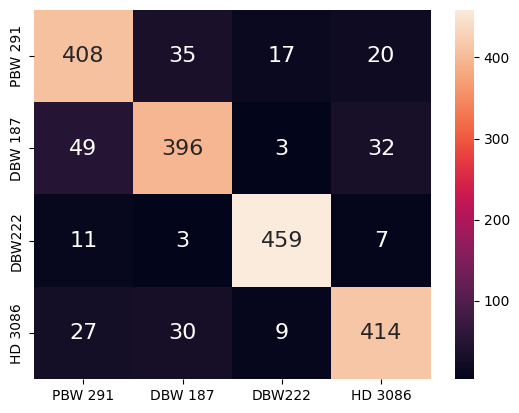

In [59]:
import seaborn as sn
import pandas as pd

df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()

In [60]:
last_epoch = 2000

In [61]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  1201
768/768 - 33s - loss: 0.5166 - dense_4_loss: 0.2572 - dense_1_loss: 0.4994 - dense_3_loss: 0.3655 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8647 - val_loss: 0.5022 - val_dense_4_loss: 0.2563 - val_dense_1_loss: 0.4702 - val_dense_3_loss: 0.3494 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 22:54:10.039606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:54:10.048642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:54:10.058758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1201
added to csv

Epoch:  1202
768/768 - 32s - loss: 0.5165 - dense_4_loss: 0.2574 - dense_1_loss: 0.4992 - dense_3_loss: 0.3646 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8647 - val_loss: 0.5023 - val_dense_4_loss: 0.2564 - val_dense_1_loss: 0.4702 - val_dense_3_loss: 0.3495 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 22:55:04.346839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:55:04.357005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:55:04.364988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1202
added to csv

Epoch:  1203
768/768 - 32s - loss: 0.5151 - dense_4_loss: 0.2545 - dense_1_loss: 0.5053 - dense_3_loss: 0.3635 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8631 - val_loss: 0.5021 - val_dense_4_loss: 0.2563 - val_dense_1_loss: 0.4701 - val_dense_3_loss: 0.3494 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 22:55:56.618239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:55:56.626615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:55:56.634234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1203
added to csv

Epoch:  1204
768/768 - 32s - loss: 0.5174 - dense_4_loss: 0.2574 - dense_1_loss: 0.5006 - dense_3_loss: 0.3661 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8662 - val_loss: 0.5020 - val_dense_4_loss: 0.2562 - val_dense_1_loss: 0.4701 - val_dense_3_loss: 0.3493 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 22:56:50.250604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:56:50.261855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:56:50.269622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1204
added to csv

Epoch:  1205
768/768 - 33s - loss: 0.5167 - dense_4_loss: 0.2589 - dense_1_loss: 0.4987 - dense_3_loss: 0.3607 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8683 - val_loss: 0.5021 - val_dense_4_loss: 0.2563 - val_dense_1_loss: 0.4700 - val_dense_3_loss: 0.3494 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 22:57:44.498527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:57:44.506979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:57:44.515782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1205
added to csv

Epoch:  1206
768/768 - 33s - loss: 0.5198 - dense_4_loss: 0.2609 - dense_1_loss: 0.4997 - dense_3_loss: 0.3634 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8649 - val_loss: 0.5020 - val_dense_4_loss: 0.2562 - val_dense_1_loss: 0.4700 - val_dense_3_loss: 0.3493 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 22:58:37.650440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:58:37.658916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:58:37.666581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1206
added to csv

Epoch:  1207
768/768 - 32s - loss: 0.5168 - dense_4_loss: 0.2566 - dense_1_loss: 0.5042 - dense_3_loss: 0.3631 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8639 - val_loss: 0.5018 - val_dense_4_loss: 0.2561 - val_dense_1_loss: 0.4699 - val_dense_3_loss: 0.3492 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 22:59:30.605237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:59:30.613557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22:59:30.621268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 22

INFO:tensorflow:Assets written to: ./GNmodels/1207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1207
added to csv

Epoch:  1208
768/768 - 33s - loss: 0.5166 - dense_4_loss: 0.2560 - dense_1_loss: 0.5008 - dense_3_loss: 0.3682 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8604 - val_loss: 0.5018 - val_dense_4_loss: 0.2561 - val_dense_1_loss: 0.4699 - val_dense_3_loss: 0.3492 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:00:24.105550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:00:24.113878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:00:24.122372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1208
added to csv

Epoch:  1209
768/768 - 32s - loss: 0.5192 - dense_4_loss: 0.2576 - dense_1_loss: 0.5087 - dense_3_loss: 0.3632 - dense_4_accuracy: 0.9045 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8657 - val_loss: 0.5016 - val_dense_4_loss: 0.2559 - val_dense_1_loss: 0.4699 - val_dense_3_loss: 0.3490 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 23:01:17.730580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:01:17.741312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:01:17.749210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1209
added to csv

Epoch:  1210
768/768 - 33s - loss: 0.5169 - dense_4_loss: 0.2566 - dense_1_loss: 0.5035 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8667 - val_loss: 0.5015 - val_dense_4_loss: 0.2558 - val_dense_1_loss: 0.4698 - val_dense_3_loss: 0.3489 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 23:02:10.898606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:02:10.907412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:02:10.916661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1210
added to csv

Epoch:  1211
768/768 - 32s - loss: 0.5167 - dense_4_loss: 0.2575 - dense_1_loss: 0.5000 - dense_3_loss: 0.3641 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8621 - val_loss: 0.5014 - val_dense_4_loss: 0.2558 - val_dense_1_loss: 0.4698 - val_dense_3_loss: 0.3490 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 23:03:05.284316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:03:05.292899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:03:05.300762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1211
added to csv

Epoch:  1212
768/768 - 33s - loss: 0.5211 - dense_4_loss: 0.2621 - dense_1_loss: 0.5008 - dense_3_loss: 0.3624 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8617 - val_loss: 0.5017 - val_dense_4_loss: 0.2560 - val_dense_1_loss: 0.4698 - val_dense_3_loss: 0.3491 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:03:57.718804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:03:57.727387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:03:57.735132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1212
added to csv

Epoch:  1213
768/768 - 32s - loss: 0.5176 - dense_4_loss: 0.2571 - dense_1_loss: 0.5025 - dense_3_loss: 0.3659 - dense_4_accuracy: 0.9036 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8636 - val_loss: 0.5015 - val_dense_4_loss: 0.2559 - val_dense_1_loss: 0.4698 - val_dense_3_loss: 0.3490 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:04:49.699241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:04:49.707879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:04:49.715560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1213
added to csv

Epoch:  1214
768/768 - 32s - loss: 0.5199 - dense_4_loss: 0.2569 - dense_1_loss: 0.5078 - dense_3_loss: 0.3688 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8626 - val_loss: 0.5014 - val_dense_4_loss: 0.2558 - val_dense_1_loss: 0.4697 - val_dense_3_loss: 0.3489 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:05:42.324463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:05:42.332885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:05:42.340684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1214
added to csv

Epoch:  1215
768/768 - 33s - loss: 0.5182 - dense_4_loss: 0.2573 - dense_1_loss: 0.5037 - dense_3_loss: 0.3658 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8654 - val_loss: 0.5015 - val_dense_4_loss: 0.2559 - val_dense_1_loss: 0.4697 - val_dense_3_loss: 0.3490 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:06:34.785150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:06:34.793635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:06:34.801310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1215
added to csv

Epoch:  1216
768/768 - 33s - loss: 0.5191 - dense_4_loss: 0.2577 - dense_1_loss: 0.5058 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9028 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8626 - val_loss: 0.5015 - val_dense_4_loss: 0.2559 - val_dense_1_loss: 0.4697 - val_dense_3_loss: 0.3489 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:07:28.092136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:07:28.100697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:07:28.108407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1216
added to csv

Epoch:  1217
768/768 - 33s - loss: 0.5182 - dense_4_loss: 0.2584 - dense_1_loss: 0.4991 - dense_3_loss: 0.3669 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8652 - val_loss: 0.5012 - val_dense_4_loss: 0.2557 - val_dense_1_loss: 0.4696 - val_dense_3_loss: 0.3487 - val_dense_4_accuracy: 0.9102 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:08:21.822714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:08:21.831224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:08:21.838846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1217
added to csv

Epoch:  1218
768/768 - 32s - loss: 0.5145 - dense_4_loss: 0.2551 - dense_1_loss: 0.4970 - dense_3_loss: 0.3676 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8604 - val_loss: 0.5011 - val_dense_4_loss: 0.2557 - val_dense_1_loss: 0.4695 - val_dense_3_loss: 0.3487 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-01 23:09:12.938933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:09:12.947289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:09:12.955066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1218
added to csv

Epoch:  1219
768/768 - 32s - loss: 0.5183 - dense_4_loss: 0.2582 - dense_1_loss: 0.5003 - dense_3_loss: 0.3668 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8646 - val_loss: 0.5014 - val_dense_4_loss: 0.2559 - val_dense_1_loss: 0.4696 - val_dense_3_loss: 0.3489 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:10:05.899620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:10:05.908177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:10:05.916710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1219
added to csv

Epoch:  1220
768/768 - 33s - loss: 0.5199 - dense_4_loss: 0.2593 - dense_1_loss: 0.5013 - dense_3_loss: 0.3673 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8630 - val_loss: 0.5016 - val_dense_4_loss: 0.2560 - val_dense_1_loss: 0.4696 - val_dense_3_loss: 0.3490 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 44ms/step


2023-08-01 23:11:00.477270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:11:00.485920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:11:00.493878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1220
added to csv

Epoch:  1221
768/768 - 32s - loss: 0.5164 - dense_4_loss: 0.2566 - dense_1_loss: 0.4998 - dense_3_loss: 0.3663 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8662 - val_loss: 0.5016 - val_dense_4_loss: 0.2561 - val_dense_1_loss: 0.4695 - val_dense_3_loss: 0.3490 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:11:52.809168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:11:52.817740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:11:52.825591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1221
added to csv

Epoch:  1222
768/768 - 33s - loss: 0.5169 - dense_4_loss: 0.2554 - dense_1_loss: 0.5029 - dense_3_loss: 0.3688 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8626 - val_loss: 0.5011 - val_dense_4_loss: 0.2557 - val_dense_1_loss: 0.4694 - val_dense_3_loss: 0.3487 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 23:12:47.283351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:12:47.291681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:12:47.300045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1222
added to csv

Epoch:  1223
768/768 - 33s - loss: 0.5211 - dense_4_loss: 0.2626 - dense_1_loss: 0.4937 - dense_3_loss: 0.3679 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8652 - val_loss: 0.5008 - val_dense_4_loss: 0.2555 - val_dense_1_loss: 0.4693 - val_dense_3_loss: 0.3485 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-01 23:13:40.976315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:13:40.986306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:13:40.994152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1223
added to csv

Epoch:  1224
768/768 - 33s - loss: 0.5171 - dense_4_loss: 0.2574 - dense_1_loss: 0.4990 - dense_3_loss: 0.3667 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8641 - val_loss: 0.5008 - val_dense_4_loss: 0.2555 - val_dense_1_loss: 0.4693 - val_dense_3_loss: 0.3485 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:14:34.883688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:14:34.892143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:14:34.900017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1224
added to csv

Epoch:  1225
768/768 - 32s - loss: 0.5157 - dense_4_loss: 0.2558 - dense_1_loss: 0.5006 - dense_3_loss: 0.3657 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8646 - val_loss: 0.5007 - val_dense_4_loss: 0.2554 - val_dense_1_loss: 0.4693 - val_dense_3_loss: 0.3484 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:15:27.782719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:15:27.791504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:15:27.799197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1225
added to csv

Epoch:  1226
768/768 - 32s - loss: 0.5192 - dense_4_loss: 0.2594 - dense_1_loss: 0.5045 - dense_3_loss: 0.3614 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8652 - val_loss: 0.5007 - val_dense_4_loss: 0.2554 - val_dense_1_loss: 0.4693 - val_dense_3_loss: 0.3484 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-01 23:16:19.994236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:16:20.003216: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:16:20.010982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1226
added to csv

Epoch:  1227
768/768 - 32s - loss: 0.5126 - dense_4_loss: 0.2526 - dense_1_loss: 0.5011 - dense_3_loss: 0.3655 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8638 - val_loss: 0.5006 - val_dense_4_loss: 0.2553 - val_dense_1_loss: 0.4692 - val_dense_3_loss: 0.3484 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-01 23:17:11.839099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:17:11.848102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:17:11.858511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1227
added to csv

Epoch:  1228
768/768 - 33s - loss: 0.5148 - dense_4_loss: 0.2573 - dense_1_loss: 0.4983 - dense_3_loss: 0.3600 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8670 - val_loss: 0.5006 - val_dense_4_loss: 0.2553 - val_dense_1_loss: 0.4692 - val_dense_3_loss: 0.3484 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 23:18:04.499010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:18:04.508730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:18:04.516371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1228
added to csv

Epoch:  1229
768/768 - 32s - loss: 0.5187 - dense_4_loss: 0.2577 - dense_1_loss: 0.5029 - dense_3_loss: 0.3669 - dense_4_accuracy: 0.9015 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8652 - val_loss: 0.5007 - val_dense_4_loss: 0.2554 - val_dense_1_loss: 0.4692 - val_dense_3_loss: 0.3485 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:18:57.158375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:18:57.168058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:18:57.175790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1229
added to csv

Epoch:  1230
768/768 - 33s - loss: 0.5171 - dense_4_loss: 0.2582 - dense_1_loss: 0.4961 - dense_3_loss: 0.3671 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8657 - val_loss: 0.5006 - val_dense_4_loss: 0.2553 - val_dense_1_loss: 0.4691 - val_dense_3_loss: 0.3483 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 23:19:49.693412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:19:49.701895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:19:49.709730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1230
added to csv

Epoch:  1231
768/768 - 32s - loss: 0.5146 - dense_4_loss: 0.2538 - dense_1_loss: 0.5046 - dense_3_loss: 0.3648 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8652 - val_loss: 0.5005 - val_dense_4_loss: 0.2553 - val_dense_1_loss: 0.4691 - val_dense_3_loss: 0.3483 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:20:41.329354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:20:41.338413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:20:41.346009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1231
added to csv

Epoch:  1232
768/768 - 32s - loss: 0.5184 - dense_4_loss: 0.2583 - dense_1_loss: 0.5016 - dense_3_loss: 0.3657 - dense_4_accuracy: 0.9035 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8621 - val_loss: 0.5004 - val_dense_4_loss: 0.2552 - val_dense_1_loss: 0.4690 - val_dense_3_loss: 0.3482 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 23:21:34.858510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:21:34.866710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:21:34.876931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1232
added to csv

Epoch:  1233
768/768 - 32s - loss: 0.5196 - dense_4_loss: 0.2600 - dense_1_loss: 0.5020 - dense_3_loss: 0.3631 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8610 - val_loss: 0.5002 - val_dense_4_loss: 0.2551 - val_dense_1_loss: 0.4690 - val_dense_3_loss: 0.3481 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 23:22:27.924058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:22:27.932675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:22:27.940547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1233
added to csv

Epoch:  1234
768/768 - 33s - loss: 0.5147 - dense_4_loss: 0.2572 - dense_1_loss: 0.4975 - dense_3_loss: 0.3608 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8101 - dense_3_accuracy: 0.8621 - val_loss: 0.5005 - val_dense_4_loss: 0.2553 - val_dense_1_loss: 0.4690 - val_dense_3_loss: 0.3483 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 23:23:20.522607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:23:20.531135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:23:20.538786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1234
added to csv

Epoch:  1235
768/768 - 32s - loss: 0.5189 - dense_4_loss: 0.2591 - dense_1_loss: 0.5042 - dense_3_loss: 0.3619 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8088 - dense_3_accuracy: 0.8636 - val_loss: 0.5002 - val_dense_4_loss: 0.2551 - val_dense_1_loss: 0.4689 - val_dense_3_loss: 0.3481 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:24:13.037543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:24:13.045974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:24:13.054631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1235
added to csv

Epoch:  1236
768/768 - 32s - loss: 0.5180 - dense_4_loss: 0.2569 - dense_1_loss: 0.5025 - dense_3_loss: 0.3680 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8592 - val_loss: 0.5001 - val_dense_4_loss: 0.2551 - val_dense_1_loss: 0.4689 - val_dense_3_loss: 0.3480 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:25:05.412298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:25:05.420838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:25:05.428548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1236
added to csv

Epoch:  1237
768/768 - 34s - loss: 0.5119 - dense_4_loss: 0.2534 - dense_1_loss: 0.4964 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8625 - val_loss: 0.5003 - val_dense_4_loss: 0.2552 - val_dense_1_loss: 0.4689 - val_dense_3_loss: 0.3481 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 34s/epoch - 44ms/step


2023-08-01 23:25:58.090151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:25:58.098781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:25:58.106487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1237
added to csv

Epoch:  1238
768/768 - 33s - loss: 0.5192 - dense_4_loss: 0.2595 - dense_1_loss: 0.5027 - dense_3_loss: 0.3631 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8665 - val_loss: 0.4999 - val_dense_4_loss: 0.2549 - val_dense_1_loss: 0.4688 - val_dense_3_loss: 0.3479 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:26:51.952416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:26:51.960769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:26:51.968519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1238
added to csv

Epoch:  1239
768/768 - 32s - loss: 0.5112 - dense_4_loss: 0.2523 - dense_1_loss: 0.4978 - dense_3_loss: 0.3652 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8631 - val_loss: 0.5002 - val_dense_4_loss: 0.2551 - val_dense_1_loss: 0.4688 - val_dense_3_loss: 0.3481 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:27:43.456044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:27:43.464418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:27:43.472106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1239
added to csv

Epoch:  1240
768/768 - 33s - loss: 0.5135 - dense_4_loss: 0.2559 - dense_1_loss: 0.5008 - dense_3_loss: 0.3580 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8693 - val_loss: 0.5000 - val_dense_4_loss: 0.2550 - val_dense_1_loss: 0.4688 - val_dense_3_loss: 0.3480 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:28:36.383699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:28:36.392213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:28:36.399933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1240
added to csv

Epoch:  1241
768/768 - 32s - loss: 0.5180 - dense_4_loss: 0.2569 - dense_1_loss: 0.5009 - dense_3_loss: 0.3693 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8600 - val_loss: 0.5001 - val_dense_4_loss: 0.2551 - val_dense_1_loss: 0.4688 - val_dense_3_loss: 0.3480 - val_dense_4_accuracy: 0.9108 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 42ms/step


2023-08-01 23:29:29.101509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:29:29.109788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:29:29.117460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1241
added to csv

Epoch:  1242
768/768 - 32s - loss: 0.5137 - dense_4_loss: 0.2560 - dense_1_loss: 0.4969 - dense_3_loss: 0.3620 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8667 - val_loss: 0.4999 - val_dense_4_loss: 0.2549 - val_dense_1_loss: 0.4687 - val_dense_3_loss: 0.3479 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8242 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:30:21.142748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:30:21.151614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:30:21.159281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1242
added to csv

Epoch:  1243
768/768 - 32s - loss: 0.5176 - dense_4_loss: 0.2570 - dense_1_loss: 0.5065 - dense_3_loss: 0.3622 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8693 - val_loss: 0.4997 - val_dense_4_loss: 0.2548 - val_dense_1_loss: 0.4687 - val_dense_3_loss: 0.3478 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 23:31:13.773564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:31:13.785254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:31:13.793619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1243
added to csv

Epoch:  1244
768/768 - 32s - loss: 0.5197 - dense_4_loss: 0.2587 - dense_1_loss: 0.5024 - dense_3_loss: 0.3677 - dense_4_accuracy: 0.9041 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8617 - val_loss: 0.4998 - val_dense_4_loss: 0.2548 - val_dense_1_loss: 0.4687 - val_dense_3_loss: 0.3478 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:32:06.753855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:32:06.762340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:32:06.769924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1244
added to csv

Epoch:  1245
768/768 - 32s - loss: 0.5163 - dense_4_loss: 0.2569 - dense_1_loss: 0.5010 - dense_3_loss: 0.3639 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8675 - val_loss: 0.4998 - val_dense_4_loss: 0.2548 - val_dense_1_loss: 0.4686 - val_dense_3_loss: 0.3478 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:32:58.933384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:32:58.942183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:32:58.949930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1245
added to csv

Epoch:  1246
768/768 - 32s - loss: 0.5152 - dense_4_loss: 0.2568 - dense_1_loss: 0.4970 - dense_3_loss: 0.3644 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8626 - val_loss: 0.4997 - val_dense_4_loss: 0.2548 - val_dense_1_loss: 0.4686 - val_dense_3_loss: 0.3477 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:33:53.069445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:33:53.077671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:33:53.086025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1246
added to csv

Epoch:  1247
768/768 - 32s - loss: 0.5208 - dense_4_loss: 0.2621 - dense_1_loss: 0.4995 - dense_3_loss: 0.3625 - dense_4_accuracy: 0.9019 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8677 - val_loss: 0.4995 - val_dense_4_loss: 0.2547 - val_dense_1_loss: 0.4685 - val_dense_3_loss: 0.3476 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-01 23:34:46.023399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:34:46.031717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:34:46.039699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1247
added to csv

Epoch:  1248
768/768 - 33s - loss: 0.5155 - dense_4_loss: 0.2539 - dense_1_loss: 0.5035 - dense_3_loss: 0.3683 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8613 - val_loss: 0.4995 - val_dense_4_loss: 0.2547 - val_dense_1_loss: 0.4685 - val_dense_3_loss: 0.3476 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 23:35:39.517401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:35:39.525875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:35:39.535103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1248
added to csv

Epoch:  1249
768/768 - 31s - loss: 0.5205 - dense_4_loss: 0.2598 - dense_1_loss: 0.5008 - dense_3_loss: 0.3684 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8626 - val_loss: 0.4994 - val_dense_4_loss: 0.2546 - val_dense_1_loss: 0.4685 - val_dense_3_loss: 0.3475 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-01 23:36:32.719762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:36:32.728015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:36:32.735740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1249
added to csv

Epoch:  1250
768/768 - 33s - loss: 0.5162 - dense_4_loss: 0.2557 - dense_1_loss: 0.5028 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8081 - dense_3_accuracy: 0.8659 - val_loss: 0.4993 - val_dense_4_loss: 0.2545 - val_dense_1_loss: 0.4685 - val_dense_3_loss: 0.3475 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 23:37:26.738921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:37:26.747204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:37:26.755197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1250
added to csv

Epoch:  1251
768/768 - 32s - loss: 0.5192 - dense_4_loss: 0.2602 - dense_1_loss: 0.4974 - dense_3_loss: 0.3659 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8638 - val_loss: 0.4995 - val_dense_4_loss: 0.2547 - val_dense_1_loss: 0.4685 - val_dense_3_loss: 0.3476 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:38:19.976170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:38:19.984862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:38:19.992556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1251
added to csv

Epoch:  1252
768/768 - 33s - loss: 0.5197 - dense_4_loss: 0.2608 - dense_1_loss: 0.5026 - dense_3_loss: 0.3605 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8665 - val_loss: 0.4993 - val_dense_4_loss: 0.2545 - val_dense_1_loss: 0.4684 - val_dense_3_loss: 0.3474 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-01 23:39:12.958212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:39:12.966762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:39:12.974445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1252
added to csv

Epoch:  1253
768/768 - 32s - loss: 0.5176 - dense_4_loss: 0.2576 - dense_1_loss: 0.5061 - dense_3_loss: 0.3603 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8659 - val_loss: 0.4994 - val_dense_4_loss: 0.2546 - val_dense_1_loss: 0.4684 - val_dense_3_loss: 0.3475 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:40:06.603691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:40:06.612077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:40:06.619783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1253
added to csv

Epoch:  1254
768/768 - 32s - loss: 0.5173 - dense_4_loss: 0.2554 - dense_1_loss: 0.5041 - dense_3_loss: 0.3686 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8643 - val_loss: 0.4993 - val_dense_4_loss: 0.2546 - val_dense_1_loss: 0.4684 - val_dense_3_loss: 0.3474 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:40:59.619048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:40:59.627460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:40:59.637454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1254
added to csv

Epoch:  1255
768/768 - 33s - loss: 0.5184 - dense_4_loss: 0.2600 - dense_1_loss: 0.4994 - dense_3_loss: 0.3617 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8670 - val_loss: 0.4991 - val_dense_4_loss: 0.2545 - val_dense_1_loss: 0.4683 - val_dense_3_loss: 0.3473 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:41:53.269095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:41:53.278421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:41:53.286642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1255
added to csv

Epoch:  1256
768/768 - 32s - loss: 0.5131 - dense_4_loss: 0.2538 - dense_1_loss: 0.4987 - dense_3_loss: 0.3656 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8656 - val_loss: 0.4992 - val_dense_4_loss: 0.2546 - val_dense_1_loss: 0.4683 - val_dense_3_loss: 0.3473 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-01 23:42:45.866565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:42:45.874954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:42:45.882734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1256
added to csv

Epoch:  1257
768/768 - 31s - loss: 0.5168 - dense_4_loss: 0.2568 - dense_1_loss: 0.5001 - dense_3_loss: 0.3666 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8647 - val_loss: 0.4992 - val_dense_4_loss: 0.2545 - val_dense_1_loss: 0.4682 - val_dense_3_loss: 0.3473 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 31s/epoch - 41ms/step


2023-08-01 23:43:37.142199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:43:37.152210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:43:37.160945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1257
added to csv

Epoch:  1258
768/768 - 32s - loss: 0.5133 - dense_4_loss: 0.2536 - dense_1_loss: 0.5029 - dense_3_loss: 0.3629 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8672 - val_loss: 0.4990 - val_dense_4_loss: 0.2544 - val_dense_1_loss: 0.4681 - val_dense_3_loss: 0.3472 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-01 23:44:28.381760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:44:28.391129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:44:28.399352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1258
added to csv

Epoch:  1259
768/768 - 33s - loss: 0.5133 - dense_4_loss: 0.2541 - dense_1_loss: 0.4983 - dense_3_loss: 0.3657 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8620 - val_loss: 0.4990 - val_dense_4_loss: 0.2544 - val_dense_1_loss: 0.4681 - val_dense_3_loss: 0.3472 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 42ms/step


2023-08-01 23:45:22.437988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:45:22.446484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:45:22.454247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1259
added to csv

Epoch:  1260
768/768 - 31s - loss: 0.5212 - dense_4_loss: 0.2619 - dense_1_loss: 0.5042 - dense_3_loss: 0.3599 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8643 - val_loss: 0.4988 - val_dense_4_loss: 0.2543 - val_dense_1_loss: 0.4680 - val_dense_3_loss: 0.3470 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 31s/epoch - 41ms/step


2023-08-01 23:46:14.225377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:46:14.234049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:46:14.241885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1260
added to csv

Epoch:  1261
768/768 - 33s - loss: 0.5201 - dense_4_loss: 0.2614 - dense_1_loss: 0.4981 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8654 - val_loss: 0.4989 - val_dense_4_loss: 0.2543 - val_dense_1_loss: 0.4681 - val_dense_3_loss: 0.3471 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 23:47:06.602315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:47:06.610857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:47:06.618742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1261
added to csv

Epoch:  1262
768/768 - 32s - loss: 0.5137 - dense_4_loss: 0.2539 - dense_1_loss: 0.5007 - dense_3_loss: 0.3652 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8076 - dense_3_accuracy: 0.8633 - val_loss: 0.4989 - val_dense_4_loss: 0.2543 - val_dense_1_loss: 0.4680 - val_dense_3_loss: 0.3471 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:47:59.073884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:47:59.082387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:47:59.090041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1262
added to csv

Epoch:  1263
768/768 - 33s - loss: 0.5108 - dense_4_loss: 0.2533 - dense_1_loss: 0.4993 - dense_3_loss: 0.3590 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8641 - val_loss: 0.4987 - val_dense_4_loss: 0.2542 - val_dense_1_loss: 0.4679 - val_dense_3_loss: 0.3470 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:48:51.903537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:48:51.911808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:48:51.919464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1263
added to csv

Epoch:  1264
768/768 - 33s - loss: 0.5164 - dense_4_loss: 0.2555 - dense_1_loss: 0.5071 - dense_3_loss: 0.3628 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8049 - dense_3_accuracy: 0.8656 - val_loss: 0.4988 - val_dense_4_loss: 0.2543 - val_dense_1_loss: 0.4680 - val_dense_3_loss: 0.3470 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:49:44.485223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:49:44.494504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:49:44.502260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1264
added to csv

Epoch:  1265
768/768 - 32s - loss: 0.5155 - dense_4_loss: 0.2581 - dense_1_loss: 0.4978 - dense_3_loss: 0.3600 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8659 - val_loss: 0.4988 - val_dense_4_loss: 0.2543 - val_dense_1_loss: 0.4679 - val_dense_3_loss: 0.3470 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:50:37.398429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:50:37.406848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:50:37.414518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1265
added to csv

Epoch:  1266
768/768 - 32s - loss: 0.5080 - dense_4_loss: 0.2524 - dense_1_loss: 0.4937 - dense_3_loss: 0.3583 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8649 - val_loss: 0.4987 - val_dense_4_loss: 0.2542 - val_dense_1_loss: 0.4679 - val_dense_3_loss: 0.3469 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:51:29.529111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:51:29.538029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:51:29.546359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1266
added to csv

Epoch:  1267
768/768 - 33s - loss: 0.5123 - dense_4_loss: 0.2562 - dense_1_loss: 0.4941 - dense_3_loss: 0.3594 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8674 - val_loss: 0.4985 - val_dense_4_loss: 0.2541 - val_dense_1_loss: 0.4678 - val_dense_3_loss: 0.3468 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-01 23:52:24.458283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:52:24.466806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:52:24.474551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1267
added to csv

Epoch:  1268
768/768 - 32s - loss: 0.5168 - dense_4_loss: 0.2561 - dense_1_loss: 0.4995 - dense_3_loss: 0.3695 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8641 - val_loss: 0.4986 - val_dense_4_loss: 0.2542 - val_dense_1_loss: 0.4678 - val_dense_3_loss: 0.3468 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:53:17.966341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:53:17.975024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:53:17.983055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1268
added to csv

Epoch:  1269
768/768 - 32s - loss: 0.5117 - dense_4_loss: 0.2552 - dense_1_loss: 0.4934 - dense_3_loss: 0.3617 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8621 - val_loss: 0.4987 - val_dense_4_loss: 0.2542 - val_dense_1_loss: 0.4678 - val_dense_3_loss: 0.3469 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 32s/epoch - 41ms/step


2023-08-01 23:54:12.134813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:54:12.145108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:54:12.154664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1269
added to csv

Epoch:  1270
768/768 - 32s - loss: 0.5165 - dense_4_loss: 0.2581 - dense_1_loss: 0.4983 - dense_3_loss: 0.3630 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8638 - val_loss: 0.4986 - val_dense_4_loss: 0.2543 - val_dense_1_loss: 0.4678 - val_dense_3_loss: 0.3468 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-01 23:55:05.682787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:55:05.691457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:55:05.699173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1270
added to csv

Epoch:  1271
768/768 - 32s - loss: 0.5142 - dense_4_loss: 0.2560 - dense_1_loss: 0.4985 - dense_3_loss: 0.3623 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8644 - val_loss: 0.4985 - val_dense_4_loss: 0.2541 - val_dense_1_loss: 0.4677 - val_dense_3_loss: 0.3467 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-01 23:55:58.361925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:55:58.370759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:55:58.378962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1271
added to csv

Epoch:  1272
768/768 - 33s - loss: 0.5149 - dense_4_loss: 0.2568 - dense_1_loss: 0.5014 - dense_3_loss: 0.3592 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8674 - val_loss: 0.4983 - val_dense_4_loss: 0.2540 - val_dense_1_loss: 0.4677 - val_dense_3_loss: 0.3466 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-01 23:56:53.551450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:56:53.560958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:56:53.569263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1272
added to csv

Epoch:  1273
768/768 - 32s - loss: 0.5150 - dense_4_loss: 0.2576 - dense_1_loss: 0.4938 - dense_3_loss: 0.3641 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8680 - val_loss: 0.4983 - val_dense_4_loss: 0.2540 - val_dense_1_loss: 0.4677 - val_dense_3_loss: 0.3466 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-01 23:57:46.972835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:57:46.983387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:57:46.992070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1273
added to csv

Epoch:  1274
768/768 - 33s - loss: 0.5178 - dense_4_loss: 0.2585 - dense_1_loss: 0.5012 - dense_3_loss: 0.3630 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8641 - val_loss: 0.4983 - val_dense_4_loss: 0.2540 - val_dense_1_loss: 0.4676 - val_dense_3_loss: 0.3467 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-01 23:58:41.871529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:58:41.881582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:58:41.889388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1274
added to csv

Epoch:  1275
768/768 - 33s - loss: 0.5162 - dense_4_loss: 0.2572 - dense_1_loss: 0.4999 - dense_3_loss: 0.3635 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8608 - val_loss: 0.4982 - val_dense_4_loss: 0.2540 - val_dense_1_loss: 0.4676 - val_dense_3_loss: 0.3466 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-01 23:59:36.485758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:59:36.494223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23:59:36.501969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-01 23

INFO:tensorflow:Assets written to: ./GNmodels/1275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1275
added to csv

Epoch:  1276
768/768 - 32s - loss: 0.5107 - dense_4_loss: 0.2541 - dense_1_loss: 0.4938 - dense_3_loss: 0.3616 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8602 - val_loss: 0.4980 - val_dense_4_loss: 0.2538 - val_dense_1_loss: 0.4675 - val_dense_3_loss: 0.3464 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:00:28.901475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:00:28.910361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:00:28.918615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1276
added to csv

Epoch:  1277
768/768 - 32s - loss: 0.5171 - dense_4_loss: 0.2562 - dense_1_loss: 0.5050 - dense_3_loss: 0.3648 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8079 - dense_3_accuracy: 0.8656 - val_loss: 0.4980 - val_dense_4_loss: 0.2538 - val_dense_1_loss: 0.4675 - val_dense_3_loss: 0.3465 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:01:23.214908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:01:23.223638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:01:23.232058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1277
added to csv

Epoch:  1278
768/768 - 32s - loss: 0.5147 - dense_4_loss: 0.2563 - dense_1_loss: 0.4958 - dense_3_loss: 0.3656 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8644 - val_loss: 0.4980 - val_dense_4_loss: 0.2538 - val_dense_1_loss: 0.4675 - val_dense_3_loss: 0.3464 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:02:16.741832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:02:16.750806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:02:16.759099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1278
added to csv

Epoch:  1279
768/768 - 34s - loss: 0.5112 - dense_4_loss: 0.2535 - dense_1_loss: 0.5020 - dense_3_loss: 0.3572 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8066 - dense_3_accuracy: 0.8721 - val_loss: 0.4978 - val_dense_4_loss: 0.2537 - val_dense_1_loss: 0.4674 - val_dense_3_loss: 0.3463 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 34s/epoch - 44ms/step


2023-08-02 00:03:11.829580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:03:11.839338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:03:11.847157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1279
added to csv

Epoch:  1280
768/768 - 33s - loss: 0.5170 - dense_4_loss: 0.2558 - dense_1_loss: 0.5056 - dense_3_loss: 0.3652 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8071 - dense_3_accuracy: 0.8649 - val_loss: 0.4980 - val_dense_4_loss: 0.2539 - val_dense_1_loss: 0.4674 - val_dense_3_loss: 0.3464 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-02 00:04:06.090770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:04:06.099316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:04:06.107003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1280
added to csv

Epoch:  1281
768/768 - 32s - loss: 0.5130 - dense_4_loss: 0.2551 - dense_1_loss: 0.4943 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8657 - val_loss: 0.4981 - val_dense_4_loss: 0.2540 - val_dense_1_loss: 0.4674 - val_dense_3_loss: 0.3465 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 41ms/step


2023-08-02 00:04:58.707909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:04:58.716677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:04:58.724368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1281
added to csv

Epoch:  1282
768/768 - 32s - loss: 0.5133 - dense_4_loss: 0.2543 - dense_1_loss: 0.4995 - dense_3_loss: 0.3637 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8654 - val_loss: 0.4977 - val_dense_4_loss: 0.2537 - val_dense_1_loss: 0.4673 - val_dense_3_loss: 0.3462 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-02 00:05:52.352250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:05:52.360882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:05:52.368715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1282
added to csv

Epoch:  1283
768/768 - 32s - loss: 0.5112 - dense_4_loss: 0.2525 - dense_1_loss: 0.4996 - dense_3_loss: 0.3626 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8664 - val_loss: 0.4978 - val_dense_4_loss: 0.2538 - val_dense_1_loss: 0.4673 - val_dense_3_loss: 0.3462 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:06:45.936502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:06:45.945190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:06:45.953369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1283
added to csv

Epoch:  1284
768/768 - 33s - loss: 0.5130 - dense_4_loss: 0.2555 - dense_1_loss: 0.4960 - dense_3_loss: 0.3625 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8667 - val_loss: 0.4976 - val_dense_4_loss: 0.2536 - val_dense_1_loss: 0.4673 - val_dense_3_loss: 0.3461 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-02 00:07:39.775282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:07:39.784319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:07:39.793245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1284
added to csv

Epoch:  1285
768/768 - 33s - loss: 0.5165 - dense_4_loss: 0.2576 - dense_1_loss: 0.4999 - dense_3_loss: 0.3631 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8657 - val_loss: 0.4975 - val_dense_4_loss: 0.2535 - val_dense_1_loss: 0.4672 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-02 00:08:34.610357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:08:34.618917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:08:34.626737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1285
added to csv

Epoch:  1286
768/768 - 33s - loss: 0.5162 - dense_4_loss: 0.2583 - dense_1_loss: 0.4981 - dense_3_loss: 0.3614 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8657 - val_loss: 0.4975 - val_dense_4_loss: 0.2535 - val_dense_1_loss: 0.4672 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 00:09:28.857878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:09:28.866411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:09:28.874051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1286GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1286GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1286
added to csv

Epoch:  1287
768/768 - 32s - loss: 0.5124 - dense_4_loss: 0.2541 - dense_1_loss: 0.4960 - dense_3_loss: 0.3650 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8651 - val_loss: 0.4974 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4672 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:10:21.980491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:10:21.988608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:10:21.996467: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1287GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1287GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1287
added to csv

Epoch:  1288
768/768 - 32s - loss: 0.5170 - dense_4_loss: 0.2548 - dense_1_loss: 0.5051 - dense_3_loss: 0.3690 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8630 - val_loss: 0.4973 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4671 - val_dense_3_loss: 0.3459 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:11:15.947992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:11:15.956191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:11:15.967999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1288GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1288GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1288
added to csv

Epoch:  1289
768/768 - 33s - loss: 0.5140 - dense_4_loss: 0.2549 - dense_1_loss: 0.5001 - dense_3_loss: 0.3639 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8089 - dense_3_accuracy: 0.8634 - val_loss: 0.4974 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4671 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-02 00:12:10.026863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:12:10.035244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:12:10.045400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1289GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1289GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1289
added to csv

Epoch:  1290
768/768 - 33s - loss: 0.5167 - dense_4_loss: 0.2579 - dense_1_loss: 0.4972 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8631 - val_loss: 0.4974 - val_dense_4_loss: 0.2535 - val_dense_1_loss: 0.4671 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:13:03.267573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:13:03.276015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:13:03.283664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1290GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1290GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1290
added to csv

Epoch:  1291
768/768 - 32s - loss: 0.5139 - dense_4_loss: 0.2548 - dense_1_loss: 0.4998 - dense_3_loss: 0.3637 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8659 - val_loss: 0.4975 - val_dense_4_loss: 0.2536 - val_dense_1_loss: 0.4671 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:13:56.660521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:13:56.669004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:13:56.676771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1291GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1291GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1291
added to csv

Epoch:  1292
768/768 - 32s - loss: 0.5150 - dense_4_loss: 0.2561 - dense_1_loss: 0.4973 - dense_3_loss: 0.3657 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8626 - val_loss: 0.4973 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4670 - val_dense_3_loss: 0.3459 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:14:48.990876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:14:48.999077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:14:49.006738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1292GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1292GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1292
added to csv

Epoch:  1293
768/768 - 32s - loss: 0.5106 - dense_4_loss: 0.2529 - dense_1_loss: 0.4995 - dense_3_loss: 0.3594 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8682 - val_loss: 0.4972 - val_dense_4_loss: 0.2533 - val_dense_1_loss: 0.4670 - val_dense_3_loss: 0.3458 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:15:41.900103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:15:41.908346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:15:41.916035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1293GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1293GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1293
added to csv

Epoch:  1294
768/768 - 33s - loss: 0.5145 - dense_4_loss: 0.2561 - dense_1_loss: 0.4994 - dense_3_loss: 0.3619 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8665 - val_loss: 0.4973 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4670 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8743 - 33s/epoch - 43ms/step


2023-08-02 00:16:35.110854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:16:35.119770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:16:35.128052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1294GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1294GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1294
added to csv

Epoch:  1295
768/768 - 32s - loss: 0.5141 - dense_4_loss: 0.2553 - dense_1_loss: 0.4982 - dense_3_loss: 0.3645 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8665 - val_loss: 0.4973 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4670 - val_dense_3_loss: 0.3459 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 42ms/step


2023-08-02 00:17:29.267452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:17:29.276326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:17:29.284164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1295GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1295GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1295
added to csv

Epoch:  1296
768/768 - 33s - loss: 0.5137 - dense_4_loss: 0.2583 - dense_1_loss: 0.4922 - dense_3_loss: 0.3589 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8704 - val_loss: 0.4971 - val_dense_4_loss: 0.2533 - val_dense_1_loss: 0.4669 - val_dense_3_loss: 0.3458 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 44ms/step


2023-08-02 00:18:23.890856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:18:23.899357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:18:23.907938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1296GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1296GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1296
added to csv

Epoch:  1297
768/768 - 33s - loss: 0.5193 - dense_4_loss: 0.2574 - dense_1_loss: 0.5087 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8651 - val_loss: 0.4971 - val_dense_4_loss: 0.2533 - val_dense_1_loss: 0.4669 - val_dense_3_loss: 0.3458 - val_dense_4_accuracy: 0.9115 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:19:16.892525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:19:16.901078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:19:16.908922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1297GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1297GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1297
added to csv

Epoch:  1298
768/768 - 32s - loss: 0.5161 - dense_4_loss: 0.2577 - dense_1_loss: 0.4972 - dense_3_loss: 0.3642 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8665 - val_loss: 0.4975 - val_dense_4_loss: 0.2536 - val_dense_1_loss: 0.4670 - val_dense_3_loss: 0.3460 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8249 - val_dense_3_accuracy: 0.8750 - 32s/epoch - 41ms/step


2023-08-02 00:20:10.168859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:20:10.177459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:20:10.185281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1298GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1298GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1298
added to csv

Epoch:  1299
768/768 - 31s - loss: 0.5114 - dense_4_loss: 0.2544 - dense_1_loss: 0.5005 - dense_3_loss: 0.3559 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8644 - val_loss: 0.4972 - val_dense_4_loss: 0.2534 - val_dense_1_loss: 0.4669 - val_dense_3_loss: 0.3457 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8757 - 31s/epoch - 41ms/step


2023-08-02 00:21:02.369980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:21:02.378556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:21:02.387144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1299GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1299GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1299
added to csv

Epoch:  1300
768/768 - 31s - loss: 0.5168 - dense_4_loss: 0.2579 - dense_1_loss: 0.5013 - dense_3_loss: 0.3615 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8698 - val_loss: 0.4971 - val_dense_4_loss: 0.2533 - val_dense_1_loss: 0.4669 - val_dense_3_loss: 0.3457 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 31s/epoch - 41ms/step


2023-08-02 00:21:53.220474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:21:53.229120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:21:53.236757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1300GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1300GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1300
added to csv

Epoch:  1301
768/768 - 32s - loss: 0.5183 - dense_4_loss: 0.2581 - dense_1_loss: 0.5023 - dense_3_loss: 0.3650 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8659 - val_loss: 0.4968 - val_dense_4_loss: 0.2531 - val_dense_1_loss: 0.4668 - val_dense_3_loss: 0.3456 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:22:45.384955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:22:45.393622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:22:45.401329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1301GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1301GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1301
added to csv

Epoch:  1302
768/768 - 32s - loss: 0.5181 - dense_4_loss: 0.2579 - dense_1_loss: 0.5012 - dense_3_loss: 0.3659 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8644 - val_loss: 0.4968 - val_dense_4_loss: 0.2531 - val_dense_1_loss: 0.4667 - val_dense_3_loss: 0.3455 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:23:38.106986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:23:38.115197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:23:38.124158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1302GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1302GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1302
added to csv

Epoch:  1303
768/768 - 33s - loss: 0.5115 - dense_4_loss: 0.2531 - dense_1_loss: 0.4973 - dense_3_loss: 0.3641 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8628 - val_loss: 0.4967 - val_dense_4_loss: 0.2531 - val_dense_1_loss: 0.4667 - val_dense_3_loss: 0.3455 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8750 - 33s/epoch - 43ms/step


2023-08-02 00:24:31.874410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:24:31.883033: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:24:31.890757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1303GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1303GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1303
added to csv

Epoch:  1304
768/768 - 31s - loss: 0.5145 - dense_4_loss: 0.2569 - dense_1_loss: 0.4964 - dense_3_loss: 0.3621 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8639 - val_loss: 0.4966 - val_dense_4_loss: 0.2529 - val_dense_1_loss: 0.4667 - val_dense_3_loss: 0.3454 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 31s/epoch - 40ms/step


2023-08-02 00:25:24.282172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:25:24.290544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:25:24.298307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1304GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1304GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1304
added to csv

Epoch:  1305
768/768 - 32s - loss: 0.5163 - dense_4_loss: 0.2570 - dense_1_loss: 0.5000 - dense_3_loss: 0.3643 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8647 - val_loss: 0.4967 - val_dense_4_loss: 0.2530 - val_dense_1_loss: 0.4667 - val_dense_3_loss: 0.3455 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:26:17.676001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:26:17.684671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:26:17.692320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1305GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1305GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1305
added to csv

Epoch:  1306
768/768 - 32s - loss: 0.5101 - dense_4_loss: 0.2519 - dense_1_loss: 0.5002 - dense_3_loss: 0.3605 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8656 - val_loss: 0.4968 - val_dense_4_loss: 0.2531 - val_dense_1_loss: 0.4667 - val_dense_3_loss: 0.3455 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-02 00:27:09.951609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:27:09.960286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:27:09.967913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1306GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1306GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1306
added to csv

Epoch:  1307
768/768 - 32s - loss: 0.5153 - dense_4_loss: 0.2568 - dense_1_loss: 0.5015 - dense_3_loss: 0.3599 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8659 - val_loss: 0.4965 - val_dense_4_loss: 0.2529 - val_dense_1_loss: 0.4666 - val_dense_3_loss: 0.3453 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:28:03.235898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:28:03.244266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:28:03.251985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1307GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1307GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1307
added to csv

Epoch:  1308
768/768 - 32s - loss: 0.5111 - dense_4_loss: 0.2505 - dense_1_loss: 0.5070 - dense_3_loss: 0.3614 - dense_4_accuracy: 0.9049 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8669 - val_loss: 0.4964 - val_dense_4_loss: 0.2528 - val_dense_1_loss: 0.4665 - val_dense_3_loss: 0.3453 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:28:56.717238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:28:56.725585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:28:56.733428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1308GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1308GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1308
added to csv

Epoch:  1309
768/768 - 33s - loss: 0.5171 - dense_4_loss: 0.2576 - dense_1_loss: 0.5012 - dense_3_loss: 0.3636 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8623 - val_loss: 0.4962 - val_dense_4_loss: 0.2527 - val_dense_1_loss: 0.4665 - val_dense_3_loss: 0.3451 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:29:50.215801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:29:50.224761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:29:50.232452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1309GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1309GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1309
added to csv

Epoch:  1310
768/768 - 32s - loss: 0.5084 - dense_4_loss: 0.2535 - dense_1_loss: 0.4928 - dense_3_loss: 0.3571 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8660 - val_loss: 0.4964 - val_dense_4_loss: 0.2529 - val_dense_1_loss: 0.4665 - val_dense_3_loss: 0.3453 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-02 00:30:43.261394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:30:43.270164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:30:43.277896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1310GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1310GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1310
added to csv

Epoch:  1311
768/768 - 32s - loss: 0.5111 - dense_4_loss: 0.2547 - dense_1_loss: 0.4940 - dense_3_loss: 0.3605 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8657 - val_loss: 0.4963 - val_dense_4_loss: 0.2528 - val_dense_1_loss: 0.4665 - val_dense_3_loss: 0.3452 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-02 00:31:36.867351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:31:36.875860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:31:36.883533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1311GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1311GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1311
added to csv

Epoch:  1312
768/768 - 32s - loss: 0.5126 - dense_4_loss: 0.2555 - dense_1_loss: 0.4994 - dense_3_loss: 0.3578 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8711 - val_loss: 0.4962 - val_dense_4_loss: 0.2527 - val_dense_1_loss: 0.4664 - val_dense_3_loss: 0.3451 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:32:29.054644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:32:29.063200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:32:29.070874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1312GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1312GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1312
added to csv

Epoch:  1313
768/768 - 33s - loss: 0.5151 - dense_4_loss: 0.2579 - dense_1_loss: 0.4970 - dense_3_loss: 0.3602 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8643 - val_loss: 0.4963 - val_dense_4_loss: 0.2528 - val_dense_1_loss: 0.4664 - val_dense_3_loss: 0.3452 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:33:22.799675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:33:22.808925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:33:22.817295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1313GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1313GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1313
added to csv

Epoch:  1314
768/768 - 33s - loss: 0.5096 - dense_4_loss: 0.2539 - dense_1_loss: 0.4937 - dense_3_loss: 0.3585 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8659 - val_loss: 0.4962 - val_dense_4_loss: 0.2527 - val_dense_1_loss: 0.4663 - val_dense_3_loss: 0.3451 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:34:15.649803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:34:15.658326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:34:15.667525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1314GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1314GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1314
added to csv

Epoch:  1315
768/768 - 33s - loss: 0.5133 - dense_4_loss: 0.2554 - dense_1_loss: 0.4945 - dense_3_loss: 0.3651 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8674 - val_loss: 0.4960 - val_dense_4_loss: 0.2526 - val_dense_1_loss: 0.4663 - val_dense_3_loss: 0.3450 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 00:35:08.288449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:35:08.297358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:35:08.305533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1315GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1315GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1315
added to csv

Epoch:  1316
768/768 - 32s - loss: 0.5080 - dense_4_loss: 0.2538 - dense_1_loss: 0.4951 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8656 - val_loss: 0.4960 - val_dense_4_loss: 0.2526 - val_dense_1_loss: 0.4663 - val_dense_3_loss: 0.3450 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:36:02.296900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:36:02.305582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:36:02.313918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1316GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1316GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1316
added to csv

Epoch:  1317
768/768 - 31s - loss: 0.5123 - dense_4_loss: 0.2519 - dense_1_loss: 0.5008 - dense_3_loss: 0.3671 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8638 - val_loss: 0.4960 - val_dense_4_loss: 0.2527 - val_dense_1_loss: 0.4663 - val_dense_3_loss: 0.3450 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 31s/epoch - 40ms/step


2023-08-02 00:36:53.932906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:36:53.941331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:36:53.949078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1317GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1317GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1317
added to csv

Epoch:  1318
768/768 - 31s - loss: 0.5082 - dense_4_loss: 0.2521 - dense_1_loss: 0.4954 - dense_3_loss: 0.3584 - dense_4_accuracy: 0.9066 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8670 - val_loss: 0.4958 - val_dense_4_loss: 0.2525 - val_dense_1_loss: 0.4662 - val_dense_3_loss: 0.3448 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-02 00:37:46.708285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:37:46.717204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:37:46.725238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1318GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1318GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1318
added to csv

Epoch:  1319
768/768 - 32s - loss: 0.5100 - dense_4_loss: 0.2523 - dense_1_loss: 0.4985 - dense_3_loss: 0.3605 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8112 - dense_3_accuracy: 0.8647 - val_loss: 0.4957 - val_dense_4_loss: 0.2524 - val_dense_1_loss: 0.4662 - val_dense_3_loss: 0.3447 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:38:39.614384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:38:39.623269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:38:39.631561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1319GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1319GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1319
added to csv

Epoch:  1320
768/768 - 33s - loss: 0.5097 - dense_4_loss: 0.2526 - dense_1_loss: 0.4959 - dense_3_loss: 0.3612 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8685 - val_loss: 0.4958 - val_dense_4_loss: 0.2525 - val_dense_1_loss: 0.4662 - val_dense_3_loss: 0.3448 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:39:36.180355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:39:36.188910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:39:36.196629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1320GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1320GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1320
added to csv

Epoch:  1321
768/768 - 32s - loss: 0.5148 - dense_4_loss: 0.2564 - dense_1_loss: 0.5011 - dense_3_loss: 0.3602 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8664 - val_loss: 0.4958 - val_dense_4_loss: 0.2525 - val_dense_1_loss: 0.4662 - val_dense_3_loss: 0.3448 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:40:30.896316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:40:30.904696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:40:30.912594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1321GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1321GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1321
added to csv

Epoch:  1322
768/768 - 33s - loss: 0.5131 - dense_4_loss: 0.2559 - dense_1_loss: 0.4951 - dense_3_loss: 0.3622 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8677 - val_loss: 0.4959 - val_dense_4_loss: 0.2526 - val_dense_1_loss: 0.4662 - val_dense_3_loss: 0.3448 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 00:41:24.873835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:41:24.882686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:41:24.890839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1322GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1322GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1322
added to csv

Epoch:  1323
768/768 - 32s - loss: 0.5147 - dense_4_loss: 0.2569 - dense_1_loss: 0.4971 - dense_3_loss: 0.3620 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8659 - val_loss: 0.4956 - val_dense_4_loss: 0.2524 - val_dense_1_loss: 0.4661 - val_dense_3_loss: 0.3447 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 41ms/step


2023-08-02 00:42:17.932663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:42:17.941402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:42:17.949119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1323GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1323GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1323
added to csv

Epoch:  1324
768/768 - 33s - loss: 0.5144 - dense_4_loss: 0.2571 - dense_1_loss: 0.4952 - dense_3_loss: 0.3624 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8641 - val_loss: 0.4958 - val_dense_4_loss: 0.2525 - val_dense_1_loss: 0.4661 - val_dense_3_loss: 0.3448 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 00:43:11.895263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:43:11.905809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:43:11.913541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1324GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1324GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1324
added to csv

Epoch:  1325
768/768 - 32s - loss: 0.5157 - dense_4_loss: 0.2595 - dense_1_loss: 0.4947 - dense_3_loss: 0.3592 - dense_4_accuracy: 0.9032 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8633 - val_loss: 0.4956 - val_dense_4_loss: 0.2524 - val_dense_1_loss: 0.4661 - val_dense_3_loss: 0.3447 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:44:04.668177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:44:04.676721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:44:04.684507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1325GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1325GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1325
added to csv

Epoch:  1326
768/768 - 32s - loss: 0.5137 - dense_4_loss: 0.2562 - dense_1_loss: 0.5005 - dense_3_loss: 0.3580 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8667 - val_loss: 0.4955 - val_dense_4_loss: 0.2523 - val_dense_1_loss: 0.4660 - val_dense_3_loss: 0.3446 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:44:58.216329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:44:58.224884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:44:58.232788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1326GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1326GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1326
added to csv

Epoch:  1327
768/768 - 32s - loss: 0.5151 - dense_4_loss: 0.2568 - dense_1_loss: 0.4994 - dense_3_loss: 0.3618 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8669 - val_loss: 0.4955 - val_dense_4_loss: 0.2523 - val_dense_1_loss: 0.4660 - val_dense_3_loss: 0.3446 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 41ms/step


2023-08-02 00:45:51.563024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:45:51.571762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:45:51.579965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1327GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1327GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1327
added to csv

Epoch:  1328
768/768 - 32s - loss: 0.5118 - dense_4_loss: 0.2550 - dense_1_loss: 0.4942 - dense_3_loss: 0.3619 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8677 - val_loss: 0.4954 - val_dense_4_loss: 0.2523 - val_dense_1_loss: 0.4659 - val_dense_3_loss: 0.3445 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 00:46:44.826683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:46:44.836676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:46:44.845538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1328GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1328GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1328
added to csv

Epoch:  1329
768/768 - 32s - loss: 0.5086 - dense_4_loss: 0.2515 - dense_1_loss: 0.4990 - dense_3_loss: 0.3578 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8675 - val_loss: 0.4953 - val_dense_4_loss: 0.2522 - val_dense_1_loss: 0.4659 - val_dense_3_loss: 0.3445 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:47:39.039699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:47:39.048226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:47:39.055950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1329GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1329GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1329
added to csv

Epoch:  1330
768/768 - 32s - loss: 0.5129 - dense_4_loss: 0.2551 - dense_1_loss: 0.4937 - dense_3_loss: 0.3656 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8667 - val_loss: 0.4952 - val_dense_4_loss: 0.2521 - val_dense_1_loss: 0.4658 - val_dense_3_loss: 0.3444 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 00:48:32.809254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:48:32.819894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:48:32.827857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1330GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1330GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1330
added to csv

Epoch:  1331
768/768 - 33s - loss: 0.5120 - dense_4_loss: 0.2542 - dense_1_loss: 0.4995 - dense_3_loss: 0.3599 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8652 - val_loss: 0.4950 - val_dense_4_loss: 0.2520 - val_dense_1_loss: 0.4658 - val_dense_3_loss: 0.3442 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8255 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 00:49:26.588249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:49:26.597263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:49:26.605055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1331GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1331GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1331
added to csv

Epoch:  1332
768/768 - 33s - loss: 0.5107 - dense_4_loss: 0.2532 - dense_1_loss: 0.4975 - dense_3_loss: 0.3608 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8652 - val_loss: 0.4953 - val_dense_4_loss: 0.2522 - val_dense_1_loss: 0.4659 - val_dense_3_loss: 0.3445 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-02 00:50:21.369532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:50:21.377872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:50:21.386441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1332GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1332GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1332
added to csv

Epoch:  1333
768/768 - 31s - loss: 0.5101 - dense_4_loss: 0.2530 - dense_1_loss: 0.4983 - dense_3_loss: 0.3585 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8683 - val_loss: 0.4952 - val_dense_4_loss: 0.2522 - val_dense_1_loss: 0.4658 - val_dense_3_loss: 0.3444 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-02 00:51:13.261601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:51:13.270169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:51:13.278204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1333GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1333GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1333
added to csv

Epoch:  1334
768/768 - 32s - loss: 0.5112 - dense_4_loss: 0.2556 - dense_1_loss: 0.4950 - dense_3_loss: 0.3568 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8683 - val_loss: 0.4954 - val_dense_4_loss: 0.2523 - val_dense_1_loss: 0.4658 - val_dense_3_loss: 0.3445 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:52:05.087014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:52:05.095657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:52:05.103281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1334GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1334GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1334
added to csv

Epoch:  1335
768/768 - 32s - loss: 0.5094 - dense_4_loss: 0.2517 - dense_1_loss: 0.4958 - dense_3_loss: 0.3632 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8618 - val_loss: 0.4949 - val_dense_4_loss: 0.2519 - val_dense_1_loss: 0.4657 - val_dense_3_loss: 0.3442 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-02 00:52:58.337246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:52:58.345931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:52:58.354404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1335GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1335GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1335
added to csv

Epoch:  1336
768/768 - 32s - loss: 0.5081 - dense_4_loss: 0.2518 - dense_1_loss: 0.4964 - dense_3_loss: 0.3579 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8693 - val_loss: 0.4952 - val_dense_4_loss: 0.2521 - val_dense_1_loss: 0.4657 - val_dense_3_loss: 0.3444 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 00:53:51.797310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:53:51.805917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:53:51.813817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1336GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1336GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1336
added to csv

Epoch:  1337
768/768 - 32s - loss: 0.5107 - dense_4_loss: 0.2545 - dense_1_loss: 0.4930 - dense_3_loss: 0.3610 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8690 - val_loss: 0.4952 - val_dense_4_loss: 0.2521 - val_dense_1_loss: 0.4657 - val_dense_3_loss: 0.3444 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-02 00:54:45.030078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:54:45.038511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:54:45.047115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1337GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1337GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1337
added to csv

Epoch:  1338
768/768 - 33s - loss: 0.5110 - dense_4_loss: 0.2519 - dense_1_loss: 0.4975 - dense_3_loss: 0.3661 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8620 - val_loss: 0.4949 - val_dense_4_loss: 0.2520 - val_dense_1_loss: 0.4656 - val_dense_3_loss: 0.3442 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 00:55:38.269331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:55:38.277806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:55:38.285482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1338GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1338GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1338
added to csv

Epoch:  1339
768/768 - 32s - loss: 0.5115 - dense_4_loss: 0.2535 - dense_1_loss: 0.4997 - dense_3_loss: 0.3606 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8112 - dense_3_accuracy: 0.8646 - val_loss: 0.4947 - val_dense_4_loss: 0.2518 - val_dense_1_loss: 0.4655 - val_dense_3_loss: 0.3441 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 00:56:32.280213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:56:32.288707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:56:32.296765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1339GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1339GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1339
added to csv

Epoch:  1340
768/768 - 32s - loss: 0.5125 - dense_4_loss: 0.2536 - dense_1_loss: 0.5008 - dense_3_loss: 0.3621 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8079 - dense_3_accuracy: 0.8659 - val_loss: 0.4948 - val_dense_4_loss: 0.2519 - val_dense_1_loss: 0.4656 - val_dense_3_loss: 0.3441 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-02 00:57:25.056993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:57:25.065701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:57:25.073377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1340GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1340GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1340
added to csv

Epoch:  1341
768/768 - 31s - loss: 0.5066 - dense_4_loss: 0.2506 - dense_1_loss: 0.4940 - dense_3_loss: 0.3595 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8682 - val_loss: 0.4949 - val_dense_4_loss: 0.2520 - val_dense_1_loss: 0.4655 - val_dense_3_loss: 0.3442 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-02 00:58:16.221103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:58:16.229875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:58:16.237550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1341GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1341GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1341
added to csv

Epoch:  1342
768/768 - 33s - loss: 0.5120 - dense_4_loss: 0.2549 - dense_1_loss: 0.5001 - dense_3_loss: 0.3572 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8078 - dense_3_accuracy: 0.8678 - val_loss: 0.4948 - val_dense_4_loss: 0.2519 - val_dense_1_loss: 0.4655 - val_dense_3_loss: 0.3441 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 43ms/step


2023-08-02 00:59:09.555702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:59:09.564087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00:59:09.571768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 00

INFO:tensorflow:Assets written to: ./GNmodels/1342GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1342GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1342
added to csv

Epoch:  1343
768/768 - 33s - loss: 0.5141 - dense_4_loss: 0.2567 - dense_1_loss: 0.4971 - dense_3_loss: 0.3609 - dense_4_accuracy: 0.9048 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8657 - val_loss: 0.4946 - val_dense_4_loss: 0.2518 - val_dense_1_loss: 0.4655 - val_dense_3_loss: 0.3439 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:00:02.887154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:00:02.896400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:00:02.904093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1343GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1343GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1343
added to csv

Epoch:  1344
768/768 - 33s - loss: 0.5104 - dense_4_loss: 0.2538 - dense_1_loss: 0.4956 - dense_3_loss: 0.3598 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8623 - val_loss: 0.4947 - val_dense_4_loss: 0.2518 - val_dense_1_loss: 0.4654 - val_dense_3_loss: 0.3440 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 01:00:57.359302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:00:57.370643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:00:57.379050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1344GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1344GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1344
added to csv

Epoch:  1345
768/768 - 32s - loss: 0.5155 - dense_4_loss: 0.2565 - dense_1_loss: 0.5012 - dense_3_loss: 0.3620 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8075 - dense_3_accuracy: 0.8691 - val_loss: 0.4947 - val_dense_4_loss: 0.2519 - val_dense_1_loss: 0.4654 - val_dense_3_loss: 0.3441 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:01:50.298616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:01:50.307034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:01:50.315475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1345GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1345GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1345
added to csv

Epoch:  1346
768/768 - 32s - loss: 0.5173 - dense_4_loss: 0.2610 - dense_1_loss: 0.4939 - dense_3_loss: 0.3607 - dense_4_accuracy: 0.9023 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8665 - val_loss: 0.4946 - val_dense_4_loss: 0.2518 - val_dense_1_loss: 0.4654 - val_dense_3_loss: 0.3440 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:02:43.717088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:02:43.725312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:02:43.733825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1346GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1346GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1346
added to csv

Epoch:  1347
768/768 - 33s - loss: 0.5145 - dense_4_loss: 0.2546 - dense_1_loss: 0.5011 - dense_3_loss: 0.3651 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8597 - val_loss: 0.4942 - val_dense_4_loss: 0.2515 - val_dense_1_loss: 0.4653 - val_dense_3_loss: 0.3437 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 01:03:37.485420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:03:37.495118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:03:37.503808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1347GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1347GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1347
added to csv

Epoch:  1348
768/768 - 32s - loss: 0.5136 - dense_4_loss: 0.2548 - dense_1_loss: 0.5023 - dense_3_loss: 0.3603 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8107 - dense_3_accuracy: 0.8649 - val_loss: 0.4947 - val_dense_4_loss: 0.2519 - val_dense_1_loss: 0.4654 - val_dense_3_loss: 0.3440 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 01:04:29.654007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:04:29.662393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:04:29.670021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1348GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1348GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1348
added to csv

Epoch:  1349
768/768 - 32s - loss: 0.5137 - dense_4_loss: 0.2560 - dense_1_loss: 0.5023 - dense_3_loss: 0.3566 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8687 - val_loss: 0.4945 - val_dense_4_loss: 0.2517 - val_dense_1_loss: 0.4653 - val_dense_3_loss: 0.3439 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 01:05:22.671953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:05:22.680457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:05:22.688152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1349GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1349GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1349
added to csv

Epoch:  1350
768/768 - 31s - loss: 0.5119 - dense_4_loss: 0.2541 - dense_1_loss: 0.4983 - dense_3_loss: 0.3613 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8639 - val_loss: 0.4944 - val_dense_4_loss: 0.2517 - val_dense_1_loss: 0.4653 - val_dense_3_loss: 0.3438 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 31s/epoch - 41ms/step


2023-08-02 01:06:13.522491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:06:13.530873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:06:13.538569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1350GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1350GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1350
added to csv

Epoch:  1351
768/768 - 33s - loss: 0.5136 - dense_4_loss: 0.2537 - dense_1_loss: 0.5054 - dense_3_loss: 0.3611 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8062 - dense_3_accuracy: 0.8646 - val_loss: 0.4943 - val_dense_4_loss: 0.2517 - val_dense_1_loss: 0.4652 - val_dense_3_loss: 0.3438 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:07:07.883993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:07:07.894559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:07:07.905068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1351GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1351GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1351
added to csv

Epoch:  1352
768/768 - 33s - loss: 0.5102 - dense_4_loss: 0.2534 - dense_1_loss: 0.4951 - dense_3_loss: 0.3610 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8636 - val_loss: 0.4943 - val_dense_4_loss: 0.2516 - val_dense_1_loss: 0.4652 - val_dense_3_loss: 0.3437 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:08:02.101536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:08:02.109910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:08:02.117782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1352GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1352GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1352
added to csv

Epoch:  1353
768/768 - 33s - loss: 0.5060 - dense_4_loss: 0.2507 - dense_1_loss: 0.4938 - dense_3_loss: 0.3572 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8680 - val_loss: 0.4941 - val_dense_4_loss: 0.2515 - val_dense_1_loss: 0.4652 - val_dense_3_loss: 0.3436 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:08:55.117184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:08:55.126974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:08:55.134581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1353GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1353GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1353
added to csv

Epoch:  1354
768/768 - 33s - loss: 0.5078 - dense_4_loss: 0.2494 - dense_1_loss: 0.4990 - dense_3_loss: 0.3622 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8646 - val_loss: 0.4941 - val_dense_4_loss: 0.2515 - val_dense_1_loss: 0.4651 - val_dense_3_loss: 0.3436 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:09:49.776613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:09:49.785645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:09:49.794968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1354GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1354GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1354
added to csv

Epoch:  1355
768/768 - 32s - loss: 0.5092 - dense_4_loss: 0.2512 - dense_1_loss: 0.5013 - dense_3_loss: 0.3587 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8639 - val_loss: 0.4943 - val_dense_4_loss: 0.2517 - val_dense_1_loss: 0.4651 - val_dense_3_loss: 0.3437 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 01:10:43.386984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:10:43.395480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:10:43.403045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1355GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1355GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1355
added to csv

Epoch:  1356
768/768 - 32s - loss: 0.5132 - dense_4_loss: 0.2576 - dense_1_loss: 0.4884 - dense_3_loss: 0.3635 - dense_4_accuracy: 0.9051 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8641 - val_loss: 0.4941 - val_dense_4_loss: 0.2515 - val_dense_1_loss: 0.4651 - val_dense_3_loss: 0.3436 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:11:35.144605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:11:35.153132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:11:35.160979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1356GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1356GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1356
added to csv

Epoch:  1357
768/768 - 32s - loss: 0.5068 - dense_4_loss: 0.2512 - dense_1_loss: 0.4949 - dense_3_loss: 0.3574 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8628 - val_loss: 0.4939 - val_dense_4_loss: 0.2514 - val_dense_1_loss: 0.4650 - val_dense_3_loss: 0.3435 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:12:28.443872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:12:28.452085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:12:28.460550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1357GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1357GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1357
added to csv

Epoch:  1358
768/768 - 32s - loss: 0.5081 - dense_4_loss: 0.2531 - dense_1_loss: 0.4947 - dense_3_loss: 0.3555 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8674 - val_loss: 0.4941 - val_dense_4_loss: 0.2515 - val_dense_1_loss: 0.4650 - val_dense_3_loss: 0.3436 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 41ms/step


2023-08-02 01:13:20.735722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:13:20.744812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:13:20.752772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1358GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1358GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1358
added to csv

Epoch:  1359
768/768 - 32s - loss: 0.5125 - dense_4_loss: 0.2554 - dense_1_loss: 0.4959 - dense_3_loss: 0.3613 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8675 - val_loss: 0.4938 - val_dense_4_loss: 0.2513 - val_dense_1_loss: 0.4650 - val_dense_3_loss: 0.3434 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 01:14:12.816732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:14:12.825332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:14:12.833149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1359GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1359GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1359
added to csv

Epoch:  1360
768/768 - 32s - loss: 0.5098 - dense_4_loss: 0.2530 - dense_1_loss: 0.4966 - dense_3_loss: 0.3591 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8693 - val_loss: 0.4938 - val_dense_4_loss: 0.2513 - val_dense_1_loss: 0.4650 - val_dense_3_loss: 0.3434 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 41ms/step


2023-08-02 01:15:06.048389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:15:06.057064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:15:06.065794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1360GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1360GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1360
added to csv

Epoch:  1361
768/768 - 32s - loss: 0.5049 - dense_4_loss: 0.2484 - dense_1_loss: 0.4977 - dense_3_loss: 0.3572 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8672 - val_loss: 0.4936 - val_dense_4_loss: 0.2512 - val_dense_1_loss: 0.4649 - val_dense_3_loss: 0.3433 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:15:59.831703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:15:59.842090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:15:59.849933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1361GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1361GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1361
added to csv

Epoch:  1362
768/768 - 31s - loss: 0.5109 - dense_4_loss: 0.2548 - dense_1_loss: 0.4953 - dense_3_loss: 0.3582 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8659 - val_loss: 0.4936 - val_dense_4_loss: 0.2512 - val_dense_1_loss: 0.4649 - val_dense_3_loss: 0.3433 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-02 01:16:52.567884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:16:52.576638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:16:52.584718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1362GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1362GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1362
added to csv

Epoch:  1363
768/768 - 32s - loss: 0.5107 - dense_4_loss: 0.2548 - dense_1_loss: 0.4959 - dense_3_loss: 0.3573 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8685 - val_loss: 0.4937 - val_dense_4_loss: 0.2512 - val_dense_1_loss: 0.4649 - val_dense_3_loss: 0.3433 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:17:45.213861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:17:45.222361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:17:45.230146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1363GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1363GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1363
added to csv

Epoch:  1364
768/768 - 32s - loss: 0.5069 - dense_4_loss: 0.2510 - dense_1_loss: 0.4922 - dense_3_loss: 0.3605 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8621 - val_loss: 0.4935 - val_dense_4_loss: 0.2511 - val_dense_1_loss: 0.4648 - val_dense_3_loss: 0.3431 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:18:40.254045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:18:40.262464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:18:40.270340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1364GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1364GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1364
added to csv

Epoch:  1365
768/768 - 32s - loss: 0.5096 - dense_4_loss: 0.2543 - dense_1_loss: 0.4934 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8667 - val_loss: 0.4936 - val_dense_4_loss: 0.2512 - val_dense_1_loss: 0.4648 - val_dense_3_loss: 0.3432 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:19:34.953611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:19:34.962060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:19:34.969869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1365GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1365GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1365
added to csv

Epoch:  1366
768/768 - 33s - loss: 0.5095 - dense_4_loss: 0.2529 - dense_1_loss: 0.4915 - dense_3_loss: 0.3636 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8626 - val_loss: 0.4934 - val_dense_4_loss: 0.2510 - val_dense_1_loss: 0.4647 - val_dense_3_loss: 0.3430 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:20:28.318221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:20:28.327143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:20:28.334829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1366GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1366GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1366
added to csv

Epoch:  1367
768/768 - 33s - loss: 0.5136 - dense_4_loss: 0.2580 - dense_1_loss: 0.4951 - dense_3_loss: 0.3568 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8656 - val_loss: 0.4934 - val_dense_4_loss: 0.2511 - val_dense_1_loss: 0.4647 - val_dense_3_loss: 0.3430 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:21:22.857370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:21:22.866139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:21:22.873817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1367GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1367GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1367
added to csv

Epoch:  1368
768/768 - 33s - loss: 0.5087 - dense_4_loss: 0.2515 - dense_1_loss: 0.4960 - dense_3_loss: 0.3615 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8652 - val_loss: 0.4934 - val_dense_4_loss: 0.2511 - val_dense_1_loss: 0.4647 - val_dense_3_loss: 0.3430 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 01:22:16.586382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:22:16.595362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:22:16.603753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1368GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1368GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1368
added to csv

Epoch:  1369
768/768 - 32s - loss: 0.5051 - dense_4_loss: 0.2497 - dense_1_loss: 0.4909 - dense_3_loss: 0.3606 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8672 - val_loss: 0.4934 - val_dense_4_loss: 0.2511 - val_dense_1_loss: 0.4647 - val_dense_3_loss: 0.3430 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 01:23:09.470581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:23:09.480847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:23:09.488865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1369GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1369GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1369
added to csv

Epoch:  1370
768/768 - 32s - loss: 0.5121 - dense_4_loss: 0.2538 - dense_1_loss: 0.5003 - dense_3_loss: 0.3606 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8633 - val_loss: 0.4937 - val_dense_4_loss: 0.2513 - val_dense_1_loss: 0.4647 - val_dense_3_loss: 0.3432 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 01:24:03.522734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:24:03.532217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:24:03.540466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1370GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1370GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1370
added to csv

Epoch:  1371
768/768 - 33s - loss: 0.5097 - dense_4_loss: 0.2528 - dense_1_loss: 0.4950 - dense_3_loss: 0.3614 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8644 - val_loss: 0.4935 - val_dense_4_loss: 0.2512 - val_dense_1_loss: 0.4646 - val_dense_3_loss: 0.3430 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:24:57.725696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:24:57.734705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:24:57.743117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1371GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1371GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1371
added to csv

Epoch:  1372
768/768 - 32s - loss: 0.5100 - dense_4_loss: 0.2519 - dense_1_loss: 0.4975 - dense_3_loss: 0.3627 - dense_4_accuracy: 0.9059 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8659 - val_loss: 0.4933 - val_dense_4_loss: 0.2510 - val_dense_1_loss: 0.4646 - val_dense_3_loss: 0.3429 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:25:50.907767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:25:50.919021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:25:50.926739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1372GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1372GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1372
added to csv

Epoch:  1373
768/768 - 32s - loss: 0.5046 - dense_4_loss: 0.2505 - dense_1_loss: 0.4932 - dense_3_loss: 0.3539 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8659 - val_loss: 0.4932 - val_dense_4_loss: 0.2510 - val_dense_1_loss: 0.4645 - val_dense_3_loss: 0.3429 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:26:44.818164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:26:44.828817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:26:44.836703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1373GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1373GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1373
added to csv

Epoch:  1374
768/768 - 32s - loss: 0.5082 - dense_4_loss: 0.2525 - dense_1_loss: 0.4941 - dense_3_loss: 0.3582 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8687 - val_loss: 0.4931 - val_dense_4_loss: 0.2509 - val_dense_1_loss: 0.4645 - val_dense_3_loss: 0.3428 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:27:38.133795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:27:38.142492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:27:38.150552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1374GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1374GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1374
added to csv

Epoch:  1375
768/768 - 33s - loss: 0.5088 - dense_4_loss: 0.2522 - dense_1_loss: 0.4963 - dense_3_loss: 0.3593 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8688 - val_loss: 0.4932 - val_dense_4_loss: 0.2510 - val_dense_1_loss: 0.4645 - val_dense_3_loss: 0.3428 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 01:28:30.626317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:28:30.634943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:28:30.642799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1375GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1375GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1375
added to csv

Epoch:  1376
768/768 - 33s - loss: 0.5117 - dense_4_loss: 0.2558 - dense_1_loss: 0.4979 - dense_3_loss: 0.3551 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8698 - val_loss: 0.4930 - val_dense_4_loss: 0.2508 - val_dense_1_loss: 0.4644 - val_dense_3_loss: 0.3427 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:29:24.380943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:29:24.389227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:29:24.396940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1376GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1376GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1376
added to csv

Epoch:  1377
768/768 - 33s - loss: 0.5105 - dense_4_loss: 0.2544 - dense_1_loss: 0.4943 - dense_3_loss: 0.3595 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8656 - val_loss: 0.4929 - val_dense_4_loss: 0.2508 - val_dense_1_loss: 0.4644 - val_dense_3_loss: 0.3427 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:30:18.410833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:30:18.419394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:30:18.427310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1377GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1377GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1377
added to csv

Epoch:  1378
768/768 - 33s - loss: 0.5099 - dense_4_loss: 0.2514 - dense_1_loss: 0.5018 - dense_3_loss: 0.3600 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8672 - val_loss: 0.4926 - val_dense_4_loss: 0.2506 - val_dense_1_loss: 0.4643 - val_dense_3_loss: 0.3425 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:31:11.774051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:31:11.782454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:31:11.790741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1378GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1378GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1378
added to csv

Epoch:  1379
768/768 - 32s - loss: 0.5049 - dense_4_loss: 0.2471 - dense_1_loss: 0.5001 - dense_3_loss: 0.3591 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8657 - val_loss: 0.4927 - val_dense_4_loss: 0.2507 - val_dense_1_loss: 0.4644 - val_dense_3_loss: 0.3426 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:32:05.466436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:32:05.476784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:32:05.485604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1379GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1379GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1379
added to csv

Epoch:  1380
768/768 - 32s - loss: 0.5106 - dense_4_loss: 0.2543 - dense_1_loss: 0.4980 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8669 - val_loss: 0.4926 - val_dense_4_loss: 0.2505 - val_dense_1_loss: 0.4643 - val_dense_3_loss: 0.3424 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:32:58.702398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:32:58.711552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:32:58.719306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1380GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1380GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1380
added to csv

Epoch:  1381
768/768 - 31s - loss: 0.5126 - dense_4_loss: 0.2558 - dense_1_loss: 0.4982 - dense_3_loss: 0.3579 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8649 - val_loss: 0.4927 - val_dense_4_loss: 0.2507 - val_dense_1_loss: 0.4643 - val_dense_3_loss: 0.3425 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-02 01:33:50.423301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:33:50.431837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:33:50.439556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1381GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1381GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1381
added to csv

Epoch:  1382
768/768 - 33s - loss: 0.5090 - dense_4_loss: 0.2513 - dense_1_loss: 0.4993 - dense_3_loss: 0.3597 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8667 - val_loss: 0.4929 - val_dense_4_loss: 0.2508 - val_dense_1_loss: 0.4643 - val_dense_3_loss: 0.3426 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:34:44.834260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:34:44.842573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:34:44.850329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1382GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1382GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1382
added to csv

Epoch:  1383
768/768 - 33s - loss: 0.5109 - dense_4_loss: 0.2552 - dense_1_loss: 0.4950 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8096 - dense_3_accuracy: 0.8662 - val_loss: 0.4927 - val_dense_4_loss: 0.2506 - val_dense_1_loss: 0.4642 - val_dense_3_loss: 0.3425 - val_dense_4_accuracy: 0.9121 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:35:39.387196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:35:39.395742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:35:39.403453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1383GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1383GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1383
added to csv

Epoch:  1384
768/768 - 31s - loss: 0.5132 - dense_4_loss: 0.2560 - dense_1_loss: 0.4971 - dense_3_loss: 0.3602 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8656 - val_loss: 0.4927 - val_dense_4_loss: 0.2507 - val_dense_1_loss: 0.4642 - val_dense_3_loss: 0.3426 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 31s/epoch - 41ms/step


2023-08-02 01:36:32.316756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:36:32.325246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:36:32.332972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1384GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1384GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1384
added to csv

Epoch:  1385
768/768 - 32s - loss: 0.5082 - dense_4_loss: 0.2524 - dense_1_loss: 0.4953 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9053 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8685 - val_loss: 0.4927 - val_dense_4_loss: 0.2507 - val_dense_1_loss: 0.4642 - val_dense_3_loss: 0.3425 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 32s/epoch - 42ms/step


2023-08-02 01:37:25.574929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:37:25.583192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:37:25.590791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1385GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1385GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1385
added to csv

Epoch:  1386
768/768 - 33s - loss: 0.5079 - dense_4_loss: 0.2530 - dense_1_loss: 0.4921 - dense_3_loss: 0.3573 - dense_4_accuracy: 0.9033 - dense_1_accuracy: 0.8109 - dense_3_accuracy: 0.8652 - val_loss: 0.4926 - val_dense_4_loss: 0.2506 - val_dense_1_loss: 0.4642 - val_dense_3_loss: 0.3425 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:38:18.998361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:38:19.007204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:38:19.015425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1386GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1386GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1386
added to csv

Epoch:  1387
768/768 - 33s - loss: 0.5103 - dense_4_loss: 0.2547 - dense_1_loss: 0.4961 - dense_3_loss: 0.3557 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8714 - val_loss: 0.4924 - val_dense_4_loss: 0.2505 - val_dense_1_loss: 0.4641 - val_dense_3_loss: 0.3423 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 01:39:13.572254: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:39:13.580893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:39:13.588807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1387GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1387GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1387
added to csv

Epoch:  1388
768/768 - 33s - loss: 0.5078 - dense_4_loss: 0.2521 - dense_1_loss: 0.4969 - dense_3_loss: 0.3556 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8701 - val_loss: 0.4922 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4640 - val_dense_3_loss: 0.3422 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:40:08.753434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:40:08.761873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:40:08.769461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1388GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1388GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1388
added to csv

Epoch:  1389
768/768 - 33s - loss: 0.5076 - dense_4_loss: 0.2512 - dense_1_loss: 0.4970 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8677 - val_loss: 0.4925 - val_dense_4_loss: 0.2506 - val_dense_1_loss: 0.4641 - val_dense_3_loss: 0.3424 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:41:02.537778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:41:02.546275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:41:02.554091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1389GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1389GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1389
added to csv

Epoch:  1390
768/768 - 33s - loss: 0.5082 - dense_4_loss: 0.2525 - dense_1_loss: 0.4938 - dense_3_loss: 0.3587 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8643 - val_loss: 0.4926 - val_dense_4_loss: 0.2506 - val_dense_1_loss: 0.4640 - val_dense_3_loss: 0.3424 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8757 - 33s/epoch - 42ms/step


2023-08-02 01:41:56.884065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:41:56.892684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:41:56.901088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1390GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1390GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1390
added to csv

Epoch:  1391
768/768 - 32s - loss: 0.5123 - dense_4_loss: 0.2525 - dense_1_loss: 0.5007 - dense_3_loss: 0.3654 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8647 - val_loss: 0.4924 - val_dense_4_loss: 0.2505 - val_dense_1_loss: 0.4640 - val_dense_3_loss: 0.3423 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 01:42:49.858571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:42:49.867262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:42:49.874991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1391GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1391GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1391
added to csv

Epoch:  1392
768/768 - 33s - loss: 0.5071 - dense_4_loss: 0.2499 - dense_1_loss: 0.4997 - dense_3_loss: 0.3578 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8667 - val_loss: 0.4922 - val_dense_4_loss: 0.2504 - val_dense_1_loss: 0.4640 - val_dense_3_loss: 0.3421 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:43:43.846234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:43:43.854859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:43:43.862559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1392GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1392GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1392
added to csv

Epoch:  1393
768/768 - 33s - loss: 0.5082 - dense_4_loss: 0.2534 - dense_1_loss: 0.4926 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8696 - val_loss: 0.4921 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4639 - val_dense_3_loss: 0.3421 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 01:44:37.988596: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:44:37.998555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:44:38.006826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1393GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1393GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1393
added to csv

Epoch:  1394
768/768 - 32s - loss: 0.5050 - dense_4_loss: 0.2508 - dense_1_loss: 0.4941 - dense_3_loss: 0.3532 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8685 - val_loss: 0.4920 - val_dense_4_loss: 0.2502 - val_dense_1_loss: 0.4639 - val_dense_3_loss: 0.3421 - val_dense_4_accuracy: 0.9128 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 01:45:30.612277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:45:30.622007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:45:30.629769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1394GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1394GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1394
added to csv

Epoch:  1395
768/768 - 33s - loss: 0.5098 - dense_4_loss: 0.2536 - dense_1_loss: 0.4957 - dense_3_loss: 0.3583 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8656 - val_loss: 0.4923 - val_dense_4_loss: 0.2504 - val_dense_1_loss: 0.4639 - val_dense_3_loss: 0.3422 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 01:46:25.352246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:46:25.360618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:46:25.368506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1395GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1395GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1395
added to csv

Epoch:  1396
768/768 - 32s - loss: 0.5086 - dense_4_loss: 0.2534 - dense_1_loss: 0.4922 - dense_3_loss: 0.3586 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8682 - val_loss: 0.4921 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4638 - val_dense_3_loss: 0.3421 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 01:47:19.881812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:47:19.890387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:47:19.898145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1396GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1396GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1396
added to csv

Epoch:  1397
768/768 - 33s - loss: 0.5089 - dense_4_loss: 0.2552 - dense_1_loss: 0.4928 - dense_3_loss: 0.3531 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8721 - val_loss: 0.4921 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4638 - val_dense_3_loss: 0.3420 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 42ms/step


2023-08-02 01:48:14.196109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:48:14.204835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:48:14.212589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1397GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1397GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1397
added to csv

Epoch:  1398
768/768 - 33s - loss: 0.5067 - dense_4_loss: 0.2514 - dense_1_loss: 0.4915 - dense_3_loss: 0.3597 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8633 - val_loss: 0.4920 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4638 - val_dense_3_loss: 0.3420 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 01:49:08.150394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:49:08.159310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:49:08.167641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1398GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1398GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1398
added to csv

Epoch:  1399
768/768 - 32s - loss: 0.5098 - dense_4_loss: 0.2534 - dense_1_loss: 0.4907 - dense_3_loss: 0.3639 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8610 - val_loss: 0.4921 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4638 - val_dense_3_loss: 0.3420 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 01:50:01.539829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:50:01.548732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:50:01.556552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1399GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1399GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1399
added to csv

Epoch:  1400
768/768 - 33s - loss: 0.5083 - dense_4_loss: 0.2517 - dense_1_loss: 0.4965 - dense_3_loss: 0.3588 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8688 - val_loss: 0.4921 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4638 - val_dense_3_loss: 0.3420 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 42ms/step


2023-08-02 01:50:55.781164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:50:55.789562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:50:55.797471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1400GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1400GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1400
added to csv

Epoch:  1401
768/768 - 33s - loss: 0.5088 - dense_4_loss: 0.2527 - dense_1_loss: 0.4915 - dense_3_loss: 0.3621 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8649 - val_loss: 0.4919 - val_dense_4_loss: 0.2502 - val_dense_1_loss: 0.4637 - val_dense_3_loss: 0.3419 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:51:49.821049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:51:49.829414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:51:49.837231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1401GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1401GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1401
added to csv

Epoch:  1402
768/768 - 33s - loss: 0.5042 - dense_4_loss: 0.2493 - dense_1_loss: 0.4927 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8691 - val_loss: 0.4920 - val_dense_4_loss: 0.2503 - val_dense_1_loss: 0.4637 - val_dense_3_loss: 0.3420 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 01:52:42.591272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:52:42.599690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:52:42.607400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1402GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1402GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1402
added to csv

Epoch:  1403
768/768 - 33s - loss: 0.5070 - dense_4_loss: 0.2510 - dense_1_loss: 0.4953 - dense_3_loss: 0.3583 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8690 - val_loss: 0.4918 - val_dense_4_loss: 0.2502 - val_dense_1_loss: 0.4637 - val_dense_3_loss: 0.3418 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 01:53:36.438861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:53:36.447286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:53:36.455087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1403GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1403GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1403
added to csv

Epoch:  1404
768/768 - 33s - loss: 0.5076 - dense_4_loss: 0.2516 - dense_1_loss: 0.4965 - dense_3_loss: 0.3567 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8677 - val_loss: 0.4917 - val_dense_4_loss: 0.2501 - val_dense_1_loss: 0.4636 - val_dense_3_loss: 0.3418 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:54:30.307087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:54:30.315553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:54:30.323440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1404GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1404GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1404
added to csv

Epoch:  1405
768/768 - 33s - loss: 0.5046 - dense_4_loss: 0.2492 - dense_1_loss: 0.4927 - dense_3_loss: 0.3586 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8680 - val_loss: 0.4914 - val_dense_4_loss: 0.2499 - val_dense_1_loss: 0.4636 - val_dense_3_loss: 0.3416 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:55:23.928001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:55:23.938586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:55:23.946239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1405GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1405GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1405
added to csv

Epoch:  1406
768/768 - 33s - loss: 0.5077 - dense_4_loss: 0.2526 - dense_1_loss: 0.4921 - dense_3_loss: 0.3583 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8690 - val_loss: 0.4916 - val_dense_4_loss: 0.2500 - val_dense_1_loss: 0.4636 - val_dense_3_loss: 0.3417 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 42ms/step


2023-08-02 01:56:18.076411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:56:18.084793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:56:18.092524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1406GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1406GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1406
added to csv

Epoch:  1407
768/768 - 32s - loss: 0.5089 - dense_4_loss: 0.2527 - dense_1_loss: 0.4969 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8665 - val_loss: 0.4914 - val_dense_4_loss: 0.2499 - val_dense_1_loss: 0.4635 - val_dense_3_loss: 0.3416 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 01:57:11.874104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:57:11.883784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:57:11.894583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1407GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1407GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1407
added to csv

Epoch:  1408
768/768 - 33s - loss: 0.5087 - dense_4_loss: 0.2530 - dense_1_loss: 0.4924 - dense_3_loss: 0.3600 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8698 - val_loss: 0.4918 - val_dense_4_loss: 0.2502 - val_dense_1_loss: 0.4636 - val_dense_3_loss: 0.3418 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:58:04.310924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:58:04.319452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:58:04.328072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1408GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1408GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1408
added to csv

Epoch:  1409
768/768 - 33s - loss: 0.5052 - dense_4_loss: 0.2494 - dense_1_loss: 0.4949 - dense_3_loss: 0.3580 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8698 - val_loss: 0.4916 - val_dense_4_loss: 0.2500 - val_dense_1_loss: 0.4635 - val_dense_3_loss: 0.3417 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 33s/epoch - 43ms/step


2023-08-02 01:58:57.939890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:58:57.948624: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:58:57.957294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1409GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1409GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1409
added to csv

Epoch:  1410
768/768 - 32s - loss: 0.5059 - dense_4_loss: 0.2497 - dense_1_loss: 0.4990 - dense_3_loss: 0.3552 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8688 - val_loss: 0.4913 - val_dense_4_loss: 0.2498 - val_dense_1_loss: 0.4634 - val_dense_3_loss: 0.3415 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 01:59:51.169112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:59:51.179177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01:59:51.188269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 01

INFO:tensorflow:Assets written to: ./GNmodels/1410GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1410GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1410
added to csv

Epoch:  1411
768/768 - 33s - loss: 0.5015 - dense_4_loss: 0.2486 - dense_1_loss: 0.4882 - dense_3_loss: 0.3545 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8706 - val_loss: 0.4917 - val_dense_4_loss: 0.2501 - val_dense_1_loss: 0.4635 - val_dense_3_loss: 0.3417 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 42ms/step


2023-08-02 02:00:44.207740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:00:44.216390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:00:44.224074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1411GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1411GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1411
added to csv

Epoch:  1412
768/768 - 32s - loss: 0.5088 - dense_4_loss: 0.2537 - dense_1_loss: 0.4943 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8691 - val_loss: 0.4913 - val_dense_4_loss: 0.2499 - val_dense_1_loss: 0.4634 - val_dense_3_loss: 0.3415 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 02:01:38.217607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:01:38.226234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:01:38.234142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1412GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1412GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1412
added to csv

Epoch:  1413
768/768 - 32s - loss: 0.5048 - dense_4_loss: 0.2497 - dense_1_loss: 0.4951 - dense_3_loss: 0.3555 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8704 - val_loss: 0.4912 - val_dense_4_loss: 0.2497 - val_dense_1_loss: 0.4634 - val_dense_3_loss: 0.3414 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8763 - 32s/epoch - 42ms/step


2023-08-02 02:02:30.913745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:02:30.923855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:02:30.931590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1413GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1413GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1413
added to csv

Epoch:  1414
768/768 - 32s - loss: 0.5053 - dense_4_loss: 0.2501 - dense_1_loss: 0.4937 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8667 - val_loss: 0.4914 - val_dense_4_loss: 0.2499 - val_dense_1_loss: 0.4634 - val_dense_3_loss: 0.3416 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:03:24.157813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:03:24.166264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:03:24.173917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1414GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1414GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1414
added to csv

Epoch:  1415
768/768 - 32s - loss: 0.5077 - dense_4_loss: 0.2504 - dense_1_loss: 0.5041 - dense_3_loss: 0.3533 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8086 - dense_3_accuracy: 0.8695 - val_loss: 0.4912 - val_dense_4_loss: 0.2498 - val_dense_1_loss: 0.4633 - val_dense_3_loss: 0.3414 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:04:17.735386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:04:17.743959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:04:17.751667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1415GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1415GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1415
added to csv

Epoch:  1416
768/768 - 32s - loss: 0.5080 - dense_4_loss: 0.2530 - dense_1_loss: 0.4904 - dense_3_loss: 0.3596 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8644 - val_loss: 0.4912 - val_dense_4_loss: 0.2498 - val_dense_1_loss: 0.4633 - val_dense_3_loss: 0.3414 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 02:05:09.545589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:05:09.554227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:05:09.562059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1416GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1416GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1416
added to csv

Epoch:  1417
768/768 - 33s - loss: 0.5075 - dense_4_loss: 0.2521 - dense_1_loss: 0.4941 - dense_3_loss: 0.3572 - dense_4_accuracy: 0.9056 - dense_1_accuracy: 0.8094 - dense_3_accuracy: 0.8682 - val_loss: 0.4911 - val_dense_4_loss: 0.2497 - val_dense_1_loss: 0.4633 - val_dense_3_loss: 0.3414 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 02:06:04.099991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:06:04.108728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:06:04.116962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1417GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1417GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1417
added to csv

Epoch:  1418
768/768 - 33s - loss: 0.5099 - dense_4_loss: 0.2517 - dense_1_loss: 0.4969 - dense_3_loss: 0.3638 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8638 - val_loss: 0.4908 - val_dense_4_loss: 0.2495 - val_dense_1_loss: 0.4632 - val_dense_3_loss: 0.3412 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 43ms/step


2023-08-02 02:06:59.371510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:06:59.380325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:06:59.387852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1418GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1418GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1418
added to csv

Epoch:  1419
768/768 - 32s - loss: 0.5077 - dense_4_loss: 0.2534 - dense_1_loss: 0.4925 - dense_3_loss: 0.3552 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8664 - val_loss: 0.4911 - val_dense_4_loss: 0.2497 - val_dense_1_loss: 0.4632 - val_dense_3_loss: 0.3414 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 02:07:51.705225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:07:51.713832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:07:51.721614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1419GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1419GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1419
added to csv

Epoch:  1420
768/768 - 32s - loss: 0.5131 - dense_4_loss: 0.2586 - dense_1_loss: 0.4958 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8734 - val_loss: 0.4910 - val_dense_4_loss: 0.2496 - val_dense_1_loss: 0.4632 - val_dense_3_loss: 0.3413 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 02:08:45.601001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:08:45.609454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:08:45.617856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1420GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1420GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1420
added to csv

Epoch:  1421
768/768 - 32s - loss: 0.5128 - dense_4_loss: 0.2559 - dense_1_loss: 0.4984 - dense_3_loss: 0.3579 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8644 - val_loss: 0.4909 - val_dense_4_loss: 0.2496 - val_dense_1_loss: 0.4632 - val_dense_3_loss: 0.3413 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:09:39.089816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:09:39.098050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:09:39.105773: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1421GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1421GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1421
added to csv

Epoch:  1422
768/768 - 33s - loss: 0.5052 - dense_4_loss: 0.2479 - dense_1_loss: 0.5015 - dense_3_loss: 0.3561 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8662 - val_loss: 0.4911 - val_dense_4_loss: 0.2497 - val_dense_1_loss: 0.4632 - val_dense_3_loss: 0.3413 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 42ms/step


2023-08-02 02:10:32.116488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:10:32.124975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:10:32.132670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1422GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1422GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1422
added to csv

Epoch:  1423
768/768 - 32s - loss: 0.5050 - dense_4_loss: 0.2486 - dense_1_loss: 0.4949 - dense_3_loss: 0.3600 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8670 - val_loss: 0.4910 - val_dense_4_loss: 0.2497 - val_dense_1_loss: 0.4631 - val_dense_3_loss: 0.3412 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 41ms/step


2023-08-02 02:11:25.210992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:11:25.219636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:11:25.227975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1423GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1423GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1423
added to csv

Epoch:  1424
768/768 - 32s - loss: 0.5114 - dense_4_loss: 0.2534 - dense_1_loss: 0.4976 - dense_3_loss: 0.3624 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8656 - val_loss: 0.4907 - val_dense_4_loss: 0.2495 - val_dense_1_loss: 0.4630 - val_dense_3_loss: 0.3411 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 41ms/step


2023-08-02 02:12:18.138239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:12:18.146407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:12:18.154031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1424GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1424GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1424
added to csv

Epoch:  1425
768/768 - 32s - loss: 0.5090 - dense_4_loss: 0.2520 - dense_1_loss: 0.4961 - dense_3_loss: 0.3605 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8703 - val_loss: 0.4907 - val_dense_4_loss: 0.2495 - val_dense_1_loss: 0.4630 - val_dense_3_loss: 0.3411 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 42ms/step


2023-08-02 02:13:11.719324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:13:11.727812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:13:11.735674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1425GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1425GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1425
added to csv

Epoch:  1426
768/768 - 31s - loss: 0.5072 - dense_4_loss: 0.2497 - dense_1_loss: 0.4986 - dense_3_loss: 0.3598 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8651 - val_loss: 0.4905 - val_dense_4_loss: 0.2493 - val_dense_1_loss: 0.4630 - val_dense_3_loss: 0.3410 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 31s/epoch - 41ms/step


2023-08-02 02:14:03.958046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:14:03.966943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:14:03.974643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1426GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1426GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1426
added to csv

Epoch:  1427
768/768 - 33s - loss: 0.5039 - dense_4_loss: 0.2502 - dense_1_loss: 0.4910 - dense_3_loss: 0.3547 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8685 - val_loss: 0.4904 - val_dense_4_loss: 0.2493 - val_dense_1_loss: 0.4630 - val_dense_3_loss: 0.3409 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 43ms/step


2023-08-02 02:14:58.205545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:14:58.214117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:14:58.221928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1427GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1427GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1427
added to csv

Epoch:  1428
768/768 - 32s - loss: 0.5037 - dense_4_loss: 0.2472 - dense_1_loss: 0.4941 - dense_3_loss: 0.3609 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8664 - val_loss: 0.4905 - val_dense_4_loss: 0.2494 - val_dense_1_loss: 0.4629 - val_dense_3_loss: 0.3409 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:15:51.668357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:15:51.677628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:15:51.686035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1428GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1428GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1428
added to csv

Epoch:  1429
768/768 - 33s - loss: 0.5145 - dense_4_loss: 0.2592 - dense_1_loss: 0.4952 - dense_3_loss: 0.3559 - dense_4_accuracy: 0.9061 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8677 - val_loss: 0.4907 - val_dense_4_loss: 0.2495 - val_dense_1_loss: 0.4629 - val_dense_3_loss: 0.3411 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 02:16:43.940591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:16:43.949943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:16:43.957923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1429GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1429GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1429
added to csv

Epoch:  1430
768/768 - 33s - loss: 0.5087 - dense_4_loss: 0.2514 - dense_1_loss: 0.4937 - dense_3_loss: 0.3640 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8662 - val_loss: 0.4904 - val_dense_4_loss: 0.2493 - val_dense_1_loss: 0.4629 - val_dense_3_loss: 0.3409 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 33s/epoch - 42ms/step


2023-08-02 02:17:38.206635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:17:38.215001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:17:38.222833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1430GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1430GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1430
added to csv

Epoch:  1431
768/768 - 32s - loss: 0.5112 - dense_4_loss: 0.2543 - dense_1_loss: 0.4984 - dense_3_loss: 0.3578 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8644 - val_loss: 0.4904 - val_dense_4_loss: 0.2493 - val_dense_1_loss: 0.4629 - val_dense_3_loss: 0.3409 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 41ms/step


2023-08-02 02:18:30.715418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:18:30.723810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:18:30.731750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1431GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1431GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1431
added to csv

Epoch:  1432
768/768 - 32s - loss: 0.5059 - dense_4_loss: 0.2486 - dense_1_loss: 0.4966 - dense_3_loss: 0.3609 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8646 - val_loss: 0.4905 - val_dense_4_loss: 0.2493 - val_dense_1_loss: 0.4629 - val_dense_3_loss: 0.3410 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8770 - 32s/epoch - 41ms/step


2023-08-02 02:19:21.781390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:19:21.789858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:19:21.801200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1432GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1432GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1432
added to csv

Epoch:  1433
768/768 - 32s - loss: 0.5057 - dense_4_loss: 0.2488 - dense_1_loss: 0.4955 - dense_3_loss: 0.3609 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8677 - val_loss: 0.4906 - val_dense_4_loss: 0.2494 - val_dense_1_loss: 0.4629 - val_dense_3_loss: 0.3410 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:20:14.896460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:20:14.906071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:20:14.914527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1433GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1433GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1433
added to csv

Epoch:  1434
768/768 - 34s - loss: 0.5062 - dense_4_loss: 0.2506 - dense_1_loss: 0.4974 - dense_3_loss: 0.3545 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8084 - dense_3_accuracy: 0.8722 - val_loss: 0.4903 - val_dense_4_loss: 0.2492 - val_dense_1_loss: 0.4628 - val_dense_3_loss: 0.3408 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 34s/epoch - 44ms/step


2023-08-02 02:21:08.597443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:21:08.606491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:21:08.614858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1434GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1434GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1434
added to csv

Epoch:  1435
768/768 - 33s - loss: 0.5063 - dense_4_loss: 0.2522 - dense_1_loss: 0.4909 - dense_3_loss: 0.3561 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8706 - val_loss: 0.4901 - val_dense_4_loss: 0.2490 - val_dense_1_loss: 0.4628 - val_dense_3_loss: 0.3407 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 02:22:00.901909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:22:00.910560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:22:00.918276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1435GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1435GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1435
added to csv

Epoch:  1436
768/768 - 33s - loss: 0.5099 - dense_4_loss: 0.2530 - dense_1_loss: 0.4974 - dense_3_loss: 0.3590 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8685 - val_loss: 0.4903 - val_dense_4_loss: 0.2492 - val_dense_1_loss: 0.4628 - val_dense_3_loss: 0.3408 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 02:22:54.358672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:22:54.367710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:22:54.376068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1436GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1436GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1436
added to csv

Epoch:  1437
768/768 - 34s - loss: 0.5075 - dense_4_loss: 0.2537 - dense_1_loss: 0.4892 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8721 - val_loss: 0.4904 - val_dense_4_loss: 0.2493 - val_dense_1_loss: 0.4628 - val_dense_3_loss: 0.3409 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 34s/epoch - 44ms/step


2023-08-02 02:23:47.747834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:23:47.756246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:23:47.763833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1437GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1437GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1437
added to csv

Epoch:  1438
768/768 - 32s - loss: 0.5040 - dense_4_loss: 0.2500 - dense_1_loss: 0.4904 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8664 - val_loss: 0.4901 - val_dense_4_loss: 0.2491 - val_dense_1_loss: 0.4627 - val_dense_3_loss: 0.3407 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:24:40.129962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:24:40.138098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:24:40.145860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1438GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1438GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1438
added to csv

Epoch:  1439
768/768 - 33s - loss: 0.5012 - dense_4_loss: 0.2469 - dense_1_loss: 0.4930 - dense_3_loss: 0.3549 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8687 - val_loss: 0.4901 - val_dense_4_loss: 0.2491 - val_dense_1_loss: 0.4627 - val_dense_3_loss: 0.3407 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 43ms/step


2023-08-02 02:25:33.364298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:25:33.373019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:25:33.381148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1439GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1439GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1439
added to csv

Epoch:  1440
768/768 - 32s - loss: 0.5060 - dense_4_loss: 0.2531 - dense_1_loss: 0.4884 - dense_3_loss: 0.3546 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8670 - val_loss: 0.4901 - val_dense_4_loss: 0.2492 - val_dense_1_loss: 0.4626 - val_dense_3_loss: 0.3407 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:26:26.639382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:26:26.648045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:26:26.655861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1440GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1440GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1440
added to csv

Epoch:  1441
768/768 - 32s - loss: 0.5062 - dense_4_loss: 0.2508 - dense_1_loss: 0.4907 - dense_3_loss: 0.3606 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8641 - val_loss: 0.4900 - val_dense_4_loss: 0.2491 - val_dense_1_loss: 0.4626 - val_dense_3_loss: 0.3406 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:27:19.337302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:27:19.345796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:27:19.353436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1441GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1441GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1441
added to csv

Epoch:  1442
768/768 - 32s - loss: 0.5050 - dense_4_loss: 0.2508 - dense_1_loss: 0.4912 - dense_3_loss: 0.3563 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8678 - val_loss: 0.4899 - val_dense_4_loss: 0.2489 - val_dense_1_loss: 0.4626 - val_dense_3_loss: 0.3405 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:28:13.189468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:28:13.198189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:28:13.206351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1442GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1442GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1442
added to csv

Epoch:  1443
768/768 - 31s - loss: 0.5058 - dense_4_loss: 0.2494 - dense_1_loss: 0.4960 - dense_3_loss: 0.3588 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8700 - val_loss: 0.4900 - val_dense_4_loss: 0.2490 - val_dense_1_loss: 0.4626 - val_dense_3_loss: 0.3406 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 31s/epoch - 41ms/step


2023-08-02 02:29:05.702883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:29:05.711533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:29:05.719308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1443GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1443GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1443
added to csv

Epoch:  1444
768/768 - 33s - loss: 0.5046 - dense_4_loss: 0.2515 - dense_1_loss: 0.4891 - dense_3_loss: 0.3545 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8659 - val_loss: 0.4899 - val_dense_4_loss: 0.2490 - val_dense_1_loss: 0.4625 - val_dense_3_loss: 0.3405 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 33s/epoch - 43ms/step


2023-08-02 02:30:00.597492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:30:00.605893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:30:00.613747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1444GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1444GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1444
added to csv

Epoch:  1445
768/768 - 33s - loss: 0.5067 - dense_4_loss: 0.2532 - dense_1_loss: 0.4886 - dense_3_loss: 0.3564 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8670 - val_loss: 0.4898 - val_dense_4_loss: 0.2489 - val_dense_1_loss: 0.4625 - val_dense_3_loss: 0.3404 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 02:30:54.449006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:30:54.457125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:30:54.466642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1445GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1445GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1445
added to csv

Epoch:  1446
768/768 - 31s - loss: 0.5048 - dense_4_loss: 0.2521 - dense_1_loss: 0.4893 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8708 - val_loss: 0.4896 - val_dense_4_loss: 0.2488 - val_dense_1_loss: 0.4624 - val_dense_3_loss: 0.3403 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 31s/epoch - 41ms/step


2023-08-02 02:31:46.438437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:31:46.448416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:31:46.456251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1446GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1446GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1446
added to csv

Epoch:  1447
768/768 - 32s - loss: 0.5092 - dense_4_loss: 0.2540 - dense_1_loss: 0.4938 - dense_3_loss: 0.3567 - dense_4_accuracy: 0.9022 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8709 - val_loss: 0.4895 - val_dense_4_loss: 0.2487 - val_dense_1_loss: 0.4624 - val_dense_3_loss: 0.3403 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:32:40.245493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:32:40.254080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:32:40.261917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1447GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1447GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1447
added to csv

Epoch:  1448
768/768 - 33s - loss: 0.5035 - dense_4_loss: 0.2490 - dense_1_loss: 0.4893 - dense_3_loss: 0.3588 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8654 - val_loss: 0.4897 - val_dense_4_loss: 0.2489 - val_dense_1_loss: 0.4624 - val_dense_3_loss: 0.3404 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 33s/epoch - 43ms/step


2023-08-02 02:33:34.452367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:33:34.460579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:33:34.468192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1448GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1448GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1448
added to csv

Epoch:  1449
768/768 - 32s - loss: 0.5002 - dense_4_loss: 0.2455 - dense_1_loss: 0.4925 - dense_3_loss: 0.3564 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8696 - val_loss: 0.4897 - val_dense_4_loss: 0.2488 - val_dense_1_loss: 0.4623 - val_dense_3_loss: 0.3403 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 42ms/step


2023-08-02 02:34:28.048800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:34:28.057430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:34:28.065136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1449GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1449GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1449
added to csv

Epoch:  1450
768/768 - 33s - loss: 0.5083 - dense_4_loss: 0.2530 - dense_1_loss: 0.4930 - dense_3_loss: 0.3580 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8660 - val_loss: 0.4896 - val_dense_4_loss: 0.2488 - val_dense_1_loss: 0.4624 - val_dense_3_loss: 0.3403 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 43ms/step


2023-08-02 02:35:21.900793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:35:21.909186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:35:21.919931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1450GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1450GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1450
added to csv

Epoch:  1451
768/768 - 32s - loss: 0.5105 - dense_4_loss: 0.2552 - dense_1_loss: 0.4897 - dense_3_loss: 0.3612 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8665 - val_loss: 0.4895 - val_dense_4_loss: 0.2488 - val_dense_1_loss: 0.4623 - val_dense_3_loss: 0.3402 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 41ms/step


2023-08-02 02:36:15.360648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:36:15.369054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:36:15.376736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1451GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1451GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1451
added to csv

Epoch:  1452
768/768 - 33s - loss: 0.5046 - dense_4_loss: 0.2511 - dense_1_loss: 0.4912 - dense_3_loss: 0.3538 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8698 - val_loss: 0.4895 - val_dense_4_loss: 0.2487 - val_dense_1_loss: 0.4623 - val_dense_3_loss: 0.3402 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 02:37:07.751363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:37:07.760248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:37:07.767984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1452GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1452GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1452
added to csv

Epoch:  1453
768/768 - 31s - loss: 0.5062 - dense_4_loss: 0.2493 - dense_1_loss: 0.4964 - dense_3_loss: 0.3601 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8657 - val_loss: 0.4895 - val_dense_4_loss: 0.2488 - val_dense_1_loss: 0.4623 - val_dense_3_loss: 0.3402 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 31s/epoch - 41ms/step


2023-08-02 02:38:00.547950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:38:00.556556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:38:00.564323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1453GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1453GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1453
added to csv

Epoch:  1454
768/768 - 32s - loss: 0.5066 - dense_4_loss: 0.2523 - dense_1_loss: 0.4943 - dense_3_loss: 0.3534 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8700 - val_loss: 0.4895 - val_dense_4_loss: 0.2488 - val_dense_1_loss: 0.4623 - val_dense_3_loss: 0.3402 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 41ms/step


2023-08-02 02:38:53.507090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:38:53.515207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:38:53.525271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1454GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1454GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1454
added to csv

Epoch:  1455
768/768 - 32s - loss: 0.5078 - dense_4_loss: 0.2522 - dense_1_loss: 0.4971 - dense_3_loss: 0.3547 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8717 - val_loss: 0.4893 - val_dense_4_loss: 0.2486 - val_dense_1_loss: 0.4622 - val_dense_3_loss: 0.3401 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 41ms/step


2023-08-02 02:39:45.579850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:39:45.588408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:39:45.596206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1455GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1455GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1455
added to csv

Epoch:  1456
768/768 - 33s - loss: 0.5046 - dense_4_loss: 0.2498 - dense_1_loss: 0.4919 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8662 - val_loss: 0.4894 - val_dense_4_loss: 0.2487 - val_dense_1_loss: 0.4622 - val_dense_3_loss: 0.3401 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 02:40:39.709664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:40:39.719831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:40:39.727534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1456GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1456GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1456
added to csv

Epoch:  1457
768/768 - 33s - loss: 0.5145 - dense_4_loss: 0.2580 - dense_1_loss: 0.4969 - dense_3_loss: 0.3580 - dense_4_accuracy: 0.9025 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8675 - val_loss: 0.4894 - val_dense_4_loss: 0.2487 - val_dense_1_loss: 0.4622 - val_dense_3_loss: 0.3401 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 02:41:33.276413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:41:33.285412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:41:33.293047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1457GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1457GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1457
added to csv

Epoch:  1458
768/768 - 33s - loss: 0.5085 - dense_4_loss: 0.2529 - dense_1_loss: 0.4927 - dense_3_loss: 0.3596 - dense_4_accuracy: 0.9058 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8592 - val_loss: 0.4897 - val_dense_4_loss: 0.2489 - val_dense_1_loss: 0.4622 - val_dense_3_loss: 0.3403 - val_dense_4_accuracy: 0.9134 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 43ms/step


2023-08-02 02:42:27.055326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:42:27.064399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:42:27.072177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1458GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1458GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1458
added to csv

Epoch:  1459
768/768 - 32s - loss: 0.5087 - dense_4_loss: 0.2521 - dense_1_loss: 0.4962 - dense_3_loss: 0.3591 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8646 - val_loss: 0.4894 - val_dense_4_loss: 0.2487 - val_dense_1_loss: 0.4621 - val_dense_3_loss: 0.3401 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 32s/epoch - 41ms/step


2023-08-02 02:43:20.930128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:43:20.938505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:43:20.946863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1459GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1459GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1459
added to csv

Epoch:  1460
768/768 - 32s - loss: 0.5038 - dense_4_loss: 0.2502 - dense_1_loss: 0.4895 - dense_3_loss: 0.3556 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8669 - val_loss: 0.4891 - val_dense_4_loss: 0.2485 - val_dense_1_loss: 0.4621 - val_dense_3_loss: 0.3400 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 41ms/step


2023-08-02 02:44:13.806876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:44:13.815335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:44:13.823010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1460GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1460GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1460
added to csv

Epoch:  1461
768/768 - 32s - loss: 0.5055 - dense_4_loss: 0.2504 - dense_1_loss: 0.4930 - dense_3_loss: 0.3573 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8674 - val_loss: 0.4891 - val_dense_4_loss: 0.2485 - val_dense_1_loss: 0.4620 - val_dense_3_loss: 0.3399 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:45:06.790623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:45:06.799291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:45:06.806972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1461GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1461GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1461
added to csv

Epoch:  1462
768/768 - 31s - loss: 0.5063 - dense_4_loss: 0.2522 - dense_1_loss: 0.4936 - dense_3_loss: 0.3533 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8701 - val_loss: 0.4891 - val_dense_4_loss: 0.2485 - val_dense_1_loss: 0.4620 - val_dense_3_loss: 0.3399 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 31s/epoch - 41ms/step


2023-08-02 02:45:59.747765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:45:59.756331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:45:59.764900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1462GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1462GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1462
added to csv

Epoch:  1463
768/768 - 32s - loss: 0.5017 - dense_4_loss: 0.2479 - dense_1_loss: 0.4913 - dense_3_loss: 0.3545 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8721 - val_loss: 0.4890 - val_dense_4_loss: 0.2484 - val_dense_1_loss: 0.4620 - val_dense_3_loss: 0.3399 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:46:53.464888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:46:53.473227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:46:53.480964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1463GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1463GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1463
added to csv

Epoch:  1464
768/768 - 33s - loss: 0.5060 - dense_4_loss: 0.2508 - dense_1_loss: 0.4946 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8716 - val_loss: 0.4889 - val_dense_4_loss: 0.2484 - val_dense_1_loss: 0.4620 - val_dense_3_loss: 0.3398 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 02:47:46.681583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:47:46.690019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:47:46.697840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1464GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1464GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1464
added to csv

Epoch:  1465
768/768 - 32s - loss: 0.5058 - dense_4_loss: 0.2519 - dense_1_loss: 0.4936 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8708 - val_loss: 0.4889 - val_dense_4_loss: 0.2484 - val_dense_1_loss: 0.4619 - val_dense_3_loss: 0.3398 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 02:48:39.038461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:48:39.046870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:48:39.054592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1465GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1465GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1465
added to csv

Epoch:  1466
768/768 - 32s - loss: 0.5021 - dense_4_loss: 0.2489 - dense_1_loss: 0.4902 - dense_3_loss: 0.3539 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8770 - val_loss: 0.4888 - val_dense_4_loss: 0.2483 - val_dense_1_loss: 0.4619 - val_dense_3_loss: 0.3397 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 02:49:32.824398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:49:32.832581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:49:32.842325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1466GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1466GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1466
added to csv

Epoch:  1467
768/768 - 32s - loss: 0.5027 - dense_4_loss: 0.2487 - dense_1_loss: 0.4925 - dense_3_loss: 0.3540 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8726 - val_loss: 0.4886 - val_dense_4_loss: 0.2482 - val_dense_1_loss: 0.4618 - val_dense_3_loss: 0.3396 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:50:25.489542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:50:25.498019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:50:25.505913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1467GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1467GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1467
added to csv

Epoch:  1468
768/768 - 32s - loss: 0.5107 - dense_4_loss: 0.2534 - dense_1_loss: 0.4960 - dense_3_loss: 0.3617 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8665 - val_loss: 0.4887 - val_dense_4_loss: 0.2482 - val_dense_1_loss: 0.4618 - val_dense_3_loss: 0.3396 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 02:51:18.574015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:51:18.582415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:51:18.591585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1468GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1468GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1468
added to csv

Epoch:  1469
768/768 - 33s - loss: 0.5046 - dense_4_loss: 0.2499 - dense_1_loss: 0.4915 - dense_3_loss: 0.3573 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8680 - val_loss: 0.4888 - val_dense_4_loss: 0.2484 - val_dense_1_loss: 0.4618 - val_dense_3_loss: 0.3397 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 02:52:11.408537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:52:11.417031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:52:11.424783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1469GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1469GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1469
added to csv

Epoch:  1470
768/768 - 32s - loss: 0.5075 - dense_4_loss: 0.2539 - dense_1_loss: 0.4914 - dense_3_loss: 0.3539 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8678 - val_loss: 0.4887 - val_dense_4_loss: 0.2483 - val_dense_1_loss: 0.4618 - val_dense_3_loss: 0.3396 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 02:53:04.011007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:53:04.019825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:53:04.027665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1470GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1470GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1470
added to csv

Epoch:  1471
768/768 - 32s - loss: 0.5032 - dense_4_loss: 0.2482 - dense_1_loss: 0.4918 - dense_3_loss: 0.3585 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8690 - val_loss: 0.4886 - val_dense_4_loss: 0.2482 - val_dense_1_loss: 0.4617 - val_dense_3_loss: 0.3395 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 02:53:56.172266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:53:56.180782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:53:56.189349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1471GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1471GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1471
added to csv

Epoch:  1472
768/768 - 32s - loss: 0.5012 - dense_4_loss: 0.2487 - dense_1_loss: 0.4913 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8682 - val_loss: 0.4887 - val_dense_4_loss: 0.2483 - val_dense_1_loss: 0.4617 - val_dense_3_loss: 0.3396 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:54:50.315367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:54:50.323825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:54:50.332272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1472GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1472GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1472
added to csv

Epoch:  1473
768/768 - 32s - loss: 0.4996 - dense_4_loss: 0.2473 - dense_1_loss: 0.4886 - dense_3_loss: 0.3523 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8693 - val_loss: 0.4886 - val_dense_4_loss: 0.2483 - val_dense_1_loss: 0.4617 - val_dense_3_loss: 0.3395 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 02:55:42.174867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:55:42.183770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:55:42.191619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1473GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1473GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1473
added to csv

Epoch:  1474
768/768 - 32s - loss: 0.5027 - dense_4_loss: 0.2501 - dense_1_loss: 0.4887 - dense_3_loss: 0.3534 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8701 - val_loss: 0.4886 - val_dense_4_loss: 0.2482 - val_dense_1_loss: 0.4617 - val_dense_3_loss: 0.3395 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 02:56:34.002239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:56:34.010890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:56:34.018642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1474GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1474GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1474
added to csv

Epoch:  1475
768/768 - 33s - loss: 0.5048 - dense_4_loss: 0.2512 - dense_1_loss: 0.4890 - dense_3_loss: 0.3561 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8660 - val_loss: 0.4885 - val_dense_4_loss: 0.2482 - val_dense_1_loss: 0.4616 - val_dense_3_loss: 0.3395 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 33s/epoch - 42ms/step


2023-08-02 02:57:27.613071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:57:27.621364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:57:27.629041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1475GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1475GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1475
added to csv

Epoch:  1476
768/768 - 33s - loss: 0.5092 - dense_4_loss: 0.2543 - dense_1_loss: 0.4947 - dense_3_loss: 0.3549 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8091 - dense_3_accuracy: 0.8670 - val_loss: 0.4884 - val_dense_4_loss: 0.2481 - val_dense_1_loss: 0.4616 - val_dense_3_loss: 0.3394 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 42ms/step


2023-08-02 02:58:21.668662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:58:21.677096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:58:21.684865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1476GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1476GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1476
added to csv

Epoch:  1477
768/768 - 33s - loss: 0.5030 - dense_4_loss: 0.2493 - dense_1_loss: 0.4907 - dense_3_loss: 0.3548 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8708 - val_loss: 0.4884 - val_dense_4_loss: 0.2481 - val_dense_1_loss: 0.4616 - val_dense_3_loss: 0.3394 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 02:59:16.334195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:59:16.344118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02:59:16.351959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 02

INFO:tensorflow:Assets written to: ./GNmodels/1477GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1477GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1477
added to csv

Epoch:  1478
768/768 - 33s - loss: 0.5040 - dense_4_loss: 0.2487 - dense_1_loss: 0.4932 - dense_3_loss: 0.3576 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8628 - val_loss: 0.4884 - val_dense_4_loss: 0.2481 - val_dense_1_loss: 0.4615 - val_dense_3_loss: 0.3394 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 42ms/step


2023-08-02 03:00:09.545144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:00:09.553479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:00:09.561210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1478GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1478GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1478
added to csv

Epoch:  1479
768/768 - 32s - loss: 0.5075 - dense_4_loss: 0.2517 - dense_1_loss: 0.4940 - dense_3_loss: 0.3589 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8704 - val_loss: 0.4886 - val_dense_4_loss: 0.2483 - val_dense_1_loss: 0.4616 - val_dense_3_loss: 0.3395 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 32s/epoch - 42ms/step


2023-08-02 03:01:02.010482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:01:02.019102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:01:02.026855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1479GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1479GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1479
added to csv

Epoch:  1480
768/768 - 31s - loss: 0.5048 - dense_4_loss: 0.2512 - dense_1_loss: 0.4922 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8690 - val_loss: 0.4885 - val_dense_4_loss: 0.2483 - val_dense_1_loss: 0.4615 - val_dense_3_loss: 0.3395 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 31s/epoch - 41ms/step


2023-08-02 03:01:54.594029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:01:54.602856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:01:54.610671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1480GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1480GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1480
added to csv

Epoch:  1481
768/768 - 31s - loss: 0.5022 - dense_4_loss: 0.2472 - dense_1_loss: 0.4913 - dense_3_loss: 0.3587 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8652 - val_loss: 0.4882 - val_dense_4_loss: 0.2480 - val_dense_1_loss: 0.4614 - val_dense_3_loss: 0.3393 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 31s/epoch - 41ms/step


2023-08-02 03:02:46.418762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:02:46.428618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:02:46.438357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1481GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1481GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1481
added to csv

Epoch:  1482
768/768 - 33s - loss: 0.5038 - dense_4_loss: 0.2479 - dense_1_loss: 0.4962 - dense_3_loss: 0.3568 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8677 - val_loss: 0.4880 - val_dense_4_loss: 0.2478 - val_dense_1_loss: 0.4614 - val_dense_3_loss: 0.3391 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 42ms/step


2023-08-02 03:03:39.375567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:03:39.385140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:03:39.395870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1482GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1482GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1482
added to csv

Epoch:  1483
768/768 - 31s - loss: 0.5020 - dense_4_loss: 0.2477 - dense_1_loss: 0.4952 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8053 - dense_3_accuracy: 0.8709 - val_loss: 0.4884 - val_dense_4_loss: 0.2481 - val_dense_1_loss: 0.4614 - val_dense_3_loss: 0.3394 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 31s/epoch - 41ms/step


2023-08-02 03:04:32.487873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:04:32.496088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:04:32.504561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1483GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1483GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1483
added to csv

Epoch:  1484
768/768 - 33s - loss: 0.5050 - dense_4_loss: 0.2507 - dense_1_loss: 0.4926 - dense_3_loss: 0.3550 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8713 - val_loss: 0.4883 - val_dense_4_loss: 0.2481 - val_dense_1_loss: 0.4614 - val_dense_3_loss: 0.3393 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8776 - 33s/epoch - 43ms/step


2023-08-02 03:05:25.322562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:05:25.331092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:05:25.338949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1484GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1484GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1484
added to csv

Epoch:  1485
768/768 - 32s - loss: 0.5036 - dense_4_loss: 0.2489 - dense_1_loss: 0.4925 - dense_3_loss: 0.3565 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8685 - val_loss: 0.4881 - val_dense_4_loss: 0.2479 - val_dense_1_loss: 0.4614 - val_dense_3_loss: 0.3392 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:06:17.488025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:06:17.496445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:06:17.504311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1485GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1485GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1485
added to csv

Epoch:  1486
768/768 - 32s - loss: 0.5040 - dense_4_loss: 0.2492 - dense_1_loss: 0.4920 - dense_3_loss: 0.3573 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8690 - val_loss: 0.4882 - val_dense_4_loss: 0.2480 - val_dense_1_loss: 0.4614 - val_dense_3_loss: 0.3392 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:07:10.658769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:07:10.667576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:07:10.675695: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1486GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1486GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1486
added to csv

Epoch:  1487
768/768 - 32s - loss: 0.5009 - dense_4_loss: 0.2487 - dense_1_loss: 0.4868 - dense_3_loss: 0.3540 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8664 - val_loss: 0.4881 - val_dense_4_loss: 0.2480 - val_dense_1_loss: 0.4613 - val_dense_3_loss: 0.3392 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 41ms/step


2023-08-02 03:08:02.144793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:08:02.154627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:08:02.162397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1487GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1487GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1487
added to csv

Epoch:  1488
768/768 - 33s - loss: 0.5055 - dense_4_loss: 0.2490 - dense_1_loss: 0.4988 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8083 - dense_3_accuracy: 0.8639 - val_loss: 0.4882 - val_dense_4_loss: 0.2480 - val_dense_1_loss: 0.4613 - val_dense_3_loss: 0.3392 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:08:55.927247: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:08:55.937150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:08:55.944928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1488GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1488GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1488
added to csv

Epoch:  1489
768/768 - 32s - loss: 0.5066 - dense_4_loss: 0.2539 - dense_1_loss: 0.4919 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8695 - val_loss: 0.4881 - val_dense_4_loss: 0.2480 - val_dense_1_loss: 0.4613 - val_dense_3_loss: 0.3392 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:09:48.208835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:09:48.217685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:09:48.225919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1489GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1489GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1489
added to csv

Epoch:  1490
768/768 - 33s - loss: 0.5024 - dense_4_loss: 0.2474 - dense_1_loss: 0.4937 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9064 - dense_1_accuracy: 0.8099 - dense_3_accuracy: 0.8649 - val_loss: 0.4880 - val_dense_4_loss: 0.2479 - val_dense_1_loss: 0.4613 - val_dense_3_loss: 0.3391 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 33s/epoch - 42ms/step


2023-08-02 03:10:41.748159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:10:41.756663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:10:41.764482: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1490GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1490GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1490
added to csv

Epoch:  1491
768/768 - 31s - loss: 0.5053 - dense_4_loss: 0.2516 - dense_1_loss: 0.4910 - dense_3_loss: 0.3549 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8688 - val_loss: 0.4878 - val_dense_4_loss: 0.2477 - val_dense_1_loss: 0.4612 - val_dense_3_loss: 0.3389 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 31s/epoch - 41ms/step


2023-08-02 03:11:33.299264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:11:33.307670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:11:33.315353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1491GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1491GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1491
added to csv

Epoch:  1492
768/768 - 33s - loss: 0.4992 - dense_4_loss: 0.2469 - dense_1_loss: 0.4882 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8670 - val_loss: 0.4877 - val_dense_4_loss: 0.2477 - val_dense_1_loss: 0.4612 - val_dense_3_loss: 0.3389 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 42ms/step


2023-08-02 03:12:27.417888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:12:27.426316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:12:27.434117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1492GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1492GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1492
added to csv

Epoch:  1493
768/768 - 32s - loss: 0.5063 - dense_4_loss: 0.2524 - dense_1_loss: 0.4884 - dense_3_loss: 0.3583 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8662 - val_loss: 0.4877 - val_dense_4_loss: 0.2477 - val_dense_1_loss: 0.4611 - val_dense_3_loss: 0.3388 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:13:20.393416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:13:20.403129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:13:20.410874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1493GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1493GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1493
added to csv

Epoch:  1494
768/768 - 32s - loss: 0.5033 - dense_4_loss: 0.2494 - dense_1_loss: 0.4921 - dense_3_loss: 0.3542 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8690 - val_loss: 0.4877 - val_dense_4_loss: 0.2477 - val_dense_1_loss: 0.4611 - val_dense_3_loss: 0.3389 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:14:13.656602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:14:13.665539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:14:13.673737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1494GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1494GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1494
added to csv

Epoch:  1495
768/768 - 31s - loss: 0.5061 - dense_4_loss: 0.2523 - dense_1_loss: 0.4900 - dense_3_loss: 0.3558 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8654 - val_loss: 0.4877 - val_dense_4_loss: 0.2477 - val_dense_1_loss: 0.4611 - val_dense_3_loss: 0.3389 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 31s/epoch - 41ms/step


2023-08-02 03:15:07.367847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:15:07.377899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:15:07.385700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1495GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1495GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1495
added to csv

Epoch:  1496
768/768 - 33s - loss: 0.5005 - dense_4_loss: 0.2487 - dense_1_loss: 0.4870 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8680 - val_loss: 0.4874 - val_dense_4_loss: 0.2475 - val_dense_1_loss: 0.4610 - val_dense_3_loss: 0.3387 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 03:16:00.653070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:16:00.661634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:16:00.669464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1496GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1496GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1496
added to csv

Epoch:  1497
768/768 - 33s - loss: 0.5004 - dense_4_loss: 0.2466 - dense_1_loss: 0.4909 - dense_3_loss: 0.3553 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8683 - val_loss: 0.4874 - val_dense_4_loss: 0.2475 - val_dense_1_loss: 0.4610 - val_dense_3_loss: 0.3387 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 43ms/step


2023-08-02 03:16:54.829602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:16:54.838221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:16:54.846050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1497GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1497GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1497
added to csv

Epoch:  1498
768/768 - 32s - loss: 0.5058 - dense_4_loss: 0.2495 - dense_1_loss: 0.4950 - dense_3_loss: 0.3590 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8641 - val_loss: 0.4875 - val_dense_4_loss: 0.2475 - val_dense_1_loss: 0.4610 - val_dense_3_loss: 0.3387 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:17:48.279336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:17:48.287862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:17:48.295432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1498GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1498GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1498
added to csv

Epoch:  1499
768/768 - 32s - loss: 0.5025 - dense_4_loss: 0.2480 - dense_1_loss: 0.4931 - dense_3_loss: 0.3556 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8691 - val_loss: 0.4875 - val_dense_4_loss: 0.2476 - val_dense_1_loss: 0.4610 - val_dense_3_loss: 0.3387 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:18:40.885224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:18:40.895798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:18:40.904002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1499GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1499GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1499
added to csv

Epoch:  1500
768/768 - 32s - loss: 0.5027 - dense_4_loss: 0.2502 - dense_1_loss: 0.4908 - dense_3_loss: 0.3511 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8690 - val_loss: 0.4872 - val_dense_4_loss: 0.2474 - val_dense_1_loss: 0.4610 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:19:35.457414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:19:35.465717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:19:35.474129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1500GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1500GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1500
added to csv

Epoch:  1501
768/768 - 33s - loss: 0.5047 - dense_4_loss: 0.2492 - dense_1_loss: 0.4956 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8105 - dense_3_accuracy: 0.8682 - val_loss: 0.4875 - val_dense_4_loss: 0.2476 - val_dense_1_loss: 0.4610 - val_dense_3_loss: 0.3387 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:20:30.414093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:20:30.423177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:20:30.431429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1501GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1501GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1501
added to csv

Epoch:  1502
768/768 - 32s - loss: 0.4997 - dense_4_loss: 0.2474 - dense_1_loss: 0.4861 - dense_3_loss: 0.3551 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8683 - val_loss: 0.4872 - val_dense_4_loss: 0.2474 - val_dense_1_loss: 0.4609 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:21:22.695391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:21:22.704178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:21:22.711818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1502GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1502GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1502
added to csv

Epoch:  1503
768/768 - 32s - loss: 0.5042 - dense_4_loss: 0.2485 - dense_1_loss: 0.4965 - dense_3_loss: 0.3559 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8701 - val_loss: 0.4872 - val_dense_4_loss: 0.2474 - val_dense_1_loss: 0.4609 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:22:16.185160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:22:16.198418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:22:16.206135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1503GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1503GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1503
added to csv

Epoch:  1504
768/768 - 32s - loss: 0.5031 - dense_4_loss: 0.2497 - dense_1_loss: 0.4896 - dense_3_loss: 0.3551 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8670 - val_loss: 0.4872 - val_dense_4_loss: 0.2474 - val_dense_1_loss: 0.4609 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:23:08.944214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:23:08.952587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:23:08.960378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1504GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1504GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1504
added to csv

Epoch:  1505
768/768 - 33s - loss: 0.5038 - dense_4_loss: 0.2491 - dense_1_loss: 0.4938 - dense_3_loss: 0.3551 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8695 - val_loss: 0.4871 - val_dense_4_loss: 0.2473 - val_dense_1_loss: 0.4609 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 03:24:02.613750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:24:02.622015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:24:02.629736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1505GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1505GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1505
added to csv

Epoch:  1506
768/768 - 33s - loss: 0.4995 - dense_4_loss: 0.2467 - dense_1_loss: 0.4864 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8690 - val_loss: 0.4872 - val_dense_4_loss: 0.2474 - val_dense_1_loss: 0.4608 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:24:55.867686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:24:55.876388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:24:55.884070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1506GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1506GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1506
added to csv

Epoch:  1507
768/768 - 32s - loss: 0.5063 - dense_4_loss: 0.2521 - dense_1_loss: 0.4898 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8696 - val_loss: 0.4871 - val_dense_4_loss: 0.2473 - val_dense_1_loss: 0.4608 - val_dense_3_loss: 0.3385 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:25:49.708586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:25:49.716889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:25:49.724584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1507GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1507GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1507
added to csv

Epoch:  1508
768/768 - 32s - loss: 0.5069 - dense_4_loss: 0.2527 - dense_1_loss: 0.4936 - dense_3_loss: 0.3535 - dense_4_accuracy: 0.9046 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8721 - val_loss: 0.4870 - val_dense_4_loss: 0.2473 - val_dense_1_loss: 0.4608 - val_dense_3_loss: 0.3384 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:26:42.757000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:26:42.765493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:26:42.774000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1508GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1508GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1508
added to csv

Epoch:  1509
768/768 - 32s - loss: 0.5037 - dense_4_loss: 0.2471 - dense_1_loss: 0.5004 - dense_3_loss: 0.3548 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8112 - dense_3_accuracy: 0.8747 - val_loss: 0.4870 - val_dense_4_loss: 0.2473 - val_dense_1_loss: 0.4608 - val_dense_3_loss: 0.3384 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:27:35.370952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:27:35.381057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:27:35.388884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1509GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1509GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1509
added to csv

Epoch:  1510
768/768 - 33s - loss: 0.5043 - dense_4_loss: 0.2491 - dense_1_loss: 0.4922 - dense_3_loss: 0.3584 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8652 - val_loss: 0.4872 - val_dense_4_loss: 0.2474 - val_dense_1_loss: 0.4608 - val_dense_3_loss: 0.3384 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:28:29.282287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:28:29.290743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:28:29.298472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1510GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1510GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1510
added to csv

Epoch:  1511
768/768 - 32s - loss: 0.4993 - dense_4_loss: 0.2449 - dense_1_loss: 0.4941 - dense_3_loss: 0.3539 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8724 - val_loss: 0.4871 - val_dense_4_loss: 0.2473 - val_dense_1_loss: 0.4607 - val_dense_3_loss: 0.3384 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:29:22.462516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:29:22.471156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:29:22.479102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1511GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1511GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1511
added to csv

Epoch:  1512
768/768 - 33s - loss: 0.5074 - dense_4_loss: 0.2538 - dense_1_loss: 0.4921 - dense_3_loss: 0.3533 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8704 - val_loss: 0.4872 - val_dense_4_loss: 0.2475 - val_dense_1_loss: 0.4607 - val_dense_3_loss: 0.3384 - val_dense_4_accuracy: 0.9141 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8783 - 33s/epoch - 43ms/step


2023-08-02 03:30:15.157939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:30:15.166633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:30:15.174406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1512GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1512GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1512
added to csv

Epoch:  1513
768/768 - 33s - loss: 0.5018 - dense_4_loss: 0.2489 - dense_1_loss: 0.4905 - dense_3_loss: 0.3524 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8708 - val_loss: 0.4867 - val_dense_4_loss: 0.2471 - val_dense_1_loss: 0.4606 - val_dense_3_loss: 0.3382 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 42ms/step


2023-08-02 03:31:09.151982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:31:09.161039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:31:09.169155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1513GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1513GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1513
added to csv

Epoch:  1514
768/768 - 32s - loss: 0.5029 - dense_4_loss: 0.2488 - dense_1_loss: 0.4902 - dense_3_loss: 0.3567 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8701 - val_loss: 0.4867 - val_dense_4_loss: 0.2471 - val_dense_1_loss: 0.4606 - val_dense_3_loss: 0.3382 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:32:02.470770: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:32:02.478983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:32:02.486649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1514GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1514GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1514
added to csv

Epoch:  1515
768/768 - 33s - loss: 0.4999 - dense_4_loss: 0.2481 - dense_1_loss: 0.4876 - dense_3_loss: 0.3518 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8665 - val_loss: 0.4868 - val_dense_4_loss: 0.2471 - val_dense_1_loss: 0.4606 - val_dense_3_loss: 0.3382 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:32:54.713503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:32:54.721679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:32:54.729326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1515GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1515GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1515
added to csv

Epoch:  1516
768/768 - 34s - loss: 0.5049 - dense_4_loss: 0.2506 - dense_1_loss: 0.4916 - dense_3_loss: 0.3560 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8691 - val_loss: 0.4869 - val_dense_4_loss: 0.2472 - val_dense_1_loss: 0.4606 - val_dense_3_loss: 0.3382 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 34s/epoch - 44ms/step


2023-08-02 03:33:51.170601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:33:51.178857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:33:51.186607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1516GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1516GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1516
added to csv

Epoch:  1517
768/768 - 33s - loss: 0.5048 - dense_4_loss: 0.2513 - dense_1_loss: 0.4888 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8224 - dense_3_accuracy: 0.8665 - val_loss: 0.4868 - val_dense_4_loss: 0.2472 - val_dense_1_loss: 0.4606 - val_dense_3_loss: 0.3382 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:34:46.036842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:34:46.045050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:34:46.053687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1517GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1517GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1517
added to csv

Epoch:  1518
768/768 - 32s - loss: 0.5045 - dense_4_loss: 0.2510 - dense_1_loss: 0.4925 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8674 - val_loss: 0.4868 - val_dense_4_loss: 0.2472 - val_dense_1_loss: 0.4605 - val_dense_3_loss: 0.3382 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:35:39.293331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:35:39.301976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:35:39.309649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1518GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1518GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1518
added to csv

Epoch:  1519
768/768 - 33s - loss: 0.5022 - dense_4_loss: 0.2489 - dense_1_loss: 0.4921 - dense_3_loss: 0.3524 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8677 - val_loss: 0.4866 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4605 - val_dense_3_loss: 0.3381 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 43ms/step


2023-08-02 03:36:34.580602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:36:34.589512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:36:34.597208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1519GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1519GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1519
added to csv

Epoch:  1520
768/768 - 32s - loss: 0.5005 - dense_4_loss: 0.2472 - dense_1_loss: 0.4891 - dense_3_loss: 0.3554 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8703 - val_loss: 0.4864 - val_dense_4_loss: 0.2469 - val_dense_1_loss: 0.4604 - val_dense_3_loss: 0.3380 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:37:29.651011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:37:29.659170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:37:29.666865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1520GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1520GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1520
added to csv

Epoch:  1521
768/768 - 32s - loss: 0.4992 - dense_4_loss: 0.2454 - dense_1_loss: 0.4943 - dense_3_loss: 0.3519 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8714 - val_loss: 0.4866 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4604 - val_dense_3_loss: 0.3381 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:38:24.157245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:38:24.165890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:38:24.173796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1521GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1521GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1521
added to csv

Epoch:  1522
768/768 - 33s - loss: 0.5074 - dense_4_loss: 0.2533 - dense_1_loss: 0.4943 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8688 - val_loss: 0.4866 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4604 - val_dense_3_loss: 0.3381 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 42ms/step


2023-08-02 03:39:19.094291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:39:19.102777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:39:19.110476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1522GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1522GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1522
added to csv

Epoch:  1523
768/768 - 32s - loss: 0.5063 - dense_4_loss: 0.2497 - dense_1_loss: 0.4980 - dense_3_loss: 0.3574 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8667 - val_loss: 0.4864 - val_dense_4_loss: 0.2469 - val_dense_1_loss: 0.4603 - val_dense_3_loss: 0.3379 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:40:12.528777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:40:12.536981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:40:12.544646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1523GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1523GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1523
added to csv

Epoch:  1524
768/768 - 32s - loss: 0.5062 - dense_4_loss: 0.2511 - dense_1_loss: 0.4928 - dense_3_loss: 0.3573 - dense_4_accuracy: 0.9054 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8672 - val_loss: 0.4863 - val_dense_4_loss: 0.2469 - val_dense_1_loss: 0.4603 - val_dense_3_loss: 0.3379 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 41ms/step


2023-08-02 03:41:04.266144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:41:04.274852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:41:04.282603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1524GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1524GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1524
added to csv

Epoch:  1525
768/768 - 32s - loss: 0.4983 - dense_4_loss: 0.2456 - dense_1_loss: 0.4896 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8690 - val_loss: 0.4865 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4603 - val_dense_3_loss: 0.3380 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:41:57.865150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:41:57.873591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:41:57.881589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1525GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1525GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1525
added to csv

Epoch:  1526
768/768 - 32s - loss: 0.5014 - dense_4_loss: 0.2481 - dense_1_loss: 0.4950 - dense_3_loss: 0.3492 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8703 - val_loss: 0.4865 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4603 - val_dense_3_loss: 0.3379 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 41ms/step


2023-08-02 03:42:51.011312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:42:51.020263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:42:51.028251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1526GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1526GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1526
added to csv

Epoch:  1527
768/768 - 32s - loss: 0.5010 - dense_4_loss: 0.2476 - dense_1_loss: 0.4930 - dense_3_loss: 0.3518 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8703 - val_loss: 0.4865 - val_dense_4_loss: 0.2471 - val_dense_1_loss: 0.4602 - val_dense_3_loss: 0.3380 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 41ms/step


2023-08-02 03:43:43.370485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:43:43.379404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:43:43.387563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1527GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1527GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1527
added to csv

Epoch:  1528
768/768 - 33s - loss: 0.5031 - dense_4_loss: 0.2475 - dense_1_loss: 0.4933 - dense_3_loss: 0.3587 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8674 - val_loss: 0.4864 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4602 - val_dense_3_loss: 0.3379 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:44:37.730533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:44:37.739213: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:44:37.747047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1528GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1528GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1528
added to csv

Epoch:  1529
768/768 - 32s - loss: 0.4979 - dense_4_loss: 0.2443 - dense_1_loss: 0.4895 - dense_3_loss: 0.3559 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8680 - val_loss: 0.4862 - val_dense_4_loss: 0.2468 - val_dense_1_loss: 0.4602 - val_dense_3_loss: 0.3378 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:45:31.161917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:45:31.170364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:45:31.178022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1529GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1529GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1529
added to csv

Epoch:  1530
768/768 - 32s - loss: 0.5001 - dense_4_loss: 0.2471 - dense_1_loss: 0.4893 - dense_3_loss: 0.3539 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8711 - val_loss: 0.4864 - val_dense_4_loss: 0.2470 - val_dense_1_loss: 0.4602 - val_dense_3_loss: 0.3380 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 41ms/step


2023-08-02 03:46:23.217022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:46:23.225864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:46:23.233575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1530GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1530GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1530
added to csv

Epoch:  1531
768/768 - 32s - loss: 0.5020 - dense_4_loss: 0.2496 - dense_1_loss: 0.4851 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8683 - val_loss: 0.4861 - val_dense_4_loss: 0.2467 - val_dense_1_loss: 0.4601 - val_dense_3_loss: 0.3378 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 03:47:17.586331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:47:17.595001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:47:17.605513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1531GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1531GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1531
added to csv

Epoch:  1532
768/768 - 32s - loss: 0.5029 - dense_4_loss: 0.2498 - dense_1_loss: 0.4910 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8709 - val_loss: 0.4862 - val_dense_4_loss: 0.2468 - val_dense_1_loss: 0.4601 - val_dense_3_loss: 0.3378 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 32s/epoch - 42ms/step


2023-08-02 03:48:10.757299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:48:10.765756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:48:10.773488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1532GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1532GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1532
added to csv

Epoch:  1533
768/768 - 33s - loss: 0.5001 - dense_4_loss: 0.2477 - dense_1_loss: 0.4888 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8687 - val_loss: 0.4861 - val_dense_4_loss: 0.2467 - val_dense_1_loss: 0.4601 - val_dense_3_loss: 0.3377 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 42ms/step


2023-08-02 03:49:03.567647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:49:03.576106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:49:03.583792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1533GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1533GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1533
added to csv

Epoch:  1534
768/768 - 33s - loss: 0.5037 - dense_4_loss: 0.2502 - dense_1_loss: 0.4858 - dense_3_loss: 0.3593 - dense_4_accuracy: 0.9071 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8675 - val_loss: 0.4861 - val_dense_4_loss: 0.2468 - val_dense_1_loss: 0.4601 - val_dense_3_loss: 0.3377 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 42ms/step


2023-08-02 03:49:57.862489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:49:57.873000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:49:57.882022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1534GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1534GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1534
added to csv

Epoch:  1535
768/768 - 33s - loss: 0.5041 - dense_4_loss: 0.2487 - dense_1_loss: 0.4938 - dense_3_loss: 0.3576 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8649 - val_loss: 0.4861 - val_dense_4_loss: 0.2468 - val_dense_1_loss: 0.4601 - val_dense_3_loss: 0.3377 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 03:50:52.117625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:50:52.126188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:50:52.133760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1535GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1535GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1535
added to csv

Epoch:  1536
768/768 - 33s - loss: 0.5020 - dense_4_loss: 0.2489 - dense_1_loss: 0.4919 - dense_3_loss: 0.3517 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8672 - val_loss: 0.4860 - val_dense_4_loss: 0.2467 - val_dense_1_loss: 0.4600 - val_dense_3_loss: 0.3376 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8789 - 33s/epoch - 43ms/step


2023-08-02 03:51:45.998100: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:51:46.006533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:51:46.014444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1536GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1536GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1536
added to csv

Epoch:  1537
768/768 - 32s - loss: 0.5010 - dense_4_loss: 0.2480 - dense_1_loss: 0.4912 - dense_3_loss: 0.3521 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8688 - val_loss: 0.4858 - val_dense_4_loss: 0.2466 - val_dense_1_loss: 0.4600 - val_dense_3_loss: 0.3375 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:52:39.142755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:52:39.150986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:52:39.158645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1537GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1537GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1537
added to csv

Epoch:  1538
768/768 - 32s - loss: 0.5053 - dense_4_loss: 0.2522 - dense_1_loss: 0.4904 - dense_3_loss: 0.3534 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8721 - val_loss: 0.4859 - val_dense_4_loss: 0.2466 - val_dense_1_loss: 0.4600 - val_dense_3_loss: 0.3375 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 41ms/step


2023-08-02 03:53:31.496475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:53:31.506433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:53:31.514311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1538GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1538GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1538
added to csv

Epoch:  1539
768/768 - 33s - loss: 0.5058 - dense_4_loss: 0.2501 - dense_1_loss: 0.4941 - dense_3_loss: 0.3583 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8654 - val_loss: 0.4858 - val_dense_4_loss: 0.2466 - val_dense_1_loss: 0.4599 - val_dense_3_loss: 0.3375 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 43ms/step


2023-08-02 03:54:25.341015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:54:25.349294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:54:25.356990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1539GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1539GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1539
added to csv

Epoch:  1540
768/768 - 32s - loss: 0.5003 - dense_4_loss: 0.2485 - dense_1_loss: 0.4884 - dense_3_loss: 0.3507 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8703 - val_loss: 0.4858 - val_dense_4_loss: 0.2466 - val_dense_1_loss: 0.4599 - val_dense_3_loss: 0.3375 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:55:18.819730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:55:18.828389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:55:18.836105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1540GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1540GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1540
added to csv

Epoch:  1541
768/768 - 32s - loss: 0.5050 - dense_4_loss: 0.2506 - dense_1_loss: 0.4917 - dense_3_loss: 0.3561 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8675 - val_loss: 0.4857 - val_dense_4_loss: 0.2465 - val_dense_1_loss: 0.4599 - val_dense_3_loss: 0.3374 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:56:11.771625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:56:11.779762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:56:11.787603: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1541GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1541GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1541
added to csv

Epoch:  1542
768/768 - 33s - loss: 0.5016 - dense_4_loss: 0.2481 - dense_1_loss: 0.4928 - dense_3_loss: 0.3523 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8713 - val_loss: 0.4858 - val_dense_4_loss: 0.2466 - val_dense_1_loss: 0.4599 - val_dense_3_loss: 0.3374 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 03:57:05.290490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:57:05.298974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:57:05.306675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1542GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1542GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1542
added to csv

Epoch:  1543
768/768 - 32s - loss: 0.5022 - dense_4_loss: 0.2481 - dense_1_loss: 0.4961 - dense_3_loss: 0.3508 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8667 - val_loss: 0.4856 - val_dense_4_loss: 0.2465 - val_dense_1_loss: 0.4599 - val_dense_3_loss: 0.3373 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:57:59.853760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:57:59.862103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:57:59.869735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1543GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1543GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1543
added to csv

Epoch:  1544
768/768 - 32s - loss: 0.5022 - dense_4_loss: 0.2508 - dense_1_loss: 0.4857 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8711 - val_loss: 0.4857 - val_dense_4_loss: 0.2465 - val_dense_1_loss: 0.4599 - val_dense_3_loss: 0.3373 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:58:53.256809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:58:53.265398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:58:53.273088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1544GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1544GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1544
added to csv

Epoch:  1545
768/768 - 32s - loss: 0.4991 - dense_4_loss: 0.2456 - dense_1_loss: 0.4919 - dense_3_loss: 0.3530 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8703 - val_loss: 0.4856 - val_dense_4_loss: 0.2464 - val_dense_1_loss: 0.4598 - val_dense_3_loss: 0.3373 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 03:59:46.197995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:59:46.206568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03:59:46.214602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 03

INFO:tensorflow:Assets written to: ./GNmodels/1545GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1545GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1545
added to csv

Epoch:  1546
768/768 - 32s - loss: 0.5031 - dense_4_loss: 0.2501 - dense_1_loss: 0.4888 - dense_3_loss: 0.3544 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8670 - val_loss: 0.4855 - val_dense_4_loss: 0.2464 - val_dense_1_loss: 0.4598 - val_dense_3_loss: 0.3372 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:00:38.799230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:00:38.807265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:00:38.815620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1546GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1546GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1546
added to csv

Epoch:  1547
768/768 - 33s - loss: 0.5035 - dense_4_loss: 0.2491 - dense_1_loss: 0.4954 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8669 - val_loss: 0.4857 - val_dense_4_loss: 0.2465 - val_dense_1_loss: 0.4598 - val_dense_3_loss: 0.3373 - val_dense_4_accuracy: 0.9147 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 04:01:32.114710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:01:32.123657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:01:32.135329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1547GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1547GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1547
added to csv

Epoch:  1548
768/768 - 33s - loss: 0.4988 - dense_4_loss: 0.2466 - dense_1_loss: 0.4904 - dense_3_loss: 0.3504 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8703 - val_loss: 0.4855 - val_dense_4_loss: 0.2464 - val_dense_1_loss: 0.4597 - val_dense_3_loss: 0.3372 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8796 - 33s/epoch - 43ms/step


2023-08-02 04:02:24.998860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:02:25.007378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:02:25.015178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1548GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1548GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1548
added to csv

Epoch:  1549
768/768 - 32s - loss: 0.5066 - dense_4_loss: 0.2529 - dense_1_loss: 0.4895 - dense_3_loss: 0.3560 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8672 - val_loss: 0.4855 - val_dense_4_loss: 0.2464 - val_dense_1_loss: 0.4597 - val_dense_3_loss: 0.3372 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8796 - 32s/epoch - 42ms/step


2023-08-02 04:03:18.057282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:03:18.065367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:03:18.073000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1549GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1549GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1549
added to csv

Epoch:  1550
768/768 - 32s - loss: 0.5040 - dense_4_loss: 0.2511 - dense_1_loss: 0.4871 - dense_3_loss: 0.3557 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8670 - val_loss: 0.4853 - val_dense_4_loss: 0.2463 - val_dense_1_loss: 0.4597 - val_dense_3_loss: 0.3371 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 04:04:11.340971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:04:11.349403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:04:11.357107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1550GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1550GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1550
added to csv

Epoch:  1551
768/768 - 32s - loss: 0.4999 - dense_4_loss: 0.2455 - dense_1_loss: 0.4911 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8703 - val_loss: 0.4851 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4596 - val_dense_3_loss: 0.3370 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:05:04.358757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:05:04.367625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:05:04.375313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1551GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1551GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1551
added to csv

Epoch:  1552
768/768 - 32s - loss: 0.5035 - dense_4_loss: 0.2482 - dense_1_loss: 0.4953 - dense_3_loss: 0.3558 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8656 - val_loss: 0.4853 - val_dense_4_loss: 0.2463 - val_dense_1_loss: 0.4597 - val_dense_3_loss: 0.3371 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 04:05:58.112676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:05:58.121180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:05:58.129034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1552GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1552GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1552
added to csv

Epoch:  1553
768/768 - 33s - loss: 0.5037 - dense_4_loss: 0.2488 - dense_1_loss: 0.4949 - dense_3_loss: 0.3548 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8695 - val_loss: 0.4852 - val_dense_4_loss: 0.2463 - val_dense_1_loss: 0.4596 - val_dense_3_loss: 0.3370 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:06:52.562522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:06:52.572672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:06:52.580424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1553GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1553GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1553
added to csv

Epoch:  1554
768/768 - 33s - loss: 0.5039 - dense_4_loss: 0.2502 - dense_1_loss: 0.4930 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8698 - val_loss: 0.4851 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4596 - val_dense_3_loss: 0.3369 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 04:07:45.886815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:07:45.895220: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:07:45.902858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1554GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1554GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1554
added to csv

Epoch:  1555
768/768 - 33s - loss: 0.5048 - dense_4_loss: 0.2497 - dense_1_loss: 0.4940 - dense_3_loss: 0.3565 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8713 - val_loss: 0.4849 - val_dense_4_loss: 0.2460 - val_dense_1_loss: 0.4596 - val_dense_3_loss: 0.3368 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 44ms/step


2023-08-02 04:08:40.770000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:08:40.778618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:08:40.786799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1555GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1555GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1555
added to csv

Epoch:  1556
768/768 - 33s - loss: 0.4983 - dense_4_loss: 0.2457 - dense_1_loss: 0.4899 - dense_3_loss: 0.3518 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8713 - val_loss: 0.4852 - val_dense_4_loss: 0.2462 - val_dense_1_loss: 0.4596 - val_dense_3_loss: 0.3370 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:09:34.980496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:09:34.988943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:09:34.996552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1556GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1556GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1556
added to csv

Epoch:  1557
768/768 - 33s - loss: 0.5010 - dense_4_loss: 0.2493 - dense_1_loss: 0.4884 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8687 - val_loss: 0.4850 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4595 - val_dense_3_loss: 0.3369 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:10:28.465076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:10:28.473423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:10:28.481017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1557GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1557GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1557
added to csv

Epoch:  1558
768/768 - 33s - loss: 0.5048 - dense_4_loss: 0.2507 - dense_1_loss: 0.4956 - dense_3_loss: 0.3516 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8691 - val_loss: 0.4850 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4595 - val_dense_3_loss: 0.3369 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 04:11:22.720240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:11:22.731579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:11:22.741214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1558GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1558GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1558
added to csv

Epoch:  1559
768/768 - 32s - loss: 0.4971 - dense_4_loss: 0.2470 - dense_1_loss: 0.4839 - dense_3_loss: 0.3498 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8698 - val_loss: 0.4851 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4595 - val_dense_3_loss: 0.3369 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:12:15.918519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:12:15.926988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:12:15.934702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1559GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1559GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1559
added to csv

Epoch:  1560
768/768 - 33s - loss: 0.4985 - dense_4_loss: 0.2471 - dense_1_loss: 0.4866 - dense_3_loss: 0.3515 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8695 - val_loss: 0.4848 - val_dense_4_loss: 0.2460 - val_dense_1_loss: 0.4594 - val_dense_3_loss: 0.3367 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:13:08.929845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:13:08.938701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:13:08.946333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1560GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1560GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1560
added to csv

Epoch:  1561
768/768 - 32s - loss: 0.5002 - dense_4_loss: 0.2471 - dense_1_loss: 0.4895 - dense_3_loss: 0.3543 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8667 - val_loss: 0.4849 - val_dense_4_loss: 0.2460 - val_dense_1_loss: 0.4594 - val_dense_3_loss: 0.3368 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 04:14:02.669395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:14:02.677714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:14:02.685399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1561GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1561GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1561
added to csv

Epoch:  1562
768/768 - 33s - loss: 0.5035 - dense_4_loss: 0.2501 - dense_1_loss: 0.4922 - dense_3_loss: 0.3524 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8097 - dense_3_accuracy: 0.8719 - val_loss: 0.4850 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4594 - val_dense_3_loss: 0.3369 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 42ms/step


2023-08-02 04:14:56.241076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:14:56.249377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:14:56.257084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1562GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1562GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1562
added to csv

Epoch:  1563
768/768 - 32s - loss: 0.5001 - dense_4_loss: 0.2466 - dense_1_loss: 0.4929 - dense_3_loss: 0.3521 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8674 - val_loss: 0.4849 - val_dense_4_loss: 0.2461 - val_dense_1_loss: 0.4594 - val_dense_3_loss: 0.3368 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 04:15:48.878286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:15:48.886661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:15:48.894302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1563GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1563GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1563
added to csv

Epoch:  1564
768/768 - 33s - loss: 0.5006 - dense_4_loss: 0.2471 - dense_1_loss: 0.4913 - dense_3_loss: 0.3538 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8669 - val_loss: 0.4847 - val_dense_4_loss: 0.2459 - val_dense_1_loss: 0.4594 - val_dense_3_loss: 0.3366 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 04:16:41.335321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:16:41.345077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:16:41.352728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1564GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1564GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1564
added to csv

Epoch:  1565
768/768 - 33s - loss: 0.5001 - dense_4_loss: 0.2463 - dense_1_loss: 0.4954 - dense_3_loss: 0.3508 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8729 - val_loss: 0.4849 - val_dense_4_loss: 0.2460 - val_dense_1_loss: 0.4594 - val_dense_3_loss: 0.3367 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 04:17:35.555547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:17:35.564489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:17:35.572615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1565GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1565GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1565
added to csv

Epoch:  1566
768/768 - 33s - loss: 0.5026 - dense_4_loss: 0.2497 - dense_1_loss: 0.4906 - dense_3_loss: 0.3524 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8672 - val_loss: 0.4848 - val_dense_4_loss: 0.2460 - val_dense_1_loss: 0.4593 - val_dense_3_loss: 0.3367 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 04:18:29.402340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:18:29.410620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:18:29.418221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1566GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1566GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1566
added to csv

Epoch:  1567
768/768 - 33s - loss: 0.5006 - dense_4_loss: 0.2476 - dense_1_loss: 0.4918 - dense_3_loss: 0.3515 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8708 - val_loss: 0.4848 - val_dense_4_loss: 0.2460 - val_dense_1_loss: 0.4593 - val_dense_3_loss: 0.3367 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 42ms/step


2023-08-02 04:19:22.152651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:19:22.160888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:19:22.168597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1567GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1567GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1567
added to csv

Epoch:  1568
768/768 - 33s - loss: 0.4991 - dense_4_loss: 0.2442 - dense_1_loss: 0.4928 - dense_3_loss: 0.3569 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8662 - val_loss: 0.4846 - val_dense_4_loss: 0.2458 - val_dense_1_loss: 0.4593 - val_dense_3_loss: 0.3366 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 44ms/step


2023-08-02 04:20:17.249004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:20:17.259455: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:20:17.269488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1568GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1568GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1568
added to csv

Epoch:  1569
768/768 - 32s - loss: 0.4971 - dense_4_loss: 0.2452 - dense_1_loss: 0.4869 - dense_3_loss: 0.3530 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8709 - val_loss: 0.4846 - val_dense_4_loss: 0.2459 - val_dense_1_loss: 0.4592 - val_dense_3_loss: 0.3366 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:21:10.676742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:21:10.685084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:21:10.692815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1569GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1569GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1569
added to csv

Epoch:  1570
768/768 - 33s - loss: 0.4989 - dense_4_loss: 0.2457 - dense_1_loss: 0.4911 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8688 - val_loss: 0.4846 - val_dense_4_loss: 0.2459 - val_dense_1_loss: 0.4592 - val_dense_3_loss: 0.3366 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 43ms/step


2023-08-02 04:22:05.010355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:22:05.020939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:22:05.028980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1570GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1570GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1570
added to csv

Epoch:  1571
768/768 - 32s - loss: 0.5044 - dense_4_loss: 0.2506 - dense_1_loss: 0.4900 - dense_3_loss: 0.3558 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8691 - val_loss: 0.4845 - val_dense_4_loss: 0.2458 - val_dense_1_loss: 0.4592 - val_dense_3_loss: 0.3365 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:22:57.677565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:22:57.687348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:22:57.694999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1571GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1571GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1571
added to csv

Epoch:  1572
768/768 - 32s - loss: 0.5023 - dense_4_loss: 0.2481 - dense_1_loss: 0.4933 - dense_3_loss: 0.3541 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8711 - val_loss: 0.4846 - val_dense_4_loss: 0.2459 - val_dense_1_loss: 0.4592 - val_dense_3_loss: 0.3366 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:23:51.523340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:23:51.531762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:23:51.539470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1572GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1572GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1572
added to csv

Epoch:  1573
768/768 - 33s - loss: 0.4969 - dense_4_loss: 0.2459 - dense_1_loss: 0.4859 - dense_3_loss: 0.3506 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8711 - val_loss: 0.4844 - val_dense_4_loss: 0.2458 - val_dense_1_loss: 0.4591 - val_dense_3_loss: 0.3365 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 42ms/step


2023-08-02 04:24:45.110789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:24:45.119210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:24:45.127088: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1573GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1573GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1573
added to csv

Epoch:  1574
768/768 - 33s - loss: 0.5023 - dense_4_loss: 0.2469 - dense_1_loss: 0.4954 - dense_3_loss: 0.3559 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8102 - dense_3_accuracy: 0.8682 - val_loss: 0.4842 - val_dense_4_loss: 0.2456 - val_dense_1_loss: 0.4591 - val_dense_3_loss: 0.3364 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:25:38.406951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:25:38.417053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:25:38.425438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1574GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1574GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1574
added to csv

Epoch:  1575
768/768 - 33s - loss: 0.4987 - dense_4_loss: 0.2474 - dense_1_loss: 0.4858 - dense_3_loss: 0.3519 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8714 - val_loss: 0.4842 - val_dense_4_loss: 0.2456 - val_dense_1_loss: 0.4591 - val_dense_3_loss: 0.3363 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 42ms/step


2023-08-02 04:26:32.402961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:26:32.411316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:26:32.421175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1575GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1575GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1575
added to csv

Epoch:  1576
768/768 - 33s - loss: 0.4995 - dense_4_loss: 0.2457 - dense_1_loss: 0.4900 - dense_3_loss: 0.3560 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8682 - val_loss: 0.4843 - val_dense_4_loss: 0.2457 - val_dense_1_loss: 0.4591 - val_dense_3_loss: 0.3364 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 42ms/step


2023-08-02 04:27:27.078826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:27:27.087794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:27:27.095750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1576GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1576GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1576
added to csv

Epoch:  1577
768/768 - 32s - loss: 0.5018 - dense_4_loss: 0.2486 - dense_1_loss: 0.4887 - dense_3_loss: 0.3552 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8678 - val_loss: 0.4843 - val_dense_4_loss: 0.2457 - val_dense_1_loss: 0.4590 - val_dense_3_loss: 0.3363 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 04:28:18.912104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:28:18.920215: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:28:18.927855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1577GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1577GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1577
added to csv

Epoch:  1578
768/768 - 33s - loss: 0.5004 - dense_4_loss: 0.2488 - dense_1_loss: 0.4890 - dense_3_loss: 0.3495 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8708 - val_loss: 0.4842 - val_dense_4_loss: 0.2456 - val_dense_1_loss: 0.4590 - val_dense_3_loss: 0.3363 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 04:29:14.618889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:29:14.627237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:29:14.634983: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1578GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1578GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1578
added to csv

Epoch:  1579
768/768 - 32s - loss: 0.4990 - dense_4_loss: 0.2488 - dense_1_loss: 0.4858 - dense_3_loss: 0.3481 - dense_4_accuracy: 0.9043 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8716 - val_loss: 0.4841 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4590 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 04:30:06.069111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:30:06.079086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:30:06.089211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1579GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1579GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1579
added to csv

Epoch:  1580
768/768 - 32s - loss: 0.5018 - dense_4_loss: 0.2499 - dense_1_loss: 0.4891 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8743 - val_loss: 0.4840 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4590 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:30:58.452333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:30:58.461056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:30:58.468815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1580GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1580GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1580
added to csv

Epoch:  1581
768/768 - 33s - loss: 0.4967 - dense_4_loss: 0.2446 - dense_1_loss: 0.4901 - dense_3_loss: 0.3504 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8688 - val_loss: 0.4841 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4589 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 04:31:52.345321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:31:52.353718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:31:52.361517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1581GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1581GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1581
added to csv

Epoch:  1582
768/768 - 32s - loss: 0.5001 - dense_4_loss: 0.2477 - dense_1_loss: 0.4913 - dense_3_loss: 0.3498 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8735 - val_loss: 0.4840 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4589 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 41ms/step


2023-08-02 04:32:44.526751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:32:44.535178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:32:44.542781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1582GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1582GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1582
added to csv

Epoch:  1583
768/768 - 32s - loss: 0.5024 - dense_4_loss: 0.2486 - dense_1_loss: 0.4944 - dense_3_loss: 0.3516 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8711 - val_loss: 0.4840 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4589 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:33:38.795747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:33:38.804547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:33:38.812387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1583GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1583GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1583
added to csv

Epoch:  1584
768/768 - 31s - loss: 0.5027 - dense_4_loss: 0.2494 - dense_1_loss: 0.4929 - dense_3_loss: 0.3514 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8698 - val_loss: 0.4840 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4589 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 31s/epoch - 41ms/step


2023-08-02 04:34:31.309766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:34:31.318261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:34:31.326054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1584GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1584GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1584
added to csv

Epoch:  1585
768/768 - 32s - loss: 0.4984 - dense_4_loss: 0.2480 - dense_1_loss: 0.4865 - dense_3_loss: 0.3480 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8713 - val_loss: 0.4841 - val_dense_4_loss: 0.2456 - val_dense_1_loss: 0.4588 - val_dense_3_loss: 0.3362 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:35:24.010894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:35:24.019506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:35:24.027353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1585GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1585GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1585
added to csv

Epoch:  1586
768/768 - 32s - loss: 0.5011 - dense_4_loss: 0.2455 - dense_1_loss: 0.4941 - dense_3_loss: 0.3579 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8687 - val_loss: 0.4839 - val_dense_4_loss: 0.2454 - val_dense_1_loss: 0.4588 - val_dense_3_loss: 0.3361 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 41ms/step


2023-08-02 04:36:17.326145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:36:17.334734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:36:17.343211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1586GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1586GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1586
added to csv

Epoch:  1587
768/768 - 32s - loss: 0.5022 - dense_4_loss: 0.2494 - dense_1_loss: 0.4917 - dense_3_loss: 0.3512 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8678 - val_loss: 0.4839 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4588 - val_dense_3_loss: 0.3361 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:37:09.652295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:37:09.660956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:37:09.668577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1587GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1587GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1587
added to csv

Epoch:  1588
768/768 - 33s - loss: 0.5007 - dense_4_loss: 0.2481 - dense_1_loss: 0.4879 - dense_3_loss: 0.3540 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8696 - val_loss: 0.4840 - val_dense_4_loss: 0.2455 - val_dense_1_loss: 0.4588 - val_dense_3_loss: 0.3361 - val_dense_4_accuracy: 0.9154 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 33s/epoch - 43ms/step


2023-08-02 04:38:02.783541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:38:02.793535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:38:02.801442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1588GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1588GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1588
added to csv

Epoch:  1589
768/768 - 32s - loss: 0.4965 - dense_4_loss: 0.2446 - dense_1_loss: 0.4901 - dense_3_loss: 0.3495 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8739 - val_loss: 0.4839 - val_dense_4_loss: 0.2454 - val_dense_1_loss: 0.4588 - val_dense_3_loss: 0.3360 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8802 - 32s/epoch - 42ms/step


2023-08-02 04:38:55.690319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:38:55.698813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:38:55.707638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1589GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1589GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1589
added to csv

Epoch:  1590
768/768 - 32s - loss: 0.5024 - dense_4_loss: 0.2491 - dense_1_loss: 0.4892 - dense_3_loss: 0.3550 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8656 - val_loss: 0.4837 - val_dense_4_loss: 0.2453 - val_dense_1_loss: 0.4587 - val_dense_3_loss: 0.3360 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:39:48.246071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:39:48.254452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:39:48.262122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1590GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1590GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1590
added to csv

Epoch:  1591
768/768 - 32s - loss: 0.4981 - dense_4_loss: 0.2449 - dense_1_loss: 0.4878 - dense_3_loss: 0.3559 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8660 - val_loss: 0.4837 - val_dense_4_loss: 0.2453 - val_dense_1_loss: 0.4587 - val_dense_3_loss: 0.3359 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 04:40:40.890970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:40:40.899649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:40:40.907634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1591GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1591GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1591
added to csv

Epoch:  1592
768/768 - 32s - loss: 0.4982 - dense_4_loss: 0.2474 - dense_1_loss: 0.4837 - dense_3_loss: 0.3523 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8693 - val_loss: 0.4837 - val_dense_4_loss: 0.2453 - val_dense_1_loss: 0.4587 - val_dense_3_loss: 0.3359 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:41:34.385537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:41:34.394036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:41:34.401700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1592GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1592GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1592
added to csv

Epoch:  1593
768/768 - 32s - loss: 0.5004 - dense_4_loss: 0.2485 - dense_1_loss: 0.4910 - dense_3_loss: 0.3487 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8696 - val_loss: 0.4836 - val_dense_4_loss: 0.2453 - val_dense_1_loss: 0.4586 - val_dense_3_loss: 0.3359 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:42:28.253622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:42:28.262397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:42:28.270112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1593GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1593GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1593
added to csv

Epoch:  1594
768/768 - 33s - loss: 0.5013 - dense_4_loss: 0.2507 - dense_1_loss: 0.4884 - dense_3_loss: 0.3471 - dense_4_accuracy: 0.9074 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8714 - val_loss: 0.4835 - val_dense_4_loss: 0.2452 - val_dense_1_loss: 0.4586 - val_dense_3_loss: 0.3358 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:43:22.589690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:43:22.598666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:43:22.607114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1594GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1594GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1594
added to csv

Epoch:  1595
768/768 - 32s - loss: 0.5009 - dense_4_loss: 0.2490 - dense_1_loss: 0.4910 - dense_3_loss: 0.3486 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8656 - val_loss: 0.4836 - val_dense_4_loss: 0.2453 - val_dense_1_loss: 0.4586 - val_dense_3_loss: 0.3359 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:44:15.539030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:44:15.547547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:44:15.555492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1595GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1595GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1595
added to csv

Epoch:  1596
768/768 - 33s - loss: 0.5018 - dense_4_loss: 0.2480 - dense_1_loss: 0.4930 - dense_3_loss: 0.3530 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8700 - val_loss: 0.4838 - val_dense_4_loss: 0.2454 - val_dense_1_loss: 0.4586 - val_dense_3_loss: 0.3360 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:45:08.615522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:45:08.624020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:45:08.631790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1596GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1596GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1596
added to csv

Epoch:  1597
768/768 - 31s - loss: 0.4974 - dense_4_loss: 0.2436 - dense_1_loss: 0.4884 - dense_3_loss: 0.3575 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8727 - val_loss: 0.4833 - val_dense_4_loss: 0.2451 - val_dense_1_loss: 0.4585 - val_dense_3_loss: 0.3357 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 31s/epoch - 41ms/step


2023-08-02 04:46:00.771587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:46:00.780612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:46:00.788499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1597GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1597GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1597
added to csv

Epoch:  1598
768/768 - 33s - loss: 0.4952 - dense_4_loss: 0.2435 - dense_1_loss: 0.4862 - dense_3_loss: 0.3527 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8696 - val_loss: 0.4834 - val_dense_4_loss: 0.2451 - val_dense_1_loss: 0.4585 - val_dense_3_loss: 0.3358 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 04:46:54.970070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:46:54.978577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:46:54.987297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1598GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1598GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1598
added to csv

Epoch:  1599
768/768 - 33s - loss: 0.4978 - dense_4_loss: 0.2458 - dense_1_loss: 0.4866 - dense_3_loss: 0.3534 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8685 - val_loss: 0.4834 - val_dense_4_loss: 0.2451 - val_dense_1_loss: 0.4585 - val_dense_3_loss: 0.3358 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:47:50.086451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:47:50.094863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:47:50.103559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1599GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1599GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1599
added to csv

Epoch:  1600
768/768 - 32s - loss: 0.4972 - dense_4_loss: 0.2445 - dense_1_loss: 0.4900 - dense_3_loss: 0.3522 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8729 - val_loss: 0.4832 - val_dense_4_loss: 0.2450 - val_dense_1_loss: 0.4584 - val_dense_3_loss: 0.3356 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:48:43.862110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:48:43.870812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:48:43.878580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1600GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1600GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1600
added to csv

Epoch:  1601
768/768 - 33s - loss: 0.4960 - dense_4_loss: 0.2444 - dense_1_loss: 0.4887 - dense_3_loss: 0.3498 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8706 - val_loss: 0.4833 - val_dense_4_loss: 0.2451 - val_dense_1_loss: 0.4584 - val_dense_3_loss: 0.3357 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 04:49:36.845190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:49:36.853623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:49:36.861358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1601GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1601GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1601
added to csv

Epoch:  1602
768/768 - 32s - loss: 0.5011 - dense_4_loss: 0.2475 - dense_1_loss: 0.4914 - dense_3_loss: 0.3539 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8698 - val_loss: 0.4835 - val_dense_4_loss: 0.2452 - val_dense_1_loss: 0.4584 - val_dense_3_loss: 0.3358 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 04:50:30.895862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:50:30.904239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:50:30.911901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1602GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1602GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1602
added to csv

Epoch:  1603
768/768 - 33s - loss: 0.5004 - dense_4_loss: 0.2468 - dense_1_loss: 0.4877 - dense_3_loss: 0.3577 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8687 - val_loss: 0.4832 - val_dense_4_loss: 0.2450 - val_dense_1_loss: 0.4584 - val_dense_3_loss: 0.3356 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 04:51:24.229508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:51:24.238052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:51:24.245856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1603GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1603GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1603
added to csv

Epoch:  1604
768/768 - 33s - loss: 0.4993 - dense_4_loss: 0.2489 - dense_1_loss: 0.4871 - dense_3_loss: 0.3475 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8698 - val_loss: 0.4834 - val_dense_4_loss: 0.2451 - val_dense_1_loss: 0.4584 - val_dense_3_loss: 0.3357 - val_dense_4_accuracy: 0.9160 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 42ms/step


2023-08-02 04:52:18.872039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:52:18.880675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:52:18.888362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1604GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1604GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1604
added to csv

Epoch:  1605
768/768 - 32s - loss: 0.4976 - dense_4_loss: 0.2453 - dense_1_loss: 0.4910 - dense_3_loss: 0.3501 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8717 - val_loss: 0.4831 - val_dense_4_loss: 0.2449 - val_dense_1_loss: 0.4583 - val_dense_3_loss: 0.3355 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:53:11.755735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:53:11.764446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:53:11.772265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1605GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1605GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1605
added to csv

Epoch:  1606
768/768 - 32s - loss: 0.4989 - dense_4_loss: 0.2466 - dense_1_loss: 0.4901 - dense_3_loss: 0.3507 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8752 - val_loss: 0.4831 - val_dense_4_loss: 0.2450 - val_dense_1_loss: 0.4583 - val_dense_3_loss: 0.3356 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:54:04.213675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:54:04.222680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:54:04.230846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1606GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1606GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1606
added to csv

Epoch:  1607
768/768 - 34s - loss: 0.5004 - dense_4_loss: 0.2480 - dense_1_loss: 0.4913 - dense_3_loss: 0.3500 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8672 - val_loss: 0.4830 - val_dense_4_loss: 0.2449 - val_dense_1_loss: 0.4583 - val_dense_3_loss: 0.3355 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 34s/epoch - 44ms/step


2023-08-02 04:54:59.590067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:54:59.598451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:54:59.606174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1607GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1607GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1607
added to csv

Epoch:  1608
768/768 - 32s - loss: 0.4957 - dense_4_loss: 0.2436 - dense_1_loss: 0.4902 - dense_3_loss: 0.3499 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8713 - val_loss: 0.4830 - val_dense_4_loss: 0.2449 - val_dense_1_loss: 0.4583 - val_dense_3_loss: 0.3355 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 04:55:52.613865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:55:52.622312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:55:52.629960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1608GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1608GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1608
added to csv

Epoch:  1609
768/768 - 33s - loss: 0.4982 - dense_4_loss: 0.2457 - dense_1_loss: 0.4903 - dense_3_loss: 0.3513 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8714 - val_loss: 0.4829 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4582 - val_dense_3_loss: 0.3354 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 04:56:47.328556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:56:47.337443: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:56:47.345642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1609GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1609GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1609
added to csv

Epoch:  1610
768/768 - 32s - loss: 0.5016 - dense_4_loss: 0.2482 - dense_1_loss: 0.4918 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8670 - val_loss: 0.4829 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4582 - val_dense_3_loss: 0.3354 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 04:57:41.612321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:57:41.620523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:57:41.628963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1610GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1610GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1610
added to csv

Epoch:  1611
768/768 - 32s - loss: 0.4997 - dense_4_loss: 0.2477 - dense_1_loss: 0.4872 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9079 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8652 - val_loss: 0.4828 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4582 - val_dense_3_loss: 0.3353 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 04:58:34.500652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:58:34.509026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:58:34.516892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1611GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1611GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1611
added to csv

Epoch:  1612
768/768 - 32s - loss: 0.5004 - dense_4_loss: 0.2469 - dense_1_loss: 0.4936 - dense_3_loss: 0.3515 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8732 - val_loss: 0.4830 - val_dense_4_loss: 0.2449 - val_dense_1_loss: 0.4582 - val_dense_3_loss: 0.3354 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8262 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 04:59:26.373271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:59:26.381850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04:59:26.389534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 04

INFO:tensorflow:Assets written to: ./GNmodels/1612GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1612GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1612
added to csv

Epoch:  1613
768/768 - 32s - loss: 0.4959 - dense_4_loss: 0.2443 - dense_1_loss: 0.4852 - dense_3_loss: 0.3537 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8674 - val_loss: 0.4830 - val_dense_4_loss: 0.2449 - val_dense_1_loss: 0.4582 - val_dense_3_loss: 0.3354 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:00:19.908724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:00:19.917415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:00:19.926306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1613GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1613GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1613
added to csv

Epoch:  1614
768/768 - 32s - loss: 0.4983 - dense_4_loss: 0.2478 - dense_1_loss: 0.4903 - dense_3_loss: 0.3445 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8740 - val_loss: 0.4829 - val_dense_4_loss: 0.2449 - val_dense_1_loss: 0.4582 - val_dense_3_loss: 0.3354 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:01:13.012907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:01:13.023319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:01:13.031166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1614GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1614GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1614
added to csv

Epoch:  1615
768/768 - 32s - loss: 0.5002 - dense_4_loss: 0.2478 - dense_1_loss: 0.4912 - dense_3_loss: 0.3501 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8711 - val_loss: 0.4828 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4581 - val_dense_3_loss: 0.3353 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:02:06.737301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:02:06.745843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:02:06.753733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1615GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1615GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1615
added to csv

Epoch:  1616
768/768 - 33s - loss: 0.5029 - dense_4_loss: 0.2509 - dense_1_loss: 0.4901 - dense_3_loss: 0.3497 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8682 - val_loss: 0.4828 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4581 - val_dense_3_loss: 0.3353 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:02:59.159740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:02:59.168701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:02:59.176445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1616GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1616GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1616
added to csv

Epoch:  1617
768/768 - 33s - loss: 0.4965 - dense_4_loss: 0.2460 - dense_1_loss: 0.4862 - dense_3_loss: 0.3490 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8719 - val_loss: 0.4828 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4581 - val_dense_3_loss: 0.3353 - val_dense_4_accuracy: 0.9167 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 05:03:52.839402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:03:52.847496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:03:52.855240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1617GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1617GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1617
added to csv

Epoch:  1618
768/768 - 32s - loss: 0.4980 - dense_4_loss: 0.2466 - dense_1_loss: 0.4893 - dense_3_loss: 0.3487 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8714 - val_loss: 0.4828 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4581 - val_dense_3_loss: 0.3352 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 05:04:45.682036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:04:45.691059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:04:45.699237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1618GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1618GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1618
added to csv

Epoch:  1619
768/768 - 33s - loss: 0.4963 - dense_4_loss: 0.2440 - dense_1_loss: 0.4898 - dense_3_loss: 0.3512 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8716 - val_loss: 0.4827 - val_dense_4_loss: 0.2448 - val_dense_1_loss: 0.4580 - val_dense_3_loss: 0.3352 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 43ms/step


2023-08-02 05:05:40.537856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:05:40.546796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:05:40.554573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1619GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1619GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1619
added to csv

Epoch:  1620
768/768 - 31s - loss: 0.4968 - dense_4_loss: 0.2448 - dense_1_loss: 0.4890 - dense_3_loss: 0.3513 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8664 - val_loss: 0.4824 - val_dense_4_loss: 0.2445 - val_dense_1_loss: 0.4580 - val_dense_3_loss: 0.3350 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 31s/epoch - 41ms/step


2023-08-02 05:06:32.278038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:06:32.286305: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:06:32.294024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1620GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1620GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1620
added to csv

Epoch:  1621
768/768 - 33s - loss: 0.4974 - dense_4_loss: 0.2455 - dense_1_loss: 0.4865 - dense_3_loss: 0.3532 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8683 - val_loss: 0.4822 - val_dense_4_loss: 0.2444 - val_dense_1_loss: 0.4579 - val_dense_3_loss: 0.3349 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 05:07:24.594233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:07:24.602767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:07:24.610618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1621GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1621GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1621
added to csv

Epoch:  1622
768/768 - 33s - loss: 0.4992 - dense_4_loss: 0.2473 - dense_1_loss: 0.4905 - dense_3_loss: 0.3491 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8092 - dense_3_accuracy: 0.8675 - val_loss: 0.4823 - val_dense_4_loss: 0.2445 - val_dense_1_loss: 0.4579 - val_dense_3_loss: 0.3350 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:08:19.318283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:08:19.326817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:08:19.334829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1622GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1622GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1622
added to csv

Epoch:  1623
768/768 - 32s - loss: 0.4982 - dense_4_loss: 0.2460 - dense_1_loss: 0.4862 - dense_3_loss: 0.3546 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8665 - val_loss: 0.4825 - val_dense_4_loss: 0.2446 - val_dense_1_loss: 0.4579 - val_dense_3_loss: 0.3350 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:09:12.684578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:09:12.694591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:09:12.702362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1623GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1623GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1623
added to csv

Epoch:  1624
768/768 - 33s - loss: 0.4984 - dense_4_loss: 0.2468 - dense_1_loss: 0.4871 - dense_3_loss: 0.3515 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8700 - val_loss: 0.4824 - val_dense_4_loss: 0.2445 - val_dense_1_loss: 0.4579 - val_dense_3_loss: 0.3350 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:10:06.262398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:10:06.272397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:10:06.280391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1624GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1624GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1624
added to csv

Epoch:  1625
768/768 - 33s - loss: 0.4963 - dense_4_loss: 0.2445 - dense_1_loss: 0.4872 - dense_3_loss: 0.3522 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8690 - val_loss: 0.4823 - val_dense_4_loss: 0.2444 - val_dense_1_loss: 0.4578 - val_dense_3_loss: 0.3349 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:11:00.155876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:11:00.166237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:11:00.175333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1625GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1625GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1625
added to csv

Epoch:  1626
768/768 - 32s - loss: 0.5021 - dense_4_loss: 0.2498 - dense_1_loss: 0.4893 - dense_3_loss: 0.3517 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8688 - val_loss: 0.4822 - val_dense_4_loss: 0.2444 - val_dense_1_loss: 0.4578 - val_dense_3_loss: 0.3349 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:11:55.143013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:11:55.151735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:11:55.160377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1626GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1626GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1626
added to csv

Epoch:  1627
768/768 - 33s - loss: 0.5014 - dense_4_loss: 0.2495 - dense_1_loss: 0.4922 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8745 - val_loss: 0.4822 - val_dense_4_loss: 0.2444 - val_dense_1_loss: 0.4578 - val_dense_3_loss: 0.3348 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 05:12:49.463059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:12:49.472652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:12:49.481004: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1627GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1627GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1627
added to csv

Epoch:  1628
768/768 - 33s - loss: 0.5010 - dense_4_loss: 0.2486 - dense_1_loss: 0.4891 - dense_3_loss: 0.3522 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8717 - val_loss: 0.4823 - val_dense_4_loss: 0.2445 - val_dense_1_loss: 0.4578 - val_dense_3_loss: 0.3349 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 05:13:43.284900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:13:43.293322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:13:43.301044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1628GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1628GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1628
added to csv

Epoch:  1629
768/768 - 33s - loss: 0.4958 - dense_4_loss: 0.2443 - dense_1_loss: 0.4888 - dense_3_loss: 0.3495 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8706 - val_loss: 0.4821 - val_dense_4_loss: 0.2443 - val_dense_1_loss: 0.4578 - val_dense_3_loss: 0.3348 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:14:38.038994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:14:38.047483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:14:38.055281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1629GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1629GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1629
added to csv

Epoch:  1630
768/768 - 34s - loss: 0.4990 - dense_4_loss: 0.2476 - dense_1_loss: 0.4872 - dense_3_loss: 0.3510 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8750 - val_loss: 0.4823 - val_dense_4_loss: 0.2445 - val_dense_1_loss: 0.4578 - val_dense_3_loss: 0.3349 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8268 - val_dense_3_accuracy: 0.8815 - 34s/epoch - 44ms/step


2023-08-02 05:15:32.329096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:15:32.337702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:15:32.345538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1630GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1630GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1630
added to csv

Epoch:  1631
768/768 - 33s - loss: 0.5009 - dense_4_loss: 0.2492 - dense_1_loss: 0.4894 - dense_3_loss: 0.3496 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8716 - val_loss: 0.4821 - val_dense_4_loss: 0.2444 - val_dense_1_loss: 0.4577 - val_dense_3_loss: 0.3348 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:16:26.617174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:16:26.625762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:16:26.633475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1631GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1631GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1631
added to csv

Epoch:  1632
768/768 - 33s - loss: 0.4993 - dense_4_loss: 0.2463 - dense_1_loss: 0.4948 - dense_3_loss: 0.3487 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8727 - val_loss: 0.4821 - val_dense_4_loss: 0.2443 - val_dense_1_loss: 0.4577 - val_dense_3_loss: 0.3348 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:17:20.984130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:17:20.992448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:17:21.000170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1632GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1632GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1632
added to csv

Epoch:  1633
768/768 - 32s - loss: 0.4989 - dense_4_loss: 0.2462 - dense_1_loss: 0.4898 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8713 - val_loss: 0.4822 - val_dense_4_loss: 0.2445 - val_dense_1_loss: 0.4577 - val_dense_3_loss: 0.3348 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:18:14.082706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:18:14.091574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:18:14.099206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1633GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1633GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1633
added to csv

Epoch:  1634
768/768 - 32s - loss: 0.4971 - dense_4_loss: 0.2452 - dense_1_loss: 0.4884 - dense_3_loss: 0.3513 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8739 - val_loss: 0.4822 - val_dense_4_loss: 0.2444 - val_dense_1_loss: 0.4577 - val_dense_3_loss: 0.3348 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 05:19:08.517961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:19:08.528154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:19:08.536273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1634GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1634GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1634
added to csv

Epoch:  1635
768/768 - 33s - loss: 0.4993 - dense_4_loss: 0.2483 - dense_1_loss: 0.4906 - dense_3_loss: 0.3461 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8701 - val_loss: 0.4819 - val_dense_4_loss: 0.2442 - val_dense_1_loss: 0.4576 - val_dense_3_loss: 0.3347 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:20:02.393639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:20:02.402075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:20:02.409639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1635GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1635GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1635
added to csv

Epoch:  1636
768/768 - 33s - loss: 0.5016 - dense_4_loss: 0.2490 - dense_1_loss: 0.4918 - dense_3_loss: 0.3504 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8706 - val_loss: 0.4820 - val_dense_4_loss: 0.2443 - val_dense_1_loss: 0.4576 - val_dense_3_loss: 0.3347 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:20:56.164470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:20:56.172972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:20:56.180693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1636GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1636GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1636
added to csv

Epoch:  1637
768/768 - 32s - loss: 0.4991 - dense_4_loss: 0.2476 - dense_1_loss: 0.4920 - dense_3_loss: 0.3462 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8734 - val_loss: 0.4819 - val_dense_4_loss: 0.2442 - val_dense_1_loss: 0.4576 - val_dense_3_loss: 0.3347 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:21:49.991598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:21:50.000017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:21:50.008404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1637GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1637GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1637
added to csv

Epoch:  1638
768/768 - 33s - loss: 0.4917 - dense_4_loss: 0.2421 - dense_1_loss: 0.4812 - dense_3_loss: 0.3507 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8696 - val_loss: 0.4818 - val_dense_4_loss: 0.2442 - val_dense_1_loss: 0.4576 - val_dense_3_loss: 0.3346 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:22:43.724084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:22:43.732700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:22:43.740869: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1638GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1638GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1638
added to csv

Epoch:  1639
768/768 - 33s - loss: 0.5006 - dense_4_loss: 0.2465 - dense_1_loss: 0.4923 - dense_3_loss: 0.3550 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8688 - val_loss: 0.4818 - val_dense_4_loss: 0.2441 - val_dense_1_loss: 0.4575 - val_dense_3_loss: 0.3346 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 05:23:37.251418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:23:37.260144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:23:37.267713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1639GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1639GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1639
added to csv

Epoch:  1640
768/768 - 33s - loss: 0.5011 - dense_4_loss: 0.2478 - dense_1_loss: 0.4940 - dense_3_loss: 0.3503 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8680 - val_loss: 0.4818 - val_dense_4_loss: 0.2442 - val_dense_1_loss: 0.4575 - val_dense_3_loss: 0.3346 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:24:31.539003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:24:31.547229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:24:31.554914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1640GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1640GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1640
added to csv

Epoch:  1641
768/768 - 32s - loss: 0.4960 - dense_4_loss: 0.2448 - dense_1_loss: 0.4883 - dense_3_loss: 0.3490 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8763 - val_loss: 0.4817 - val_dense_4_loss: 0.2441 - val_dense_1_loss: 0.4575 - val_dense_3_loss: 0.3345 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 41ms/step


2023-08-02 05:25:24.099562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:25:24.107899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:25:24.115643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1641GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1641GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1641
added to csv

Epoch:  1642
768/768 - 33s - loss: 0.4988 - dense_4_loss: 0.2467 - dense_1_loss: 0.4912 - dense_3_loss: 0.3490 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8695 - val_loss: 0.4818 - val_dense_4_loss: 0.2442 - val_dense_1_loss: 0.4575 - val_dense_3_loss: 0.3346 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:26:17.577115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:26:17.585722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:26:17.593441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1642GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1642GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1642
added to csv

Epoch:  1643
768/768 - 32s - loss: 0.4938 - dense_4_loss: 0.2405 - dense_1_loss: 0.4910 - dense_3_loss: 0.3532 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8688 - val_loss: 0.4816 - val_dense_4_loss: 0.2441 - val_dense_1_loss: 0.4575 - val_dense_3_loss: 0.3345 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:27:09.970045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:27:09.978812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:27:09.986614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1643GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1643GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1643
added to csv

Epoch:  1644
768/768 - 31s - loss: 0.4926 - dense_4_loss: 0.2417 - dense_1_loss: 0.4855 - dense_3_loss: 0.3509 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8703 - val_loss: 0.4817 - val_dense_4_loss: 0.2441 - val_dense_1_loss: 0.4574 - val_dense_3_loss: 0.3345 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 31s/epoch - 41ms/step


2023-08-02 05:28:02.755427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:28:02.763791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:28:02.771620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1644GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1644GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1644
added to csv

Epoch:  1645
768/768 - 32s - loss: 0.4932 - dense_4_loss: 0.2417 - dense_1_loss: 0.4912 - dense_3_loss: 0.3473 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8713 - val_loss: 0.4816 - val_dense_4_loss: 0.2440 - val_dense_1_loss: 0.4574 - val_dense_3_loss: 0.3344 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 05:28:55.778325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:28:55.786907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:28:55.795468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1645GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1645GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1645
added to csv

Epoch:  1646
768/768 - 32s - loss: 0.4984 - dense_4_loss: 0.2454 - dense_1_loss: 0.4963 - dense_3_loss: 0.3471 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8729 - val_loss: 0.4815 - val_dense_4_loss: 0.2440 - val_dense_1_loss: 0.4574 - val_dense_3_loss: 0.3344 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 05:29:48.529513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:29:48.538184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:29:48.545959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1646GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1646GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1646
added to csv

Epoch:  1647
768/768 - 32s - loss: 0.4951 - dense_4_loss: 0.2423 - dense_1_loss: 0.4889 - dense_3_loss: 0.3537 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8680 - val_loss: 0.4814 - val_dense_4_loss: 0.2439 - val_dense_1_loss: 0.4574 - val_dense_3_loss: 0.3343 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:30:43.313517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:30:43.322135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:30:43.329873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1647GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1647GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1647
added to csv

Epoch:  1648
768/768 - 33s - loss: 0.4994 - dense_4_loss: 0.2469 - dense_1_loss: 0.4884 - dense_3_loss: 0.3530 - dense_4_accuracy: 0.9077 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8693 - val_loss: 0.4813 - val_dense_4_loss: 0.2439 - val_dense_1_loss: 0.4573 - val_dense_3_loss: 0.3342 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:31:37.700359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:31:37.710652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:31:37.719503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1648GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1648GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1648
added to csv

Epoch:  1649
768/768 - 33s - loss: 0.4965 - dense_4_loss: 0.2446 - dense_1_loss: 0.4879 - dense_3_loss: 0.3517 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8704 - val_loss: 0.4815 - val_dense_4_loss: 0.2440 - val_dense_1_loss: 0.4573 - val_dense_3_loss: 0.3343 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:32:30.605547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:32:30.614282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:32:30.621941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1649GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1649GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1649
added to csv

Epoch:  1650
768/768 - 32s - loss: 0.4957 - dense_4_loss: 0.2450 - dense_1_loss: 0.4892 - dense_3_loss: 0.3464 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8717 - val_loss: 0.4814 - val_dense_4_loss: 0.2439 - val_dense_1_loss: 0.4573 - val_dense_3_loss: 0.3343 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 32s/epoch - 42ms/step


2023-08-02 05:33:24.766844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:33:24.776300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:33:24.784583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1650GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1650GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1650
added to csv

Epoch:  1651
768/768 - 33s - loss: 0.4947 - dense_4_loss: 0.2421 - dense_1_loss: 0.4919 - dense_3_loss: 0.3499 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8698 - val_loss: 0.4815 - val_dense_4_loss: 0.2440 - val_dense_1_loss: 0.4573 - val_dense_3_loss: 0.3344 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:34:19.387540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:34:19.395950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:34:19.403629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1651GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1651GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1651
added to csv

Epoch:  1652
768/768 - 33s - loss: 0.4946 - dense_4_loss: 0.2435 - dense_1_loss: 0.4908 - dense_3_loss: 0.3461 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8748 - val_loss: 0.4812 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4572 - val_dense_3_loss: 0.3342 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8809 - 33s/epoch - 42ms/step


2023-08-02 05:35:12.710018: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:35:12.718897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:35:12.727145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1652GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1652GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1652
added to csv

Epoch:  1653
768/768 - 33s - loss: 0.4986 - dense_4_loss: 0.2462 - dense_1_loss: 0.4887 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8685 - val_loss: 0.4812 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4572 - val_dense_3_loss: 0.3341 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:36:07.111673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:36:07.120493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:36:07.128762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1653GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1653GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1653
added to csv

Epoch:  1654
768/768 - 32s - loss: 0.4958 - dense_4_loss: 0.2440 - dense_1_loss: 0.4904 - dense_3_loss: 0.3490 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8729 - val_loss: 0.4811 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4572 - val_dense_3_loss: 0.3341 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 41ms/step


2023-08-02 05:36:59.950274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:36:59.958505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:36:59.967064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1654GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1654GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1654
added to csv

Epoch:  1655
768/768 - 32s - loss: 0.4981 - dense_4_loss: 0.2450 - dense_1_loss: 0.4889 - dense_3_loss: 0.3549 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8683 - val_loss: 0.4812 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4572 - val_dense_3_loss: 0.3342 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:37:52.400432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:37:52.409263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:37:52.417461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1655GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1655GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1655
added to csv

Epoch:  1656
768/768 - 32s - loss: 0.4950 - dense_4_loss: 0.2445 - dense_1_loss: 0.4865 - dense_3_loss: 0.3484 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8713 - val_loss: 0.4811 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4572 - val_dense_3_loss: 0.3341 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 41ms/step


2023-08-02 05:38:45.192677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:38:45.201031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:38:45.208820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1656GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1656GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1656
added to csv

Epoch:  1657
768/768 - 33s - loss: 0.4989 - dense_4_loss: 0.2443 - dense_1_loss: 0.4953 - dense_3_loss: 0.3532 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8118 - dense_3_accuracy: 0.8693 - val_loss: 0.4812 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4571 - val_dense_3_loss: 0.3341 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:39:39.045884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:39:39.054124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:39:39.061837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1657GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1657GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1657
added to csv

Epoch:  1658
768/768 - 33s - loss: 0.5006 - dense_4_loss: 0.2478 - dense_1_loss: 0.4914 - dense_3_loss: 0.3512 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8682 - val_loss: 0.4812 - val_dense_4_loss: 0.2438 - val_dense_1_loss: 0.4571 - val_dense_3_loss: 0.3341 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:40:32.290545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:40:32.298975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:40:32.307940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1658GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1658GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1658
added to csv

Epoch:  1659
768/768 - 32s - loss: 0.5001 - dense_4_loss: 0.2491 - dense_1_loss: 0.4906 - dense_3_loss: 0.3461 - dense_4_accuracy: 0.9085 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8732 - val_loss: 0.4810 - val_dense_4_loss: 0.2437 - val_dense_1_loss: 0.4571 - val_dense_3_loss: 0.3340 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 05:41:26.638111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:41:26.646374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:41:26.654080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1659GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1659GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1659
added to csv

Epoch:  1660
768/768 - 32s - loss: 0.4938 - dense_4_loss: 0.2446 - dense_1_loss: 0.4826 - dense_3_loss: 0.3482 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8696 - val_loss: 0.4809 - val_dense_4_loss: 0.2436 - val_dense_1_loss: 0.4570 - val_dense_3_loss: 0.3339 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:42:20.246498: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:42:20.255255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:42:20.263428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1660GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1660GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1660
added to csv

Epoch:  1661
768/768 - 32s - loss: 0.4995 - dense_4_loss: 0.2476 - dense_1_loss: 0.4891 - dense_3_loss: 0.3508 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8672 - val_loss: 0.4810 - val_dense_4_loss: 0.2437 - val_dense_1_loss: 0.4570 - val_dense_3_loss: 0.3340 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 05:43:12.791337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:43:12.799765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:43:12.807430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1661GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1661GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1661
added to csv

Epoch:  1662
768/768 - 33s - loss: 0.4970 - dense_4_loss: 0.2462 - dense_1_loss: 0.4834 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8687 - val_loss: 0.4809 - val_dense_4_loss: 0.2436 - val_dense_1_loss: 0.4570 - val_dense_3_loss: 0.3339 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:44:06.801823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:44:06.810192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:44:06.817906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1662GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1662GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1662
added to csv

Epoch:  1663
768/768 - 33s - loss: 0.4965 - dense_4_loss: 0.2461 - dense_1_loss: 0.4855 - dense_3_loss: 0.3492 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8721 - val_loss: 0.4809 - val_dense_4_loss: 0.2436 - val_dense_1_loss: 0.4570 - val_dense_3_loss: 0.3339 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:45:00.988415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:45:00.996985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:45:01.005046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1663GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1663GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1663
added to csv

Epoch:  1664
768/768 - 32s - loss: 0.4950 - dense_4_loss: 0.2425 - dense_1_loss: 0.4892 - dense_3_loss: 0.3523 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8719 - val_loss: 0.4808 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4569 - val_dense_3_loss: 0.3338 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 05:45:54.208011: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:45:54.217050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:45:54.224917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1664GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1664GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1664
added to csv

Epoch:  1665
768/768 - 32s - loss: 0.4942 - dense_4_loss: 0.2459 - dense_1_loss: 0.4794 - dense_3_loss: 0.3484 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8719 - val_loss: 0.4808 - val_dense_4_loss: 0.2436 - val_dense_1_loss: 0.4569 - val_dense_3_loss: 0.3339 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 05:46:46.613539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:46:46.622250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:46:46.630097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1665GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1665GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1665
added to csv

Epoch:  1666
768/768 - 32s - loss: 0.4978 - dense_4_loss: 0.2444 - dense_1_loss: 0.4918 - dense_3_loss: 0.3528 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8104 - dense_3_accuracy: 0.8706 - val_loss: 0.4807 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4569 - val_dense_3_loss: 0.3338 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 05:47:39.367978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:47:39.376396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:47:39.384055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1666GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1666GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1666
added to csv

Epoch:  1667
768/768 - 32s - loss: 0.4979 - dense_4_loss: 0.2466 - dense_1_loss: 0.4850 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8690 - val_loss: 0.4808 - val_dense_4_loss: 0.2436 - val_dense_1_loss: 0.4569 - val_dense_3_loss: 0.3338 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:48:31.630906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:48:31.639518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:48:31.647266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1667GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1667GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1667
added to csv

Epoch:  1668
768/768 - 33s - loss: 0.4922 - dense_4_loss: 0.2416 - dense_1_loss: 0.4901 - dense_3_loss: 0.3450 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8758 - val_loss: 0.4807 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4569 - val_dense_3_loss: 0.3338 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 05:49:24.378810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:49:24.387594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:49:24.395364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1668GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1668GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1668
added to csv

Epoch:  1669
768/768 - 33s - loss: 0.4991 - dense_4_loss: 0.2448 - dense_1_loss: 0.4886 - dense_3_loss: 0.3591 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8647 - val_loss: 0.4807 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3337 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:50:18.437517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:50:18.445899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:50:18.453638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1669GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1669GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1669
added to csv

Epoch:  1670
768/768 - 32s - loss: 0.4961 - dense_4_loss: 0.2457 - dense_1_loss: 0.4872 - dense_3_loss: 0.3475 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8685 - val_loss: 0.4805 - val_dense_4_loss: 0.2434 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3336 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 05:51:11.213378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:51:11.221808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:51:11.229527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1670GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1670GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1670
added to csv

Epoch:  1671
768/768 - 32s - loss: 0.4986 - dense_4_loss: 0.2462 - dense_1_loss: 0.4926 - dense_3_loss: 0.3485 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8709 - val_loss: 0.4808 - val_dense_4_loss: 0.2436 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3338 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:52:04.970237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:52:04.978821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:52:04.986666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1671GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1671GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1671
added to csv

Epoch:  1672
768/768 - 32s - loss: 0.4933 - dense_4_loss: 0.2414 - dense_1_loss: 0.4903 - dense_3_loss: 0.3492 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8708 - val_loss: 0.4806 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3337 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 41ms/step


2023-08-02 05:52:58.206675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:52:58.214926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:52:58.222607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1672GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1672GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1672
added to csv

Epoch:  1673
768/768 - 33s - loss: 0.4915 - dense_4_loss: 0.2404 - dense_1_loss: 0.4869 - dense_3_loss: 0.3500 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8672 - val_loss: 0.4806 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3337 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 05:53:51.799539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:53:51.808207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:53:51.816070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1673GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1673GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1673
added to csv

Epoch:  1674
768/768 - 33s - loss: 0.4988 - dense_4_loss: 0.2468 - dense_1_loss: 0.4915 - dense_3_loss: 0.3482 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8711 - val_loss: 0.4806 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3337 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 05:54:46.401322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:54:46.409633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:54:46.418205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1674GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1674GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1674
added to csv

Epoch:  1675
768/768 - 32s - loss: 0.4956 - dense_4_loss: 0.2471 - dense_1_loss: 0.4820 - dense_3_loss: 0.3463 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8722 - val_loss: 0.4806 - val_dense_4_loss: 0.2435 - val_dense_1_loss: 0.4568 - val_dense_3_loss: 0.3337 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:55:40.191723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:55:40.200291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:55:40.208052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1675GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1675GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1675
added to csv

Epoch:  1676
768/768 - 32s - loss: 0.4975 - dense_4_loss: 0.2462 - dense_1_loss: 0.4896 - dense_3_loss: 0.3481 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8721 - val_loss: 0.4805 - val_dense_4_loss: 0.2434 - val_dense_1_loss: 0.4567 - val_dense_3_loss: 0.3336 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 05:56:33.125846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:56:33.134180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:56:33.141838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1676GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1676GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1676
added to csv

Epoch:  1677
768/768 - 33s - loss: 0.4977 - dense_4_loss: 0.2469 - dense_1_loss: 0.4829 - dense_3_loss: 0.3530 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8696 - val_loss: 0.4804 - val_dense_4_loss: 0.2434 - val_dense_1_loss: 0.4567 - val_dense_3_loss: 0.3336 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8275 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:57:27.154852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:57:27.163545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:57:27.171354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1677GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1677GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1677
added to csv

Epoch:  1678
768/768 - 32s - loss: 0.4982 - dense_4_loss: 0.2460 - dense_1_loss: 0.4897 - dense_3_loss: 0.3509 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8123 - dense_3_accuracy: 0.8690 - val_loss: 0.4804 - val_dense_4_loss: 0.2434 - val_dense_1_loss: 0.4567 - val_dense_3_loss: 0.3335 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 05:58:19.920470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:58:19.928984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:58:19.936644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1678GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1678GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1678
added to csv

Epoch:  1679
768/768 - 33s - loss: 0.4991 - dense_4_loss: 0.2480 - dense_1_loss: 0.4875 - dense_3_loss: 0.3495 - dense_4_accuracy: 0.9069 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8674 - val_loss: 0.4802 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4566 - val_dense_3_loss: 0.3334 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 05:59:14.340634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:59:14.349747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05:59:14.358055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 05

INFO:tensorflow:Assets written to: ./GNmodels/1679GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1679GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1679
added to csv

Epoch:  1680
768/768 - 32s - loss: 0.4938 - dense_4_loss: 0.2432 - dense_1_loss: 0.4874 - dense_3_loss: 0.3482 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8132 - dense_3_accuracy: 0.8730 - val_loss: 0.4802 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4566 - val_dense_3_loss: 0.3334 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:00:08.520751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:00:08.529314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:00:08.537280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1680GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1680GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1680
added to csv

Epoch:  1681
768/768 - 33s - loss: 0.4964 - dense_4_loss: 0.2471 - dense_1_loss: 0.4811 - dense_3_loss: 0.3498 - dense_4_accuracy: 0.9062 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8708 - val_loss: 0.4802 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4566 - val_dense_3_loss: 0.3334 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 06:01:01.083937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:01:01.094461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:01:01.102170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1681GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1681GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1681
added to csv

Epoch:  1682
768/768 - 32s - loss: 0.4995 - dense_4_loss: 0.2472 - dense_1_loss: 0.4898 - dense_3_loss: 0.3511 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8683 - val_loss: 0.4804 - val_dense_4_loss: 0.2434 - val_dense_1_loss: 0.4566 - val_dense_3_loss: 0.3335 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:01:55.082343: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:01:55.092566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:01:55.100367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1682GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1682GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1682
added to csv

Epoch:  1683
768/768 - 33s - loss: 0.4953 - dense_4_loss: 0.2437 - dense_1_loss: 0.4886 - dense_3_loss: 0.3501 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8701 - val_loss: 0.4803 - val_dense_4_loss: 0.2433 - val_dense_1_loss: 0.4566 - val_dense_3_loss: 0.3334 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 06:02:49.210352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:02:49.219295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:02:49.227404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1683GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1683GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1683
added to csv

Epoch:  1684
768/768 - 33s - loss: 0.4953 - dense_4_loss: 0.2441 - dense_1_loss: 0.4876 - dense_3_loss: 0.3499 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8709 - val_loss: 0.4802 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4565 - val_dense_3_loss: 0.3333 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 06:03:42.442013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:03:42.450514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:03:42.458249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1684GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1684GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1684
added to csv

Epoch:  1685
768/768 - 33s - loss: 0.4967 - dense_4_loss: 0.2447 - dense_1_loss: 0.4867 - dense_3_loss: 0.3531 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8711 - val_loss: 0.4802 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4565 - val_dense_3_loss: 0.3333 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 42ms/step


2023-08-02 06:04:36.656748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:04:36.665271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:04:36.673859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1685GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1685GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1685
added to csv

Epoch:  1686
768/768 - 32s - loss: 0.4989 - dense_4_loss: 0.2445 - dense_1_loss: 0.4925 - dense_3_loss: 0.3556 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8122 - dense_3_accuracy: 0.8678 - val_loss: 0.4801 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4565 - val_dense_3_loss: 0.3333 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 06:05:29.249126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:05:29.257716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:05:29.265593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1686GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1686GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1686
added to csv

Epoch:  1687
768/768 - 33s - loss: 0.4950 - dense_4_loss: 0.2427 - dense_1_loss: 0.4881 - dense_3_loss: 0.3531 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8748 - val_loss: 0.4799 - val_dense_4_loss: 0.2430 - val_dense_1_loss: 0.4564 - val_dense_3_loss: 0.3331 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 42ms/step


2023-08-02 06:06:21.168798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:06:21.177256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:06:21.184937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1687GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1687GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1687
added to csv

Epoch:  1688
768/768 - 31s - loss: 0.4961 - dense_4_loss: 0.2443 - dense_1_loss: 0.4896 - dense_3_loss: 0.3499 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8722 - val_loss: 0.4800 - val_dense_4_loss: 0.2431 - val_dense_1_loss: 0.4564 - val_dense_3_loss: 0.3333 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 31s/epoch - 41ms/step


2023-08-02 06:07:14.016264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:07:14.025027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:07:14.032870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1688GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1688GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1688
added to csv

Epoch:  1689
768/768 - 32s - loss: 0.4949 - dense_4_loss: 0.2448 - dense_1_loss: 0.4819 - dense_3_loss: 0.3516 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8700 - val_loss: 0.4801 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4564 - val_dense_3_loss: 0.3333 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 06:08:06.906574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:08:06.915209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:08:06.922832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1689GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1689GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1689
added to csv

Epoch:  1690
768/768 - 33s - loss: 0.4927 - dense_4_loss: 0.2426 - dense_1_loss: 0.4869 - dense_3_loss: 0.3466 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8739 - val_loss: 0.4801 - val_dense_4_loss: 0.2432 - val_dense_1_loss: 0.4564 - val_dense_3_loss: 0.3333 - val_dense_4_accuracy: 0.9173 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:09:00.396996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:09:00.405510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:09:00.413202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1690GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1690GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1690
added to csv

Epoch:  1691
768/768 - 33s - loss: 0.4946 - dense_4_loss: 0.2442 - dense_1_loss: 0.4869 - dense_3_loss: 0.3478 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8721 - val_loss: 0.4800 - val_dense_4_loss: 0.2431 - val_dense_1_loss: 0.4564 - val_dense_3_loss: 0.3332 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:09:54.882934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:09:54.891212: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:09:54.898897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1691GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1691GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1691
added to csv

Epoch:  1692
768/768 - 32s - loss: 0.4968 - dense_4_loss: 0.2455 - dense_1_loss: 0.4860 - dense_3_loss: 0.3516 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8719 - val_loss: 0.4799 - val_dense_4_loss: 0.2430 - val_dense_1_loss: 0.4563 - val_dense_3_loss: 0.3331 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:10:47.241413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:10:47.250554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:10:47.258364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1692GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1692GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1692
added to csv

Epoch:  1693
768/768 - 33s - loss: 0.4989 - dense_4_loss: 0.2466 - dense_1_loss: 0.4879 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8698 - val_loss: 0.4798 - val_dense_4_loss: 0.2430 - val_dense_1_loss: 0.4563 - val_dense_3_loss: 0.3331 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:11:41.745509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:11:41.754251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:11:41.761963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1693GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1693GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1693
added to csv

Epoch:  1694
768/768 - 32s - loss: 0.4980 - dense_4_loss: 0.2481 - dense_1_loss: 0.4805 - dense_3_loss: 0.3525 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8730 - val_loss: 0.4799 - val_dense_4_loss: 0.2431 - val_dense_1_loss: 0.4563 - val_dense_3_loss: 0.3332 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:12:35.613030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:12:35.621589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:12:35.629344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1694GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1694GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1694
added to csv

Epoch:  1695
768/768 - 33s - loss: 0.4980 - dense_4_loss: 0.2454 - dense_1_loss: 0.4911 - dense_3_loss: 0.3507 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8687 - val_loss: 0.4798 - val_dense_4_loss: 0.2430 - val_dense_1_loss: 0.4563 - val_dense_3_loss: 0.3331 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 42ms/step


2023-08-02 06:13:29.562097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:13:29.571006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:13:29.578914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1695GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1695GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1695
added to csv

Epoch:  1696
768/768 - 32s - loss: 0.4995 - dense_4_loss: 0.2507 - dense_1_loss: 0.4877 - dense_3_loss: 0.3417 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8761 - val_loss: 0.4799 - val_dense_4_loss: 0.2431 - val_dense_1_loss: 0.4563 - val_dense_3_loss: 0.3331 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:14:23.456526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:14:23.464940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:14:23.473599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1696GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1696GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1696
added to csv

Epoch:  1697
768/768 - 33s - loss: 0.4951 - dense_4_loss: 0.2447 - dense_1_loss: 0.4883 - dense_3_loss: 0.3463 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8711 - val_loss: 0.4797 - val_dense_4_loss: 0.2429 - val_dense_1_loss: 0.4562 - val_dense_3_loss: 0.3330 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:15:16.348649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:15:16.357003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:15:16.364694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1697GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1697GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1697
added to csv

Epoch:  1698
768/768 - 34s - loss: 0.4888 - dense_4_loss: 0.2382 - dense_1_loss: 0.4861 - dense_3_loss: 0.3492 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8709 - val_loss: 0.4796 - val_dense_4_loss: 0.2429 - val_dense_1_loss: 0.4562 - val_dense_3_loss: 0.3329 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 34s/epoch - 44ms/step


2023-08-02 06:16:09.571013: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:16:09.579974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:16:09.588183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1698GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1698GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1698
added to csv

Epoch:  1699
768/768 - 32s - loss: 0.4951 - dense_4_loss: 0.2453 - dense_1_loss: 0.4905 - dense_3_loss: 0.3422 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8110 - dense_3_accuracy: 0.8755 - val_loss: 0.4796 - val_dense_4_loss: 0.2428 - val_dense_1_loss: 0.4562 - val_dense_3_loss: 0.3329 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 06:17:02.444282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:17:02.453868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:17:02.462174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1699GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1699GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1699
added to csv

Epoch:  1700
768/768 - 32s - loss: 0.4961 - dense_4_loss: 0.2453 - dense_1_loss: 0.4876 - dense_3_loss: 0.3482 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8722 - val_loss: 0.4797 - val_dense_4_loss: 0.2430 - val_dense_1_loss: 0.4562 - val_dense_3_loss: 0.3330 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 41ms/step


2023-08-02 06:17:54.159935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:17:54.168748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:17:54.176702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1700GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1700GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1700
added to csv

Epoch:  1701
768/768 - 32s - loss: 0.4985 - dense_4_loss: 0.2462 - dense_1_loss: 0.4891 - dense_3_loss: 0.3516 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8740 - val_loss: 0.4796 - val_dense_4_loss: 0.2429 - val_dense_1_loss: 0.4562 - val_dense_3_loss: 0.3329 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 06:18:46.591548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:18:46.600129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:18:46.608015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1701GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1701GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1701
added to csv

Epoch:  1702
768/768 - 32s - loss: 0.4933 - dense_4_loss: 0.2410 - dense_1_loss: 0.4884 - dense_3_loss: 0.3527 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8696 - val_loss: 0.4795 - val_dense_4_loss: 0.2428 - val_dense_1_loss: 0.4561 - val_dense_3_loss: 0.3328 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:19:38.569707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:19:38.578217: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:19:38.585994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1702GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1702GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1702
added to csv

Epoch:  1703
768/768 - 32s - loss: 0.4959 - dense_4_loss: 0.2444 - dense_1_loss: 0.4822 - dense_3_loss: 0.3562 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8229 - dense_3_accuracy: 0.8698 - val_loss: 0.4795 - val_dense_4_loss: 0.2428 - val_dense_1_loss: 0.4561 - val_dense_3_loss: 0.3329 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 41ms/step


2023-08-02 06:20:30.956847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:20:30.967140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:20:30.974893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1703GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1703GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1703
added to csv

Epoch:  1704
768/768 - 32s - loss: 0.4940 - dense_4_loss: 0.2423 - dense_1_loss: 0.4914 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8693 - val_loss: 0.4793 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4560 - val_dense_3_loss: 0.3327 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 06:21:23.217662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:21:23.226776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:21:23.234862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1704GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1704GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1704
added to csv

Epoch:  1705
768/768 - 33s - loss: 0.4983 - dense_4_loss: 0.2454 - dense_1_loss: 0.4907 - dense_3_loss: 0.3523 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8716 - val_loss: 0.4793 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4560 - val_dense_3_loss: 0.3327 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:22:15.612274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:22:15.621420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:22:15.629103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1705GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1705GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1705
added to csv

Epoch:  1706
768/768 - 32s - loss: 0.4944 - dense_4_loss: 0.2428 - dense_1_loss: 0.4882 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8693 - val_loss: 0.4793 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4560 - val_dense_3_loss: 0.3328 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:23:08.487349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:23:08.496074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:23:08.504258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1706GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1706GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1706
added to csv

Epoch:  1707
768/768 - 33s - loss: 0.4972 - dense_4_loss: 0.2452 - dense_1_loss: 0.4894 - dense_3_loss: 0.3506 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8660 - val_loss: 0.4792 - val_dense_4_loss: 0.2426 - val_dense_1_loss: 0.4560 - val_dense_3_loss: 0.3327 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:24:02.600450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:24:02.609824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:24:02.617702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1707GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1707GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1707
added to csv

Epoch:  1708
768/768 - 32s - loss: 0.4971 - dense_4_loss: 0.2464 - dense_1_loss: 0.4889 - dense_3_loss: 0.3468 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8742 - val_loss: 0.4793 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4560 - val_dense_3_loss: 0.3327 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:24:55.464312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:24:55.472835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:24:55.481296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1708GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1708GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1708
added to csv

Epoch:  1709
768/768 - 32s - loss: 0.4966 - dense_4_loss: 0.2447 - dense_1_loss: 0.4893 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8714 - val_loss: 0.4791 - val_dense_4_loss: 0.2426 - val_dense_1_loss: 0.4559 - val_dense_3_loss: 0.3326 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:25:48.897670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:25:48.906225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:25:48.914892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1709GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1709GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1709
added to csv

Epoch:  1710
768/768 - 33s - loss: 0.4973 - dense_4_loss: 0.2472 - dense_1_loss: 0.4881 - dense_3_loss: 0.3454 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8120 - dense_3_accuracy: 0.8713 - val_loss: 0.4792 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4559 - val_dense_3_loss: 0.3327 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 06:26:43.665821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:26:43.674292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:26:43.681998: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1710GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1710GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1710
added to csv

Epoch:  1711
768/768 - 33s - loss: 0.4970 - dense_4_loss: 0.2460 - dense_1_loss: 0.4885 - dense_3_loss: 0.3480 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8717 - val_loss: 0.4792 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4559 - val_dense_3_loss: 0.3326 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 33s/epoch - 43ms/step


2023-08-02 06:27:38.298086: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:27:38.306535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:27:38.314245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1711GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1711GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1711
added to csv

Epoch:  1712
768/768 - 32s - loss: 0.4954 - dense_4_loss: 0.2427 - dense_1_loss: 0.4904 - dense_3_loss: 0.3518 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8739 - val_loss: 0.4793 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4559 - val_dense_3_loss: 0.3327 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:28:31.644098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:28:31.652824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:28:31.661072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1712GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1712GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1712
added to csv

Epoch:  1713
768/768 - 33s - loss: 0.4935 - dense_4_loss: 0.2473 - dense_1_loss: 0.4809 - dense_3_loss: 0.3399 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8750 - val_loss: 0.4792 - val_dense_4_loss: 0.2426 - val_dense_1_loss: 0.4559 - val_dense_3_loss: 0.3326 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 06:29:25.304609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:29:25.313201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:29:25.321224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1713GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1713GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1713
added to csv

Epoch:  1714
768/768 - 33s - loss: 0.4968 - dense_4_loss: 0.2461 - dense_1_loss: 0.4878 - dense_3_loss: 0.3479 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8760 - val_loss: 0.4792 - val_dense_4_loss: 0.2427 - val_dense_1_loss: 0.4559 - val_dense_3_loss: 0.3326 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:30:19.150595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:30:19.158912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:30:19.166816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1714GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1714GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1714
added to csv

Epoch:  1715
768/768 - 33s - loss: 0.4930 - dense_4_loss: 0.2424 - dense_1_loss: 0.4877 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8713 - val_loss: 0.4792 - val_dense_4_loss: 0.2426 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3326 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 44ms/step


2023-08-02 06:31:13.171858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:31:13.180280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:31:13.187922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1715GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1715GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1715
added to csv

Epoch:  1716
768/768 - 33s - loss: 0.4890 - dense_4_loss: 0.2409 - dense_1_loss: 0.4816 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8743 - val_loss: 0.4790 - val_dense_4_loss: 0.2425 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3325 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:32:07.083226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:32:07.091501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:32:07.099286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1716GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1716GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1716
added to csv

Epoch:  1717
768/768 - 32s - loss: 0.4974 - dense_4_loss: 0.2451 - dense_1_loss: 0.4892 - dense_3_loss: 0.3519 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8716 - val_loss: 0.4790 - val_dense_4_loss: 0.2425 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3325 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8815 - 32s/epoch - 42ms/step


2023-08-02 06:32:59.382876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:32:59.391772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:32:59.399461: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1717GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1717GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1717
added to csv

Epoch:  1718
768/768 - 33s - loss: 0.4947 - dense_4_loss: 0.2446 - dense_1_loss: 0.4860 - dense_3_loss: 0.3477 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8727 - val_loss: 0.4789 - val_dense_4_loss: 0.2424 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3324 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:33:53.759069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:33:53.767583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:33:53.775301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1718GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1718GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1718
added to csv

Epoch:  1719
768/768 - 33s - loss: 0.4957 - dense_4_loss: 0.2452 - dense_1_loss: 0.4875 - dense_3_loss: 0.3475 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8727 - val_loss: 0.4789 - val_dense_4_loss: 0.2425 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3324 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:34:47.953450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:34:47.961779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:34:47.969644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1719GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1719GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1719
added to csv

Epoch:  1720
768/768 - 31s - loss: 0.4914 - dense_4_loss: 0.2405 - dense_1_loss: 0.4892 - dense_3_loss: 0.3473 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8709 - val_loss: 0.4789 - val_dense_4_loss: 0.2424 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3324 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 31s/epoch - 41ms/step


2023-08-02 06:35:40.502729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:35:40.511058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:35:40.518780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1720GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1720GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1720
added to csv

Epoch:  1721
768/768 - 31s - loss: 0.4959 - dense_4_loss: 0.2450 - dense_1_loss: 0.4894 - dense_3_loss: 0.3467 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8704 - val_loss: 0.4790 - val_dense_4_loss: 0.2425 - val_dense_1_loss: 0.4558 - val_dense_3_loss: 0.3325 - val_dense_4_accuracy: 0.9180 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 31s/epoch - 40ms/step


2023-08-02 06:36:32.056687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:36:32.065248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:36:32.072982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1721GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1721GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1721
added to csv

Epoch:  1722
768/768 - 32s - loss: 0.4918 - dense_4_loss: 0.2417 - dense_1_loss: 0.4842 - dense_3_loss: 0.3492 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8734 - val_loss: 0.4787 - val_dense_4_loss: 0.2423 - val_dense_1_loss: 0.4557 - val_dense_3_loss: 0.3323 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:37:24.674722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:37:24.685226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:37:24.693430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1722GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1722GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1722
added to csv

Epoch:  1723
768/768 - 33s - loss: 0.4974 - dense_4_loss: 0.2463 - dense_1_loss: 0.4867 - dense_3_loss: 0.3502 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8677 - val_loss: 0.4786 - val_dense_4_loss: 0.2423 - val_dense_1_loss: 0.4557 - val_dense_3_loss: 0.3322 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:38:18.530279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:38:18.539591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:38:18.547418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1723GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1723GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1723
added to csv

Epoch:  1724
768/768 - 32s - loss: 0.4941 - dense_4_loss: 0.2423 - dense_1_loss: 0.4917 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8714 - val_loss: 0.4786 - val_dense_4_loss: 0.2423 - val_dense_1_loss: 0.4557 - val_dense_3_loss: 0.3322 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 06:39:10.529871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:39:10.538453: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:39:10.546060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1724GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1724GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1724
added to csv

Epoch:  1725
768/768 - 32s - loss: 0.4961 - dense_4_loss: 0.2453 - dense_1_loss: 0.4836 - dense_3_loss: 0.3526 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8245 - dense_3_accuracy: 0.8730 - val_loss: 0.4788 - val_dense_4_loss: 0.2424 - val_dense_1_loss: 0.4557 - val_dense_3_loss: 0.3323 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 06:40:03.406775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:40:03.415161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:40:03.422913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1725GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1725GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1725
added to csv

Epoch:  1726
768/768 - 33s - loss: 0.5019 - dense_4_loss: 0.2497 - dense_1_loss: 0.4901 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8695 - val_loss: 0.4787 - val_dense_4_loss: 0.2423 - val_dense_1_loss: 0.4557 - val_dense_3_loss: 0.3323 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 06:40:56.180163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:40:56.188688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:40:56.196714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1726GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1726GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1726
added to csv

Epoch:  1727
768/768 - 33s - loss: 0.4942 - dense_4_loss: 0.2448 - dense_1_loss: 0.4825 - dense_3_loss: 0.3489 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8739 - val_loss: 0.4786 - val_dense_4_loss: 0.2423 - val_dense_1_loss: 0.4556 - val_dense_3_loss: 0.3322 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 42ms/step


2023-08-02 06:41:49.847438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:41:49.855887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:41:49.863732: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1727GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1727GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1727
added to csv

Epoch:  1728
768/768 - 33s - loss: 0.4947 - dense_4_loss: 0.2428 - dense_1_loss: 0.4889 - dense_3_loss: 0.3506 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8735 - val_loss: 0.4785 - val_dense_4_loss: 0.2422 - val_dense_1_loss: 0.4556 - val_dense_3_loss: 0.3321 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 42ms/step


2023-08-02 06:42:42.915339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:42:42.924827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:42:42.932472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1728GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1728GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1728
added to csv

Epoch:  1729
768/768 - 32s - loss: 0.4994 - dense_4_loss: 0.2482 - dense_1_loss: 0.4870 - dense_3_loss: 0.3502 - dense_4_accuracy: 0.9082 - dense_1_accuracy: 0.8208 - dense_3_accuracy: 0.8706 - val_loss: 0.4786 - val_dense_4_loss: 0.2423 - val_dense_1_loss: 0.4556 - val_dense_3_loss: 0.3322 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 41ms/step


2023-08-02 06:43:36.250228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:43:36.258614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:43:36.266386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1729GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1729GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1729
added to csv

Epoch:  1730
768/768 - 32s - loss: 0.4938 - dense_4_loss: 0.2437 - dense_1_loss: 0.4831 - dense_3_loss: 0.3506 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8680 - val_loss: 0.4784 - val_dense_4_loss: 0.2422 - val_dense_1_loss: 0.4555 - val_dense_3_loss: 0.3321 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 06:44:29.707914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:44:29.716937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:44:29.725334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1730GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1730GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1730
added to csv

Epoch:  1731
768/768 - 33s - loss: 0.4939 - dense_4_loss: 0.2430 - dense_1_loss: 0.4886 - dense_3_loss: 0.3478 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8115 - dense_3_accuracy: 0.8704 - val_loss: 0.4785 - val_dense_4_loss: 0.2422 - val_dense_1_loss: 0.4555 - val_dense_3_loss: 0.3321 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 42ms/step


2023-08-02 06:45:23.042634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:45:23.051316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:45:23.059668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1731GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1731GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1731
added to csv

Epoch:  1732
768/768 - 32s - loss: 0.4917 - dense_4_loss: 0.2415 - dense_1_loss: 0.4864 - dense_3_loss: 0.3475 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8724 - val_loss: 0.4785 - val_dense_4_loss: 0.2422 - val_dense_1_loss: 0.4555 - val_dense_3_loss: 0.3321 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:46:16.777300: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:46:16.785656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:46:16.794283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1732GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1732GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1732
added to csv

Epoch:  1733
768/768 - 31s - loss: 0.4982 - dense_4_loss: 0.2458 - dense_1_loss: 0.4935 - dense_3_loss: 0.3478 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8693 - val_loss: 0.4784 - val_dense_4_loss: 0.2421 - val_dense_1_loss: 0.4555 - val_dense_3_loss: 0.3321 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 31s/epoch - 41ms/step


2023-08-02 06:47:08.834291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:47:08.842706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:47:08.850548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1733GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1733GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1733
added to csv

Epoch:  1734
768/768 - 32s - loss: 0.4964 - dense_4_loss: 0.2438 - dense_1_loss: 0.4900 - dense_3_loss: 0.3521 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8696 - val_loss: 0.4782 - val_dense_4_loss: 0.2420 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3319 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:48:01.528757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:48:01.537271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:48:01.545015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1734GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1734GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1734
added to csv

Epoch:  1735
768/768 - 33s - loss: 0.4925 - dense_4_loss: 0.2411 - dense_1_loss: 0.4914 - dense_3_loss: 0.3467 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8125 - dense_3_accuracy: 0.8714 - val_loss: 0.4782 - val_dense_4_loss: 0.2420 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3319 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:48:56.208886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:48:56.217198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:48:56.224905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1735GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1735GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1735
added to csv

Epoch:  1736
768/768 - 33s - loss: 0.4937 - dense_4_loss: 0.2423 - dense_1_loss: 0.4882 - dense_3_loss: 0.3496 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8678 - val_loss: 0.4781 - val_dense_4_loss: 0.2419 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3318 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:49:49.649207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:49:49.658161: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:49:49.666005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1736GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1736GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1736
added to csv

Epoch:  1737
768/768 - 33s - loss: 0.4980 - dense_4_loss: 0.2470 - dense_1_loss: 0.4909 - dense_3_loss: 0.3459 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8117 - dense_3_accuracy: 0.8770 - val_loss: 0.4782 - val_dense_4_loss: 0.2420 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3319 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:50:43.786718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:50:43.795471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:50:43.803362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1737GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1737GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1737
added to csv

Epoch:  1738
768/768 - 32s - loss: 0.4928 - dense_4_loss: 0.2433 - dense_1_loss: 0.4869 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8755 - val_loss: 0.4783 - val_dense_4_loss: 0.2421 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3320 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 41ms/step


2023-08-02 06:51:37.044163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:51:37.052593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:51:37.060526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1738GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1738GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1738
added to csv

Epoch:  1739
768/768 - 33s - loss: 0.4934 - dense_4_loss: 0.2435 - dense_1_loss: 0.4831 - dense_3_loss: 0.3498 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8708 - val_loss: 0.4784 - val_dense_4_loss: 0.2422 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3320 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 06:52:29.978688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:52:29.987340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:52:29.995072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1739GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1739GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1739
added to csv

Epoch:  1740
768/768 - 33s - loss: 0.4943 - dense_4_loss: 0.2434 - dense_1_loss: 0.4868 - dense_3_loss: 0.3496 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8737 - val_loss: 0.4783 - val_dense_4_loss: 0.2421 - val_dense_1_loss: 0.4554 - val_dense_3_loss: 0.3320 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 06:53:24.421476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:53:24.429880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:53:24.437552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1740GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1740GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1740
added to csv

Epoch:  1741
768/768 - 33s - loss: 0.4909 - dense_4_loss: 0.2397 - dense_1_loss: 0.4871 - dense_3_loss: 0.3501 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8713 - val_loss: 0.4781 - val_dense_4_loss: 0.2419 - val_dense_1_loss: 0.4553 - val_dense_3_loss: 0.3318 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:54:18.337767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:54:18.346310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:54:18.353949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1741GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1741GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1741
added to csv

Epoch:  1742
768/768 - 33s - loss: 0.4879 - dense_4_loss: 0.2391 - dense_1_loss: 0.4830 - dense_3_loss: 0.3464 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8703 - val_loss: 0.4780 - val_dense_4_loss: 0.2419 - val_dense_1_loss: 0.4553 - val_dense_3_loss: 0.3318 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 06:55:12.498576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:55:12.508604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:55:12.516303: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1742GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1742GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1742
added to csv

Epoch:  1743
768/768 - 33s - loss: 0.4930 - dense_4_loss: 0.2431 - dense_1_loss: 0.4886 - dense_3_loss: 0.3444 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8740 - val_loss: 0.4780 - val_dense_4_loss: 0.2419 - val_dense_1_loss: 0.4553 - val_dense_3_loss: 0.3318 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:56:06.497809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:56:06.506389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:56:06.514785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1743GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1743GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1743
added to csv

Epoch:  1744
768/768 - 32s - loss: 0.4937 - dense_4_loss: 0.2442 - dense_1_loss: 0.4843 - dense_3_loss: 0.3474 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8724 - val_loss: 0.4781 - val_dense_4_loss: 0.2420 - val_dense_1_loss: 0.4553 - val_dense_3_loss: 0.3318 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 06:56:59.775846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:56:59.784115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:56:59.792066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1744GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1744GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1744
added to csv

Epoch:  1745
768/768 - 33s - loss: 0.4917 - dense_4_loss: 0.2410 - dense_1_loss: 0.4882 - dense_3_loss: 0.3475 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8740 - val_loss: 0.4779 - val_dense_4_loss: 0.2419 - val_dense_1_loss: 0.4552 - val_dense_3_loss: 0.3317 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:57:53.002393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:57:53.011322: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:57:53.018931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1745GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1745GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1745
added to csv

Epoch:  1746
768/768 - 33s - loss: 0.4900 - dense_4_loss: 0.2406 - dense_1_loss: 0.4839 - dense_3_loss: 0.3473 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8237 - dense_3_accuracy: 0.8717 - val_loss: 0.4778 - val_dense_4_loss: 0.2418 - val_dense_1_loss: 0.4552 - val_dense_3_loss: 0.3317 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 06:58:47.465179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:58:47.473921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:58:47.482078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1746GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1746GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1746
added to csv

Epoch:  1747
768/768 - 33s - loss: 0.4908 - dense_4_loss: 0.2411 - dense_1_loss: 0.4858 - dense_3_loss: 0.3465 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8755 - val_loss: 0.4777 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4552 - val_dense_3_loss: 0.3316 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 06:59:42.038840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:59:42.047631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06:59:42.055813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 06

INFO:tensorflow:Assets written to: ./GNmodels/1747GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1747GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1747
added to csv

Epoch:  1748
768/768 - 33s - loss: 0.4950 - dense_4_loss: 0.2449 - dense_1_loss: 0.4851 - dense_3_loss: 0.3483 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8735 - val_loss: 0.4779 - val_dense_4_loss: 0.2418 - val_dense_1_loss: 0.4552 - val_dense_3_loss: 0.3317 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 07:00:36.099790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:00:36.108553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:00:36.116427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1748GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1748GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1748
added to csv

Epoch:  1749
768/768 - 33s - loss: 0.4903 - dense_4_loss: 0.2409 - dense_1_loss: 0.4862 - dense_3_loss: 0.3450 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8771 - val_loss: 0.4779 - val_dense_4_loss: 0.2418 - val_dense_1_loss: 0.4552 - val_dense_3_loss: 0.3317 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 43ms/step


2023-08-02 07:01:29.422556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:01:29.431225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:01:29.438910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1749GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1749GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1749
added to csv

Epoch:  1750
768/768 - 32s - loss: 0.4935 - dense_4_loss: 0.2426 - dense_1_loss: 0.4851 - dense_3_loss: 0.3512 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8698 - val_loss: 0.4777 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4551 - val_dense_3_loss: 0.3315 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:02:22.613850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:02:22.622207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:02:22.629846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1750GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1750GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1750
added to csv

Epoch:  1751
768/768 - 32s - loss: 0.4980 - dense_4_loss: 0.2477 - dense_1_loss: 0.4879 - dense_3_loss: 0.3463 - dense_4_accuracy: 0.9067 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8730 - val_loss: 0.4780 - val_dense_4_loss: 0.2419 - val_dense_1_loss: 0.4551 - val_dense_3_loss: 0.3317 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 32s/epoch - 42ms/step


2023-08-02 07:03:15.960145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:03:15.968856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:03:15.976808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1751GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1751GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1751
added to csv

Epoch:  1752
768/768 - 33s - loss: 0.4920 - dense_4_loss: 0.2420 - dense_1_loss: 0.4867 - dense_3_loss: 0.3468 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8722 - val_loss: 0.4777 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4551 - val_dense_3_loss: 0.3315 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8822 - 33s/epoch - 42ms/step


2023-08-02 07:04:08.971976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:04:08.980664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:04:08.988357: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1752GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1752GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1752
added to csv

Epoch:  1753
768/768 - 33s - loss: 0.4935 - dense_4_loss: 0.2428 - dense_1_loss: 0.4859 - dense_3_loss: 0.3497 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8730 - val_loss: 0.4778 - val_dense_4_loss: 0.2418 - val_dense_1_loss: 0.4551 - val_dense_3_loss: 0.3316 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 07:05:02.735993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:05:02.746416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:05:02.754035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1753GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1753GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1753
added to csv

Epoch:  1754
768/768 - 32s - loss: 0.4872 - dense_4_loss: 0.2387 - dense_1_loss: 0.4820 - dense_3_loss: 0.3465 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8713 - val_loss: 0.4777 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4551 - val_dense_3_loss: 0.3315 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:05:55.459237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:05:55.467756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:05:55.475615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1754GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1754GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1754
added to csv

Epoch:  1755
768/768 - 32s - loss: 0.4909 - dense_4_loss: 0.2417 - dense_1_loss: 0.4804 - dense_3_loss: 0.3504 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8721 - val_loss: 0.4777 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4551 - val_dense_3_loss: 0.3315 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:06:47.875535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:06:47.884192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:06:47.892225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1755GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1755GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1755
added to csv

Epoch:  1756
768/768 - 32s - loss: 0.4947 - dense_4_loss: 0.2441 - dense_1_loss: 0.4891 - dense_3_loss: 0.3463 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8114 - dense_3_accuracy: 0.8719 - val_loss: 0.4776 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4550 - val_dense_3_loss: 0.3315 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:07:41.054400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:07:41.062750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:07:41.070471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1756GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1756GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1756
added to csv

Epoch:  1757
768/768 - 33s - loss: 0.4871 - dense_4_loss: 0.2393 - dense_1_loss: 0.4818 - dense_3_loss: 0.3441 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8743 - val_loss: 0.4776 - val_dense_4_loss: 0.2417 - val_dense_1_loss: 0.4550 - val_dense_3_loss: 0.3315 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:08:34.680842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:08:34.690168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:08:34.698090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1757GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1757GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1757
added to csv

Epoch:  1758
768/768 - 32s - loss: 0.4931 - dense_4_loss: 0.2433 - dense_1_loss: 0.4871 - dense_3_loss: 0.3453 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8726 - val_loss: 0.4775 - val_dense_4_loss: 0.2416 - val_dense_1_loss: 0.4550 - val_dense_3_loss: 0.3314 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 41ms/step


2023-08-02 07:09:26.903750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:09:26.912660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:09:26.920308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1758GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1758GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1758
added to csv

Epoch:  1759
768/768 - 32s - loss: 0.4964 - dense_4_loss: 0.2464 - dense_1_loss: 0.4823 - dense_3_loss: 0.3513 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8670 - val_loss: 0.4775 - val_dense_4_loss: 0.2416 - val_dense_1_loss: 0.4549 - val_dense_3_loss: 0.3314 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 41ms/step


2023-08-02 07:10:19.652381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:10:19.660678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:10:19.668437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1759GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1759GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1759
added to csv

Epoch:  1760
768/768 - 32s - loss: 0.4900 - dense_4_loss: 0.2397 - dense_1_loss: 0.4874 - dense_3_loss: 0.3472 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8698 - val_loss: 0.4775 - val_dense_4_loss: 0.2416 - val_dense_1_loss: 0.4549 - val_dense_3_loss: 0.3314 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:11:11.791034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:11:11.799606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:11:11.807440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1760GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1760GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1760
added to csv

Epoch:  1761
768/768 - 32s - loss: 0.4889 - dense_4_loss: 0.2395 - dense_1_loss: 0.4834 - dense_3_loss: 0.3479 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8727 - val_loss: 0.4774 - val_dense_4_loss: 0.2415 - val_dense_1_loss: 0.4549 - val_dense_3_loss: 0.3313 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:12:06.297451: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:12:06.305808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:12:06.313634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1761GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1761GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1761
added to csv

Epoch:  1762
768/768 - 32s - loss: 0.4959 - dense_4_loss: 0.2462 - dense_1_loss: 0.4837 - dense_3_loss: 0.3489 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8726 - val_loss: 0.4774 - val_dense_4_loss: 0.2415 - val_dense_1_loss: 0.4549 - val_dense_3_loss: 0.3313 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:12:59.955334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:12:59.963841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:12:59.971626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1762GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1762GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1762
added to csv

Epoch:  1763
768/768 - 32s - loss: 0.4941 - dense_4_loss: 0.2443 - dense_1_loss: 0.4879 - dense_3_loss: 0.3445 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8717 - val_loss: 0.4774 - val_dense_4_loss: 0.2415 - val_dense_1_loss: 0.4549 - val_dense_3_loss: 0.3313 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:13:52.737250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:13:52.745514: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:13:52.753202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1763GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1763GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1763
added to csv

Epoch:  1764
768/768 - 32s - loss: 0.4927 - dense_4_loss: 0.2456 - dense_1_loss: 0.4822 - dense_3_loss: 0.3414 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8709 - val_loss: 0.4772 - val_dense_4_loss: 0.2414 - val_dense_1_loss: 0.4548 - val_dense_3_loss: 0.3312 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 41ms/step


2023-08-02 07:14:44.249283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:14:44.258228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:14:44.266123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1764GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1764GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1764
added to csv

Epoch:  1765
768/768 - 32s - loss: 0.4971 - dense_4_loss: 0.2458 - dense_1_loss: 0.4917 - dense_3_loss: 0.3460 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8130 - dense_3_accuracy: 0.8717 - val_loss: 0.4772 - val_dense_4_loss: 0.2414 - val_dense_1_loss: 0.4548 - val_dense_3_loss: 0.3312 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:15:37.845379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:15:37.853927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:15:37.862172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1765GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1765GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1765
added to csv

Epoch:  1766
768/768 - 33s - loss: 0.4954 - dense_4_loss: 0.2455 - dense_1_loss: 0.4847 - dense_3_loss: 0.3484 - dense_4_accuracy: 0.9072 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8693 - val_loss: 0.4772 - val_dense_4_loss: 0.2414 - val_dense_1_loss: 0.4548 - val_dense_3_loss: 0.3312 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:16:32.485126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:16:32.493805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:16:32.502377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1766GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1766GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1766
added to csv

Epoch:  1767
768/768 - 32s - loss: 0.4943 - dense_4_loss: 0.2425 - dense_1_loss: 0.4899 - dense_3_loss: 0.3494 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8696 - val_loss: 0.4771 - val_dense_4_loss: 0.2413 - val_dense_1_loss: 0.4547 - val_dense_3_loss: 0.3311 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:17:25.635595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:17:25.644246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:17:25.652157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1767GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1767GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1767
added to csv

Epoch:  1768
768/768 - 32s - loss: 0.4894 - dense_4_loss: 0.2424 - dense_1_loss: 0.4807 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8784 - val_loss: 0.4774 - val_dense_4_loss: 0.2416 - val_dense_1_loss: 0.4548 - val_dense_3_loss: 0.3313 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:18:19.216862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:18:19.225413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:18:19.233222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1768GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1768GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1768
added to csv

Epoch:  1769
768/768 - 33s - loss: 0.4988 - dense_4_loss: 0.2479 - dense_1_loss: 0.4844 - dense_3_loss: 0.3520 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8691 - val_loss: 0.4773 - val_dense_4_loss: 0.2415 - val_dense_1_loss: 0.4548 - val_dense_3_loss: 0.3313 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 07:19:12.315530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:19:12.323795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:19:12.333802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1769GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1769GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1769
added to csv

Epoch:  1770
768/768 - 32s - loss: 0.4885 - dense_4_loss: 0.2396 - dense_1_loss: 0.4835 - dense_3_loss: 0.3459 - dense_4_accuracy: 0.9092 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8727 - val_loss: 0.4773 - val_dense_4_loss: 0.2415 - val_dense_1_loss: 0.4547 - val_dense_3_loss: 0.3312 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:20:04.428150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:20:04.437439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:20:04.445795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1770GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1770GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1770
added to csv

Epoch:  1771
768/768 - 32s - loss: 0.4954 - dense_4_loss: 0.2447 - dense_1_loss: 0.4866 - dense_3_loss: 0.3488 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8701 - val_loss: 0.4771 - val_dense_4_loss: 0.2414 - val_dense_1_loss: 0.4547 - val_dense_3_loss: 0.3311 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:20:57.434295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:20:57.442683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:20:57.450487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1771GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1771GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1771
added to csv

Epoch:  1772
768/768 - 32s - loss: 0.4938 - dense_4_loss: 0.2435 - dense_1_loss: 0.4833 - dense_3_loss: 0.3511 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8667 - val_loss: 0.4770 - val_dense_4_loss: 0.2413 - val_dense_1_loss: 0.4547 - val_dense_3_loss: 0.3310 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:21:50.863056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:21:50.872050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:21:50.880262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1772GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1772GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1772
added to csv

Epoch:  1773
768/768 - 32s - loss: 0.4965 - dense_4_loss: 0.2451 - dense_1_loss: 0.4908 - dense_3_loss: 0.3469 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8734 - val_loss: 0.4770 - val_dense_4_loss: 0.2413 - val_dense_1_loss: 0.4546 - val_dense_3_loss: 0.3310 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:22:44.606909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:22:44.617668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:22:44.625829: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1773GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1773GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1773
added to csv

Epoch:  1774
768/768 - 32s - loss: 0.4902 - dense_4_loss: 0.2422 - dense_1_loss: 0.4839 - dense_3_loss: 0.3427 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8734 - val_loss: 0.4769 - val_dense_4_loss: 0.2412 - val_dense_1_loss: 0.4546 - val_dense_3_loss: 0.3309 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:23:39.090523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:23:39.099044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:23:39.106907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1774GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1774GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1774
added to csv

Epoch:  1775
768/768 - 32s - loss: 0.4959 - dense_4_loss: 0.2450 - dense_1_loss: 0.4912 - dense_3_loss: 0.3451 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8696 - val_loss: 0.4770 - val_dense_4_loss: 0.2413 - val_dense_1_loss: 0.4546 - val_dense_3_loss: 0.3311 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:24:32.773336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:24:32.783848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:24:32.792977: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1775GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1775GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1775
added to csv

Epoch:  1776
768/768 - 33s - loss: 0.4909 - dense_4_loss: 0.2417 - dense_1_loss: 0.4869 - dense_3_loss: 0.3439 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8714 - val_loss: 0.4769 - val_dense_4_loss: 0.2412 - val_dense_1_loss: 0.4546 - val_dense_3_loss: 0.3309 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:25:27.587204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:25:27.596205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:25:27.604566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1776GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1776GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1776
added to csv

Epoch:  1777
768/768 - 33s - loss: 0.4951 - dense_4_loss: 0.2446 - dense_1_loss: 0.4889 - dense_3_loss: 0.3461 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8719 - val_loss: 0.4768 - val_dense_4_loss: 0.2412 - val_dense_1_loss: 0.4545 - val_dense_3_loss: 0.3309 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:26:21.765157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:26:21.774030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:26:21.782233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1777GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1777GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1777
added to csv

Epoch:  1778
768/768 - 32s - loss: 0.4930 - dense_4_loss: 0.2423 - dense_1_loss: 0.4909 - dense_3_loss: 0.3448 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8166 - dense_3_accuracy: 0.8742 - val_loss: 0.4768 - val_dense_4_loss: 0.2412 - val_dense_1_loss: 0.4545 - val_dense_3_loss: 0.3309 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:27:15.820385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:27:15.828810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:27:15.836756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1778GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1778GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1778
added to csv

Epoch:  1779
768/768 - 33s - loss: 0.4908 - dense_4_loss: 0.2414 - dense_1_loss: 0.4808 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8708 - val_loss: 0.4770 - val_dense_4_loss: 0.2413 - val_dense_1_loss: 0.4546 - val_dense_3_loss: 0.3310 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 07:28:09.718982: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:28:09.727367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:28:09.735262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1779GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1779GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1779
added to csv

Epoch:  1780
768/768 - 33s - loss: 0.4920 - dense_4_loss: 0.2424 - dense_1_loss: 0.4878 - dense_3_loss: 0.3440 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8737 - val_loss: 0.4769 - val_dense_4_loss: 0.2413 - val_dense_1_loss: 0.4545 - val_dense_3_loss: 0.3309 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:29:03.825259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:29:03.834093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:29:03.841845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1780GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1780GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1780
added to csv

Epoch:  1781
768/768 - 33s - loss: 0.4908 - dense_4_loss: 0.2420 - dense_1_loss: 0.4863 - dense_3_loss: 0.3431 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8708 - val_loss: 0.4769 - val_dense_4_loss: 0.2412 - val_dense_1_loss: 0.4545 - val_dense_3_loss: 0.3309 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:29:58.172026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:29:58.180489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:29:58.188117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1781GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1781GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1781
added to csv

Epoch:  1782
768/768 - 32s - loss: 0.4935 - dense_4_loss: 0.2451 - dense_1_loss: 0.4833 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8236 - dense_3_accuracy: 0.8691 - val_loss: 0.4766 - val_dense_4_loss: 0.2411 - val_dense_1_loss: 0.4545 - val_dense_3_loss: 0.3308 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:30:50.812767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:30:50.821662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:30:50.829768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1782GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1782GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1782
added to csv

Epoch:  1783
768/768 - 32s - loss: 0.4929 - dense_4_loss: 0.2433 - dense_1_loss: 0.4846 - dense_3_loss: 0.3474 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8687 - val_loss: 0.4766 - val_dense_4_loss: 0.2411 - val_dense_1_loss: 0.4544 - val_dense_3_loss: 0.3307 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:31:45.106850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:31:45.116118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:31:45.124508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1783GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1783GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1783
added to csv

Epoch:  1784
768/768 - 33s - loss: 0.4927 - dense_4_loss: 0.2429 - dense_1_loss: 0.4845 - dense_3_loss: 0.3482 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8740 - val_loss: 0.4768 - val_dense_4_loss: 0.2412 - val_dense_1_loss: 0.4544 - val_dense_3_loss: 0.3308 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 42ms/step


2023-08-02 07:32:39.777691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:32:39.787713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:32:39.795531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1784GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1784GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1784
added to csv

Epoch:  1785
768/768 - 33s - loss: 0.4938 - dense_4_loss: 0.2428 - dense_1_loss: 0.4875 - dense_3_loss: 0.3495 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8693 - val_loss: 0.4766 - val_dense_4_loss: 0.2411 - val_dense_1_loss: 0.4544 - val_dense_3_loss: 0.3307 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 07:33:32.010042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:33:32.019838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:33:32.027460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1785GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1785GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1785
added to csv

Epoch:  1786
768/768 - 32s - loss: 0.4879 - dense_4_loss: 0.2414 - dense_1_loss: 0.4790 - dense_3_loss: 0.3426 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8740 - val_loss: 0.4766 - val_dense_4_loss: 0.2411 - val_dense_1_loss: 0.4544 - val_dense_3_loss: 0.3308 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:34:25.806374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:34:25.814605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:34:25.822879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1786GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1786GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1786
added to csv

Epoch:  1787
768/768 - 32s - loss: 0.4904 - dense_4_loss: 0.2416 - dense_1_loss: 0.4789 - dense_3_loss: 0.3504 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8729 - val_loss: 0.4764 - val_dense_4_loss: 0.2409 - val_dense_1_loss: 0.4543 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 41ms/step


2023-08-02 07:35:18.867270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:35:18.875587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:35:18.883317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1787GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1787GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1787
added to csv

Epoch:  1788
768/768 - 32s - loss: 0.4899 - dense_4_loss: 0.2409 - dense_1_loss: 0.4846 - dense_3_loss: 0.3454 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8703 - val_loss: 0.4763 - val_dense_4_loss: 0.2409 - val_dense_1_loss: 0.4543 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:36:12.469154: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:36:12.479113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:36:12.489981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1788GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1788GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1788
added to csv

Epoch:  1789
768/768 - 33s - loss: 0.4898 - dense_4_loss: 0.2418 - dense_1_loss: 0.4831 - dense_3_loss: 0.3436 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8714 - val_loss: 0.4763 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4543 - val_dense_3_loss: 0.3305 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 07:37:07.241903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:37:07.250263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:37:07.258632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1789GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1789GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1789
added to csv

Epoch:  1790
768/768 - 31s - loss: 0.4909 - dense_4_loss: 0.2408 - dense_1_loss: 0.4831 - dense_3_loss: 0.3505 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8698 - val_loss: 0.4764 - val_dense_4_loss: 0.2410 - val_dense_1_loss: 0.4543 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 31s/epoch - 40ms/step


2023-08-02 07:37:58.929686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:37:58.938158: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:37:58.945970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1790GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1790GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1790
added to csv

Epoch:  1791
768/768 - 32s - loss: 0.4952 - dense_4_loss: 0.2445 - dense_1_loss: 0.4840 - dense_3_loss: 0.3519 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8672 - val_loss: 0.4764 - val_dense_4_loss: 0.2409 - val_dense_1_loss: 0.4543 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:38:52.319473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:38:52.328206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:38:52.336430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1791GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1791GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1791
added to csv

Epoch:  1792
768/768 - 32s - loss: 0.4902 - dense_4_loss: 0.2407 - dense_1_loss: 0.4820 - dense_3_loss: 0.3499 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8696 - val_loss: 0.4762 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3304 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 07:39:44.322632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:39:44.331203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:39:44.338910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1792GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1792GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1792
added to csv

Epoch:  1793
768/768 - 32s - loss: 0.4896 - dense_4_loss: 0.2416 - dense_1_loss: 0.4809 - dense_3_loss: 0.3459 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8704 - val_loss: 0.4763 - val_dense_4_loss: 0.2409 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3305 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 41ms/step


2023-08-02 07:40:37.855855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:40:37.864052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:40:37.871741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1793GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1793GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1793
added to csv

Epoch:  1794
768/768 - 32s - loss: 0.4936 - dense_4_loss: 0.2437 - dense_1_loss: 0.4858 - dense_3_loss: 0.3473 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8714 - val_loss: 0.4763 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3305 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:41:30.347791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:41:30.356488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:41:30.364199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1794GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1794GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1794
added to csv

Epoch:  1795
768/768 - 32s - loss: 0.4898 - dense_4_loss: 0.2401 - dense_1_loss: 0.4847 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8704 - val_loss: 0.4764 - val_dense_4_loss: 0.2410 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:42:23.068939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:42:23.077356: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:42:23.085081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1795GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1795GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1795
added to csv

Epoch:  1796
768/768 - 32s - loss: 0.4928 - dense_4_loss: 0.2428 - dense_1_loss: 0.4845 - dense_3_loss: 0.3486 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8729 - val_loss: 0.4763 - val_dense_4_loss: 0.2409 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3305 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:43:17.218750: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:43:17.227069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:43:17.234775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1796GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1796GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1796
added to csv

Epoch:  1797
768/768 - 32s - loss: 0.4857 - dense_4_loss: 0.2374 - dense_1_loss: 0.4830 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8726 - val_loss: 0.4764 - val_dense_4_loss: 0.2410 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:44:10.575835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:44:10.584302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:44:10.592049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1797GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1797GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1797
added to csv

Epoch:  1798
768/768 - 33s - loss: 0.4950 - dense_4_loss: 0.2458 - dense_1_loss: 0.4838 - dense_3_loss: 0.3467 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8724 - val_loss: 0.4764 - val_dense_4_loss: 0.2410 - val_dense_1_loss: 0.4542 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 07:45:04.332877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:45:04.343446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:45:04.351719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1798GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1798GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1798
added to csv

Epoch:  1799
768/768 - 33s - loss: 0.4880 - dense_4_loss: 0.2390 - dense_1_loss: 0.4854 - dense_3_loss: 0.3446 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8737 - val_loss: 0.4762 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4541 - val_dense_3_loss: 0.3304 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 07:45:58.626965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:45:58.637557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:45:58.645396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1799GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1799GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1799
added to csv

Epoch:  1800
768/768 - 34s - loss: 0.4931 - dense_4_loss: 0.2410 - dense_1_loss: 0.4912 - dense_3_loss: 0.3492 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8714 - val_loss: 0.4763 - val_dense_4_loss: 0.2409 - val_dense_1_loss: 0.4541 - val_dense_3_loss: 0.3306 - val_dense_4_accuracy: 0.9186 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 34s/epoch - 44ms/step


2023-08-02 07:46:54.199309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:46:54.208078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:46:54.215804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1800GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1800GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1800
added to csv

Epoch:  1801
768/768 - 33s - loss: 0.4882 - dense_4_loss: 0.2407 - dense_1_loss: 0.4807 - dense_3_loss: 0.3443 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8745 - val_loss: 0.4762 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4541 - val_dense_3_loss: 0.3304 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 07:47:46.502325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:47:46.510749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:47:46.518472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1801GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1801GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1801
added to csv

Epoch:  1802
768/768 - 33s - loss: 0.4901 - dense_4_loss: 0.2416 - dense_1_loss: 0.4816 - dense_3_loss: 0.3468 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8722 - val_loss: 0.4760 - val_dense_4_loss: 0.2407 - val_dense_1_loss: 0.4540 - val_dense_3_loss: 0.3303 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 07:48:40.852342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:48:40.861314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:48:40.869244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1802GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1802GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1802
added to csv

Epoch:  1803
768/768 - 33s - loss: 0.4919 - dense_4_loss: 0.2424 - dense_1_loss: 0.4841 - dense_3_loss: 0.3474 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8722 - val_loss: 0.4759 - val_dense_4_loss: 0.2407 - val_dense_1_loss: 0.4540 - val_dense_3_loss: 0.3303 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8828 - 33s/epoch - 43ms/step


2023-08-02 07:49:34.934268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:49:34.942933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:49:34.950692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1803GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1803GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1803
added to csv

Epoch:  1804
768/768 - 32s - loss: 0.4948 - dense_4_loss: 0.2450 - dense_1_loss: 0.4830 - dense_3_loss: 0.3498 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8695 - val_loss: 0.4761 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4540 - val_dense_3_loss: 0.3304 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8828 - 32s/epoch - 42ms/step


2023-08-02 07:50:27.518288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:50:27.527140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:50:27.534886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1804GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1804GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1804
added to csv

Epoch:  1805
768/768 - 32s - loss: 0.4916 - dense_4_loss: 0.2431 - dense_1_loss: 0.4860 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8747 - val_loss: 0.4761 - val_dense_4_loss: 0.2408 - val_dense_1_loss: 0.4540 - val_dense_3_loss: 0.3304 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:51:21.973856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:51:21.982235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:51:21.990685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1805GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1805GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1805
added to csv

Epoch:  1806
768/768 - 32s - loss: 0.4912 - dense_4_loss: 0.2418 - dense_1_loss: 0.4826 - dense_3_loss: 0.3488 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8683 - val_loss: 0.4759 - val_dense_4_loss: 0.2407 - val_dense_1_loss: 0.4539 - val_dense_3_loss: 0.3303 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 41ms/step


2023-08-02 07:52:15.381874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:52:15.390104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:52:15.397797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1806GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1806GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1806
added to csv

Epoch:  1807
768/768 - 32s - loss: 0.4913 - dense_4_loss: 0.2437 - dense_1_loss: 0.4787 - dense_3_loss: 0.3466 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8145 - dense_3_accuracy: 0.8748 - val_loss: 0.4759 - val_dense_4_loss: 0.2406 - val_dense_1_loss: 0.4539 - val_dense_3_loss: 0.3302 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 41ms/step


2023-08-02 07:53:06.879748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:53:06.890306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:53:06.898362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1807GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1807GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1807
added to csv

Epoch:  1808
768/768 - 33s - loss: 0.4900 - dense_4_loss: 0.2421 - dense_1_loss: 0.4827 - dense_3_loss: 0.3436 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8745 - val_loss: 0.4759 - val_dense_4_loss: 0.2406 - val_dense_1_loss: 0.4539 - val_dense_3_loss: 0.3302 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 42ms/step


2023-08-02 07:54:01.370733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:54:01.380637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:54:01.388994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1808GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1808GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1808
added to csv

Epoch:  1809
768/768 - 33s - loss: 0.4903 - dense_4_loss: 0.2391 - dense_1_loss: 0.4913 - dense_3_loss: 0.3462 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8701 - val_loss: 0.4760 - val_dense_4_loss: 0.2407 - val_dense_1_loss: 0.4539 - val_dense_3_loss: 0.3303 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 07:54:55.317026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:54:55.325400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:54:55.333248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1809GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1809GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1809
added to csv

Epoch:  1810
768/768 - 33s - loss: 0.4946 - dense_4_loss: 0.2460 - dense_1_loss: 0.4782 - dense_3_loss: 0.3503 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8678 - val_loss: 0.4759 - val_dense_4_loss: 0.2407 - val_dense_1_loss: 0.4539 - val_dense_3_loss: 0.3302 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 07:55:49.026669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:55:49.036374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:55:49.046366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1810GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1810GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1810
added to csv

Epoch:  1811
768/768 - 32s - loss: 0.4912 - dense_4_loss: 0.2429 - dense_1_loss: 0.4852 - dense_3_loss: 0.3427 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8713 - val_loss: 0.4757 - val_dense_4_loss: 0.2405 - val_dense_1_loss: 0.4538 - val_dense_3_loss: 0.3301 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 07:56:41.455204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:56:41.463979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:56:41.471698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1811GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1811GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1811
added to csv

Epoch:  1812
768/768 - 32s - loss: 0.4884 - dense_4_loss: 0.2410 - dense_1_loss: 0.4834 - dense_3_loss: 0.3414 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8753 - val_loss: 0.4758 - val_dense_4_loss: 0.2406 - val_dense_1_loss: 0.4538 - val_dense_3_loss: 0.3302 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 07:57:36.382902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:57:36.394787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:57:36.404395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1812GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1812GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1812
added to csv

Epoch:  1813
768/768 - 32s - loss: 0.4891 - dense_4_loss: 0.2408 - dense_1_loss: 0.4847 - dense_3_loss: 0.3431 - dense_4_accuracy: 0.9080 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8748 - val_loss: 0.4757 - val_dense_4_loss: 0.2405 - val_dense_1_loss: 0.4538 - val_dense_3_loss: 0.3301 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 41ms/step


2023-08-02 07:58:29.043604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:58:29.052371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:58:29.060960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1813GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1813GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1813
added to csv

Epoch:  1814
768/768 - 31s - loss: 0.4893 - dense_4_loss: 0.2424 - dense_1_loss: 0.4821 - dense_3_loss: 0.3407 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8687 - val_loss: 0.4755 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4538 - val_dense_3_loss: 0.3299 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 31s/epoch - 41ms/step


2023-08-02 07:59:21.256642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:59:21.265430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07:59:21.273077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 07

INFO:tensorflow:Assets written to: ./GNmodels/1814GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1814GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1814
added to csv

Epoch:  1815
768/768 - 33s - loss: 0.4922 - dense_4_loss: 0.2422 - dense_1_loss: 0.4889 - dense_3_loss: 0.3445 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8709 - val_loss: 0.4756 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4538 - val_dense_3_loss: 0.3300 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:00:15.447839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:00:15.456096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:00:15.463802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1815GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1815GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1815
added to csv

Epoch:  1816
768/768 - 31s - loss: 0.4886 - dense_4_loss: 0.2402 - dense_1_loss: 0.4851 - dense_3_loss: 0.3430 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8713 - val_loss: 0.4756 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4538 - val_dense_3_loss: 0.3299 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 31s/epoch - 41ms/step


2023-08-02 08:01:07.823399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:01:07.831723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:01:07.839495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1816GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1816GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1816
added to csv

Epoch:  1817
768/768 - 32s - loss: 0.4889 - dense_4_loss: 0.2388 - dense_1_loss: 0.4872 - dense_3_loss: 0.3464 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8732 - val_loss: 0.4755 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3299 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:02:00.746211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:02:00.756473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:02:00.764748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1817GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1817GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1817
added to csv

Epoch:  1818
768/768 - 33s - loss: 0.4900 - dense_4_loss: 0.2412 - dense_1_loss: 0.4846 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8742 - val_loss: 0.4754 - val_dense_4_loss: 0.2403 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3298 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 42ms/step


2023-08-02 08:02:55.390567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:02:55.401107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:02:55.408941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1818GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1818GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1818
added to csv

Epoch:  1819
768/768 - 33s - loss: 0.4940 - dense_4_loss: 0.2470 - dense_1_loss: 0.4818 - dense_3_loss: 0.3415 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8740 - val_loss: 0.4754 - val_dense_4_loss: 0.2403 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3298 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 42ms/step


2023-08-02 08:03:49.056465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:03:49.064950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:03:49.073702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1819GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1819GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1819
added to csv

Epoch:  1820
768/768 - 33s - loss: 0.4914 - dense_4_loss: 0.2435 - dense_1_loss: 0.4813 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8709 - val_loss: 0.4754 - val_dense_4_loss: 0.2403 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3298 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 08:04:42.292259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:04:42.300843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:04:42.310621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1820GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1820GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1820
added to csv

Epoch:  1821
768/768 - 33s - loss: 0.4943 - dense_4_loss: 0.2431 - dense_1_loss: 0.4891 - dense_3_loss: 0.3482 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8665 - val_loss: 0.4754 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3299 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:05:36.429620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:05:36.438114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:05:36.445988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1821GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1821GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1821
added to csv

Epoch:  1822
768/768 - 32s - loss: 0.4915 - dense_4_loss: 0.2428 - dense_1_loss: 0.4860 - dense_3_loss: 0.3432 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8755 - val_loss: 0.4755 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3299 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:06:29.576909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:06:29.585341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:06:29.594001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1822GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1822GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1822
added to csv

Epoch:  1823
768/768 - 33s - loss: 0.4878 - dense_4_loss: 0.2402 - dense_1_loss: 0.4835 - dense_3_loss: 0.3418 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8740 - val_loss: 0.4753 - val_dense_4_loss: 0.2403 - val_dense_1_loss: 0.4537 - val_dense_3_loss: 0.3298 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:07:23.386058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:07:23.394696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:07:23.402407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1823GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1823GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1823
added to csv

Epoch:  1824
768/768 - 32s - loss: 0.4933 - dense_4_loss: 0.2445 - dense_1_loss: 0.4835 - dense_3_loss: 0.3457 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8696 - val_loss: 0.4754 - val_dense_4_loss: 0.2403 - val_dense_1_loss: 0.4536 - val_dense_3_loss: 0.3298 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 08:08:16.775592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:08:16.784071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:08:16.791719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1824GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1824GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1824
added to csv

Epoch:  1825
768/768 - 33s - loss: 0.4904 - dense_4_loss: 0.2399 - dense_1_loss: 0.4866 - dense_3_loss: 0.3484 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8734 - val_loss: 0.4752 - val_dense_4_loss: 0.2402 - val_dense_1_loss: 0.4536 - val_dense_3_loss: 0.3297 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 08:09:11.502309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:09:11.511132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:09:11.519382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1825GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1825GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1825
added to csv

Epoch:  1826
768/768 - 33s - loss: 0.4889 - dense_4_loss: 0.2397 - dense_1_loss: 0.4854 - dense_3_loss: 0.3454 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8717 - val_loss: 0.4751 - val_dense_4_loss: 0.2401 - val_dense_1_loss: 0.4536 - val_dense_3_loss: 0.3296 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:10:06.045263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:10:06.054134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:10:06.061923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1826GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1826GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1826
added to csv

Epoch:  1827
768/768 - 32s - loss: 0.4899 - dense_4_loss: 0.2423 - dense_1_loss: 0.4773 - dense_3_loss: 0.3480 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8693 - val_loss: 0.4751 - val_dense_4_loss: 0.2401 - val_dense_1_loss: 0.4536 - val_dense_3_loss: 0.3296 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:11:00.105233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:11:00.113538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:11:00.121291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1827GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1827GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1827
added to csv

Epoch:  1828
768/768 - 32s - loss: 0.4916 - dense_4_loss: 0.2436 - dense_1_loss: 0.4827 - dense_3_loss: 0.3438 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8734 - val_loss: 0.4753 - val_dense_4_loss: 0.2403 - val_dense_1_loss: 0.4536 - val_dense_3_loss: 0.3297 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:11:53.420896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:11:53.429050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:11:53.437608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1828GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1828GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1828
added to csv

Epoch:  1829
768/768 - 32s - loss: 0.4910 - dense_4_loss: 0.2409 - dense_1_loss: 0.4857 - dense_3_loss: 0.3481 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8687 - val_loss: 0.4754 - val_dense_4_loss: 0.2404 - val_dense_1_loss: 0.4536 - val_dense_3_loss: 0.3298 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 08:12:46.331301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:12:46.340279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:12:46.348430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1829GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1829GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1829
added to csv

Epoch:  1830
768/768 - 33s - loss: 0.4890 - dense_4_loss: 0.2408 - dense_1_loss: 0.4795 - dense_3_loss: 0.3477 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8687 - val_loss: 0.4751 - val_dense_4_loss: 0.2402 - val_dense_1_loss: 0.4535 - val_dense_3_loss: 0.3296 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 08:13:40.396522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:13:40.406631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:13:40.414521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1830GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1830GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1830
added to csv

Epoch:  1831
768/768 - 33s - loss: 0.4886 - dense_4_loss: 0.2414 - dense_1_loss: 0.4824 - dense_3_loss: 0.3414 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8730 - val_loss: 0.4751 - val_dense_4_loss: 0.2402 - val_dense_1_loss: 0.4535 - val_dense_3_loss: 0.3296 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 43ms/step


2023-08-02 08:14:33.813024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:14:33.821492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:14:33.829160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1831GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1831GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1831
added to csv

Epoch:  1832
768/768 - 32s - loss: 0.4913 - dense_4_loss: 0.2435 - dense_1_loss: 0.4831 - dense_3_loss: 0.3430 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8753 - val_loss: 0.4750 - val_dense_4_loss: 0.2401 - val_dense_1_loss: 0.4535 - val_dense_3_loss: 0.3295 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:15:26.415377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:15:26.424267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:15:26.432410: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1832GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1832GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1832
added to csv

Epoch:  1833
768/768 - 33s - loss: 0.4898 - dense_4_loss: 0.2413 - dense_1_loss: 0.4822 - dense_3_loss: 0.3461 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8709 - val_loss: 0.4749 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4535 - val_dense_3_loss: 0.3295 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 42ms/step


2023-08-02 08:16:19.868452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:16:19.876765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:16:19.884484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1833GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1833GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1833
added to csv

Epoch:  1834
768/768 - 33s - loss: 0.4871 - dense_4_loss: 0.2396 - dense_1_loss: 0.4803 - dense_3_loss: 0.3450 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8729 - val_loss: 0.4749 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4534 - val_dense_3_loss: 0.3295 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:17:13.384239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:17:13.392436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:17:13.400133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1834GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1834GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1834
added to csv

Epoch:  1835
768/768 - 32s - loss: 0.4938 - dense_4_loss: 0.2440 - dense_1_loss: 0.4858 - dense_3_loss: 0.3469 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8709 - val_loss: 0.4749 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4534 - val_dense_3_loss: 0.3295 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:18:06.349114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:18:06.357687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:18:06.365527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1835GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1835GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1835
added to csv

Epoch:  1836
768/768 - 32s - loss: 0.4934 - dense_4_loss: 0.2457 - dense_1_loss: 0.4814 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8721 - val_loss: 0.4748 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4534 - val_dense_3_loss: 0.3294 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:19:00.006121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:19:00.014957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:19:00.022584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1836GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1836GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1836
added to csv

Epoch:  1837
768/768 - 33s - loss: 0.4893 - dense_4_loss: 0.2386 - dense_1_loss: 0.4853 - dense_3_loss: 0.3502 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8703 - val_loss: 0.4749 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4534 - val_dense_3_loss: 0.3295 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8835 - 33s/epoch - 42ms/step


2023-08-02 08:19:53.529437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:19:53.537759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:19:53.545444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1837GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1837GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1837
added to csv

Epoch:  1838
768/768 - 33s - loss: 0.4961 - dense_4_loss: 0.2451 - dense_1_loss: 0.4875 - dense_3_loss: 0.3488 - dense_4_accuracy: 0.9097 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8709 - val_loss: 0.4749 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4534 - val_dense_3_loss: 0.3294 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:20:46.149009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:20:46.157485: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:20:46.165226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1838GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1838GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1838
added to csv

Epoch:  1839
768/768 - 32s - loss: 0.4871 - dense_4_loss: 0.2400 - dense_1_loss: 0.4806 - dense_3_loss: 0.3432 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8732 - val_loss: 0.4749 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4534 - val_dense_3_loss: 0.3295 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:21:39.788927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:21:39.797379: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:21:39.805114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1839GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1839GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1839
added to csv

Epoch:  1840
768/768 - 32s - loss: 0.4934 - dense_4_loss: 0.2443 - dense_1_loss: 0.4845 - dense_3_loss: 0.3459 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8732 - val_loss: 0.4748 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4533 - val_dense_3_loss: 0.3294 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:22:33.946398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:22:33.954920: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:22:33.962536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1840GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1840GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1840
added to csv

Epoch:  1841
768/768 - 33s - loss: 0.4935 - dense_4_loss: 0.2431 - dense_1_loss: 0.4845 - dense_3_loss: 0.3501 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8717 - val_loss: 0.4747 - val_dense_4_loss: 0.2400 - val_dense_1_loss: 0.4533 - val_dense_3_loss: 0.3293 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:23:27.384959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:23:27.393909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:23:27.401729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1841GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1841GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1841
added to csv

Epoch:  1842
768/768 - 32s - loss: 0.4912 - dense_4_loss: 0.2448 - dense_1_loss: 0.4800 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8750 - val_loss: 0.4747 - val_dense_4_loss: 0.2399 - val_dense_1_loss: 0.4533 - val_dense_3_loss: 0.3293 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:24:20.941435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:24:20.950511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:24:20.959308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1842GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1842GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1842
added to csv

Epoch:  1843
768/768 - 33s - loss: 0.4942 - dense_4_loss: 0.2437 - dense_1_loss: 0.4909 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9084 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8727 - val_loss: 0.4746 - val_dense_4_loss: 0.2399 - val_dense_1_loss: 0.4533 - val_dense_3_loss: 0.3293 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 42ms/step


2023-08-02 08:25:13.756670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:25:13.765067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:25:13.772772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1843GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1843GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1843
added to csv

Epoch:  1844
768/768 - 33s - loss: 0.4953 - dense_4_loss: 0.2452 - dense_1_loss: 0.4892 - dense_3_loss: 0.3446 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8682 - val_loss: 0.4746 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4532 - val_dense_3_loss: 0.3292 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 08:26:07.183762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:26:07.192578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:26:07.200205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1844GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1844GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1844
added to csv

Epoch:  1845
768/768 - 32s - loss: 0.4937 - dense_4_loss: 0.2442 - dense_1_loss: 0.4830 - dense_3_loss: 0.3488 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8713 - val_loss: 0.4746 - val_dense_4_loss: 0.2399 - val_dense_1_loss: 0.4532 - val_dense_3_loss: 0.3292 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:27:00.808253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:27:00.816571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:27:00.828369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1845GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1845GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1845
added to csv

Epoch:  1846
768/768 - 32s - loss: 0.4897 - dense_4_loss: 0.2416 - dense_1_loss: 0.4830 - dense_3_loss: 0.3438 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8752 - val_loss: 0.4746 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4532 - val_dense_3_loss: 0.3292 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 08:27:53.985949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:27:53.994437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:27:54.002181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1846GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1846GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1846
added to csv

Epoch:  1847
768/768 - 33s - loss: 0.4917 - dense_4_loss: 0.2437 - dense_1_loss: 0.4834 - dense_3_loss: 0.3434 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8748 - val_loss: 0.4745 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4532 - val_dense_3_loss: 0.3292 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 08:28:47.076672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:28:47.087985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:28:47.098140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1847GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1847GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1847
added to csv

Epoch:  1848
768/768 - 33s - loss: 0.4874 - dense_4_loss: 0.2401 - dense_1_loss: 0.4799 - dense_3_loss: 0.3444 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8709 - val_loss: 0.4746 - val_dense_4_loss: 0.2399 - val_dense_1_loss: 0.4531 - val_dense_3_loss: 0.3292 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 42ms/step


2023-08-02 08:29:40.656288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:29:40.664733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:29:40.672441: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1848GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1848GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1848
added to csv

Epoch:  1849
768/768 - 32s - loss: 0.4911 - dense_4_loss: 0.2426 - dense_1_loss: 0.4841 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8755 - val_loss: 0.4745 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4531 - val_dense_3_loss: 0.3291 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8835 - 32s/epoch - 42ms/step


2023-08-02 08:30:34.359714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:30:34.368201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:30:34.376051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1849GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1849GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1849
added to csv

Epoch:  1850
768/768 - 32s - loss: 0.4901 - dense_4_loss: 0.2416 - dense_1_loss: 0.4849 - dense_3_loss: 0.3433 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8729 - val_loss: 0.4745 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4531 - val_dense_3_loss: 0.3292 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:31:27.423432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:31:27.433259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:31:27.441557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1850GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1850GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1850
added to csv

Epoch:  1851
768/768 - 33s - loss: 0.4903 - dense_4_loss: 0.2433 - dense_1_loss: 0.4795 - dense_3_loss: 0.3436 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8730 - val_loss: 0.4744 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4531 - val_dense_3_loss: 0.3291 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:32:22.903586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:32:22.913846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:32:22.921587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1851GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1851GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1851
added to csv

Epoch:  1852
768/768 - 33s - loss: 0.4898 - dense_4_loss: 0.2411 - dense_1_loss: 0.4830 - dense_3_loss: 0.3459 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8138 - dense_3_accuracy: 0.8722 - val_loss: 0.4744 - val_dense_4_loss: 0.2397 - val_dense_1_loss: 0.4531 - val_dense_3_loss: 0.3291 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 08:33:17.333262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:33:17.341867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:33:17.352336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1852GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1852GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1852
added to csv

Epoch:  1853
768/768 - 34s - loss: 0.4897 - dense_4_loss: 0.2415 - dense_1_loss: 0.4861 - dense_3_loss: 0.3410 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8252 - dense_3_accuracy: 0.8755 - val_loss: 0.4743 - val_dense_4_loss: 0.2397 - val_dense_1_loss: 0.4531 - val_dense_3_loss: 0.3290 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 34s/epoch - 44ms/step


2023-08-02 08:34:11.543170: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:34:11.551620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:34:11.559328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1853GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1853GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1853
added to csv

Epoch:  1854
768/768 - 32s - loss: 0.4897 - dense_4_loss: 0.2405 - dense_1_loss: 0.4836 - dense_3_loss: 0.3469 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8727 - val_loss: 0.4745 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4530 - val_dense_3_loss: 0.3291 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:35:05.211967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:35:05.222194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:35:05.230554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1854GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1854GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1854
added to csv

Epoch:  1855
768/768 - 32s - loss: 0.4897 - dense_4_loss: 0.2404 - dense_1_loss: 0.4871 - dense_3_loss: 0.3437 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8739 - val_loss: 0.4744 - val_dense_4_loss: 0.2398 - val_dense_1_loss: 0.4530 - val_dense_3_loss: 0.3291 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8281 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:35:58.239531: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:35:58.249399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:35:58.257264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1855GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1855GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1855
added to csv

Epoch:  1856
768/768 - 32s - loss: 0.4901 - dense_4_loss: 0.2406 - dense_1_loss: 0.4853 - dense_3_loss: 0.3462 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8704 - val_loss: 0.4742 - val_dense_4_loss: 0.2396 - val_dense_1_loss: 0.4530 - val_dense_3_loss: 0.3289 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:36:52.365800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:36:52.374165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:36:52.381887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1856GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1856GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1856
added to csv

Epoch:  1857
768/768 - 32s - loss: 0.4866 - dense_4_loss: 0.2388 - dense_1_loss: 0.4844 - dense_3_loss: 0.3415 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8740 - val_loss: 0.4743 - val_dense_4_loss: 0.2397 - val_dense_1_loss: 0.4530 - val_dense_3_loss: 0.3290 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:37:45.085432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:37:45.094237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:37:45.101951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1857GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1857GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1857
added to csv

Epoch:  1858
768/768 - 32s - loss: 0.4867 - dense_4_loss: 0.2388 - dense_1_loss: 0.4846 - dense_3_loss: 0.3417 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8737 - val_loss: 0.4741 - val_dense_4_loss: 0.2396 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3289 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:38:39.102283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:38:39.111500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:38:39.119358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1858GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1858GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1858
added to csv

Epoch:  1859
768/768 - 34s - loss: 0.4889 - dense_4_loss: 0.2393 - dense_1_loss: 0.4873 - dense_3_loss: 0.3449 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8708 - val_loss: 0.4740 - val_dense_4_loss: 0.2395 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3288 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8854 - 34s/epoch - 44ms/step


2023-08-02 08:39:33.989788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:39:33.998107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:39:34.006892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1859GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1859GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1859
added to csv

Epoch:  1860
768/768 - 33s - loss: 0.4886 - dense_4_loss: 0.2394 - dense_1_loss: 0.4887 - dense_3_loss: 0.3421 - dense_4_accuracy: 0.9168 - dense_1_accuracy: 0.8127 - dense_3_accuracy: 0.8755 - val_loss: 0.4743 - val_dense_4_loss: 0.2397 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3290 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 42ms/step


2023-08-02 08:40:27.548458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:40:27.557641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:40:27.565948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1860GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1860GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1860
added to csv

Epoch:  1861
768/768 - 32s - loss: 0.4937 - dense_4_loss: 0.2437 - dense_1_loss: 0.4826 - dense_3_loss: 0.3506 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8732 - val_loss: 0.4743 - val_dense_4_loss: 0.2397 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3290 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 41ms/step


2023-08-02 08:41:19.276618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:41:19.284822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:41:19.295545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1861GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1861GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1861
added to csv

Epoch:  1862
768/768 - 32s - loss: 0.4848 - dense_4_loss: 0.2373 - dense_1_loss: 0.4785 - dense_3_loss: 0.3464 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8722 - val_loss: 0.4741 - val_dense_4_loss: 0.2396 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3289 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:42:13.370839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:42:13.379315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:42:13.387052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1862GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1862GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1862
added to csv

Epoch:  1863
768/768 - 33s - loss: 0.4903 - dense_4_loss: 0.2425 - dense_1_loss: 0.4812 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8250 - dense_3_accuracy: 0.8742 - val_loss: 0.4741 - val_dense_4_loss: 0.2396 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3288 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:43:07.257178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:43:07.265705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:43:07.273540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1863GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1863GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1863
added to csv

Epoch:  1864
768/768 - 33s - loss: 0.4932 - dense_4_loss: 0.2434 - dense_1_loss: 0.4863 - dense_3_loss: 0.3463 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8722 - val_loss: 0.4741 - val_dense_4_loss: 0.2396 - val_dense_1_loss: 0.4529 - val_dense_3_loss: 0.3289 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:44:01.452937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:44:01.461589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:44:01.469358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1864GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1864GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1864
added to csv

Epoch:  1865
768/768 - 33s - loss: 0.4908 - dense_4_loss: 0.2435 - dense_1_loss: 0.4829 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8730 - val_loss: 0.4740 - val_dense_4_loss: 0.2395 - val_dense_1_loss: 0.4528 - val_dense_3_loss: 0.3288 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:44:55.682089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:44:55.690460: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:44:55.698134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1865GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1865GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1865
added to csv

Epoch:  1866
768/768 - 33s - loss: 0.4887 - dense_4_loss: 0.2411 - dense_1_loss: 0.4776 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8700 - val_loss: 0.4739 - val_dense_4_loss: 0.2395 - val_dense_1_loss: 0.4528 - val_dense_3_loss: 0.3287 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:45:49.290690: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:45:49.299403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:45:49.307098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1866GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1866GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1866
added to csv

Epoch:  1867
768/768 - 32s - loss: 0.4911 - dense_4_loss: 0.2419 - dense_1_loss: 0.4880 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9093 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8721 - val_loss: 0.4738 - val_dense_4_loss: 0.2394 - val_dense_1_loss: 0.4527 - val_dense_3_loss: 0.3286 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:46:42.994491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:46:43.002950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:46:43.010685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1867GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1867GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1867
added to csv

Epoch:  1868
768/768 - 32s - loss: 0.4900 - dense_4_loss: 0.2419 - dense_1_loss: 0.4844 - dense_3_loss: 0.3426 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8737 - val_loss: 0.4739 - val_dense_4_loss: 0.2395 - val_dense_1_loss: 0.4527 - val_dense_3_loss: 0.3287 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 08:47:37.056495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:47:37.065078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:47:37.072784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1868GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1868GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1868
added to csv

Epoch:  1869
768/768 - 33s - loss: 0.4907 - dense_4_loss: 0.2434 - dense_1_loss: 0.4808 - dense_3_loss: 0.3435 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8729 - val_loss: 0.4742 - val_dense_4_loss: 0.2397 - val_dense_1_loss: 0.4528 - val_dense_3_loss: 0.3289 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 08:48:30.115619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:48:30.124636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:48:30.135511: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1869GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1869GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1869
added to csv

Epoch:  1870
768/768 - 31s - loss: 0.4858 - dense_4_loss: 0.2379 - dense_1_loss: 0.4839 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8724 - val_loss: 0.4740 - val_dense_4_loss: 0.2396 - val_dense_1_loss: 0.4527 - val_dense_3_loss: 0.3288 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 31s/epoch - 41ms/step


2023-08-02 08:49:23.516576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:49:23.525031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:49:23.533645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1870GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1870GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1870
added to csv

Epoch:  1871
768/768 - 33s - loss: 0.4931 - dense_4_loss: 0.2433 - dense_1_loss: 0.4886 - dense_3_loss: 0.3439 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8726 - val_loss: 0.4737 - val_dense_4_loss: 0.2394 - val_dense_1_loss: 0.4527 - val_dense_3_loss: 0.3286 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 08:50:18.028491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:50:18.037038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:50:18.044951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1871GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1871GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1871
added to csv

Epoch:  1872
768/768 - 33s - loss: 0.4906 - dense_4_loss: 0.2412 - dense_1_loss: 0.4834 - dense_3_loss: 0.3480 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8704 - val_loss: 0.4737 - val_dense_4_loss: 0.2394 - val_dense_1_loss: 0.4526 - val_dense_3_loss: 0.3286 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 08:51:10.910046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:51:10.918430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:51:10.926123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1872GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1872GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1872
added to csv

Epoch:  1873
768/768 - 33s - loss: 0.4847 - dense_4_loss: 0.2373 - dense_1_loss: 0.4827 - dense_3_loss: 0.3421 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8743 - val_loss: 0.4736 - val_dense_4_loss: 0.2393 - val_dense_1_loss: 0.4526 - val_dense_3_loss: 0.3284 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 08:52:05.454407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:52:05.462625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:52:05.470310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1873GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1873GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1873
added to csv

Epoch:  1874
768/768 - 33s - loss: 0.4821 - dense_4_loss: 0.2342 - dense_1_loss: 0.4813 - dense_3_loss: 0.3451 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8701 - val_loss: 0.4736 - val_dense_4_loss: 0.2393 - val_dense_1_loss: 0.4526 - val_dense_3_loss: 0.3285 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 08:52:59.368561: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:52:59.376877: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:52:59.384528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1874GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1874GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1874
added to csv

Epoch:  1875
768/768 - 32s - loss: 0.4861 - dense_4_loss: 0.2385 - dense_1_loss: 0.4791 - dense_3_loss: 0.3460 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8709 - val_loss: 0.4735 - val_dense_4_loss: 0.2392 - val_dense_1_loss: 0.4526 - val_dense_3_loss: 0.3284 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 08:53:52.331564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:53:52.340030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:53:52.347826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1875GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1875GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1875
added to csv

Epoch:  1876
768/768 - 32s - loss: 0.4902 - dense_4_loss: 0.2387 - dense_1_loss: 0.4855 - dense_3_loss: 0.3529 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8678 - val_loss: 0.4736 - val_dense_4_loss: 0.2393 - val_dense_1_loss: 0.4526 - val_dense_3_loss: 0.3284 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 08:54:45.417257: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:54:45.426087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:54:45.434130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1876GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1876GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1876
added to csv

Epoch:  1877
768/768 - 33s - loss: 0.4894 - dense_4_loss: 0.2428 - dense_1_loss: 0.4814 - dense_3_loss: 0.3405 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8752 - val_loss: 0.4737 - val_dense_4_loss: 0.2393 - val_dense_1_loss: 0.4526 - val_dense_3_loss: 0.3285 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 08:55:39.506550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:55:39.515639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:55:39.523349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1877GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1877GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1877
added to csv

Epoch:  1878
768/768 - 33s - loss: 0.4896 - dense_4_loss: 0.2418 - dense_1_loss: 0.4806 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8735 - val_loss: 0.4735 - val_dense_4_loss: 0.2392 - val_dense_1_loss: 0.4525 - val_dense_3_loss: 0.3284 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 08:56:33.447846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:56:33.456434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:56:33.465174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1878GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1878GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1878
added to csv

Epoch:  1879
768/768 - 31s - loss: 0.4906 - dense_4_loss: 0.2415 - dense_1_loss: 0.4870 - dense_3_loss: 0.3433 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8737 - val_loss: 0.4737 - val_dense_4_loss: 0.2394 - val_dense_1_loss: 0.4525 - val_dense_3_loss: 0.3285 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 31s/epoch - 41ms/step


2023-08-02 08:57:25.623600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:57:25.634897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:57:25.645077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1879GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1879GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1879
added to csv

Epoch:  1880
768/768 - 33s - loss: 0.4889 - dense_4_loss: 0.2401 - dense_1_loss: 0.4826 - dense_3_loss: 0.3467 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8740 - val_loss: 0.4737 - val_dense_4_loss: 0.2394 - val_dense_1_loss: 0.4525 - val_dense_3_loss: 0.3285 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 42ms/step


2023-08-02 08:58:19.080301: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:58:19.088777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:58:19.096645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1880GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1880GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1880
added to csv

Epoch:  1881
768/768 - 32s - loss: 0.4907 - dense_4_loss: 0.2438 - dense_1_loss: 0.4829 - dense_3_loss: 0.3399 - dense_4_accuracy: 0.9090 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8724 - val_loss: 0.4734 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4525 - val_dense_3_loss: 0.3283 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 08:59:13.452642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:59:13.461006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08:59:13.469501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 08

INFO:tensorflow:Assets written to: ./GNmodels/1881GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1881GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1881
added to csv

Epoch:  1882
768/768 - 33s - loss: 0.4876 - dense_4_loss: 0.2398 - dense_1_loss: 0.4815 - dense_3_loss: 0.3446 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8713 - val_loss: 0.4733 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4524 - val_dense_3_loss: 0.3283 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:00:06.675285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:00:06.684096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:00:06.691757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1882GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1882GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1882
added to csv

Epoch:  1883
768/768 - 32s - loss: 0.4892 - dense_4_loss: 0.2419 - dense_1_loss: 0.4781 - dense_3_loss: 0.3464 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8753 - val_loss: 0.4734 - val_dense_4_loss: 0.2392 - val_dense_1_loss: 0.4524 - val_dense_3_loss: 0.3284 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 09:01:00.408291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:01:00.416907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:01:00.424736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1883GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1883GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1883
added to csv

Epoch:  1884
768/768 - 32s - loss: 0.4864 - dense_4_loss: 0.2397 - dense_1_loss: 0.4803 - dense_3_loss: 0.3419 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8770 - val_loss: 0.4736 - val_dense_4_loss: 0.2393 - val_dense_1_loss: 0.4525 - val_dense_3_loss: 0.3285 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 09:01:54.285477: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:01:54.294435: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:01:54.302234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1884GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1884GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1884
added to csv

Epoch:  1885
768/768 - 32s - loss: 0.4906 - dense_4_loss: 0.2415 - dense_1_loss: 0.4801 - dense_3_loss: 0.3503 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8695 - val_loss: 0.4733 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4524 - val_dense_3_loss: 0.3283 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 09:02:46.156731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:02:46.166446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:02:46.174082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1885GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1885GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1885
added to csv

Epoch:  1886
768/768 - 33s - loss: 0.4859 - dense_4_loss: 0.2387 - dense_1_loss: 0.4827 - dense_3_loss: 0.3414 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8742 - val_loss: 0.4732 - val_dense_4_loss: 0.2390 - val_dense_1_loss: 0.4524 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 09:03:40.392889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:03:40.405708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:03:40.414049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1886GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1886GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1886
added to csv

Epoch:  1887
768/768 - 32s - loss: 0.4907 - dense_4_loss: 0.2425 - dense_1_loss: 0.4849 - dense_3_loss: 0.3423 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8766 - val_loss: 0.4733 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4524 - val_dense_3_loss: 0.3283 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:04:33.972405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:04:33.980811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:04:33.989448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1887GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1887GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1887
added to csv

Epoch:  1888
768/768 - 32s - loss: 0.4838 - dense_4_loss: 0.2372 - dense_1_loss: 0.4820 - dense_3_loss: 0.3402 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8757 - val_loss: 0.4734 - val_dense_4_loss: 0.2392 - val_dense_1_loss: 0.4524 - val_dense_3_loss: 0.3283 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:05:26.851785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:05:26.860312: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:05:26.867984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1888GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1888GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1888
added to csv

Epoch:  1889
768/768 - 32s - loss: 0.4898 - dense_4_loss: 0.2411 - dense_1_loss: 0.4866 - dense_3_loss: 0.3422 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8743 - val_loss: 0.4732 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4523 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 41ms/step


2023-08-02 09:06:19.100375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:06:19.108875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:06:19.116659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1889GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1889GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1889
added to csv

Epoch:  1890
768/768 - 33s - loss: 0.4897 - dense_4_loss: 0.2406 - dense_1_loss: 0.4871 - dense_3_loss: 0.3431 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8722 - val_loss: 0.4732 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4523 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 09:07:13.553698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:07:13.561879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:07:13.569527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1890GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1890GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1890
added to csv

Epoch:  1891
768/768 - 32s - loss: 0.4898 - dense_4_loss: 0.2422 - dense_1_loss: 0.4809 - dense_3_loss: 0.3446 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8716 - val_loss: 0.4733 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4523 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 09:08:06.443299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:08:06.451909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:08:06.459516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1891GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1891GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1891
added to csv

Epoch:  1892
768/768 - 32s - loss: 0.4880 - dense_4_loss: 0.2407 - dense_1_loss: 0.4778 - dense_3_loss: 0.3464 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8670 - val_loss: 0.4732 - val_dense_4_loss: 0.2390 - val_dense_1_loss: 0.4523 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 41ms/step


2023-08-02 09:09:00.124912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:09:00.135385: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:09:00.143320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1892GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1892GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1892
added to csv

Epoch:  1893
768/768 - 34s - loss: 0.4864 - dense_4_loss: 0.2404 - dense_1_loss: 0.4803 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8717 - val_loss: 0.4732 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4523 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 34s/epoch - 44ms/step


2023-08-02 09:09:55.545841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:09:55.554292: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:09:55.561975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1893GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1893GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1893
added to csv

Epoch:  1894
768/768 - 32s - loss: 0.4891 - dense_4_loss: 0.2423 - dense_1_loss: 0.4804 - dense_3_loss: 0.3422 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8224 - dense_3_accuracy: 0.8737 - val_loss: 0.4732 - val_dense_4_loss: 0.2391 - val_dense_1_loss: 0.4523 - val_dense_3_loss: 0.3282 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:10:48.265895: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:10:48.274507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:10:48.282338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1894GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1894GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1894
added to csv

Epoch:  1895
768/768 - 33s - loss: 0.4850 - dense_4_loss: 0.2390 - dense_1_loss: 0.4771 - dense_3_loss: 0.3427 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8698 - val_loss: 0.4731 - val_dense_4_loss: 0.2390 - val_dense_1_loss: 0.4522 - val_dense_3_loss: 0.3281 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:11:41.946476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:11:41.954924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:11:41.962668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1895GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1895GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1895
added to csv

Epoch:  1896
768/768 - 33s - loss: 0.4903 - dense_4_loss: 0.2413 - dense_1_loss: 0.4829 - dense_3_loss: 0.3471 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8688 - val_loss: 0.4729 - val_dense_4_loss: 0.2389 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3280 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:12:36.167409: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:12:36.177135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:12:36.184872: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1896GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1896GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1896
added to csv

Epoch:  1897
768/768 - 33s - loss: 0.4882 - dense_4_loss: 0.2407 - dense_1_loss: 0.4797 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9076 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8757 - val_loss: 0.4729 - val_dense_4_loss: 0.2389 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3280 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:13:28.676796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:13:28.685133: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:13:28.692680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1897GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1897GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1897
added to csv

Epoch:  1898
768/768 - 34s - loss: 0.4868 - dense_4_loss: 0.2385 - dense_1_loss: 0.4827 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8237 - dense_3_accuracy: 0.8711 - val_loss: 0.4728 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3280 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 34s/epoch - 44ms/step


2023-08-02 09:14:23.434569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:14:23.444402: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:14:23.452159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1898GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1898GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1898
added to csv

Epoch:  1899
768/768 - 32s - loss: 0.4933 - dense_4_loss: 0.2446 - dense_1_loss: 0.4858 - dense_3_loss: 0.3432 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8742 - val_loss: 0.4728 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3279 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 41ms/step


2023-08-02 09:15:16.436313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:15:16.444795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:15:16.452417: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1899GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1899GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1899
added to csv

Epoch:  1900
768/768 - 32s - loss: 0.4864 - dense_4_loss: 0.2390 - dense_1_loss: 0.4831 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8677 - val_loss: 0.4728 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3279 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 09:16:08.346458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:16:08.354864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:16:08.362523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1900GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1900GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1900
added to csv

Epoch:  1901
768/768 - 33s - loss: 0.4859 - dense_4_loss: 0.2392 - dense_1_loss: 0.4807 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8740 - val_loss: 0.4728 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3279 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 09:17:02.388780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:17:02.397123: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:17:02.405552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1901GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1901GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1901
added to csv

Epoch:  1902
768/768 - 33s - loss: 0.4907 - dense_4_loss: 0.2415 - dense_1_loss: 0.4812 - dense_3_loss: 0.3493 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8722 - val_loss: 0.4729 - val_dense_4_loss: 0.2389 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3279 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 09:17:56.426276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:17:56.435765: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:17:56.444373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1902GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1902GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1902
added to csv

Epoch:  1903
768/768 - 32s - loss: 0.4883 - dense_4_loss: 0.2424 - dense_1_loss: 0.4815 - dense_3_loss: 0.3379 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8244 - dense_3_accuracy: 0.8743 - val_loss: 0.4728 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4521 - val_dense_3_loss: 0.3278 - val_dense_4_accuracy: 0.9193 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 41ms/step


2023-08-02 09:18:49.144323: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:18:49.152778: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:18:49.160484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1903GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1903GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1903
added to csv

Epoch:  1904
768/768 - 33s - loss: 0.4884 - dense_4_loss: 0.2397 - dense_1_loss: 0.4873 - dense_3_loss: 0.3417 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8143 - dense_3_accuracy: 0.8693 - val_loss: 0.4727 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3279 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 09:19:43.427181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:19:43.437239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:19:43.444963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1904GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1904GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1904
added to csv

Epoch:  1905
768/768 - 33s - loss: 0.4891 - dense_4_loss: 0.2418 - dense_1_loss: 0.4797 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8724 - val_loss: 0.4727 - val_dense_4_loss: 0.2388 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3278 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:20:37.831578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:20:37.840569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:20:37.848841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1905GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1905GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1905
added to csv

Epoch:  1906
768/768 - 32s - loss: 0.4817 - dense_4_loss: 0.2357 - dense_1_loss: 0.4795 - dense_3_loss: 0.3403 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8750 - val_loss: 0.4728 - val_dense_4_loss: 0.2389 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3279 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 41ms/step


2023-08-02 09:21:31.525626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:21:31.534886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:21:31.543089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1906GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1906GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1906
added to csv

Epoch:  1907
768/768 - 32s - loss: 0.4868 - dense_4_loss: 0.2401 - dense_1_loss: 0.4841 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8776 - val_loss: 0.4726 - val_dense_4_loss: 0.2387 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 41ms/step


2023-08-02 09:22:23.319749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:22:23.328203: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:22:23.335937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1907GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1907GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1907
added to csv

Epoch:  1908
768/768 - 33s - loss: 0.4876 - dense_4_loss: 0.2398 - dense_1_loss: 0.4821 - dense_3_loss: 0.3440 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8735 - val_loss: 0.4726 - val_dense_4_loss: 0.2387 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3278 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 42ms/step


2023-08-02 09:23:16.978506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:23:16.986989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:23:16.994860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1908GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1908GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1908
added to csv

Epoch:  1909
768/768 - 33s - loss: 0.4880 - dense_4_loss: 0.2401 - dense_1_loss: 0.4847 - dense_3_loss: 0.3419 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8133 - dense_3_accuracy: 0.8726 - val_loss: 0.4726 - val_dense_4_loss: 0.2387 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 09:24:11.403587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:24:11.412019: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:24:11.419837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1909GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1909GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1909
added to csv

Epoch:  1910
768/768 - 33s - loss: 0.4889 - dense_4_loss: 0.2414 - dense_1_loss: 0.4812 - dense_3_loss: 0.3437 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8726 - val_loss: 0.4725 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4520 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 09:25:05.524831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:25:05.533112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:25:05.540811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1910GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1910GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1910
added to csv

Epoch:  1911
768/768 - 33s - loss: 0.4898 - dense_4_loss: 0.2409 - dense_1_loss: 0.4845 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8698 - val_loss: 0.4723 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4519 - val_dense_3_loss: 0.3276 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:25:58.851638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:25:58.860465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:25:58.868107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1911GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1911GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1911
added to csv

Epoch:  1912
768/768 - 31s - loss: 0.4900 - dense_4_loss: 0.2415 - dense_1_loss: 0.4871 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8743 - val_loss: 0.4725 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4519 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 31s/epoch - 41ms/step


2023-08-02 09:26:51.642140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:26:51.650621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:26:51.658418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1912GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1912GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1912
added to csv

Epoch:  1913
768/768 - 33s - loss: 0.4895 - dense_4_loss: 0.2411 - dense_1_loss: 0.4835 - dense_3_loss: 0.3444 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8735 - val_loss: 0.4725 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4519 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:27:45.712273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:27:45.720692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:27:45.728521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1913GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1913GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1913
added to csv

Epoch:  1914
768/768 - 33s - loss: 0.4878 - dense_4_loss: 0.2397 - dense_1_loss: 0.4863 - dense_3_loss: 0.3408 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8716 - val_loss: 0.4726 - val_dense_4_loss: 0.2387 - val_dense_1_loss: 0.4519 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 09:28:38.625632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:28:38.634416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:28:38.642118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1914GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1914GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1914
added to csv

Epoch:  1915
768/768 - 33s - loss: 0.4846 - dense_4_loss: 0.2363 - dense_1_loss: 0.4841 - dense_3_loss: 0.3437 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8726 - val_loss: 0.4724 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4518 - val_dense_3_loss: 0.3276 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:29:33.153351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:29:33.162017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:29:33.169874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1915GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1915GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1915
added to csv

Epoch:  1916
768/768 - 32s - loss: 0.4852 - dense_4_loss: 0.2390 - dense_1_loss: 0.4795 - dense_3_loss: 0.3410 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8758 - val_loss: 0.4725 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4518 - val_dense_3_loss: 0.3277 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:30:26.306348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:30:26.315024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:30:26.323051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1916GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1916GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1916
added to csv

Epoch:  1917
768/768 - 33s - loss: 0.4898 - dense_4_loss: 0.2403 - dense_1_loss: 0.4840 - dense_3_loss: 0.3477 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8695 - val_loss: 0.4725 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4518 - val_dense_3_loss: 0.3276 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:31:19.910901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:31:19.919726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:31:19.928349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1917GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1917GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1917
added to csv

Epoch:  1918
768/768 - 32s - loss: 0.4871 - dense_4_loss: 0.2410 - dense_1_loss: 0.4800 - dense_3_loss: 0.3406 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8739 - val_loss: 0.4724 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4518 - val_dense_3_loss: 0.3276 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:32:12.950622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:32:12.959554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:32:12.967264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1918GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1918GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1918
added to csv

Epoch:  1919
768/768 - 33s - loss: 0.4843 - dense_4_loss: 0.2387 - dense_1_loss: 0.4788 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9168 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8757 - val_loss: 0.4724 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4518 - val_dense_3_loss: 0.3276 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:33:06.633069: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:33:06.641568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:33:06.649236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1919GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1919GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1919
added to csv

Epoch:  1920
768/768 - 32s - loss: 0.4887 - dense_4_loss: 0.2376 - dense_1_loss: 0.4869 - dense_3_loss: 0.3500 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8740 - val_loss: 0.4723 - val_dense_4_loss: 0.2386 - val_dense_1_loss: 0.4517 - val_dense_3_loss: 0.3275 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:33:59.230436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:33:59.238958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:33:59.246620: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1920GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1920GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1920
added to csv

Epoch:  1921
768/768 - 32s - loss: 0.4891 - dense_4_loss: 0.2412 - dense_1_loss: 0.4810 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8703 - val_loss: 0.4723 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4517 - val_dense_3_loss: 0.3275 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 41ms/step


2023-08-02 09:34:52.961793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:34:52.970066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:34:52.978573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1921GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1921GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1921
added to csv

Epoch:  1922
768/768 - 33s - loss: 0.4851 - dense_4_loss: 0.2374 - dense_1_loss: 0.4786 - dense_3_loss: 0.3471 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8734 - val_loss: 0.4722 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4517 - val_dense_3_loss: 0.3274 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 44ms/step


2023-08-02 09:35:48.272681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:35:48.280974: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:35:48.288627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1922GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1922GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1922
added to csv

Epoch:  1923
768/768 - 33s - loss: 0.4863 - dense_4_loss: 0.2382 - dense_1_loss: 0.4829 - dense_3_loss: 0.3441 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8141 - dense_3_accuracy: 0.8729 - val_loss: 0.4722 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4517 - val_dense_3_loss: 0.3275 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:36:41.375916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:36:41.384478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:36:41.392142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1923GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1923GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1923
added to csv

Epoch:  1924
768/768 - 32s - loss: 0.4870 - dense_4_loss: 0.2396 - dense_1_loss: 0.4789 - dense_3_loss: 0.3455 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8704 - val_loss: 0.4721 - val_dense_4_loss: 0.2384 - val_dense_1_loss: 0.4517 - val_dense_3_loss: 0.3274 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 32s/epoch - 42ms/step


2023-08-02 09:37:35.531980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:37:35.540331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:37:35.548716: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1924GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1924GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1924
added to csv

Epoch:  1925
768/768 - 33s - loss: 0.4879 - dense_4_loss: 0.2417 - dense_1_loss: 0.4788 - dense_3_loss: 0.3420 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8224 - dense_3_accuracy: 0.8722 - val_loss: 0.4722 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3274 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 09:38:30.642038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:38:30.650990: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:38:30.659372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1925GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1925GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1925
added to csv

Epoch:  1926
768/768 - 31s - loss: 0.4876 - dense_4_loss: 0.2402 - dense_1_loss: 0.4811 - dense_3_loss: 0.3437 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8768 - val_loss: 0.4721 - val_dense_4_loss: 0.2384 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3274 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 31s/epoch - 41ms/step


2023-08-02 09:39:24.132113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:39:24.142634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:39:24.151320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1926GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1926GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1926
added to csv

Epoch:  1927
768/768 - 33s - loss: 0.4859 - dense_4_loss: 0.2390 - dense_1_loss: 0.4813 - dense_3_loss: 0.3419 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8730 - val_loss: 0.4722 - val_dense_4_loss: 0.2385 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3274 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:40:16.978345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:40:16.987434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:40:16.995132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1927GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1927GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1927
added to csv

Epoch:  1928
768/768 - 33s - loss: 0.4882 - dense_4_loss: 0.2401 - dense_1_loss: 0.4817 - dense_3_loss: 0.3453 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8743 - val_loss: 0.4718 - val_dense_4_loss: 0.2382 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3272 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 42ms/step


2023-08-02 09:41:11.254081: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:41:11.262454: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:41:11.270173: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1928GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1928GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1928
added to csv

Epoch:  1929
768/768 - 33s - loss: 0.4863 - dense_4_loss: 0.2388 - dense_1_loss: 0.4828 - dense_3_loss: 0.3422 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8757 - val_loss: 0.4720 - val_dense_4_loss: 0.2384 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3273 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:42:05.114995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:42:05.123512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:42:05.131466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1929GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1929GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1929
added to csv

Epoch:  1930
768/768 - 33s - loss: 0.4859 - dense_4_loss: 0.2399 - dense_1_loss: 0.4814 - dense_3_loss: 0.3386 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8783 - val_loss: 0.4720 - val_dense_4_loss: 0.2383 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3273 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:42:58.758110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:42:58.766986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:42:58.774645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1930GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1930GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1930
added to csv

Epoch:  1931
768/768 - 32s - loss: 0.4895 - dense_4_loss: 0.2423 - dense_1_loss: 0.4765 - dense_3_loss: 0.3476 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8252 - dense_3_accuracy: 0.8709 - val_loss: 0.4719 - val_dense_4_loss: 0.2383 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3272 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:43:51.886201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:43:51.894583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:43:51.902416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1931GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1931GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1931
added to csv

Epoch:  1932
768/768 - 32s - loss: 0.4863 - dense_4_loss: 0.2391 - dense_1_loss: 0.4835 - dense_3_loss: 0.3404 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8742 - val_loss: 0.4720 - val_dense_4_loss: 0.2383 - val_dense_1_loss: 0.4516 - val_dense_3_loss: 0.3273 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:44:45.649563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:44:45.658165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:44:45.665837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1932GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1932GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1932
added to csv

Epoch:  1933
768/768 - 33s - loss: 0.4854 - dense_4_loss: 0.2394 - dense_1_loss: 0.4803 - dense_3_loss: 0.3396 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8786 - val_loss: 0.4718 - val_dense_4_loss: 0.2382 - val_dense_1_loss: 0.4515 - val_dense_3_loss: 0.3272 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8841 - 33s/epoch - 43ms/step


2023-08-02 09:45:39.367252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:45:39.377111: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:45:39.384807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1933GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1933GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1933
added to csv

Epoch:  1934
768/768 - 32s - loss: 0.4887 - dense_4_loss: 0.2409 - dense_1_loss: 0.4825 - dense_3_loss: 0.3434 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8711 - val_loss: 0.4719 - val_dense_4_loss: 0.2383 - val_dense_1_loss: 0.4515 - val_dense_3_loss: 0.3273 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:46:32.911494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:46:32.920040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:46:32.927809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1934GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1934GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1934
added to csv

Epoch:  1935
768/768 - 32s - loss: 0.4864 - dense_4_loss: 0.2396 - dense_1_loss: 0.4807 - dense_3_loss: 0.3418 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8734 - val_loss: 0.4719 - val_dense_4_loss: 0.2383 - val_dense_1_loss: 0.4515 - val_dense_3_loss: 0.3272 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 09:47:25.856190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:47:25.864803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:47:25.872472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1935GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1935GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1935
added to csv

Epoch:  1936
768/768 - 31s - loss: 0.4871 - dense_4_loss: 0.2390 - dense_1_loss: 0.4826 - dense_3_loss: 0.3444 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8716 - val_loss: 0.4718 - val_dense_4_loss: 0.2382 - val_dense_1_loss: 0.4514 - val_dense_3_loss: 0.3271 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 31s/epoch - 41ms/step


2023-08-02 09:48:18.373185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:48:18.381659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:48:18.389442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1936GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1936GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1936
added to csv

Epoch:  1937
768/768 - 31s - loss: 0.4872 - dense_4_loss: 0.2373 - dense_1_loss: 0.4896 - dense_3_loss: 0.3433 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8747 - val_loss: 0.4717 - val_dense_4_loss: 0.2382 - val_dense_1_loss: 0.4514 - val_dense_3_loss: 0.3272 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8841 - 31s/epoch - 41ms/step


2023-08-02 09:49:10.071575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:49:10.081932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:49:10.090445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1937GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1937GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1937
added to csv

Epoch:  1938
768/768 - 33s - loss: 0.4904 - dense_4_loss: 0.2423 - dense_1_loss: 0.4826 - dense_3_loss: 0.3443 - dense_4_accuracy: 0.9095 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8726 - val_loss: 0.4719 - val_dense_4_loss: 0.2383 - val_dense_1_loss: 0.4515 - val_dense_3_loss: 0.3272 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8288 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 09:50:03.551706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:50:03.560841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:50:03.569378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1938GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1938GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1938
added to csv

Epoch:  1939
768/768 - 32s - loss: 0.4858 - dense_4_loss: 0.2364 - dense_1_loss: 0.4837 - dense_3_loss: 0.3477 - dense_4_accuracy: 0.9172 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8711 - val_loss: 0.4716 - val_dense_4_loss: 0.2381 - val_dense_1_loss: 0.4514 - val_dense_3_loss: 0.3270 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 09:50:57.123349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:50:57.132128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:50:57.139909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1939GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1939GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1939
added to csv

Epoch:  1940
768/768 - 32s - loss: 0.4895 - dense_4_loss: 0.2418 - dense_1_loss: 0.4843 - dense_3_loss: 0.3412 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8739 - val_loss: 0.4717 - val_dense_4_loss: 0.2382 - val_dense_1_loss: 0.4514 - val_dense_3_loss: 0.3271 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:51:49.579318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:51:49.587818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:51:49.595476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1940GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1940GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1940
added to csv

Epoch:  1941
768/768 - 33s - loss: 0.4837 - dense_4_loss: 0.2373 - dense_1_loss: 0.4804 - dense_3_loss: 0.3408 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8701 - val_loss: 0.4717 - val_dense_4_loss: 0.2381 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3271 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 09:52:44.345324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:52:44.353915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:52:44.361882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1941GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1941GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1941
added to csv

Epoch:  1942
768/768 - 32s - loss: 0.4845 - dense_4_loss: 0.2397 - dense_1_loss: 0.4764 - dense_3_loss: 0.3398 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8747 - val_loss: 0.4715 - val_dense_4_loss: 0.2380 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3269 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 09:53:37.386751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:53:37.395431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:53:37.403115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1942GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1942GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1942
added to csv

Epoch:  1943
768/768 - 32s - loss: 0.4866 - dense_4_loss: 0.2384 - dense_1_loss: 0.4832 - dense_3_loss: 0.3441 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8229 - dense_3_accuracy: 0.8750 - val_loss: 0.4714 - val_dense_4_loss: 0.2379 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3269 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 41ms/step


2023-08-02 09:54:30.094943: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:54:30.103373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:54:30.111102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1943GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1943GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1943
added to csv

Epoch:  1944
768/768 - 32s - loss: 0.4891 - dense_4_loss: 0.2422 - dense_1_loss: 0.4827 - dense_3_loss: 0.3404 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8757 - val_loss: 0.4715 - val_dense_4_loss: 0.2380 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3270 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:55:24.104894: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:55:24.113633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:55:24.121277: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1944GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1944GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1944
added to csv

Epoch:  1945
768/768 - 33s - loss: 0.4898 - dense_4_loss: 0.2411 - dense_1_loss: 0.4866 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8734 - val_loss: 0.4715 - val_dense_4_loss: 0.2380 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3270 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 09:56:16.935724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:56:16.945981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:56:16.953673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1945GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1945GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1945
added to csv

Epoch:  1946
768/768 - 32s - loss: 0.4872 - dense_4_loss: 0.2389 - dense_1_loss: 0.4826 - dense_3_loss: 0.3453 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8709 - val_loss: 0.4716 - val_dense_4_loss: 0.2381 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3270 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 09:57:10.741883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:57:10.750394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:57:10.758114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1946GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1946GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1946
added to csv

Epoch:  1947
768/768 - 31s - loss: 0.4861 - dense_4_loss: 0.2391 - dense_1_loss: 0.4807 - dense_3_loss: 0.3428 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8743 - val_loss: 0.4716 - val_dense_4_loss: 0.2381 - val_dense_1_loss: 0.4513 - val_dense_3_loss: 0.3271 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 31s/epoch - 41ms/step


2023-08-02 09:58:04.736867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:58:04.745269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:58:04.752850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1947GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1947GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1947
added to csv

Epoch:  1948
768/768 - 33s - loss: 0.4872 - dense_4_loss: 0.2390 - dense_1_loss: 0.4840 - dense_3_loss: 0.3432 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8695 - val_loss: 0.4713 - val_dense_4_loss: 0.2379 - val_dense_1_loss: 0.4512 - val_dense_3_loss: 0.3269 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 09:58:58.163399: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:58:58.172016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:58:58.179771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1948GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1948GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1948
added to csv

Epoch:  1949
768/768 - 33s - loss: 0.4882 - dense_4_loss: 0.2410 - dense_1_loss: 0.4806 - dense_3_loss: 0.3434 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8708 - val_loss: 0.4713 - val_dense_4_loss: 0.2379 - val_dense_1_loss: 0.4512 - val_dense_3_loss: 0.3268 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 42ms/step


2023-08-02 09:59:52.830162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:59:52.838442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09:59:52.846854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 09

INFO:tensorflow:Assets written to: ./GNmodels/1949GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1949GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1949
added to csv

Epoch:  1950
768/768 - 33s - loss: 0.4860 - dense_4_loss: 0.2408 - dense_1_loss: 0.4780 - dense_3_loss: 0.3393 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8255 - dense_3_accuracy: 0.8755 - val_loss: 0.4714 - val_dense_4_loss: 0.2380 - val_dense_1_loss: 0.4512 - val_dense_3_loss: 0.3269 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 10:00:47.048006: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:00:47.056612: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:00:47.064510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1950GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1950GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1950
added to csv

Epoch:  1951
768/768 - 32s - loss: 0.4868 - dense_4_loss: 0.2387 - dense_1_loss: 0.4828 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8752 - val_loss: 0.4712 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4512 - val_dense_3_loss: 0.3268 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:01:39.313647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:01:39.322363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:01:39.330003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1951GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1951GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1951
added to csv

Epoch:  1952
768/768 - 33s - loss: 0.4841 - dense_4_loss: 0.2371 - dense_1_loss: 0.4768 - dense_3_loss: 0.3469 - dense_4_accuracy: 0.9183 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8740 - val_loss: 0.4711 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4511 - val_dense_3_loss: 0.3267 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 10:02:33.648246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:02:33.656545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:02:33.664979: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1952GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1952GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1952
added to csv

Epoch:  1953
768/768 - 33s - loss: 0.4895 - dense_4_loss: 0.2427 - dense_1_loss: 0.4829 - dense_3_loss: 0.3400 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8750 - val_loss: 0.4712 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4511 - val_dense_3_loss: 0.3268 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 10:03:27.161743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:03:27.170165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:03:27.177852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1953GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1953GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1953
added to csv

Epoch:  1954
768/768 - 33s - loss: 0.4852 - dense_4_loss: 0.2377 - dense_1_loss: 0.4823 - dense_3_loss: 0.3426 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8722 - val_loss: 0.4712 - val_dense_4_loss: 0.2379 - val_dense_1_loss: 0.4511 - val_dense_3_loss: 0.3268 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8294 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 10:04:20.918142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:04:20.928522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:04:20.936481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1954GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1954GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1954
added to csv

Epoch:  1955
768/768 - 33s - loss: 0.4858 - dense_4_loss: 0.2376 - dense_1_loss: 0.4819 - dense_3_loss: 0.3455 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8721 - val_loss: 0.4711 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4511 - val_dense_3_loss: 0.3267 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 10:05:14.318660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:05:14.328763: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:05:14.336587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1955GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1955GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1955
added to csv

Epoch:  1956
768/768 - 32s - loss: 0.4895 - dense_4_loss: 0.2409 - dense_1_loss: 0.4902 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8149 - dense_3_accuracy: 0.8748 - val_loss: 0.4711 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3267 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:06:08.342683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:06:08.352645: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:06:08.360427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1956GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1956GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1956
added to csv

Epoch:  1957
768/768 - 33s - loss: 0.4837 - dense_4_loss: 0.2360 - dense_1_loss: 0.4821 - dense_3_loss: 0.3435 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8713 - val_loss: 0.4710 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 10:07:02.441115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:07:02.450396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:07:02.459195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1957GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1957GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1957
added to csv

Epoch:  1958
768/768 - 33s - loss: 0.4860 - dense_4_loss: 0.2393 - dense_1_loss: 0.4825 - dense_3_loss: 0.3400 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8773 - val_loss: 0.4711 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3267 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 10:07:57.068953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:07:57.077550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:07:57.085363: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1958GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1958GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1958
added to csv

Epoch:  1959
768/768 - 31s - loss: 0.4870 - dense_4_loss: 0.2401 - dense_1_loss: 0.4799 - dense_3_loss: 0.3433 - dense_4_accuracy: 0.9106 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8722 - val_loss: 0.4710 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 10:08:49.746875: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:08:49.756844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:08:49.764503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1959GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1959GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1959
added to csv

Epoch:  1960
768/768 - 33s - loss: 0.4841 - dense_4_loss: 0.2380 - dense_1_loss: 0.4809 - dense_3_loss: 0.3395 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8739 - val_loss: 0.4710 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3267 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 10:09:44.181597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:09:44.190502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:09:44.198632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1960GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1960GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1960
added to csv

Epoch:  1961
768/768 - 32s - loss: 0.4835 - dense_4_loss: 0.2362 - dense_1_loss: 0.4844 - dense_3_loss: 0.3399 - dense_4_accuracy: 0.9175 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8735 - val_loss: 0.4711 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3267 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 10:10:38.410448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:10:38.419181: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:10:38.426898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1961GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1961GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1961
added to csv

Epoch:  1962
768/768 - 33s - loss: 0.4899 - dense_4_loss: 0.2417 - dense_1_loss: 0.4827 - dense_3_loss: 0.3447 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8678 - val_loss: 0.4710 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 42ms/step


2023-08-02 10:11:32.701862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:11:32.710265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:11:32.718061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1962GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1962GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1962
added to csv

Epoch:  1963
768/768 - 33s - loss: 0.4868 - dense_4_loss: 0.2382 - dense_1_loss: 0.4825 - dense_3_loss: 0.3461 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8713 - val_loss: 0.4709 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 10:12:26.562261: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:12:26.570647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:12:26.578326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1963GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1963GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1963
added to csv

Epoch:  1964
768/768 - 32s - loss: 0.4892 - dense_4_loss: 0.2400 - dense_1_loss: 0.4840 - dense_3_loss: 0.3466 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8763 - val_loss: 0.4710 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4510 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:13:19.431666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:13:19.440194: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:13:19.447876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1964GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1964GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1964
added to csv

Epoch:  1965
768/768 - 31s - loss: 0.4894 - dense_4_loss: 0.2413 - dense_1_loss: 0.4811 - dense_3_loss: 0.3460 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8729 - val_loss: 0.4709 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 40ms/step


2023-08-02 10:14:11.871838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:14:11.880225: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:14:11.888036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1965GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1965GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1965
added to csv

Epoch:  1966
768/768 - 32s - loss: 0.4868 - dense_4_loss: 0.2390 - dense_1_loss: 0.4804 - dense_3_loss: 0.3457 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8739 - val_loss: 0.4710 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:15:04.372336: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:15:04.380678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:15:04.388581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1966GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1966GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1966
added to csv

Epoch:  1967
768/768 - 33s - loss: 0.4857 - dense_4_loss: 0.2391 - dense_1_loss: 0.4851 - dense_3_loss: 0.3371 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8755 - val_loss: 0.4710 - val_dense_4_loss: 0.2378 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3266 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 10:15:57.867518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:15:57.876055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:15:57.883813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1967GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1967GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1967
added to csv

Epoch:  1968
768/768 - 31s - loss: 0.4843 - dense_4_loss: 0.2385 - dense_1_loss: 0.4776 - dense_3_loss: 0.3418 - dense_4_accuracy: 0.9181 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8734 - val_loss: 0.4709 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 40ms/step


2023-08-02 10:16:50.333666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:16:50.342538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:16:50.350389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1968GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1968GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1968
added to csv

Epoch:  1969
768/768 - 33s - loss: 0.4849 - dense_4_loss: 0.2378 - dense_1_loss: 0.4844 - dense_3_loss: 0.3392 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8140 - dense_3_accuracy: 0.8742 - val_loss: 0.4709 - val_dense_4_loss: 0.2376 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 10:17:44.617639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:17:44.626226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:17:44.633903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1969GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1969GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1969
added to csv

Epoch:  1970
768/768 - 32s - loss: 0.4883 - dense_4_loss: 0.2408 - dense_1_loss: 0.4839 - dense_3_loss: 0.3412 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8727 - val_loss: 0.4708 - val_dense_4_loss: 0.2376 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 10:18:37.571386: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:18:37.580059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:18:37.587784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1970GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1970GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1970
added to csv

Epoch:  1971
768/768 - 33s - loss: 0.4867 - dense_4_loss: 0.2387 - dense_1_loss: 0.4827 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8747 - val_loss: 0.4708 - val_dense_4_loss: 0.2376 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 10:19:32.267993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:19:32.277908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:19:32.285825: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1971GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1971GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1971
added to csv

Epoch:  1972
768/768 - 32s - loss: 0.4885 - dense_4_loss: 0.2406 - dense_1_loss: 0.4848 - dense_3_loss: 0.3412 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8748 - val_loss: 0.4709 - val_dense_4_loss: 0.2377 - val_dense_1_loss: 0.4509 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:20:24.932259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:20:24.941143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:20:24.953647: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1972GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1972GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1972
added to csv

Epoch:  1973
768/768 - 32s - loss: 0.4854 - dense_4_loss: 0.2363 - dense_1_loss: 0.4833 - dense_3_loss: 0.3471 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8700 - val_loss: 0.4708 - val_dense_4_loss: 0.2376 - val_dense_1_loss: 0.4508 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:21:17.313630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:21:17.322966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:21:17.331226: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1973GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1973GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1973
added to csv

Epoch:  1974
768/768 - 32s - loss: 0.4892 - dense_4_loss: 0.2407 - dense_1_loss: 0.4843 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8758 - val_loss: 0.4707 - val_dense_4_loss: 0.2376 - val_dense_1_loss: 0.4508 - val_dense_3_loss: 0.3265 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 10:22:13.382851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:22:13.391439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:22:13.400000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1974GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1974GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1974
added to csv

Epoch:  1975
768/768 - 32s - loss: 0.4847 - dense_4_loss: 0.2386 - dense_1_loss: 0.4802 - dense_3_loss: 0.3401 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8722 - val_loss: 0.4706 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4508 - val_dense_3_loss: 0.3264 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:23:06.266534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:23:06.275201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:23:06.283199: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1975GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1975GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1975
added to csv

Epoch:  1976
768/768 - 33s - loss: 0.4870 - dense_4_loss: 0.2404 - dense_1_loss: 0.4831 - dense_3_loss: 0.3389 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8753 - val_loss: 0.4706 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4508 - val_dense_3_loss: 0.3264 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 10:24:00.384184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:24:00.392661: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:24:00.400311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1976GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1976GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1976
added to csv

Epoch:  1977
768/768 - 32s - loss: 0.4875 - dense_4_loss: 0.2396 - dense_1_loss: 0.4820 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8747 - val_loss: 0.4706 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4508 - val_dense_3_loss: 0.3264 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 10:24:54.412082: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:24:54.420431: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:24:54.428145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1977GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1977GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1977
added to csv

Epoch:  1978
768/768 - 32s - loss: 0.4857 - dense_4_loss: 0.2394 - dense_1_loss: 0.4801 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8771 - val_loss: 0.4706 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4507 - val_dense_3_loss: 0.3264 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:25:47.510269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:25:47.518727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:25:47.526413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1978GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1978GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1978
added to csv

Epoch:  1979
768/768 - 32s - loss: 0.4805 - dense_4_loss: 0.2345 - dense_1_loss: 0.4770 - dense_3_loss: 0.3427 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8737 - val_loss: 0.4706 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4507 - val_dense_3_loss: 0.3263 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:26:40.732355: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:26:40.741096: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:26:40.748960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1979GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1979GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1979
added to csv

Epoch:  1980
768/768 - 32s - loss: 0.4842 - dense_4_loss: 0.2372 - dense_1_loss: 0.4837 - dense_3_loss: 0.3399 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8727 - val_loss: 0.4705 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4507 - val_dense_3_loss: 0.3263 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:27:33.886190: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:27:33.894434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:27:33.902031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1980GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1980GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1980
added to csv

Epoch:  1981
768/768 - 32s - loss: 0.4830 - dense_4_loss: 0.2376 - dense_1_loss: 0.4793 - dense_3_loss: 0.3389 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8245 - dense_3_accuracy: 0.8758 - val_loss: 0.4703 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4506 - val_dense_3_loss: 0.3261 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 10:28:26.358407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:28:26.368117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:28:26.378017: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1981GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1981GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1981
added to csv

Epoch:  1982
768/768 - 32s - loss: 0.4920 - dense_4_loss: 0.2446 - dense_1_loss: 0.4790 - dense_3_loss: 0.3455 - dense_4_accuracy: 0.9089 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8747 - val_loss: 0.4704 - val_dense_4_loss: 0.2374 - val_dense_1_loss: 0.4506 - val_dense_3_loss: 0.3262 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:29:20.150041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:29:20.158896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:29:20.166601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1982GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1982GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1982
added to csv

Epoch:  1983
768/768 - 32s - loss: 0.4818 - dense_4_loss: 0.2360 - dense_1_loss: 0.4770 - dense_3_loss: 0.3420 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8265 - dense_3_accuracy: 0.8758 - val_loss: 0.4705 - val_dense_4_loss: 0.2375 - val_dense_1_loss: 0.4506 - val_dense_3_loss: 0.3263 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:30:12.558398: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:30:12.567131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:30:12.574772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1983GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1983GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1983
added to csv

Epoch:  1984
768/768 - 32s - loss: 0.4841 - dense_4_loss: 0.2379 - dense_1_loss: 0.4807 - dense_3_loss: 0.3398 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8743 - val_loss: 0.4704 - val_dense_4_loss: 0.2374 - val_dense_1_loss: 0.4506 - val_dense_3_loss: 0.3261 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:31:05.598901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:31:05.609218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:31:05.616909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1984GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1984GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1984
added to csv

Epoch:  1985
768/768 - 32s - loss: 0.4850 - dense_4_loss: 0.2365 - dense_1_loss: 0.4825 - dense_3_loss: 0.3460 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8136 - dense_3_accuracy: 0.8739 - val_loss: 0.4704 - val_dense_4_loss: 0.2374 - val_dense_1_loss: 0.4506 - val_dense_3_loss: 0.3262 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 10:31:59.267012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:31:59.275607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:31:59.284134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1985GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1985GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1985
added to csv

Epoch:  1986
768/768 - 33s - loss: 0.4848 - dense_4_loss: 0.2360 - dense_1_loss: 0.4859 - dense_3_loss: 0.3434 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8701 - val_loss: 0.4702 - val_dense_4_loss: 0.2372 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3260 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 10:32:53.563259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:32:53.571913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:32:53.579898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1986GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1986GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1986
added to csv

Epoch:  1987
768/768 - 32s - loss: 0.4842 - dense_4_loss: 0.2383 - dense_1_loss: 0.4778 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8753 - val_loss: 0.4703 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3261 - val_dense_4_accuracy: 0.9199 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:33:45.999994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:33:46.010079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:33:46.017684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1987GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1987GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1987
added to csv

Epoch:  1988
768/768 - 32s - loss: 0.4885 - dense_4_loss: 0.2408 - dense_1_loss: 0.4832 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9100 - dense_1_accuracy: 0.8128 - dense_3_accuracy: 0.8716 - val_loss: 0.4703 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3261 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:34:39.935045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:34:39.943388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:34:39.951925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1988GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1988GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1988
added to csv

Epoch:  1989
768/768 - 32s - loss: 0.4881 - dense_4_loss: 0.2414 - dense_1_loss: 0.4796 - dense_3_loss: 0.3430 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8770 - val_loss: 0.4703 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3261 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:35:33.018588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:35:33.027175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:35:33.034912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1989GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1989GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1989
added to csv

Epoch:  1990
768/768 - 32s - loss: 0.4855 - dense_4_loss: 0.2393 - dense_1_loss: 0.4782 - dense_3_loss: 0.3424 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8752 - val_loss: 0.4702 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3260 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:36:26.602571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:36:26.611374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:36:26.619328: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1990GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1990GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1990
added to csv

Epoch:  1991
768/768 - 32s - loss: 0.4869 - dense_4_loss: 0.2402 - dense_1_loss: 0.4807 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8742 - val_loss: 0.4703 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3260 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:37:19.307678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:37:19.317229: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:37:19.328085: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1991GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1991GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1991
added to csv

Epoch:  1992
768/768 - 33s - loss: 0.4788 - dense_4_loss: 0.2344 - dense_1_loss: 0.4730 - dense_3_loss: 0.3418 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8732 - val_loss: 0.4702 - val_dense_4_loss: 0.2373 - val_dense_1_loss: 0.4505 - val_dense_3_loss: 0.3260 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 10:38:13.597638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:38:13.605897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:38:13.613523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1992GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1992GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1992
added to csv

Epoch:  1993
768/768 - 33s - loss: 0.4829 - dense_4_loss: 0.2392 - dense_1_loss: 0.4726 - dense_3_loss: 0.3398 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8742 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4504 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 10:39:07.054023: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:39:07.063038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:39:07.070873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1993GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1993GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1993
added to csv

Epoch:  1994
768/768 - 33s - loss: 0.4834 - dense_4_loss: 0.2372 - dense_1_loss: 0.4782 - dense_3_loss: 0.3426 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8760 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4504 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 10:39:59.831623: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:39:59.841479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:39:59.849757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1994GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1994GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1994
added to csv

Epoch:  1995
768/768 - 32s - loss: 0.4821 - dense_4_loss: 0.2365 - dense_1_loss: 0.4803 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8740 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4504 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:40:54.380120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:40:54.389152: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:40:54.397051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1995GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1995GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1995
added to csv

Epoch:  1996
768/768 - 32s - loss: 0.4791 - dense_4_loss: 0.2338 - dense_1_loss: 0.4800 - dense_3_loss: 0.3375 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8257 - dense_3_accuracy: 0.8776 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4504 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:41:47.748951: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:41:47.757839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:41:47.767304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1996GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1996GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1996
added to csv

Epoch:  1997
768/768 - 32s - loss: 0.4833 - dense_4_loss: 0.2378 - dense_1_loss: 0.4772 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8745 - val_loss: 0.4699 - val_dense_4_loss: 0.2370 - val_dense_1_loss: 0.4504 - val_dense_3_loss: 0.3258 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:42:41.454458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:42:41.463764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:42:41.472265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1997GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1997GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1997
added to csv

Epoch:  1998
768/768 - 33s - loss: 0.4815 - dense_4_loss: 0.2362 - dense_1_loss: 0.4786 - dense_3_loss: 0.3391 - dense_4_accuracy: 0.9111 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8768 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4504 - val_dense_3_loss: 0.3258 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 10:43:36.030532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:43:36.038908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:43:36.047392: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1998GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1998GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1998
added to csv

Epoch:  1999
768/768 - 32s - loss: 0.4853 - dense_4_loss: 0.2381 - dense_1_loss: 0.4810 - dense_3_loss: 0.3431 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8223 - dense_3_accuracy: 0.8698 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 10:44:29.439045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:44:29.447789: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:44:29.455593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/1999GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/1999GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  1999
added to csv

Epoch:  2000
768/768 - 33s - loss: 0.4851 - dense_4_loss: 0.2380 - dense_1_loss: 0.4814 - dense_3_loss: 0.3424 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8761 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 10:45:22.621026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:45:22.629632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10:45:22.637293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 10

INFO:tensorflow:Assets written to: ./GNmodels/2000GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2000GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2000
added to csv
Testing time (s) = 42726.95207410795



In [62]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

60/60 [==============================] - 3s 54ms/step


In [63]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [64]:
for y_pred_label in y_pred_labels:16
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

Accuracy: 0.915625
Confusion Matrix:
[[435  25   8  12]
 [ 28 421   3  28]
 [  4   2 471   3]
 [ 16  28   5 431]]
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       480
           1       0.88      0.88      0.88       480
           2       0.97      0.98      0.97       480
           3       0.91      0.90      0.90       480

    accuracy                           0.92      1920
   macro avg       0.92      0.92      0.92      1920
weighted avg       0.92      0.92      0.92      1920

Accuracy: 0.8322916666666667
Confusion Matrix:
[[366  55  25  34]
 [ 67 382   2  29]
 [ 19   1 450  10]
 [ 38  37   5 400]]
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.76      0.75       480
           1       0.80      0.80      0.80       480
           2       0.93      0.94      0.94       480
           3       0.85      0.83      0.84       480

    accur

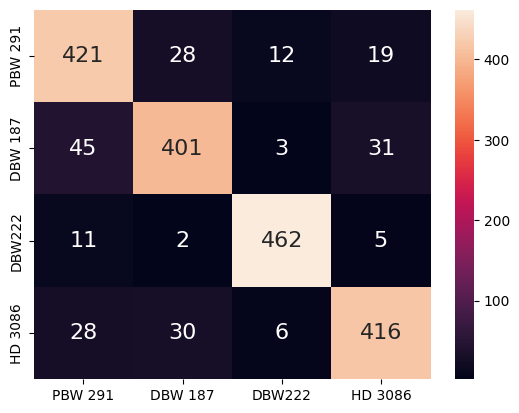

In [65]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()

In [66]:
last_epoch = 3000

In [67]:
tic = start_timer()
while start_epoch<=last_epoch:
    print("\nEpoch: ",start_epoch)
    history = model.fit(x_train ,y_train ,batch_size=BATCH_SIZE ,epochs=1, verbose=2, validation_data=(x_val, y_val), shuffle=True)
    model.save('./GNmodels/'+str(start_epoch)+model_name)
    print("Model saved on epoch: ",start_epoch)
    
    history_dataframe = pd.DataFrame.from_dict(history.history)
    save_to_csv('../csvs/'+model_name+'.csv', history_dataframe, header=True)
    print("added to csv")
    start_epoch+=1
    
toc = end_timer()
show_time(tic,toc)

Testing started

Epoch:  2001
768/768 - 32s - loss: 0.4837 - dense_4_loss: 0.2357 - dense_1_loss: 0.4817 - dense_3_loss: 0.3450 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8224 - dense_3_accuracy: 0.8726 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3259 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:27:56.269803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:27:56.278141: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:27:56.285836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2001GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2001GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2001
added to csv

Epoch:  2002
768/768 - 33s - loss: 0.4850 - dense_4_loss: 0.2378 - dense_1_loss: 0.4832 - dense_3_loss: 0.3407 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8747 - val_loss: 0.4699 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3258 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 11:28:49.869563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:28:49.878400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:28:49.886124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2002GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2002GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2002
added to csv

Epoch:  2003
768/768 - 32s - loss: 0.4841 - dense_4_loss: 0.2374 - dense_1_loss: 0.4825 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8747 - val_loss: 0.4700 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3258 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:29:43.355586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:29:43.364278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:29:43.372191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2003GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2003GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2003
added to csv

Epoch:  2004
768/768 - 33s - loss: 0.4848 - dense_4_loss: 0.2376 - dense_1_loss: 0.4805 - dense_3_loss: 0.3434 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8709 - val_loss: 0.4698 - val_dense_4_loss: 0.2370 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3257 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 11:30:37.999262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:30:38.008474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:30:38.016269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2004GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2004GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2004
added to csv

Epoch:  2005
768/768 - 33s - loss: 0.4845 - dense_4_loss: 0.2376 - dense_1_loss: 0.4867 - dense_3_loss: 0.3364 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8757 - val_loss: 0.4699 - val_dense_4_loss: 0.2371 - val_dense_1_loss: 0.4503 - val_dense_3_loss: 0.3258 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 11:31:31.581117: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:31:31.589733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:31:31.597496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2005GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2005GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2005
added to csv

Epoch:  2006
768/768 - 33s - loss: 0.4839 - dense_4_loss: 0.2369 - dense_1_loss: 0.4808 - dense_3_loss: 0.3426 - dense_4_accuracy: 0.9181 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8742 - val_loss: 0.4698 - val_dense_4_loss: 0.2370 - val_dense_1_loss: 0.4502 - val_dense_3_loss: 0.3257 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 11:32:26.256660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:32:26.265066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:32:26.272721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2006GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2006GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2006
added to csv

Epoch:  2007
768/768 - 32s - loss: 0.4840 - dense_4_loss: 0.2361 - dense_1_loss: 0.4848 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8716 - val_loss: 0.4700 - val_dense_4_loss: 0.2372 - val_dense_1_loss: 0.4502 - val_dense_3_loss: 0.3258 - val_dense_4_accuracy: 0.9206 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:33:19.570128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:33:19.578538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:33:19.586242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2007GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2007GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2007
added to csv

Epoch:  2008
768/768 - 32s - loss: 0.4888 - dense_4_loss: 0.2416 - dense_1_loss: 0.4815 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8719 - val_loss: 0.4697 - val_dense_4_loss: 0.2370 - val_dense_1_loss: 0.4502 - val_dense_3_loss: 0.3256 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:34:12.343110: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:34:12.351548: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:34:12.359211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2008GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2008GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2008
added to csv

Epoch:  2009
768/768 - 33s - loss: 0.4845 - dense_4_loss: 0.2400 - dense_1_loss: 0.4717 - dense_3_loss: 0.3434 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8245 - dense_3_accuracy: 0.8753 - val_loss: 0.4697 - val_dense_4_loss: 0.2370 - val_dense_1_loss: 0.4502 - val_dense_3_loss: 0.3256 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 11:35:06.761185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:35:06.769733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:35:06.777442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2009GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2009GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2009
added to csv

Epoch:  2010
768/768 - 33s - loss: 0.4866 - dense_4_loss: 0.2393 - dense_1_loss: 0.4824 - dense_3_loss: 0.3419 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8753 - val_loss: 0.4695 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4501 - val_dense_3_loss: 0.3255 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 11:36:00.662373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:36:00.672767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:36:00.680447: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2010GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2010GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2010
added to csv

Epoch:  2011
768/768 - 32s - loss: 0.4855 - dense_4_loss: 0.2380 - dense_1_loss: 0.4826 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8717 - val_loss: 0.4696 - val_dense_4_loss: 0.2369 - val_dense_1_loss: 0.4501 - val_dense_3_loss: 0.3255 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:36:53.404430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:36:53.413278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:36:53.421012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2011GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2011GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2011
added to csv

Epoch:  2012
768/768 - 32s - loss: 0.4863 - dense_4_loss: 0.2397 - dense_1_loss: 0.4776 - dense_3_loss: 0.3443 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8726 - val_loss: 0.4694 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3254 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:37:45.945209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:37:45.953744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:37:45.961381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2012GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2012GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2012
added to csv

Epoch:  2013
768/768 - 33s - loss: 0.4825 - dense_4_loss: 0.2364 - dense_1_loss: 0.4803 - dense_3_loss: 0.3401 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8748 - val_loss: 0.4695 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3255 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 42ms/step


2023-08-02 11:38:38.987122: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:38:38.995500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:38:39.003283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2013GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2013GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2013
added to csv

Epoch:  2014
768/768 - 32s - loss: 0.4861 - dense_4_loss: 0.2410 - dense_1_loss: 0.4802 - dense_3_loss: 0.3368 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8760 - val_loss: 0.4696 - val_dense_4_loss: 0.2369 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3255 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:39:31.011898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:39:31.020373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:39:31.028097: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2014GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2014GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2014
added to csv

Epoch:  2015
768/768 - 32s - loss: 0.4796 - dense_4_loss: 0.2353 - dense_1_loss: 0.4779 - dense_3_loss: 0.3365 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8739 - val_loss: 0.4695 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3255 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:40:24.999530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:40:25.010627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:40:25.018475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2015GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2015GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2015
added to csv

Epoch:  2016
768/768 - 32s - loss: 0.4792 - dense_4_loss: 0.2334 - dense_1_loss: 0.4810 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8752 - val_loss: 0.4694 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3254 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 41ms/step


2023-08-02 11:41:18.422905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:41:18.432198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:41:18.439853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2016GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2016GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2016
added to csv

Epoch:  2017
768/768 - 32s - loss: 0.4814 - dense_4_loss: 0.2343 - dense_1_loss: 0.4780 - dense_3_loss: 0.3457 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8242 - dense_3_accuracy: 0.8709 - val_loss: 0.4694 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3254 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 41ms/step


2023-08-02 11:42:10.432980: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:42:10.442922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:42:10.450656: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2017GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2017GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2017
added to csv

Epoch:  2018
768/768 - 31s - loss: 0.4876 - dense_4_loss: 0.2382 - dense_1_loss: 0.4883 - dense_3_loss: 0.3430 - dense_4_accuracy: 0.9173 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8727 - val_loss: 0.4694 - val_dense_4_loss: 0.2367 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3254 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8848 - 31s/epoch - 41ms/step


2023-08-02 11:43:03.867589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:43:03.878785: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:43:03.889839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2018GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2018GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2018
added to csv

Epoch:  2019
768/768 - 32s - loss: 0.4830 - dense_4_loss: 0.2382 - dense_1_loss: 0.4782 - dense_3_loss: 0.3379 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8765 - val_loss: 0.4694 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3254 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:43:57.451244: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:43:57.459572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:43:57.467256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2019GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2019GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2019
added to csv

Epoch:  2020
768/768 - 33s - loss: 0.4819 - dense_4_loss: 0.2357 - dense_1_loss: 0.4804 - dense_3_loss: 0.3405 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8730 - val_loss: 0.4695 - val_dense_4_loss: 0.2369 - val_dense_1_loss: 0.4500 - val_dense_3_loss: 0.3255 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 11:44:49.961192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:44:49.969981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:44:49.977781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2020GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2020GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2020
added to csv

Epoch:  2021
768/768 - 32s - loss: 0.4831 - dense_4_loss: 0.2393 - dense_1_loss: 0.4798 - dense_3_loss: 0.3331 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8799 - val_loss: 0.4694 - val_dense_4_loss: 0.2368 - val_dense_1_loss: 0.4499 - val_dense_3_loss: 0.3254 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 11:45:43.829326: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:45:43.837757: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:45:43.845628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2021GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2021GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2021
added to csv

Epoch:  2022
768/768 - 33s - loss: 0.4797 - dense_4_loss: 0.2341 - dense_1_loss: 0.4822 - dense_3_loss: 0.3366 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8729 - val_loss: 0.4692 - val_dense_4_loss: 0.2367 - val_dense_1_loss: 0.4499 - val_dense_3_loss: 0.3253 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 44ms/step


2023-08-02 11:46:38.151638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:46:38.160067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:46:38.167914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2022GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2022GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2022
added to csv

Epoch:  2023
768/768 - 32s - loss: 0.4863 - dense_4_loss: 0.2395 - dense_1_loss: 0.4799 - dense_3_loss: 0.3429 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8766 - val_loss: 0.4692 - val_dense_4_loss: 0.2366 - val_dense_1_loss: 0.4499 - val_dense_3_loss: 0.3253 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:47:32.481080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:47:32.489396: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:47:32.497171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2023GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2023GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2023
added to csv

Epoch:  2024
768/768 - 32s - loss: 0.4859 - dense_4_loss: 0.2399 - dense_1_loss: 0.4783 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8727 - val_loss: 0.4693 - val_dense_4_loss: 0.2367 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3253 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 11:48:24.311428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:48:24.320090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:48:24.327751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2024GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2024GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2024
added to csv

Epoch:  2025
768/768 - 32s - loss: 0.4889 - dense_4_loss: 0.2396 - dense_1_loss: 0.4898 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8730 - val_loss: 0.4691 - val_dense_4_loss: 0.2366 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:49:18.734427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:49:18.742927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:49:18.750827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2025GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2025GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2025
added to csv

Epoch:  2026
768/768 - 32s - loss: 0.4857 - dense_4_loss: 0.2384 - dense_1_loss: 0.4798 - dense_3_loss: 0.3443 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8244 - dense_3_accuracy: 0.8721 - val_loss: 0.4693 - val_dense_4_loss: 0.2367 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3253 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 11:50:12.023515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:50:12.032722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:50:12.044390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2026GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2026GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2026
added to csv

Epoch:  2027
768/768 - 32s - loss: 0.4840 - dense_4_loss: 0.2396 - dense_1_loss: 0.4761 - dense_3_loss: 0.3386 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8745 - val_loss: 0.4692 - val_dense_4_loss: 0.2367 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3253 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:51:04.889371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:51:04.897826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:51:04.905533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2027GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2027GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2027
added to csv

Epoch:  2028
768/768 - 32s - loss: 0.4861 - dense_4_loss: 0.2398 - dense_1_loss: 0.4816 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8740 - val_loss: 0.4691 - val_dense_4_loss: 0.2366 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:51:58.558747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:51:58.567310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:51:58.575293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2028GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2028GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2028
added to csv

Epoch:  2029
768/768 - 32s - loss: 0.4816 - dense_4_loss: 0.2378 - dense_1_loss: 0.4786 - dense_3_loss: 0.3343 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8242 - dense_3_accuracy: 0.8740 - val_loss: 0.4690 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 11:52:51.850093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:52:51.858523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:52:51.867041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2029GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2029GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2029
added to csv

Epoch:  2030
768/768 - 32s - loss: 0.4803 - dense_4_loss: 0.2346 - dense_1_loss: 0.4801 - dense_3_loss: 0.3388 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8768 - val_loss: 0.4690 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:53:44.379609: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:53:44.388010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:53:44.395790: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2030GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2030GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2030
added to csv

Epoch:  2031
768/768 - 32s - loss: 0.4817 - dense_4_loss: 0.2374 - dense_1_loss: 0.4798 - dense_3_loss: 0.3345 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8774 - val_loss: 0.4690 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3251 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 11:54:37.460325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:54:37.470031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:54:37.477930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2031GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2031GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2031
added to csv

Epoch:  2032
768/768 - 32s - loss: 0.4857 - dense_4_loss: 0.2378 - dense_1_loss: 0.4840 - dense_3_loss: 0.3424 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8706 - val_loss: 0.4690 - val_dense_4_loss: 0.2366 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 11:55:30.438260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:55:30.446499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:55:30.454150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2032GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2032GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2032
added to csv

Epoch:  2033
768/768 - 32s - loss: 0.4867 - dense_4_loss: 0.2388 - dense_1_loss: 0.4849 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8742 - val_loss: 0.4691 - val_dense_4_loss: 0.2366 - val_dense_1_loss: 0.4498 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:56:24.084581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:56:24.093340: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:56:24.101582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2033GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2033GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2033
added to csv

Epoch:  2034
768/768 - 32s - loss: 0.4877 - dense_4_loss: 0.2409 - dense_1_loss: 0.4815 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8734 - val_loss: 0.4689 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4497 - val_dense_3_loss: 0.3251 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 11:57:17.173545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:57:17.182201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:57:17.189901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2034GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2034GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2034
added to csv

Epoch:  2035
768/768 - 33s - loss: 0.4826 - dense_4_loss: 0.2358 - dense_1_loss: 0.4811 - dense_3_loss: 0.3416 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8172 - dense_3_accuracy: 0.8774 - val_loss: 0.4691 - val_dense_4_loss: 0.2366 - val_dense_1_loss: 0.4497 - val_dense_3_loss: 0.3252 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 11:58:11.280735: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:58:11.290114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:58:11.297960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2035GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2035GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2035
added to csv

Epoch:  2036
768/768 - 33s - loss: 0.4859 - dense_4_loss: 0.2396 - dense_1_loss: 0.4760 - dense_3_loss: 0.3452 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8735 - val_loss: 0.4692 - val_dense_4_loss: 0.2367 - val_dense_1_loss: 0.4497 - val_dense_3_loss: 0.3253 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 11:59:04.841749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:59:04.849941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:59:04.857640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11

INFO:tensorflow:Assets written to: ./GNmodels/2036GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2036GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2036
added to csv

Epoch:  2037
768/768 - 33s - loss: 0.4828 - dense_4_loss: 0.2372 - dense_1_loss: 0.4790 - dense_3_loss: 0.3396 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8753 - val_loss: 0.4690 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4497 - val_dense_3_loss: 0.3251 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 11:59:58.694208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:59:58.702861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 11:59:58.710642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2037GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2037GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2037
added to csv

Epoch:  2038
768/768 - 33s - loss: 0.4819 - dense_4_loss: 0.2365 - dense_1_loss: 0.4736 - dense_3_loss: 0.3441 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8687 - val_loss: 0.4689 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3251 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 12:00:52.100475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:00:52.109744: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:00:52.118183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2038GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2038GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2038
added to csv

Epoch:  2039
768/768 - 34s - loss: 0.4847 - dense_4_loss: 0.2390 - dense_1_loss: 0.4768 - dense_3_loss: 0.3420 - dense_4_accuracy: 0.9189 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8716 - val_loss: 0.4688 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3250 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 34s/epoch - 44ms/step


2023-08-02 12:01:47.989494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:01:47.998015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:01:48.006591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2039GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2039GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2039
added to csv

Epoch:  2040
768/768 - 33s - loss: 0.4844 - dense_4_loss: 0.2380 - dense_1_loss: 0.4827 - dense_3_loss: 0.3387 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8768 - val_loss: 0.4687 - val_dense_4_loss: 0.2363 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:02:42.043590: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:02:42.052488: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:02:42.060547: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2040GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2040GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2040
added to csv

Epoch:  2041
768/768 - 33s - loss: 0.4900 - dense_4_loss: 0.2398 - dense_1_loss: 0.4854 - dense_3_loss: 0.3484 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8148 - dense_3_accuracy: 0.8740 - val_loss: 0.4687 - val_dense_4_loss: 0.2363 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:03:35.916116: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:03:35.926249: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:03:35.933934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2041GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2041GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2041
added to csv

Epoch:  2042
768/768 - 32s - loss: 0.4810 - dense_4_loss: 0.2354 - dense_1_loss: 0.4769 - dense_3_loss: 0.3415 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8724 - val_loss: 0.4688 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3250 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:04:29.737243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:04:29.745525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:04:29.753285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2042GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2042GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2042
added to csv

Epoch:  2043
768/768 - 33s - loss: 0.4864 - dense_4_loss: 0.2408 - dense_1_loss: 0.4810 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9087 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8779 - val_loss: 0.4689 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3250 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:05:24.098631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:05:24.108465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:05:24.116335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2043GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2043GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2043
added to csv

Epoch:  2044
768/768 - 32s - loss: 0.4790 - dense_4_loss: 0.2353 - dense_1_loss: 0.4785 - dense_3_loss: 0.3340 - dense_4_accuracy: 0.9175 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8750 - val_loss: 0.4688 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4496 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:06:16.690941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:06:16.699313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:06:16.706966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2044GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2044GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2044
added to csv

Epoch:  2045
768/768 - 32s - loss: 0.4848 - dense_4_loss: 0.2365 - dense_1_loss: 0.4857 - dense_3_loss: 0.3420 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8750 - val_loss: 0.4686 - val_dense_4_loss: 0.2363 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3248 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:07:10.457527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:07:10.466074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:07:10.473817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2045GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2045GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2045
added to csv

Epoch:  2046
768/768 - 33s - loss: 0.4809 - dense_4_loss: 0.2351 - dense_1_loss: 0.4763 - dense_3_loss: 0.3430 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8727 - val_loss: 0.4687 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:08:04.609418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:08:04.618599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:08:04.627040: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2046GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2046GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2046
added to csv

Epoch:  2047
768/768 - 32s - loss: 0.4815 - dense_4_loss: 0.2362 - dense_1_loss: 0.4777 - dense_3_loss: 0.3398 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8224 - dense_3_accuracy: 0.8721 - val_loss: 0.4687 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:08:57.178214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:08:57.186685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:08:57.194469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2047GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2047GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2047
added to csv

Epoch:  2048
768/768 - 33s - loss: 0.4810 - dense_4_loss: 0.2354 - dense_1_loss: 0.4809 - dense_3_loss: 0.3380 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8802 - val_loss: 0.4687 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8848 - 33s/epoch - 43ms/step


2023-08-02 12:09:51.936529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:09:51.946863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:09:51.954665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2048GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2048GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2048
added to csv

Epoch:  2049
768/768 - 34s - loss: 0.4838 - dense_4_loss: 0.2384 - dense_1_loss: 0.4815 - dense_3_loss: 0.3363 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8734 - val_loss: 0.4686 - val_dense_4_loss: 0.2363 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8848 - 34s/epoch - 44ms/step


2023-08-02 12:10:47.358786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:10:47.367366: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:10:47.375239: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2049GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2049GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2049
added to csv

Epoch:  2050
768/768 - 33s - loss: 0.4787 - dense_4_loss: 0.2350 - dense_1_loss: 0.4741 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8745 - val_loss: 0.4687 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:11:40.715638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:11:40.724921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:11:40.735664: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2050GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2050GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2050
added to csv

Epoch:  2051
768/768 - 33s - loss: 0.4845 - dense_4_loss: 0.2367 - dense_1_loss: 0.4845 - dense_3_loss: 0.3414 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8732 - val_loss: 0.4687 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:12:34.911888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:12:34.920264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:12:34.928143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2051GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2051GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2051
added to csv

Epoch:  2052
768/768 - 32s - loss: 0.4881 - dense_4_loss: 0.2401 - dense_1_loss: 0.4832 - dense_3_loss: 0.3435 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8724 - val_loss: 0.4688 - val_dense_4_loss: 0.2365 - val_dense_1_loss: 0.4495 - val_dense_3_loss: 0.3250 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:13:28.198687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:13:28.207130: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:13:28.215042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2052GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2052GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2052
added to csv

Epoch:  2053
768/768 - 32s - loss: 0.4840 - dense_4_loss: 0.2392 - dense_1_loss: 0.4741 - dense_3_loss: 0.3420 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8758 - val_loss: 0.4687 - val_dense_4_loss: 0.2364 - val_dense_1_loss: 0.4494 - val_dense_3_loss: 0.3249 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:14:21.632271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:14:21.641428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:14:21.649183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2053GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2053GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2053
added to csv

Epoch:  2054
768/768 - 32s - loss: 0.4836 - dense_4_loss: 0.2366 - dense_1_loss: 0.4816 - dense_3_loss: 0.3418 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8743 - val_loss: 0.4685 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4494 - val_dense_3_loss: 0.3248 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:15:14.707185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:15:14.715632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:15:14.723237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2054GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2054GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2054
added to csv

Epoch:  2055
768/768 - 32s - loss: 0.4828 - dense_4_loss: 0.2354 - dense_1_loss: 0.4877 - dense_3_loss: 0.3369 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8768 - val_loss: 0.4685 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4494 - val_dense_3_loss: 0.3248 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:16:07.445201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:16:07.454344: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:16:07.462046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2055GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2055GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2055
added to csv

Epoch:  2056
768/768 - 33s - loss: 0.4815 - dense_4_loss: 0.2358 - dense_1_loss: 0.4769 - dense_3_loss: 0.3421 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8753 - val_loss: 0.4684 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3248 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:17:01.947361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:17:01.956075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:17:01.964092: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2056GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2056GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2056
added to csv

Epoch:  2057
768/768 - 32s - loss: 0.4839 - dense_4_loss: 0.2380 - dense_1_loss: 0.4774 - dense_3_loss: 0.3422 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8223 - dense_3_accuracy: 0.8765 - val_loss: 0.4684 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3247 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:17:55.886792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:17:55.895377: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:17:55.903134: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2057GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2057GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2057
added to csv

Epoch:  2058
768/768 - 33s - loss: 0.4846 - dense_4_loss: 0.2377 - dense_1_loss: 0.4836 - dense_3_loss: 0.3391 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8135 - dense_3_accuracy: 0.8743 - val_loss: 0.4683 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3246 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:18:49.233437: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:18:49.242192: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:18:49.249861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2058GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2058GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2058
added to csv

Epoch:  2059
768/768 - 32s - loss: 0.4869 - dense_4_loss: 0.2413 - dense_1_loss: 0.4822 - dense_3_loss: 0.3366 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8787 - val_loss: 0.4684 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3247 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:19:43.352072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:19:43.360276: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:19:43.367926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2059GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2059GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2059
added to csv

Epoch:  2060
768/768 - 33s - loss: 0.4891 - dense_4_loss: 0.2393 - dense_1_loss: 0.4849 - dense_3_loss: 0.3478 - dense_4_accuracy: 0.9098 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8695 - val_loss: 0.4684 - val_dense_4_loss: 0.2362 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3247 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:20:37.384472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:20:37.392854: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:20:37.400599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2060GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2060GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2060
added to csv

Epoch:  2061
768/768 - 32s - loss: 0.4850 - dense_4_loss: 0.2380 - dense_1_loss: 0.4807 - dense_3_loss: 0.3428 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8729 - val_loss: 0.4684 - val_dense_4_loss: 0.2363 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3247 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:21:30.182281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:21:30.190560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:21:30.198338: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2061GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2061GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2061
added to csv

Epoch:  2062
768/768 - 32s - loss: 0.4852 - dense_4_loss: 0.2405 - dense_1_loss: 0.4754 - dense_3_loss: 0.3404 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8244 - dense_3_accuracy: 0.8770 - val_loss: 0.4683 - val_dense_4_loss: 0.2361 - val_dense_1_loss: 0.4493 - val_dense_3_loss: 0.3246 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:22:23.048885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:22:23.059228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:22:23.067021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2062GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2062GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2062
added to csv

Epoch:  2063
768/768 - 32s - loss: 0.4837 - dense_4_loss: 0.2379 - dense_1_loss: 0.4806 - dense_3_loss: 0.3385 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8757 - val_loss: 0.4682 - val_dense_4_loss: 0.2361 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3246 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:23:16.754155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:23:16.764248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:23:16.771968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2063GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2063GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2063
added to csv

Epoch:  2064
768/768 - 33s - loss: 0.4791 - dense_4_loss: 0.2335 - dense_1_loss: 0.4793 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8765 - val_loss: 0.4683 - val_dense_4_loss: 0.2361 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3246 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:24:10.551169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:24:10.560124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:24:10.567835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2064GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2064GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2064
added to csv

Epoch:  2065
768/768 - 32s - loss: 0.4835 - dense_4_loss: 0.2375 - dense_1_loss: 0.4761 - dense_3_loss: 0.3440 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8276 - dense_3_accuracy: 0.8683 - val_loss: 0.4682 - val_dense_4_loss: 0.2361 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3246 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:25:03.973856: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:25:03.983660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:25:03.991418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2065GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2065GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2065
added to csv

Epoch:  2066
768/768 - 32s - loss: 0.4840 - dense_4_loss: 0.2375 - dense_1_loss: 0.4787 - dense_3_loss: 0.3429 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8237 - dense_3_accuracy: 0.8750 - val_loss: 0.4682 - val_dense_4_loss: 0.2361 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3245 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:25:57.019293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:25:57.029696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:25:57.037639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2066GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2066GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2066
added to csv

Epoch:  2067
768/768 - 32s - loss: 0.4828 - dense_4_loss: 0.2376 - dense_1_loss: 0.4767 - dense_3_loss: 0.3406 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8244 - dense_3_accuracy: 0.8732 - val_loss: 0.4681 - val_dense_4_loss: 0.2360 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3245 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:26:50.218984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:26:50.227618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:26:50.235374: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2067GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2067GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2067
added to csv

Epoch:  2068
768/768 - 32s - loss: 0.4867 - dense_4_loss: 0.2404 - dense_1_loss: 0.4819 - dense_3_loss: 0.3392 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8755 - val_loss: 0.4681 - val_dense_4_loss: 0.2360 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3245 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:27:43.034700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:27:43.044861: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:27:43.052771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2068GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2068GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2068
added to csv

Epoch:  2069
768/768 - 33s - loss: 0.4806 - dense_4_loss: 0.2363 - dense_1_loss: 0.4765 - dense_3_loss: 0.3378 - dense_4_accuracy: 0.9168 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8743 - val_loss: 0.4681 - val_dense_4_loss: 0.2360 - val_dense_1_loss: 0.4492 - val_dense_3_loss: 0.3245 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:28:37.095153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:28:37.103913: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:28:37.111931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2069GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2069GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2069
added to csv

Epoch:  2070
768/768 - 32s - loss: 0.4768 - dense_4_loss: 0.2343 - dense_1_loss: 0.4709 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9178 - dense_1_accuracy: 0.8242 - dense_3_accuracy: 0.8755 - val_loss: 0.4680 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4491 - val_dense_3_loss: 0.3244 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:29:31.417228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:29:31.427438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:29:31.435139: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2070GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2070GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2070
added to csv

Epoch:  2071
768/768 - 33s - loss: 0.4827 - dense_4_loss: 0.2369 - dense_1_loss: 0.4815 - dense_3_loss: 0.3378 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8740 - val_loss: 0.4679 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4491 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:30:25.159341: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:30:25.168333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:30:25.175981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2071GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2071GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2071
added to csv

Epoch:  2072
768/768 - 33s - loss: 0.4798 - dense_4_loss: 0.2340 - dense_1_loss: 0.4812 - dense_3_loss: 0.3382 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8740 - val_loss: 0.4680 - val_dense_4_loss: 0.2360 - val_dense_1_loss: 0.4491 - val_dense_3_loss: 0.3244 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:31:19.746179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:31:19.756887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:31:19.765964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2072GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2072GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2072
added to csv

Epoch:  2073
768/768 - 32s - loss: 0.4812 - dense_4_loss: 0.2346 - dense_1_loss: 0.4780 - dense_3_loss: 0.3442 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8734 - val_loss: 0.4679 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:32:12.793680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:32:12.802370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:32:12.810151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2073GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2073GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2073
added to csv

Epoch:  2074
768/768 - 33s - loss: 0.4836 - dense_4_loss: 0.2358 - dense_1_loss: 0.4857 - dense_3_loss: 0.3402 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8753 - val_loss: 0.4679 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4491 - val_dense_3_loss: 0.3244 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 12:33:05.818145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:33:05.826722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:33:05.834479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2074GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2074GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2074
added to csv

Epoch:  2075
768/768 - 32s - loss: 0.4830 - dense_4_loss: 0.2357 - dense_1_loss: 0.4777 - dense_3_loss: 0.3467 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8703 - val_loss: 0.4680 - val_dense_4_loss: 0.2360 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3244 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:33:59.409164: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:33:59.417298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:33:59.424886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2075GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2075GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2075
added to csv

Epoch:  2076
768/768 - 32s - loss: 0.4806 - dense_4_loss: 0.2370 - dense_1_loss: 0.4753 - dense_3_loss: 0.3364 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8755 - val_loss: 0.4680 - val_dense_4_loss: 0.2360 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3244 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:34:52.051331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:34:52.059843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:34:52.067662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2076GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2076GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2076
added to csv

Epoch:  2077
768/768 - 31s - loss: 0.4833 - dense_4_loss: 0.2374 - dense_1_loss: 0.4797 - dense_3_loss: 0.3400 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8734 - val_loss: 0.4678 - val_dense_4_loss: 0.2358 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 12:35:44.515115: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:35:44.523108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:35:44.530824: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2077GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2077GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2077
added to csv

Epoch:  2078
768/768 - 33s - loss: 0.4856 - dense_4_loss: 0.2365 - dense_1_loss: 0.4854 - dense_3_loss: 0.3451 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8726 - val_loss: 0.4679 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3244 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:36:38.260304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:36:38.270720: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:36:38.278450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2078GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2078GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2078
added to csv

Epoch:  2079
768/768 - 32s - loss: 0.4809 - dense_4_loss: 0.2349 - dense_1_loss: 0.4772 - dense_3_loss: 0.3426 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8713 - val_loss: 0.4678 - val_dense_4_loss: 0.2358 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:37:32.547429: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:37:32.555827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:37:32.563702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2079GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2079GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2079
added to csv

Epoch:  2080
768/768 - 33s - loss: 0.4845 - dense_4_loss: 0.2384 - dense_1_loss: 0.4795 - dense_3_loss: 0.3407 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8745 - val_loss: 0.4679 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:38:26.558919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:38:26.567319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:38:26.575857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2080GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2080GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2080
added to csv

Epoch:  2081
768/768 - 33s - loss: 0.4870 - dense_4_loss: 0.2387 - dense_1_loss: 0.4853 - dense_3_loss: 0.3425 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8154 - dense_3_accuracy: 0.8722 - val_loss: 0.4678 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4490 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 12:39:20.374282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:39:20.383055: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:39:20.391008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2081GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2081GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2081
added to csv

Epoch:  2082
768/768 - 32s - loss: 0.4814 - dense_4_loss: 0.2347 - dense_1_loss: 0.4811 - dense_3_loss: 0.3412 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8737 - val_loss: 0.4678 - val_dense_4_loss: 0.2358 - val_dense_1_loss: 0.4489 - val_dense_3_loss: 0.3242 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:40:13.468182: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:40:13.476650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:40:13.484572: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2082GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2082GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2082
added to csv

Epoch:  2083
768/768 - 31s - loss: 0.4846 - dense_4_loss: 0.2398 - dense_1_loss: 0.4787 - dense_3_loss: 0.3373 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8747 - val_loss: 0.4679 - val_dense_4_loss: 0.2359 - val_dense_1_loss: 0.4489 - val_dense_3_loss: 0.3243 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 12:41:06.106367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:41:06.114751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:41:06.123421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2083GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2083GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2083
added to csv

Epoch:  2084
768/768 - 32s - loss: 0.4813 - dense_4_loss: 0.2355 - dense_1_loss: 0.4749 - dense_3_loss: 0.3445 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8745 - val_loss: 0.4676 - val_dense_4_loss: 0.2357 - val_dense_1_loss: 0.4489 - val_dense_3_loss: 0.3241 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:41:59.199179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:41:59.207799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:41:59.215700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2084GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2084GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2084
added to csv

Epoch:  2085
768/768 - 32s - loss: 0.4843 - dense_4_loss: 0.2365 - dense_1_loss: 0.4824 - dense_3_loss: 0.3437 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8722 - val_loss: 0.4675 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4488 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:42:53.013710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:42:53.021948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:42:53.029793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2085GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2085GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2085
added to csv

Epoch:  2086
768/768 - 32s - loss: 0.4797 - dense_4_loss: 0.2339 - dense_1_loss: 0.4782 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9199 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8724 - val_loss: 0.4675 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4488 - val_dense_3_loss: 0.3241 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8848 - 32s/epoch - 42ms/step


2023-08-02 12:43:46.098380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:43:46.106766: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:43:46.114546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2086GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2086GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2086
added to csv

Epoch:  2087
768/768 - 32s - loss: 0.4774 - dense_4_loss: 0.2342 - dense_1_loss: 0.4721 - dense_3_loss: 0.3387 - dense_4_accuracy: 0.9180 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8778 - val_loss: 0.4675 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4488 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:44:39.030057: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:44:39.039048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:44:39.047288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2087GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2087GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2087
added to csv

Epoch:  2088
768/768 - 32s - loss: 0.4841 - dense_4_loss: 0.2380 - dense_1_loss: 0.4798 - dense_3_loss: 0.3408 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8730 - val_loss: 0.4675 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4488 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:45:30.659314: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:45:30.668159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:45:30.675760: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2088GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2088GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2088
added to csv

Epoch:  2089
768/768 - 33s - loss: 0.4788 - dense_4_loss: 0.2331 - dense_1_loss: 0.4816 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8776 - val_loss: 0.4675 - val_dense_4_loss: 0.2357 - val_dense_1_loss: 0.4488 - val_dense_3_loss: 0.3241 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:46:25.008339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:46:25.016652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:46:25.024418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2089GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2089GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2089
added to csv

Epoch:  2090
768/768 - 32s - loss: 0.4808 - dense_4_loss: 0.2375 - dense_1_loss: 0.4783 - dense_3_loss: 0.3326 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8805 - val_loss: 0.4677 - val_dense_4_loss: 0.2358 - val_dense_1_loss: 0.4488 - val_dense_3_loss: 0.3241 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:47:18.493849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:47:18.502075: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:47:18.509817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2090GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2090GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2090
added to csv

Epoch:  2091
768/768 - 32s - loss: 0.4827 - dense_4_loss: 0.2352 - dense_1_loss: 0.4824 - dense_3_loss: 0.3427 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8773 - val_loss: 0.4674 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:48:12.314382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:48:12.322958: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:48:12.330696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2091GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2091GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2091
added to csv

Epoch:  2092
768/768 - 32s - loss: 0.4833 - dense_4_loss: 0.2378 - dense_1_loss: 0.4782 - dense_3_loss: 0.3404 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8763 - val_loss: 0.4675 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:49:05.054489: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:49:05.062968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:49:05.070648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2092GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2092GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2092
added to csv

Epoch:  2093
768/768 - 33s - loss: 0.4815 - dense_4_loss: 0.2349 - dense_1_loss: 0.4766 - dense_3_loss: 0.3453 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8726 - val_loss: 0.4675 - val_dense_4_loss: 0.2357 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:49:59.621237: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:49:59.629717: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:49:59.638295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2093GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2093GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2093
added to csv

Epoch:  2094
768/768 - 32s - loss: 0.4823 - dense_4_loss: 0.2355 - dense_1_loss: 0.4805 - dense_3_loss: 0.3424 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8747 - val_loss: 0.4674 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3239 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:50:53.017792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:50:53.026334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:50:53.034147: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2094GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2094GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2094
added to csv

Epoch:  2095
768/768 - 32s - loss: 0.4829 - dense_4_loss: 0.2338 - dense_1_loss: 0.4846 - dense_3_loss: 0.3460 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8732 - val_loss: 0.4673 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3239 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8301 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:51:45.329941: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:51:45.338707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:51:45.346274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2095GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2095GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2095
added to csv

Epoch:  2096
768/768 - 32s - loss: 0.4790 - dense_4_loss: 0.2322 - dense_1_loss: 0.4805 - dense_3_loss: 0.3421 - dense_4_accuracy: 0.9188 - dense_1_accuracy: 0.8182 - dense_3_accuracy: 0.8747 - val_loss: 0.4672 - val_dense_4_loss: 0.2355 - val_dense_1_loss: 0.4486 - val_dense_3_loss: 0.3238 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:52:39.349459: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:52:39.357753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:52:39.365406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2096GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2096GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2096
added to csv

Epoch:  2097
768/768 - 33s - loss: 0.4849 - dense_4_loss: 0.2387 - dense_1_loss: 0.4813 - dense_3_loss: 0.3396 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8721 - val_loss: 0.4674 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4486 - val_dense_3_loss: 0.3239 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 12:53:31.458286: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:53:31.466723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:53:31.474464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2097GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2097GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2097
added to csv

Epoch:  2098
768/768 - 31s - loss: 0.4854 - dense_4_loss: 0.2397 - dense_1_loss: 0.4843 - dense_3_loss: 0.3347 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8787 - val_loss: 0.4674 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 12:54:23.903659: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:54:23.912089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:54:23.921988: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2098GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2098GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2098
added to csv

Epoch:  2099
768/768 - 32s - loss: 0.4820 - dense_4_loss: 0.2359 - dense_1_loss: 0.4788 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8752 - val_loss: 0.4675 - val_dense_4_loss: 0.2357 - val_dense_1_loss: 0.4487 - val_dense_3_loss: 0.3240 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 12:55:17.218050: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:55:17.226605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:55:17.234565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2099GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2099GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2099
added to csv

Epoch:  2100
768/768 - 32s - loss: 0.4824 - dense_4_loss: 0.2370 - dense_1_loss: 0.4810 - dense_3_loss: 0.3371 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8766 - val_loss: 0.4674 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4486 - val_dense_3_loss: 0.3239 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:56:10.392210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:56:10.401840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:56:10.409564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2100GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2100
added to csv

Epoch:  2101
768/768 - 33s - loss: 0.4825 - dense_4_loss: 0.2363 - dense_1_loss: 0.4816 - dense_3_loss: 0.3391 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8188 - dense_3_accuracy: 0.8747 - val_loss: 0.4673 - val_dense_4_loss: 0.2356 - val_dense_1_loss: 0.4486 - val_dense_3_loss: 0.3239 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 12:57:04.640054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:57:04.648658: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:57:04.656629: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2101GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2101
added to csv

Epoch:  2102
768/768 - 33s - loss: 0.4787 - dense_4_loss: 0.2337 - dense_1_loss: 0.4774 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8770 - val_loss: 0.4672 - val_dense_4_loss: 0.2355 - val_dense_1_loss: 0.4486 - val_dense_3_loss: 0.3238 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:57:58.321378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:57:58.330706: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:57:58.339146: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2102GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2102
added to csv

Epoch:  2103
768/768 - 32s - loss: 0.4858 - dense_4_loss: 0.2418 - dense_1_loss: 0.4768 - dense_3_loss: 0.3366 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8747 - val_loss: 0.4671 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4485 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 12:58:51.290052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:58:51.298530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:58:51.306168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2103GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2103
added to csv

Epoch:  2104
768/768 - 33s - loss: 0.4859 - dense_4_loss: 0.2384 - dense_1_loss: 0.4791 - dense_3_loss: 0.3459 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8696 - val_loss: 0.4670 - val_dense_4_loss: 0.2353 - val_dense_1_loss: 0.4485 - val_dense_3_loss: 0.3236 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 12:59:45.101593: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:59:45.110317: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12:59:45.118079: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 12

INFO:tensorflow:Assets written to: ./GNmodels/2104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2104GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2104
added to csv

Epoch:  2105
768/768 - 32s - loss: 0.4855 - dense_4_loss: 0.2385 - dense_1_loss: 0.4792 - dense_3_loss: 0.3441 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8743 - val_loss: 0.4670 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4485 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 13:00:37.703395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:00:37.712381: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:00:37.720132: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2105GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2105
added to csv

Epoch:  2106
768/768 - 33s - loss: 0.4778 - dense_4_loss: 0.2331 - dense_1_loss: 0.4755 - dense_3_loss: 0.3401 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8713 - val_loss: 0.4671 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4485 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:01:30.972727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:01:30.981221: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:01:30.988904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2106GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2106
added to csv

Epoch:  2107
768/768 - 32s - loss: 0.4838 - dense_4_loss: 0.2377 - dense_1_loss: 0.4809 - dense_3_loss: 0.3393 - dense_4_accuracy: 0.9108 - dense_1_accuracy: 0.8146 - dense_3_accuracy: 0.8755 - val_loss: 0.4671 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4485 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:02:24.317284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:02:24.325767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:02:24.333529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2107GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2107
added to csv

Epoch:  2108
768/768 - 31s - loss: 0.4822 - dense_4_loss: 0.2362 - dense_1_loss: 0.4823 - dense_3_loss: 0.3377 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8740 - val_loss: 0.4670 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4485 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 13:03:16.027859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:03:16.036125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:03:16.043772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2108GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2108
added to csv

Epoch:  2109
768/768 - 32s - loss: 0.4809 - dense_4_loss: 0.2373 - dense_1_loss: 0.4780 - dense_3_loss: 0.3340 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8789 - val_loss: 0.4669 - val_dense_4_loss: 0.2353 - val_dense_1_loss: 0.4484 - val_dense_3_loss: 0.3236 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:04:09.350078: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:04:09.358539: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:04:09.366240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2109GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2109
added to csv

Epoch:  2110
768/768 - 33s - loss: 0.4817 - dense_4_loss: 0.2359 - dense_1_loss: 0.4810 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8760 - val_loss: 0.4669 - val_dense_4_loss: 0.2353 - val_dense_1_loss: 0.4484 - val_dense_3_loss: 0.3236 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 13:05:03.499048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:05:03.508259: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:05:03.515899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2110GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2110
added to csv

Epoch:  2111
768/768 - 32s - loss: 0.4810 - dense_4_loss: 0.2364 - dense_1_loss: 0.4779 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8247 - dense_3_accuracy: 0.8748 - val_loss: 0.4667 - val_dense_4_loss: 0.2351 - val_dense_1_loss: 0.4484 - val_dense_3_loss: 0.3234 - val_dense_4_accuracy: 0.9212 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 13:05:57.328387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:05:57.337090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:05:57.344739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2111GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2111
added to csv

Epoch:  2112
768/768 - 32s - loss: 0.4860 - dense_4_loss: 0.2407 - dense_1_loss: 0.4785 - dense_3_loss: 0.3393 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8298 - dense_3_accuracy: 0.8774 - val_loss: 0.4669 - val_dense_4_loss: 0.2353 - val_dense_1_loss: 0.4484 - val_dense_3_loss: 0.3236 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:06:49.767718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:06:49.776183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:06:49.783837: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2112GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2112
added to csv

Epoch:  2113
768/768 - 32s - loss: 0.4826 - dense_4_loss: 0.2367 - dense_1_loss: 0.4749 - dense_3_loss: 0.3446 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8247 - dense_3_accuracy: 0.8730 - val_loss: 0.4670 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4484 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:07:42.768236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:07:42.776657: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:07:42.784361: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2113GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2113
added to csv

Epoch:  2114
768/768 - 33s - loss: 0.4827 - dense_4_loss: 0.2376 - dense_1_loss: 0.4774 - dense_3_loss: 0.3396 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8745 - val_loss: 0.4670 - val_dense_4_loss: 0.2354 - val_dense_1_loss: 0.4484 - val_dense_3_loss: 0.3237 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:08:36.878022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:08:36.887791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:08:36.895674: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2114GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2114
added to csv

Epoch:  2115
768/768 - 32s - loss: 0.4784 - dense_4_loss: 0.2347 - dense_1_loss: 0.4719 - dense_3_loss: 0.3407 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8257 - dense_3_accuracy: 0.8735 - val_loss: 0.4667 - val_dense_4_loss: 0.2352 - val_dense_1_loss: 0.4483 - val_dense_3_loss: 0.3235 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:09:29.805114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:09:29.813756: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:09:29.821684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2115GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2115
added to csv

Epoch:  2116
768/768 - 33s - loss: 0.4794 - dense_4_loss: 0.2337 - dense_1_loss: 0.4816 - dense_3_loss: 0.3372 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8761 - val_loss: 0.4668 - val_dense_4_loss: 0.2352 - val_dense_1_loss: 0.4483 - val_dense_3_loss: 0.3235 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:10:24.752522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:10:24.761413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:10:24.769617: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2116GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2116
added to csv

Epoch:  2117
768/768 - 32s - loss: 0.4841 - dense_4_loss: 0.2389 - dense_1_loss: 0.4778 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8787 - val_loss: 0.4669 - val_dense_4_loss: 0.2353 - val_dense_1_loss: 0.4483 - val_dense_3_loss: 0.3236 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:11:19.428264: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:11:19.437093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:11:19.444887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2117GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2117
added to csv

Epoch:  2118
768/768 - 32s - loss: 0.4809 - dense_4_loss: 0.2373 - dense_1_loss: 0.4759 - dense_3_loss: 0.3362 - dense_4_accuracy: 0.9115 - dense_1_accuracy: 0.8229 - dense_3_accuracy: 0.8794 - val_loss: 0.4668 - val_dense_4_loss: 0.2352 - val_dense_1_loss: 0.4483 - val_dense_3_loss: 0.3236 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:12:12.098529: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:12:12.107027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:12:12.114769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2118GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2118
added to csv

Epoch:  2119
768/768 - 32s - loss: 0.4791 - dense_4_loss: 0.2351 - dense_1_loss: 0.4754 - dense_3_loss: 0.3376 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8229 - dense_3_accuracy: 0.8734 - val_loss: 0.4667 - val_dense_4_loss: 0.2352 - val_dense_1_loss: 0.4483 - val_dense_3_loss: 0.3235 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:13:05.990014: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:13:05.998382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:13:06.006961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2119GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2119
added to csv

Epoch:  2120
768/768 - 33s - loss: 0.4784 - dense_4_loss: 0.2344 - dense_1_loss: 0.4747 - dense_3_loss: 0.3386 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8737 - val_loss: 0.4668 - val_dense_4_loss: 0.2353 - val_dense_1_loss: 0.4483 - val_dense_3_loss: 0.3235 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:14:00.353841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:14:00.362508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:14:00.370442: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2120GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2120
added to csv

Epoch:  2121
768/768 - 33s - loss: 0.4808 - dense_4_loss: 0.2357 - dense_1_loss: 0.4786 - dense_3_loss: 0.3385 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8794 - val_loss: 0.4665 - val_dense_4_loss: 0.2351 - val_dense_1_loss: 0.4482 - val_dense_3_loss: 0.3234 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 13:14:52.983494: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:14:52.991841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:14:52.999483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2121GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2121
added to csv

Epoch:  2122
768/768 - 33s - loss: 0.4797 - dense_4_loss: 0.2361 - dense_1_loss: 0.4782 - dense_3_loss: 0.3340 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8787 - val_loss: 0.4665 - val_dense_4_loss: 0.2351 - val_dense_1_loss: 0.4482 - val_dense_3_loss: 0.3233 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:15:47.598741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:15:47.607812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:15:47.616077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2122GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2122
added to csv

Epoch:  2123
768/768 - 32s - loss: 0.4803 - dense_4_loss: 0.2353 - dense_1_loss: 0.4770 - dense_3_loss: 0.3395 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8742 - val_loss: 0.4666 - val_dense_4_loss: 0.2351 - val_dense_1_loss: 0.4482 - val_dense_3_loss: 0.3233 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:16:40.022842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:16:40.031536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:16:40.039332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2123GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2123
added to csv

Epoch:  2124
768/768 - 34s - loss: 0.4811 - dense_4_loss: 0.2366 - dense_1_loss: 0.4726 - dense_3_loss: 0.3423 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8687 - val_loss: 0.4666 - val_dense_4_loss: 0.2351 - val_dense_1_loss: 0.4482 - val_dense_3_loss: 0.3234 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 34s/epoch - 44ms/step


2023-08-02 13:17:35.403136: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:17:35.411555: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:17:35.419428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2124GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2124
added to csv

Epoch:  2125
768/768 - 32s - loss: 0.4871 - dense_4_loss: 0.2405 - dense_1_loss: 0.4822 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8747 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4482 - val_dense_3_loss: 0.3233 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:18:27.622430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:18:27.630708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:18:27.638387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2125GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2125
added to csv

Epoch:  2126
768/768 - 33s - loss: 0.4836 - dense_4_loss: 0.2366 - dense_1_loss: 0.4820 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8729 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4481 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:19:20.056038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:19:20.065007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:19:20.072807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2126GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2126
added to csv

Epoch:  2127
768/768 - 32s - loss: 0.4817 - dense_4_loss: 0.2372 - dense_1_loss: 0.4747 - dense_3_loss: 0.3403 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8770 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4481 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:20:12.837271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:20:12.845784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:20:12.853504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2127GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2127
added to csv

Epoch:  2128
768/768 - 33s - loss: 0.4835 - dense_4_loss: 0.2373 - dense_1_loss: 0.4798 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8257 - dense_3_accuracy: 0.8721 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4481 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:21:08.119871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:21:08.128325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:21:08.136016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2128GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2128
added to csv

Epoch:  2129
768/768 - 32s - loss: 0.4799 - dense_4_loss: 0.2333 - dense_1_loss: 0.4827 - dense_3_loss: 0.3393 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8153 - dense_3_accuracy: 0.8791 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4481 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:22:00.936908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:22:00.945551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:22:00.953537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2129GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2129
added to csv

Epoch:  2130
768/768 - 33s - loss: 0.4797 - dense_4_loss: 0.2360 - dense_1_loss: 0.4732 - dense_3_loss: 0.3391 - dense_4_accuracy: 0.9132 - dense_1_accuracy: 0.8271 - dense_3_accuracy: 0.8758 - val_loss: 0.4665 - val_dense_4_loss: 0.2351 - val_dense_1_loss: 0.4481 - val_dense_3_loss: 0.3233 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:22:55.318279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:22:55.326689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:22:55.334493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2130GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2130
added to csv

Epoch:  2131
768/768 - 31s - loss: 0.4793 - dense_4_loss: 0.2335 - dense_1_loss: 0.4766 - dense_3_loss: 0.3428 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8236 - dense_3_accuracy: 0.8734 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4481 - val_dense_3_loss: 0.3233 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 13:23:47.548072: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:23:47.556595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:23:47.564282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2131GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2131
added to csv

Epoch:  2132
768/768 - 32s - loss: 0.4797 - dense_4_loss: 0.2353 - dense_1_loss: 0.4775 - dense_3_loss: 0.3371 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8247 - dense_3_accuracy: 0.8750 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 13:24:39.977390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:24:39.985994: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:24:39.995140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2132GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2132
added to csv

Epoch:  2133
768/768 - 32s - loss: 0.4846 - dense_4_loss: 0.2389 - dense_1_loss: 0.4827 - dense_3_loss: 0.3363 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8794 - val_loss: 0.4663 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:25:33.196635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:25:33.206119: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:25:33.214065: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2133GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2133
added to csv

Epoch:  2134
768/768 - 33s - loss: 0.4808 - dense_4_loss: 0.2358 - dense_1_loss: 0.4764 - dense_3_loss: 0.3402 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8719 - val_loss: 0.4664 - val_dense_4_loss: 0.2350 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3232 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:26:27.419698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:26:27.428029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:26:27.435740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2134GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2134
added to csv

Epoch:  2135
768/768 - 32s - loss: 0.4800 - dense_4_loss: 0.2364 - dense_1_loss: 0.4778 - dense_3_loss: 0.3345 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8778 - val_loss: 0.4662 - val_dense_4_loss: 0.2349 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3231 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:27:20.216637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:27:20.225162: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:27:20.232883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2135GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2135
added to csv

Epoch:  2136
768/768 - 33s - loss: 0.4843 - dense_4_loss: 0.2389 - dense_1_loss: 0.4805 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8776 - val_loss: 0.4661 - val_dense_4_loss: 0.2348 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3230 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 13:28:14.600284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:28:14.608851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:28:14.616538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2136GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2136
added to csv

Epoch:  2137
768/768 - 33s - loss: 0.4833 - dense_4_loss: 0.2364 - dense_1_loss: 0.4796 - dense_3_loss: 0.3435 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8708 - val_loss: 0.4661 - val_dense_4_loss: 0.2348 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3230 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:29:08.805414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:29:08.813908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:29:08.821602: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2137GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2137
added to csv

Epoch:  2138
768/768 - 33s - loss: 0.4803 - dense_4_loss: 0.2345 - dense_1_loss: 0.4782 - dense_3_loss: 0.3409 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8727 - val_loss: 0.4662 - val_dense_4_loss: 0.2349 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3231 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 13:30:01.697251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:30:01.705742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:30:01.713408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2138GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2138
added to csv

Epoch:  2139
768/768 - 33s - loss: 0.4828 - dense_4_loss: 0.2374 - dense_1_loss: 0.4800 - dense_3_loss: 0.3380 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8792 - val_loss: 0.4662 - val_dense_4_loss: 0.2349 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3231 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:30:56.780660: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:30:56.789106: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:30:56.797621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2139GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2139
added to csv

Epoch:  2140
768/768 - 32s - loss: 0.4827 - dense_4_loss: 0.2332 - dense_1_loss: 0.4831 - dense_3_loss: 0.3486 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8700 - val_loss: 0.4662 - val_dense_4_loss: 0.2349 - val_dense_1_loss: 0.4480 - val_dense_3_loss: 0.3231 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:31:50.376730: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:31:50.384944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:31:50.392654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2140GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2140
added to csv

Epoch:  2141
768/768 - 33s - loss: 0.4773 - dense_4_loss: 0.2342 - dense_1_loss: 0.4732 - dense_3_loss: 0.3369 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8750 - val_loss: 0.4660 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3229 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:32:44.010059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:32:44.018595: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:32:44.026208: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2141GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2141
added to csv

Epoch:  2142
768/768 - 32s - loss: 0.4799 - dense_4_loss: 0.2355 - dense_1_loss: 0.4756 - dense_3_loss: 0.3391 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8223 - dense_3_accuracy: 0.8774 - val_loss: 0.4660 - val_dense_4_loss: 0.2348 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3229 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:33:37.922036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:33:37.930731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:33:37.939452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2142GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2142
added to csv

Epoch:  2143
768/768 - 32s - loss: 0.4791 - dense_4_loss: 0.2351 - dense_1_loss: 0.4745 - dense_3_loss: 0.3388 - dense_4_accuracy: 0.9136 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8783 - val_loss: 0.4661 - val_dense_4_loss: 0.2349 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3230 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:34:30.687242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:34:30.696218: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:34:30.704000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2143GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2143
added to csv

Epoch:  2144
768/768 - 33s - loss: 0.4786 - dense_4_loss: 0.2336 - dense_1_loss: 0.4766 - dense_3_loss: 0.3402 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8752 - val_loss: 0.4659 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3229 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:35:24.817866: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:35:24.826864: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:35:24.835272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2144GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2144
added to csv

Epoch:  2145
768/768 - 32s - loss: 0.4849 - dense_4_loss: 0.2388 - dense_1_loss: 0.4810 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8208 - dense_3_accuracy: 0.8732 - val_loss: 0.4660 - val_dense_4_loss: 0.2348 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3230 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:36:18.003463: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:36:18.012458: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:36:18.020107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2145GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2145
added to csv

Epoch:  2146
768/768 - 32s - loss: 0.4801 - dense_4_loss: 0.2349 - dense_1_loss: 0.4799 - dense_3_loss: 0.3376 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8800 - val_loss: 0.4659 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3229 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 13:37:10.944143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:37:10.952448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:37:10.960135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2146GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2146
added to csv

Epoch:  2147
768/768 - 33s - loss: 0.4847 - dense_4_loss: 0.2390 - dense_1_loss: 0.4787 - dense_3_loss: 0.3402 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8735 - val_loss: 0.4661 - val_dense_4_loss: 0.2348 - val_dense_1_loss: 0.4479 - val_dense_3_loss: 0.3230 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:38:03.781118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:38:03.790233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:38:03.799923: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2147GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2147
added to csv

Epoch:  2148
768/768 - 33s - loss: 0.4743 - dense_4_loss: 0.2318 - dense_1_loss: 0.4714 - dense_3_loss: 0.3370 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8252 - dense_3_accuracy: 0.8797 - val_loss: 0.4659 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4478 - val_dense_3_loss: 0.3229 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:38:58.670946: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:38:58.679795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:38:58.690309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2148GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2148
added to csv

Epoch:  2149
768/768 - 34s - loss: 0.4814 - dense_4_loss: 0.2344 - dense_1_loss: 0.4813 - dense_3_loss: 0.3419 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8724 - val_loss: 0.4660 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4478 - val_dense_3_loss: 0.3229 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 34s/epoch - 45ms/step


2023-08-02 13:39:55.088084: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:39:55.096321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:39:55.103884: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2149GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2149
added to csv

Epoch:  2150
768/768 - 33s - loss: 0.4808 - dense_4_loss: 0.2380 - dense_1_loss: 0.4761 - dense_3_loss: 0.3331 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8778 - val_loss: 0.4658 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4478 - val_dense_3_loss: 0.3228 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:40:48.658108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:40:48.666960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:40:48.674628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2150GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2150
added to csv

Epoch:  2151
768/768 - 33s - loss: 0.4818 - dense_4_loss: 0.2382 - dense_1_loss: 0.4771 - dense_3_loss: 0.3347 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8792 - val_loss: 0.4658 - val_dense_4_loss: 0.2346 - val_dense_1_loss: 0.4478 - val_dense_3_loss: 0.3228 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:41:42.929408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:41:42.938108: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:41:42.946288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2151GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2151
added to csv

Epoch:  2152
768/768 - 32s - loss: 0.4783 - dense_4_loss: 0.2344 - dense_1_loss: 0.4781 - dense_3_loss: 0.3348 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8763 - val_loss: 0.4658 - val_dense_4_loss: 0.2346 - val_dense_1_loss: 0.4478 - val_dense_3_loss: 0.3228 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:42:36.132496: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:42:36.140953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:42:36.148831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2152GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2152
added to csv

Epoch:  2153
768/768 - 33s - loss: 0.4804 - dense_4_loss: 0.2369 - dense_1_loss: 0.4745 - dense_3_loss: 0.3371 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8724 - val_loss: 0.4658 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3227 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 13:43:29.277171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:43:29.285646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:43:29.293614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2153GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2153
added to csv

Epoch:  2154
768/768 - 32s - loss: 0.4826 - dense_4_loss: 0.2365 - dense_1_loss: 0.4820 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8779 - val_loss: 0.4658 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3227 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:44:23.077808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:44:23.087015: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:44:23.094752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2154GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2154
added to csv

Epoch:  2155
768/768 - 32s - loss: 0.4826 - dense_4_loss: 0.2379 - dense_1_loss: 0.4801 - dense_3_loss: 0.3357 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8208 - dense_3_accuracy: 0.8760 - val_loss: 0.4656 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:45:17.458605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:45:17.466776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:45:17.474471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2155GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2155
added to csv

Epoch:  2156
768/768 - 33s - loss: 0.4772 - dense_4_loss: 0.2349 - dense_1_loss: 0.4789 - dense_3_loss: 0.3290 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8786 - val_loss: 0.4658 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3228 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:46:11.880395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:46:11.889491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:46:11.897973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2156GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2156
added to csv

Epoch:  2157
768/768 - 32s - loss: 0.4826 - dense_4_loss: 0.2370 - dense_1_loss: 0.4791 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8206 - dense_3_accuracy: 0.8748 - val_loss: 0.4656 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:47:04.082663: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:47:04.091255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:47:04.099699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2157GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2157
added to csv

Epoch:  2158
768/768 - 33s - loss: 0.4821 - dense_4_loss: 0.2356 - dense_1_loss: 0.4844 - dense_3_loss: 0.3372 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8755 - val_loss: 0.4656 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:47:58.428685: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:47:58.436921: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:47:58.445594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2158GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2158
added to csv

Epoch:  2159
768/768 - 32s - loss: 0.4822 - dense_4_loss: 0.2376 - dense_1_loss: 0.4757 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8236 - dense_3_accuracy: 0.8766 - val_loss: 0.4657 - val_dense_4_loss: 0.2346 - val_dense_1_loss: 0.4477 - val_dense_3_loss: 0.3227 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:48:51.814000: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:48:51.825200: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:48:51.832970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2159GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2159
added to csv

Epoch:  2160
768/768 - 32s - loss: 0.4823 - dense_4_loss: 0.2363 - dense_1_loss: 0.4807 - dense_3_loss: 0.3390 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8781 - val_loss: 0.4657 - val_dense_4_loss: 0.2346 - val_dense_1_loss: 0.4476 - val_dense_3_loss: 0.3227 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:49:43.738036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:49:43.746592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:49:43.757992: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2160GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2160
added to csv

Epoch:  2161
768/768 - 32s - loss: 0.4791 - dense_4_loss: 0.2338 - dense_1_loss: 0.4797 - dense_3_loss: 0.3380 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8776 - val_loss: 0.4658 - val_dense_4_loss: 0.2347 - val_dense_1_loss: 0.4476 - val_dense_3_loss: 0.3227 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 13:50:37.780172: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:50:37.788673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:50:37.796397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2161GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2161
added to csv

Epoch:  2162
768/768 - 33s - loss: 0.4781 - dense_4_loss: 0.2320 - dense_1_loss: 0.4809 - dense_3_loss: 0.3392 - dense_4_accuracy: 0.9178 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8727 - val_loss: 0.4655 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4476 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:51:30.805813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:51:30.814423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:51:30.822210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2162GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2162
added to csv

Epoch:  2163
768/768 - 33s - loss: 0.4799 - dense_4_loss: 0.2364 - dense_1_loss: 0.4778 - dense_3_loss: 0.3340 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8758 - val_loss: 0.4654 - val_dense_4_loss: 0.2344 - val_dense_1_loss: 0.4476 - val_dense_3_loss: 0.3225 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 13:52:24.891491: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:52:24.899964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:52:24.907786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2163GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2163
added to csv

Epoch:  2164
768/768 - 33s - loss: 0.4764 - dense_4_loss: 0.2330 - dense_1_loss: 0.4750 - dense_3_loss: 0.3363 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8802 - val_loss: 0.4654 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4475 - val_dense_3_loss: 0.3225 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 13:53:19.130358: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:53:19.138610: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:53:19.146251: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2164GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2164
added to csv

Epoch:  2165
768/768 - 32s - loss: 0.4796 - dense_4_loss: 0.2349 - dense_1_loss: 0.4781 - dense_3_loss: 0.3376 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8213 - dense_3_accuracy: 0.8758 - val_loss: 0.4656 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4476 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:54:11.513049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:54:11.521375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:54:11.529024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2165GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2165
added to csv

Epoch:  2166
768/768 - 33s - loss: 0.4818 - dense_4_loss: 0.2361 - dense_1_loss: 0.4773 - dense_3_loss: 0.3417 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8255 - dense_3_accuracy: 0.8755 - val_loss: 0.4656 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4476 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9219 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:55:05.289963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:55:05.298515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:55:05.306331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2166GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2166
added to csv

Epoch:  2167
768/768 - 32s - loss: 0.4787 - dense_4_loss: 0.2328 - dense_1_loss: 0.4812 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9185 - dense_1_accuracy: 0.8187 - dense_3_accuracy: 0.8768 - val_loss: 0.4656 - val_dense_4_loss: 0.2346 - val_dense_1_loss: 0.4475 - val_dense_3_loss: 0.3226 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:55:58.999587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:55:59.008103: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:55:59.015731: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2167GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2167
added to csv

Epoch:  2168
768/768 - 31s - loss: 0.4797 - dense_4_loss: 0.2344 - dense_1_loss: 0.4771 - dense_3_loss: 0.3406 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8175 - dense_3_accuracy: 0.8753 - val_loss: 0.4655 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4475 - val_dense_3_loss: 0.3225 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 31s/epoch - 41ms/step


2023-08-02 13:56:50.917598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:56:50.926034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:56:50.933753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2168GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2168
added to csv

Epoch:  2169
768/768 - 32s - loss: 0.4815 - dense_4_loss: 0.2366 - dense_1_loss: 0.4792 - dense_3_loss: 0.3373 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8730 - val_loss: 0.4653 - val_dense_4_loss: 0.2344 - val_dense_1_loss: 0.4475 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 13:57:44.725626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:57:44.734121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:57:44.742597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2169GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2169
added to csv

Epoch:  2170
768/768 - 33s - loss: 0.4806 - dense_4_loss: 0.2335 - dense_1_loss: 0.4794 - dense_3_loss: 0.3441 - dense_4_accuracy: 0.9175 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8745 - val_loss: 0.4654 - val_dense_4_loss: 0.2345 - val_dense_1_loss: 0.4475 - val_dense_3_loss: 0.3225 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 13:58:38.519665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:58:38.528709: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:58:38.536713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2170GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2170
added to csv

Epoch:  2171
768/768 - 33s - loss: 0.4812 - dense_4_loss: 0.2366 - dense_1_loss: 0.4735 - dense_3_loss: 0.3417 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8247 - dense_3_accuracy: 0.8729 - val_loss: 0.4652 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4474 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 13:59:32.075843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:59:32.084388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13:59:32.092238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 13

INFO:tensorflow:Assets written to: ./GNmodels/2171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2171GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2171
added to csv

Epoch:  2172
768/768 - 32s - loss: 0.4790 - dense_4_loss: 0.2340 - dense_1_loss: 0.4786 - dense_3_loss: 0.3381 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8734 - val_loss: 0.4653 - val_dense_4_loss: 0.2344 - val_dense_1_loss: 0.4474 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:00:25.753684: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:00:25.762582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:00:25.770952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2172GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2172
added to csv

Epoch:  2173
768/768 - 33s - loss: 0.4808 - dense_4_loss: 0.2372 - dense_1_loss: 0.4753 - dense_3_loss: 0.3369 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8286 - dense_3_accuracy: 0.8727 - val_loss: 0.4653 - val_dense_4_loss: 0.2344 - val_dense_1_loss: 0.4474 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 14:01:18.622465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:01:18.630719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:01:18.638349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2173GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2173
added to csv

Epoch:  2174
768/768 - 32s - loss: 0.4853 - dense_4_loss: 0.2393 - dense_1_loss: 0.4781 - dense_3_loss: 0.3419 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8265 - dense_3_accuracy: 0.8763 - val_loss: 0.4654 - val_dense_4_loss: 0.2344 - val_dense_1_loss: 0.4475 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 14:02:11.170644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:02:11.179186: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:02:11.186985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2174GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2174
added to csv

Epoch:  2175
768/768 - 32s - loss: 0.4780 - dense_4_loss: 0.2331 - dense_1_loss: 0.4747 - dense_3_loss: 0.3415 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8208 - dense_3_accuracy: 0.8732 - val_loss: 0.4652 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4474 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:03:04.502649: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:03:04.512388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:03:04.520349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2175GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2175
added to csv

Epoch:  2176
768/768 - 33s - loss: 0.4804 - dense_4_loss: 0.2341 - dense_1_loss: 0.4832 - dense_3_loss: 0.3378 - dense_4_accuracy: 0.9116 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8778 - val_loss: 0.4653 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4474 - val_dense_3_loss: 0.3224 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 14:03:58.167669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:03:58.176191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:03:58.184016: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2176GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2176
added to csv

Epoch:  2177
768/768 - 33s - loss: 0.4792 - dense_4_loss: 0.2359 - dense_1_loss: 0.4785 - dense_3_loss: 0.3327 - dense_4_accuracy: 0.9129 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8799 - val_loss: 0.4652 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3223 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:04:52.261927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:04:52.270308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:04:52.278168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2177GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2177
added to csv

Epoch:  2178
768/768 - 33s - loss: 0.4786 - dense_4_loss: 0.2342 - dense_1_loss: 0.4769 - dense_3_loss: 0.3378 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8761 - val_loss: 0.4651 - val_dense_4_loss: 0.2342 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3222 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:05:46.368916: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:05:46.377956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:05:46.385642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2178GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2178
added to csv

Epoch:  2179
768/768 - 33s - loss: 0.4786 - dense_4_loss: 0.2345 - dense_1_loss: 0.4763 - dense_3_loss: 0.3373 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8770 - val_loss: 0.4651 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3222 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:06:40.620870: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:06:40.631070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:06:40.638883: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2179GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2179
added to csv

Epoch:  2180
768/768 - 32s - loss: 0.4735 - dense_4_loss: 0.2317 - dense_1_loss: 0.4730 - dense_3_loss: 0.3329 - dense_4_accuracy: 0.9198 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8794 - val_loss: 0.4649 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3221 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8867 - 32s/epoch - 42ms/step


2023-08-02 14:07:33.653423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:07:33.662420: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:07:33.670263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2180GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2180
added to csv

Epoch:  2181
768/768 - 32s - loss: 0.4826 - dense_4_loss: 0.2367 - dense_1_loss: 0.4794 - dense_3_loss: 0.3404 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8192 - dense_3_accuracy: 0.8708 - val_loss: 0.4651 - val_dense_4_loss: 0.2342 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3222 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:08:26.142376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:08:26.150719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:08:26.159043: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2181GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2181
added to csv

Epoch:  2182
768/768 - 33s - loss: 0.4788 - dense_4_loss: 0.2357 - dense_1_loss: 0.4722 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8757 - val_loss: 0.4652 - val_dense_4_loss: 0.2343 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3223 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 14:09:19.589521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:09:19.598074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:09:19.606931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2182GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2182
added to csv

Epoch:  2183
768/768 - 32s - loss: 0.4811 - dense_4_loss: 0.2367 - dense_1_loss: 0.4775 - dense_3_loss: 0.3370 - dense_4_accuracy: 0.9137 - dense_1_accuracy: 0.8174 - dense_3_accuracy: 0.8760 - val_loss: 0.4651 - val_dense_4_loss: 0.2342 - val_dense_1_loss: 0.4473 - val_dense_3_loss: 0.3222 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:10:13.241937: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:10:13.250425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:10:13.258302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2183GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2183
added to csv

Epoch:  2184
768/768 - 33s - loss: 0.4780 - dense_4_loss: 0.2337 - dense_1_loss: 0.4783 - dense_3_loss: 0.3359 - dense_4_accuracy: 0.9176 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8757 - val_loss: 0.4650 - val_dense_4_loss: 0.2342 - val_dense_1_loss: 0.4472 - val_dense_3_loss: 0.3222 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 44ms/step


2023-08-02 14:11:08.096268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:11:08.104510: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:11:08.112126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2184GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2184
added to csv

Epoch:  2185
768/768 - 32s - loss: 0.4785 - dense_4_loss: 0.2342 - dense_1_loss: 0.4718 - dense_3_loss: 0.3424 - dense_4_accuracy: 0.9172 - dense_1_accuracy: 0.8242 - dense_3_accuracy: 0.8714 - val_loss: 0.4649 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4472 - val_dense_3_loss: 0.3221 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:12:02.373513: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:12:02.381892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:12:02.389633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2185GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2185
added to csv

Epoch:  2186
768/768 - 32s - loss: 0.4824 - dense_4_loss: 0.2368 - dense_1_loss: 0.4775 - dense_3_loss: 0.3413 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8706 - val_loss: 0.4649 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4472 - val_dense_3_loss: 0.3221 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 14:12:56.685844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:12:56.694723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:12:56.702587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2186GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2186
added to csv

Epoch:  2187
768/768 - 32s - loss: 0.4806 - dense_4_loss: 0.2359 - dense_1_loss: 0.4739 - dense_3_loss: 0.3418 - dense_4_accuracy: 0.9163 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8779 - val_loss: 0.4650 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4472 - val_dense_3_loss: 0.3222 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8307 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 14:13:50.419095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:13:50.427651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:13:50.435444: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2187GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2187
added to csv

Epoch:  2188
768/768 - 32s - loss: 0.4800 - dense_4_loss: 0.2371 - dense_1_loss: 0.4730 - dense_3_loss: 0.3364 - dense_4_accuracy: 0.9123 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8729 - val_loss: 0.4647 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 41ms/step


2023-08-02 14:14:43.920567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:14:43.928952: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:14:43.936736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2188GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2188
added to csv

Epoch:  2189
768/768 - 32s - loss: 0.4814 - dense_4_loss: 0.2361 - dense_1_loss: 0.4794 - dense_3_loss: 0.3381 - dense_4_accuracy: 0.9146 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8771 - val_loss: 0.4649 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4472 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:15:37.000446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:15:37.010434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:15:37.018187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2189GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2189
added to csv

Epoch:  2190
768/768 - 33s - loss: 0.4845 - dense_4_loss: 0.2400 - dense_1_loss: 0.4785 - dense_3_loss: 0.3364 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8813 - val_loss: 0.4648 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:16:31.709819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:16:31.718783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:16:31.726588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2190GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2190
added to csv

Epoch:  2191
768/768 - 32s - loss: 0.4797 - dense_4_loss: 0.2351 - dense_1_loss: 0.4794 - dense_3_loss: 0.3358 - dense_4_accuracy: 0.9175 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8760 - val_loss: 0.4648 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:17:25.515045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:17:25.523577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:17:25.531160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2191GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2191
added to csv

Epoch:  2192
768/768 - 33s - loss: 0.4800 - dense_4_loss: 0.2342 - dense_1_loss: 0.4795 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9178 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8734 - val_loss: 0.4647 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:18:18.995970: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:18:19.005204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:18:19.012891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2192GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2192
added to csv

Epoch:  2193
768/768 - 32s - loss: 0.4804 - dense_4_loss: 0.2355 - dense_1_loss: 0.4776 - dense_3_loss: 0.3387 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8768 - val_loss: 0.4648 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:19:13.294903: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:19:13.304996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:19:13.313445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2193GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2193
added to csv

Epoch:  2194
768/768 - 32s - loss: 0.4767 - dense_4_loss: 0.2341 - dense_1_loss: 0.4740 - dense_3_loss: 0.3347 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8260 - dense_3_accuracy: 0.8768 - val_loss: 0.4649 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3221 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:20:07.353236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:20:07.362936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:20:07.371479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2194GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2194
added to csv

Epoch:  2195
768/768 - 32s - loss: 0.4792 - dense_4_loss: 0.2349 - dense_1_loss: 0.4782 - dense_3_loss: 0.3364 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8765 - val_loss: 0.4648 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:21:00.580849: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:21:00.589160: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:21:00.596807: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2195GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2195
added to csv

Epoch:  2196
768/768 - 33s - loss: 0.4806 - dense_4_loss: 0.2363 - dense_1_loss: 0.4763 - dense_3_loss: 0.3381 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8159 - dense_3_accuracy: 0.8750 - val_loss: 0.4647 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:21:55.475961: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:21:55.484727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:21:55.492969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2196GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2196
added to csv

Epoch:  2197
768/768 - 32s - loss: 0.4807 - dense_4_loss: 0.2368 - dense_1_loss: 0.4765 - dense_3_loss: 0.3366 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8796 - val_loss: 0.4648 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4471 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:22:48.307376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:22:48.315646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:22:48.323270: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2197GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2197
added to csv

Epoch:  2198
768/768 - 33s - loss: 0.4780 - dense_4_loss: 0.2339 - dense_1_loss: 0.4752 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9196 - dense_1_accuracy: 0.8237 - dense_3_accuracy: 0.8776 - val_loss: 0.4647 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4470 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:23:41.222893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:23:41.232745: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:23:41.240554: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2198GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2198
added to csv

Epoch:  2199
768/768 - 33s - loss: 0.4804 - dense_4_loss: 0.2361 - dense_1_loss: 0.4804 - dense_3_loss: 0.3336 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8158 - dense_3_accuracy: 0.8752 - val_loss: 0.4647 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4470 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:24:34.636971: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:24:34.645565: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:24:34.653415: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2199GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2199
added to csv

Epoch:  2200
768/768 - 32s - loss: 0.4800 - dense_4_loss: 0.2365 - dense_1_loss: 0.4775 - dense_3_loss: 0.3342 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8223 - dense_3_accuracy: 0.8786 - val_loss: 0.4648 - val_dense_4_loss: 0.2341 - val_dense_1_loss: 0.4470 - val_dense_3_loss: 0.3220 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 14:25:27.755246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:25:27.763747: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:25:27.771504: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2200GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2200
added to csv

Epoch:  2201
768/768 - 32s - loss: 0.4771 - dense_4_loss: 0.2342 - dense_1_loss: 0.4739 - dense_3_loss: 0.3359 - dense_4_accuracy: 0.9163 - dense_1_accuracy: 0.8237 - dense_3_accuracy: 0.8774 - val_loss: 0.4647 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4470 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:26:20.545165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:26:20.554371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:26:20.562148: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2201GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2201
added to csv

Epoch:  2202
768/768 - 32s - loss: 0.4756 - dense_4_loss: 0.2308 - dense_1_loss: 0.4783 - dense_3_loss: 0.3377 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8169 - dense_3_accuracy: 0.8735 - val_loss: 0.4646 - val_dense_4_loss: 0.2339 - val_dense_1_loss: 0.4469 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 14:27:13.687375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:27:13.695981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:27:13.703873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2202GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2202
added to csv

Epoch:  2203
768/768 - 33s - loss: 0.4787 - dense_4_loss: 0.2348 - dense_1_loss: 0.4750 - dense_3_loss: 0.3379 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8745 - val_loss: 0.4646 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4470 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:28:08.162236: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:28:08.170500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:28:08.178202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2203GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2203
added to csv

Epoch:  2204
768/768 - 32s - loss: 0.4756 - dense_4_loss: 0.2343 - dense_1_loss: 0.4696 - dense_3_loss: 0.3348 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8763 - val_loss: 0.4646 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4469 - val_dense_3_loss: 0.3219 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:29:00.258098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:29:00.267932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:29:00.277890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2204GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2204
added to csv

Epoch:  2205
768/768 - 33s - loss: 0.4763 - dense_4_loss: 0.2317 - dense_1_loss: 0.4775 - dense_3_loss: 0.3379 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8722 - val_loss: 0.4646 - val_dense_4_loss: 0.2340 - val_dense_1_loss: 0.4469 - val_dense_3_loss: 0.3218 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:29:54.486618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:29:54.495235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:29:54.503077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2205GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2205
added to csv

Epoch:  2206
768/768 - 33s - loss: 0.4771 - dense_4_loss: 0.2331 - dense_1_loss: 0.4749 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8208 - dense_3_accuracy: 0.8747 - val_loss: 0.4643 - val_dense_4_loss: 0.2338 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3217 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:30:48.377369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:30:48.387689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:30:48.395400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2206GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2206
added to csv

Epoch:  2207
768/768 - 33s - loss: 0.4789 - dense_4_loss: 0.2338 - dense_1_loss: 0.4764 - dense_3_loss: 0.3408 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8742 - val_loss: 0.4643 - val_dense_4_loss: 0.2338 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3217 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:31:42.752281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:31:42.760726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:31:42.768774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2207GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2207
added to csv

Epoch:  2208
768/768 - 33s - loss: 0.4806 - dense_4_loss: 0.2372 - dense_1_loss: 0.4740 - dense_3_loss: 0.3371 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8757 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:32:36.550089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:32:36.558500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:32:36.566211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2208GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2208
added to csv

Epoch:  2209
768/768 - 32s - loss: 0.4848 - dense_4_loss: 0.2407 - dense_1_loss: 0.4756 - dense_3_loss: 0.3383 - dense_4_accuracy: 0.9134 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8748 - val_loss: 0.4644 - val_dense_4_loss: 0.2338 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3217 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:33:30.746809: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:33:30.755425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:33:30.765071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2209GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2209
added to csv

Epoch:  2210
768/768 - 32s - loss: 0.4832 - dense_4_loss: 0.2407 - dense_1_loss: 0.4759 - dense_3_loss: 0.3326 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8283 - dense_3_accuracy: 0.8765 - val_loss: 0.4643 - val_dense_4_loss: 0.2338 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3217 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:34:24.670471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:34:24.678985: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:34:24.686697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2210GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2210
added to csv

Epoch:  2211
768/768 - 32s - loss: 0.4811 - dense_4_loss: 0.2384 - dense_1_loss: 0.4765 - dense_3_loss: 0.3324 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8208 - dense_3_accuracy: 0.8737 - val_loss: 0.4643 - val_dense_4_loss: 0.2338 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3217 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:35:18.343263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:35:18.352908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:35:18.360530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2211GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2211
added to csv

Epoch:  2212
768/768 - 31s - loss: 0.4806 - dense_4_loss: 0.2357 - dense_1_loss: 0.4798 - dense_3_loss: 0.3367 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8195 - dense_3_accuracy: 0.8766 - val_loss: 0.4643 - val_dense_4_loss: 0.2338 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3217 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8314 - val_dense_3_accuracy: 0.8861 - 31s/epoch - 40ms/step


2023-08-02 14:36:10.037369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:36:10.047797: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:36:10.055630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2212GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2212
added to csv

Epoch:  2213
768/768 - 32s - loss: 0.4784 - dense_4_loss: 0.2346 - dense_1_loss: 0.4732 - dense_3_loss: 0.3393 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8241 - dense_3_accuracy: 0.8719 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:37:03.872209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:37:03.880476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:37:03.888449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2213GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2213
added to csv

Epoch:  2214
768/768 - 32s - loss: 0.4827 - dense_4_loss: 0.2380 - dense_1_loss: 0.4797 - dense_3_loss: 0.3361 - dense_4_accuracy: 0.9110 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8760 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:37:56.555258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:37:56.564056: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:37:56.571890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2214GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2214
added to csv

Epoch:  2215
768/768 - 32s - loss: 0.4828 - dense_4_loss: 0.2376 - dense_1_loss: 0.4790 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8716 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:38:50.374671: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:38:50.383169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:38:50.390905: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2215GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2215
added to csv

Epoch:  2216
768/768 - 33s - loss: 0.4771 - dense_4_loss: 0.2336 - dense_1_loss: 0.4764 - dense_3_loss: 0.3354 - dense_4_accuracy: 0.9159 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8743 - val_loss: 0.4640 - val_dense_4_loss: 0.2336 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 14:39:43.528586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:39:43.537008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:39:43.544626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2216GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2216
added to csv

Epoch:  2217
768/768 - 32s - loss: 0.4791 - dense_4_loss: 0.2344 - dense_1_loss: 0.4780 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8161 - dense_3_accuracy: 0.8794 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4468 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:40:36.402733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:40:36.413302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:40:36.421114: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2217GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2217
added to csv

Epoch:  2218
768/768 - 34s - loss: 0.4754 - dense_4_loss: 0.2314 - dense_1_loss: 0.4766 - dense_3_loss: 0.3368 - dense_4_accuracy: 0.9176 - dense_1_accuracy: 0.8228 - dense_3_accuracy: 0.8745 - val_loss: 0.4641 - val_dense_4_loss: 0.2336 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 34s/epoch - 44ms/step


2023-08-02 14:41:32.542584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:41:32.551316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:41:32.560298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2218GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2218
added to csv

Epoch:  2219
768/768 - 33s - loss: 0.4782 - dense_4_loss: 0.2348 - dense_1_loss: 0.4747 - dense_3_loss: 0.3367 - dense_4_accuracy: 0.9113 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8755 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 14:42:26.569334: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:42:26.577687: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:42:26.585475: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2219GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2219
added to csv

Epoch:  2220
768/768 - 32s - loss: 0.4753 - dense_4_loss: 0.2325 - dense_1_loss: 0.4746 - dense_3_loss: 0.3347 - dense_4_accuracy: 0.9191 - dense_1_accuracy: 0.8224 - dense_3_accuracy: 0.8804 - val_loss: 0.4640 - val_dense_4_loss: 0.2336 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3214 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:43:19.375149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:43:19.383751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:43:19.391446: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2220GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2220
added to csv

Epoch:  2221
768/768 - 33s - loss: 0.4756 - dense_4_loss: 0.2325 - dense_1_loss: 0.4750 - dense_3_loss: 0.3353 - dense_4_accuracy: 0.9180 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8789 - val_loss: 0.4641 - val_dense_4_loss: 0.2336 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:44:13.932957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:44:13.941258: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:44:13.948960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2221GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2221
added to csv

Epoch:  2222
768/768 - 32s - loss: 0.4745 - dense_4_loss: 0.2312 - dense_1_loss: 0.4768 - dense_3_loss: 0.3343 - dense_4_accuracy: 0.9176 - dense_1_accuracy: 0.8260 - dense_3_accuracy: 0.8747 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3216 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:45:07.139373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:45:07.147569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:45:07.155196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2222GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2222
added to csv

Epoch:  2223
768/768 - 32s - loss: 0.4782 - dense_4_loss: 0.2354 - dense_1_loss: 0.4705 - dense_3_loss: 0.3390 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8231 - dense_3_accuracy: 0.8758 - val_loss: 0.4641 - val_dense_4_loss: 0.2336 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 14:45:59.785535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:45:59.793845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:45:59.801734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2223GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2223
added to csv

Epoch:  2224
768/768 - 32s - loss: 0.4766 - dense_4_loss: 0.2326 - dense_1_loss: 0.4788 - dense_3_loss: 0.3347 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8805 - val_loss: 0.4640 - val_dense_4_loss: 0.2336 - val_dense_1_loss: 0.4467 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 14:46:52.097621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:46:52.106140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:46:52.113834: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2224GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2224
added to csv

Epoch:  2225
768/768 - 30s - loss: 0.4817 - dense_4_loss: 0.2368 - dense_1_loss: 0.4797 - dense_3_loss: 0.3367 - dense_4_accuracy: 0.9141 - dense_1_accuracy: 0.8234 - dense_3_accuracy: 0.8750 - val_loss: 0.4639 - val_dense_4_loss: 0.2335 - val_dense_1_loss: 0.4466 - val_dense_3_loss: 0.3214 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 30s/epoch - 39ms/step


2023-08-02 14:47:43.528719: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:47:43.537171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:47:43.546754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2225GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2225
added to csv

Epoch:  2226
768/768 - 32s - loss: 0.4759 - dense_4_loss: 0.2327 - dense_1_loss: 0.4740 - dense_3_loss: 0.3368 - dense_4_accuracy: 0.9168 - dense_1_accuracy: 0.8162 - dense_3_accuracy: 0.8753 - val_loss: 0.4641 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4466 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 14:48:36.070184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:48:36.078522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:48:36.087041: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2226GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2226
added to csv

Epoch:  2227
768/768 - 32s - loss: 0.4795 - dense_4_loss: 0.2353 - dense_1_loss: 0.4756 - dense_3_loss: 0.3384 - dense_4_accuracy: 0.9150 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8761 - val_loss: 0.4641 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4466 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:49:28.829993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:49:28.838541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:49:28.846222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2227GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2227
added to csv

Epoch:  2228
768/768 - 33s - loss: 0.4781 - dense_4_loss: 0.2342 - dense_1_loss: 0.4790 - dense_3_loss: 0.3339 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8791 - val_loss: 0.4642 - val_dense_4_loss: 0.2337 - val_dense_1_loss: 0.4466 - val_dense_3_loss: 0.3215 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:50:23.416370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:50:23.424795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:50:23.432519: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2228GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2228
added to csv

Epoch:  2229
768/768 - 32s - loss: 0.4730 - dense_4_loss: 0.2293 - dense_1_loss: 0.4721 - dense_3_loss: 0.3401 - dense_4_accuracy: 0.9196 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8758 - val_loss: 0.4639 - val_dense_4_loss: 0.2335 - val_dense_1_loss: 0.4466 - val_dense_3_loss: 0.3214 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 14:51:17.353222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:51:17.362692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:51:17.372193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2229GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2229
added to csv

Epoch:  2230
768/768 - 32s - loss: 0.4791 - dense_4_loss: 0.2333 - dense_1_loss: 0.4817 - dense_3_loss: 0.3377 - dense_4_accuracy: 0.9168 - dense_1_accuracy: 0.8185 - dense_3_accuracy: 0.8755 - val_loss: 0.4638 - val_dense_4_loss: 0.2335 - val_dense_1_loss: 0.4465 - val_dense_3_loss: 0.3213 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 14:52:09.363193: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:52:09.371606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:52:09.379269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2230GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2230
added to csv

Epoch:  2231
768/768 - 33s - loss: 0.4780 - dense_4_loss: 0.2323 - dense_1_loss: 0.4781 - dense_3_loss: 0.3409 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8223 - dense_3_accuracy: 0.8747 - val_loss: 0.4639 - val_dense_4_loss: 0.2335 - val_dense_1_loss: 0.4465 - val_dense_3_loss: 0.3214 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:53:03.796587: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:53:03.805143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:53:03.813175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2231GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2231
added to csv

Epoch:  2232
768/768 - 32s - loss: 0.4779 - dense_4_loss: 0.2343 - dense_1_loss: 0.4771 - dense_3_loss: 0.3349 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8737 - val_loss: 0.4639 - val_dense_4_loss: 0.2335 - val_dense_1_loss: 0.4465 - val_dense_3_loss: 0.3214 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 14:53:57.686066: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:53:57.694427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:53:57.703070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2232GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2232
added to csv

Epoch:  2233
768/768 - 32s - loss: 0.4827 - dense_4_loss: 0.2378 - dense_1_loss: 0.4767 - dense_3_loss: 0.3394 - dense_4_accuracy: 0.9126 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8800 - val_loss: 0.4638 - val_dense_4_loss: 0.2335 - val_dense_1_loss: 0.4465 - val_dense_3_loss: 0.3213 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 14:54:51.107786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:54:51.116668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:54:51.124821: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2233GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2233
added to csv

Epoch:  2234
768/768 - 32s - loss: 0.4823 - dense_4_loss: 0.2369 - dense_1_loss: 0.4756 - dense_3_loss: 0.3423 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8244 - dense_3_accuracy: 0.8745 - val_loss: 0.4638 - val_dense_4_loss: 0.2334 - val_dense_1_loss: 0.4465 - val_dense_3_loss: 0.3213 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 41ms/step


2023-08-02 14:55:43.145798: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:55:43.156118: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:55:43.164058: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2234GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2234
added to csv

Epoch:  2235
768/768 - 33s - loss: 0.4818 - dense_4_loss: 0.2370 - dense_1_loss: 0.4783 - dense_3_loss: 0.3377 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8179 - dense_3_accuracy: 0.8753 - val_loss: 0.4636 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3211 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 14:56:37.882456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:56:37.890820: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:56:37.898549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2235GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2235
added to csv

Epoch:  2236
768/768 - 33s - loss: 0.4747 - dense_4_loss: 0.2317 - dense_1_loss: 0.4751 - dense_3_loss: 0.3349 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8700 - val_loss: 0.4636 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 14:57:30.551353: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:57:30.559914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:57:30.567541: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2236GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2236
added to csv

Epoch:  2237
768/768 - 33s - loss: 0.4796 - dense_4_loss: 0.2348 - dense_1_loss: 0.4760 - dense_3_loss: 0.3401 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8249 - dense_3_accuracy: 0.8708 - val_loss: 0.4636 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:58:24.339933: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:58:24.348468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:58:24.356210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2237GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2237
added to csv

Epoch:  2238
768/768 - 33s - loss: 0.4781 - dense_4_loss: 0.2333 - dense_1_loss: 0.4803 - dense_3_loss: 0.3356 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8755 - val_loss: 0.4637 - val_dense_4_loss: 0.2334 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 14:59:19.162407: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:59:19.171020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14:59:19.178823: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 14

INFO:tensorflow:Assets written to: ./GNmodels/2238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2238GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2238
added to csv

Epoch:  2239
768/768 - 32s - loss: 0.4772 - dense_4_loss: 0.2323 - dense_1_loss: 0.4758 - dense_3_loss: 0.3404 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8201 - dense_3_accuracy: 0.8727 - val_loss: 0.4637 - val_dense_4_loss: 0.2334 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:00:11.934574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:00:11.944580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:00:11.952187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2239GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2239
added to csv

Epoch:  2240
768/768 - 33s - loss: 0.4760 - dense_4_loss: 0.2322 - dense_1_loss: 0.4769 - dense_3_loss: 0.3357 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8752 - val_loss: 0.4636 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:01:05.554448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:01:05.562975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:01:05.570726: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2240GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2240
added to csv

Epoch:  2241
768/768 - 33s - loss: 0.4775 - dense_4_loss: 0.2331 - dense_1_loss: 0.4778 - dense_3_loss: 0.3369 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8216 - dense_3_accuracy: 0.8727 - val_loss: 0.4636 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 15:02:00.798008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:02:00.807102: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:02:00.815321: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2241GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2241
added to csv

Epoch:  2242
768/768 - 32s - loss: 0.4795 - dense_4_loss: 0.2341 - dense_1_loss: 0.4789 - dense_3_loss: 0.3393 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8285 - dense_3_accuracy: 0.8729 - val_loss: 0.4636 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8867 - 32s/epoch - 42ms/step


2023-08-02 15:02:53.540754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:02:53.549640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:02:53.557815: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2242GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2242
added to csv

Epoch:  2243
768/768 - 33s - loss: 0.4812 - dense_4_loss: 0.2366 - dense_1_loss: 0.4771 - dense_3_loss: 0.3382 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8171 - dense_3_accuracy: 0.8807 - val_loss: 0.4637 - val_dense_4_loss: 0.2334 - val_dense_1_loss: 0.4464 - val_dense_3_loss: 0.3212 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:03:49.768566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:03:49.776831: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:03:49.785426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2243GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2243
added to csv

Epoch:  2244
768/768 - 33s - loss: 0.4786 - dense_4_loss: 0.2346 - dense_1_loss: 0.4763 - dense_3_loss: 0.3373 - dense_4_accuracy: 0.9157 - dense_1_accuracy: 0.8241 - dense_3_accuracy: 0.8789 - val_loss: 0.4634 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3211 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 15:04:43.078238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:04:43.086880: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:04:43.094860: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2244GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2244
added to csv

Epoch:  2245
768/768 - 33s - loss: 0.4799 - dense_4_loss: 0.2352 - dense_1_loss: 0.4783 - dense_3_loss: 0.3374 - dense_4_accuracy: 0.9119 - dense_1_accuracy: 0.8177 - dense_3_accuracy: 0.8773 - val_loss: 0.4634 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3210 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 15:05:36.207563: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:05:36.217640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:05:36.225352: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2245GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2245
added to csv

Epoch:  2246
768/768 - 32s - loss: 0.4793 - dense_4_loss: 0.2343 - dense_1_loss: 0.4780 - dense_3_loss: 0.3386 - dense_4_accuracy: 0.9181 - dense_1_accuracy: 0.8239 - dense_3_accuracy: 0.8770 - val_loss: 0.4635 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3211 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:06:30.877622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:06:30.886007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:06:30.893698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2246GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2246
added to csv

Epoch:  2247
768/768 - 32s - loss: 0.4765 - dense_4_loss: 0.2327 - dense_1_loss: 0.4751 - dense_3_loss: 0.3377 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8765 - val_loss: 0.4634 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3210 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:07:23.848473: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:07:23.857551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:07:23.865440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2247GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2247
added to csv

Epoch:  2248
768/768 - 33s - loss: 0.4818 - dense_4_loss: 0.2376 - dense_1_loss: 0.4762 - dense_3_loss: 0.3378 - dense_4_accuracy: 0.9118 - dense_1_accuracy: 0.8205 - dense_3_accuracy: 0.8765 - val_loss: 0.4634 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3210 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 15:08:17.438124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:08:17.447543: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:08:17.455553: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2248GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2248
added to csv

Epoch:  2249
768/768 - 32s - loss: 0.4797 - dense_4_loss: 0.2334 - dense_1_loss: 0.4798 - dense_3_loss: 0.3411 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8711 - val_loss: 0.4635 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3211 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 41ms/step


2023-08-02 15:09:10.385844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:09:10.394202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:09:10.402007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2249GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2249
added to csv

Epoch:  2250
768/768 - 33s - loss: 0.4796 - dense_4_loss: 0.2347 - dense_1_loss: 0.4774 - dense_3_loss: 0.3390 - dense_4_accuracy: 0.9128 - dense_1_accuracy: 0.8215 - dense_3_accuracy: 0.8745 - val_loss: 0.4634 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3210 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:10:03.426107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:10:03.434774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:10:03.442495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2250GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2250
added to csv

Epoch:  2251
768/768 - 33s - loss: 0.4775 - dense_4_loss: 0.2349 - dense_1_loss: 0.4731 - dense_3_loss: 0.3358 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8743 - val_loss: 0.4634 - val_dense_4_loss: 0.2332 - val_dense_1_loss: 0.4463 - val_dense_3_loss: 0.3210 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:10:58.268922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:10:58.277457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:10:58.285196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2251GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2251
added to csv

Epoch:  2252
768/768 - 33s - loss: 0.4753 - dense_4_loss: 0.2323 - dense_1_loss: 0.4783 - dense_3_loss: 0.3318 - dense_4_accuracy: 0.9162 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8800 - val_loss: 0.4634 - val_dense_4_loss: 0.2333 - val_dense_1_loss: 0.4462 - val_dense_3_loss: 0.3210 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:11:51.722806: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:11:51.731481: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:11:51.739207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2252GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2252
added to csv

Epoch:  2253
768/768 - 32s - loss: 0.4766 - dense_4_loss: 0.2338 - dense_1_loss: 0.4754 - dense_3_loss: 0.3340 - dense_4_accuracy: 0.9102 - dense_1_accuracy: 0.8180 - dense_3_accuracy: 0.8776 - val_loss: 0.4633 - val_dense_4_loss: 0.2331 - val_dense_1_loss: 0.4462 - val_dense_3_loss: 0.3209 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:12:44.953727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:12:44.962421: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:12:44.970126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2253GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2253
added to csv

Epoch:  2254
768/768 - 33s - loss: 0.4735 - dense_4_loss: 0.2324 - dense_1_loss: 0.4720 - dense_3_loss: 0.3316 - dense_4_accuracy: 0.9178 - dense_1_accuracy: 0.8276 - dense_3_accuracy: 0.8784 - val_loss: 0.4632 - val_dense_4_loss: 0.2331 - val_dense_1_loss: 0.4462 - val_dense_3_loss: 0.3209 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:13:39.540840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:13:39.549302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:13:39.557776: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2254GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2254
added to csv

Epoch:  2255
768/768 - 33s - loss: 0.4753 - dense_4_loss: 0.2315 - dense_1_loss: 0.4744 - dense_3_loss: 0.3382 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8229 - dense_3_accuracy: 0.8778 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4462 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8320 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 42ms/step


2023-08-02 15:14:33.640112: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:14:33.648963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:14:33.656800: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2255GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2255
added to csv

Epoch:  2256
768/768 - 32s - loss: 0.4793 - dense_4_loss: 0.2353 - dense_1_loss: 0.4787 - dense_3_loss: 0.3344 - dense_4_accuracy: 0.9170 - dense_1_accuracy: 0.8156 - dense_3_accuracy: 0.8773 - val_loss: 0.4632 - val_dense_4_loss: 0.2331 - val_dense_1_loss: 0.4462 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:15:26.772616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:15:26.782319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:15:26.789964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2256GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2256
added to csv

Epoch:  2257
768/768 - 32s - loss: 0.4799 - dense_4_loss: 0.2370 - dense_1_loss: 0.4722 - dense_3_loss: 0.3376 - dense_4_accuracy: 0.9103 - dense_1_accuracy: 0.8293 - dense_3_accuracy: 0.8765 - val_loss: 0.4630 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:16:20.156333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:16:20.164654: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:16:20.172993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2257GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2257
added to csv

Epoch:  2258
768/768 - 33s - loss: 0.4795 - dense_4_loss: 0.2359 - dense_1_loss: 0.4778 - dense_3_loss: 0.3341 - dense_4_accuracy: 0.9160 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8734 - val_loss: 0.4633 - val_dense_4_loss: 0.2331 - val_dense_1_loss: 0.4462 - val_dense_3_loss: 0.3209 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:17:13.873966: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:17:13.882278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:17:13.889915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2258GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2258
added to csv

Epoch:  2259
768/768 - 32s - loss: 0.4754 - dense_4_loss: 0.2331 - dense_1_loss: 0.4724 - dense_3_loss: 0.3353 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8260 - dense_3_accuracy: 0.8750 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:18:06.297686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:18:06.306149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:18:06.314030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2259GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2259
added to csv

Epoch:  2260
768/768 - 33s - loss: 0.4798 - dense_4_loss: 0.2363 - dense_1_loss: 0.4769 - dense_3_loss: 0.3349 - dense_4_accuracy: 0.9124 - dense_1_accuracy: 0.8219 - dense_3_accuracy: 0.8747 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:18:59.201882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:18:59.210972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:18:59.219104: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2260GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2260
added to csv

Epoch:  2261
768/768 - 33s - loss: 0.4763 - dense_4_loss: 0.2318 - dense_1_loss: 0.4811 - dense_3_loss: 0.3337 - dense_4_accuracy: 0.9178 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8770 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:19:54.567768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:19:54.576424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:19:54.584178: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2261GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2261
added to csv

Epoch:  2262
768/768 - 33s - loss: 0.4764 - dense_4_loss: 0.2338 - dense_1_loss: 0.4762 - dense_3_loss: 0.3324 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8164 - dense_3_accuracy: 0.8773 - val_loss: 0.4632 - val_dense_4_loss: 0.2331 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 42ms/step


2023-08-02 15:20:48.364038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:20:48.372492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:20:48.380359: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2262GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2262
added to csv

Epoch:  2263
768/768 - 32s - loss: 0.4746 - dense_4_loss: 0.2325 - dense_1_loss: 0.4767 - dense_3_loss: 0.3301 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8796 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:21:42.206528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:21:42.215411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:21:42.223378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2263GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2263
added to csv

Epoch:  2264
768/768 - 33s - loss: 0.4780 - dense_4_loss: 0.2348 - dense_1_loss: 0.4717 - dense_3_loss: 0.3388 - dense_4_accuracy: 0.9147 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8779 - val_loss: 0.4630 - val_dense_4_loss: 0.2329 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:22:35.480876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:22:35.489171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:22:35.496786: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2264GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2264
added to csv

Epoch:  2265
768/768 - 33s - loss: 0.4731 - dense_4_loss: 0.2312 - dense_1_loss: 0.4721 - dense_3_loss: 0.3343 - dense_4_accuracy: 0.9181 - dense_1_accuracy: 0.8211 - dense_3_accuracy: 0.8796 - val_loss: 0.4630 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4461 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:23:28.392299: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:23:28.400791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:23:28.408560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2265GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2265
added to csv

Epoch:  2266
768/768 - 32s - loss: 0.4777 - dense_4_loss: 0.2343 - dense_1_loss: 0.4738 - dense_3_loss: 0.3376 - dense_4_accuracy: 0.9154 - dense_1_accuracy: 0.8247 - dense_3_accuracy: 0.8763 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3208 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:24:21.744288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:24:21.754808: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:24:21.762438: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2266GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2266
added to csv

Epoch:  2267
768/768 - 32s - loss: 0.4749 - dense_4_loss: 0.2315 - dense_1_loss: 0.4757 - dense_3_loss: 0.3356 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8250 - dense_3_accuracy: 0.8799 - val_loss: 0.4630 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:25:14.605198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:25:14.613648: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:25:14.621517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2267GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2267
added to csv

Epoch:  2268
768/768 - 32s - loss: 0.4745 - dense_4_loss: 0.2321 - dense_1_loss: 0.4722 - dense_3_loss: 0.3358 - dense_4_accuracy: 0.9180 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8773 - val_loss: 0.4630 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:26:07.006844: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:26:07.015533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:26:07.023362: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2268GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2268
added to csv

Epoch:  2269
768/768 - 32s - loss: 0.4779 - dense_4_loss: 0.2357 - dense_1_loss: 0.4716 - dense_3_loss: 0.3356 - dense_4_accuracy: 0.9139 - dense_1_accuracy: 0.8288 - dense_3_accuracy: 0.8784 - val_loss: 0.4631 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:26:59.499047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:26:59.507686: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:26:59.515387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2269GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2269
added to csv

Epoch:  2270
768/768 - 32s - loss: 0.4764 - dense_4_loss: 0.2319 - dense_1_loss: 0.4789 - dense_3_loss: 0.3360 - dense_4_accuracy: 0.9149 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8763 - val_loss: 0.4628 - val_dense_4_loss: 0.2329 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3206 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8327 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:27:53.646892: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:27:53.655635: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:27:53.664242: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2270GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2270
added to csv

Epoch:  2271
768/768 - 33s - loss: 0.4797 - dense_4_loss: 0.2347 - dense_1_loss: 0.4794 - dense_3_loss: 0.3373 - dense_4_accuracy: 0.9163 - dense_1_accuracy: 0.8197 - dense_3_accuracy: 0.8763 - val_loss: 0.4629 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3206 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 42ms/step


2023-08-02 15:28:46.977956: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:28:46.986515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:28:46.994449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2271GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2271
added to csv

Epoch:  2272
768/768 - 32s - loss: 0.4788 - dense_4_loss: 0.2357 - dense_1_loss: 0.4767 - dense_3_loss: 0.3336 - dense_4_accuracy: 0.9176 - dense_1_accuracy: 0.8200 - dense_3_accuracy: 0.8786 - val_loss: 0.4629 - val_dense_4_loss: 0.2329 - val_dense_1_loss: 0.4459 - val_dense_3_loss: 0.3206 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:29:40.292210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:29:40.300670: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:29:40.308507: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2272GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2272
added to csv

Epoch:  2273
768/768 - 33s - loss: 0.4804 - dense_4_loss: 0.2358 - dense_1_loss: 0.4763 - dense_3_loss: 0.3389 - dense_4_accuracy: 0.9105 - dense_1_accuracy: 0.8232 - dense_3_accuracy: 0.8742 - val_loss: 0.4629 - val_dense_4_loss: 0.2329 - val_dense_1_loss: 0.4459 - val_dense_3_loss: 0.3206 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 42ms/step


2023-08-02 15:30:34.723606: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:30:34.731885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:30:34.739614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2273GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2273
added to csv

Epoch:  2274
768/768 - 33s - loss: 0.4798 - dense_4_loss: 0.2342 - dense_1_loss: 0.4827 - dense_3_loss: 0.3361 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8151 - dense_3_accuracy: 0.8771 - val_loss: 0.4629 - val_dense_4_loss: 0.2330 - val_dense_1_loss: 0.4460 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 42ms/step


2023-08-02 15:31:26.956369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:31:26.964584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:31:26.972413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2274GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2274
added to csv

Epoch:  2275
768/768 - 33s - loss: 0.4780 - dense_4_loss: 0.2335 - dense_1_loss: 0.4789 - dense_3_loss: 0.3361 - dense_4_accuracy: 0.9167 - dense_1_accuracy: 0.8198 - dense_3_accuracy: 0.8758 - val_loss: 0.4629 - val_dense_4_loss: 0.2329 - val_dense_1_loss: 0.4459 - val_dense_3_loss: 0.3207 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:32:21.174881: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:32:21.183389: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:32:21.191038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2275GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2275
added to csv

Epoch:  2276
768/768 - 32s - loss: 0.4793 - dense_4_loss: 0.2372 - dense_1_loss: 0.4714 - dense_3_loss: 0.3356 - dense_4_accuracy: 0.9152 - dense_1_accuracy: 0.8257 - dense_3_accuracy: 0.8750 - val_loss: 0.4628 - val_dense_4_loss: 0.2329 - val_dense_1_loss: 0.4459 - val_dense_3_loss: 0.3206 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 41ms/step


2023-08-02 15:33:13.789672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:33:13.798450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:33:13.806751: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2276GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2276
added to csv

Epoch:  2277
768/768 - 33s - loss: 0.4732 - dense_4_loss: 0.2296 - dense_1_loss: 0.4783 - dense_3_loss: 0.3338 - dense_4_accuracy: 0.9173 - dense_1_accuracy: 0.8221 - dense_3_accuracy: 0.8796 - val_loss: 0.4628 - val_dense_4_loss: 0.2328 - val_dense_1_loss: 0.4459 - val_dense_3_loss: 0.3205 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:34:07.488827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:34:07.497787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:34:07.506749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2277GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2277
added to csv

Epoch:  2278
768/768 - 33s - loss: 0.4760 - dense_4_loss: 0.2333 - dense_1_loss: 0.4756 - dense_3_loss: 0.3336 - dense_4_accuracy: 0.9155 - dense_1_accuracy: 0.8193 - dense_3_accuracy: 0.8752 - val_loss: 0.4627 - val_dense_4_loss: 0.2328 - val_dense_1_loss: 0.4458 - val_dense_3_loss: 0.3204 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 43ms/step


2023-08-02 15:35:01.614639: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:35:01.623009: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:35:01.630734: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2278GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2278
added to csv

Epoch:  2279
768/768 - 32s - loss: 0.4768 - dense_4_loss: 0.2331 - dense_1_loss: 0.4771 - dense_3_loss: 0.3351 - dense_4_accuracy: 0.9142 - dense_1_accuracy: 0.8184 - dense_3_accuracy: 0.8786 - val_loss: 0.4627 - val_dense_4_loss: 0.2328 - val_dense_1_loss: 0.4459 - val_dense_3_loss: 0.3205 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:35:55.642781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:35:55.651234: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:35:55.658964: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2279GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2279
added to csv

Epoch:  2280
768/768 - 33s - loss: 0.4837 - dense_4_loss: 0.2373 - dense_1_loss: 0.4796 - dense_3_loss: 0.3417 - dense_4_accuracy: 0.9173 - dense_1_accuracy: 0.8167 - dense_3_accuracy: 0.8753 - val_loss: 0.4626 - val_dense_4_loss: 0.2327 - val_dense_1_loss: 0.4458 - val_dense_3_loss: 0.3204 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8861 - 33s/epoch - 44ms/step


2023-08-02 15:36:49.539637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:36:49.548180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:36:49.555816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2280GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2280
added to csv

Epoch:  2281
768/768 - 32s - loss: 0.4734 - dense_4_loss: 0.2309 - dense_1_loss: 0.4760 - dense_3_loss: 0.3323 - dense_4_accuracy: 0.9180 - dense_1_accuracy: 0.8218 - dense_3_accuracy: 0.8783 - val_loss: 0.4627 - val_dense_4_loss: 0.2328 - val_dense_1_loss: 0.4458 - val_dense_3_loss: 0.3205 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8861 - 32s/epoch - 42ms/step


2023-08-02 15:37:42.979255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:37:42.987959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:37:42.996737: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2281GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2281
added to csv

Epoch:  2282
768/768 - 32s - loss: 0.4779 - dense_4_loss: 0.2346 - dense_1_loss: 0.4762 - dense_3_loss: 0.3348 - dense_4_accuracy: 0.9172 - dense_1_accuracy: 0.8226 - dense_3_accuracy: 0.8818 - val_loss: 0.4626 - val_dense_4_loss: 0.2328 - val_dense_1_loss: 0.4458 - val_dense_3_loss: 0.3204 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:38:36.144401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:38:36.153230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:38:36.161064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2282GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2282
added to csv

Epoch:  2283
768/768 - 33s - loss: 0.4798 - dense_4_loss: 0.2363 - dense_1_loss: 0.4749 - dense_3_loss: 0.3366 - dense_4_accuracy: 0.9131 - dense_1_accuracy: 0.8203 - dense_3_accuracy: 0.8766 - val_loss: 0.4626 - val_dense_4_loss: 0.2327 - val_dense_1_loss: 0.4458 - val_dense_3_loss: 0.3204 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8340 - val_dense_3_accuracy: 0.8854 - 33s/epoch - 43ms/step


2023-08-02 15:39:29.874768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:39:29.883176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:39:29.890794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2283GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2283
added to csv

Epoch:  2284
768/768 - 34s - loss: 0.4806 - dense_4_loss: 0.2347 - dense_1_loss: 0.4801 - dense_3_loss: 0.3397 - dense_4_accuracy: 0.9121 - dense_1_accuracy: 0.8190 - dense_3_accuracy: 0.8766 - val_loss: 0.4626 - val_dense_4_loss: 0.2327 - val_dense_1_loss: 0.4458 - val_dense_3_loss: 0.3204 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8861 - 34s/epoch - 44ms/step


2023-08-02 15:40:25.397201: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:40:25.405780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:40:25.414332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2284GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2284
added to csv

Epoch:  2285
768/768 - 32s - loss: 0.4769 - dense_4_loss: 0.2326 - dense_1_loss: 0.4772 - dense_3_loss: 0.3369 - dense_4_accuracy: 0.9144 - dense_1_accuracy: 0.8210 - dense_3_accuracy: 0.8729 - val_loss: 0.4625 - val_dense_4_loss: 0.2327 - val_dense_1_loss: 0.4457 - val_dense_3_loss: 0.3203 - val_dense_4_accuracy: 0.9225 - val_dense_1_accuracy: 0.8333 - val_dense_3_accuracy: 0.8854 - 32s/epoch - 42ms/step


2023-08-02 15:41:23.637331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:41:23.645932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15:41:23.653579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,1024]
	 [[{{node inputs}}]]
2023-08-02 15

INFO:tensorflow:Assets written to: ./GNmodels/2285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


INFO:tensorflow:Assets written to: ./GNmodels/2285GN__IC_02400_FilledArea_0.9_BandNo_60_ImageHeight_30_ImageWidth_30_FILTER_snv_FeatureExtraction_none/assets


Model saved on epoch:  2285
added to csv

Epoch:  2286


KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred = model.predict(test_dataset)

In [ ]:
y_pred_labels = np.argmax(y_pred, axis=2)

In [ ]:
for y_pred_label in y_pred_labels:16
    # Calculate accuracy
    accuracy = accuracy_score(test_dataset_label, y_pred_label)
    print("Accuracy:", accuracy)
    
    # Calculate confusion matrix
    cm = confusion_matrix(test_dataset_label, y_pred_label)
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate precision, recall, and F1-score for each class
    print("Classification Report:")
    print(classification_report(test_dataset_label, y_pred_label))

In [ ]:
df_cm = pd.DataFrame(cm,index =[i for i in VARIETIES],columns=[i for i in VARIETIES])
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16},fmt='.0f') # font size

plt.show()